# PRE

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import itertools
import os
import json
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.serialize import model_to_json

c:\Users\andre\miniconda3\envs\dsim\lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
os.makedirs('models', exist_ok=True)

<Axes: >

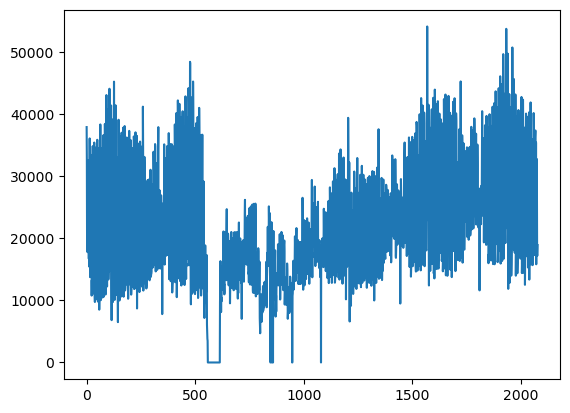

In [3]:
df = pd.read_csv('data/restaurant_1.csv')
df.totale.plot()

# FIT MODELS

In [4]:
def fit_prophet_model(
    df,
    y_col: str,
    ds_col: str,
    regressors: list = None,
    n_test: int = 60,       
    weekly: bool = False,
    monthly: bool = False,
    yearly: bool = False,
    weekly_prepost: bool = False,   
    holidays: bool = False,
    verbose: bool = False,
    return_results: bool = True
):
    # Preprocessing
    df = df.copy()
    df = df.rename(columns={ds_col: "ds", y_col: "y"})
    df["ds"] = pd.to_datetime(df["ds"])

    # Binary condition to distinguish pre post covid --> useful to model conditioned seasonalities
    if weekly_prepost:
        cutoff_date = pd.Timestamp("2021-06-15")
        df["pre_covid"] = (df["ds"] < cutoff_date).astype(int)
        df["post_covid"] = (df["ds"] >= cutoff_date).astype(int)

    # base model
    m = Prophet(
        yearly_seasonality=yearly,
        weekly_seasonality=(weekly and not weekly_prepost), 
        daily_seasonality=False
    )

    if monthly:
        m.add_seasonality(name="monthly", period=30.5, fourier_order=5)

    # double weekly seas
    if weekly_prepost:
        m.add_seasonality(
            name="weekly_pre_covid",
            period=7,
            fourier_order=3,
            condition_name="pre_covid"
        )
        m.add_seasonality(
            name="weekly_post_covid",
            period=7,
            fourier_order=3,
            condition_name="post_covid"
        )

    # Add holidays
    if holidays:
        m.add_country_holidays(country_name='IT')

    # Add optional regressors
    if regressors:
        for r in regressors:
            m.add_regressor(r)

    # fit model
    m.fit(df)

    # Temporal CV
    df_cv = cross_validation(
        m,
        initial="730 days",
        period=f"{n_test} days",
        horizon=f"{n_test} days"
    )

    df_p = performance_metrics(df_cv)
    rmse_mean = df_p["rmse"].mean()
    mae_mean = df_p["mae"].mean()
    
    if verbose:
        print("\nCV-metrics:")
        print(f"RMSE medio = {rmse_mean:.2f}")
        print(f"MAE  medio = {mae_mean:.2f}")

    # use last windows as test set
    last_cutoff = df_cv["cutoff"].max()
    df_last = df_cv[df_cv["cutoff"] == last_cutoff].copy().sort_values("ds")

    # plot predicted vs test if requested
    if verbose:
        plt.figure(figsize=(10,5))
        plt.plot(df_last["ds"], df_last["y"], label="Ground Truth", color="black")
        plt.plot(df_last["ds"], df_last["yhat"], label="Forecast (CV)", color="tab:blue")
        plt.fill_between(
            df_last["ds"],
            df_last["yhat_lower"],
            df_last["yhat_upper"],
            color="blue", alpha=0.2
        )
        plt.title(f"Forecast (horizon = {n_test} days)")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

    # test set metrics
    y_true = df_last["y"]
    y_pred = df_last["yhat"]
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    #mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    if verbose:
        print("\nTest set metrics:")
        print(f"RMSE = {rmse:.2f}")
        print(f"MAE  = {mae:.2f}")
   

   # plot model components
    cutoff = df_cv["cutoff"].max()
    train_final = df[df["ds"] <= cutoff]
    cutoff_date = pd.Timestamp("2021-06-15")
    train_final["pre_covid"] = (train_final["ds"] < cutoff_date)
    train_final["post_covid"] = (train_final["ds"] >= cutoff_date)

    m_final = Prophet(
        yearly_seasonality=yearly,
        weekly_seasonality=(weekly and not weekly_prepost),
        daily_seasonality=False
    )

    if monthly:
        m_final.add_seasonality(name="monthly", period=30.5, fourier_order=5)

    if weekly_prepost:
        m_final.add_seasonality(
            name="weekly_pre_covid",
            period=7,
            fourier_order=3,
            condition_name="pre_covid"
        )
        m_final.add_seasonality(
            name="weekly_post_covid",
            period=7,
            fourier_order=3,
            condition_name="post_covid"
        )

    if holidays:
        m_final.add_country_holidays(country_name='IT')

    if regressors:
        for r in regressors:
            m_final.add_regressor(r)

    m_final.fit(train_final)

    future_final = m_final.make_future_dataframe(periods=n_test)
    future_final["pre_covid"] = (future_final["ds"] < cutoff_date)
    future_final["post_covid"] = (future_final["ds"] >= cutoff_date)

    if regressors:
        for r in regressors:
            if r in train_final.columns:
                future_final[r] = train_final[r].iloc[-1]
            else:
                future_final[r] = 0

    forecast_final = m_final.predict(future_final)

    if verbose:
        print("\nModel components:")
        m_final.plot_components(forecast_final)
        plt.show()

    # output
    if return_results:
        return {
            "model": m_final,
            "cv_results": df_cv,
            "metrics_cv": df_p,
            "metrics_last_window": {"RMSE": rmse, "MAE": mae},
            "last_window": df_last
        }


09:30:12 - cmdstanpy - INFO - Chain [1] start processing
09:30:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/44 [00:00<?, ?it/s]

09:30:14 - cmdstanpy - INFO - Chain [1] start processing
09:30:14 - cmdstanpy - INFO - Chain [1] done processing
09:30:14 - cmdstanpy - INFO - Chain [1] start processing
09:30:14 - cmdstanpy - INFO - Chain [1] done processing
09:30:14 - cmdstanpy - INFO - Chain [1] start processing
09:30:15 - cmdstanpy - INFO - Chain [1] done processing
09:30:15 - cmdstanpy - INFO - Chain [1] start processing
09:30:15 - cmdstanpy - INFO - Chain [1] done processing
09:30:15 - cmdstanpy - INFO - Chain [1] start processing
09:30:15 - cmdstanpy - INFO - Chain [1] done processing
09:30:15 - cmdstanpy - INFO - Chain [1] start processing
09:30:15 - cmdstanpy - INFO - Chain [1] done processing
09:30:16 - cmdstanpy - INFO - Chain [1] start processing
09:30:16 - cmdstanpy - INFO - Chain [1] done processing
09:30:16 - cmdstanpy - INFO - Chain [1] start processing
09:30:16 - cmdstanpy - INFO - Chain [1] done processing
09:30:16 - cmdstanpy - INFO - Chain [1] start processing
09:30:16 - cmdstanpy - INFO - Chain [1]


CV-metrics:
RMSE medio = 172.42
MAE  medio = 131.22


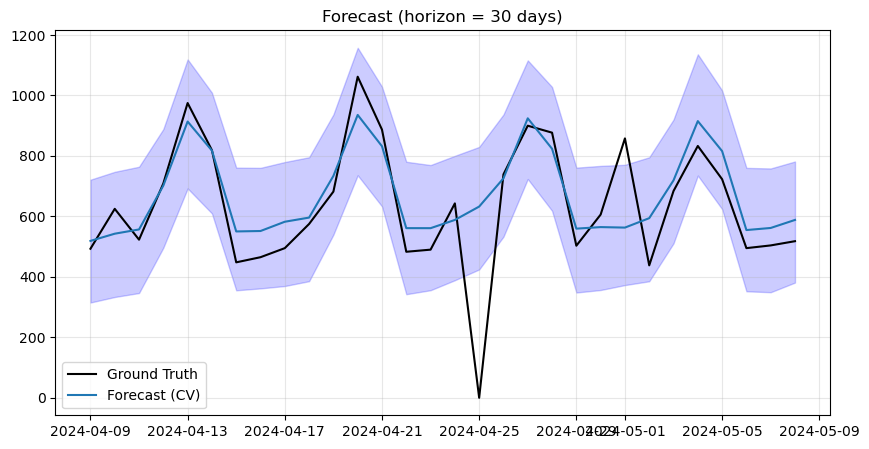


Test set metrics:
RMSE = 144.07
MAE  = 87.22

Model components:


C:\Users\andre\AppData\Local\Temp\ipykernel_37676\499892166.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_final["pre_covid"] = (train_final["ds"] < cutoff_date)
C:\Users\andre\AppData\Local\Temp\ipykernel_37676\499892166.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_final["post_covid"] = (train_final["ds"] >= cutoff_date)
09:30:33 - cmdstanpy - INFO - Chain [1] start processing
09:30:33 - cmdstanpy - INFO - Chain [1] done processing


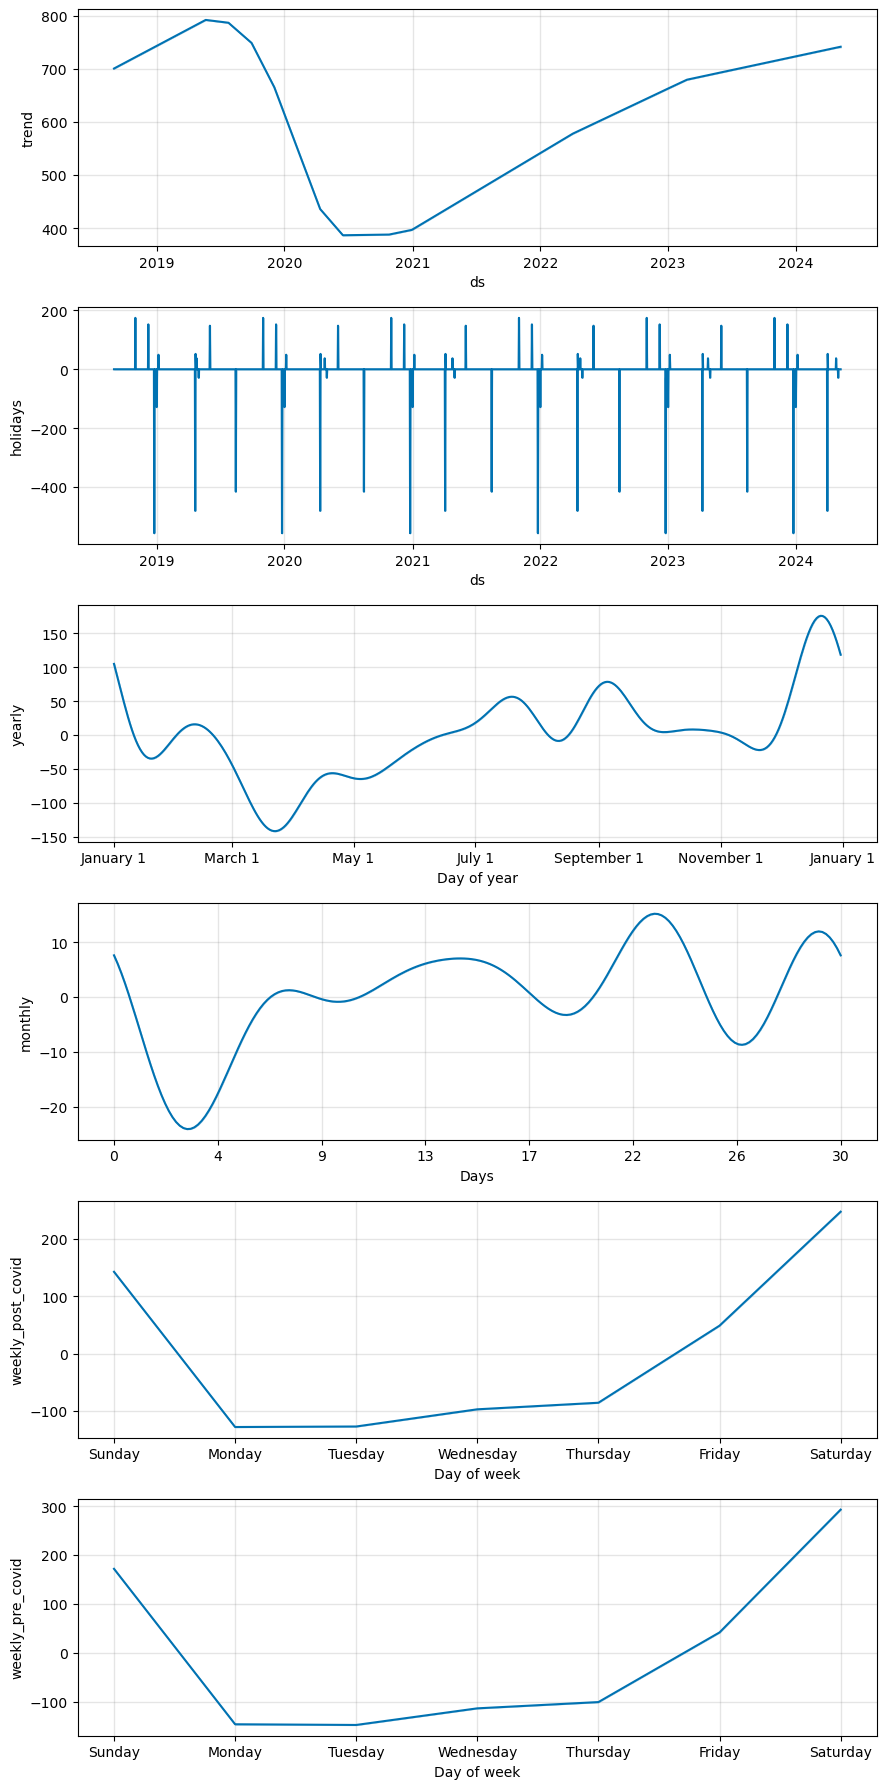

In [12]:
fit_prophet_model(
    df=df,
    y_col='scontrini',
    ds_col='data',
    n_test=30,
    weekly=False,
    monthly=True,
    yearly=True,
    weekly_prepost=True,
    holidays=True,
    verbose = True,
    return_results = False)

In [39]:
weekly_seas = [True, False]
monthly_seas = [True, False]
yearly_seas = [True, False]
weekly_prepost_seas = [True, False]
holiday_regr = [True, False]
covid_regr = [None, ['dummy_emilia_full_open', 'dummy_emilia_restricted_open', 'dummy_emilia_takeaway_only'], 
                    ['dummy_lombardia_full_open', 'dummy_lombardia_restricted_open', 'dummy_lombardia_takeaway_only']]

param_grid = itertools.product(
    weekly_seas,
    monthly_seas,
    yearly_seas,
    weekly_prepost_seas,
    holiday_regr,
    covid_regr
)

# TOTALE

In [5]:
def fit_prophet_model(
    df,
    y_col: str,
    ds_col: str,
    regressors: list = None,
    n_test: int = 60,       
    weekly: bool = False,
    monthly: bool = False,
    yearly: bool = False,
    weekly_prepost: bool = False,   
    holidays: bool = False,
    verbose: bool = False,
    return_results: bool = True
):
    # Preprocessing
    df = df.copy()
    df = df.rename(columns={ds_col: "ds", y_col: "y"})
    df["ds"] = pd.to_datetime(df["ds"])

    # Binary condition to distinguish pre post covid --> useful to model conditioned seasonalities
    if weekly_prepost:
        cutoff_date = pd.Timestamp("2021-06-15")
        df["pre_covid"] = (df["ds"] < cutoff_date).astype(int)
        df["post_covid"] = (df["ds"] >= cutoff_date).astype(int)

    # base model
    m = Prophet(
        yearly_seasonality=yearly,
        weekly_seasonality=(weekly and not weekly_prepost), 
        daily_seasonality=False
    )

    if monthly:
        m.add_seasonality(name="monthly", period=30.5, fourier_order=5)

    # double weekly seas
    if weekly_prepost:
        m.add_seasonality(
            name="weekly_pre_covid",
            period=7,
            fourier_order=3,
            condition_name="pre_covid"
        )
        m.add_seasonality(
            name="weekly_post_covid",
            period=7,
            fourier_order=3,
            condition_name="post_covid"
        )

    # Add holidays
    if holidays:
        m.add_country_holidays(country_name='IT')

    # Add optional regressors
    if regressors:
        for r in regressors:
            m.add_regressor(r)

    # fit model
    m.fit(df)

    # Temporal CV
    df_cv = cross_validation(
        m,
        initial="730 days",
        period=f"{n_test} days",
        horizon=f"{n_test} days"
    )

    df_p = performance_metrics(df_cv)
    rmse_mean = df_p["rmse"].mean()
    mae_mean = df_p["mae"].mean()
    
    if verbose:
        print("\nCV-metrics:")
        print(f"RMSE medio = {rmse_mean:.2f}")
        print(f"MAE  medio = {mae_mean:.2f}")

    # use last windows as test set
    last_cutoff = df_cv["cutoff"].max()
    df_last = df_cv[df_cv["cutoff"] == last_cutoff].copy().sort_values("ds")

    # plot predicted vs test if requested
    if verbose:
        plt.figure(figsize=(10,5))
        plt.plot(df_last["ds"], df_last["y"], label="Ground Truth", color="black")
        plt.plot(df_last["ds"], df_last["yhat"], label="Forecast (CV)", color="tab:blue")
        plt.fill_between(
            df_last["ds"],
            df_last["yhat_lower"],
            df_last["yhat_upper"],
            color="blue", alpha=0.2
        )
        plt.title(f"Forecast (horizon = {n_test} days)")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

    # test set metrics
    y_true = df_last["y"]
    y_pred = df_last["yhat"]
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    #mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    if verbose:
        print("\nTest set metrics:")
        print(f"RMSE = {rmse:.2f}")
        print(f"MAE  = {mae:.2f}")
   
    # CREATE FINAL MODEL (always, not only when verbose=True)
    cutoff = df_cv["cutoff"].max()
    train_final = df[df["ds"] <= cutoff]
    
    if weekly_prepost:
        cutoff_date = pd.Timestamp("2021-06-15")
        train_final["pre_covid"] = (train_final["ds"] < cutoff_date).astype(int)
        train_final["post_covid"] = (train_final["ds"] >= cutoff_date).astype(int)

    m_final = Prophet(
        yearly_seasonality=yearly,
        weekly_seasonality=(weekly and not weekly_prepost),
        daily_seasonality=False
    )

    if monthly:
        m_final.add_seasonality(name="monthly", period=30.5, fourier_order=5)

    if weekly_prepost:
        m_final.add_seasonality(
            name="weekly_pre_covid",
            period=7,
            fourier_order=3,
            condition_name="pre_covid"
        )
        m_final.add_seasonality(
            name="weekly_post_covid",
            period=7,
            fourier_order=3,
            condition_name="post_covid"
        )

    if holidays:
        m_final.add_country_holidays(country_name='IT')

    if regressors:
        for r in regressors:
            m_final.add_regressor(r)

    m_final.fit(train_final)

    # Create future dataframe
    future_final = m_final.make_future_dataframe(periods=n_test)
    
    if weekly_prepost:
        cutoff_date = pd.Timestamp("2021-06-15")
        future_final["pre_covid"] = (future_final["ds"] < cutoff_date).astype(int)
        future_final["post_covid"] = (future_final["ds"] >= cutoff_date).astype(int)

    if regressors:
        for r in regressors:
            if r in train_final.columns:
                future_final[r] = train_final[r].iloc[-1]
            else:
                future_final[r] = 0

    forecast_final = m_final.predict(future_final)

    # Plot model components (only if verbose)
    if verbose:
        print("\nModel components:")
        m_final.plot_components(forecast_final)
        plt.show()

    # output
    if return_results:
        return {
            "model": m_final,
            "cv_results": df_cv,
            "metrics_cv": df_p,
            "metrics_last_window": {"RMSE": rmse, "MAE": mae},
            "last_window": df_last
        }

## GRID SEARCH ON DF1

In [11]:
results = []

for (w, m, y, wp, h, covid) in param_grid:
    print(f"\n TTesting with: weekly={w}, monthly={m}, yearly={y}, prepost={wp}, holidays={h}, covid={covid is not None}")
    
    
        # Fit Prophet
    res = fit_prophet_model(
            df=df,
            y_col="totale",
            ds_col="data",
            n_test=60,
            weekly=w,
            monthly=m,
            yearly=y,
            weekly_prepost=wp,
            holidays=h,
            regressors=covid,
            verbose=False,
            return_results=True
    )

        
    metrics_last = res["metrics_last_window"]
    cv_metrics = res["metrics_cv"]
    rmse_cv_mean = cv_metrics["rmse"].mean()
    mae_cv_mean = cv_metrics["mae"].mean()
      
    results.append({
            "weekly": w,
            "monthly": m,
            "yearly": y,
            "weekly_prepost": wp,
            "holidays": h,
            "covid_regressors": covid,
            "RMSE_last": metrics_last["RMSE"],
            "MAE_last": metrics_last["MAE"],
            "RMSE_cv_mean": rmse_cv_mean,
            "MAE_cv_mean": mae_cv_mean
    })

df_results = pd.DataFrame(results)
df_results = df_results.sort_values("RMSE_cv_mean", ascending=True).reset_index(drop=True)
df_results.to_csv("prophet_gridsearch_results_restaurant_1.csv", index=False)


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=True, covid=False


14:18:20 - cmdstanpy - INFO - Chain [1] start processing
14:18:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:18:21 - cmdstanpy - INFO - Chain [1] start processing
14:18:21 - cmdstanpy - INFO - Chain [1] done processing
14:18:21 - cmdstanpy - INFO - Chain [1] start processing
14:18:21 - cmdstanpy - INFO - Chain [1] done processing
14:18:22 - cmdstanpy - INFO - Chain [1] start processing
14:18:22 - cmdstanpy - INFO - Chain [1] done processing
14:18:22 - cmdstanpy - INFO - Chain [1] start processing
14:18:22 - cmdstanpy - INFO - Chain [1] done processing
14:18:23 - cmdstanpy - INFO - Chain [1] start processing
14:18:23 - cmdstanpy - INFO - Chain [1] done processing
14:18:23 - cmdstanpy - INFO - Chain [1] start processing
14:18:23 - cmdstanpy - INFO - Chain [1] done processing
14:18:24 - cmdstanpy - INFO - Chain [1] start processing
14:18:24 - cmdstanpy - INFO - Chain [1] done processing
14:18:24 - cmdstanpy - INFO - Chain [1] start processing
14:18:24 - cmdstanpy - INFO - Chain [1] done processing
14:18:25 - cmdstanpy - INFO - Chain [1] start processing
14:18:25 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


14:18:35 - cmdstanpy - INFO - Chain [1] start processing
14:18:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:18:35 - cmdstanpy - INFO - Chain [1] start processing
14:18:36 - cmdstanpy - INFO - Chain [1] done processing
14:18:36 - cmdstanpy - INFO - Chain [1] start processing
14:18:36 - cmdstanpy - INFO - Chain [1] done processing
14:18:36 - cmdstanpy - INFO - Chain [1] start processing
14:18:36 - cmdstanpy - INFO - Chain [1] done processing
14:18:37 - cmdstanpy - INFO - Chain [1] start processing
14:18:37 - cmdstanpy - INFO - Chain [1] done processing
14:18:37 - cmdstanpy - INFO - Chain [1] start processing
14:18:38 - cmdstanpy - INFO - Chain [1] done processing
14:18:38 - cmdstanpy - INFO - Chain [1] start processing
14:18:38 - cmdstanpy - INFO - Chain [1] done processing
14:18:38 - cmdstanpy - INFO - Chain [1] start processing
14:18:39 - cmdstanpy - INFO - Chain [1] done processing
14:18:39 - cmdstanpy - INFO - Chain [1] start processing
14:18:39 - cmdstanpy - INFO - Chain [1] done processing
14:18:40 - cmdstanpy - INFO - Chain [1] start processing
14:18:40 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


14:18:50 - cmdstanpy - INFO - Chain [1] start processing
14:18:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:18:51 - cmdstanpy - INFO - Chain [1] start processing
14:18:51 - cmdstanpy - INFO - Chain [1] done processing
14:18:51 - cmdstanpy - INFO - Chain [1] start processing
14:18:52 - cmdstanpy - INFO - Chain [1] done processing
14:18:52 - cmdstanpy - INFO - Chain [1] start processing
14:18:52 - cmdstanpy - INFO - Chain [1] done processing
14:18:52 - cmdstanpy - INFO - Chain [1] start processing
14:18:53 - cmdstanpy - INFO - Chain [1] done processing
14:18:53 - cmdstanpy - INFO - Chain [1] start processing
14:18:53 - cmdstanpy - INFO - Chain [1] done processing
14:18:53 - cmdstanpy - INFO - Chain [1] start processing
14:18:54 - cmdstanpy - INFO - Chain [1] done processing
14:18:54 - cmdstanpy - INFO - Chain [1] start processing
14:18:54 - cmdstanpy - INFO - Chain [1] done processing
14:18:55 - cmdstanpy - INFO - Chain [1] start processing
14:18:55 - cmdstanpy - INFO - Chain [1] done processing
14:18:55 - cmdstanpy - INFO - Chain [1] start processing
14:18:55 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=False, covid=False


14:19:06 - cmdstanpy - INFO - Chain [1] start processing
14:19:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:19:06 - cmdstanpy - INFO - Chain [1] start processing
14:19:06 - cmdstanpy - INFO - Chain [1] done processing
14:19:06 - cmdstanpy - INFO - Chain [1] start processing
14:19:07 - cmdstanpy - INFO - Chain [1] done processing
14:19:07 - cmdstanpy - INFO - Chain [1] start processing
14:19:07 - cmdstanpy - INFO - Chain [1] done processing
14:19:07 - cmdstanpy - INFO - Chain [1] start processing
14:19:07 - cmdstanpy - INFO - Chain [1] done processing
14:19:08 - cmdstanpy - INFO - Chain [1] start processing
14:19:08 - cmdstanpy - INFO - Chain [1] done processing
14:19:08 - cmdstanpy - INFO - Chain [1] start processing
14:19:08 - cmdstanpy - INFO - Chain [1] done processing
14:19:09 - cmdstanpy - INFO - Chain [1] start processing
14:19:09 - cmdstanpy - INFO - Chain [1] done processing
14:19:09 - cmdstanpy - INFO - Chain [1] start processing
14:19:09 - cmdstanpy - INFO - Chain [1] done processing
14:19:10 - cmdstanpy - INFO - Chain [1] start processing
14:19:10 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


14:19:18 - cmdstanpy - INFO - Chain [1] start processing
14:19:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:19:19 - cmdstanpy - INFO - Chain [1] start processing
14:19:19 - cmdstanpy - INFO - Chain [1] done processing
14:19:19 - cmdstanpy - INFO - Chain [1] start processing
14:19:19 - cmdstanpy - INFO - Chain [1] done processing
14:19:19 - cmdstanpy - INFO - Chain [1] start processing
14:19:20 - cmdstanpy - INFO - Chain [1] done processing
14:19:20 - cmdstanpy - INFO - Chain [1] start processing
14:19:20 - cmdstanpy - INFO - Chain [1] done processing
14:19:20 - cmdstanpy - INFO - Chain [1] start processing
14:19:20 - cmdstanpy - INFO - Chain [1] done processing
14:19:21 - cmdstanpy - INFO - Chain [1] start processing
14:19:21 - cmdstanpy - INFO - Chain [1] done processing
14:19:21 - cmdstanpy - INFO - Chain [1] start processing
14:19:21 - cmdstanpy - INFO - Chain [1] done processing
14:19:22 - cmdstanpy - INFO - Chain [1] start processing
14:19:22 - cmdstanpy - INFO - Chain [1] done processing
14:19:22 - cmdstanpy - INFO - Chain [1] start processing
14:19:23 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


14:19:31 - cmdstanpy - INFO - Chain [1] start processing
14:19:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:19:32 - cmdstanpy - INFO - Chain [1] start processing
14:19:32 - cmdstanpy - INFO - Chain [1] done processing
14:19:32 - cmdstanpy - INFO - Chain [1] start processing
14:19:32 - cmdstanpy - INFO - Chain [1] done processing
14:19:32 - cmdstanpy - INFO - Chain [1] start processing
14:19:33 - cmdstanpy - INFO - Chain [1] done processing
14:19:33 - cmdstanpy - INFO - Chain [1] start processing
14:19:33 - cmdstanpy - INFO - Chain [1] done processing
14:19:33 - cmdstanpy - INFO - Chain [1] start processing
14:19:34 - cmdstanpy - INFO - Chain [1] done processing
14:19:34 - cmdstanpy - INFO - Chain [1] start processing
14:19:34 - cmdstanpy - INFO - Chain [1] done processing
14:19:34 - cmdstanpy - INFO - Chain [1] start processing
14:19:35 - cmdstanpy - INFO - Chain [1] done processing
14:19:35 - cmdstanpy - INFO - Chain [1] start processing
14:19:35 - cmdstanpy - INFO - Chain [1] done processing
14:19:35 - cmdstanpy - INFO - Chain [1] start processing
14:19:36 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=True, covid=False


14:19:44 - cmdstanpy - INFO - Chain [1] start processing
14:19:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:19:44 - cmdstanpy - INFO - Chain [1] start processing
14:19:45 - cmdstanpy - INFO - Chain [1] done processing
14:19:45 - cmdstanpy - INFO - Chain [1] start processing
14:19:45 - cmdstanpy - INFO - Chain [1] done processing
14:19:45 - cmdstanpy - INFO - Chain [1] start processing
14:19:45 - cmdstanpy - INFO - Chain [1] done processing
14:19:46 - cmdstanpy - INFO - Chain [1] start processing
14:19:46 - cmdstanpy - INFO - Chain [1] done processing
14:19:46 - cmdstanpy - INFO - Chain [1] start processing
14:19:46 - cmdstanpy - INFO - Chain [1] done processing
14:19:47 - cmdstanpy - INFO - Chain [1] start processing
14:19:47 - cmdstanpy - INFO - Chain [1] done processing
14:19:47 - cmdstanpy - INFO - Chain [1] start processing
14:19:47 - cmdstanpy - INFO - Chain [1] done processing
14:19:48 - cmdstanpy - INFO - Chain [1] start processing
14:19:48 - cmdstanpy - INFO - Chain [1] done processing
14:19:48 - cmdstanpy - INFO - Chain [1] start processing
14:19:49 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


14:20:05 - cmdstanpy - INFO - Chain [1] start processing
14:20:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:20:06 - cmdstanpy - INFO - Chain [1] start processing
14:20:07 - cmdstanpy - INFO - Chain [1] done processing
14:20:07 - cmdstanpy - INFO - Chain [1] start processing
14:20:07 - cmdstanpy - INFO - Chain [1] done processing
14:20:08 - cmdstanpy - INFO - Chain [1] start processing
14:20:08 - cmdstanpy - INFO - Chain [1] done processing
14:20:09 - cmdstanpy - INFO - Chain [1] start processing
14:20:09 - cmdstanpy - INFO - Chain [1] done processing
14:20:10 - cmdstanpy - INFO - Chain [1] start processing
14:20:10 - cmdstanpy - INFO - Chain [1] done processing
14:20:11 - cmdstanpy - INFO - Chain [1] start processing
14:20:11 - cmdstanpy - INFO - Chain [1] done processing
14:20:12 - cmdstanpy - INFO - Chain [1] start processing
14:20:12 - cmdstanpy - INFO - Chain [1] done processing
14:20:12 - cmdstanpy - INFO - Chain [1] start processing
14:20:13 - cmdstanpy - INFO - Chain [1] done processing
14:20:14 - cmdstanpy - INFO - Chain [1] start processing
14:20:14 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


14:20:31 - cmdstanpy - INFO - Chain [1] start processing
14:20:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:20:32 - cmdstanpy - INFO - Chain [1] start processing
14:20:32 - cmdstanpy - INFO - Chain [1] done processing
14:20:33 - cmdstanpy - INFO - Chain [1] start processing
14:20:33 - cmdstanpy - INFO - Chain [1] done processing
14:20:33 - cmdstanpy - INFO - Chain [1] start processing
14:20:34 - cmdstanpy - INFO - Chain [1] done processing
14:20:34 - cmdstanpy - INFO - Chain [1] start processing
14:20:34 - cmdstanpy - INFO - Chain [1] done processing
14:20:35 - cmdstanpy - INFO - Chain [1] start processing
14:20:36 - cmdstanpy - INFO - Chain [1] done processing
14:20:36 - cmdstanpy - INFO - Chain [1] start processing
14:20:37 - cmdstanpy - INFO - Chain [1] done processing
14:20:37 - cmdstanpy - INFO - Chain [1] start processing
14:20:38 - cmdstanpy - INFO - Chain [1] done processing
14:20:38 - cmdstanpy - INFO - Chain [1] start processing
14:20:39 - cmdstanpy - INFO - Chain [1] done processing
14:20:39 - cmdstanpy - INFO - Chain [1] start processing
14:20:40 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=False, covid=False


14:20:58 - cmdstanpy - INFO - Chain [1] start processing
14:20:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:20:59 - cmdstanpy - INFO - Chain [1] start processing
14:20:59 - cmdstanpy - INFO - Chain [1] done processing
14:20:59 - cmdstanpy - INFO - Chain [1] start processing
14:21:00 - cmdstanpy - INFO - Chain [1] done processing
14:21:00 - cmdstanpy - INFO - Chain [1] start processing
14:21:00 - cmdstanpy - INFO - Chain [1] done processing
14:21:01 - cmdstanpy - INFO - Chain [1] start processing
14:21:01 - cmdstanpy - INFO - Chain [1] done processing
14:21:02 - cmdstanpy - INFO - Chain [1] start processing
14:21:02 - cmdstanpy - INFO - Chain [1] done processing
14:21:02 - cmdstanpy - INFO - Chain [1] start processing
14:21:02 - cmdstanpy - INFO - Chain [1] done processing
14:21:03 - cmdstanpy - INFO - Chain [1] start processing
14:21:03 - cmdstanpy - INFO - Chain [1] done processing
14:21:04 - cmdstanpy - INFO - Chain [1] start processing
14:21:04 - cmdstanpy - INFO - Chain [1] done processing
14:21:04 - cmdstanpy - INFO - Chain [1] start processing
14:21:05 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


14:21:17 - cmdstanpy - INFO - Chain [1] start processing
14:21:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:21:18 - cmdstanpy - INFO - Chain [1] start processing
14:21:18 - cmdstanpy - INFO - Chain [1] done processing
14:21:19 - cmdstanpy - INFO - Chain [1] start processing
14:21:19 - cmdstanpy - INFO - Chain [1] done processing
14:21:20 - cmdstanpy - INFO - Chain [1] start processing
14:21:20 - cmdstanpy - INFO - Chain [1] done processing
14:21:20 - cmdstanpy - INFO - Chain [1] start processing
14:21:21 - cmdstanpy - INFO - Chain [1] done processing
14:21:21 - cmdstanpy - INFO - Chain [1] start processing
14:21:21 - cmdstanpy - INFO - Chain [1] done processing
14:21:22 - cmdstanpy - INFO - Chain [1] start processing
14:21:22 - cmdstanpy - INFO - Chain [1] done processing
14:21:23 - cmdstanpy - INFO - Chain [1] start processing
14:21:23 - cmdstanpy - INFO - Chain [1] done processing
14:21:23 - cmdstanpy - INFO - Chain [1] start processing
14:21:24 - cmdstanpy - INFO - Chain [1] done processing
14:21:24 - cmdstanpy - INFO - Chain [1] start processing
14:21:25 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


14:21:39 - cmdstanpy - INFO - Chain [1] start processing
14:21:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:21:40 - cmdstanpy - INFO - Chain [1] start processing
14:21:40 - cmdstanpy - INFO - Chain [1] done processing
14:21:41 - cmdstanpy - INFO - Chain [1] start processing
14:21:41 - cmdstanpy - INFO - Chain [1] done processing
14:21:42 - cmdstanpy - INFO - Chain [1] start processing
14:21:42 - cmdstanpy - INFO - Chain [1] done processing
14:21:42 - cmdstanpy - INFO - Chain [1] start processing
14:21:43 - cmdstanpy - INFO - Chain [1] done processing
14:21:43 - cmdstanpy - INFO - Chain [1] start processing
14:21:44 - cmdstanpy - INFO - Chain [1] done processing
14:21:44 - cmdstanpy - INFO - Chain [1] start processing
14:21:45 - cmdstanpy - INFO - Chain [1] done processing
14:21:45 - cmdstanpy - INFO - Chain [1] start processing
14:21:45 - cmdstanpy - INFO - Chain [1] done processing
14:21:46 - cmdstanpy - INFO - Chain [1] start processing
14:21:46 - cmdstanpy - INFO - Chain [1] done processing
14:21:47 - cmdstanpy - INFO - Chain [1] start processing
14:21:47 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=True, covid=False


14:22:01 - cmdstanpy - INFO - Chain [1] start processing
14:22:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:22:02 - cmdstanpy - INFO - Chain [1] start processing
14:22:02 - cmdstanpy - INFO - Chain [1] done processing
14:22:02 - cmdstanpy - INFO - Chain [1] start processing
14:22:03 - cmdstanpy - INFO - Chain [1] done processing
14:22:03 - cmdstanpy - INFO - Chain [1] start processing
14:22:03 - cmdstanpy - INFO - Chain [1] done processing
14:22:04 - cmdstanpy - INFO - Chain [1] start processing
14:22:04 - cmdstanpy - INFO - Chain [1] done processing
14:22:05 - cmdstanpy - INFO - Chain [1] start processing
14:22:05 - cmdstanpy - INFO - Chain [1] done processing
14:22:06 - cmdstanpy - INFO - Chain [1] start processing
14:22:06 - cmdstanpy - INFO - Chain [1] done processing
14:22:06 - cmdstanpy - INFO - Chain [1] start processing
14:22:07 - cmdstanpy - INFO - Chain [1] done processing
14:22:07 - cmdstanpy - INFO - Chain [1] start processing
14:22:07 - cmdstanpy - INFO - Chain [1] done processing
14:22:08 - cmdstanpy - INFO - Chain [1] start processing
14:22:08 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


14:22:21 - cmdstanpy - INFO - Chain [1] start processing
14:22:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:22:22 - cmdstanpy - INFO - Chain [1] start processing
14:22:23 - cmdstanpy - INFO - Chain [1] done processing
14:22:23 - cmdstanpy - INFO - Chain [1] start processing
14:22:23 - cmdstanpy - INFO - Chain [1] done processing
14:22:24 - cmdstanpy - INFO - Chain [1] start processing
14:22:24 - cmdstanpy - INFO - Chain [1] done processing
14:22:24 - cmdstanpy - INFO - Chain [1] start processing
14:22:25 - cmdstanpy - INFO - Chain [1] done processing
14:22:25 - cmdstanpy - INFO - Chain [1] start processing
14:22:25 - cmdstanpy - INFO - Chain [1] done processing
14:22:26 - cmdstanpy - INFO - Chain [1] start processing
14:22:26 - cmdstanpy - INFO - Chain [1] done processing
14:22:27 - cmdstanpy - INFO - Chain [1] start processing
14:22:27 - cmdstanpy - INFO - Chain [1] done processing
14:22:28 - cmdstanpy - INFO - Chain [1] start processing
14:22:28 - cmdstanpy - INFO - Chain [1] done processing
14:22:28 - cmdstanpy - INFO - Chain [1] start processing
14:22:29 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


14:22:43 - cmdstanpy - INFO - Chain [1] start processing
14:22:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:22:44 - cmdstanpy - INFO - Chain [1] start processing
14:22:44 - cmdstanpy - INFO - Chain [1] done processing
14:22:45 - cmdstanpy - INFO - Chain [1] start processing
14:22:45 - cmdstanpy - INFO - Chain [1] done processing
14:22:46 - cmdstanpy - INFO - Chain [1] start processing
14:22:46 - cmdstanpy - INFO - Chain [1] done processing
14:22:46 - cmdstanpy - INFO - Chain [1] start processing
14:22:46 - cmdstanpy - INFO - Chain [1] done processing
14:22:47 - cmdstanpy - INFO - Chain [1] start processing
14:22:47 - cmdstanpy - INFO - Chain [1] done processing
14:22:48 - cmdstanpy - INFO - Chain [1] start processing
14:22:48 - cmdstanpy - INFO - Chain [1] done processing
14:22:49 - cmdstanpy - INFO - Chain [1] start processing
14:22:49 - cmdstanpy - INFO - Chain [1] done processing
14:22:49 - cmdstanpy - INFO - Chain [1] start processing
14:22:50 - cmdstanpy - INFO - Chain [1] done processing
14:22:50 - cmdstanpy - INFO - Chain [1] start processing
14:22:51 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=False, covid=False


14:23:06 - cmdstanpy - INFO - Chain [1] start processing
14:23:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:23:06 - cmdstanpy - INFO - Chain [1] start processing
14:23:06 - cmdstanpy - INFO - Chain [1] done processing
14:23:07 - cmdstanpy - INFO - Chain [1] start processing
14:23:07 - cmdstanpy - INFO - Chain [1] done processing
14:23:07 - cmdstanpy - INFO - Chain [1] start processing
14:23:08 - cmdstanpy - INFO - Chain [1] done processing
14:23:08 - cmdstanpy - INFO - Chain [1] start processing
14:23:08 - cmdstanpy - INFO - Chain [1] done processing
14:23:09 - cmdstanpy - INFO - Chain [1] start processing
14:23:09 - cmdstanpy - INFO - Chain [1] done processing
14:23:09 - cmdstanpy - INFO - Chain [1] start processing
14:23:09 - cmdstanpy - INFO - Chain [1] done processing
14:23:10 - cmdstanpy - INFO - Chain [1] start processing
14:23:10 - cmdstanpy - INFO - Chain [1] done processing
14:23:11 - cmdstanpy - INFO - Chain [1] start processing
14:23:11 - cmdstanpy - INFO - Chain [1] done processing
14:23:11 - cmdstanpy - INFO - Chain [1] start processing
14:23:12 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


14:23:28 - cmdstanpy - INFO - Chain [1] start processing
14:23:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:23:29 - cmdstanpy - INFO - Chain [1] start processing
14:23:29 - cmdstanpy - INFO - Chain [1] done processing
14:23:30 - cmdstanpy - INFO - Chain [1] start processing
14:23:30 - cmdstanpy - INFO - Chain [1] done processing
14:23:31 - cmdstanpy - INFO - Chain [1] start processing
14:23:31 - cmdstanpy - INFO - Chain [1] done processing
14:23:32 - cmdstanpy - INFO - Chain [1] start processing
14:23:32 - cmdstanpy - INFO - Chain [1] done processing
14:23:33 - cmdstanpy - INFO - Chain [1] start processing
14:23:34 - cmdstanpy - INFO - Chain [1] done processing
14:23:34 - cmdstanpy - INFO - Chain [1] start processing
14:23:35 - cmdstanpy - INFO - Chain [1] done processing
14:23:36 - cmdstanpy - INFO - Chain [1] start processing
14:23:36 - cmdstanpy - INFO - Chain [1] done processing
14:23:37 - cmdstanpy - INFO - Chain [1] start processing
14:23:37 - cmdstanpy - INFO - Chain [1] done processing
14:23:38 - cmdstanpy - INFO - Chain [1] start processing
14:23:38 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


14:23:58 - cmdstanpy - INFO - Chain [1] start processing
14:23:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:24:00 - cmdstanpy - INFO - Chain [1] start processing
14:24:00 - cmdstanpy - INFO - Chain [1] done processing
14:24:01 - cmdstanpy - INFO - Chain [1] start processing
14:24:01 - cmdstanpy - INFO - Chain [1] done processing
14:24:02 - cmdstanpy - INFO - Chain [1] start processing
14:24:02 - cmdstanpy - INFO - Chain [1] done processing
14:24:03 - cmdstanpy - INFO - Chain [1] start processing
14:24:04 - cmdstanpy - INFO - Chain [1] done processing
14:24:04 - cmdstanpy - INFO - Chain [1] start processing
14:24:05 - cmdstanpy - INFO - Chain [1] done processing
14:24:06 - cmdstanpy - INFO - Chain [1] start processing
14:24:06 - cmdstanpy - INFO - Chain [1] done processing
14:24:07 - cmdstanpy - INFO - Chain [1] start processing
14:24:07 - cmdstanpy - INFO - Chain [1] done processing
14:24:08 - cmdstanpy - INFO - Chain [1] start processing
14:24:09 - cmdstanpy - INFO - Chain [1] done processing
14:24:09 - cmdstanpy - INFO - Chain [1] start processing
14:24:10 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=True, covid=False


14:24:31 - cmdstanpy - INFO - Chain [1] start processing
14:24:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:24:32 - cmdstanpy - INFO - Chain [1] start processing
14:24:33 - cmdstanpy - INFO - Chain [1] done processing
14:24:34 - cmdstanpy - INFO - Chain [1] start processing
14:24:34 - cmdstanpy - INFO - Chain [1] done processing
14:24:35 - cmdstanpy - INFO - Chain [1] start processing
14:24:35 - cmdstanpy - INFO - Chain [1] done processing
14:24:36 - cmdstanpy - INFO - Chain [1] start processing
14:24:36 - cmdstanpy - INFO - Chain [1] done processing
14:24:37 - cmdstanpy - INFO - Chain [1] start processing
14:24:38 - cmdstanpy - INFO - Chain [1] done processing
14:24:38 - cmdstanpy - INFO - Chain [1] start processing
14:24:39 - cmdstanpy - INFO - Chain [1] done processing
14:24:40 - cmdstanpy - INFO - Chain [1] start processing
14:24:40 - cmdstanpy - INFO - Chain [1] done processing
14:24:41 - cmdstanpy - INFO - Chain [1] start processing
14:24:42 - cmdstanpy - INFO - Chain [1] done processing
14:24:43 - cmdstanpy - INFO - Chain [1] start processing
14:24:43 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


14:25:04 - cmdstanpy - INFO - Chain [1] start processing
14:25:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:25:06 - cmdstanpy - INFO - Chain [1] start processing
14:25:06 - cmdstanpy - INFO - Chain [1] done processing
14:25:07 - cmdstanpy - INFO - Chain [1] start processing
14:25:07 - cmdstanpy - INFO - Chain [1] done processing
14:25:08 - cmdstanpy - INFO - Chain [1] start processing
14:25:08 - cmdstanpy - INFO - Chain [1] done processing
14:25:09 - cmdstanpy - INFO - Chain [1] start processing
14:25:09 - cmdstanpy - INFO - Chain [1] done processing
14:25:10 - cmdstanpy - INFO - Chain [1] start processing
14:25:11 - cmdstanpy - INFO - Chain [1] done processing
14:25:12 - cmdstanpy - INFO - Chain [1] start processing
14:25:12 - cmdstanpy - INFO - Chain [1] done processing
14:25:13 - cmdstanpy - INFO - Chain [1] start processing
14:25:13 - cmdstanpy - INFO - Chain [1] done processing
14:25:14 - cmdstanpy - INFO - Chain [1] start processing
14:25:15 - cmdstanpy - INFO - Chain [1] done processing
14:25:16 - cmdstanpy - INFO - Chain [1] start processing
14:25:16 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


14:25:40 - cmdstanpy - INFO - Chain [1] start processing
14:25:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:25:42 - cmdstanpy - INFO - Chain [1] start processing
14:25:42 - cmdstanpy - INFO - Chain [1] done processing
14:25:43 - cmdstanpy - INFO - Chain [1] start processing
14:25:43 - cmdstanpy - INFO - Chain [1] done processing
14:25:44 - cmdstanpy - INFO - Chain [1] start processing
14:25:45 - cmdstanpy - INFO - Chain [1] done processing
14:25:46 - cmdstanpy - INFO - Chain [1] start processing
14:25:46 - cmdstanpy - INFO - Chain [1] done processing
14:25:47 - cmdstanpy - INFO - Chain [1] start processing
14:25:47 - cmdstanpy - INFO - Chain [1] done processing
14:25:48 - cmdstanpy - INFO - Chain [1] start processing
14:25:49 - cmdstanpy - INFO - Chain [1] done processing
14:25:50 - cmdstanpy - INFO - Chain [1] start processing
14:25:50 - cmdstanpy - INFO - Chain [1] done processing
14:25:51 - cmdstanpy - INFO - Chain [1] start processing
14:25:52 - cmdstanpy - INFO - Chain [1] done processing
14:25:53 - cmdstanpy - INFO - Chain [1] start processing
14:25:53 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=False, covid=False


14:26:16 - cmdstanpy - INFO - Chain [1] start processing
14:26:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:26:18 - cmdstanpy - INFO - Chain [1] start processing
14:26:18 - cmdstanpy - INFO - Chain [1] done processing
14:26:19 - cmdstanpy - INFO - Chain [1] start processing
14:26:19 - cmdstanpy - INFO - Chain [1] done processing
14:26:19 - cmdstanpy - INFO - Chain [1] start processing
14:26:20 - cmdstanpy - INFO - Chain [1] done processing
14:26:20 - cmdstanpy - INFO - Chain [1] start processing
14:26:21 - cmdstanpy - INFO - Chain [1] done processing
14:26:21 - cmdstanpy - INFO - Chain [1] start processing
14:26:21 - cmdstanpy - INFO - Chain [1] done processing
14:26:22 - cmdstanpy - INFO - Chain [1] start processing
14:26:23 - cmdstanpy - INFO - Chain [1] done processing
14:26:23 - cmdstanpy - INFO - Chain [1] start processing
14:26:24 - cmdstanpy - INFO - Chain [1] done processing
14:26:24 - cmdstanpy - INFO - Chain [1] start processing
14:26:25 - cmdstanpy - INFO - Chain [1] done processing
14:26:25 - cmdstanpy - INFO - Chain [1] start processing
14:26:26 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


14:26:44 - cmdstanpy - INFO - Chain [1] start processing
14:26:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:26:46 - cmdstanpy - INFO - Chain [1] start processing
14:26:46 - cmdstanpy - INFO - Chain [1] done processing
14:26:47 - cmdstanpy - INFO - Chain [1] start processing
14:26:47 - cmdstanpy - INFO - Chain [1] done processing
14:26:48 - cmdstanpy - INFO - Chain [1] start processing
14:26:48 - cmdstanpy - INFO - Chain [1] done processing
14:26:48 - cmdstanpy - INFO - Chain [1] start processing
14:26:49 - cmdstanpy - INFO - Chain [1] done processing
14:26:49 - cmdstanpy - INFO - Chain [1] start processing
14:26:49 - cmdstanpy - INFO - Chain [1] done processing
14:26:50 - cmdstanpy - INFO - Chain [1] start processing
14:26:50 - cmdstanpy - INFO - Chain [1] done processing
14:26:51 - cmdstanpy - INFO - Chain [1] start processing
14:26:51 - cmdstanpy - INFO - Chain [1] done processing
14:26:51 - cmdstanpy - INFO - Chain [1] start processing
14:26:52 - cmdstanpy - INFO - Chain [1] done processing
14:26:52 - cmdstanpy - INFO - Chain [1] start processing
14:26:52 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


14:27:04 - cmdstanpy - INFO - Chain [1] start processing
14:27:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:27:05 - cmdstanpy - INFO - Chain [1] start processing
14:27:05 - cmdstanpy - INFO - Chain [1] done processing
14:27:05 - cmdstanpy - INFO - Chain [1] start processing
14:27:05 - cmdstanpy - INFO - Chain [1] done processing
14:27:06 - cmdstanpy - INFO - Chain [1] start processing
14:27:06 - cmdstanpy - INFO - Chain [1] done processing
14:27:07 - cmdstanpy - INFO - Chain [1] start processing
14:27:07 - cmdstanpy - INFO - Chain [1] done processing
14:27:07 - cmdstanpy - INFO - Chain [1] start processing
14:27:07 - cmdstanpy - INFO - Chain [1] done processing
14:27:08 - cmdstanpy - INFO - Chain [1] start processing
14:27:08 - cmdstanpy - INFO - Chain [1] done processing
14:27:08 - cmdstanpy - INFO - Chain [1] start processing
14:27:09 - cmdstanpy - INFO - Chain [1] done processing
14:27:09 - cmdstanpy - INFO - Chain [1] start processing
14:27:09 - cmdstanpy - INFO - Chain [1] done processing
14:27:10 - cmdstanpy - INFO - Chain [1] start processing
14:27:10 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=True, covid=False


14:27:21 - cmdstanpy - INFO - Chain [1] start processing
14:27:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:27:22 - cmdstanpy - INFO - Chain [1] start processing
14:27:22 - cmdstanpy - INFO - Chain [1] done processing
14:27:22 - cmdstanpy - INFO - Chain [1] start processing
14:27:23 - cmdstanpy - INFO - Chain [1] done processing
14:27:23 - cmdstanpy - INFO - Chain [1] start processing
14:27:23 - cmdstanpy - INFO - Chain [1] done processing
14:27:24 - cmdstanpy - INFO - Chain [1] start processing
14:27:24 - cmdstanpy - INFO - Chain [1] done processing
14:27:25 - cmdstanpy - INFO - Chain [1] start processing
14:27:25 - cmdstanpy - INFO - Chain [1] done processing
14:27:25 - cmdstanpy - INFO - Chain [1] start processing
14:27:26 - cmdstanpy - INFO - Chain [1] done processing
14:27:26 - cmdstanpy - INFO - Chain [1] start processing
14:27:26 - cmdstanpy - INFO - Chain [1] done processing
14:27:27 - cmdstanpy - INFO - Chain [1] start processing
14:27:27 - cmdstanpy - INFO - Chain [1] done processing
14:27:28 - cmdstanpy - INFO - Chain [1] start processing
14:27:28 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


14:27:44 - cmdstanpy - INFO - Chain [1] start processing
14:27:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:27:44 - cmdstanpy - INFO - Chain [1] start processing
14:27:45 - cmdstanpy - INFO - Chain [1] done processing
14:27:45 - cmdstanpy - INFO - Chain [1] start processing
14:27:45 - cmdstanpy - INFO - Chain [1] done processing
14:27:46 - cmdstanpy - INFO - Chain [1] start processing
14:27:46 - cmdstanpy - INFO - Chain [1] done processing
14:27:47 - cmdstanpy - INFO - Chain [1] start processing
14:27:47 - cmdstanpy - INFO - Chain [1] done processing
14:27:48 - cmdstanpy - INFO - Chain [1] start processing
14:27:48 - cmdstanpy - INFO - Chain [1] done processing
14:27:49 - cmdstanpy - INFO - Chain [1] start processing
14:27:49 - cmdstanpy - INFO - Chain [1] done processing
14:27:49 - cmdstanpy - INFO - Chain [1] start processing
14:27:50 - cmdstanpy - INFO - Chain [1] done processing
14:27:50 - cmdstanpy - INFO - Chain [1] start processing
14:27:51 - cmdstanpy - INFO - Chain [1] done processing
14:27:51 - cmdstanpy - INFO - Chain [1] start processing
14:27:52 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


14:28:08 - cmdstanpy - INFO - Chain [1] start processing
14:28:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:28:09 - cmdstanpy - INFO - Chain [1] start processing
14:28:09 - cmdstanpy - INFO - Chain [1] done processing
14:28:10 - cmdstanpy - INFO - Chain [1] start processing
14:28:10 - cmdstanpy - INFO - Chain [1] done processing
14:28:11 - cmdstanpy - INFO - Chain [1] start processing
14:28:11 - cmdstanpy - INFO - Chain [1] done processing
14:28:11 - cmdstanpy - INFO - Chain [1] start processing
14:28:12 - cmdstanpy - INFO - Chain [1] done processing
14:28:12 - cmdstanpy - INFO - Chain [1] start processing
14:28:12 - cmdstanpy - INFO - Chain [1] done processing
14:28:13 - cmdstanpy - INFO - Chain [1] start processing
14:28:13 - cmdstanpy - INFO - Chain [1] done processing
14:28:14 - cmdstanpy - INFO - Chain [1] start processing
14:28:14 - cmdstanpy - INFO - Chain [1] done processing
14:28:15 - cmdstanpy - INFO - Chain [1] start processing
14:28:16 - cmdstanpy - INFO - Chain [1] done processing
14:28:16 - cmdstanpy - INFO - Chain [1] start processing
14:28:16 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=False, covid=False


14:28:32 - cmdstanpy - INFO - Chain [1] start processing
14:28:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:28:33 - cmdstanpy - INFO - Chain [1] start processing
14:28:33 - cmdstanpy - INFO - Chain [1] done processing
14:28:34 - cmdstanpy - INFO - Chain [1] start processing
14:28:34 - cmdstanpy - INFO - Chain [1] done processing
14:28:34 - cmdstanpy - INFO - Chain [1] start processing
14:28:35 - cmdstanpy - INFO - Chain [1] done processing
14:28:35 - cmdstanpy - INFO - Chain [1] start processing
14:28:35 - cmdstanpy - INFO - Chain [1] done processing
14:28:36 - cmdstanpy - INFO - Chain [1] start processing
14:28:36 - cmdstanpy - INFO - Chain [1] done processing
14:28:36 - cmdstanpy - INFO - Chain [1] start processing
14:28:37 - cmdstanpy - INFO - Chain [1] done processing
14:28:37 - cmdstanpy - INFO - Chain [1] start processing
14:28:37 - cmdstanpy - INFO - Chain [1] done processing
14:28:38 - cmdstanpy - INFO - Chain [1] start processing
14:28:38 - cmdstanpy - INFO - Chain [1] done processing
14:28:39 - cmdstanpy - INFO - Chain [1] start processing
14:28:39 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


14:28:52 - cmdstanpy - INFO - Chain [1] start processing
14:28:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:28:53 - cmdstanpy - INFO - Chain [1] start processing
14:28:53 - cmdstanpy - INFO - Chain [1] done processing
14:28:53 - cmdstanpy - INFO - Chain [1] start processing
14:28:53 - cmdstanpy - INFO - Chain [1] done processing
14:28:54 - cmdstanpy - INFO - Chain [1] start processing
14:28:54 - cmdstanpy - INFO - Chain [1] done processing
14:28:55 - cmdstanpy - INFO - Chain [1] start processing
14:28:55 - cmdstanpy - INFO - Chain [1] done processing
14:28:55 - cmdstanpy - INFO - Chain [1] start processing
14:28:56 - cmdstanpy - INFO - Chain [1] done processing
14:28:56 - cmdstanpy - INFO - Chain [1] start processing
14:28:56 - cmdstanpy - INFO - Chain [1] done processing
14:28:57 - cmdstanpy - INFO - Chain [1] start processing
14:28:57 - cmdstanpy - INFO - Chain [1] done processing
14:28:58 - cmdstanpy - INFO - Chain [1] start processing
14:28:58 - cmdstanpy - INFO - Chain [1] done processing
14:28:59 - cmdstanpy - INFO - Chain [1] start processing
14:28:59 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


14:29:13 - cmdstanpy - INFO - Chain [1] start processing
14:29:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:29:14 - cmdstanpy - INFO - Chain [1] start processing
14:29:14 - cmdstanpy - INFO - Chain [1] done processing
14:29:14 - cmdstanpy - INFO - Chain [1] start processing
14:29:15 - cmdstanpy - INFO - Chain [1] done processing
14:29:15 - cmdstanpy - INFO - Chain [1] start processing
14:29:15 - cmdstanpy - INFO - Chain [1] done processing
14:29:16 - cmdstanpy - INFO - Chain [1] start processing
14:29:16 - cmdstanpy - INFO - Chain [1] done processing
14:29:16 - cmdstanpy - INFO - Chain [1] start processing
14:29:17 - cmdstanpy - INFO - Chain [1] done processing
14:29:17 - cmdstanpy - INFO - Chain [1] start processing
14:29:17 - cmdstanpy - INFO - Chain [1] done processing
14:29:18 - cmdstanpy - INFO - Chain [1] start processing
14:29:18 - cmdstanpy - INFO - Chain [1] done processing
14:29:19 - cmdstanpy - INFO - Chain [1] start processing
14:29:19 - cmdstanpy - INFO - Chain [1] done processing
14:29:19 - cmdstanpy - INFO - Chain [1] start processing
14:29:20 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=True, covid=False


14:29:32 - cmdstanpy - INFO - Chain [1] start processing
14:29:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:29:33 - cmdstanpy - INFO - Chain [1] start processing
14:29:34 - cmdstanpy - INFO - Chain [1] done processing
14:29:34 - cmdstanpy - INFO - Chain [1] start processing
14:29:34 - cmdstanpy - INFO - Chain [1] done processing
14:29:35 - cmdstanpy - INFO - Chain [1] start processing
14:29:35 - cmdstanpy - INFO - Chain [1] done processing
14:29:36 - cmdstanpy - INFO - Chain [1] start processing
14:29:36 - cmdstanpy - INFO - Chain [1] done processing
14:29:36 - cmdstanpy - INFO - Chain [1] start processing
14:29:37 - cmdstanpy - INFO - Chain [1] done processing
14:29:37 - cmdstanpy - INFO - Chain [1] start processing
14:29:38 - cmdstanpy - INFO - Chain [1] done processing
14:29:38 - cmdstanpy - INFO - Chain [1] start processing
14:29:39 - cmdstanpy - INFO - Chain [1] done processing
14:29:39 - cmdstanpy - INFO - Chain [1] start processing
14:29:40 - cmdstanpy - INFO - Chain [1] done processing
14:29:40 - cmdstanpy - INFO - Chain [1] start processing
14:29:41 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


14:29:55 - cmdstanpy - INFO - Chain [1] start processing
14:29:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:29:57 - cmdstanpy - INFO - Chain [1] start processing
14:29:57 - cmdstanpy - INFO - Chain [1] done processing
14:29:57 - cmdstanpy - INFO - Chain [1] start processing
14:29:57 - cmdstanpy - INFO - Chain [1] done processing
14:29:58 - cmdstanpy - INFO - Chain [1] start processing
14:29:58 - cmdstanpy - INFO - Chain [1] done processing
14:29:59 - cmdstanpy - INFO - Chain [1] start processing
14:29:59 - cmdstanpy - INFO - Chain [1] done processing
14:29:59 - cmdstanpy - INFO - Chain [1] start processing
14:30:00 - cmdstanpy - INFO - Chain [1] done processing
14:30:00 - cmdstanpy - INFO - Chain [1] start processing
14:30:01 - cmdstanpy - INFO - Chain [1] done processing
14:30:01 - cmdstanpy - INFO - Chain [1] start processing
14:30:02 - cmdstanpy - INFO - Chain [1] done processing
14:30:02 - cmdstanpy - INFO - Chain [1] start processing
14:30:03 - cmdstanpy - INFO - Chain [1] done processing
14:30:03 - cmdstanpy - INFO - Chain [1] start processing
14:30:04 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


14:30:19 - cmdstanpy - INFO - Chain [1] start processing
14:30:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:30:20 - cmdstanpy - INFO - Chain [1] start processing
14:30:20 - cmdstanpy - INFO - Chain [1] done processing
14:30:21 - cmdstanpy - INFO - Chain [1] start processing
14:30:21 - cmdstanpy - INFO - Chain [1] done processing
14:30:22 - cmdstanpy - INFO - Chain [1] start processing
14:30:22 - cmdstanpy - INFO - Chain [1] done processing
14:30:22 - cmdstanpy - INFO - Chain [1] start processing
14:30:23 - cmdstanpy - INFO - Chain [1] done processing
14:30:23 - cmdstanpy - INFO - Chain [1] start processing
14:30:23 - cmdstanpy - INFO - Chain [1] done processing
14:30:24 - cmdstanpy - INFO - Chain [1] start processing
14:30:24 - cmdstanpy - INFO - Chain [1] done processing
14:30:25 - cmdstanpy - INFO - Chain [1] start processing
14:30:25 - cmdstanpy - INFO - Chain [1] done processing
14:30:26 - cmdstanpy - INFO - Chain [1] start processing
14:30:26 - cmdstanpy - INFO - Chain [1] done processing
14:30:27 - cmdstanpy - INFO - Chain [1] start processing
14:30:27 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=False, covid=False


14:30:42 - cmdstanpy - INFO - Chain [1] start processing
14:30:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:30:43 - cmdstanpy - INFO - Chain [1] start processing
14:30:43 - cmdstanpy - INFO - Chain [1] done processing
14:30:44 - cmdstanpy - INFO - Chain [1] start processing
14:30:44 - cmdstanpy - INFO - Chain [1] done processing
14:30:44 - cmdstanpy - INFO - Chain [1] start processing
14:30:44 - cmdstanpy - INFO - Chain [1] done processing
14:30:45 - cmdstanpy - INFO - Chain [1] start processing
14:30:45 - cmdstanpy - INFO - Chain [1] done processing
14:30:45 - cmdstanpy - INFO - Chain [1] start processing
14:30:45 - cmdstanpy - INFO - Chain [1] done processing
14:30:46 - cmdstanpy - INFO - Chain [1] start processing
14:30:46 - cmdstanpy - INFO - Chain [1] done processing
14:30:47 - cmdstanpy - INFO - Chain [1] start processing
14:30:47 - cmdstanpy - INFO - Chain [1] done processing
14:30:47 - cmdstanpy - INFO - Chain [1] start processing
14:30:48 - cmdstanpy - INFO - Chain [1] done processing
14:30:48 - cmdstanpy - INFO - Chain [1] start processing
14:30:48 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


14:31:01 - cmdstanpy - INFO - Chain [1] start processing
14:31:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:31:02 - cmdstanpy - INFO - Chain [1] start processing
14:31:02 - cmdstanpy - INFO - Chain [1] done processing
14:31:02 - cmdstanpy - INFO - Chain [1] start processing
14:31:03 - cmdstanpy - INFO - Chain [1] done processing
14:31:03 - cmdstanpy - INFO - Chain [1] start processing
14:31:03 - cmdstanpy - INFO - Chain [1] done processing
14:31:04 - cmdstanpy - INFO - Chain [1] start processing
14:31:04 - cmdstanpy - INFO - Chain [1] done processing
14:31:04 - cmdstanpy - INFO - Chain [1] start processing
14:31:05 - cmdstanpy - INFO - Chain [1] done processing
14:31:05 - cmdstanpy - INFO - Chain [1] start processing
14:31:05 - cmdstanpy - INFO - Chain [1] done processing
14:31:06 - cmdstanpy - INFO - Chain [1] start processing
14:31:06 - cmdstanpy - INFO - Chain [1] done processing
14:31:07 - cmdstanpy - INFO - Chain [1] start processing
14:31:07 - cmdstanpy - INFO - Chain [1] done processing
14:31:08 - cmdstanpy - INFO - Chain [1] start processing
14:31:08 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


14:31:20 - cmdstanpy - INFO - Chain [1] start processing
14:31:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:31:21 - cmdstanpy - INFO - Chain [1] start processing
14:31:21 - cmdstanpy - INFO - Chain [1] done processing
14:31:21 - cmdstanpy - INFO - Chain [1] start processing
14:31:22 - cmdstanpy - INFO - Chain [1] done processing
14:31:22 - cmdstanpy - INFO - Chain [1] start processing
14:31:22 - cmdstanpy - INFO - Chain [1] done processing
14:31:23 - cmdstanpy - INFO - Chain [1] start processing
14:31:23 - cmdstanpy - INFO - Chain [1] done processing
14:31:23 - cmdstanpy - INFO - Chain [1] start processing
14:31:24 - cmdstanpy - INFO - Chain [1] done processing
14:31:24 - cmdstanpy - INFO - Chain [1] start processing
14:31:24 - cmdstanpy - INFO - Chain [1] done processing
14:31:25 - cmdstanpy - INFO - Chain [1] start processing
14:31:25 - cmdstanpy - INFO - Chain [1] done processing
14:31:26 - cmdstanpy - INFO - Chain [1] start processing
14:31:26 - cmdstanpy - INFO - Chain [1] done processing
14:31:26 - cmdstanpy - INFO - Chain [1] start processing
14:31:27 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=True, covid=False


14:31:39 - cmdstanpy - INFO - Chain [1] start processing
14:31:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:31:40 - cmdstanpy - INFO - Chain [1] start processing
14:31:40 - cmdstanpy - INFO - Chain [1] done processing
14:31:41 - cmdstanpy - INFO - Chain [1] start processing
14:31:41 - cmdstanpy - INFO - Chain [1] done processing
14:31:41 - cmdstanpy - INFO - Chain [1] start processing
14:31:42 - cmdstanpy - INFO - Chain [1] done processing
14:31:42 - cmdstanpy - INFO - Chain [1] start processing
14:31:42 - cmdstanpy - INFO - Chain [1] done processing
14:31:43 - cmdstanpy - INFO - Chain [1] start processing
14:31:43 - cmdstanpy - INFO - Chain [1] done processing
14:31:44 - cmdstanpy - INFO - Chain [1] start processing
14:31:44 - cmdstanpy - INFO - Chain [1] done processing
14:31:45 - cmdstanpy - INFO - Chain [1] start processing
14:31:45 - cmdstanpy - INFO - Chain [1] done processing
14:31:46 - cmdstanpy - INFO - Chain [1] start processing
14:31:46 - cmdstanpy - INFO - Chain [1] done processing
14:31:47 - cmdstanpy - INFO - Chain [1] start processing
14:31:47 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


14:32:01 - cmdstanpy - INFO - Chain [1] start processing
14:32:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:32:02 - cmdstanpy - INFO - Chain [1] start processing
14:32:02 - cmdstanpy - INFO - Chain [1] done processing
14:32:02 - cmdstanpy - INFO - Chain [1] start processing
14:32:03 - cmdstanpy - INFO - Chain [1] done processing
14:32:03 - cmdstanpy - INFO - Chain [1] start processing
14:32:03 - cmdstanpy - INFO - Chain [1] done processing
14:32:04 - cmdstanpy - INFO - Chain [1] start processing
14:32:04 - cmdstanpy - INFO - Chain [1] done processing
14:32:05 - cmdstanpy - INFO - Chain [1] start processing
14:32:05 - cmdstanpy - INFO - Chain [1] done processing
14:32:05 - cmdstanpy - INFO - Chain [1] start processing
14:32:06 - cmdstanpy - INFO - Chain [1] done processing
14:32:06 - cmdstanpy - INFO - Chain [1] start processing
14:32:06 - cmdstanpy - INFO - Chain [1] done processing
14:32:07 - cmdstanpy - INFO - Chain [1] start processing
14:32:07 - cmdstanpy - INFO - Chain [1] done processing
14:32:08 - cmdstanpy - INFO - Chain [1] start processing
14:32:08 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


14:32:22 - cmdstanpy - INFO - Chain [1] start processing
14:32:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:32:23 - cmdstanpy - INFO - Chain [1] start processing
14:32:23 - cmdstanpy - INFO - Chain [1] done processing
14:32:24 - cmdstanpy - INFO - Chain [1] start processing
14:32:24 - cmdstanpy - INFO - Chain [1] done processing
14:32:24 - cmdstanpy - INFO - Chain [1] start processing
14:32:25 - cmdstanpy - INFO - Chain [1] done processing
14:32:25 - cmdstanpy - INFO - Chain [1] start processing
14:32:25 - cmdstanpy - INFO - Chain [1] done processing
14:32:26 - cmdstanpy - INFO - Chain [1] start processing
14:32:26 - cmdstanpy - INFO - Chain [1] done processing
14:32:27 - cmdstanpy - INFO - Chain [1] start processing
14:32:27 - cmdstanpy - INFO - Chain [1] done processing
14:32:27 - cmdstanpy - INFO - Chain [1] start processing
14:32:27 - cmdstanpy - INFO - Chain [1] done processing
14:32:28 - cmdstanpy - INFO - Chain [1] start processing
14:32:28 - cmdstanpy - INFO - Chain [1] done processing
14:32:29 - cmdstanpy - INFO - Chain [1] start processing
14:32:29 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=False, covid=False


14:32:42 - cmdstanpy - INFO - Chain [1] start processing
14:32:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:32:42 - cmdstanpy - INFO - Chain [1] start processing
14:32:43 - cmdstanpy - INFO - Chain [1] done processing
14:32:43 - cmdstanpy - INFO - Chain [1] start processing
14:32:43 - cmdstanpy - INFO - Chain [1] done processing
14:32:43 - cmdstanpy - INFO - Chain [1] start processing
14:32:44 - cmdstanpy - INFO - Chain [1] done processing
14:32:44 - cmdstanpy - INFO - Chain [1] start processing
14:32:44 - cmdstanpy - INFO - Chain [1] done processing
14:32:45 - cmdstanpy - INFO - Chain [1] start processing
14:32:45 - cmdstanpy - INFO - Chain [1] done processing
14:32:45 - cmdstanpy - INFO - Chain [1] start processing
14:32:46 - cmdstanpy - INFO - Chain [1] done processing
14:32:46 - cmdstanpy - INFO - Chain [1] start processing
14:32:46 - cmdstanpy - INFO - Chain [1] done processing
14:32:46 - cmdstanpy - INFO - Chain [1] start processing
14:32:47 - cmdstanpy - INFO - Chain [1] done processing
14:32:47 - cmdstanpy - INFO - Chain [1] start processing
14:32:47 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


14:32:58 - cmdstanpy - INFO - Chain [1] start processing
14:32:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:32:58 - cmdstanpy - INFO - Chain [1] start processing
14:32:59 - cmdstanpy - INFO - Chain [1] done processing
14:32:59 - cmdstanpy - INFO - Chain [1] start processing
14:32:59 - cmdstanpy - INFO - Chain [1] done processing
14:32:59 - cmdstanpy - INFO - Chain [1] start processing
14:33:00 - cmdstanpy - INFO - Chain [1] done processing
14:33:00 - cmdstanpy - INFO - Chain [1] start processing
14:33:00 - cmdstanpy - INFO - Chain [1] done processing
14:33:01 - cmdstanpy - INFO - Chain [1] start processing
14:33:01 - cmdstanpy - INFO - Chain [1] done processing
14:33:01 - cmdstanpy - INFO - Chain [1] start processing
14:33:01 - cmdstanpy - INFO - Chain [1] done processing
14:33:02 - cmdstanpy - INFO - Chain [1] start processing
14:33:02 - cmdstanpy - INFO - Chain [1] done processing
14:33:02 - cmdstanpy - INFO - Chain [1] start processing
14:33:03 - cmdstanpy - INFO - Chain [1] done processing
14:33:03 - cmdstanpy - INFO - Chain [1] start processing
14:33:03 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


14:33:14 - cmdstanpy - INFO - Chain [1] start processing
14:33:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:33:15 - cmdstanpy - INFO - Chain [1] start processing
14:33:15 - cmdstanpy - INFO - Chain [1] done processing
14:33:15 - cmdstanpy - INFO - Chain [1] start processing
14:33:15 - cmdstanpy - INFO - Chain [1] done processing
14:33:16 - cmdstanpy - INFO - Chain [1] start processing
14:33:16 - cmdstanpy - INFO - Chain [1] done processing
14:33:16 - cmdstanpy - INFO - Chain [1] start processing
14:33:16 - cmdstanpy - INFO - Chain [1] done processing
14:33:17 - cmdstanpy - INFO - Chain [1] start processing
14:33:17 - cmdstanpy - INFO - Chain [1] done processing
14:33:17 - cmdstanpy - INFO - Chain [1] start processing
14:33:18 - cmdstanpy - INFO - Chain [1] done processing
14:33:18 - cmdstanpy - INFO - Chain [1] start processing
14:33:18 - cmdstanpy - INFO - Chain [1] done processing
14:33:19 - cmdstanpy - INFO - Chain [1] start processing
14:33:19 - cmdstanpy - INFO - Chain [1] done processing
14:33:19 - cmdstanpy - INFO - Chain [1] start processing
14:33:19 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=True, covid=False


14:33:30 - cmdstanpy - INFO - Chain [1] start processing
14:33:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:33:31 - cmdstanpy - INFO - Chain [1] start processing
14:33:31 - cmdstanpy - INFO - Chain [1] done processing
14:33:31 - cmdstanpy - INFO - Chain [1] start processing
14:33:31 - cmdstanpy - INFO - Chain [1] done processing
14:33:32 - cmdstanpy - INFO - Chain [1] start processing
14:33:32 - cmdstanpy - INFO - Chain [1] done processing
14:33:32 - cmdstanpy - INFO - Chain [1] start processing
14:33:32 - cmdstanpy - INFO - Chain [1] done processing
14:33:33 - cmdstanpy - INFO - Chain [1] start processing
14:33:33 - cmdstanpy - INFO - Chain [1] done processing
14:33:33 - cmdstanpy - INFO - Chain [1] start processing
14:33:34 - cmdstanpy - INFO - Chain [1] done processing
14:33:34 - cmdstanpy - INFO - Chain [1] start processing
14:33:34 - cmdstanpy - INFO - Chain [1] done processing
14:33:35 - cmdstanpy - INFO - Chain [1] start processing
14:33:35 - cmdstanpy - INFO - Chain [1] done processing
14:33:36 - cmdstanpy - INFO - Chain [1] start processing
14:33:36 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


14:33:48 - cmdstanpy - INFO - Chain [1] start processing
14:33:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:33:49 - cmdstanpy - INFO - Chain [1] start processing
14:33:49 - cmdstanpy - INFO - Chain [1] done processing
14:33:50 - cmdstanpy - INFO - Chain [1] start processing
14:33:50 - cmdstanpy - INFO - Chain [1] done processing
14:33:50 - cmdstanpy - INFO - Chain [1] start processing
14:33:50 - cmdstanpy - INFO - Chain [1] done processing
14:33:51 - cmdstanpy - INFO - Chain [1] start processing
14:33:51 - cmdstanpy - INFO - Chain [1] done processing
14:33:52 - cmdstanpy - INFO - Chain [1] start processing
14:33:52 - cmdstanpy - INFO - Chain [1] done processing
14:33:52 - cmdstanpy - INFO - Chain [1] start processing
14:33:52 - cmdstanpy - INFO - Chain [1] done processing
14:33:53 - cmdstanpy - INFO - Chain [1] start processing
14:33:53 - cmdstanpy - INFO - Chain [1] done processing
14:33:54 - cmdstanpy - INFO - Chain [1] start processing
14:33:54 - cmdstanpy - INFO - Chain [1] done processing
14:33:54 - cmdstanpy - INFO - Chain [1] start processing
14:33:55 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


14:34:07 - cmdstanpy - INFO - Chain [1] start processing
14:34:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:34:07 - cmdstanpy - INFO - Chain [1] start processing
14:34:07 - cmdstanpy - INFO - Chain [1] done processing
14:34:08 - cmdstanpy - INFO - Chain [1] start processing
14:34:08 - cmdstanpy - INFO - Chain [1] done processing
14:34:08 - cmdstanpy - INFO - Chain [1] start processing
14:34:09 - cmdstanpy - INFO - Chain [1] done processing
14:34:09 - cmdstanpy - INFO - Chain [1] start processing
14:34:09 - cmdstanpy - INFO - Chain [1] done processing
14:34:10 - cmdstanpy - INFO - Chain [1] start processing
14:34:10 - cmdstanpy - INFO - Chain [1] done processing
14:34:10 - cmdstanpy - INFO - Chain [1] start processing
14:34:11 - cmdstanpy - INFO - Chain [1] done processing
14:34:11 - cmdstanpy - INFO - Chain [1] start processing
14:34:11 - cmdstanpy - INFO - Chain [1] done processing
14:34:12 - cmdstanpy - INFO - Chain [1] start processing
14:34:12 - cmdstanpy - INFO - Chain [1] done processing
14:34:12 - cmdstanpy - INFO - Chain [1] start processing
14:34:13 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=False, covid=False


14:34:25 - cmdstanpy - INFO - Chain [1] start processing
14:34:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:34:26 - cmdstanpy - INFO - Chain [1] start processing
14:34:26 - cmdstanpy - INFO - Chain [1] done processing
14:34:26 - cmdstanpy - INFO - Chain [1] start processing
14:34:26 - cmdstanpy - INFO - Chain [1] done processing
14:34:27 - cmdstanpy - INFO - Chain [1] start processing
14:34:27 - cmdstanpy - INFO - Chain [1] done processing
14:34:27 - cmdstanpy - INFO - Chain [1] start processing
14:34:27 - cmdstanpy - INFO - Chain [1] done processing
14:34:28 - cmdstanpy - INFO - Chain [1] start processing
14:34:28 - cmdstanpy - INFO - Chain [1] done processing
14:34:28 - cmdstanpy - INFO - Chain [1] start processing
14:34:29 - cmdstanpy - INFO - Chain [1] done processing
14:34:29 - cmdstanpy - INFO - Chain [1] start processing
14:34:29 - cmdstanpy - INFO - Chain [1] done processing
14:34:29 - cmdstanpy - INFO - Chain [1] start processing
14:34:30 - cmdstanpy - INFO - Chain [1] done processing
14:34:30 - cmdstanpy - INFO - Chain [1] start processing
14:34:30 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


14:34:40 - cmdstanpy - INFO - Chain [1] start processing
14:34:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:34:41 - cmdstanpy - INFO - Chain [1] start processing
14:34:41 - cmdstanpy - INFO - Chain [1] done processing
14:34:41 - cmdstanpy - INFO - Chain [1] start processing
14:34:41 - cmdstanpy - INFO - Chain [1] done processing
14:34:42 - cmdstanpy - INFO - Chain [1] start processing
14:34:42 - cmdstanpy - INFO - Chain [1] done processing
14:34:42 - cmdstanpy - INFO - Chain [1] start processing
14:34:42 - cmdstanpy - INFO - Chain [1] done processing
14:34:43 - cmdstanpy - INFO - Chain [1] start processing
14:34:43 - cmdstanpy - INFO - Chain [1] done processing
14:34:43 - cmdstanpy - INFO - Chain [1] start processing
14:34:44 - cmdstanpy - INFO - Chain [1] done processing
14:34:44 - cmdstanpy - INFO - Chain [1] start processing
14:34:44 - cmdstanpy - INFO - Chain [1] done processing
14:34:45 - cmdstanpy - INFO - Chain [1] start processing
14:34:45 - cmdstanpy - INFO - Chain [1] done processing
14:34:45 - cmdstanpy - INFO - Chain [1] start processing
14:34:45 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


14:34:56 - cmdstanpy - INFO - Chain [1] start processing
14:34:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:34:56 - cmdstanpy - INFO - Chain [1] start processing
14:34:56 - cmdstanpy - INFO - Chain [1] done processing
14:34:57 - cmdstanpy - INFO - Chain [1] start processing
14:34:57 - cmdstanpy - INFO - Chain [1] done processing
14:34:57 - cmdstanpy - INFO - Chain [1] start processing
14:34:57 - cmdstanpy - INFO - Chain [1] done processing
14:34:58 - cmdstanpy - INFO - Chain [1] start processing
14:34:58 - cmdstanpy - INFO - Chain [1] done processing
14:34:58 - cmdstanpy - INFO - Chain [1] start processing
14:34:59 - cmdstanpy - INFO - Chain [1] done processing
14:34:59 - cmdstanpy - INFO - Chain [1] start processing
14:34:59 - cmdstanpy - INFO - Chain [1] done processing
14:34:59 - cmdstanpy - INFO - Chain [1] start processing
14:35:00 - cmdstanpy - INFO - Chain [1] done processing
14:35:00 - cmdstanpy - INFO - Chain [1] start processing
14:35:00 - cmdstanpy - INFO - Chain [1] done processing
14:35:01 - cmdstanpy - INFO - Chain [1] start processing
14:35:01 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=True, covid=False


14:35:11 - cmdstanpy - INFO - Chain [1] start processing
14:35:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:35:12 - cmdstanpy - INFO - Chain [1] start processing
14:35:12 - cmdstanpy - INFO - Chain [1] done processing
14:35:13 - cmdstanpy - INFO - Chain [1] start processing
14:35:13 - cmdstanpy - INFO - Chain [1] done processing
14:35:14 - cmdstanpy - INFO - Chain [1] start processing
14:35:14 - cmdstanpy - INFO - Chain [1] done processing
14:35:14 - cmdstanpy - INFO - Chain [1] start processing
14:35:15 - cmdstanpy - INFO - Chain [1] done processing
14:35:15 - cmdstanpy - INFO - Chain [1] start processing
14:35:16 - cmdstanpy - INFO - Chain [1] done processing
14:35:16 - cmdstanpy - INFO - Chain [1] start processing
14:35:17 - cmdstanpy - INFO - Chain [1] done processing
14:35:17 - cmdstanpy - INFO - Chain [1] start processing
14:35:17 - cmdstanpy - INFO - Chain [1] done processing
14:35:18 - cmdstanpy - INFO - Chain [1] start processing
14:35:18 - cmdstanpy - INFO - Chain [1] done processing
14:35:19 - cmdstanpy - INFO - Chain [1] start processing
14:35:19 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


14:35:36 - cmdstanpy - INFO - Chain [1] start processing
14:35:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:35:38 - cmdstanpy - INFO - Chain [1] start processing
14:35:38 - cmdstanpy - INFO - Chain [1] done processing
14:35:39 - cmdstanpy - INFO - Chain [1] start processing
14:35:39 - cmdstanpy - INFO - Chain [1] done processing
14:35:40 - cmdstanpy - INFO - Chain [1] start processing
14:35:40 - cmdstanpy - INFO - Chain [1] done processing
14:35:41 - cmdstanpy - INFO - Chain [1] start processing
14:35:41 - cmdstanpy - INFO - Chain [1] done processing
14:35:42 - cmdstanpy - INFO - Chain [1] start processing
14:35:43 - cmdstanpy - INFO - Chain [1] done processing
14:35:44 - cmdstanpy - INFO - Chain [1] start processing
14:35:44 - cmdstanpy - INFO - Chain [1] done processing
14:35:45 - cmdstanpy - INFO - Chain [1] start processing
14:35:45 - cmdstanpy - INFO - Chain [1] done processing
14:35:46 - cmdstanpy - INFO - Chain [1] start processing
14:35:47 - cmdstanpy - INFO - Chain [1] done processing
14:35:48 - cmdstanpy - INFO - Chain [1] start processing
14:35:49 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


14:36:10 - cmdstanpy - INFO - Chain [1] start processing
14:36:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:36:11 - cmdstanpy - INFO - Chain [1] start processing
14:36:12 - cmdstanpy - INFO - Chain [1] done processing
14:36:12 - cmdstanpy - INFO - Chain [1] start processing
14:36:13 - cmdstanpy - INFO - Chain [1] done processing
14:36:14 - cmdstanpy - INFO - Chain [1] start processing
14:36:14 - cmdstanpy - INFO - Chain [1] done processing
14:36:15 - cmdstanpy - INFO - Chain [1] start processing
14:36:15 - cmdstanpy - INFO - Chain [1] done processing
14:36:16 - cmdstanpy - INFO - Chain [1] start processing
14:36:16 - cmdstanpy - INFO - Chain [1] done processing
14:36:17 - cmdstanpy - INFO - Chain [1] start processing
14:36:17 - cmdstanpy - INFO - Chain [1] done processing
14:36:18 - cmdstanpy - INFO - Chain [1] start processing
14:36:18 - cmdstanpy - INFO - Chain [1] done processing
14:36:19 - cmdstanpy - INFO - Chain [1] start processing
14:36:19 - cmdstanpy - INFO - Chain [1] done processing
14:36:20 - cmdstanpy - INFO - Chain [1] start processing
14:36:20 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=False, covid=False


14:36:40 - cmdstanpy - INFO - Chain [1] start processing
14:36:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:36:41 - cmdstanpy - INFO - Chain [1] start processing
14:36:41 - cmdstanpy - INFO - Chain [1] done processing
14:36:42 - cmdstanpy - INFO - Chain [1] start processing
14:36:42 - cmdstanpy - INFO - Chain [1] done processing
14:36:42 - cmdstanpy - INFO - Chain [1] start processing
14:36:43 - cmdstanpy - INFO - Chain [1] done processing
14:36:43 - cmdstanpy - INFO - Chain [1] start processing
14:36:43 - cmdstanpy - INFO - Chain [1] done processing
14:36:44 - cmdstanpy - INFO - Chain [1] start processing
14:36:44 - cmdstanpy - INFO - Chain [1] done processing
14:36:45 - cmdstanpy - INFO - Chain [1] start processing
14:36:45 - cmdstanpy - INFO - Chain [1] done processing
14:36:45 - cmdstanpy - INFO - Chain [1] start processing
14:36:46 - cmdstanpy - INFO - Chain [1] done processing
14:36:46 - cmdstanpy - INFO - Chain [1] start processing
14:36:47 - cmdstanpy - INFO - Chain [1] done processing
14:36:47 - cmdstanpy - INFO - Chain [1] start processing
14:36:48 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


14:37:02 - cmdstanpy - INFO - Chain [1] start processing
14:37:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:37:03 - cmdstanpy - INFO - Chain [1] start processing
14:37:03 - cmdstanpy - INFO - Chain [1] done processing
14:37:04 - cmdstanpy - INFO - Chain [1] start processing
14:37:04 - cmdstanpy - INFO - Chain [1] done processing
14:37:04 - cmdstanpy - INFO - Chain [1] start processing
14:37:05 - cmdstanpy - INFO - Chain [1] done processing
14:37:05 - cmdstanpy - INFO - Chain [1] start processing
14:37:05 - cmdstanpy - INFO - Chain [1] done processing
14:37:06 - cmdstanpy - INFO - Chain [1] start processing
14:37:06 - cmdstanpy - INFO - Chain [1] done processing
14:37:07 - cmdstanpy - INFO - Chain [1] start processing
14:37:07 - cmdstanpy - INFO - Chain [1] done processing
14:37:08 - cmdstanpy - INFO - Chain [1] start processing
14:37:08 - cmdstanpy - INFO - Chain [1] done processing
14:37:09 - cmdstanpy - INFO - Chain [1] start processing
14:37:09 - cmdstanpy - INFO - Chain [1] done processing
14:37:10 - cmdstanpy - INFO - Chain [1] start processing
14:37:10 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


14:37:26 - cmdstanpy - INFO - Chain [1] start processing
14:37:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:37:28 - cmdstanpy - INFO - Chain [1] start processing
14:37:28 - cmdstanpy - INFO - Chain [1] done processing
14:37:28 - cmdstanpy - INFO - Chain [1] start processing
14:37:28 - cmdstanpy - INFO - Chain [1] done processing
14:37:29 - cmdstanpy - INFO - Chain [1] start processing
14:37:29 - cmdstanpy - INFO - Chain [1] done processing
14:37:30 - cmdstanpy - INFO - Chain [1] start processing
14:37:30 - cmdstanpy - INFO - Chain [1] done processing
14:37:31 - cmdstanpy - INFO - Chain [1] start processing
14:37:31 - cmdstanpy - INFO - Chain [1] done processing
14:37:32 - cmdstanpy - INFO - Chain [1] start processing
14:37:32 - cmdstanpy - INFO - Chain [1] done processing
14:37:32 - cmdstanpy - INFO - Chain [1] start processing
14:37:33 - cmdstanpy - INFO - Chain [1] done processing
14:37:33 - cmdstanpy - INFO - Chain [1] start processing
14:37:34 - cmdstanpy - INFO - Chain [1] done processing
14:37:34 - cmdstanpy - INFO - Chain [1] start processing
14:37:35 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=True, covid=False


14:37:50 - cmdstanpy - INFO - Chain [1] start processing
14:37:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:37:50 - cmdstanpy - INFO - Chain [1] start processing
14:37:50 - cmdstanpy - INFO - Chain [1] done processing
14:37:51 - cmdstanpy - INFO - Chain [1] start processing
14:37:51 - cmdstanpy - INFO - Chain [1] done processing
14:37:52 - cmdstanpy - INFO - Chain [1] start processing
14:37:52 - cmdstanpy - INFO - Chain [1] done processing
14:37:52 - cmdstanpy - INFO - Chain [1] start processing
14:37:53 - cmdstanpy - INFO - Chain [1] done processing
14:37:53 - cmdstanpy - INFO - Chain [1] start processing
14:37:53 - cmdstanpy - INFO - Chain [1] done processing
14:37:54 - cmdstanpy - INFO - Chain [1] start processing
14:37:54 - cmdstanpy - INFO - Chain [1] done processing
14:37:55 - cmdstanpy - INFO - Chain [1] start processing
14:37:55 - cmdstanpy - INFO - Chain [1] done processing
14:37:56 - cmdstanpy - INFO - Chain [1] start processing
14:37:56 - cmdstanpy - INFO - Chain [1] done processing
14:37:56 - cmdstanpy - INFO - Chain [1] start processing
14:37:57 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


14:38:11 - cmdstanpy - INFO - Chain [1] start processing
14:38:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:38:12 - cmdstanpy - INFO - Chain [1] start processing
14:38:12 - cmdstanpy - INFO - Chain [1] done processing
14:38:12 - cmdstanpy - INFO - Chain [1] start processing
14:38:13 - cmdstanpy - INFO - Chain [1] done processing
14:38:13 - cmdstanpy - INFO - Chain [1] start processing
14:38:13 - cmdstanpy - INFO - Chain [1] done processing
14:38:14 - cmdstanpy - INFO - Chain [1] start processing
14:38:14 - cmdstanpy - INFO - Chain [1] done processing
14:38:15 - cmdstanpy - INFO - Chain [1] start processing
14:38:15 - cmdstanpy - INFO - Chain [1] done processing
14:38:15 - cmdstanpy - INFO - Chain [1] start processing
14:38:16 - cmdstanpy - INFO - Chain [1] done processing
14:38:16 - cmdstanpy - INFO - Chain [1] start processing
14:38:16 - cmdstanpy - INFO - Chain [1] done processing
14:38:17 - cmdstanpy - INFO - Chain [1] start processing
14:38:17 - cmdstanpy - INFO - Chain [1] done processing
14:38:18 - cmdstanpy - INFO - Chain [1] start processing
14:38:18 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


14:38:32 - cmdstanpy - INFO - Chain [1] start processing
14:38:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:38:32 - cmdstanpy - INFO - Chain [1] start processing
14:38:33 - cmdstanpy - INFO - Chain [1] done processing
14:38:33 - cmdstanpy - INFO - Chain [1] start processing
14:38:33 - cmdstanpy - INFO - Chain [1] done processing
14:38:34 - cmdstanpy - INFO - Chain [1] start processing
14:38:34 - cmdstanpy - INFO - Chain [1] done processing
14:38:35 - cmdstanpy - INFO - Chain [1] start processing
14:38:35 - cmdstanpy - INFO - Chain [1] done processing
14:38:36 - cmdstanpy - INFO - Chain [1] start processing
14:38:36 - cmdstanpy - INFO - Chain [1] done processing
14:38:36 - cmdstanpy - INFO - Chain [1] start processing
14:38:36 - cmdstanpy - INFO - Chain [1] done processing
14:38:37 - cmdstanpy - INFO - Chain [1] start processing
14:38:37 - cmdstanpy - INFO - Chain [1] done processing
14:38:38 - cmdstanpy - INFO - Chain [1] start processing
14:38:38 - cmdstanpy - INFO - Chain [1] done processing
14:38:39 - cmdstanpy - INFO - Chain [1] start processing
14:38:39 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=False, covid=False


14:38:53 - cmdstanpy - INFO - Chain [1] start processing
14:38:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:38:54 - cmdstanpy - INFO - Chain [1] start processing
14:38:54 - cmdstanpy - INFO - Chain [1] done processing
14:38:54 - cmdstanpy - INFO - Chain [1] start processing
14:38:55 - cmdstanpy - INFO - Chain [1] done processing
14:38:55 - cmdstanpy - INFO - Chain [1] start processing
14:38:55 - cmdstanpy - INFO - Chain [1] done processing
14:38:56 - cmdstanpy - INFO - Chain [1] start processing
14:38:56 - cmdstanpy - INFO - Chain [1] done processing
14:38:56 - cmdstanpy - INFO - Chain [1] start processing
14:38:56 - cmdstanpy - INFO - Chain [1] done processing
14:38:57 - cmdstanpy - INFO - Chain [1] start processing
14:38:57 - cmdstanpy - INFO - Chain [1] done processing
14:38:58 - cmdstanpy - INFO - Chain [1] start processing
14:38:58 - cmdstanpy - INFO - Chain [1] done processing
14:38:58 - cmdstanpy - INFO - Chain [1] start processing
14:38:59 - cmdstanpy - INFO - Chain [1] done processing
14:38:59 - cmdstanpy - INFO - Chain [1] start processing
14:38:59 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


14:39:11 - cmdstanpy - INFO - Chain [1] start processing
14:39:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:39:12 - cmdstanpy - INFO - Chain [1] start processing
14:39:12 - cmdstanpy - INFO - Chain [1] done processing
14:39:12 - cmdstanpy - INFO - Chain [1] start processing
14:39:13 - cmdstanpy - INFO - Chain [1] done processing
14:39:13 - cmdstanpy - INFO - Chain [1] start processing
14:39:13 - cmdstanpy - INFO - Chain [1] done processing
14:39:14 - cmdstanpy - INFO - Chain [1] start processing
14:39:14 - cmdstanpy - INFO - Chain [1] done processing
14:39:14 - cmdstanpy - INFO - Chain [1] start processing
14:39:15 - cmdstanpy - INFO - Chain [1] done processing
14:39:15 - cmdstanpy - INFO - Chain [1] start processing
14:39:15 - cmdstanpy - INFO - Chain [1] done processing
14:39:16 - cmdstanpy - INFO - Chain [1] start processing
14:39:16 - cmdstanpy - INFO - Chain [1] done processing
14:39:16 - cmdstanpy - INFO - Chain [1] start processing
14:39:17 - cmdstanpy - INFO - Chain [1] done processing
14:39:17 - cmdstanpy - INFO - Chain [1] start processing
14:39:17 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


14:39:30 - cmdstanpy - INFO - Chain [1] start processing
14:39:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:39:31 - cmdstanpy - INFO - Chain [1] start processing
14:39:31 - cmdstanpy - INFO - Chain [1] done processing
14:39:31 - cmdstanpy - INFO - Chain [1] start processing
14:39:32 - cmdstanpy - INFO - Chain [1] done processing
14:39:32 - cmdstanpy - INFO - Chain [1] start processing
14:39:32 - cmdstanpy - INFO - Chain [1] done processing
14:39:33 - cmdstanpy - INFO - Chain [1] start processing
14:39:33 - cmdstanpy - INFO - Chain [1] done processing
14:39:33 - cmdstanpy - INFO - Chain [1] start processing
14:39:34 - cmdstanpy - INFO - Chain [1] done processing
14:39:34 - cmdstanpy - INFO - Chain [1] start processing
14:39:34 - cmdstanpy - INFO - Chain [1] done processing
14:39:35 - cmdstanpy - INFO - Chain [1] start processing
14:39:35 - cmdstanpy - INFO - Chain [1] done processing
14:39:35 - cmdstanpy - INFO - Chain [1] start processing
14:39:36 - cmdstanpy - INFO - Chain [1] done processing
14:39:36 - cmdstanpy - INFO - Chain [1] start processing
14:39:36 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=True, covid=False


14:39:48 - cmdstanpy - INFO - Chain [1] start processing
14:39:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:39:49 - cmdstanpy - INFO - Chain [1] start processing
14:39:49 - cmdstanpy - INFO - Chain [1] done processing
14:39:50 - cmdstanpy - INFO - Chain [1] start processing
14:39:50 - cmdstanpy - INFO - Chain [1] done processing
14:39:51 - cmdstanpy - INFO - Chain [1] start processing
14:39:51 - cmdstanpy - INFO - Chain [1] done processing
14:39:51 - cmdstanpy - INFO - Chain [1] start processing
14:39:51 - cmdstanpy - INFO - Chain [1] done processing
14:39:52 - cmdstanpy - INFO - Chain [1] start processing
14:39:52 - cmdstanpy - INFO - Chain [1] done processing
14:39:53 - cmdstanpy - INFO - Chain [1] start processing
14:39:53 - cmdstanpy - INFO - Chain [1] done processing
14:39:53 - cmdstanpy - INFO - Chain [1] start processing
14:39:54 - cmdstanpy - INFO - Chain [1] done processing
14:39:54 - cmdstanpy - INFO - Chain [1] start processing
14:39:55 - cmdstanpy - INFO - Chain [1] done processing
14:39:55 - cmdstanpy - INFO - Chain [1] start processing
14:39:56 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


14:40:09 - cmdstanpy - INFO - Chain [1] start processing
14:40:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:40:10 - cmdstanpy - INFO - Chain [1] start processing
14:40:10 - cmdstanpy - INFO - Chain [1] done processing
14:40:10 - cmdstanpy - INFO - Chain [1] start processing
14:40:11 - cmdstanpy - INFO - Chain [1] done processing
14:40:11 - cmdstanpy - INFO - Chain [1] start processing
14:40:11 - cmdstanpy - INFO - Chain [1] done processing
14:40:12 - cmdstanpy - INFO - Chain [1] start processing
14:40:12 - cmdstanpy - INFO - Chain [1] done processing
14:40:13 - cmdstanpy - INFO - Chain [1] start processing
14:40:13 - cmdstanpy - INFO - Chain [1] done processing
14:40:13 - cmdstanpy - INFO - Chain [1] start processing
14:40:14 - cmdstanpy - INFO - Chain [1] done processing
14:40:14 - cmdstanpy - INFO - Chain [1] start processing
14:40:14 - cmdstanpy - INFO - Chain [1] done processing
14:40:15 - cmdstanpy - INFO - Chain [1] start processing
14:40:15 - cmdstanpy - INFO - Chain [1] done processing
14:40:16 - cmdstanpy - INFO - Chain [1] start processing
14:40:16 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


14:40:32 - cmdstanpy - INFO - Chain [1] start processing
14:40:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:40:33 - cmdstanpy - INFO - Chain [1] start processing
14:40:33 - cmdstanpy - INFO - Chain [1] done processing
14:40:33 - cmdstanpy - INFO - Chain [1] start processing
14:40:34 - cmdstanpy - INFO - Chain [1] done processing
14:40:34 - cmdstanpy - INFO - Chain [1] start processing
14:40:34 - cmdstanpy - INFO - Chain [1] done processing
14:40:35 - cmdstanpy - INFO - Chain [1] start processing
14:40:35 - cmdstanpy - INFO - Chain [1] done processing
14:40:35 - cmdstanpy - INFO - Chain [1] start processing
14:40:36 - cmdstanpy - INFO - Chain [1] done processing
14:40:36 - cmdstanpy - INFO - Chain [1] start processing
14:40:36 - cmdstanpy - INFO - Chain [1] done processing
14:40:37 - cmdstanpy - INFO - Chain [1] start processing
14:40:37 - cmdstanpy - INFO - Chain [1] done processing
14:40:38 - cmdstanpy - INFO - Chain [1] start processing
14:40:38 - cmdstanpy - INFO - Chain [1] done processing
14:40:39 - cmdstanpy - INFO - Chain [1] start processing
14:40:39 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=False, covid=False


14:40:53 - cmdstanpy - INFO - Chain [1] start processing
14:40:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:40:54 - cmdstanpy - INFO - Chain [1] start processing
14:40:54 - cmdstanpy - INFO - Chain [1] done processing
14:40:55 - cmdstanpy - INFO - Chain [1] start processing
14:40:55 - cmdstanpy - INFO - Chain [1] done processing
14:40:55 - cmdstanpy - INFO - Chain [1] start processing
14:40:56 - cmdstanpy - INFO - Chain [1] done processing
14:40:56 - cmdstanpy - INFO - Chain [1] start processing
14:40:56 - cmdstanpy - INFO - Chain [1] done processing
14:40:56 - cmdstanpy - INFO - Chain [1] start processing
14:40:57 - cmdstanpy - INFO - Chain [1] done processing
14:40:57 - cmdstanpy - INFO - Chain [1] start processing
14:40:57 - cmdstanpy - INFO - Chain [1] done processing
14:40:58 - cmdstanpy - INFO - Chain [1] start processing
14:40:58 - cmdstanpy - INFO - Chain [1] done processing
14:40:59 - cmdstanpy - INFO - Chain [1] start processing
14:40:59 - cmdstanpy - INFO - Chain [1] done processing
14:41:00 - cmdstanpy - INFO - Chain [1] start processing
14:41:00 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


14:41:11 - cmdstanpy - INFO - Chain [1] start processing
14:41:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:41:12 - cmdstanpy - INFO - Chain [1] start processing
14:41:12 - cmdstanpy - INFO - Chain [1] done processing
14:41:13 - cmdstanpy - INFO - Chain [1] start processing
14:41:13 - cmdstanpy - INFO - Chain [1] done processing
14:41:13 - cmdstanpy - INFO - Chain [1] start processing
14:41:14 - cmdstanpy - INFO - Chain [1] done processing
14:41:14 - cmdstanpy - INFO - Chain [1] start processing
14:41:14 - cmdstanpy - INFO - Chain [1] done processing
14:41:15 - cmdstanpy - INFO - Chain [1] start processing
14:41:15 - cmdstanpy - INFO - Chain [1] done processing
14:41:15 - cmdstanpy - INFO - Chain [1] start processing
14:41:16 - cmdstanpy - INFO - Chain [1] done processing
14:41:16 - cmdstanpy - INFO - Chain [1] start processing
14:41:16 - cmdstanpy - INFO - Chain [1] done processing
14:41:17 - cmdstanpy - INFO - Chain [1] start processing
14:41:17 - cmdstanpy - INFO - Chain [1] done processing
14:41:17 - cmdstanpy - INFO - Chain [1] start processing
14:41:17 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


14:41:31 - cmdstanpy - INFO - Chain [1] start processing
14:41:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:41:33 - cmdstanpy - INFO - Chain [1] start processing
14:41:33 - cmdstanpy - INFO - Chain [1] done processing
14:41:33 - cmdstanpy - INFO - Chain [1] start processing
14:41:34 - cmdstanpy - INFO - Chain [1] done processing
14:41:34 - cmdstanpy - INFO - Chain [1] start processing
14:41:35 - cmdstanpy - INFO - Chain [1] done processing
14:41:35 - cmdstanpy - INFO - Chain [1] start processing
14:41:36 - cmdstanpy - INFO - Chain [1] done processing
14:41:36 - cmdstanpy - INFO - Chain [1] start processing
14:41:37 - cmdstanpy - INFO - Chain [1] done processing
14:41:37 - cmdstanpy - INFO - Chain [1] start processing
14:41:38 - cmdstanpy - INFO - Chain [1] done processing
14:41:38 - cmdstanpy - INFO - Chain [1] start processing
14:41:39 - cmdstanpy - INFO - Chain [1] done processing
14:41:39 - cmdstanpy - INFO - Chain [1] start processing
14:41:40 - cmdstanpy - INFO - Chain [1] done processing
14:41:40 - cmdstanpy - INFO - Chain [1] start processing
14:41:41 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=True, covid=False


14:41:58 - cmdstanpy - INFO - Chain [1] start processing
14:41:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:41:59 - cmdstanpy - INFO - Chain [1] start processing
14:41:59 - cmdstanpy - INFO - Chain [1] done processing
14:41:59 - cmdstanpy - INFO - Chain [1] start processing
14:42:00 - cmdstanpy - INFO - Chain [1] done processing
14:42:00 - cmdstanpy - INFO - Chain [1] start processing
14:42:00 - cmdstanpy - INFO - Chain [1] done processing
14:42:01 - cmdstanpy - INFO - Chain [1] start processing
14:42:01 - cmdstanpy - INFO - Chain [1] done processing
14:42:02 - cmdstanpy - INFO - Chain [1] start processing
14:42:02 - cmdstanpy - INFO - Chain [1] done processing
14:42:03 - cmdstanpy - INFO - Chain [1] start processing
14:42:03 - cmdstanpy - INFO - Chain [1] done processing
14:42:04 - cmdstanpy - INFO - Chain [1] start processing
14:42:04 - cmdstanpy - INFO - Chain [1] done processing
14:42:05 - cmdstanpy - INFO - Chain [1] start processing
14:42:05 - cmdstanpy - INFO - Chain [1] done processing
14:42:06 - cmdstanpy - INFO - Chain [1] start processing
14:42:06 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


14:42:21 - cmdstanpy - INFO - Chain [1] start processing
14:42:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:42:22 - cmdstanpy - INFO - Chain [1] start processing
14:42:22 - cmdstanpy - INFO - Chain [1] done processing
14:42:23 - cmdstanpy - INFO - Chain [1] start processing
14:42:23 - cmdstanpy - INFO - Chain [1] done processing
14:42:23 - cmdstanpy - INFO - Chain [1] start processing
14:42:24 - cmdstanpy - INFO - Chain [1] done processing
14:42:24 - cmdstanpy - INFO - Chain [1] start processing
14:42:25 - cmdstanpy - INFO - Chain [1] done processing
14:42:25 - cmdstanpy - INFO - Chain [1] start processing
14:42:26 - cmdstanpy - INFO - Chain [1] done processing
14:42:26 - cmdstanpy - INFO - Chain [1] start processing
14:42:27 - cmdstanpy - INFO - Chain [1] done processing
14:42:27 - cmdstanpy - INFO - Chain [1] start processing
14:42:28 - cmdstanpy - INFO - Chain [1] done processing
14:42:28 - cmdstanpy - INFO - Chain [1] start processing
14:42:29 - cmdstanpy - INFO - Chain [1] done processing
14:42:29 - cmdstanpy - INFO - Chain [1] start processing
14:42:30 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


14:42:45 - cmdstanpy - INFO - Chain [1] start processing
14:42:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:42:46 - cmdstanpy - INFO - Chain [1] start processing
14:42:46 - cmdstanpy - INFO - Chain [1] done processing
14:42:46 - cmdstanpy - INFO - Chain [1] start processing
14:42:46 - cmdstanpy - INFO - Chain [1] done processing
14:42:46 - cmdstanpy - INFO - Chain [1] start processing
14:42:46 - cmdstanpy - INFO - Chain [1] done processing
14:42:47 - cmdstanpy - INFO - Chain [1] start processing
14:42:47 - cmdstanpy - INFO - Chain [1] done processing
14:42:47 - cmdstanpy - INFO - Chain [1] start processing
14:42:47 - cmdstanpy - INFO - Chain [1] done processing
14:42:47 - cmdstanpy - INFO - Chain [1] start processing
14:42:47 - cmdstanpy - INFO - Chain [1] done processing
14:42:48 - cmdstanpy - INFO - Chain [1] start processing
14:42:48 - cmdstanpy - INFO - Chain [1] done processing
14:42:48 - cmdstanpy - INFO - Chain [1] start processing
14:42:48 - cmdstanpy - INFO - Chain [1] done processing
14:42:49 - cmdstanpy - INFO - Chain [1] start processing
14:42:49 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=False, covid=False


14:43:02 - cmdstanpy - INFO - Chain [1] start processing
14:43:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:43:02 - cmdstanpy - INFO - Chain [1] start processing
14:43:03 - cmdstanpy - INFO - Chain [1] done processing
14:43:03 - cmdstanpy - INFO - Chain [1] start processing
14:43:03 - cmdstanpy - INFO - Chain [1] done processing
14:43:03 - cmdstanpy - INFO - Chain [1] start processing
14:43:04 - cmdstanpy - INFO - Chain [1] done processing
14:43:04 - cmdstanpy - INFO - Chain [1] start processing
14:43:04 - cmdstanpy - INFO - Chain [1] done processing
14:43:05 - cmdstanpy - INFO - Chain [1] start processing
14:43:05 - cmdstanpy - INFO - Chain [1] done processing
14:43:05 - cmdstanpy - INFO - Chain [1] start processing
14:43:05 - cmdstanpy - INFO - Chain [1] done processing
14:43:06 - cmdstanpy - INFO - Chain [1] start processing
14:43:06 - cmdstanpy - INFO - Chain [1] done processing
14:43:06 - cmdstanpy - INFO - Chain [1] start processing
14:43:06 - cmdstanpy - INFO - Chain [1] done processing
14:43:07 - cmdstanpy - INFO - Chain [1] start processing
14:43:07 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


14:43:16 - cmdstanpy - INFO - Chain [1] start processing
14:43:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:43:17 - cmdstanpy - INFO - Chain [1] start processing
14:43:17 - cmdstanpy - INFO - Chain [1] done processing
14:43:17 - cmdstanpy - INFO - Chain [1] start processing
14:43:17 - cmdstanpy - INFO - Chain [1] done processing
14:43:18 - cmdstanpy - INFO - Chain [1] start processing
14:43:18 - cmdstanpy - INFO - Chain [1] done processing
14:43:18 - cmdstanpy - INFO - Chain [1] start processing
14:43:18 - cmdstanpy - INFO - Chain [1] done processing
14:43:19 - cmdstanpy - INFO - Chain [1] start processing
14:43:19 - cmdstanpy - INFO - Chain [1] done processing
14:43:19 - cmdstanpy - INFO - Chain [1] start processing
14:43:20 - cmdstanpy - INFO - Chain [1] done processing
14:43:20 - cmdstanpy - INFO - Chain [1] start processing
14:43:20 - cmdstanpy - INFO - Chain [1] done processing
14:43:21 - cmdstanpy - INFO - Chain [1] start processing
14:43:21 - cmdstanpy - INFO - Chain [1] done processing
14:43:21 - cmdstanpy - INFO - Chain [1] start processing
14:43:22 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


14:43:31 - cmdstanpy - INFO - Chain [1] start processing
14:43:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:43:32 - cmdstanpy - INFO - Chain [1] start processing
14:43:32 - cmdstanpy - INFO - Chain [1] done processing
14:43:32 - cmdstanpy - INFO - Chain [1] start processing
14:43:32 - cmdstanpy - INFO - Chain [1] done processing
14:43:33 - cmdstanpy - INFO - Chain [1] start processing
14:43:33 - cmdstanpy - INFO - Chain [1] done processing
14:43:33 - cmdstanpy - INFO - Chain [1] start processing
14:43:34 - cmdstanpy - INFO - Chain [1] done processing
14:43:34 - cmdstanpy - INFO - Chain [1] start processing
14:43:34 - cmdstanpy - INFO - Chain [1] done processing
14:43:35 - cmdstanpy - INFO - Chain [1] start processing
14:43:35 - cmdstanpy - INFO - Chain [1] done processing
14:43:35 - cmdstanpy - INFO - Chain [1] start processing
14:43:35 - cmdstanpy - INFO - Chain [1] done processing
14:43:36 - cmdstanpy - INFO - Chain [1] start processing
14:43:36 - cmdstanpy - INFO - Chain [1] done processing
14:43:36 - cmdstanpy - INFO - Chain [1] start processing
14:43:37 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=True, covid=False


14:43:47 - cmdstanpy - INFO - Chain [1] start processing
14:43:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:43:48 - cmdstanpy - INFO - Chain [1] start processing
14:43:48 - cmdstanpy - INFO - Chain [1] done processing
14:43:48 - cmdstanpy - INFO - Chain [1] start processing
14:43:48 - cmdstanpy - INFO - Chain [1] done processing
14:43:49 - cmdstanpy - INFO - Chain [1] start processing
14:43:49 - cmdstanpy - INFO - Chain [1] done processing
14:43:50 - cmdstanpy - INFO - Chain [1] start processing
14:43:50 - cmdstanpy - INFO - Chain [1] done processing
14:43:51 - cmdstanpy - INFO - Chain [1] start processing
14:43:51 - cmdstanpy - INFO - Chain [1] done processing
14:43:51 - cmdstanpy - INFO - Chain [1] start processing
14:43:52 - cmdstanpy - INFO - Chain [1] done processing
14:43:52 - cmdstanpy - INFO - Chain [1] start processing
14:43:52 - cmdstanpy - INFO - Chain [1] done processing
14:43:53 - cmdstanpy - INFO - Chain [1] start processing
14:43:53 - cmdstanpy - INFO - Chain [1] done processing
14:43:54 - cmdstanpy - INFO - Chain [1] start processing
14:43:54 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


14:44:11 - cmdstanpy - INFO - Chain [1] start processing
14:44:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:44:12 - cmdstanpy - INFO - Chain [1] start processing
14:44:12 - cmdstanpy - INFO - Chain [1] done processing
14:44:13 - cmdstanpy - INFO - Chain [1] start processing
14:44:13 - cmdstanpy - INFO - Chain [1] done processing
14:44:13 - cmdstanpy - INFO - Chain [1] start processing
14:44:13 - cmdstanpy - INFO - Chain [1] done processing
14:44:14 - cmdstanpy - INFO - Chain [1] start processing
14:44:14 - cmdstanpy - INFO - Chain [1] done processing
14:44:15 - cmdstanpy - INFO - Chain [1] start processing
14:44:15 - cmdstanpy - INFO - Chain [1] done processing
14:44:16 - cmdstanpy - INFO - Chain [1] start processing
14:44:16 - cmdstanpy - INFO - Chain [1] done processing
14:44:16 - cmdstanpy - INFO - Chain [1] start processing
14:44:17 - cmdstanpy - INFO - Chain [1] done processing
14:44:17 - cmdstanpy - INFO - Chain [1] start processing
14:44:18 - cmdstanpy - INFO - Chain [1] done processing
14:44:18 - cmdstanpy - INFO - Chain [1] start processing
14:44:19 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


14:44:35 - cmdstanpy - INFO - Chain [1] start processing
14:44:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:44:36 - cmdstanpy - INFO - Chain [1] start processing
14:44:36 - cmdstanpy - INFO - Chain [1] done processing
14:44:37 - cmdstanpy - INFO - Chain [1] start processing
14:44:37 - cmdstanpy - INFO - Chain [1] done processing
14:44:37 - cmdstanpy - INFO - Chain [1] start processing
14:44:38 - cmdstanpy - INFO - Chain [1] done processing
14:44:38 - cmdstanpy - INFO - Chain [1] start processing
14:44:38 - cmdstanpy - INFO - Chain [1] done processing
14:44:39 - cmdstanpy - INFO - Chain [1] start processing
14:44:39 - cmdstanpy - INFO - Chain [1] done processing
14:44:40 - cmdstanpy - INFO - Chain [1] start processing
14:44:40 - cmdstanpy - INFO - Chain [1] done processing
14:44:41 - cmdstanpy - INFO - Chain [1] start processing
14:44:41 - cmdstanpy - INFO - Chain [1] done processing
14:44:42 - cmdstanpy - INFO - Chain [1] start processing
14:44:43 - cmdstanpy - INFO - Chain [1] done processing
14:44:43 - cmdstanpy - INFO - Chain [1] start processing
14:44:43 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=False, covid=False


14:45:00 - cmdstanpy - INFO - Chain [1] start processing
14:45:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:45:01 - cmdstanpy - INFO - Chain [1] start processing
14:45:01 - cmdstanpy - INFO - Chain [1] done processing
14:45:01 - cmdstanpy - INFO - Chain [1] start processing
14:45:01 - cmdstanpy - INFO - Chain [1] done processing
14:45:02 - cmdstanpy - INFO - Chain [1] start processing
14:45:02 - cmdstanpy - INFO - Chain [1] done processing
14:45:02 - cmdstanpy - INFO - Chain [1] start processing
14:45:03 - cmdstanpy - INFO - Chain [1] done processing
14:45:03 - cmdstanpy - INFO - Chain [1] start processing
14:45:03 - cmdstanpy - INFO - Chain [1] done processing
14:45:04 - cmdstanpy - INFO - Chain [1] start processing
14:45:04 - cmdstanpy - INFO - Chain [1] done processing
14:45:05 - cmdstanpy - INFO - Chain [1] start processing
14:45:05 - cmdstanpy - INFO - Chain [1] done processing
14:45:05 - cmdstanpy - INFO - Chain [1] start processing
14:45:06 - cmdstanpy - INFO - Chain [1] done processing
14:45:06 - cmdstanpy - INFO - Chain [1] start processing
14:45:06 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


14:45:18 - cmdstanpy - INFO - Chain [1] start processing
14:45:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:45:19 - cmdstanpy - INFO - Chain [1] start processing
14:45:19 - cmdstanpy - INFO - Chain [1] done processing
14:45:20 - cmdstanpy - INFO - Chain [1] start processing
14:45:20 - cmdstanpy - INFO - Chain [1] done processing
14:45:20 - cmdstanpy - INFO - Chain [1] start processing
14:45:21 - cmdstanpy - INFO - Chain [1] done processing
14:45:21 - cmdstanpy - INFO - Chain [1] start processing
14:45:21 - cmdstanpy - INFO - Chain [1] done processing
14:45:22 - cmdstanpy - INFO - Chain [1] start processing
14:45:22 - cmdstanpy - INFO - Chain [1] done processing
14:45:22 - cmdstanpy - INFO - Chain [1] start processing
14:45:23 - cmdstanpy - INFO - Chain [1] done processing
14:45:23 - cmdstanpy - INFO - Chain [1] start processing
14:45:24 - cmdstanpy - INFO - Chain [1] done processing
14:45:24 - cmdstanpy - INFO - Chain [1] start processing
14:45:24 - cmdstanpy - INFO - Chain [1] done processing
14:45:25 - cmdstanpy - INFO - Chain [1] start processing
14:45:25 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


14:45:38 - cmdstanpy - INFO - Chain [1] start processing
14:45:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:45:40 - cmdstanpy - INFO - Chain [1] start processing
14:45:40 - cmdstanpy - INFO - Chain [1] done processing
14:45:40 - cmdstanpy - INFO - Chain [1] start processing
14:45:40 - cmdstanpy - INFO - Chain [1] done processing
14:45:41 - cmdstanpy - INFO - Chain [1] start processing
14:45:41 - cmdstanpy - INFO - Chain [1] done processing
14:45:41 - cmdstanpy - INFO - Chain [1] start processing
14:45:42 - cmdstanpy - INFO - Chain [1] done processing
14:45:42 - cmdstanpy - INFO - Chain [1] start processing
14:45:42 - cmdstanpy - INFO - Chain [1] done processing
14:45:43 - cmdstanpy - INFO - Chain [1] start processing
14:45:43 - cmdstanpy - INFO - Chain [1] done processing
14:45:44 - cmdstanpy - INFO - Chain [1] start processing
14:45:44 - cmdstanpy - INFO - Chain [1] done processing
14:45:45 - cmdstanpy - INFO - Chain [1] start processing
14:45:45 - cmdstanpy - INFO - Chain [1] done processing
14:45:46 - cmdstanpy - INFO - Chain [1] start processing
14:45:46 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=True, covid=False


14:45:58 - cmdstanpy - INFO - Chain [1] start processing
14:45:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:45:59 - cmdstanpy - INFO - Chain [1] start processing
14:45:59 - cmdstanpy - INFO - Chain [1] done processing
14:46:00 - cmdstanpy - INFO - Chain [1] start processing
14:46:00 - cmdstanpy - INFO - Chain [1] done processing
14:46:00 - cmdstanpy - INFO - Chain [1] start processing
14:46:01 - cmdstanpy - INFO - Chain [1] done processing
14:46:01 - cmdstanpy - INFO - Chain [1] start processing
14:46:01 - cmdstanpy - INFO - Chain [1] done processing
14:46:02 - cmdstanpy - INFO - Chain [1] start processing
14:46:02 - cmdstanpy - INFO - Chain [1] done processing
14:46:02 - cmdstanpy - INFO - Chain [1] start processing
14:46:03 - cmdstanpy - INFO - Chain [1] done processing
14:46:03 - cmdstanpy - INFO - Chain [1] start processing
14:46:03 - cmdstanpy - INFO - Chain [1] done processing
14:46:04 - cmdstanpy - INFO - Chain [1] start processing
14:46:04 - cmdstanpy - INFO - Chain [1] done processing
14:46:05 - cmdstanpy - INFO - Chain [1] start processing
14:46:05 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


14:46:16 - cmdstanpy - INFO - Chain [1] start processing
14:46:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:46:17 - cmdstanpy - INFO - Chain [1] start processing
14:46:17 - cmdstanpy - INFO - Chain [1] done processing
14:46:18 - cmdstanpy - INFO - Chain [1] start processing
14:46:18 - cmdstanpy - INFO - Chain [1] done processing
14:46:18 - cmdstanpy - INFO - Chain [1] start processing
14:46:19 - cmdstanpy - INFO - Chain [1] done processing
14:46:19 - cmdstanpy - INFO - Chain [1] start processing
14:46:19 - cmdstanpy - INFO - Chain [1] done processing
14:46:20 - cmdstanpy - INFO - Chain [1] start processing
14:46:20 - cmdstanpy - INFO - Chain [1] done processing
14:46:21 - cmdstanpy - INFO - Chain [1] start processing
14:46:21 - cmdstanpy - INFO - Chain [1] done processing
14:46:21 - cmdstanpy - INFO - Chain [1] start processing
14:46:22 - cmdstanpy - INFO - Chain [1] done processing
14:46:22 - cmdstanpy - INFO - Chain [1] start processing
14:46:22 - cmdstanpy - INFO - Chain [1] done processing
14:46:23 - cmdstanpy - INFO - Chain [1] start processing
14:46:23 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


14:46:35 - cmdstanpy - INFO - Chain [1] start processing
14:46:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:46:36 - cmdstanpy - INFO - Chain [1] start processing
14:46:36 - cmdstanpy - INFO - Chain [1] done processing
14:46:37 - cmdstanpy - INFO - Chain [1] start processing
14:46:37 - cmdstanpy - INFO - Chain [1] done processing
14:46:37 - cmdstanpy - INFO - Chain [1] start processing
14:46:38 - cmdstanpy - INFO - Chain [1] done processing
14:46:38 - cmdstanpy - INFO - Chain [1] start processing
14:46:39 - cmdstanpy - INFO - Chain [1] done processing
14:46:39 - cmdstanpy - INFO - Chain [1] start processing
14:46:40 - cmdstanpy - INFO - Chain [1] done processing
14:46:40 - cmdstanpy - INFO - Chain [1] start processing
14:46:41 - cmdstanpy - INFO - Chain [1] done processing
14:46:41 - cmdstanpy - INFO - Chain [1] start processing
14:46:41 - cmdstanpy - INFO - Chain [1] done processing
14:46:42 - cmdstanpy - INFO - Chain [1] start processing
14:46:42 - cmdstanpy - INFO - Chain [1] done processing
14:46:43 - cmdstanpy - INFO - Chain [1] start processing
14:46:43 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=False, covid=False


14:46:56 - cmdstanpy - INFO - Chain [1] start processing
14:46:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:46:57 - cmdstanpy - INFO - Chain [1] start processing
14:46:57 - cmdstanpy - INFO - Chain [1] done processing
14:46:57 - cmdstanpy - INFO - Chain [1] start processing
14:46:57 - cmdstanpy - INFO - Chain [1] done processing
14:46:58 - cmdstanpy - INFO - Chain [1] start processing
14:46:58 - cmdstanpy - INFO - Chain [1] done processing
14:46:58 - cmdstanpy - INFO - Chain [1] start processing
14:46:59 - cmdstanpy - INFO - Chain [1] done processing
14:46:59 - cmdstanpy - INFO - Chain [1] start processing
14:46:59 - cmdstanpy - INFO - Chain [1] done processing
14:47:00 - cmdstanpy - INFO - Chain [1] start processing
14:47:00 - cmdstanpy - INFO - Chain [1] done processing
14:47:00 - cmdstanpy - INFO - Chain [1] start processing
14:47:01 - cmdstanpy - INFO - Chain [1] done processing
14:47:01 - cmdstanpy - INFO - Chain [1] start processing
14:47:01 - cmdstanpy - INFO - Chain [1] done processing
14:47:02 - cmdstanpy - INFO - Chain [1] start processing
14:47:02 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


14:47:12 - cmdstanpy - INFO - Chain [1] start processing
14:47:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:47:13 - cmdstanpy - INFO - Chain [1] start processing
14:47:13 - cmdstanpy - INFO - Chain [1] done processing
14:47:14 - cmdstanpy - INFO - Chain [1] start processing
14:47:14 - cmdstanpy - INFO - Chain [1] done processing
14:47:14 - cmdstanpy - INFO - Chain [1] start processing
14:47:14 - cmdstanpy - INFO - Chain [1] done processing
14:47:15 - cmdstanpy - INFO - Chain [1] start processing
14:47:15 - cmdstanpy - INFO - Chain [1] done processing
14:47:15 - cmdstanpy - INFO - Chain [1] start processing
14:47:16 - cmdstanpy - INFO - Chain [1] done processing
14:47:16 - cmdstanpy - INFO - Chain [1] start processing
14:47:16 - cmdstanpy - INFO - Chain [1] done processing
14:47:17 - cmdstanpy - INFO - Chain [1] start processing
14:47:17 - cmdstanpy - INFO - Chain [1] done processing
14:47:17 - cmdstanpy - INFO - Chain [1] start processing
14:47:18 - cmdstanpy - INFO - Chain [1] done processing
14:47:18 - cmdstanpy - INFO - Chain [1] start processing
14:47:18 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


14:47:29 - cmdstanpy - INFO - Chain [1] start processing
14:47:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:47:29 - cmdstanpy - INFO - Chain [1] start processing
14:47:29 - cmdstanpy - INFO - Chain [1] done processing
14:47:30 - cmdstanpy - INFO - Chain [1] start processing
14:47:30 - cmdstanpy - INFO - Chain [1] done processing
14:47:30 - cmdstanpy - INFO - Chain [1] start processing
14:47:31 - cmdstanpy - INFO - Chain [1] done processing
14:47:31 - cmdstanpy - INFO - Chain [1] start processing
14:47:31 - cmdstanpy - INFO - Chain [1] done processing
14:47:32 - cmdstanpy - INFO - Chain [1] start processing
14:47:32 - cmdstanpy - INFO - Chain [1] done processing
14:47:32 - cmdstanpy - INFO - Chain [1] start processing
14:47:32 - cmdstanpy - INFO - Chain [1] done processing
14:47:33 - cmdstanpy - INFO - Chain [1] start processing
14:47:33 - cmdstanpy - INFO - Chain [1] done processing
14:47:33 - cmdstanpy - INFO - Chain [1] start processing
14:47:34 - cmdstanpy - INFO - Chain [1] done processing
14:47:34 - cmdstanpy - INFO - Chain [1] start processing
14:47:34 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=True, covid=False


14:47:45 - cmdstanpy - INFO - Chain [1] start processing
14:47:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:47:46 - cmdstanpy - INFO - Chain [1] start processing
14:47:46 - cmdstanpy - INFO - Chain [1] done processing
14:47:47 - cmdstanpy - INFO - Chain [1] start processing
14:47:47 - cmdstanpy - INFO - Chain [1] done processing
14:47:47 - cmdstanpy - INFO - Chain [1] start processing
14:47:48 - cmdstanpy - INFO - Chain [1] done processing
14:47:48 - cmdstanpy - INFO - Chain [1] start processing
14:47:48 - cmdstanpy - INFO - Chain [1] done processing
14:47:49 - cmdstanpy - INFO - Chain [1] start processing
14:47:49 - cmdstanpy - INFO - Chain [1] done processing
14:47:49 - cmdstanpy - INFO - Chain [1] start processing
14:47:50 - cmdstanpy - INFO - Chain [1] done processing
14:47:50 - cmdstanpy - INFO - Chain [1] start processing
14:47:50 - cmdstanpy - INFO - Chain [1] done processing
14:47:51 - cmdstanpy - INFO - Chain [1] start processing
14:47:51 - cmdstanpy - INFO - Chain [1] done processing
14:47:51 - cmdstanpy - INFO - Chain [1] start processing
14:47:52 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


14:48:05 - cmdstanpy - INFO - Chain [1] start processing
14:48:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:48:06 - cmdstanpy - INFO - Chain [1] start processing
14:48:06 - cmdstanpy - INFO - Chain [1] done processing
14:48:07 - cmdstanpy - INFO - Chain [1] start processing
14:48:07 - cmdstanpy - INFO - Chain [1] done processing
14:48:08 - cmdstanpy - INFO - Chain [1] start processing
14:48:08 - cmdstanpy - INFO - Chain [1] done processing
14:48:09 - cmdstanpy - INFO - Chain [1] start processing
14:48:09 - cmdstanpy - INFO - Chain [1] done processing
14:48:09 - cmdstanpy - INFO - Chain [1] start processing
14:48:10 - cmdstanpy - INFO - Chain [1] done processing
14:48:10 - cmdstanpy - INFO - Chain [1] start processing
14:48:10 - cmdstanpy - INFO - Chain [1] done processing
14:48:11 - cmdstanpy - INFO - Chain [1] start processing
14:48:11 - cmdstanpy - INFO - Chain [1] done processing
14:48:12 - cmdstanpy - INFO - Chain [1] start processing
14:48:12 - cmdstanpy - INFO - Chain [1] done processing
14:48:12 - cmdstanpy - INFO - Chain [1] start processing
14:48:12 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


14:48:25 - cmdstanpy - INFO - Chain [1] start processing
14:48:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:48:26 - cmdstanpy - INFO - Chain [1] start processing
14:48:26 - cmdstanpy - INFO - Chain [1] done processing
14:48:27 - cmdstanpy - INFO - Chain [1] start processing
14:48:27 - cmdstanpy - INFO - Chain [1] done processing
14:48:27 - cmdstanpy - INFO - Chain [1] start processing
14:48:27 - cmdstanpy - INFO - Chain [1] done processing
14:48:28 - cmdstanpy - INFO - Chain [1] start processing
14:48:28 - cmdstanpy - INFO - Chain [1] done processing
14:48:28 - cmdstanpy - INFO - Chain [1] start processing
14:48:29 - cmdstanpy - INFO - Chain [1] done processing
14:48:29 - cmdstanpy - INFO - Chain [1] start processing
14:48:29 - cmdstanpy - INFO - Chain [1] done processing
14:48:30 - cmdstanpy - INFO - Chain [1] start processing
14:48:30 - cmdstanpy - INFO - Chain [1] done processing
14:48:31 - cmdstanpy - INFO - Chain [1] start processing
14:48:31 - cmdstanpy - INFO - Chain [1] done processing
14:48:31 - cmdstanpy - INFO - Chain [1] start processing
14:48:32 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=False, covid=False


14:48:44 - cmdstanpy - INFO - Chain [1] start processing
14:48:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:48:45 - cmdstanpy - INFO - Chain [1] start processing
14:48:45 - cmdstanpy - INFO - Chain [1] done processing
14:48:45 - cmdstanpy - INFO - Chain [1] start processing
14:48:46 - cmdstanpy - INFO - Chain [1] done processing
14:48:46 - cmdstanpy - INFO - Chain [1] start processing
14:48:46 - cmdstanpy - INFO - Chain [1] done processing
14:48:47 - cmdstanpy - INFO - Chain [1] start processing
14:48:47 - cmdstanpy - INFO - Chain [1] done processing
14:48:47 - cmdstanpy - INFO - Chain [1] start processing
14:48:47 - cmdstanpy - INFO - Chain [1] done processing
14:48:48 - cmdstanpy - INFO - Chain [1] start processing
14:48:48 - cmdstanpy - INFO - Chain [1] done processing
14:48:48 - cmdstanpy - INFO - Chain [1] start processing
14:48:48 - cmdstanpy - INFO - Chain [1] done processing
14:48:49 - cmdstanpy - INFO - Chain [1] start processing
14:48:49 - cmdstanpy - INFO - Chain [1] done processing
14:48:49 - cmdstanpy - INFO - Chain [1] start processing
14:48:50 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


14:49:00 - cmdstanpy - INFO - Chain [1] start processing
14:49:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:49:00 - cmdstanpy - INFO - Chain [1] start processing
14:49:00 - cmdstanpy - INFO - Chain [1] done processing
14:49:01 - cmdstanpy - INFO - Chain [1] start processing
14:49:01 - cmdstanpy - INFO - Chain [1] done processing
14:49:02 - cmdstanpy - INFO - Chain [1] start processing
14:49:02 - cmdstanpy - INFO - Chain [1] done processing
14:49:02 - cmdstanpy - INFO - Chain [1] start processing
14:49:02 - cmdstanpy - INFO - Chain [1] done processing
14:49:03 - cmdstanpy - INFO - Chain [1] start processing
14:49:03 - cmdstanpy - INFO - Chain [1] done processing
14:49:03 - cmdstanpy - INFO - Chain [1] start processing
14:49:04 - cmdstanpy - INFO - Chain [1] done processing
14:49:04 - cmdstanpy - INFO - Chain [1] start processing
14:49:04 - cmdstanpy - INFO - Chain [1] done processing
14:49:05 - cmdstanpy - INFO - Chain [1] start processing
14:49:05 - cmdstanpy - INFO - Chain [1] done processing
14:49:05 - cmdstanpy - INFO - Chain [1] start processing
14:49:05 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


14:49:15 - cmdstanpy - INFO - Chain [1] start processing
14:49:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:49:16 - cmdstanpy - INFO - Chain [1] start processing
14:49:16 - cmdstanpy - INFO - Chain [1] done processing
14:49:17 - cmdstanpy - INFO - Chain [1] start processing
14:49:17 - cmdstanpy - INFO - Chain [1] done processing
14:49:17 - cmdstanpy - INFO - Chain [1] start processing
14:49:17 - cmdstanpy - INFO - Chain [1] done processing
14:49:18 - cmdstanpy - INFO - Chain [1] start processing
14:49:18 - cmdstanpy - INFO - Chain [1] done processing
14:49:18 - cmdstanpy - INFO - Chain [1] start processing
14:49:19 - cmdstanpy - INFO - Chain [1] done processing
14:49:19 - cmdstanpy - INFO - Chain [1] start processing
14:49:19 - cmdstanpy - INFO - Chain [1] done processing
14:49:20 - cmdstanpy - INFO - Chain [1] start processing
14:49:20 - cmdstanpy - INFO - Chain [1] done processing
14:49:20 - cmdstanpy - INFO - Chain [1] start processing
14:49:20 - cmdstanpy - INFO - Chain [1] done processing
14:49:21 - cmdstanpy - INFO - Chain [1] start processing
14:49:21 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=True, covid=False


14:49:31 - cmdstanpy - INFO - Chain [1] start processing
14:49:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:49:32 - cmdstanpy - INFO - Chain [1] start processing
14:49:32 - cmdstanpy - INFO - Chain [1] done processing
14:49:32 - cmdstanpy - INFO - Chain [1] start processing
14:49:33 - cmdstanpy - INFO - Chain [1] done processing
14:49:33 - cmdstanpy - INFO - Chain [1] start processing
14:49:33 - cmdstanpy - INFO - Chain [1] done processing
14:49:33 - cmdstanpy - INFO - Chain [1] start processing
14:49:34 - cmdstanpy - INFO - Chain [1] done processing
14:49:34 - cmdstanpy - INFO - Chain [1] start processing
14:49:34 - cmdstanpy - INFO - Chain [1] done processing
14:49:35 - cmdstanpy - INFO - Chain [1] start processing
14:49:35 - cmdstanpy - INFO - Chain [1] done processing
14:49:35 - cmdstanpy - INFO - Chain [1] start processing
14:49:35 - cmdstanpy - INFO - Chain [1] done processing
14:49:36 - cmdstanpy - INFO - Chain [1] start processing
14:49:36 - cmdstanpy - INFO - Chain [1] done processing
14:49:36 - cmdstanpy - INFO - Chain [1] start processing
14:49:37 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


14:49:46 - cmdstanpy - INFO - Chain [1] start processing
14:49:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:49:47 - cmdstanpy - INFO - Chain [1] start processing
14:49:47 - cmdstanpy - INFO - Chain [1] done processing
14:49:47 - cmdstanpy - INFO - Chain [1] start processing
14:49:47 - cmdstanpy - INFO - Chain [1] done processing
14:49:48 - cmdstanpy - INFO - Chain [1] start processing
14:49:48 - cmdstanpy - INFO - Chain [1] done processing
14:49:48 - cmdstanpy - INFO - Chain [1] start processing
14:49:48 - cmdstanpy - INFO - Chain [1] done processing
14:49:49 - cmdstanpy - INFO - Chain [1] start processing
14:49:49 - cmdstanpy - INFO - Chain [1] done processing
14:49:50 - cmdstanpy - INFO - Chain [1] start processing
14:49:50 - cmdstanpy - INFO - Chain [1] done processing
14:49:50 - cmdstanpy - INFO - Chain [1] start processing
14:49:50 - cmdstanpy - INFO - Chain [1] done processing
14:49:51 - cmdstanpy - INFO - Chain [1] start processing
14:49:51 - cmdstanpy - INFO - Chain [1] done processing
14:49:51 - cmdstanpy - INFO - Chain [1] start processing
14:49:52 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


14:50:02 - cmdstanpy - INFO - Chain [1] start processing
14:50:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:50:03 - cmdstanpy - INFO - Chain [1] start processing
14:50:03 - cmdstanpy - INFO - Chain [1] done processing
14:50:03 - cmdstanpy - INFO - Chain [1] start processing
14:50:03 - cmdstanpy - INFO - Chain [1] done processing
14:50:04 - cmdstanpy - INFO - Chain [1] start processing
14:50:04 - cmdstanpy - INFO - Chain [1] done processing
14:50:04 - cmdstanpy - INFO - Chain [1] start processing
14:50:05 - cmdstanpy - INFO - Chain [1] done processing
14:50:05 - cmdstanpy - INFO - Chain [1] start processing
14:50:05 - cmdstanpy - INFO - Chain [1] done processing
14:50:06 - cmdstanpy - INFO - Chain [1] start processing
14:50:06 - cmdstanpy - INFO - Chain [1] done processing
14:50:06 - cmdstanpy - INFO - Chain [1] start processing
14:50:06 - cmdstanpy - INFO - Chain [1] done processing
14:50:07 - cmdstanpy - INFO - Chain [1] start processing
14:50:07 - cmdstanpy - INFO - Chain [1] done processing
14:50:07 - cmdstanpy - INFO - Chain [1] start processing
14:50:08 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=False, covid=False


14:50:18 - cmdstanpy - INFO - Chain [1] start processing
14:50:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:50:18 - cmdstanpy - INFO - Chain [1] start processing
14:50:19 - cmdstanpy - INFO - Chain [1] done processing
14:50:19 - cmdstanpy - INFO - Chain [1] start processing
14:50:19 - cmdstanpy - INFO - Chain [1] done processing
14:50:19 - cmdstanpy - INFO - Chain [1] start processing
14:50:19 - cmdstanpy - INFO - Chain [1] done processing
14:50:20 - cmdstanpy - INFO - Chain [1] start processing
14:50:20 - cmdstanpy - INFO - Chain [1] done processing
14:50:20 - cmdstanpy - INFO - Chain [1] start processing
14:50:20 - cmdstanpy - INFO - Chain [1] done processing
14:50:21 - cmdstanpy - INFO - Chain [1] start processing
14:50:21 - cmdstanpy - INFO - Chain [1] done processing
14:50:21 - cmdstanpy - INFO - Chain [1] start processing
14:50:21 - cmdstanpy - INFO - Chain [1] done processing
14:50:22 - cmdstanpy - INFO - Chain [1] start processing
14:50:22 - cmdstanpy - INFO - Chain [1] done processing
14:50:22 - cmdstanpy - INFO - Chain [1] start processing
14:50:22 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


14:50:30 - cmdstanpy - INFO - Chain [1] start processing
14:50:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:50:31 - cmdstanpy - INFO - Chain [1] start processing
14:50:31 - cmdstanpy - INFO - Chain [1] done processing
14:50:31 - cmdstanpy - INFO - Chain [1] start processing
14:50:31 - cmdstanpy - INFO - Chain [1] done processing
14:50:31 - cmdstanpy - INFO - Chain [1] start processing
14:50:32 - cmdstanpy - INFO - Chain [1] done processing
14:50:32 - cmdstanpy - INFO - Chain [1] start processing
14:50:32 - cmdstanpy - INFO - Chain [1] done processing
14:50:32 - cmdstanpy - INFO - Chain [1] start processing
14:50:33 - cmdstanpy - INFO - Chain [1] done processing
14:50:33 - cmdstanpy - INFO - Chain [1] start processing
14:50:33 - cmdstanpy - INFO - Chain [1] done processing
14:50:33 - cmdstanpy - INFO - Chain [1] start processing
14:50:34 - cmdstanpy - INFO - Chain [1] done processing
14:50:34 - cmdstanpy - INFO - Chain [1] start processing
14:50:34 - cmdstanpy - INFO - Chain [1] done processing
14:50:34 - cmdstanpy - INFO - Chain [1] start processing
14:50:35 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


14:50:43 - cmdstanpy - INFO - Chain [1] start processing
14:50:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:50:44 - cmdstanpy - INFO - Chain [1] start processing
14:50:44 - cmdstanpy - INFO - Chain [1] done processing
14:50:44 - cmdstanpy - INFO - Chain [1] start processing
14:50:44 - cmdstanpy - INFO - Chain [1] done processing
14:50:45 - cmdstanpy - INFO - Chain [1] start processing
14:50:45 - cmdstanpy - INFO - Chain [1] done processing
14:50:45 - cmdstanpy - INFO - Chain [1] start processing
14:50:45 - cmdstanpy - INFO - Chain [1] done processing
14:50:46 - cmdstanpy - INFO - Chain [1] start processing
14:50:46 - cmdstanpy - INFO - Chain [1] done processing
14:50:46 - cmdstanpy - INFO - Chain [1] start processing
14:50:46 - cmdstanpy - INFO - Chain [1] done processing
14:50:47 - cmdstanpy - INFO - Chain [1] start processing
14:50:47 - cmdstanpy - INFO - Chain [1] done processing
14:50:47 - cmdstanpy - INFO - Chain [1] start processing
14:50:47 - cmdstanpy - INFO - Chain [1] done processing
14:50:48 - cmdstanpy - INFO - Chain [1] start processing
14:50:48 - cmdstanpy - INFO - Chain [1]

In [13]:
df_results

weekly  monthly  yearly  weekly_prepost  holidays  \
0     True    False   False           False      True   
1     True     True   False           False      True   
2    False    False   False            True      True   
3     True    False   False            True      True   
4     True    False   False           False      True   
..     ...      ...     ...             ...       ...   
91   False     True    True           False      True   
92   False    False    True           False     False   
93   False    False    True           False     False   
94   False     True    True           False     False   
95   False     True    True           False     False   

                                     covid_regressors    RMSE_last  \
0   [dummy_emilia_full_open, dummy_emilia_restrict...  5125.122423   
1   [dummy_emilia_full_open, dummy_emilia_restrict...  5118.443865   
2   [dummy_emilia_full_open, dummy_emilia_restrict...  5095.462806   
3   [dummy_emilia_full_open, dummy_emilia_restrict...  5095.462806   
4                                                None  5086.105143   
..                                                ...          ...   
91  [dummy_lombardia_full_open, dummy_lombardia_re...  8234.243542   
92                                               None  8349.940081   
93  [dummy_lombardia_full_open, dummy_lombardia_re...  8394.213205   
94  [dummy_lombardia_full_open, dummy_lombardia_re...  8378.830633   
95                                               None  8351.574869   

       MAE_last  RMSE_cv_mean  MAE_cv_mean  
0   4400.236031   5533.253917  4172.292205  
1   4370.411967   5554.744324  4210.812496  
2   4384.456037   5578.372726  4263.781135  
3   4384.456037   5578.372726  4263.781135  
4   4352.082039   5593.140958  4207.325267  
..          ...           ...          ...  
91  7216.872331   7886.734283  6446.343613  
92  7365.453743   7924.714582  6486.678609  
93  7437.418047   7925.244433  6511.669405  
94  7410.435113   7933.389323  6522.906081  
95  7371.374807   7933.432058  6495.379728  

[96 rows x 10 columns]

In [126]:
metadata = {
    'weekly': True,
    'monthly': False,
    'yearly': False,
    'weekly_prepost': False,
    'holidays': True,
    'regressors':  ['dummy_emilia_full_open', 'dummy_emilia_restricted_open', 'dummy_emilia_takeaway_only']}

with open("models/totale_restaurant_1_metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

16:10:31 - cmdstanpy - INFO - Chain [1] start processing
16:10:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

16:10:32 - cmdstanpy - INFO - Chain [1] start processing
16:10:32 - cmdstanpy - INFO - Chain [1] done processing
16:10:32 - cmdstanpy - INFO - Chain [1] start processing
16:10:33 - cmdstanpy - INFO - Chain [1] done processing
16:10:33 - cmdstanpy - INFO - Chain [1] start processing
16:10:33 - cmdstanpy - INFO - Chain [1] done processing
16:10:33 - cmdstanpy - INFO - Chain [1] start processing
16:10:33 - cmdstanpy - INFO - Chain [1] done processing
16:10:33 - cmdstanpy - INFO - Chain [1] start processing
16:10:34 - cmdstanpy - INFO - Chain [1] done processing
16:10:34 - cmdstanpy - INFO - Chain [1] start processing
16:10:34 - cmdstanpy - INFO - Chain [1] done processing
16:10:34 - cmdstanpy - INFO - Chain [1] start processing
16:10:34 - cmdstanpy - INFO - Chain [1] done processing
16:10:35 - cmdstanpy - INFO - Chain [1] start processing
16:10:35 - cmdstanpy - INFO - Chain [1] done processing
16:10:35 - cmdstanpy - INFO - Chain [1] start processing
16:10:35 - cmdstanpy - INFO - Chain [1]


CV-metrics:
RMSE medio = 5533.25
MAE  medio = 4172.29


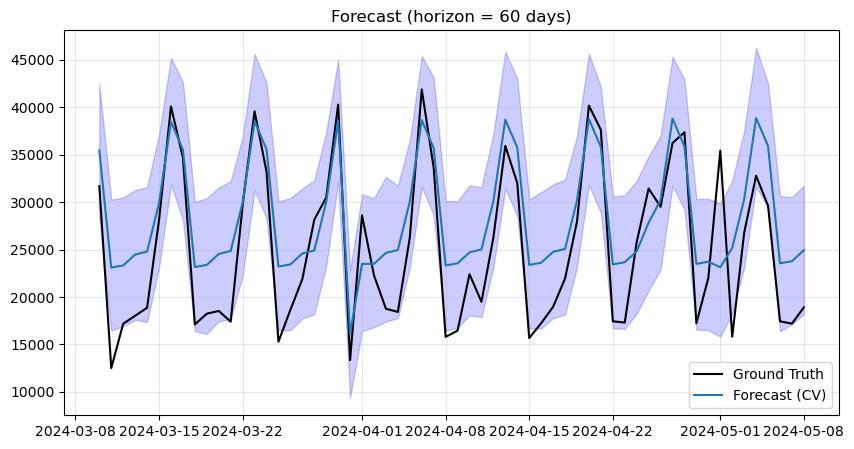


Test set metrics:
RMSE = 5125.12
MAE  = 4400.24

Model components:


C:\Users\andre\AppData\Local\Temp\ipykernel_15544\2502970425.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_final["pre_covid"] = (train_final["ds"] < cutoff_date)
C:\Users\andre\AppData\Local\Temp\ipykernel_15544\2502970425.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_final["post_covid"] = (train_final["ds"] >= cutoff_date)
16:10:42 - cmdstanpy - INFO - Chain [1] start processing
16:10:43 - cmdstanpy - INFO - Chain [1] done processing


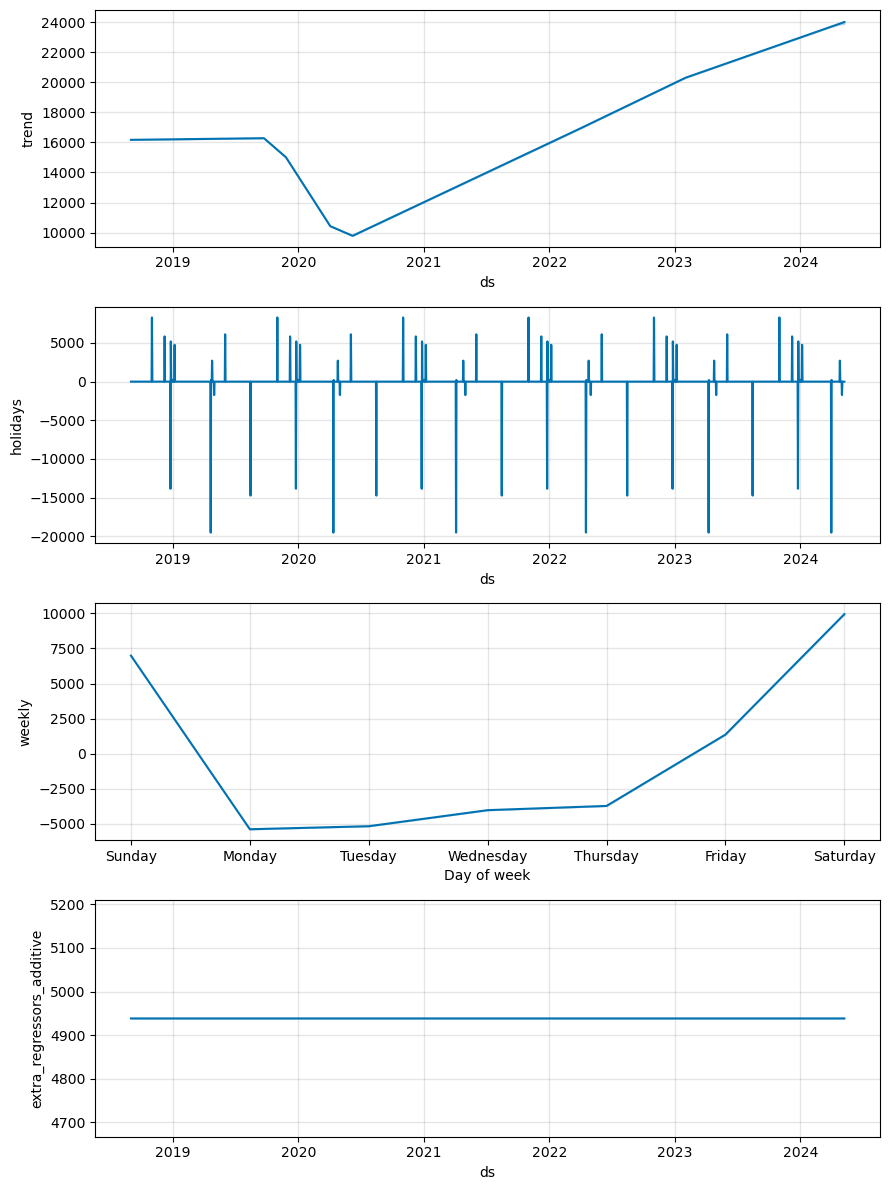

In [21]:
results = fit_prophet_model(
    df=df,
    y_col='totale',
    ds_col='data',
    regressors= ['dummy_emilia_full_open', 'dummy_emilia_restricted_open', 'dummy_emilia_takeaway_only'],
    n_test=60,
    weekly=True,
    monthly=False,
    yearly=False,
    weekly_prepost=False,
    holidays=True,
    verbose = True,
    return_results = True)

In [22]:
with open("models/prophet_model_totale_restaurant_1.json", "w") as f:
    f.write(model_to_json(results["model"]))

## GRID SEARCH ON DF2

<Axes: >

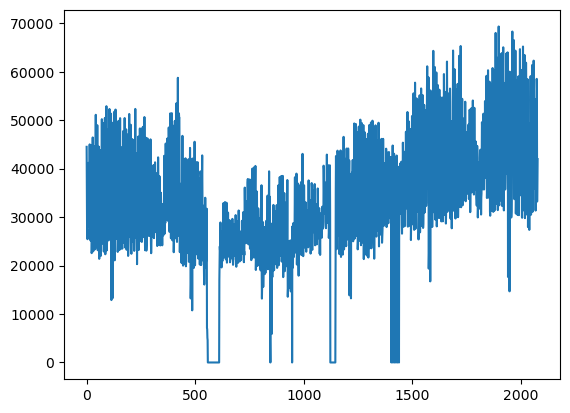

In [16]:
df = pd.read_csv('data/restaurant_2.csv')
df.totale.plot()

In [6]:
results = []

for (w, m, y, wp, h, covid) in param_grid:
    print(f"\n Testing with: weekly={w}, monthly={m}, yearly={y}, prepost={wp}, holidays={h}, covid={covid is not None}")
    
    
        # Fit Prophet
    res = fit_prophet_model(
            df=df,
            y_col="totale",
            ds_col="data",
            n_test=60,
            weekly=w,
            monthly=m,
            yearly=y,
            weekly_prepost=wp,
            holidays=h,
            regressors=covid,
            verbose=False,
            return_results=True
    )

        
    metrics_last = res["metrics_last_window"]
    cv_metrics = res["metrics_cv"]
    rmse_cv_mean = cv_metrics["rmse"].mean()
    mae_cv_mean = cv_metrics["mae"].mean()
      
    results.append({
            "weekly": w,
            "monthly": m,
            "yearly": y,
            "weekly_prepost": wp,
            "holidays": h,
            "covid_regressors": covid,
            "RMSE_last": metrics_last["RMSE"],
            "MAE_last": metrics_last["MAE"],
            "RMSE_cv_mean": rmse_cv_mean,
            "MAE_cv_mean": mae_cv_mean
    })


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=True, covid=False


15:40:12 - cmdstanpy - INFO - Chain [1] start processing
15:40:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:40:12 - cmdstanpy - INFO - Chain [1] start processing
15:40:12 - cmdstanpy - INFO - Chain [1] done processing
15:40:13 - cmdstanpy - INFO - Chain [1] start processing
15:40:13 - cmdstanpy - INFO - Chain [1] done processing
15:40:13 - cmdstanpy - INFO - Chain [1] start processing
15:40:13 - cmdstanpy - INFO - Chain [1] done processing
15:40:14 - cmdstanpy - INFO - Chain [1] start processing
15:40:14 - cmdstanpy - INFO - Chain [1] done processing
15:40:14 - cmdstanpy - INFO - Chain [1] start processing
15:40:14 - cmdstanpy - INFO - Chain [1] done processing
15:40:15 - cmdstanpy - INFO - Chain [1] start processing
15:40:15 - cmdstanpy - INFO - Chain [1] done processing
15:40:15 - cmdstanpy - INFO - Chain [1] start processing
15:40:15 - cmdstanpy - INFO - Chain [1] done processing
15:40:16 - cmdstanpy - INFO - Chain [1] start processing
15:40:16 - cmdstanpy - INFO - Chain [1] done processing
15:40:16 - cmdstanpy - INFO - Chain [1] start processing
15:40:16 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


15:40:30 - cmdstanpy - INFO - Chain [1] start processing
15:40:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:40:31 - cmdstanpy - INFO - Chain [1] start processing
15:40:32 - cmdstanpy - INFO - Chain [1] done processing
15:40:32 - cmdstanpy - INFO - Chain [1] start processing
15:40:32 - cmdstanpy - INFO - Chain [1] done processing
15:40:33 - cmdstanpy - INFO - Chain [1] start processing
15:40:33 - cmdstanpy - INFO - Chain [1] done processing
15:40:34 - cmdstanpy - INFO - Chain [1] start processing
15:40:34 - cmdstanpy - INFO - Chain [1] done processing
15:40:35 - cmdstanpy - INFO - Chain [1] start processing
15:40:35 - cmdstanpy - INFO - Chain [1] done processing
15:40:36 - cmdstanpy - INFO - Chain [1] start processing
15:40:36 - cmdstanpy - INFO - Chain [1] done processing
15:40:37 - cmdstanpy - INFO - Chain [1] start processing
15:40:37 - cmdstanpy - INFO - Chain [1] done processing
15:40:38 - cmdstanpy - INFO - Chain [1] start processing
15:40:38 - cmdstanpy - INFO - Chain [1] done processing
15:40:39 - cmdstanpy - INFO - Chain [1] start processing
15:40:40 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


15:40:57 - cmdstanpy - INFO - Chain [1] start processing
15:40:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:40:58 - cmdstanpy - INFO - Chain [1] start processing
15:40:58 - cmdstanpy - INFO - Chain [1] done processing
15:40:59 - cmdstanpy - INFO - Chain [1] start processing
15:40:59 - cmdstanpy - INFO - Chain [1] done processing
15:40:59 - cmdstanpy - INFO - Chain [1] start processing
15:41:00 - cmdstanpy - INFO - Chain [1] done processing
15:41:00 - cmdstanpy - INFO - Chain [1] start processing
15:41:01 - cmdstanpy - INFO - Chain [1] done processing
15:41:01 - cmdstanpy - INFO - Chain [1] start processing
15:41:01 - cmdstanpy - INFO - Chain [1] done processing
15:41:02 - cmdstanpy - INFO - Chain [1] start processing
15:41:02 - cmdstanpy - INFO - Chain [1] done processing
15:41:03 - cmdstanpy - INFO - Chain [1] start processing
15:41:04 - cmdstanpy - INFO - Chain [1] done processing
15:41:04 - cmdstanpy - INFO - Chain [1] start processing
15:41:05 - cmdstanpy - INFO - Chain [1] done processing
15:41:05 - cmdstanpy - INFO - Chain [1] start processing
15:41:06 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=False, covid=False


15:41:22 - cmdstanpy - INFO - Chain [1] start processing
15:41:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:41:23 - cmdstanpy - INFO - Chain [1] start processing
15:41:24 - cmdstanpy - INFO - Chain [1] done processing
15:41:24 - cmdstanpy - INFO - Chain [1] start processing
15:41:24 - cmdstanpy - INFO - Chain [1] done processing
15:41:25 - cmdstanpy - INFO - Chain [1] start processing
15:41:25 - cmdstanpy - INFO - Chain [1] done processing
15:41:25 - cmdstanpy - INFO - Chain [1] start processing
15:41:26 - cmdstanpy - INFO - Chain [1] done processing
15:41:26 - cmdstanpy - INFO - Chain [1] start processing
15:41:26 - cmdstanpy - INFO - Chain [1] done processing
15:41:27 - cmdstanpy - INFO - Chain [1] start processing
15:41:27 - cmdstanpy - INFO - Chain [1] done processing
15:41:28 - cmdstanpy - INFO - Chain [1] start processing
15:41:28 - cmdstanpy - INFO - Chain [1] done processing
15:41:29 - cmdstanpy - INFO - Chain [1] start processing
15:41:29 - cmdstanpy - INFO - Chain [1] done processing
15:41:29 - cmdstanpy - INFO - Chain [1] start processing
15:41:30 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


15:41:47 - cmdstanpy - INFO - Chain [1] start processing
15:41:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:41:48 - cmdstanpy - INFO - Chain [1] start processing
15:41:48 - cmdstanpy - INFO - Chain [1] done processing
15:41:49 - cmdstanpy - INFO - Chain [1] start processing
15:41:50 - cmdstanpy - INFO - Chain [1] done processing
15:41:50 - cmdstanpy - INFO - Chain [1] start processing
15:41:51 - cmdstanpy - INFO - Chain [1] done processing
15:41:51 - cmdstanpy - INFO - Chain [1] start processing
15:41:52 - cmdstanpy - INFO - Chain [1] done processing
15:41:53 - cmdstanpy - INFO - Chain [1] start processing
15:41:53 - cmdstanpy - INFO - Chain [1] done processing
15:41:54 - cmdstanpy - INFO - Chain [1] start processing
15:41:54 - cmdstanpy - INFO - Chain [1] done processing
15:41:55 - cmdstanpy - INFO - Chain [1] start processing
15:41:56 - cmdstanpy - INFO - Chain [1] done processing
15:41:57 - cmdstanpy - INFO - Chain [1] start processing
15:41:57 - cmdstanpy - INFO - Chain [1] done processing
15:41:58 - cmdstanpy - INFO - Chain [1] start processing
15:41:59 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


15:42:15 - cmdstanpy - INFO - Chain [1] start processing
15:42:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:42:17 - cmdstanpy - INFO - Chain [1] start processing
15:42:17 - cmdstanpy - INFO - Chain [1] done processing
15:42:18 - cmdstanpy - INFO - Chain [1] start processing
15:42:18 - cmdstanpy - INFO - Chain [1] done processing
15:42:18 - cmdstanpy - INFO - Chain [1] start processing
15:42:18 - cmdstanpy - INFO - Chain [1] done processing
15:42:19 - cmdstanpy - INFO - Chain [1] start processing
15:42:19 - cmdstanpy - INFO - Chain [1] done processing
15:42:20 - cmdstanpy - INFO - Chain [1] start processing
15:42:20 - cmdstanpy - INFO - Chain [1] done processing
15:42:21 - cmdstanpy - INFO - Chain [1] start processing
15:42:21 - cmdstanpy - INFO - Chain [1] done processing
15:42:21 - cmdstanpy - INFO - Chain [1] start processing
15:42:22 - cmdstanpy - INFO - Chain [1] done processing
15:42:22 - cmdstanpy - INFO - Chain [1] start processing
15:42:23 - cmdstanpy - INFO - Chain [1] done processing
15:42:23 - cmdstanpy - INFO - Chain [1] start processing
15:42:23 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=True, covid=False


15:42:33 - cmdstanpy - INFO - Chain [1] start processing
15:42:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:42:34 - cmdstanpy - INFO - Chain [1] start processing
15:42:34 - cmdstanpy - INFO - Chain [1] done processing
15:42:34 - cmdstanpy - INFO - Chain [1] start processing
15:42:35 - cmdstanpy - INFO - Chain [1] done processing
15:42:35 - cmdstanpy - INFO - Chain [1] start processing
15:42:35 - cmdstanpy - INFO - Chain [1] done processing
15:42:35 - cmdstanpy - INFO - Chain [1] start processing
15:42:36 - cmdstanpy - INFO - Chain [1] done processing
15:42:36 - cmdstanpy - INFO - Chain [1] start processing
15:42:36 - cmdstanpy - INFO - Chain [1] done processing
15:42:37 - cmdstanpy - INFO - Chain [1] start processing
15:42:37 - cmdstanpy - INFO - Chain [1] done processing
15:42:37 - cmdstanpy - INFO - Chain [1] start processing
15:42:37 - cmdstanpy - INFO - Chain [1] done processing
15:42:38 - cmdstanpy - INFO - Chain [1] start processing
15:42:38 - cmdstanpy - INFO - Chain [1] done processing
15:42:39 - cmdstanpy - INFO - Chain [1] start processing
15:42:39 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


15:42:50 - cmdstanpy - INFO - Chain [1] start processing
15:42:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:42:51 - cmdstanpy - INFO - Chain [1] start processing
15:42:51 - cmdstanpy - INFO - Chain [1] done processing
15:42:52 - cmdstanpy - INFO - Chain [1] start processing
15:42:52 - cmdstanpy - INFO - Chain [1] done processing
15:42:52 - cmdstanpy - INFO - Chain [1] start processing
15:42:52 - cmdstanpy - INFO - Chain [1] done processing
15:42:53 - cmdstanpy - INFO - Chain [1] start processing
15:42:53 - cmdstanpy - INFO - Chain [1] done processing
15:42:53 - cmdstanpy - INFO - Chain [1] start processing
15:42:54 - cmdstanpy - INFO - Chain [1] done processing
15:42:54 - cmdstanpy - INFO - Chain [1] start processing
15:42:54 - cmdstanpy - INFO - Chain [1] done processing
15:42:55 - cmdstanpy - INFO - Chain [1] start processing
15:42:55 - cmdstanpy - INFO - Chain [1] done processing
15:42:55 - cmdstanpy - INFO - Chain [1] start processing
15:42:56 - cmdstanpy - INFO - Chain [1] done processing
15:42:56 - cmdstanpy - INFO - Chain [1] start processing
15:42:56 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


15:43:05 - cmdstanpy - INFO - Chain [1] start processing
15:43:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:43:06 - cmdstanpy - INFO - Chain [1] start processing
15:43:06 - cmdstanpy - INFO - Chain [1] done processing
15:43:06 - cmdstanpy - INFO - Chain [1] start processing
15:43:06 - cmdstanpy - INFO - Chain [1] done processing
15:43:07 - cmdstanpy - INFO - Chain [1] start processing
15:43:07 - cmdstanpy - INFO - Chain [1] done processing
15:43:07 - cmdstanpy - INFO - Chain [1] start processing
15:43:07 - cmdstanpy - INFO - Chain [1] done processing
15:43:08 - cmdstanpy - INFO - Chain [1] start processing
15:43:08 - cmdstanpy - INFO - Chain [1] done processing
15:43:08 - cmdstanpy - INFO - Chain [1] start processing
15:43:08 - cmdstanpy - INFO - Chain [1] done processing
15:43:09 - cmdstanpy - INFO - Chain [1] start processing
15:43:09 - cmdstanpy - INFO - Chain [1] done processing
15:43:09 - cmdstanpy - INFO - Chain [1] start processing
15:43:09 - cmdstanpy - INFO - Chain [1] done processing
15:43:10 - cmdstanpy - INFO - Chain [1] start processing
15:43:10 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=False, covid=False


15:43:19 - cmdstanpy - INFO - Chain [1] start processing
15:43:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:43:19 - cmdstanpy - INFO - Chain [1] start processing
15:43:20 - cmdstanpy - INFO - Chain [1] done processing
15:43:20 - cmdstanpy - INFO - Chain [1] start processing
15:43:20 - cmdstanpy - INFO - Chain [1] done processing
15:43:20 - cmdstanpy - INFO - Chain [1] start processing
15:43:20 - cmdstanpy - INFO - Chain [1] done processing
15:43:21 - cmdstanpy - INFO - Chain [1] start processing
15:43:21 - cmdstanpy - INFO - Chain [1] done processing
15:43:21 - cmdstanpy - INFO - Chain [1] start processing
15:43:21 - cmdstanpy - INFO - Chain [1] done processing
15:43:21 - cmdstanpy - INFO - Chain [1] start processing
15:43:22 - cmdstanpy - INFO - Chain [1] done processing
15:43:22 - cmdstanpy - INFO - Chain [1] start processing
15:43:22 - cmdstanpy - INFO - Chain [1] done processing
15:43:22 - cmdstanpy - INFO - Chain [1] start processing
15:43:23 - cmdstanpy - INFO - Chain [1] done processing
15:43:23 - cmdstanpy - INFO - Chain [1] start processing
15:43:23 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


15:43:31 - cmdstanpy - INFO - Chain [1] start processing
15:43:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:43:31 - cmdstanpy - INFO - Chain [1] start processing
15:43:31 - cmdstanpy - INFO - Chain [1] done processing
15:43:32 - cmdstanpy - INFO - Chain [1] start processing
15:43:32 - cmdstanpy - INFO - Chain [1] done processing
15:43:32 - cmdstanpy - INFO - Chain [1] start processing
15:43:32 - cmdstanpy - INFO - Chain [1] done processing
15:43:32 - cmdstanpy - INFO - Chain [1] start processing
15:43:33 - cmdstanpy - INFO - Chain [1] done processing
15:43:33 - cmdstanpy - INFO - Chain [1] start processing
15:43:33 - cmdstanpy - INFO - Chain [1] done processing
15:43:33 - cmdstanpy - INFO - Chain [1] start processing
15:43:33 - cmdstanpy - INFO - Chain [1] done processing
15:43:34 - cmdstanpy - INFO - Chain [1] start processing
15:43:34 - cmdstanpy - INFO - Chain [1] done processing
15:43:34 - cmdstanpy - INFO - Chain [1] start processing
15:43:34 - cmdstanpy - INFO - Chain [1] done processing
15:43:35 - cmdstanpy - INFO - Chain [1] start processing
15:43:35 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


15:43:44 - cmdstanpy - INFO - Chain [1] start processing
15:43:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:43:44 - cmdstanpy - INFO - Chain [1] start processing
15:43:44 - cmdstanpy - INFO - Chain [1] done processing
15:43:44 - cmdstanpy - INFO - Chain [1] start processing
15:43:45 - cmdstanpy - INFO - Chain [1] done processing
15:43:45 - cmdstanpy - INFO - Chain [1] start processing
15:43:45 - cmdstanpy - INFO - Chain [1] done processing
15:43:45 - cmdstanpy - INFO - Chain [1] start processing
15:43:46 - cmdstanpy - INFO - Chain [1] done processing
15:43:46 - cmdstanpy - INFO - Chain [1] start processing
15:43:46 - cmdstanpy - INFO - Chain [1] done processing
15:43:46 - cmdstanpy - INFO - Chain [1] start processing
15:43:46 - cmdstanpy - INFO - Chain [1] done processing
15:43:47 - cmdstanpy - INFO - Chain [1] start processing
15:43:47 - cmdstanpy - INFO - Chain [1] done processing
15:43:47 - cmdstanpy - INFO - Chain [1] start processing
15:43:47 - cmdstanpy - INFO - Chain [1] done processing
15:43:48 - cmdstanpy - INFO - Chain [1] start processing
15:43:48 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=True, covid=False


15:43:56 - cmdstanpy - INFO - Chain [1] start processing
15:43:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:43:56 - cmdstanpy - INFO - Chain [1] start processing
15:43:57 - cmdstanpy - INFO - Chain [1] done processing
15:43:57 - cmdstanpy - INFO - Chain [1] start processing
15:43:57 - cmdstanpy - INFO - Chain [1] done processing
15:43:57 - cmdstanpy - INFO - Chain [1] start processing
15:43:57 - cmdstanpy - INFO - Chain [1] done processing
15:43:58 - cmdstanpy - INFO - Chain [1] start processing
15:43:58 - cmdstanpy - INFO - Chain [1] done processing
15:43:58 - cmdstanpy - INFO - Chain [1] start processing
15:43:58 - cmdstanpy - INFO - Chain [1] done processing
15:43:59 - cmdstanpy - INFO - Chain [1] start processing
15:43:59 - cmdstanpy - INFO - Chain [1] done processing
15:43:59 - cmdstanpy - INFO - Chain [1] start processing
15:43:59 - cmdstanpy - INFO - Chain [1] done processing
15:44:00 - cmdstanpy - INFO - Chain [1] start processing
15:44:00 - cmdstanpy - INFO - Chain [1] done processing
15:44:00 - cmdstanpy - INFO - Chain [1] start processing
15:44:00 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


15:44:08 - cmdstanpy - INFO - Chain [1] start processing
15:44:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:44:09 - cmdstanpy - INFO - Chain [1] start processing
15:44:09 - cmdstanpy - INFO - Chain [1] done processing
15:44:09 - cmdstanpy - INFO - Chain [1] start processing
15:44:10 - cmdstanpy - INFO - Chain [1] done processing
15:44:10 - cmdstanpy - INFO - Chain [1] start processing
15:44:10 - cmdstanpy - INFO - Chain [1] done processing
15:44:10 - cmdstanpy - INFO - Chain [1] start processing
15:44:11 - cmdstanpy - INFO - Chain [1] done processing
15:44:11 - cmdstanpy - INFO - Chain [1] start processing
15:44:11 - cmdstanpy - INFO - Chain [1] done processing
15:44:11 - cmdstanpy - INFO - Chain [1] start processing
15:44:12 - cmdstanpy - INFO - Chain [1] done processing
15:44:12 - cmdstanpy - INFO - Chain [1] start processing
15:44:12 - cmdstanpy - INFO - Chain [1] done processing
15:44:13 - cmdstanpy - INFO - Chain [1] start processing
15:44:13 - cmdstanpy - INFO - Chain [1] done processing
15:44:13 - cmdstanpy - INFO - Chain [1] start processing
15:44:13 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


15:44:21 - cmdstanpy - INFO - Chain [1] start processing
15:44:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:44:22 - cmdstanpy - INFO - Chain [1] start processing
15:44:22 - cmdstanpy - INFO - Chain [1] done processing
15:44:22 - cmdstanpy - INFO - Chain [1] start processing
15:44:23 - cmdstanpy - INFO - Chain [1] done processing
15:44:23 - cmdstanpy - INFO - Chain [1] start processing
15:44:23 - cmdstanpy - INFO - Chain [1] done processing
15:44:23 - cmdstanpy - INFO - Chain [1] start processing
15:44:23 - cmdstanpy - INFO - Chain [1] done processing
15:44:24 - cmdstanpy - INFO - Chain [1] start processing
15:44:24 - cmdstanpy - INFO - Chain [1] done processing
15:44:24 - cmdstanpy - INFO - Chain [1] start processing
15:44:24 - cmdstanpy - INFO - Chain [1] done processing
15:44:25 - cmdstanpy - INFO - Chain [1] start processing
15:44:25 - cmdstanpy - INFO - Chain [1] done processing
15:44:25 - cmdstanpy - INFO - Chain [1] start processing
15:44:26 - cmdstanpy - INFO - Chain [1] done processing
15:44:26 - cmdstanpy - INFO - Chain [1] start processing
15:44:27 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=False, covid=False


15:44:43 - cmdstanpy - INFO - Chain [1] start processing
15:44:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:44:44 - cmdstanpy - INFO - Chain [1] start processing
15:44:44 - cmdstanpy - INFO - Chain [1] done processing
15:44:44 - cmdstanpy - INFO - Chain [1] start processing
15:44:45 - cmdstanpy - INFO - Chain [1] done processing
15:44:45 - cmdstanpy - INFO - Chain [1] start processing
15:44:45 - cmdstanpy - INFO - Chain [1] done processing
15:44:46 - cmdstanpy - INFO - Chain [1] start processing
15:44:46 - cmdstanpy - INFO - Chain [1] done processing
15:44:47 - cmdstanpy - INFO - Chain [1] start processing
15:44:47 - cmdstanpy - INFO - Chain [1] done processing
15:44:47 - cmdstanpy - INFO - Chain [1] start processing
15:44:48 - cmdstanpy - INFO - Chain [1] done processing
15:44:48 - cmdstanpy - INFO - Chain [1] start processing
15:44:48 - cmdstanpy - INFO - Chain [1] done processing
15:44:49 - cmdstanpy - INFO - Chain [1] start processing
15:44:49 - cmdstanpy - INFO - Chain [1] done processing
15:44:50 - cmdstanpy - INFO - Chain [1] start processing
15:44:50 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


15:45:03 - cmdstanpy - INFO - Chain [1] start processing
15:45:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:45:04 - cmdstanpy - INFO - Chain [1] start processing
15:45:04 - cmdstanpy - INFO - Chain [1] done processing
15:45:04 - cmdstanpy - INFO - Chain [1] start processing
15:45:05 - cmdstanpy - INFO - Chain [1] done processing
15:45:05 - cmdstanpy - INFO - Chain [1] start processing
15:45:05 - cmdstanpy - INFO - Chain [1] done processing
15:45:06 - cmdstanpy - INFO - Chain [1] start processing
15:45:06 - cmdstanpy - INFO - Chain [1] done processing
15:45:07 - cmdstanpy - INFO - Chain [1] start processing
15:45:07 - cmdstanpy - INFO - Chain [1] done processing
15:45:08 - cmdstanpy - INFO - Chain [1] start processing
15:45:08 - cmdstanpy - INFO - Chain [1] done processing
15:45:08 - cmdstanpy - INFO - Chain [1] start processing
15:45:09 - cmdstanpy - INFO - Chain [1] done processing
15:45:09 - cmdstanpy - INFO - Chain [1] start processing
15:45:09 - cmdstanpy - INFO - Chain [1] done processing
15:45:10 - cmdstanpy - INFO - Chain [1] start processing
15:45:10 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


15:45:24 - cmdstanpy - INFO - Chain [1] start processing
15:45:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:45:25 - cmdstanpy - INFO - Chain [1] start processing
15:45:25 - cmdstanpy - INFO - Chain [1] done processing
15:45:26 - cmdstanpy - INFO - Chain [1] start processing
15:45:26 - cmdstanpy - INFO - Chain [1] done processing
15:45:27 - cmdstanpy - INFO - Chain [1] start processing
15:45:27 - cmdstanpy - INFO - Chain [1] done processing
15:45:28 - cmdstanpy - INFO - Chain [1] start processing
15:45:28 - cmdstanpy - INFO - Chain [1] done processing
15:45:28 - cmdstanpy - INFO - Chain [1] start processing
15:45:29 - cmdstanpy - INFO - Chain [1] done processing
15:45:29 - cmdstanpy - INFO - Chain [1] start processing
15:45:29 - cmdstanpy - INFO - Chain [1] done processing
15:45:30 - cmdstanpy - INFO - Chain [1] start processing
15:45:30 - cmdstanpy - INFO - Chain [1] done processing
15:45:31 - cmdstanpy - INFO - Chain [1] start processing
15:45:31 - cmdstanpy - INFO - Chain [1] done processing
15:45:32 - cmdstanpy - INFO - Chain [1] start processing
15:45:32 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=True, covid=False


15:45:47 - cmdstanpy - INFO - Chain [1] start processing
15:45:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:45:48 - cmdstanpy - INFO - Chain [1] start processing
15:45:48 - cmdstanpy - INFO - Chain [1] done processing
15:45:48 - cmdstanpy - INFO - Chain [1] start processing
15:45:49 - cmdstanpy - INFO - Chain [1] done processing
15:45:49 - cmdstanpy - INFO - Chain [1] start processing
15:45:49 - cmdstanpy - INFO - Chain [1] done processing
15:45:50 - cmdstanpy - INFO - Chain [1] start processing
15:45:50 - cmdstanpy - INFO - Chain [1] done processing
15:45:51 - cmdstanpy - INFO - Chain [1] start processing
15:45:51 - cmdstanpy - INFO - Chain [1] done processing
15:45:51 - cmdstanpy - INFO - Chain [1] start processing
15:45:52 - cmdstanpy - INFO - Chain [1] done processing
15:45:52 - cmdstanpy - INFO - Chain [1] start processing
15:45:53 - cmdstanpy - INFO - Chain [1] done processing
15:45:53 - cmdstanpy - INFO - Chain [1] start processing
15:45:53 - cmdstanpy - INFO - Chain [1] done processing
15:45:54 - cmdstanpy - INFO - Chain [1] start processing
15:45:54 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


15:46:07 - cmdstanpy - INFO - Chain [1] start processing
15:46:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:46:08 - cmdstanpy - INFO - Chain [1] start processing
15:46:08 - cmdstanpy - INFO - Chain [1] done processing
15:46:09 - cmdstanpy - INFO - Chain [1] start processing
15:46:09 - cmdstanpy - INFO - Chain [1] done processing
15:46:10 - cmdstanpy - INFO - Chain [1] start processing
15:46:10 - cmdstanpy - INFO - Chain [1] done processing
15:46:10 - cmdstanpy - INFO - Chain [1] start processing
15:46:11 - cmdstanpy - INFO - Chain [1] done processing
15:46:11 - cmdstanpy - INFO - Chain [1] start processing
15:46:12 - cmdstanpy - INFO - Chain [1] done processing
15:46:12 - cmdstanpy - INFO - Chain [1] start processing
15:46:12 - cmdstanpy - INFO - Chain [1] done processing
15:46:13 - cmdstanpy - INFO - Chain [1] start processing
15:46:13 - cmdstanpy - INFO - Chain [1] done processing
15:46:14 - cmdstanpy - INFO - Chain [1] start processing
15:46:14 - cmdstanpy - INFO - Chain [1] done processing
15:46:15 - cmdstanpy - INFO - Chain [1] start processing
15:46:15 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


15:46:31 - cmdstanpy - INFO - Chain [1] start processing
15:46:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:46:32 - cmdstanpy - INFO - Chain [1] start processing
15:46:32 - cmdstanpy - INFO - Chain [1] done processing
15:46:33 - cmdstanpy - INFO - Chain [1] start processing
15:46:33 - cmdstanpy - INFO - Chain [1] done processing
15:46:34 - cmdstanpy - INFO - Chain [1] start processing
15:46:34 - cmdstanpy - INFO - Chain [1] done processing
15:46:34 - cmdstanpy - INFO - Chain [1] start processing
15:46:35 - cmdstanpy - INFO - Chain [1] done processing
15:46:35 - cmdstanpy - INFO - Chain [1] start processing
15:46:36 - cmdstanpy - INFO - Chain [1] done processing
15:46:36 - cmdstanpy - INFO - Chain [1] start processing
15:46:36 - cmdstanpy - INFO - Chain [1] done processing
15:46:37 - cmdstanpy - INFO - Chain [1] start processing
15:46:37 - cmdstanpy - INFO - Chain [1] done processing
15:46:38 - cmdstanpy - INFO - Chain [1] start processing
15:46:38 - cmdstanpy - INFO - Chain [1] done processing
15:46:39 - cmdstanpy - INFO - Chain [1] start processing
15:46:39 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=False, covid=False


15:46:55 - cmdstanpy - INFO - Chain [1] start processing
15:46:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:46:56 - cmdstanpy - INFO - Chain [1] start processing
15:46:56 - cmdstanpy - INFO - Chain [1] done processing
15:46:56 - cmdstanpy - INFO - Chain [1] start processing
15:46:57 - cmdstanpy - INFO - Chain [1] done processing
15:46:57 - cmdstanpy - INFO - Chain [1] start processing
15:46:57 - cmdstanpy - INFO - Chain [1] done processing
15:46:58 - cmdstanpy - INFO - Chain [1] start processing
15:46:58 - cmdstanpy - INFO - Chain [1] done processing
15:46:58 - cmdstanpy - INFO - Chain [1] start processing
15:46:59 - cmdstanpy - INFO - Chain [1] done processing
15:46:59 - cmdstanpy - INFO - Chain [1] start processing
15:47:00 - cmdstanpy - INFO - Chain [1] done processing
15:47:00 - cmdstanpy - INFO - Chain [1] start processing
15:47:00 - cmdstanpy - INFO - Chain [1] done processing
15:47:01 - cmdstanpy - INFO - Chain [1] start processing
15:47:01 - cmdstanpy - INFO - Chain [1] done processing
15:47:01 - cmdstanpy - INFO - Chain [1] start processing
15:47:02 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


15:47:14 - cmdstanpy - INFO - Chain [1] start processing
15:47:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:47:14 - cmdstanpy - INFO - Chain [1] start processing
15:47:15 - cmdstanpy - INFO - Chain [1] done processing
15:47:15 - cmdstanpy - INFO - Chain [1] start processing
15:47:15 - cmdstanpy - INFO - Chain [1] done processing
15:47:16 - cmdstanpy - INFO - Chain [1] start processing
15:47:16 - cmdstanpy - INFO - Chain [1] done processing
15:47:17 - cmdstanpy - INFO - Chain [1] start processing
15:47:17 - cmdstanpy - INFO - Chain [1] done processing
15:47:17 - cmdstanpy - INFO - Chain [1] start processing
15:47:18 - cmdstanpy - INFO - Chain [1] done processing
15:47:18 - cmdstanpy - INFO - Chain [1] start processing
15:47:19 - cmdstanpy - INFO - Chain [1] done processing
15:47:19 - cmdstanpy - INFO - Chain [1] start processing
15:47:20 - cmdstanpy - INFO - Chain [1] done processing
15:47:20 - cmdstanpy - INFO - Chain [1] start processing
15:47:20 - cmdstanpy - INFO - Chain [1] done processing
15:47:21 - cmdstanpy - INFO - Chain [1] start processing
15:47:21 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


15:47:33 - cmdstanpy - INFO - Chain [1] start processing
15:47:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:47:34 - cmdstanpy - INFO - Chain [1] start processing
15:47:34 - cmdstanpy - INFO - Chain [1] done processing
15:47:35 - cmdstanpy - INFO - Chain [1] start processing
15:47:35 - cmdstanpy - INFO - Chain [1] done processing
15:47:35 - cmdstanpy - INFO - Chain [1] start processing
15:47:36 - cmdstanpy - INFO - Chain [1] done processing
15:47:36 - cmdstanpy - INFO - Chain [1] start processing
15:47:36 - cmdstanpy - INFO - Chain [1] done processing
15:47:37 - cmdstanpy - INFO - Chain [1] start processing
15:47:37 - cmdstanpy - INFO - Chain [1] done processing
15:47:37 - cmdstanpy - INFO - Chain [1] start processing
15:47:37 - cmdstanpy - INFO - Chain [1] done processing
15:47:38 - cmdstanpy - INFO - Chain [1] start processing
15:47:38 - cmdstanpy - INFO - Chain [1] done processing
15:47:39 - cmdstanpy - INFO - Chain [1] start processing
15:47:39 - cmdstanpy - INFO - Chain [1] done processing
15:47:40 - cmdstanpy - INFO - Chain [1] start processing
15:47:40 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=True, covid=False


15:47:53 - cmdstanpy - INFO - Chain [1] start processing
15:47:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:47:54 - cmdstanpy - INFO - Chain [1] start processing
15:47:54 - cmdstanpy - INFO - Chain [1] done processing
15:47:55 - cmdstanpy - INFO - Chain [1] start processing
15:47:55 - cmdstanpy - INFO - Chain [1] done processing
15:47:55 - cmdstanpy - INFO - Chain [1] start processing
15:47:56 - cmdstanpy - INFO - Chain [1] done processing
15:47:56 - cmdstanpy - INFO - Chain [1] start processing
15:47:56 - cmdstanpy - INFO - Chain [1] done processing
15:47:57 - cmdstanpy - INFO - Chain [1] start processing
15:47:57 - cmdstanpy - INFO - Chain [1] done processing
15:47:58 - cmdstanpy - INFO - Chain [1] start processing
15:47:58 - cmdstanpy - INFO - Chain [1] done processing
15:47:59 - cmdstanpy - INFO - Chain [1] start processing
15:47:59 - cmdstanpy - INFO - Chain [1] done processing
15:48:00 - cmdstanpy - INFO - Chain [1] start processing
15:48:00 - cmdstanpy - INFO - Chain [1] done processing
15:48:01 - cmdstanpy - INFO - Chain [1] start processing
15:48:01 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


15:48:17 - cmdstanpy - INFO - Chain [1] start processing
15:48:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:48:18 - cmdstanpy - INFO - Chain [1] start processing
15:48:18 - cmdstanpy - INFO - Chain [1] done processing
15:48:19 - cmdstanpy - INFO - Chain [1] start processing
15:48:19 - cmdstanpy - INFO - Chain [1] done processing
15:48:20 - cmdstanpy - INFO - Chain [1] start processing
15:48:20 - cmdstanpy - INFO - Chain [1] done processing
15:48:21 - cmdstanpy - INFO - Chain [1] start processing
15:48:21 - cmdstanpy - INFO - Chain [1] done processing
15:48:22 - cmdstanpy - INFO - Chain [1] start processing
15:48:22 - cmdstanpy - INFO - Chain [1] done processing
15:48:23 - cmdstanpy - INFO - Chain [1] start processing
15:48:23 - cmdstanpy - INFO - Chain [1] done processing
15:48:24 - cmdstanpy - INFO - Chain [1] start processing
15:48:24 - cmdstanpy - INFO - Chain [1] done processing
15:48:25 - cmdstanpy - INFO - Chain [1] start processing
15:48:25 - cmdstanpy - INFO - Chain [1] done processing
15:48:26 - cmdstanpy - INFO - Chain [1] start processing
15:48:26 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


15:48:45 - cmdstanpy - INFO - Chain [1] start processing
15:48:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:48:46 - cmdstanpy - INFO - Chain [1] start processing
15:48:46 - cmdstanpy - INFO - Chain [1] done processing
15:48:46 - cmdstanpy - INFO - Chain [1] start processing
15:48:47 - cmdstanpy - INFO - Chain [1] done processing
15:48:47 - cmdstanpy - INFO - Chain [1] start processing
15:48:48 - cmdstanpy - INFO - Chain [1] done processing
15:48:48 - cmdstanpy - INFO - Chain [1] start processing
15:48:49 - cmdstanpy - INFO - Chain [1] done processing
15:48:49 - cmdstanpy - INFO - Chain [1] start processing
15:48:50 - cmdstanpy - INFO - Chain [1] done processing
15:48:50 - cmdstanpy - INFO - Chain [1] start processing
15:48:51 - cmdstanpy - INFO - Chain [1] done processing
15:48:51 - cmdstanpy - INFO - Chain [1] start processing
15:48:52 - cmdstanpy - INFO - Chain [1] done processing
15:48:52 - cmdstanpy - INFO - Chain [1] start processing
15:48:53 - cmdstanpy - INFO - Chain [1] done processing
15:48:53 - cmdstanpy - INFO - Chain [1] start processing
15:48:54 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=False, covid=False


15:49:10 - cmdstanpy - INFO - Chain [1] start processing
15:49:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:49:11 - cmdstanpy - INFO - Chain [1] start processing
15:49:11 - cmdstanpy - INFO - Chain [1] done processing
15:49:12 - cmdstanpy - INFO - Chain [1] start processing
15:49:12 - cmdstanpy - INFO - Chain [1] done processing
15:49:12 - cmdstanpy - INFO - Chain [1] start processing
15:49:12 - cmdstanpy - INFO - Chain [1] done processing
15:49:13 - cmdstanpy - INFO - Chain [1] start processing
15:49:13 - cmdstanpy - INFO - Chain [1] done processing
15:49:13 - cmdstanpy - INFO - Chain [1] start processing
15:49:14 - cmdstanpy - INFO - Chain [1] done processing
15:49:14 - cmdstanpy - INFO - Chain [1] start processing
15:49:14 - cmdstanpy - INFO - Chain [1] done processing
15:49:15 - cmdstanpy - INFO - Chain [1] start processing
15:49:15 - cmdstanpy - INFO - Chain [1] done processing
15:49:16 - cmdstanpy - INFO - Chain [1] start processing
15:49:16 - cmdstanpy - INFO - Chain [1] done processing
15:49:17 - cmdstanpy - INFO - Chain [1] start processing
15:49:17 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


15:49:26 - cmdstanpy - INFO - Chain [1] start processing
15:49:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:49:27 - cmdstanpy - INFO - Chain [1] start processing
15:49:27 - cmdstanpy - INFO - Chain [1] done processing
15:49:27 - cmdstanpy - INFO - Chain [1] start processing
15:49:27 - cmdstanpy - INFO - Chain [1] done processing
15:49:28 - cmdstanpy - INFO - Chain [1] start processing
15:49:28 - cmdstanpy - INFO - Chain [1] done processing
15:49:28 - cmdstanpy - INFO - Chain [1] start processing
15:49:28 - cmdstanpy - INFO - Chain [1] done processing
15:49:29 - cmdstanpy - INFO - Chain [1] start processing
15:49:29 - cmdstanpy - INFO - Chain [1] done processing
15:49:29 - cmdstanpy - INFO - Chain [1] start processing
15:49:30 - cmdstanpy - INFO - Chain [1] done processing
15:49:30 - cmdstanpy - INFO - Chain [1] start processing
15:49:30 - cmdstanpy - INFO - Chain [1] done processing
15:49:31 - cmdstanpy - INFO - Chain [1] start processing
15:49:31 - cmdstanpy - INFO - Chain [1] done processing
15:49:31 - cmdstanpy - INFO - Chain [1] start processing
15:49:32 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


15:49:41 - cmdstanpy - INFO - Chain [1] start processing
15:49:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:49:41 - cmdstanpy - INFO - Chain [1] start processing
15:49:41 - cmdstanpy - INFO - Chain [1] done processing
15:49:42 - cmdstanpy - INFO - Chain [1] start processing
15:49:42 - cmdstanpy - INFO - Chain [1] done processing
15:49:42 - cmdstanpy - INFO - Chain [1] start processing
15:49:42 - cmdstanpy - INFO - Chain [1] done processing
15:49:42 - cmdstanpy - INFO - Chain [1] start processing
15:49:42 - cmdstanpy - INFO - Chain [1] done processing
15:49:43 - cmdstanpy - INFO - Chain [1] start processing
15:49:43 - cmdstanpy - INFO - Chain [1] done processing
15:49:43 - cmdstanpy - INFO - Chain [1] start processing
15:49:43 - cmdstanpy - INFO - Chain [1] done processing
15:49:43 - cmdstanpy - INFO - Chain [1] start processing
15:49:44 - cmdstanpy - INFO - Chain [1] done processing
15:49:44 - cmdstanpy - INFO - Chain [1] start processing
15:49:45 - cmdstanpy - INFO - Chain [1] done processing
15:49:45 - cmdstanpy - INFO - Chain [1] start processing
15:49:46 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=True, covid=False


15:50:01 - cmdstanpy - INFO - Chain [1] start processing
15:50:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:50:02 - cmdstanpy - INFO - Chain [1] start processing
15:50:02 - cmdstanpy - INFO - Chain [1] done processing
15:50:03 - cmdstanpy - INFO - Chain [1] start processing
15:50:03 - cmdstanpy - INFO - Chain [1] done processing
15:50:04 - cmdstanpy - INFO - Chain [1] start processing
15:50:04 - cmdstanpy - INFO - Chain [1] done processing
15:50:04 - cmdstanpy - INFO - Chain [1] start processing
15:50:05 - cmdstanpy - INFO - Chain [1] done processing
15:50:05 - cmdstanpy - INFO - Chain [1] start processing
15:50:06 - cmdstanpy - INFO - Chain [1] done processing
15:50:06 - cmdstanpy - INFO - Chain [1] start processing
15:50:06 - cmdstanpy - INFO - Chain [1] done processing
15:50:07 - cmdstanpy - INFO - Chain [1] start processing
15:50:07 - cmdstanpy - INFO - Chain [1] done processing
15:50:08 - cmdstanpy - INFO - Chain [1] start processing
15:50:08 - cmdstanpy - INFO - Chain [1] done processing
15:50:09 - cmdstanpy - INFO - Chain [1] start processing
15:50:09 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


15:50:24 - cmdstanpy - INFO - Chain [1] start processing
15:50:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:50:25 - cmdstanpy - INFO - Chain [1] start processing
15:50:25 - cmdstanpy - INFO - Chain [1] done processing
15:50:26 - cmdstanpy - INFO - Chain [1] start processing
15:50:26 - cmdstanpy - INFO - Chain [1] done processing
15:50:27 - cmdstanpy - INFO - Chain [1] start processing
15:50:27 - cmdstanpy - INFO - Chain [1] done processing
15:50:27 - cmdstanpy - INFO - Chain [1] start processing
15:50:27 - cmdstanpy - INFO - Chain [1] done processing
15:50:28 - cmdstanpy - INFO - Chain [1] start processing
15:50:28 - cmdstanpy - INFO - Chain [1] done processing
15:50:28 - cmdstanpy - INFO - Chain [1] start processing
15:50:29 - cmdstanpy - INFO - Chain [1] done processing
15:50:29 - cmdstanpy - INFO - Chain [1] start processing
15:50:29 - cmdstanpy - INFO - Chain [1] done processing
15:50:30 - cmdstanpy - INFO - Chain [1] start processing
15:50:30 - cmdstanpy - INFO - Chain [1] done processing
15:50:30 - cmdstanpy - INFO - Chain [1] start processing
15:50:31 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


15:50:41 - cmdstanpy - INFO - Chain [1] start processing
15:50:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:50:42 - cmdstanpy - INFO - Chain [1] start processing
15:50:42 - cmdstanpy - INFO - Chain [1] done processing
15:50:42 - cmdstanpy - INFO - Chain [1] start processing
15:50:43 - cmdstanpy - INFO - Chain [1] done processing
15:50:43 - cmdstanpy - INFO - Chain [1] start processing
15:50:43 - cmdstanpy - INFO - Chain [1] done processing
15:50:43 - cmdstanpy - INFO - Chain [1] start processing
15:50:44 - cmdstanpy - INFO - Chain [1] done processing
15:50:44 - cmdstanpy - INFO - Chain [1] start processing
15:50:44 - cmdstanpy - INFO - Chain [1] done processing
15:50:44 - cmdstanpy - INFO - Chain [1] start processing
15:50:45 - cmdstanpy - INFO - Chain [1] done processing
15:50:45 - cmdstanpy - INFO - Chain [1] start processing
15:50:45 - cmdstanpy - INFO - Chain [1] done processing
15:50:46 - cmdstanpy - INFO - Chain [1] start processing
15:50:46 - cmdstanpy - INFO - Chain [1] done processing
15:50:46 - cmdstanpy - INFO - Chain [1] start processing
15:50:47 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=False, covid=False


15:50:57 - cmdstanpy - INFO - Chain [1] start processing
15:50:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:50:58 - cmdstanpy - INFO - Chain [1] start processing
15:50:58 - cmdstanpy - INFO - Chain [1] done processing
15:50:58 - cmdstanpy - INFO - Chain [1] start processing
15:50:58 - cmdstanpy - INFO - Chain [1] done processing
15:50:59 - cmdstanpy - INFO - Chain [1] start processing
15:50:59 - cmdstanpy - INFO - Chain [1] done processing
15:50:59 - cmdstanpy - INFO - Chain [1] start processing
15:50:59 - cmdstanpy - INFO - Chain [1] done processing
15:51:00 - cmdstanpy - INFO - Chain [1] start processing
15:51:00 - cmdstanpy - INFO - Chain [1] done processing
15:51:00 - cmdstanpy - INFO - Chain [1] start processing
15:51:00 - cmdstanpy - INFO - Chain [1] done processing
15:51:01 - cmdstanpy - INFO - Chain [1] start processing
15:51:01 - cmdstanpy - INFO - Chain [1] done processing
15:51:01 - cmdstanpy - INFO - Chain [1] start processing
15:51:01 - cmdstanpy - INFO - Chain [1] done processing
15:51:02 - cmdstanpy - INFO - Chain [1] start processing
15:51:02 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


15:51:11 - cmdstanpy - INFO - Chain [1] start processing
15:51:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:51:11 - cmdstanpy - INFO - Chain [1] start processing
15:51:11 - cmdstanpy - INFO - Chain [1] done processing
15:51:12 - cmdstanpy - INFO - Chain [1] start processing
15:51:12 - cmdstanpy - INFO - Chain [1] done processing
15:51:12 - cmdstanpy - INFO - Chain [1] start processing
15:51:12 - cmdstanpy - INFO - Chain [1] done processing
15:51:13 - cmdstanpy - INFO - Chain [1] start processing
15:51:13 - cmdstanpy - INFO - Chain [1] done processing
15:51:14 - cmdstanpy - INFO - Chain [1] start processing
15:51:14 - cmdstanpy - INFO - Chain [1] done processing
15:51:15 - cmdstanpy - INFO - Chain [1] start processing
15:51:15 - cmdstanpy - INFO - Chain [1] done processing
15:51:15 - cmdstanpy - INFO - Chain [1] start processing
15:51:16 - cmdstanpy - INFO - Chain [1] done processing
15:51:16 - cmdstanpy - INFO - Chain [1] start processing
15:51:17 - cmdstanpy - INFO - Chain [1] done processing
15:51:17 - cmdstanpy - INFO - Chain [1] start processing
15:51:18 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


15:51:26 - cmdstanpy - INFO - Chain [1] start processing
15:51:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:51:27 - cmdstanpy - INFO - Chain [1] start processing
15:51:27 - cmdstanpy - INFO - Chain [1] done processing
15:51:27 - cmdstanpy - INFO - Chain [1] start processing
15:51:27 - cmdstanpy - INFO - Chain [1] done processing
15:51:28 - cmdstanpy - INFO - Chain [1] start processing
15:51:28 - cmdstanpy - INFO - Chain [1] done processing
15:51:28 - cmdstanpy - INFO - Chain [1] start processing
15:51:28 - cmdstanpy - INFO - Chain [1] done processing
15:51:29 - cmdstanpy - INFO - Chain [1] start processing
15:51:29 - cmdstanpy - INFO - Chain [1] done processing
15:51:29 - cmdstanpy - INFO - Chain [1] start processing
15:51:30 - cmdstanpy - INFO - Chain [1] done processing
15:51:30 - cmdstanpy - INFO - Chain [1] start processing
15:51:30 - cmdstanpy - INFO - Chain [1] done processing
15:51:31 - cmdstanpy - INFO - Chain [1] start processing
15:51:31 - cmdstanpy - INFO - Chain [1] done processing
15:51:31 - cmdstanpy - INFO - Chain [1] start processing
15:51:32 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=True, covid=False


15:51:41 - cmdstanpy - INFO - Chain [1] start processing
15:51:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:51:41 - cmdstanpy - INFO - Chain [1] start processing
15:51:41 - cmdstanpy - INFO - Chain [1] done processing
15:51:42 - cmdstanpy - INFO - Chain [1] start processing
15:51:42 - cmdstanpy - INFO - Chain [1] done processing
15:51:42 - cmdstanpy - INFO - Chain [1] start processing
15:51:42 - cmdstanpy - INFO - Chain [1] done processing
15:51:43 - cmdstanpy - INFO - Chain [1] start processing
15:51:43 - cmdstanpy - INFO - Chain [1] done processing
15:51:43 - cmdstanpy - INFO - Chain [1] start processing
15:51:44 - cmdstanpy - INFO - Chain [1] done processing
15:51:44 - cmdstanpy - INFO - Chain [1] start processing
15:51:44 - cmdstanpy - INFO - Chain [1] done processing
15:51:44 - cmdstanpy - INFO - Chain [1] start processing
15:51:45 - cmdstanpy - INFO - Chain [1] done processing
15:51:45 - cmdstanpy - INFO - Chain [1] start processing
15:51:45 - cmdstanpy - INFO - Chain [1] done processing
15:51:46 - cmdstanpy - INFO - Chain [1] start processing
15:51:46 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


15:51:58 - cmdstanpy - INFO - Chain [1] start processing
15:51:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:51:59 - cmdstanpy - INFO - Chain [1] start processing
15:51:59 - cmdstanpy - INFO - Chain [1] done processing
15:51:59 - cmdstanpy - INFO - Chain [1] start processing
15:52:00 - cmdstanpy - INFO - Chain [1] done processing
15:52:00 - cmdstanpy - INFO - Chain [1] start processing
15:52:01 - cmdstanpy - INFO - Chain [1] done processing
15:52:01 - cmdstanpy - INFO - Chain [1] start processing
15:52:02 - cmdstanpy - INFO - Chain [1] done processing
15:52:02 - cmdstanpy - INFO - Chain [1] start processing
15:52:03 - cmdstanpy - INFO - Chain [1] done processing
15:52:03 - cmdstanpy - INFO - Chain [1] start processing
15:52:04 - cmdstanpy - INFO - Chain [1] done processing
15:52:04 - cmdstanpy - INFO - Chain [1] start processing
15:52:05 - cmdstanpy - INFO - Chain [1] done processing
15:52:05 - cmdstanpy - INFO - Chain [1] start processing
15:52:06 - cmdstanpy - INFO - Chain [1] done processing
15:52:06 - cmdstanpy - INFO - Chain [1] start processing
15:52:07 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


15:52:22 - cmdstanpy - INFO - Chain [1] start processing
15:52:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:52:23 - cmdstanpy - INFO - Chain [1] start processing
15:52:23 - cmdstanpy - INFO - Chain [1] done processing
15:52:24 - cmdstanpy - INFO - Chain [1] start processing
15:52:24 - cmdstanpy - INFO - Chain [1] done processing
15:52:25 - cmdstanpy - INFO - Chain [1] start processing
15:52:25 - cmdstanpy - INFO - Chain [1] done processing
15:52:26 - cmdstanpy - INFO - Chain [1] start processing
15:52:26 - cmdstanpy - INFO - Chain [1] done processing
15:52:27 - cmdstanpy - INFO - Chain [1] start processing
15:52:27 - cmdstanpy - INFO - Chain [1] done processing
15:52:28 - cmdstanpy - INFO - Chain [1] start processing
15:52:28 - cmdstanpy - INFO - Chain [1] done processing
15:52:29 - cmdstanpy - INFO - Chain [1] start processing
15:52:29 - cmdstanpy - INFO - Chain [1] done processing
15:52:30 - cmdstanpy - INFO - Chain [1] start processing
15:52:30 - cmdstanpy - INFO - Chain [1] done processing
15:52:31 - cmdstanpy - INFO - Chain [1] start processing
15:52:31 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=False, covid=False


15:52:45 - cmdstanpy - INFO - Chain [1] start processing
15:52:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:52:46 - cmdstanpy - INFO - Chain [1] start processing
15:52:47 - cmdstanpy - INFO - Chain [1] done processing
15:52:47 - cmdstanpy - INFO - Chain [1] start processing
15:52:47 - cmdstanpy - INFO - Chain [1] done processing
15:52:47 - cmdstanpy - INFO - Chain [1] start processing
15:52:48 - cmdstanpy - INFO - Chain [1] done processing
15:52:48 - cmdstanpy - INFO - Chain [1] start processing
15:52:48 - cmdstanpy - INFO - Chain [1] done processing
15:52:49 - cmdstanpy - INFO - Chain [1] start processing
15:52:49 - cmdstanpy - INFO - Chain [1] done processing
15:52:49 - cmdstanpy - INFO - Chain [1] start processing
15:52:49 - cmdstanpy - INFO - Chain [1] done processing
15:52:50 - cmdstanpy - INFO - Chain [1] start processing
15:52:50 - cmdstanpy - INFO - Chain [1] done processing
15:52:51 - cmdstanpy - INFO - Chain [1] start processing
15:52:51 - cmdstanpy - INFO - Chain [1] done processing
15:52:51 - cmdstanpy - INFO - Chain [1] start processing
15:52:52 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


15:53:03 - cmdstanpy - INFO - Chain [1] start processing
15:53:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:53:04 - cmdstanpy - INFO - Chain [1] start processing
15:53:04 - cmdstanpy - INFO - Chain [1] done processing
15:53:05 - cmdstanpy - INFO - Chain [1] start processing
15:53:05 - cmdstanpy - INFO - Chain [1] done processing
15:53:06 - cmdstanpy - INFO - Chain [1] start processing
15:53:06 - cmdstanpy - INFO - Chain [1] done processing
15:53:07 - cmdstanpy - INFO - Chain [1] start processing
15:53:07 - cmdstanpy - INFO - Chain [1] done processing
15:53:08 - cmdstanpy - INFO - Chain [1] start processing
15:53:08 - cmdstanpy - INFO - Chain [1] done processing
15:53:08 - cmdstanpy - INFO - Chain [1] start processing
15:53:09 - cmdstanpy - INFO - Chain [1] done processing
15:53:09 - cmdstanpy - INFO - Chain [1] start processing
15:53:10 - cmdstanpy - INFO - Chain [1] done processing
15:53:10 - cmdstanpy - INFO - Chain [1] start processing
15:53:11 - cmdstanpy - INFO - Chain [1] done processing
15:53:11 - cmdstanpy - INFO - Chain [1] start processing
15:53:11 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


15:53:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:53:18 - cmdstanpy - INFO - Chain [1] start processing
15:53:19 - cmdstanpy - INFO - Chain [1] done processing
15:53:19 - cmdstanpy - INFO - Chain [1] start processing
15:53:19 - cmdstanpy - INFO - Chain [1] done processing
15:53:19 - cmdstanpy - INFO - Chain [1] start processing
15:53:19 - cmdstanpy - INFO - Chain [1] done processing
15:53:20 - cmdstanpy - INFO - Chain [1] start processing
15:53:20 - cmdstanpy - INFO - Chain [1] done processing
15:53:20 - cmdstanpy - INFO - Chain [1] start processing
15:53:20 - cmdstanpy - INFO - Chain [1] done processing
15:53:20 - cmdstanpy - INFO - Chain [1] start processing
15:53:21 - cmdstanpy - INFO - Chain [1] done processing
15:53:21 - cmdstanpy - INFO - Chain [1] start processing
15:53:21 - cmdstanpy - INFO - Chain [1] done processing
15:53:21 - cmdstanpy - INFO - Chain [1] start processing
15:53:22 - cmdstanpy - INFO - Chain [1] done processing
15:53:22 - cmdstanpy - INFO - Chain [1] start processing
15:53:22 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=True, covid=False


15:53:30 - cmdstanpy - INFO - Chain [1] start processing
15:53:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:53:31 - cmdstanpy - INFO - Chain [1] start processing
15:53:31 - cmdstanpy - INFO - Chain [1] done processing
15:53:32 - cmdstanpy - INFO - Chain [1] start processing
15:53:32 - cmdstanpy - INFO - Chain [1] done processing
15:53:32 - cmdstanpy - INFO - Chain [1] start processing
15:53:32 - cmdstanpy - INFO - Chain [1] done processing
15:53:33 - cmdstanpy - INFO - Chain [1] start processing
15:53:33 - cmdstanpy - INFO - Chain [1] done processing
15:53:33 - cmdstanpy - INFO - Chain [1] start processing
15:53:33 - cmdstanpy - INFO - Chain [1] done processing
15:53:33 - cmdstanpy - INFO - Chain [1] start processing
15:53:34 - cmdstanpy - INFO - Chain [1] done processing
15:53:34 - cmdstanpy - INFO - Chain [1] start processing
15:53:34 - cmdstanpy - INFO - Chain [1] done processing
15:53:34 - cmdstanpy - INFO - Chain [1] start processing
15:53:35 - cmdstanpy - INFO - Chain [1] done processing
15:53:35 - cmdstanpy - INFO - Chain [1] start processing
15:53:35 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


15:53:42 - cmdstanpy - INFO - Chain [1] start processing
15:53:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:53:43 - cmdstanpy - INFO - Chain [1] start processing
15:53:43 - cmdstanpy - INFO - Chain [1] done processing
15:53:43 - cmdstanpy - INFO - Chain [1] start processing
15:53:43 - cmdstanpy - INFO - Chain [1] done processing
15:53:43 - cmdstanpy - INFO - Chain [1] start processing
15:53:44 - cmdstanpy - INFO - Chain [1] done processing
15:53:44 - cmdstanpy - INFO - Chain [1] start processing
15:53:44 - cmdstanpy - INFO - Chain [1] done processing
15:53:44 - cmdstanpy - INFO - Chain [1] start processing
15:53:45 - cmdstanpy - INFO - Chain [1] done processing
15:53:45 - cmdstanpy - INFO - Chain [1] start processing
15:53:45 - cmdstanpy - INFO - Chain [1] done processing
15:53:45 - cmdstanpy - INFO - Chain [1] start processing
15:53:45 - cmdstanpy - INFO - Chain [1] done processing
15:53:46 - cmdstanpy - INFO - Chain [1] start processing
15:53:46 - cmdstanpy - INFO - Chain [1] done processing
15:53:46 - cmdstanpy - INFO - Chain [1] start processing
15:53:46 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


15:53:54 - cmdstanpy - INFO - Chain [1] start processing
15:53:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:53:54 - cmdstanpy - INFO - Chain [1] start processing
15:53:54 - cmdstanpy - INFO - Chain [1] done processing
15:53:54 - cmdstanpy - INFO - Chain [1] start processing
15:53:55 - cmdstanpy - INFO - Chain [1] done processing
15:53:55 - cmdstanpy - INFO - Chain [1] start processing
15:53:55 - cmdstanpy - INFO - Chain [1] done processing
15:53:55 - cmdstanpy - INFO - Chain [1] start processing
15:53:55 - cmdstanpy - INFO - Chain [1] done processing
15:53:56 - cmdstanpy - INFO - Chain [1] start processing
15:53:56 - cmdstanpy - INFO - Chain [1] done processing
15:53:56 - cmdstanpy - INFO - Chain [1] start processing
15:53:56 - cmdstanpy - INFO - Chain [1] done processing
15:53:56 - cmdstanpy - INFO - Chain [1] start processing
15:53:57 - cmdstanpy - INFO - Chain [1] done processing
15:53:57 - cmdstanpy - INFO - Chain [1] start processing
15:53:57 - cmdstanpy - INFO - Chain [1] done processing
15:53:57 - cmdstanpy - INFO - Chain [1] start processing
15:53:57 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=False, covid=False


15:54:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:54:05 - cmdstanpy - INFO - Chain [1] start processing
15:54:05 - cmdstanpy - INFO - Chain [1] done processing
15:54:05 - cmdstanpy - INFO - Chain [1] start processing
15:54:05 - cmdstanpy - INFO - Chain [1] done processing
15:54:05 - cmdstanpy - INFO - Chain [1] start processing
15:54:06 - cmdstanpy - INFO - Chain [1] done processing
15:54:06 - cmdstanpy - INFO - Chain [1] start processing
15:54:06 - cmdstanpy - INFO - Chain [1] done processing
15:54:06 - cmdstanpy - INFO - Chain [1] start processing
15:54:06 - cmdstanpy - INFO - Chain [1] done processing
15:54:06 - cmdstanpy - INFO - Chain [1] start processing
15:54:07 - cmdstanpy - INFO - Chain [1] done processing
15:54:07 - cmdstanpy - INFO - Chain [1] start processing
15:54:07 - cmdstanpy - INFO - Chain [1] done processing
15:54:07 - cmdstanpy - INFO - Chain [1] start processing
15:54:07 - cmdstanpy - INFO - Chain [1] done processing
15:54:08 - cmdstanpy - INFO - Chain [1] start processing
15:54:08 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


15:54:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:54:13 - cmdstanpy - INFO - Chain [1] start processing
15:54:14 - cmdstanpy - INFO - Chain [1] done processing
15:54:14 - cmdstanpy - INFO - Chain [1] start processing
15:54:14 - cmdstanpy - INFO - Chain [1] done processing
15:54:14 - cmdstanpy - INFO - Chain [1] start processing
15:54:14 - cmdstanpy - INFO - Chain [1] done processing
15:54:14 - cmdstanpy - INFO - Chain [1] start processing
15:54:15 - cmdstanpy - INFO - Chain [1] done processing
15:54:15 - cmdstanpy - INFO - Chain [1] start processing
15:54:15 - cmdstanpy - INFO - Chain [1] done processing
15:54:15 - cmdstanpy - INFO - Chain [1] start processing
15:54:15 - cmdstanpy - INFO - Chain [1] done processing
15:54:15 - cmdstanpy - INFO - Chain [1] start processing
15:54:16 - cmdstanpy - INFO - Chain [1] done processing
15:54:16 - cmdstanpy - INFO - Chain [1] start processing
15:54:16 - cmdstanpy - INFO - Chain [1] done processing
15:54:16 - cmdstanpy - INFO - Chain [1] start processing
15:54:16 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


15:54:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:54:23 - cmdstanpy - INFO - Chain [1] start processing
15:54:23 - cmdstanpy - INFO - Chain [1] done processing
15:54:23 - cmdstanpy - INFO - Chain [1] start processing
15:54:23 - cmdstanpy - INFO - Chain [1] done processing
15:54:23 - cmdstanpy - INFO - Chain [1] start processing
15:54:24 - cmdstanpy - INFO - Chain [1] done processing
15:54:24 - cmdstanpy - INFO - Chain [1] start processing
15:54:24 - cmdstanpy - INFO - Chain [1] done processing
15:54:24 - cmdstanpy - INFO - Chain [1] start processing
15:54:24 - cmdstanpy - INFO - Chain [1] done processing
15:54:24 - cmdstanpy - INFO - Chain [1] start processing
15:54:25 - cmdstanpy - INFO - Chain [1] done processing
15:54:25 - cmdstanpy - INFO - Chain [1] start processing
15:54:25 - cmdstanpy - INFO - Chain [1] done processing
15:54:25 - cmdstanpy - INFO - Chain [1] start processing
15:54:25 - cmdstanpy - INFO - Chain [1] done processing
15:54:26 - cmdstanpy - INFO - Chain [1] start processing
15:54:26 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=True, covid=False


15:54:32 - cmdstanpy - INFO - Chain [1] start processing
15:54:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:54:32 - cmdstanpy - INFO - Chain [1] start processing
15:54:32 - cmdstanpy - INFO - Chain [1] done processing
15:54:32 - cmdstanpy - INFO - Chain [1] start processing
15:54:33 - cmdstanpy - INFO - Chain [1] done processing
15:54:33 - cmdstanpy - INFO - Chain [1] start processing
15:54:33 - cmdstanpy - INFO - Chain [1] done processing
15:54:33 - cmdstanpy - INFO - Chain [1] start processing
15:54:33 - cmdstanpy - INFO - Chain [1] done processing
15:54:34 - cmdstanpy - INFO - Chain [1] start processing
15:54:34 - cmdstanpy - INFO - Chain [1] done processing
15:54:34 - cmdstanpy - INFO - Chain [1] start processing
15:54:34 - cmdstanpy - INFO - Chain [1] done processing
15:54:35 - cmdstanpy - INFO - Chain [1] start processing
15:54:35 - cmdstanpy - INFO - Chain [1] done processing
15:54:35 - cmdstanpy - INFO - Chain [1] start processing
15:54:36 - cmdstanpy - INFO - Chain [1] done processing
15:54:36 - cmdstanpy - INFO - Chain [1] start processing
15:54:36 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


15:54:45 - cmdstanpy - INFO - Chain [1] start processing
15:54:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:54:45 - cmdstanpy - INFO - Chain [1] start processing
15:54:45 - cmdstanpy - INFO - Chain [1] done processing
15:54:46 - cmdstanpy - INFO - Chain [1] start processing
15:54:46 - cmdstanpy - INFO - Chain [1] done processing
15:54:46 - cmdstanpy - INFO - Chain [1] start processing
15:54:46 - cmdstanpy - INFO - Chain [1] done processing
15:54:47 - cmdstanpy - INFO - Chain [1] start processing
15:54:47 - cmdstanpy - INFO - Chain [1] done processing
15:54:47 - cmdstanpy - INFO - Chain [1] start processing
15:54:47 - cmdstanpy - INFO - Chain [1] done processing
15:54:48 - cmdstanpy - INFO - Chain [1] start processing
15:54:48 - cmdstanpy - INFO - Chain [1] done processing
15:54:48 - cmdstanpy - INFO - Chain [1] start processing
15:54:48 - cmdstanpy - INFO - Chain [1] done processing
15:54:49 - cmdstanpy - INFO - Chain [1] start processing
15:54:49 - cmdstanpy - INFO - Chain [1] done processing
15:54:49 - cmdstanpy - INFO - Chain [1] start processing
15:54:50 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


15:54:59 - cmdstanpy - INFO - Chain [1] start processing
15:54:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:55:00 - cmdstanpy - INFO - Chain [1] start processing
15:55:00 - cmdstanpy - INFO - Chain [1] done processing
15:55:00 - cmdstanpy - INFO - Chain [1] start processing
15:55:00 - cmdstanpy - INFO - Chain [1] done processing
15:55:00 - cmdstanpy - INFO - Chain [1] start processing
15:55:01 - cmdstanpy - INFO - Chain [1] done processing
15:55:01 - cmdstanpy - INFO - Chain [1] start processing
15:55:01 - cmdstanpy - INFO - Chain [1] done processing
15:55:01 - cmdstanpy - INFO - Chain [1] start processing
15:55:02 - cmdstanpy - INFO - Chain [1] done processing
15:55:02 - cmdstanpy - INFO - Chain [1] start processing
15:55:02 - cmdstanpy - INFO - Chain [1] done processing
15:55:02 - cmdstanpy - INFO - Chain [1] start processing
15:55:03 - cmdstanpy - INFO - Chain [1] done processing
15:55:03 - cmdstanpy - INFO - Chain [1] start processing
15:55:03 - cmdstanpy - INFO - Chain [1] done processing
15:55:04 - cmdstanpy - INFO - Chain [1] start processing
15:55:04 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=False, covid=False


15:55:13 - cmdstanpy - INFO - Chain [1] start processing
15:55:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:55:14 - cmdstanpy - INFO - Chain [1] start processing
15:55:14 - cmdstanpy - INFO - Chain [1] done processing
15:55:14 - cmdstanpy - INFO - Chain [1] start processing
15:55:14 - cmdstanpy - INFO - Chain [1] done processing
15:55:14 - cmdstanpy - INFO - Chain [1] start processing
15:55:15 - cmdstanpy - INFO - Chain [1] done processing
15:55:15 - cmdstanpy - INFO - Chain [1] start processing
15:55:15 - cmdstanpy - INFO - Chain [1] done processing
15:55:15 - cmdstanpy - INFO - Chain [1] start processing
15:55:15 - cmdstanpy - INFO - Chain [1] done processing
15:55:16 - cmdstanpy - INFO - Chain [1] start processing
15:55:16 - cmdstanpy - INFO - Chain [1] done processing
15:55:16 - cmdstanpy - INFO - Chain [1] start processing
15:55:16 - cmdstanpy - INFO - Chain [1] done processing
15:55:16 - cmdstanpy - INFO - Chain [1] start processing
15:55:17 - cmdstanpy - INFO - Chain [1] done processing
15:55:17 - cmdstanpy - INFO - Chain [1] start processing
15:55:17 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


15:55:25 - cmdstanpy - INFO - Chain [1] start processing
15:55:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:55:25 - cmdstanpy - INFO - Chain [1] start processing
15:55:26 - cmdstanpy - INFO - Chain [1] done processing
15:55:26 - cmdstanpy - INFO - Chain [1] start processing
15:55:26 - cmdstanpy - INFO - Chain [1] done processing
15:55:26 - cmdstanpy - INFO - Chain [1] start processing
15:55:26 - cmdstanpy - INFO - Chain [1] done processing
15:55:27 - cmdstanpy - INFO - Chain [1] start processing
15:55:27 - cmdstanpy - INFO - Chain [1] done processing
15:55:27 - cmdstanpy - INFO - Chain [1] start processing
15:55:27 - cmdstanpy - INFO - Chain [1] done processing
15:55:28 - cmdstanpy - INFO - Chain [1] start processing
15:55:28 - cmdstanpy - INFO - Chain [1] done processing
15:55:28 - cmdstanpy - INFO - Chain [1] start processing
15:55:28 - cmdstanpy - INFO - Chain [1] done processing
15:55:29 - cmdstanpy - INFO - Chain [1] start processing
15:55:29 - cmdstanpy - INFO - Chain [1] done processing
15:55:29 - cmdstanpy - INFO - Chain [1] start processing
15:55:30 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


15:55:40 - cmdstanpy - INFO - Chain [1] start processing
15:55:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:55:41 - cmdstanpy - INFO - Chain [1] start processing
15:55:41 - cmdstanpy - INFO - Chain [1] done processing
15:55:41 - cmdstanpy - INFO - Chain [1] start processing
15:55:41 - cmdstanpy - INFO - Chain [1] done processing
15:55:42 - cmdstanpy - INFO - Chain [1] start processing
15:55:42 - cmdstanpy - INFO - Chain [1] done processing
15:55:42 - cmdstanpy - INFO - Chain [1] start processing
15:55:42 - cmdstanpy - INFO - Chain [1] done processing
15:55:42 - cmdstanpy - INFO - Chain [1] start processing
15:55:43 - cmdstanpy - INFO - Chain [1] done processing
15:55:43 - cmdstanpy - INFO - Chain [1] start processing
15:55:43 - cmdstanpy - INFO - Chain [1] done processing
15:55:43 - cmdstanpy - INFO - Chain [1] start processing
15:55:43 - cmdstanpy - INFO - Chain [1] done processing
15:55:44 - cmdstanpy - INFO - Chain [1] start processing
15:55:44 - cmdstanpy - INFO - Chain [1] done processing
15:55:44 - cmdstanpy - INFO - Chain [1] start processing
15:55:45 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=True, covid=False


15:55:52 - cmdstanpy - INFO - Chain [1] start processing
15:55:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:55:53 - cmdstanpy - INFO - Chain [1] start processing
15:55:53 - cmdstanpy - INFO - Chain [1] done processing
15:55:53 - cmdstanpy - INFO - Chain [1] start processing
15:55:53 - cmdstanpy - INFO - Chain [1] done processing
15:55:54 - cmdstanpy - INFO - Chain [1] start processing
15:55:54 - cmdstanpy - INFO - Chain [1] done processing
15:55:54 - cmdstanpy - INFO - Chain [1] start processing
15:55:54 - cmdstanpy - INFO - Chain [1] done processing
15:55:54 - cmdstanpy - INFO - Chain [1] start processing
15:55:55 - cmdstanpy - INFO - Chain [1] done processing
15:55:55 - cmdstanpy - INFO - Chain [1] start processing
15:55:55 - cmdstanpy - INFO - Chain [1] done processing
15:55:55 - cmdstanpy - INFO - Chain [1] start processing
15:55:55 - cmdstanpy - INFO - Chain [1] done processing
15:55:56 - cmdstanpy - INFO - Chain [1] start processing
15:55:56 - cmdstanpy - INFO - Chain [1] done processing
15:55:56 - cmdstanpy - INFO - Chain [1] start processing
15:55:56 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


15:56:04 - cmdstanpy - INFO - Chain [1] start processing
15:56:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:56:05 - cmdstanpy - INFO - Chain [1] start processing
15:56:05 - cmdstanpy - INFO - Chain [1] done processing
15:56:05 - cmdstanpy - INFO - Chain [1] start processing
15:56:05 - cmdstanpy - INFO - Chain [1] done processing
15:56:05 - cmdstanpy - INFO - Chain [1] start processing
15:56:05 - cmdstanpy - INFO - Chain [1] done processing
15:56:06 - cmdstanpy - INFO - Chain [1] start processing
15:56:06 - cmdstanpy - INFO - Chain [1] done processing
15:56:06 - cmdstanpy - INFO - Chain [1] start processing
15:56:06 - cmdstanpy - INFO - Chain [1] done processing
15:56:07 - cmdstanpy - INFO - Chain [1] start processing
15:56:07 - cmdstanpy - INFO - Chain [1] done processing
15:56:07 - cmdstanpy - INFO - Chain [1] start processing
15:56:07 - cmdstanpy - INFO - Chain [1] done processing
15:56:08 - cmdstanpy - INFO - Chain [1] start processing
15:56:08 - cmdstanpy - INFO - Chain [1] done processing
15:56:08 - cmdstanpy - INFO - Chain [1] start processing
15:56:08 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


15:56:16 - cmdstanpy - INFO - Chain [1] start processing
15:56:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:56:17 - cmdstanpy - INFO - Chain [1] start processing
15:56:17 - cmdstanpy - INFO - Chain [1] done processing
15:56:17 - cmdstanpy - INFO - Chain [1] start processing
15:56:18 - cmdstanpy - INFO - Chain [1] done processing
15:56:18 - cmdstanpy - INFO - Chain [1] start processing
15:56:18 - cmdstanpy - INFO - Chain [1] done processing
15:56:18 - cmdstanpy - INFO - Chain [1] start processing
15:56:18 - cmdstanpy - INFO - Chain [1] done processing
15:56:19 - cmdstanpy - INFO - Chain [1] start processing
15:56:19 - cmdstanpy - INFO - Chain [1] done processing
15:56:19 - cmdstanpy - INFO - Chain [1] start processing
15:56:19 - cmdstanpy - INFO - Chain [1] done processing
15:56:20 - cmdstanpy - INFO - Chain [1] start processing
15:56:20 - cmdstanpy - INFO - Chain [1] done processing
15:56:20 - cmdstanpy - INFO - Chain [1] start processing
15:56:20 - cmdstanpy - INFO - Chain [1] done processing
15:56:21 - cmdstanpy - INFO - Chain [1] start processing
15:56:21 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=False, covid=False


15:56:29 - cmdstanpy - INFO - Chain [1] start processing
15:56:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:56:30 - cmdstanpy - INFO - Chain [1] start processing
15:56:30 - cmdstanpy - INFO - Chain [1] done processing
15:56:30 - cmdstanpy - INFO - Chain [1] start processing
15:56:30 - cmdstanpy - INFO - Chain [1] done processing
15:56:30 - cmdstanpy - INFO - Chain [1] start processing
15:56:30 - cmdstanpy - INFO - Chain [1] done processing
15:56:31 - cmdstanpy - INFO - Chain [1] start processing
15:56:31 - cmdstanpy - INFO - Chain [1] done processing
15:56:31 - cmdstanpy - INFO - Chain [1] start processing
15:56:31 - cmdstanpy - INFO - Chain [1] done processing
15:56:31 - cmdstanpy - INFO - Chain [1] start processing
15:56:32 - cmdstanpy - INFO - Chain [1] done processing
15:56:32 - cmdstanpy - INFO - Chain [1] start processing
15:56:32 - cmdstanpy - INFO - Chain [1] done processing
15:56:32 - cmdstanpy - INFO - Chain [1] start processing
15:56:33 - cmdstanpy - INFO - Chain [1] done processing
15:56:33 - cmdstanpy - INFO - Chain [1] start processing
15:56:33 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


15:56:41 - cmdstanpy - INFO - Chain [1] start processing
15:56:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:56:41 - cmdstanpy - INFO - Chain [1] start processing
15:56:41 - cmdstanpy - INFO - Chain [1] done processing
15:56:42 - cmdstanpy - INFO - Chain [1] start processing
15:56:42 - cmdstanpy - INFO - Chain [1] done processing
15:56:42 - cmdstanpy - INFO - Chain [1] start processing
15:56:42 - cmdstanpy - INFO - Chain [1] done processing
15:56:42 - cmdstanpy - INFO - Chain [1] start processing
15:56:43 - cmdstanpy - INFO - Chain [1] done processing
15:56:43 - cmdstanpy - INFO - Chain [1] start processing
15:56:43 - cmdstanpy - INFO - Chain [1] done processing
15:56:43 - cmdstanpy - INFO - Chain [1] start processing
15:56:43 - cmdstanpy - INFO - Chain [1] done processing
15:56:44 - cmdstanpy - INFO - Chain [1] start processing
15:56:44 - cmdstanpy - INFO - Chain [1] done processing
15:56:44 - cmdstanpy - INFO - Chain [1] start processing
15:56:44 - cmdstanpy - INFO - Chain [1] done processing
15:56:45 - cmdstanpy - INFO - Chain [1] start processing
15:56:45 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


15:56:52 - cmdstanpy - INFO - Chain [1] start processing
15:56:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:56:53 - cmdstanpy - INFO - Chain [1] start processing
15:56:53 - cmdstanpy - INFO - Chain [1] done processing
15:56:53 - cmdstanpy - INFO - Chain [1] start processing
15:56:53 - cmdstanpy - INFO - Chain [1] done processing
15:56:54 - cmdstanpy - INFO - Chain [1] start processing
15:56:54 - cmdstanpy - INFO - Chain [1] done processing
15:56:54 - cmdstanpy - INFO - Chain [1] start processing
15:56:54 - cmdstanpy - INFO - Chain [1] done processing
15:56:54 - cmdstanpy - INFO - Chain [1] start processing
15:56:55 - cmdstanpy - INFO - Chain [1] done processing
15:56:55 - cmdstanpy - INFO - Chain [1] start processing
15:56:55 - cmdstanpy - INFO - Chain [1] done processing
15:56:55 - cmdstanpy - INFO - Chain [1] start processing
15:56:55 - cmdstanpy - INFO - Chain [1] done processing
15:56:56 - cmdstanpy - INFO - Chain [1] start processing
15:56:56 - cmdstanpy - INFO - Chain [1] done processing
15:56:56 - cmdstanpy - INFO - Chain [1] start processing
15:56:56 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=True, covid=False


15:57:03 - cmdstanpy - INFO - Chain [1] start processing
15:57:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:57:04 - cmdstanpy - INFO - Chain [1] start processing
15:57:04 - cmdstanpy - INFO - Chain [1] done processing
15:57:04 - cmdstanpy - INFO - Chain [1] start processing
15:57:04 - cmdstanpy - INFO - Chain [1] done processing
15:57:05 - cmdstanpy - INFO - Chain [1] start processing
15:57:05 - cmdstanpy - INFO - Chain [1] done processing
15:57:05 - cmdstanpy - INFO - Chain [1] start processing
15:57:05 - cmdstanpy - INFO - Chain [1] done processing
15:57:06 - cmdstanpy - INFO - Chain [1] start processing
15:57:06 - cmdstanpy - INFO - Chain [1] done processing
15:57:06 - cmdstanpy - INFO - Chain [1] start processing
15:57:06 - cmdstanpy - INFO - Chain [1] done processing
15:57:07 - cmdstanpy - INFO - Chain [1] start processing
15:57:07 - cmdstanpy - INFO - Chain [1] done processing
15:57:07 - cmdstanpy - INFO - Chain [1] start processing
15:57:07 - cmdstanpy - INFO - Chain [1] done processing
15:57:08 - cmdstanpy - INFO - Chain [1] start processing
15:57:08 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


15:57:15 - cmdstanpy - INFO - Chain [1] start processing
15:57:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:57:16 - cmdstanpy - INFO - Chain [1] start processing
15:57:16 - cmdstanpy - INFO - Chain [1] done processing
15:57:16 - cmdstanpy - INFO - Chain [1] start processing
15:57:16 - cmdstanpy - INFO - Chain [1] done processing
15:57:17 - cmdstanpy - INFO - Chain [1] start processing
15:57:17 - cmdstanpy - INFO - Chain [1] done processing
15:57:17 - cmdstanpy - INFO - Chain [1] start processing
15:57:17 - cmdstanpy - INFO - Chain [1] done processing
15:57:18 - cmdstanpy - INFO - Chain [1] start processing
15:57:18 - cmdstanpy - INFO - Chain [1] done processing
15:57:18 - cmdstanpy - INFO - Chain [1] start processing
15:57:18 - cmdstanpy - INFO - Chain [1] done processing
15:57:19 - cmdstanpy - INFO - Chain [1] start processing
15:57:19 - cmdstanpy - INFO - Chain [1] done processing
15:57:19 - cmdstanpy - INFO - Chain [1] start processing
15:57:19 - cmdstanpy - INFO - Chain [1] done processing
15:57:20 - cmdstanpy - INFO - Chain [1] start processing
15:57:20 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


15:57:28 - cmdstanpy - INFO - Chain [1] start processing
15:57:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:57:29 - cmdstanpy - INFO - Chain [1] start processing
15:57:29 - cmdstanpy - INFO - Chain [1] done processing
15:57:29 - cmdstanpy - INFO - Chain [1] start processing
15:57:29 - cmdstanpy - INFO - Chain [1] done processing
15:57:30 - cmdstanpy - INFO - Chain [1] start processing
15:57:30 - cmdstanpy - INFO - Chain [1] done processing
15:57:30 - cmdstanpy - INFO - Chain [1] start processing
15:57:30 - cmdstanpy - INFO - Chain [1] done processing
15:57:30 - cmdstanpy - INFO - Chain [1] start processing
15:57:31 - cmdstanpy - INFO - Chain [1] done processing
15:57:31 - cmdstanpy - INFO - Chain [1] start processing
15:57:31 - cmdstanpy - INFO - Chain [1] done processing
15:57:31 - cmdstanpy - INFO - Chain [1] start processing
15:57:32 - cmdstanpy - INFO - Chain [1] done processing
15:57:32 - cmdstanpy - INFO - Chain [1] start processing
15:57:32 - cmdstanpy - INFO - Chain [1] done processing
15:57:32 - cmdstanpy - INFO - Chain [1] start processing
15:57:33 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=False, covid=False


15:57:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:57:41 - cmdstanpy - INFO - Chain [1] start processing
15:57:41 - cmdstanpy - INFO - Chain [1] done processing
15:57:41 - cmdstanpy - INFO - Chain [1] start processing
15:57:41 - cmdstanpy - INFO - Chain [1] done processing
15:57:42 - cmdstanpy - INFO - Chain [1] start processing
15:57:42 - cmdstanpy - INFO - Chain [1] done processing
15:57:42 - cmdstanpy - INFO - Chain [1] start processing
15:57:42 - cmdstanpy - INFO - Chain [1] done processing
15:57:42 - cmdstanpy - INFO - Chain [1] start processing
15:57:42 - cmdstanpy - INFO - Chain [1] done processing
15:57:43 - cmdstanpy - INFO - Chain [1] start processing
15:57:43 - cmdstanpy - INFO - Chain [1] done processing
15:57:43 - cmdstanpy - INFO - Chain [1] start processing
15:57:43 - cmdstanpy - INFO - Chain [1] done processing
15:57:43 - cmdstanpy - INFO - Chain [1] start processing
15:57:44 - cmdstanpy - INFO - Chain [1] done processing
15:57:44 - cmdstanpy - INFO - Chain [1] start processing
15:57:44 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


15:57:51 - cmdstanpy - INFO - Chain [1] start processing
15:57:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:57:51 - cmdstanpy - INFO - Chain [1] start processing
15:57:51 - cmdstanpy - INFO - Chain [1] done processing
15:57:52 - cmdstanpy - INFO - Chain [1] start processing
15:57:52 - cmdstanpy - INFO - Chain [1] done processing
15:57:52 - cmdstanpy - INFO - Chain [1] start processing
15:57:52 - cmdstanpy - INFO - Chain [1] done processing
15:57:52 - cmdstanpy - INFO - Chain [1] start processing
15:57:53 - cmdstanpy - INFO - Chain [1] done processing
15:57:53 - cmdstanpy - INFO - Chain [1] start processing
15:57:53 - cmdstanpy - INFO - Chain [1] done processing
15:57:53 - cmdstanpy - INFO - Chain [1] start processing
15:57:53 - cmdstanpy - INFO - Chain [1] done processing
15:57:54 - cmdstanpy - INFO - Chain [1] start processing
15:57:54 - cmdstanpy - INFO - Chain [1] done processing
15:57:54 - cmdstanpy - INFO - Chain [1] start processing
15:57:54 - cmdstanpy - INFO - Chain [1] done processing
15:57:55 - cmdstanpy - INFO - Chain [1] start processing
15:57:55 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


15:58:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:58:03 - cmdstanpy - INFO - Chain [1] start processing
15:58:03 - cmdstanpy - INFO - Chain [1] done processing
15:58:03 - cmdstanpy - INFO - Chain [1] start processing
15:58:03 - cmdstanpy - INFO - Chain [1] done processing
15:58:04 - cmdstanpy - INFO - Chain [1] start processing
15:58:04 - cmdstanpy - INFO - Chain [1] done processing
15:58:04 - cmdstanpy - INFO - Chain [1] start processing
15:58:04 - cmdstanpy - INFO - Chain [1] done processing
15:58:05 - cmdstanpy - INFO - Chain [1] start processing
15:58:05 - cmdstanpy - INFO - Chain [1] done processing
15:58:05 - cmdstanpy - INFO - Chain [1] start processing
15:58:05 - cmdstanpy - INFO - Chain [1] done processing
15:58:05 - cmdstanpy - INFO - Chain [1] start processing
15:58:06 - cmdstanpy - INFO - Chain [1] done processing
15:58:06 - cmdstanpy - INFO - Chain [1] start processing
15:58:06 - cmdstanpy - INFO - Chain [1] done processing
15:58:06 - cmdstanpy - INFO - Chain [1] start processing
15:58:06 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=True, covid=False


15:58:13 - cmdstanpy - INFO - Chain [1] start processing
15:58:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:58:14 - cmdstanpy - INFO - Chain [1] start processing
15:58:14 - cmdstanpy - INFO - Chain [1] done processing
15:58:14 - cmdstanpy - INFO - Chain [1] start processing
15:58:14 - cmdstanpy - INFO - Chain [1] done processing
15:58:15 - cmdstanpy - INFO - Chain [1] start processing
15:58:15 - cmdstanpy - INFO - Chain [1] done processing
15:58:15 - cmdstanpy - INFO - Chain [1] start processing
15:58:15 - cmdstanpy - INFO - Chain [1] done processing
15:58:15 - cmdstanpy - INFO - Chain [1] start processing
15:58:15 - cmdstanpy - INFO - Chain [1] done processing
15:58:16 - cmdstanpy - INFO - Chain [1] start processing
15:58:16 - cmdstanpy - INFO - Chain [1] done processing
15:58:16 - cmdstanpy - INFO - Chain [1] start processing
15:58:16 - cmdstanpy - INFO - Chain [1] done processing
15:58:17 - cmdstanpy - INFO - Chain [1] start processing
15:58:17 - cmdstanpy - INFO - Chain [1] done processing
15:58:17 - cmdstanpy - INFO - Chain [1] start processing
15:58:17 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


15:58:24 - cmdstanpy - INFO - Chain [1] start processing
15:58:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:58:24 - cmdstanpy - INFO - Chain [1] start processing
15:58:24 - cmdstanpy - INFO - Chain [1] done processing
15:58:24 - cmdstanpy - INFO - Chain [1] start processing
15:58:25 - cmdstanpy - INFO - Chain [1] done processing
15:58:25 - cmdstanpy - INFO - Chain [1] start processing
15:58:25 - cmdstanpy - INFO - Chain [1] done processing
15:58:25 - cmdstanpy - INFO - Chain [1] start processing
15:58:25 - cmdstanpy - INFO - Chain [1] done processing
15:58:26 - cmdstanpy - INFO - Chain [1] start processing
15:58:26 - cmdstanpy - INFO - Chain [1] done processing
15:58:26 - cmdstanpy - INFO - Chain [1] start processing
15:58:26 - cmdstanpy - INFO - Chain [1] done processing
15:58:26 - cmdstanpy - INFO - Chain [1] start processing
15:58:27 - cmdstanpy - INFO - Chain [1] done processing
15:58:27 - cmdstanpy - INFO - Chain [1] start processing
15:58:27 - cmdstanpy - INFO - Chain [1] done processing
15:58:27 - cmdstanpy - INFO - Chain [1] start processing
15:58:28 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


15:58:34 - cmdstanpy - INFO - Chain [1] start processing
15:58:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:58:34 - cmdstanpy - INFO - Chain [1] start processing
15:58:35 - cmdstanpy - INFO - Chain [1] done processing
15:58:35 - cmdstanpy - INFO - Chain [1] start processing
15:58:35 - cmdstanpy - INFO - Chain [1] done processing
15:58:35 - cmdstanpy - INFO - Chain [1] start processing
15:58:35 - cmdstanpy - INFO - Chain [1] done processing
15:58:35 - cmdstanpy - INFO - Chain [1] start processing
15:58:36 - cmdstanpy - INFO - Chain [1] done processing
15:58:36 - cmdstanpy - INFO - Chain [1] start processing
15:58:36 - cmdstanpy - INFO - Chain [1] done processing
15:58:36 - cmdstanpy - INFO - Chain [1] start processing
15:58:36 - cmdstanpy - INFO - Chain [1] done processing
15:58:37 - cmdstanpy - INFO - Chain [1] start processing
15:58:37 - cmdstanpy - INFO - Chain [1] done processing
15:58:37 - cmdstanpy - INFO - Chain [1] start processing
15:58:37 - cmdstanpy - INFO - Chain [1] done processing
15:58:38 - cmdstanpy - INFO - Chain [1] start processing
15:58:38 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=False, covid=False


15:58:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:58:45 - cmdstanpy - INFO - Chain [1] start processing
15:58:45 - cmdstanpy - INFO - Chain [1] done processing
15:58:45 - cmdstanpy - INFO - Chain [1] start processing
15:58:45 - cmdstanpy - INFO - Chain [1] done processing
15:58:46 - cmdstanpy - INFO - Chain [1] start processing
15:58:46 - cmdstanpy - INFO - Chain [1] done processing
15:58:46 - cmdstanpy - INFO - Chain [1] start processing
15:58:46 - cmdstanpy - INFO - Chain [1] done processing
15:58:47 - cmdstanpy - INFO - Chain [1] start processing
15:58:47 - cmdstanpy - INFO - Chain [1] done processing
15:58:47 - cmdstanpy - INFO - Chain [1] start processing
15:58:47 - cmdstanpy - INFO - Chain [1] done processing
15:58:47 - cmdstanpy - INFO - Chain [1] start processing
15:58:48 - cmdstanpy - INFO - Chain [1] done processing
15:58:48 - cmdstanpy - INFO - Chain [1] start processing
15:58:48 - cmdstanpy - INFO - Chain [1] done processing
15:58:48 - cmdstanpy - INFO - Chain [1] start processing
15:58:48 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


15:58:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:58:54 - cmdstanpy - INFO - Chain [1] start processing
15:58:55 - cmdstanpy - INFO - Chain [1] done processing
15:58:55 - cmdstanpy - INFO - Chain [1] start processing
15:58:55 - cmdstanpy - INFO - Chain [1] done processing
15:58:55 - cmdstanpy - INFO - Chain [1] start processing
15:58:55 - cmdstanpy - INFO - Chain [1] done processing
15:58:55 - cmdstanpy - INFO - Chain [1] start processing
15:58:56 - cmdstanpy - INFO - Chain [1] done processing
15:58:56 - cmdstanpy - INFO - Chain [1] start processing
15:58:56 - cmdstanpy - INFO - Chain [1] done processing
15:58:56 - cmdstanpy - INFO - Chain [1] start processing
15:58:56 - cmdstanpy - INFO - Chain [1] done processing
15:58:57 - cmdstanpy - INFO - Chain [1] start processing
15:58:57 - cmdstanpy - INFO - Chain [1] done processing
15:58:57 - cmdstanpy - INFO - Chain [1] start processing
15:58:57 - cmdstanpy - INFO - Chain [1] done processing
15:58:57 - cmdstanpy - INFO - Chain [1] start processing
15:58:58 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


15:59:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:59:04 - cmdstanpy - INFO - Chain [1] start processing
15:59:04 - cmdstanpy - INFO - Chain [1] done processing
15:59:04 - cmdstanpy - INFO - Chain [1] start processing
15:59:04 - cmdstanpy - INFO - Chain [1] done processing
15:59:05 - cmdstanpy - INFO - Chain [1] start processing
15:59:05 - cmdstanpy - INFO - Chain [1] done processing
15:59:05 - cmdstanpy - INFO - Chain [1] start processing
15:59:05 - cmdstanpy - INFO - Chain [1] done processing
15:59:05 - cmdstanpy - INFO - Chain [1] start processing
15:59:05 - cmdstanpy - INFO - Chain [1] done processing
15:59:05 - cmdstanpy - INFO - Chain [1] start processing
15:59:06 - cmdstanpy - INFO - Chain [1] done processing
15:59:06 - cmdstanpy - INFO - Chain [1] start processing
15:59:06 - cmdstanpy - INFO - Chain [1] done processing
15:59:06 - cmdstanpy - INFO - Chain [1] start processing
15:59:06 - cmdstanpy - INFO - Chain [1] done processing
15:59:07 - cmdstanpy - INFO - Chain [1] start processing
15:59:07 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=True, covid=False


15:59:13 - cmdstanpy - INFO - Chain [1] start processing
15:59:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:59:14 - cmdstanpy - INFO - Chain [1] start processing
15:59:14 - cmdstanpy - INFO - Chain [1] done processing
15:59:14 - cmdstanpy - INFO - Chain [1] start processing
15:59:14 - cmdstanpy - INFO - Chain [1] done processing
15:59:14 - cmdstanpy - INFO - Chain [1] start processing
15:59:14 - cmdstanpy - INFO - Chain [1] done processing
15:59:15 - cmdstanpy - INFO - Chain [1] start processing
15:59:15 - cmdstanpy - INFO - Chain [1] done processing
15:59:15 - cmdstanpy - INFO - Chain [1] start processing
15:59:15 - cmdstanpy - INFO - Chain [1] done processing
15:59:16 - cmdstanpy - INFO - Chain [1] start processing
15:59:16 - cmdstanpy - INFO - Chain [1] done processing
15:59:16 - cmdstanpy - INFO - Chain [1] start processing
15:59:16 - cmdstanpy - INFO - Chain [1] done processing
15:59:17 - cmdstanpy - INFO - Chain [1] start processing
15:59:17 - cmdstanpy - INFO - Chain [1] done processing
15:59:17 - cmdstanpy - INFO - Chain [1] start processing
15:59:17 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


15:59:26 - cmdstanpy - INFO - Chain [1] start processing
15:59:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:59:26 - cmdstanpy - INFO - Chain [1] start processing
15:59:26 - cmdstanpy - INFO - Chain [1] done processing
15:59:27 - cmdstanpy - INFO - Chain [1] start processing
15:59:27 - cmdstanpy - INFO - Chain [1] done processing
15:59:27 - cmdstanpy - INFO - Chain [1] start processing
15:59:27 - cmdstanpy - INFO - Chain [1] done processing
15:59:28 - cmdstanpy - INFO - Chain [1] start processing
15:59:28 - cmdstanpy - INFO - Chain [1] done processing
15:59:28 - cmdstanpy - INFO - Chain [1] start processing
15:59:28 - cmdstanpy - INFO - Chain [1] done processing
15:59:28 - cmdstanpy - INFO - Chain [1] start processing
15:59:29 - cmdstanpy - INFO - Chain [1] done processing
15:59:29 - cmdstanpy - INFO - Chain [1] start processing
15:59:29 - cmdstanpy - INFO - Chain [1] done processing
15:59:30 - cmdstanpy - INFO - Chain [1] start processing
15:59:30 - cmdstanpy - INFO - Chain [1] done processing
15:59:30 - cmdstanpy - INFO - Chain [1] start processing
15:59:30 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


15:59:39 - cmdstanpy - INFO - Chain [1] start processing
15:59:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:59:40 - cmdstanpy - INFO - Chain [1] start processing
15:59:40 - cmdstanpy - INFO - Chain [1] done processing
15:59:40 - cmdstanpy - INFO - Chain [1] start processing
15:59:41 - cmdstanpy - INFO - Chain [1] done processing
15:59:41 - cmdstanpy - INFO - Chain [1] start processing
15:59:41 - cmdstanpy - INFO - Chain [1] done processing
15:59:42 - cmdstanpy - INFO - Chain [1] start processing
15:59:42 - cmdstanpy - INFO - Chain [1] done processing
15:59:42 - cmdstanpy - INFO - Chain [1] start processing
15:59:42 - cmdstanpy - INFO - Chain [1] done processing
15:59:43 - cmdstanpy - INFO - Chain [1] start processing
15:59:43 - cmdstanpy - INFO - Chain [1] done processing
15:59:43 - cmdstanpy - INFO - Chain [1] start processing
15:59:44 - cmdstanpy - INFO - Chain [1] done processing
15:59:44 - cmdstanpy - INFO - Chain [1] start processing
15:59:44 - cmdstanpy - INFO - Chain [1] done processing
15:59:45 - cmdstanpy - INFO - Chain [1] start processing
15:59:45 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=False, covid=False


15:59:56 - cmdstanpy - INFO - Chain [1] start processing
15:59:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

15:59:57 - cmdstanpy - INFO - Chain [1] start processing
15:59:57 - cmdstanpy - INFO - Chain [1] done processing
15:59:57 - cmdstanpy - INFO - Chain [1] start processing
15:59:58 - cmdstanpy - INFO - Chain [1] done processing
15:59:58 - cmdstanpy - INFO - Chain [1] start processing
15:59:58 - cmdstanpy - INFO - Chain [1] done processing
15:59:58 - cmdstanpy - INFO - Chain [1] start processing
15:59:58 - cmdstanpy - INFO - Chain [1] done processing
15:59:59 - cmdstanpy - INFO - Chain [1] start processing
15:59:59 - cmdstanpy - INFO - Chain [1] done processing
15:59:59 - cmdstanpy - INFO - Chain [1] start processing
15:59:59 - cmdstanpy - INFO - Chain [1] done processing
16:00:00 - cmdstanpy - INFO - Chain [1] start processing
16:00:00 - cmdstanpy - INFO - Chain [1] done processing
16:00:00 - cmdstanpy - INFO - Chain [1] start processing
16:00:01 - cmdstanpy - INFO - Chain [1] done processing
16:00:01 - cmdstanpy - INFO - Chain [1] start processing
16:00:01 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


16:00:10 - cmdstanpy - INFO - Chain [1] start processing
16:00:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

16:00:11 - cmdstanpy - INFO - Chain [1] start processing
16:00:11 - cmdstanpy - INFO - Chain [1] done processing
16:00:11 - cmdstanpy - INFO - Chain [1] start processing
16:00:11 - cmdstanpy - INFO - Chain [1] done processing
16:00:11 - cmdstanpy - INFO - Chain [1] start processing
16:00:12 - cmdstanpy - INFO - Chain [1] done processing
16:00:12 - cmdstanpy - INFO - Chain [1] start processing
16:00:12 - cmdstanpy - INFO - Chain [1] done processing
16:00:12 - cmdstanpy - INFO - Chain [1] start processing
16:00:13 - cmdstanpy - INFO - Chain [1] done processing
16:00:13 - cmdstanpy - INFO - Chain [1] start processing
16:00:13 - cmdstanpy - INFO - Chain [1] done processing
16:00:14 - cmdstanpy - INFO - Chain [1] start processing
16:00:14 - cmdstanpy - INFO - Chain [1] done processing
16:00:14 - cmdstanpy - INFO - Chain [1] start processing
16:00:14 - cmdstanpy - INFO - Chain [1] done processing
16:00:15 - cmdstanpy - INFO - Chain [1] start processing
16:00:15 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


16:00:25 - cmdstanpy - INFO - Chain [1] start processing
16:00:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

16:00:25 - cmdstanpy - INFO - Chain [1] start processing
16:00:25 - cmdstanpy - INFO - Chain [1] done processing
16:00:26 - cmdstanpy - INFO - Chain [1] start processing
16:00:26 - cmdstanpy - INFO - Chain [1] done processing
16:00:26 - cmdstanpy - INFO - Chain [1] start processing
16:00:26 - cmdstanpy - INFO - Chain [1] done processing
16:00:27 - cmdstanpy - INFO - Chain [1] start processing
16:00:27 - cmdstanpy - INFO - Chain [1] done processing
16:00:27 - cmdstanpy - INFO - Chain [1] start processing
16:00:28 - cmdstanpy - INFO - Chain [1] done processing
16:00:28 - cmdstanpy - INFO - Chain [1] start processing
16:00:28 - cmdstanpy - INFO - Chain [1] done processing
16:00:28 - cmdstanpy - INFO - Chain [1] start processing
16:00:29 - cmdstanpy - INFO - Chain [1] done processing
16:00:29 - cmdstanpy - INFO - Chain [1] start processing
16:00:29 - cmdstanpy - INFO - Chain [1] done processing
16:00:30 - cmdstanpy - INFO - Chain [1] start processing
16:00:30 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=True, covid=False


16:00:39 - cmdstanpy - INFO - Chain [1] start processing
16:00:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

16:00:40 - cmdstanpy - INFO - Chain [1] start processing
16:00:40 - cmdstanpy - INFO - Chain [1] done processing
16:00:41 - cmdstanpy - INFO - Chain [1] start processing
16:00:41 - cmdstanpy - INFO - Chain [1] done processing
16:00:41 - cmdstanpy - INFO - Chain [1] start processing
16:00:41 - cmdstanpy - INFO - Chain [1] done processing
16:00:42 - cmdstanpy - INFO - Chain [1] start processing
16:00:42 - cmdstanpy - INFO - Chain [1] done processing
16:00:42 - cmdstanpy - INFO - Chain [1] start processing
16:00:42 - cmdstanpy - INFO - Chain [1] done processing
16:00:43 - cmdstanpy - INFO - Chain [1] start processing
16:00:43 - cmdstanpy - INFO - Chain [1] done processing
16:00:43 - cmdstanpy - INFO - Chain [1] start processing
16:00:44 - cmdstanpy - INFO - Chain [1] done processing
16:00:44 - cmdstanpy - INFO - Chain [1] start processing
16:00:44 - cmdstanpy - INFO - Chain [1] done processing
16:00:45 - cmdstanpy - INFO - Chain [1] start processing
16:00:45 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


16:00:53 - cmdstanpy - INFO - Chain [1] start processing
16:00:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

16:00:53 - cmdstanpy - INFO - Chain [1] start processing
16:00:53 - cmdstanpy - INFO - Chain [1] done processing
16:00:54 - cmdstanpy - INFO - Chain [1] start processing
16:00:54 - cmdstanpy - INFO - Chain [1] done processing
16:00:54 - cmdstanpy - INFO - Chain [1] start processing
16:00:54 - cmdstanpy - INFO - Chain [1] done processing
16:00:55 - cmdstanpy - INFO - Chain [1] start processing
16:00:55 - cmdstanpy - INFO - Chain [1] done processing
16:00:55 - cmdstanpy - INFO - Chain [1] start processing
16:00:55 - cmdstanpy - INFO - Chain [1] done processing
16:00:56 - cmdstanpy - INFO - Chain [1] start processing
16:00:56 - cmdstanpy - INFO - Chain [1] done processing
16:00:56 - cmdstanpy - INFO - Chain [1] start processing
16:00:56 - cmdstanpy - INFO - Chain [1] done processing
16:00:57 - cmdstanpy - INFO - Chain [1] start processing
16:00:57 - cmdstanpy - INFO - Chain [1] done processing
16:00:57 - cmdstanpy - INFO - Chain [1] start processing
16:00:57 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


16:01:04 - cmdstanpy - INFO - Chain [1] start processing
16:01:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

16:01:05 - cmdstanpy - INFO - Chain [1] start processing
16:01:05 - cmdstanpy - INFO - Chain [1] done processing
16:01:05 - cmdstanpy - INFO - Chain [1] start processing
16:01:05 - cmdstanpy - INFO - Chain [1] done processing
16:01:06 - cmdstanpy - INFO - Chain [1] start processing
16:01:06 - cmdstanpy - INFO - Chain [1] done processing
16:01:06 - cmdstanpy - INFO - Chain [1] start processing
16:01:06 - cmdstanpy - INFO - Chain [1] done processing
16:01:06 - cmdstanpy - INFO - Chain [1] start processing
16:01:07 - cmdstanpy - INFO - Chain [1] done processing
16:01:07 - cmdstanpy - INFO - Chain [1] start processing
16:01:07 - cmdstanpy - INFO - Chain [1] done processing
16:01:07 - cmdstanpy - INFO - Chain [1] start processing
16:01:08 - cmdstanpy - INFO - Chain [1] done processing
16:01:08 - cmdstanpy - INFO - Chain [1] start processing
16:01:08 - cmdstanpy - INFO - Chain [1] done processing
16:01:08 - cmdstanpy - INFO - Chain [1] start processing
16:01:08 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=False, covid=False


16:01:16 - cmdstanpy - INFO - Chain [1] start processing
16:01:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

16:01:16 - cmdstanpy - INFO - Chain [1] start processing
16:01:16 - cmdstanpy - INFO - Chain [1] done processing
16:01:16 - cmdstanpy - INFO - Chain [1] start processing
16:01:16 - cmdstanpy - INFO - Chain [1] done processing
16:01:17 - cmdstanpy - INFO - Chain [1] start processing
16:01:17 - cmdstanpy - INFO - Chain [1] done processing
16:01:17 - cmdstanpy - INFO - Chain [1] start processing
16:01:17 - cmdstanpy - INFO - Chain [1] done processing
16:01:17 - cmdstanpy - INFO - Chain [1] start processing
16:01:18 - cmdstanpy - INFO - Chain [1] done processing
16:01:18 - cmdstanpy - INFO - Chain [1] start processing
16:01:18 - cmdstanpy - INFO - Chain [1] done processing
16:01:18 - cmdstanpy - INFO - Chain [1] start processing
16:01:18 - cmdstanpy - INFO - Chain [1] done processing
16:01:19 - cmdstanpy - INFO - Chain [1] start processing
16:01:19 - cmdstanpy - INFO - Chain [1] done processing
16:01:19 - cmdstanpy - INFO - Chain [1] start processing
16:01:19 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


16:01:25 - cmdstanpy - INFO - Chain [1] start processing
16:01:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

16:01:26 - cmdstanpy - INFO - Chain [1] start processing
16:01:26 - cmdstanpy - INFO - Chain [1] done processing
16:01:26 - cmdstanpy - INFO - Chain [1] start processing
16:01:26 - cmdstanpy - INFO - Chain [1] done processing
16:01:26 - cmdstanpy - INFO - Chain [1] start processing
16:01:27 - cmdstanpy - INFO - Chain [1] done processing
16:01:27 - cmdstanpy - INFO - Chain [1] start processing
16:01:27 - cmdstanpy - INFO - Chain [1] done processing
16:01:27 - cmdstanpy - INFO - Chain [1] start processing
16:01:27 - cmdstanpy - INFO - Chain [1] done processing
16:01:28 - cmdstanpy - INFO - Chain [1] start processing
16:01:28 - cmdstanpy - INFO - Chain [1] done processing
16:01:28 - cmdstanpy - INFO - Chain [1] start processing
16:01:28 - cmdstanpy - INFO - Chain [1] done processing
16:01:28 - cmdstanpy - INFO - Chain [1] start processing
16:01:29 - cmdstanpy - INFO - Chain [1] done processing
16:01:29 - cmdstanpy - INFO - Chain [1] start processing
16:01:29 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


16:01:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

16:01:36 - cmdstanpy - INFO - Chain [1] start processing
16:01:36 - cmdstanpy - INFO - Chain [1] done processing
16:01:37 - cmdstanpy - INFO - Chain [1] start processing
16:01:37 - cmdstanpy - INFO - Chain [1] done processing
16:01:37 - cmdstanpy - INFO - Chain [1] start processing
16:01:37 - cmdstanpy - INFO - Chain [1] done processing
16:01:37 - cmdstanpy - INFO - Chain [1] start processing
16:01:37 - cmdstanpy - INFO - Chain [1] done processing
16:01:38 - cmdstanpy - INFO - Chain [1] start processing
16:01:38 - cmdstanpy - INFO - Chain [1] done processing
16:01:38 - cmdstanpy - INFO - Chain [1] start processing
16:01:38 - cmdstanpy - INFO - Chain [1] done processing
16:01:38 - cmdstanpy - INFO - Chain [1] start processing
16:01:39 - cmdstanpy - INFO - Chain [1] done processing
16:01:39 - cmdstanpy - INFO - Chain [1] start processing
16:01:39 - cmdstanpy - INFO - Chain [1] done processing
16:01:39 - cmdstanpy - INFO - Chain [1] start processing
16:01:39 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=True, covid=False


16:01:53 - cmdstanpy - INFO - Chain [1] start processing
16:01:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

16:01:54 - cmdstanpy - INFO - Chain [1] start processing
16:01:54 - cmdstanpy - INFO - Chain [1] done processing
16:01:55 - cmdstanpy - INFO - Chain [1] start processing
16:01:55 - cmdstanpy - INFO - Chain [1] done processing
16:01:56 - cmdstanpy - INFO - Chain [1] start processing
16:01:56 - cmdstanpy - INFO - Chain [1] done processing
16:01:57 - cmdstanpy - INFO - Chain [1] start processing
16:01:58 - cmdstanpy - INFO - Chain [1] done processing
16:01:58 - cmdstanpy - INFO - Chain [1] start processing
16:01:59 - cmdstanpy - INFO - Chain [1] done processing
16:01:59 - cmdstanpy - INFO - Chain [1] start processing
16:02:00 - cmdstanpy - INFO - Chain [1] done processing
16:02:00 - cmdstanpy - INFO - Chain [1] start processing
16:02:01 - cmdstanpy - INFO - Chain [1] done processing
16:02:01 - cmdstanpy - INFO - Chain [1] start processing
16:02:02 - cmdstanpy - INFO - Chain [1] done processing
16:02:02 - cmdstanpy - INFO - Chain [1] start processing
16:02:03 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


16:02:16 - cmdstanpy - INFO - Chain [1] start processing
16:02:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

16:02:17 - cmdstanpy - INFO - Chain [1] start processing
16:02:17 - cmdstanpy - INFO - Chain [1] done processing
16:02:18 - cmdstanpy - INFO - Chain [1] start processing
16:02:18 - cmdstanpy - INFO - Chain [1] done processing
16:02:19 - cmdstanpy - INFO - Chain [1] start processing
16:02:19 - cmdstanpy - INFO - Chain [1] done processing
16:02:20 - cmdstanpy - INFO - Chain [1] start processing
16:02:20 - cmdstanpy - INFO - Chain [1] done processing
16:02:20 - cmdstanpy - INFO - Chain [1] start processing
16:02:21 - cmdstanpy - INFO - Chain [1] done processing
16:02:21 - cmdstanpy - INFO - Chain [1] start processing
16:02:22 - cmdstanpy - INFO - Chain [1] done processing
16:02:22 - cmdstanpy - INFO - Chain [1] start processing
16:02:23 - cmdstanpy - INFO - Chain [1] done processing
16:02:23 - cmdstanpy - INFO - Chain [1] start processing
16:02:24 - cmdstanpy - INFO - Chain [1] done processing
16:02:24 - cmdstanpy - INFO - Chain [1] start processing
16:02:25 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


16:02:35 - cmdstanpy - INFO - Chain [1] start processing
16:02:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

16:02:35 - cmdstanpy - INFO - Chain [1] start processing
16:02:36 - cmdstanpy - INFO - Chain [1] done processing
16:02:36 - cmdstanpy - INFO - Chain [1] start processing
16:02:36 - cmdstanpy - INFO - Chain [1] done processing
16:02:36 - cmdstanpy - INFO - Chain [1] start processing
16:02:36 - cmdstanpy - INFO - Chain [1] done processing
16:02:37 - cmdstanpy - INFO - Chain [1] start processing
16:02:37 - cmdstanpy - INFO - Chain [1] done processing
16:02:37 - cmdstanpy - INFO - Chain [1] start processing
16:02:37 - cmdstanpy - INFO - Chain [1] done processing
16:02:37 - cmdstanpy - INFO - Chain [1] start processing
16:02:38 - cmdstanpy - INFO - Chain [1] done processing
16:02:38 - cmdstanpy - INFO - Chain [1] start processing
16:02:38 - cmdstanpy - INFO - Chain [1] done processing
16:02:38 - cmdstanpy - INFO - Chain [1] start processing
16:02:39 - cmdstanpy - INFO - Chain [1] done processing
16:02:39 - cmdstanpy - INFO - Chain [1] start processing
16:02:39 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=False, covid=False


16:02:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

16:02:49 - cmdstanpy - INFO - Chain [1] start processing
16:02:49 - cmdstanpy - INFO - Chain [1] done processing
16:02:49 - cmdstanpy - INFO - Chain [1] start processing
16:02:49 - cmdstanpy - INFO - Chain [1] done processing
16:02:49 - cmdstanpy - INFO - Chain [1] start processing
16:02:49 - cmdstanpy - INFO - Chain [1] done processing
16:02:50 - cmdstanpy - INFO - Chain [1] start processing
16:02:50 - cmdstanpy - INFO - Chain [1] done processing
16:02:50 - cmdstanpy - INFO - Chain [1] start processing
16:02:50 - cmdstanpy - INFO - Chain [1] done processing
16:02:50 - cmdstanpy - INFO - Chain [1] start processing
16:02:51 - cmdstanpy - INFO - Chain [1] done processing
16:02:51 - cmdstanpy - INFO - Chain [1] start processing
16:02:51 - cmdstanpy - INFO - Chain [1] done processing
16:02:51 - cmdstanpy - INFO - Chain [1] start processing
16:02:51 - cmdstanpy - INFO - Chain [1] done processing
16:02:52 - cmdstanpy - INFO - Chain [1] start processing
16:02:52 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


16:02:59 - cmdstanpy - INFO - Chain [1] start processing
16:02:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

16:02:59 - cmdstanpy - INFO - Chain [1] start processing
16:03:00 - cmdstanpy - INFO - Chain [1] done processing
16:03:00 - cmdstanpy - INFO - Chain [1] start processing
16:03:00 - cmdstanpy - INFO - Chain [1] done processing
16:03:00 - cmdstanpy - INFO - Chain [1] start processing
16:03:00 - cmdstanpy - INFO - Chain [1] done processing
16:03:01 - cmdstanpy - INFO - Chain [1] start processing
16:03:01 - cmdstanpy - INFO - Chain [1] done processing
16:03:01 - cmdstanpy - INFO - Chain [1] start processing
16:03:01 - cmdstanpy - INFO - Chain [1] done processing
16:03:01 - cmdstanpy - INFO - Chain [1] start processing
16:03:02 - cmdstanpy - INFO - Chain [1] done processing
16:03:02 - cmdstanpy - INFO - Chain [1] start processing
16:03:02 - cmdstanpy - INFO - Chain [1] done processing
16:03:02 - cmdstanpy - INFO - Chain [1] start processing
16:03:02 - cmdstanpy - INFO - Chain [1] done processing
16:03:03 - cmdstanpy - INFO - Chain [1] start processing
16:03:03 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


16:03:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

16:03:10 - cmdstanpy - INFO - Chain [1] start processing
16:03:10 - cmdstanpy - INFO - Chain [1] done processing
16:03:10 - cmdstanpy - INFO - Chain [1] start processing
16:03:10 - cmdstanpy - INFO - Chain [1] done processing
16:03:11 - cmdstanpy - INFO - Chain [1] start processing
16:03:11 - cmdstanpy - INFO - Chain [1] done processing
16:03:11 - cmdstanpy - INFO - Chain [1] start processing
16:03:11 - cmdstanpy - INFO - Chain [1] done processing
16:03:11 - cmdstanpy - INFO - Chain [1] start processing
16:03:11 - cmdstanpy - INFO - Chain [1] done processing
16:03:12 - cmdstanpy - INFO - Chain [1] start processing
16:03:12 - cmdstanpy - INFO - Chain [1] done processing
16:03:12 - cmdstanpy - INFO - Chain [1] start processing
16:03:12 - cmdstanpy - INFO - Chain [1] done processing
16:03:12 - cmdstanpy - INFO - Chain [1] start processing
16:03:12 - cmdstanpy - INFO - Chain [1] done processing
16:03:13 - cmdstanpy - INFO - Chain [1] start processing
16:03:13 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=True, covid=False


16:03:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

16:03:20 - cmdstanpy - INFO - Chain [1] start processing
16:03:20 - cmdstanpy - INFO - Chain [1] done processing
16:03:20 - cmdstanpy - INFO - Chain [1] start processing
16:03:20 - cmdstanpy - INFO - Chain [1] done processing
16:03:21 - cmdstanpy - INFO - Chain [1] start processing
16:03:21 - cmdstanpy - INFO - Chain [1] done processing
16:03:21 - cmdstanpy - INFO - Chain [1] start processing
16:03:21 - cmdstanpy - INFO - Chain [1] done processing
16:03:21 - cmdstanpy - INFO - Chain [1] start processing
16:03:22 - cmdstanpy - INFO - Chain [1] done processing
16:03:22 - cmdstanpy - INFO - Chain [1] start processing
16:03:22 - cmdstanpy - INFO - Chain [1] done processing
16:03:22 - cmdstanpy - INFO - Chain [1] start processing
16:03:22 - cmdstanpy - INFO - Chain [1] done processing
16:03:23 - cmdstanpy - INFO - Chain [1] start processing
16:03:23 - cmdstanpy - INFO - Chain [1] done processing
16:03:23 - cmdstanpy - INFO - Chain [1] start processing
16:03:23 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


16:03:30 - cmdstanpy - INFO - Chain [1] start processing
16:03:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

16:03:31 - cmdstanpy - INFO - Chain [1] start processing
16:03:31 - cmdstanpy - INFO - Chain [1] done processing
16:03:31 - cmdstanpy - INFO - Chain [1] start processing
16:03:31 - cmdstanpy - INFO - Chain [1] done processing
16:03:32 - cmdstanpy - INFO - Chain [1] start processing
16:03:32 - cmdstanpy - INFO - Chain [1] done processing
16:03:32 - cmdstanpy - INFO - Chain [1] start processing
16:03:32 - cmdstanpy - INFO - Chain [1] done processing
16:03:33 - cmdstanpy - INFO - Chain [1] start processing
16:03:33 - cmdstanpy - INFO - Chain [1] done processing
16:03:33 - cmdstanpy - INFO - Chain [1] start processing
16:03:33 - cmdstanpy - INFO - Chain [1] done processing
16:03:33 - cmdstanpy - INFO - Chain [1] start processing
16:03:34 - cmdstanpy - INFO - Chain [1] done processing
16:03:34 - cmdstanpy - INFO - Chain [1] start processing
16:03:34 - cmdstanpy - INFO - Chain [1] done processing
16:03:34 - cmdstanpy - INFO - Chain [1] start processing
16:03:35 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


16:03:42 - cmdstanpy - INFO - Chain [1] start processing
16:03:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

16:03:43 - cmdstanpy - INFO - Chain [1] start processing
16:03:43 - cmdstanpy - INFO - Chain [1] done processing
16:03:43 - cmdstanpy - INFO - Chain [1] start processing
16:03:43 - cmdstanpy - INFO - Chain [1] done processing
16:03:43 - cmdstanpy - INFO - Chain [1] start processing
16:03:44 - cmdstanpy - INFO - Chain [1] done processing
16:03:44 - cmdstanpy - INFO - Chain [1] start processing
16:03:44 - cmdstanpy - INFO - Chain [1] done processing
16:03:44 - cmdstanpy - INFO - Chain [1] start processing
16:03:45 - cmdstanpy - INFO - Chain [1] done processing
16:03:45 - cmdstanpy - INFO - Chain [1] start processing
16:03:45 - cmdstanpy - INFO - Chain [1] done processing
16:03:45 - cmdstanpy - INFO - Chain [1] start processing
16:03:45 - cmdstanpy - INFO - Chain [1] done processing
16:03:46 - cmdstanpy - INFO - Chain [1] start processing
16:03:46 - cmdstanpy - INFO - Chain [1] done processing
16:03:46 - cmdstanpy - INFO - Chain [1] start processing
16:03:46 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=False, covid=False


16:03:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

16:03:54 - cmdstanpy - INFO - Chain [1] start processing
16:03:55 - cmdstanpy - INFO - Chain [1] done processing
16:03:55 - cmdstanpy - INFO - Chain [1] start processing
16:03:55 - cmdstanpy - INFO - Chain [1] done processing
16:03:55 - cmdstanpy - INFO - Chain [1] start processing
16:03:55 - cmdstanpy - INFO - Chain [1] done processing
16:03:56 - cmdstanpy - INFO - Chain [1] start processing
16:03:56 - cmdstanpy - INFO - Chain [1] done processing
16:03:56 - cmdstanpy - INFO - Chain [1] start processing
16:03:56 - cmdstanpy - INFO - Chain [1] done processing
16:03:56 - cmdstanpy - INFO - Chain [1] start processing
16:03:57 - cmdstanpy - INFO - Chain [1] done processing
16:03:57 - cmdstanpy - INFO - Chain [1] start processing
16:03:57 - cmdstanpy - INFO - Chain [1] done processing
16:03:57 - cmdstanpy - INFO - Chain [1] start processing
16:03:57 - cmdstanpy - INFO - Chain [1] done processing
16:03:57 - cmdstanpy - INFO - Chain [1] start processing
16:03:58 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


16:04:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

16:04:05 - cmdstanpy - INFO - Chain [1] start processing
16:04:05 - cmdstanpy - INFO - Chain [1] done processing
16:04:05 - cmdstanpy - INFO - Chain [1] start processing
16:04:05 - cmdstanpy - INFO - Chain [1] done processing
16:04:05 - cmdstanpy - INFO - Chain [1] start processing
16:04:05 - cmdstanpy - INFO - Chain [1] done processing
16:04:06 - cmdstanpy - INFO - Chain [1] start processing
16:04:06 - cmdstanpy - INFO - Chain [1] done processing
16:04:06 - cmdstanpy - INFO - Chain [1] start processing
16:04:06 - cmdstanpy - INFO - Chain [1] done processing
16:04:06 - cmdstanpy - INFO - Chain [1] start processing
16:04:07 - cmdstanpy - INFO - Chain [1] done processing
16:04:07 - cmdstanpy - INFO - Chain [1] start processing
16:04:07 - cmdstanpy - INFO - Chain [1] done processing
16:04:07 - cmdstanpy - INFO - Chain [1] start processing
16:04:07 - cmdstanpy - INFO - Chain [1] done processing
16:04:08 - cmdstanpy - INFO - Chain [1] start processing
16:04:08 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


16:04:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

16:04:15 - cmdstanpy - INFO - Chain [1] start processing
16:04:15 - cmdstanpy - INFO - Chain [1] done processing
16:04:15 - cmdstanpy - INFO - Chain [1] start processing
16:04:15 - cmdstanpy - INFO - Chain [1] done processing
16:04:15 - cmdstanpy - INFO - Chain [1] start processing
16:04:15 - cmdstanpy - INFO - Chain [1] done processing
16:04:16 - cmdstanpy - INFO - Chain [1] start processing
16:04:16 - cmdstanpy - INFO - Chain [1] done processing
16:04:16 - cmdstanpy - INFO - Chain [1] start processing
16:04:16 - cmdstanpy - INFO - Chain [1] done processing
16:04:16 - cmdstanpy - INFO - Chain [1] start processing
16:04:17 - cmdstanpy - INFO - Chain [1] done processing
16:04:17 - cmdstanpy - INFO - Chain [1] start processing
16:04:17 - cmdstanpy - INFO - Chain [1] done processing
16:04:17 - cmdstanpy - INFO - Chain [1] start processing
16:04:17 - cmdstanpy - INFO - Chain [1] done processing
16:04:18 - cmdstanpy - INFO - Chain [1] start processing
16:04:18 - cmdstanpy - INFO - Chain [1]

In [11]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values("RMSE_cv_mean", ascending=True).reset_index(drop=True)
df_results.to_csv("prophet_gridsearch_results_restaurant_2.csv", index=False)
df_results

weekly  monthly  yearly  weekly_prepost  holidays  \
0     True    False   False           False      True   
1     True    False   False           False     False   
2     True     True   False           False     False   
3     True    False   False            True      True   
4    False    False   False            True      True   
..     ...      ...     ...             ...       ...   
91   False    False    True           False     False   
92   False    False    True           False      True   
93   False     True    True           False      True   
94   False     True    True           False     False   
95   False    False    True           False     False   

                                     covid_regressors     RMSE_last  \
0                                                None   6084.949559   
1                                                None   6830.632026   
2                                                None   6884.361401   
3                                                None   5768.779143   
4                                                None   5768.779143   
..                                                ...           ...   
91  [dummy_lombardia_full_open, dummy_lombardia_re...  10025.602112   
92                                               None   9805.635177   
93                                               None   9780.083693   
94                                               None  10038.014068   
95                                               None  10061.741133   

       MAE_last  RMSE_cv_mean  MAE_cv_mean  
0   4797.500602   8051.954767  5546.918128  
1   5281.180221   8077.505676  5619.291079  
2   5292.479646   8083.124078  5634.845743  
3   4435.171794   8086.785557  5540.149563  
4   4435.171794   8086.785557  5540.149563  
..          ...           ...          ...  
91  8959.033160  10744.126792  8414.053141  
92  8580.950052  10753.551594  8365.739609  
93  8568.904341  10783.121984  8397.722090  
94  8942.317643  10818.254969  8443.329146  
95  8927.950150  10824.612155  8438.359119  

[96 rows x 10 columns]

In [127]:
metadata = {
    'weekly': True,
    'monthly': False,
    'yearly': False,
    'weekly_prepost': False,
    'holidays': True,
    'regressors':  None}

with open("models/totale_restaurant_2_metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

09:36:47 - cmdstanpy - INFO - Chain [1] start processing
09:36:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

09:36:47 - cmdstanpy - INFO - Chain [1] start processing
09:36:47 - cmdstanpy - INFO - Chain [1] done processing
09:36:48 - cmdstanpy - INFO - Chain [1] start processing
09:36:48 - cmdstanpy - INFO - Chain [1] done processing
09:36:48 - cmdstanpy - INFO - Chain [1] start processing
09:36:48 - cmdstanpy - INFO - Chain [1] done processing
09:36:48 - cmdstanpy - INFO - Chain [1] start processing
09:36:48 - cmdstanpy - INFO - Chain [1] done processing
09:36:48 - cmdstanpy - INFO - Chain [1] start processing
09:36:48 - cmdstanpy - INFO - Chain [1] done processing
09:36:49 - cmdstanpy - INFO - Chain [1] start processing
09:36:49 - cmdstanpy - INFO - Chain [1] done processing
09:36:49 - cmdstanpy - INFO - Chain [1] start processing
09:36:49 - cmdstanpy - INFO - Chain [1] done processing
09:36:49 - cmdstanpy - INFO - Chain [1] start processing
09:36:49 - cmdstanpy - INFO - Chain [1] done processing
09:36:50 - cmdstanpy - INFO - Chain [1] start processing
09:36:50 - cmdstanpy - INFO - Chain [1]


CV-metrics:
RMSE medio = 8051.95
MAE  medio = 5546.92


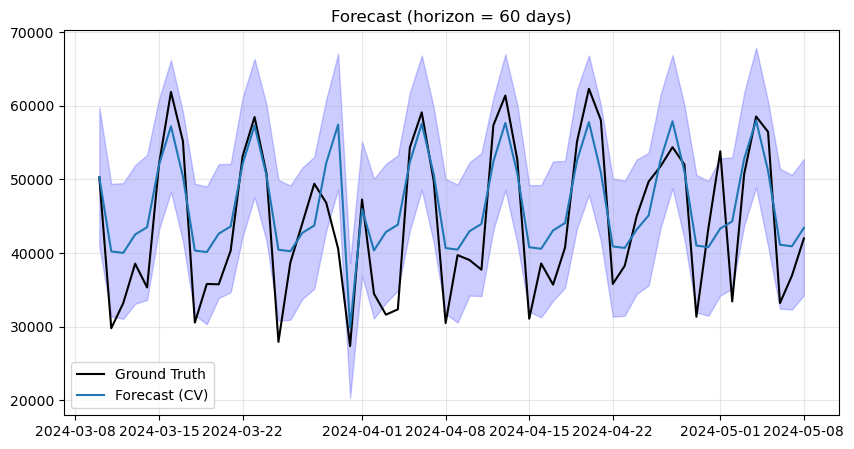


Test set metrics:
RMSE = 6084.95
MAE  = 4797.50

Model components:


C:\Users\andre\AppData\Local\Temp\ipykernel_37676\499892166.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_final["pre_covid"] = (train_final["ds"] < cutoff_date)
C:\Users\andre\AppData\Local\Temp\ipykernel_37676\499892166.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_final["post_covid"] = (train_final["ds"] >= cutoff_date)
09:36:54 - cmdstanpy - INFO - Chain [1] start processing
09:36:55 - cmdstanpy - INFO - Chain [1] done processing


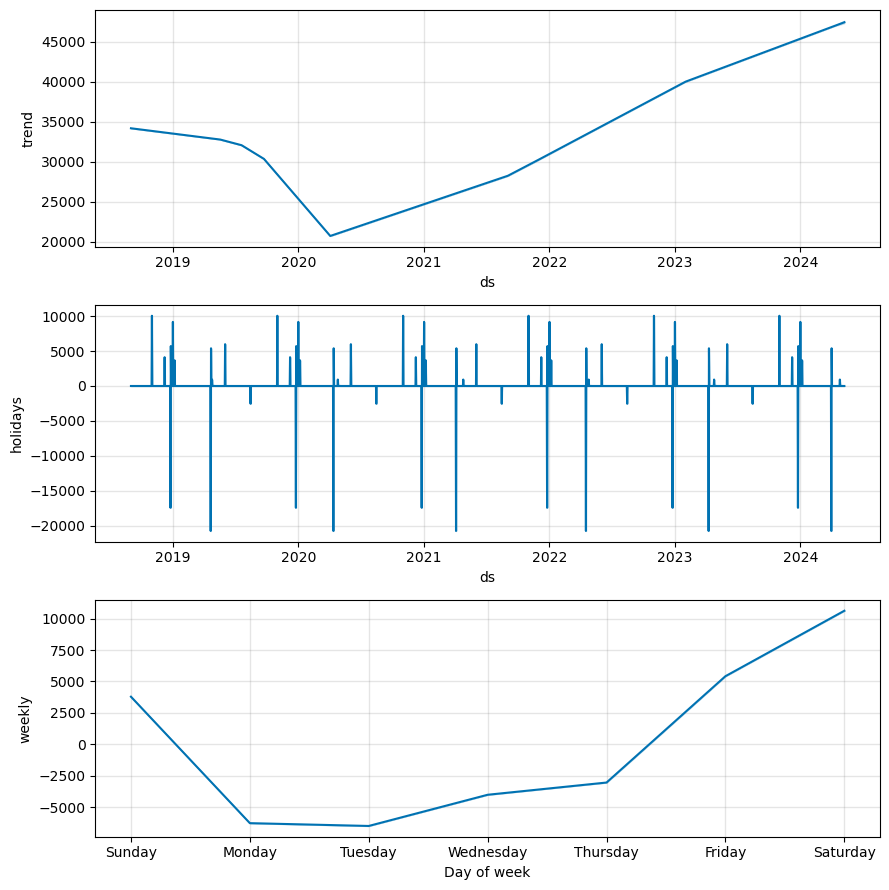

In [17]:
results = fit_prophet_model(
    df=df,
    y_col='totale',
    ds_col='data',
    regressors= None,
    n_test=60,
    weekly=True,
    monthly=False,
    yearly=False,
    weekly_prepost=False,
    holidays=True,
    verbose = True,
    return_results = True)

In [18]:
with open("models/prophet_model_totale_restaurant_2.json", "w") as f:
    f.write(model_to_json(results["model"]))

 ## GRID SEARCH ON DF3

<Axes: >

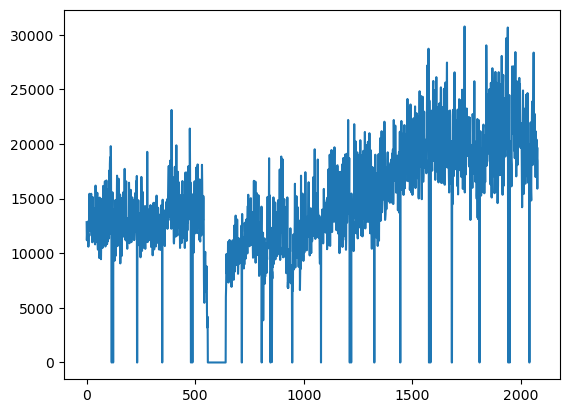

In [20]:
df = pd.read_csv('data/restaurant_3.csv')
df.totale.plot()

In [21]:
results = []

for (w, m, y, wp, h, covid) in param_grid:
    print(f"\n Testing with: weekly={w}, monthly={m}, yearly={y}, prepost={wp}, holidays={h}, covid={covid is not None}")
    
    
        # Fit Prophet
    res = fit_prophet_model(
            df=df,
            y_col="totale",
            ds_col="data",
            n_test=60,
            weekly=w,
            monthly=m,
            yearly=y,
            weekly_prepost=wp,
            holidays=h,
            regressors=covid,
            verbose=False,
            return_results=True
    )

        
    metrics_last = res["metrics_last_window"]
    cv_metrics = res["metrics_cv"]
    rmse_cv_mean = cv_metrics["rmse"].mean()
    mae_cv_mean = cv_metrics["mae"].mean()
      
    results.append({
            "weekly": w,
            "monthly": m,
            "yearly": y,
            "weekly_prepost": wp,
            "holidays": h,
            "covid_regressors": covid,
            "RMSE_last": metrics_last["RMSE"],
            "MAE_last": metrics_last["MAE"],
            "RMSE_cv_mean": rmse_cv_mean,
            "MAE_cv_mean": mae_cv_mean
    })

df_results = pd.DataFrame(results)
df_results = df_results.sort_values("RMSE_cv_mean", ascending=True).reset_index(drop=True)
df_results.to_csv("prophet_gridsearch_results_restaurant_3.csv", index=False)


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


09:57:03 - cmdstanpy - INFO - Chain [1] start processing
09:57:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

09:57:04 - cmdstanpy - INFO - Chain [1] start processing
09:57:04 - cmdstanpy - INFO - Chain [1] done processing
09:57:04 - cmdstanpy - INFO - Chain [1] start processing
09:57:04 - cmdstanpy - INFO - Chain [1] done processing
09:57:05 - cmdstanpy - INFO - Chain [1] start processing
09:57:05 - cmdstanpy - INFO - Chain [1] done processing
09:57:05 - cmdstanpy - INFO - Chain [1] start processing
09:57:05 - cmdstanpy - INFO - Chain [1] done processing
09:57:05 - cmdstanpy - INFO - Chain [1] start processing
09:57:05 - cmdstanpy - INFO - Chain [1] done processing
09:57:06 - cmdstanpy - INFO - Chain [1] start processing
09:57:06 - cmdstanpy - INFO - Chain [1] done processing
09:57:06 - cmdstanpy - INFO - Chain [1] start processing
09:57:06 - cmdstanpy - INFO - Chain [1] done processing
09:57:06 - cmdstanpy - INFO - Chain [1] start processing
09:57:07 - cmdstanpy - INFO - Chain [1] done processing
09:57:07 - cmdstanpy - INFO - Chain [1] start processing
09:57:07 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


09:57:17 - cmdstanpy - INFO - Chain [1] start processing
09:57:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

09:57:17 - cmdstanpy - INFO - Chain [1] start processing
09:57:17 - cmdstanpy - INFO - Chain [1] done processing
09:57:18 - cmdstanpy - INFO - Chain [1] start processing
09:57:18 - cmdstanpy - INFO - Chain [1] done processing
09:57:18 - cmdstanpy - INFO - Chain [1] start processing
09:57:18 - cmdstanpy - INFO - Chain [1] done processing
09:57:18 - cmdstanpy - INFO - Chain [1] start processing
09:57:18 - cmdstanpy - INFO - Chain [1] done processing
09:57:19 - cmdstanpy - INFO - Chain [1] start processing
09:57:19 - cmdstanpy - INFO - Chain [1] done processing
09:57:19 - cmdstanpy - INFO - Chain [1] start processing
09:57:19 - cmdstanpy - INFO - Chain [1] done processing
09:57:19 - cmdstanpy - INFO - Chain [1] start processing
09:57:20 - cmdstanpy - INFO - Chain [1] done processing
09:57:20 - cmdstanpy - INFO - Chain [1] start processing
09:57:20 - cmdstanpy - INFO - Chain [1] done processing
09:57:20 - cmdstanpy - INFO - Chain [1] start processing
09:57:20 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=False, covid=False


09:57:31 - cmdstanpy - INFO - Chain [1] start processing
09:57:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

09:57:31 - cmdstanpy - INFO - Chain [1] start processing
09:57:31 - cmdstanpy - INFO - Chain [1] done processing
09:57:31 - cmdstanpy - INFO - Chain [1] start processing
09:57:31 - cmdstanpy - INFO - Chain [1] done processing
09:57:32 - cmdstanpy - INFO - Chain [1] start processing
09:57:32 - cmdstanpy - INFO - Chain [1] done processing
09:57:32 - cmdstanpy - INFO - Chain [1] start processing
09:57:32 - cmdstanpy - INFO - Chain [1] done processing
09:57:32 - cmdstanpy - INFO - Chain [1] start processing
09:57:32 - cmdstanpy - INFO - Chain [1] done processing
09:57:33 - cmdstanpy - INFO - Chain [1] start processing
09:57:33 - cmdstanpy - INFO - Chain [1] done processing
09:57:33 - cmdstanpy - INFO - Chain [1] start processing
09:57:33 - cmdstanpy - INFO - Chain [1] done processing
09:57:33 - cmdstanpy - INFO - Chain [1] start processing
09:57:34 - cmdstanpy - INFO - Chain [1] done processing
09:57:34 - cmdstanpy - INFO - Chain [1] start processing
09:57:34 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


09:57:41 - cmdstanpy - INFO - Chain [1] start processing
09:57:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

09:57:41 - cmdstanpy - INFO - Chain [1] start processing
09:57:41 - cmdstanpy - INFO - Chain [1] done processing
09:57:42 - cmdstanpy - INFO - Chain [1] start processing
09:57:42 - cmdstanpy - INFO - Chain [1] done processing
09:57:42 - cmdstanpy - INFO - Chain [1] start processing
09:57:42 - cmdstanpy - INFO - Chain [1] done processing
09:57:42 - cmdstanpy - INFO - Chain [1] start processing
09:57:42 - cmdstanpy - INFO - Chain [1] done processing
09:57:42 - cmdstanpy - INFO - Chain [1] start processing
09:57:43 - cmdstanpy - INFO - Chain [1] done processing
09:57:43 - cmdstanpy - INFO - Chain [1] start processing
09:57:43 - cmdstanpy - INFO - Chain [1] done processing
09:57:43 - cmdstanpy - INFO - Chain [1] start processing
09:57:43 - cmdstanpy - INFO - Chain [1] done processing
09:57:44 - cmdstanpy - INFO - Chain [1] start processing
09:57:44 - cmdstanpy - INFO - Chain [1] done processing
09:57:44 - cmdstanpy - INFO - Chain [1] start processing
09:57:44 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


09:57:53 - cmdstanpy - INFO - Chain [1] start processing
09:57:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

09:57:54 - cmdstanpy - INFO - Chain [1] start processing
09:57:54 - cmdstanpy - INFO - Chain [1] done processing
09:57:54 - cmdstanpy - INFO - Chain [1] start processing
09:57:54 - cmdstanpy - INFO - Chain [1] done processing
09:57:54 - cmdstanpy - INFO - Chain [1] start processing
09:57:54 - cmdstanpy - INFO - Chain [1] done processing
09:57:55 - cmdstanpy - INFO - Chain [1] start processing
09:57:55 - cmdstanpy - INFO - Chain [1] done processing
09:57:55 - cmdstanpy - INFO - Chain [1] start processing
09:57:55 - cmdstanpy - INFO - Chain [1] done processing
09:57:56 - cmdstanpy - INFO - Chain [1] start processing
09:57:56 - cmdstanpy - INFO - Chain [1] done processing
09:57:56 - cmdstanpy - INFO - Chain [1] start processing
09:57:56 - cmdstanpy - INFO - Chain [1] done processing
09:57:56 - cmdstanpy - INFO - Chain [1] start processing
09:57:57 - cmdstanpy - INFO - Chain [1] done processing
09:57:57 - cmdstanpy - INFO - Chain [1] start processing
09:57:57 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=True, covid=False


09:58:18 - cmdstanpy - INFO - Chain [1] start processing
09:58:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

09:58:20 - cmdstanpy - INFO - Chain [1] start processing
09:58:20 - cmdstanpy - INFO - Chain [1] done processing
09:58:21 - cmdstanpy - INFO - Chain [1] start processing
09:58:21 - cmdstanpy - INFO - Chain [1] done processing
09:58:21 - cmdstanpy - INFO - Chain [1] start processing
09:58:22 - cmdstanpy - INFO - Chain [1] done processing
09:58:22 - cmdstanpy - INFO - Chain [1] start processing
09:58:23 - cmdstanpy - INFO - Chain [1] done processing
09:58:23 - cmdstanpy - INFO - Chain [1] start processing
09:58:24 - cmdstanpy - INFO - Chain [1] done processing
09:58:25 - cmdstanpy - INFO - Chain [1] start processing
09:58:25 - cmdstanpy - INFO - Chain [1] done processing
09:58:25 - cmdstanpy - INFO - Chain [1] start processing
09:58:26 - cmdstanpy - INFO - Chain [1] done processing
09:58:26 - cmdstanpy - INFO - Chain [1] start processing
09:58:27 - cmdstanpy - INFO - Chain [1] done processing
09:58:28 - cmdstanpy - INFO - Chain [1] start processing
09:58:29 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


09:58:55 - cmdstanpy - INFO - Chain [1] start processing
09:58:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

09:58:57 - cmdstanpy - INFO - Chain [1] start processing
09:58:58 - cmdstanpy - INFO - Chain [1] done processing
09:58:58 - cmdstanpy - INFO - Chain [1] start processing
09:58:58 - cmdstanpy - INFO - Chain [1] done processing
09:58:59 - cmdstanpy - INFO - Chain [1] start processing
09:58:59 - cmdstanpy - INFO - Chain [1] done processing
09:59:00 - cmdstanpy - INFO - Chain [1] start processing
09:59:01 - cmdstanpy - INFO - Chain [1] done processing
09:59:01 - cmdstanpy - INFO - Chain [1] start processing
09:59:02 - cmdstanpy - INFO - Chain [1] done processing
09:59:02 - cmdstanpy - INFO - Chain [1] start processing
09:59:03 - cmdstanpy - INFO - Chain [1] done processing
09:59:04 - cmdstanpy - INFO - Chain [1] start processing
09:59:04 - cmdstanpy - INFO - Chain [1] done processing
09:59:05 - cmdstanpy - INFO - Chain [1] start processing
09:59:06 - cmdstanpy - INFO - Chain [1] done processing
09:59:06 - cmdstanpy - INFO - Chain [1] start processing
09:59:07 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


09:59:38 - cmdstanpy - INFO - Chain [1] start processing
09:59:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

09:59:41 - cmdstanpy - INFO - Chain [1] start processing
09:59:41 - cmdstanpy - INFO - Chain [1] done processing
09:59:42 - cmdstanpy - INFO - Chain [1] start processing
09:59:42 - cmdstanpy - INFO - Chain [1] done processing
09:59:42 - cmdstanpy - INFO - Chain [1] start processing
09:59:43 - cmdstanpy - INFO - Chain [1] done processing
09:59:43 - cmdstanpy - INFO - Chain [1] start processing
09:59:44 - cmdstanpy - INFO - Chain [1] done processing
09:59:44 - cmdstanpy - INFO - Chain [1] start processing
09:59:45 - cmdstanpy - INFO - Chain [1] done processing
09:59:45 - cmdstanpy - INFO - Chain [1] start processing
09:59:46 - cmdstanpy - INFO - Chain [1] done processing
09:59:47 - cmdstanpy - INFO - Chain [1] start processing
09:59:47 - cmdstanpy - INFO - Chain [1] done processing
09:59:48 - cmdstanpy - INFO - Chain [1] start processing
09:59:49 - cmdstanpy - INFO - Chain [1] done processing
09:59:49 - cmdstanpy - INFO - Chain [1] start processing
09:59:50 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=False, covid=False


10:00:20 - cmdstanpy - INFO - Chain [1] start processing
10:00:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:00:22 - cmdstanpy - INFO - Chain [1] start processing
10:00:22 - cmdstanpy - INFO - Chain [1] done processing
10:00:22 - cmdstanpy - INFO - Chain [1] start processing
10:00:23 - cmdstanpy - INFO - Chain [1] done processing
10:00:23 - cmdstanpy - INFO - Chain [1] start processing
10:00:24 - cmdstanpy - INFO - Chain [1] done processing
10:00:24 - cmdstanpy - INFO - Chain [1] start processing
10:00:24 - cmdstanpy - INFO - Chain [1] done processing
10:00:25 - cmdstanpy - INFO - Chain [1] start processing
10:00:25 - cmdstanpy - INFO - Chain [1] done processing
10:00:26 - cmdstanpy - INFO - Chain [1] start processing
10:00:26 - cmdstanpy - INFO - Chain [1] done processing
10:00:27 - cmdstanpy - INFO - Chain [1] start processing
10:00:27 - cmdstanpy - INFO - Chain [1] done processing
10:00:28 - cmdstanpy - INFO - Chain [1] start processing
10:00:28 - cmdstanpy - INFO - Chain [1] done processing
10:00:29 - cmdstanpy - INFO - Chain [1] start processing
10:00:29 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


10:00:47 - cmdstanpy - INFO - Chain [1] start processing
10:00:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:00:49 - cmdstanpy - INFO - Chain [1] start processing
10:00:49 - cmdstanpy - INFO - Chain [1] done processing
10:00:50 - cmdstanpy - INFO - Chain [1] start processing
10:00:50 - cmdstanpy - INFO - Chain [1] done processing
10:00:50 - cmdstanpy - INFO - Chain [1] start processing
10:00:51 - cmdstanpy - INFO - Chain [1] done processing
10:00:51 - cmdstanpy - INFO - Chain [1] start processing
10:00:52 - cmdstanpy - INFO - Chain [1] done processing
10:00:52 - cmdstanpy - INFO - Chain [1] start processing
10:00:53 - cmdstanpy - INFO - Chain [1] done processing
10:00:53 - cmdstanpy - INFO - Chain [1] start processing
10:00:54 - cmdstanpy - INFO - Chain [1] done processing
10:00:54 - cmdstanpy - INFO - Chain [1] start processing
10:00:55 - cmdstanpy - INFO - Chain [1] done processing
10:00:55 - cmdstanpy - INFO - Chain [1] start processing
10:00:56 - cmdstanpy - INFO - Chain [1] done processing
10:00:57 - cmdstanpy - INFO - Chain [1] start processing
10:00:57 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


10:01:20 - cmdstanpy - INFO - Chain [1] start processing
10:01:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:01:21 - cmdstanpy - INFO - Chain [1] start processing
10:01:22 - cmdstanpy - INFO - Chain [1] done processing
10:01:22 - cmdstanpy - INFO - Chain [1] start processing
10:01:22 - cmdstanpy - INFO - Chain [1] done processing
10:01:23 - cmdstanpy - INFO - Chain [1] start processing
10:01:23 - cmdstanpy - INFO - Chain [1] done processing
10:01:24 - cmdstanpy - INFO - Chain [1] start processing
10:01:24 - cmdstanpy - INFO - Chain [1] done processing
10:01:25 - cmdstanpy - INFO - Chain [1] start processing
10:01:25 - cmdstanpy - INFO - Chain [1] done processing
10:01:26 - cmdstanpy - INFO - Chain [1] start processing
10:01:26 - cmdstanpy - INFO - Chain [1] done processing
10:01:27 - cmdstanpy - INFO - Chain [1] start processing
10:01:27 - cmdstanpy - INFO - Chain [1] done processing
10:01:28 - cmdstanpy - INFO - Chain [1] start processing
10:01:28 - cmdstanpy - INFO - Chain [1] done processing
10:01:29 - cmdstanpy - INFO - Chain [1] start processing
10:01:29 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=True, covid=False


10:01:50 - cmdstanpy - INFO - Chain [1] start processing
10:01:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:01:51 - cmdstanpy - INFO - Chain [1] start processing
10:01:51 - cmdstanpy - INFO - Chain [1] done processing
10:01:52 - cmdstanpy - INFO - Chain [1] start processing
10:01:52 - cmdstanpy - INFO - Chain [1] done processing
10:01:53 - cmdstanpy - INFO - Chain [1] start processing
10:01:53 - cmdstanpy - INFO - Chain [1] done processing
10:01:54 - cmdstanpy - INFO - Chain [1] start processing
10:01:54 - cmdstanpy - INFO - Chain [1] done processing
10:01:55 - cmdstanpy - INFO - Chain [1] start processing
10:01:55 - cmdstanpy - INFO - Chain [1] done processing
10:01:56 - cmdstanpy - INFO - Chain [1] start processing
10:01:56 - cmdstanpy - INFO - Chain [1] done processing
10:01:57 - cmdstanpy - INFO - Chain [1] start processing
10:01:57 - cmdstanpy - INFO - Chain [1] done processing
10:01:58 - cmdstanpy - INFO - Chain [1] start processing
10:01:58 - cmdstanpy - INFO - Chain [1] done processing
10:01:59 - cmdstanpy - INFO - Chain [1] start processing
10:01:59 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


10:02:21 - cmdstanpy - INFO - Chain [1] start processing
10:02:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:02:23 - cmdstanpy - INFO - Chain [1] start processing
10:02:23 - cmdstanpy - INFO - Chain [1] done processing
10:02:24 - cmdstanpy - INFO - Chain [1] start processing
10:02:24 - cmdstanpy - INFO - Chain [1] done processing
10:02:24 - cmdstanpy - INFO - Chain [1] start processing
10:02:25 - cmdstanpy - INFO - Chain [1] done processing
10:02:25 - cmdstanpy - INFO - Chain [1] start processing
10:02:26 - cmdstanpy - INFO - Chain [1] done processing
10:02:26 - cmdstanpy - INFO - Chain [1] start processing
10:02:27 - cmdstanpy - INFO - Chain [1] done processing
10:02:28 - cmdstanpy - INFO - Chain [1] start processing
10:02:28 - cmdstanpy - INFO - Chain [1] done processing
10:02:29 - cmdstanpy - INFO - Chain [1] start processing
10:02:29 - cmdstanpy - INFO - Chain [1] done processing
10:02:30 - cmdstanpy - INFO - Chain [1] start processing
10:02:30 - cmdstanpy - INFO - Chain [1] done processing
10:02:31 - cmdstanpy - INFO - Chain [1] start processing
10:02:31 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


10:02:54 - cmdstanpy - INFO - Chain [1] start processing
10:02:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:02:55 - cmdstanpy - INFO - Chain [1] start processing
10:02:55 - cmdstanpy - INFO - Chain [1] done processing
10:02:56 - cmdstanpy - INFO - Chain [1] start processing
10:02:56 - cmdstanpy - INFO - Chain [1] done processing
10:02:57 - cmdstanpy - INFO - Chain [1] start processing
10:02:57 - cmdstanpy - INFO - Chain [1] done processing
10:02:58 - cmdstanpy - INFO - Chain [1] start processing
10:02:58 - cmdstanpy - INFO - Chain [1] done processing
10:02:59 - cmdstanpy - INFO - Chain [1] start processing
10:02:59 - cmdstanpy - INFO - Chain [1] done processing
10:03:00 - cmdstanpy - INFO - Chain [1] start processing
10:03:00 - cmdstanpy - INFO - Chain [1] done processing
10:03:01 - cmdstanpy - INFO - Chain [1] start processing
10:03:01 - cmdstanpy - INFO - Chain [1] done processing
10:03:02 - cmdstanpy - INFO - Chain [1] start processing
10:03:02 - cmdstanpy - INFO - Chain [1] done processing
10:03:03 - cmdstanpy - INFO - Chain [1] start processing
10:03:04 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=False, covid=False


10:03:27 - cmdstanpy - INFO - Chain [1] start processing
10:03:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:03:28 - cmdstanpy - INFO - Chain [1] start processing
10:03:28 - cmdstanpy - INFO - Chain [1] done processing
10:03:28 - cmdstanpy - INFO - Chain [1] start processing
10:03:28 - cmdstanpy - INFO - Chain [1] done processing
10:03:29 - cmdstanpy - INFO - Chain [1] start processing
10:03:29 - cmdstanpy - INFO - Chain [1] done processing
10:03:30 - cmdstanpy - INFO - Chain [1] start processing
10:03:30 - cmdstanpy - INFO - Chain [1] done processing
10:03:30 - cmdstanpy - INFO - Chain [1] start processing
10:03:31 - cmdstanpy - INFO - Chain [1] done processing
10:03:31 - cmdstanpy - INFO - Chain [1] start processing
10:03:32 - cmdstanpy - INFO - Chain [1] done processing
10:03:32 - cmdstanpy - INFO - Chain [1] start processing
10:03:32 - cmdstanpy - INFO - Chain [1] done processing
10:03:33 - cmdstanpy - INFO - Chain [1] start processing
10:03:33 - cmdstanpy - INFO - Chain [1] done processing
10:03:34 - cmdstanpy - INFO - Chain [1] start processing
10:03:34 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


10:03:51 - cmdstanpy - INFO - Chain [1] start processing
10:03:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:03:53 - cmdstanpy - INFO - Chain [1] start processing
10:03:53 - cmdstanpy - INFO - Chain [1] done processing
10:03:53 - cmdstanpy - INFO - Chain [1] start processing
10:03:54 - cmdstanpy - INFO - Chain [1] done processing
10:03:54 - cmdstanpy - INFO - Chain [1] start processing
10:03:55 - cmdstanpy - INFO - Chain [1] done processing
10:03:55 - cmdstanpy - INFO - Chain [1] start processing
10:03:56 - cmdstanpy - INFO - Chain [1] done processing
10:03:56 - cmdstanpy - INFO - Chain [1] start processing
10:03:56 - cmdstanpy - INFO - Chain [1] done processing
10:03:57 - cmdstanpy - INFO - Chain [1] start processing
10:03:57 - cmdstanpy - INFO - Chain [1] done processing
10:03:58 - cmdstanpy - INFO - Chain [1] start processing
10:03:58 - cmdstanpy - INFO - Chain [1] done processing
10:03:59 - cmdstanpy - INFO - Chain [1] start processing
10:03:59 - cmdstanpy - INFO - Chain [1] done processing
10:04:00 - cmdstanpy - INFO - Chain [1] start processing
10:04:00 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


10:04:18 - cmdstanpy - INFO - Chain [1] start processing
10:04:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:04:19 - cmdstanpy - INFO - Chain [1] start processing
10:04:19 - cmdstanpy - INFO - Chain [1] done processing
10:04:20 - cmdstanpy - INFO - Chain [1] start processing
10:04:20 - cmdstanpy - INFO - Chain [1] done processing
10:04:21 - cmdstanpy - INFO - Chain [1] start processing
10:04:21 - cmdstanpy - INFO - Chain [1] done processing
10:04:21 - cmdstanpy - INFO - Chain [1] start processing
10:04:22 - cmdstanpy - INFO - Chain [1] done processing
10:04:22 - cmdstanpy - INFO - Chain [1] start processing
10:04:23 - cmdstanpy - INFO - Chain [1] done processing
10:04:23 - cmdstanpy - INFO - Chain [1] start processing
10:04:23 - cmdstanpy - INFO - Chain [1] done processing
10:04:24 - cmdstanpy - INFO - Chain [1] start processing
10:04:24 - cmdstanpy - INFO - Chain [1] done processing
10:04:25 - cmdstanpy - INFO - Chain [1] start processing
10:04:25 - cmdstanpy - INFO - Chain [1] done processing
10:04:26 - cmdstanpy - INFO - Chain [1] start processing
10:04:26 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=True, covid=False


10:04:44 - cmdstanpy - INFO - Chain [1] start processing
10:04:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:04:46 - cmdstanpy - INFO - Chain [1] start processing
10:04:46 - cmdstanpy - INFO - Chain [1] done processing
10:04:46 - cmdstanpy - INFO - Chain [1] start processing
10:04:47 - cmdstanpy - INFO - Chain [1] done processing
10:04:47 - cmdstanpy - INFO - Chain [1] start processing
10:04:48 - cmdstanpy - INFO - Chain [1] done processing
10:04:48 - cmdstanpy - INFO - Chain [1] start processing
10:04:49 - cmdstanpy - INFO - Chain [1] done processing
10:04:49 - cmdstanpy - INFO - Chain [1] start processing
10:04:50 - cmdstanpy - INFO - Chain [1] done processing
10:04:50 - cmdstanpy - INFO - Chain [1] start processing
10:04:50 - cmdstanpy - INFO - Chain [1] done processing
10:04:51 - cmdstanpy - INFO - Chain [1] start processing
10:04:51 - cmdstanpy - INFO - Chain [1] done processing
10:04:52 - cmdstanpy - INFO - Chain [1] start processing
10:04:52 - cmdstanpy - INFO - Chain [1] done processing
10:04:53 - cmdstanpy - INFO - Chain [1] start processing
10:04:53 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


10:05:13 - cmdstanpy - INFO - Chain [1] start processing
10:05:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:05:15 - cmdstanpy - INFO - Chain [1] start processing
10:05:15 - cmdstanpy - INFO - Chain [1] done processing
10:05:15 - cmdstanpy - INFO - Chain [1] start processing
10:05:16 - cmdstanpy - INFO - Chain [1] done processing
10:05:16 - cmdstanpy - INFO - Chain [1] start processing
10:05:16 - cmdstanpy - INFO - Chain [1] done processing
10:05:17 - cmdstanpy - INFO - Chain [1] start processing
10:05:17 - cmdstanpy - INFO - Chain [1] done processing
10:05:18 - cmdstanpy - INFO - Chain [1] start processing
10:05:18 - cmdstanpy - INFO - Chain [1] done processing
10:05:19 - cmdstanpy - INFO - Chain [1] start processing
10:05:19 - cmdstanpy - INFO - Chain [1] done processing
10:05:20 - cmdstanpy - INFO - Chain [1] start processing
10:05:20 - cmdstanpy - INFO - Chain [1] done processing
10:05:21 - cmdstanpy - INFO - Chain [1] start processing
10:05:22 - cmdstanpy - INFO - Chain [1] done processing
10:05:22 - cmdstanpy - INFO - Chain [1] start processing
10:05:23 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


10:05:43 - cmdstanpy - INFO - Chain [1] start processing
10:05:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:05:45 - cmdstanpy - INFO - Chain [1] start processing
10:05:45 - cmdstanpy - INFO - Chain [1] done processing
10:05:45 - cmdstanpy - INFO - Chain [1] start processing
10:05:46 - cmdstanpy - INFO - Chain [1] done processing
10:05:46 - cmdstanpy - INFO - Chain [1] start processing
10:05:47 - cmdstanpy - INFO - Chain [1] done processing
10:05:47 - cmdstanpy - INFO - Chain [1] start processing
10:05:47 - cmdstanpy - INFO - Chain [1] done processing
10:05:48 - cmdstanpy - INFO - Chain [1] start processing
10:05:48 - cmdstanpy - INFO - Chain [1] done processing
10:05:49 - cmdstanpy - INFO - Chain [1] start processing
10:05:50 - cmdstanpy - INFO - Chain [1] done processing
10:05:50 - cmdstanpy - INFO - Chain [1] start processing
10:05:51 - cmdstanpy - INFO - Chain [1] done processing
10:05:51 - cmdstanpy - INFO - Chain [1] start processing
10:05:52 - cmdstanpy - INFO - Chain [1] done processing
10:05:53 - cmdstanpy - INFO - Chain [1] start processing
10:05:53 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=False, covid=False


10:06:17 - cmdstanpy - INFO - Chain [1] start processing
10:06:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:06:18 - cmdstanpy - INFO - Chain [1] start processing
10:06:18 - cmdstanpy - INFO - Chain [1] done processing
10:06:18 - cmdstanpy - INFO - Chain [1] start processing
10:06:18 - cmdstanpy - INFO - Chain [1] done processing
10:06:18 - cmdstanpy - INFO - Chain [1] start processing
10:06:18 - cmdstanpy - INFO - Chain [1] done processing
10:06:18 - cmdstanpy - INFO - Chain [1] start processing
10:06:18 - cmdstanpy - INFO - Chain [1] done processing
10:06:19 - cmdstanpy - INFO - Chain [1] start processing
10:06:19 - cmdstanpy - INFO - Chain [1] done processing
10:06:19 - cmdstanpy - INFO - Chain [1] start processing
10:06:19 - cmdstanpy - INFO - Chain [1] done processing
10:06:19 - cmdstanpy - INFO - Chain [1] start processing
10:06:19 - cmdstanpy - INFO - Chain [1] done processing
10:06:20 - cmdstanpy - INFO - Chain [1] start processing
10:06:20 - cmdstanpy - INFO - Chain [1] done processing
10:06:20 - cmdstanpy - INFO - Chain [1] start processing
10:06:20 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


10:06:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:06:25 - cmdstanpy - INFO - Chain [1] start processing
10:06:25 - cmdstanpy - INFO - Chain [1] done processing
10:06:25 - cmdstanpy - INFO - Chain [1] start processing
10:06:25 - cmdstanpy - INFO - Chain [1] done processing
10:06:26 - cmdstanpy - INFO - Chain [1] start processing
10:06:26 - cmdstanpy - INFO - Chain [1] done processing
10:06:26 - cmdstanpy - INFO - Chain [1] start processing
10:06:26 - cmdstanpy - INFO - Chain [1] done processing
10:06:27 - cmdstanpy - INFO - Chain [1] start processing
10:06:27 - cmdstanpy - INFO - Chain [1] done processing
10:06:27 - cmdstanpy - INFO - Chain [1] start processing
10:06:28 - cmdstanpy - INFO - Chain [1] done processing
10:06:28 - cmdstanpy - INFO - Chain [1] start processing
10:06:29 - cmdstanpy - INFO - Chain [1] done processing
10:06:29 - cmdstanpy - INFO - Chain [1] start processing
10:06:30 - cmdstanpy - INFO - Chain [1] done processing
10:06:30 - cmdstanpy - INFO - Chain [1] start processing
10:06:31 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


10:06:47 - cmdstanpy - INFO - Chain [1] start processing
10:06:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:06:48 - cmdstanpy - INFO - Chain [1] start processing
10:06:49 - cmdstanpy - INFO - Chain [1] done processing
10:06:49 - cmdstanpy - INFO - Chain [1] start processing
10:06:49 - cmdstanpy - INFO - Chain [1] done processing
10:06:50 - cmdstanpy - INFO - Chain [1] start processing
10:06:50 - cmdstanpy - INFO - Chain [1] done processing
10:06:51 - cmdstanpy - INFO - Chain [1] start processing
10:06:51 - cmdstanpy - INFO - Chain [1] done processing
10:06:52 - cmdstanpy - INFO - Chain [1] start processing
10:06:52 - cmdstanpy - INFO - Chain [1] done processing
10:06:52 - cmdstanpy - INFO - Chain [1] start processing
10:06:53 - cmdstanpy - INFO - Chain [1] done processing
10:06:53 - cmdstanpy - INFO - Chain [1] start processing
10:06:54 - cmdstanpy - INFO - Chain [1] done processing
10:06:54 - cmdstanpy - INFO - Chain [1] start processing
10:06:55 - cmdstanpy - INFO - Chain [1] done processing
10:06:55 - cmdstanpy - INFO - Chain [1] start processing
10:06:55 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=True, covid=False


10:07:17 - cmdstanpy - INFO - Chain [1] start processing
10:07:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:07:19 - cmdstanpy - INFO - Chain [1] start processing
10:07:19 - cmdstanpy - INFO - Chain [1] done processing
10:07:20 - cmdstanpy - INFO - Chain [1] start processing
10:07:20 - cmdstanpy - INFO - Chain [1] done processing
10:07:21 - cmdstanpy - INFO - Chain [1] start processing
10:07:21 - cmdstanpy - INFO - Chain [1] done processing
10:07:22 - cmdstanpy - INFO - Chain [1] start processing
10:07:22 - cmdstanpy - INFO - Chain [1] done processing
10:07:23 - cmdstanpy - INFO - Chain [1] start processing
10:07:23 - cmdstanpy - INFO - Chain [1] done processing
10:07:24 - cmdstanpy - INFO - Chain [1] start processing
10:07:24 - cmdstanpy - INFO - Chain [1] done processing
10:07:24 - cmdstanpy - INFO - Chain [1] start processing
10:07:25 - cmdstanpy - INFO - Chain [1] done processing
10:07:26 - cmdstanpy - INFO - Chain [1] start processing
10:07:26 - cmdstanpy - INFO - Chain [1] done processing
10:07:27 - cmdstanpy - INFO - Chain [1] start processing
10:07:27 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


10:07:54 - cmdstanpy - INFO - Chain [1] start processing
10:07:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:07:56 - cmdstanpy - INFO - Chain [1] start processing
10:07:56 - cmdstanpy - INFO - Chain [1] done processing
10:07:57 - cmdstanpy - INFO - Chain [1] start processing
10:07:57 - cmdstanpy - INFO - Chain [1] done processing
10:07:58 - cmdstanpy - INFO - Chain [1] start processing
10:07:58 - cmdstanpy - INFO - Chain [1] done processing
10:07:59 - cmdstanpy - INFO - Chain [1] start processing
10:07:59 - cmdstanpy - INFO - Chain [1] done processing
10:08:00 - cmdstanpy - INFO - Chain [1] start processing
10:08:00 - cmdstanpy - INFO - Chain [1] done processing
10:08:01 - cmdstanpy - INFO - Chain [1] start processing
10:08:01 - cmdstanpy - INFO - Chain [1] done processing
10:08:02 - cmdstanpy - INFO - Chain [1] start processing
10:08:02 - cmdstanpy - INFO - Chain [1] done processing
10:08:03 - cmdstanpy - INFO - Chain [1] start processing
10:08:03 - cmdstanpy - INFO - Chain [1] done processing
10:08:04 - cmdstanpy - INFO - Chain [1] start processing
10:08:04 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


10:08:28 - cmdstanpy - INFO - Chain [1] start processing
10:08:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:08:29 - cmdstanpy - INFO - Chain [1] start processing
10:08:29 - cmdstanpy - INFO - Chain [1] done processing
10:08:30 - cmdstanpy - INFO - Chain [1] start processing
10:08:30 - cmdstanpy - INFO - Chain [1] done processing
10:08:31 - cmdstanpy - INFO - Chain [1] start processing
10:08:31 - cmdstanpy - INFO - Chain [1] done processing
10:08:31 - cmdstanpy - INFO - Chain [1] start processing
10:08:32 - cmdstanpy - INFO - Chain [1] done processing
10:08:32 - cmdstanpy - INFO - Chain [1] start processing
10:08:33 - cmdstanpy - INFO - Chain [1] done processing
10:08:33 - cmdstanpy - INFO - Chain [1] start processing
10:08:33 - cmdstanpy - INFO - Chain [1] done processing
10:08:34 - cmdstanpy - INFO - Chain [1] start processing
10:08:34 - cmdstanpy - INFO - Chain [1] done processing
10:08:35 - cmdstanpy - INFO - Chain [1] start processing
10:08:35 - cmdstanpy - INFO - Chain [1] done processing
10:08:36 - cmdstanpy - INFO - Chain [1] start processing
10:08:36 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=False, covid=False


10:09:01 - cmdstanpy - INFO - Chain [1] start processing
10:09:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:09:02 - cmdstanpy - INFO - Chain [1] start processing
10:09:02 - cmdstanpy - INFO - Chain [1] done processing
10:09:03 - cmdstanpy - INFO - Chain [1] start processing
10:09:03 - cmdstanpy - INFO - Chain [1] done processing
10:09:04 - cmdstanpy - INFO - Chain [1] start processing
10:09:04 - cmdstanpy - INFO - Chain [1] done processing
10:09:04 - cmdstanpy - INFO - Chain [1] start processing
10:09:05 - cmdstanpy - INFO - Chain [1] done processing
10:09:05 - cmdstanpy - INFO - Chain [1] start processing
10:09:06 - cmdstanpy - INFO - Chain [1] done processing
10:09:07 - cmdstanpy - INFO - Chain [1] start processing
10:09:07 - cmdstanpy - INFO - Chain [1] done processing
10:09:08 - cmdstanpy - INFO - Chain [1] start processing
10:09:09 - cmdstanpy - INFO - Chain [1] done processing
10:09:10 - cmdstanpy - INFO - Chain [1] start processing
10:09:11 - cmdstanpy - INFO - Chain [1] done processing
10:09:11 - cmdstanpy - INFO - Chain [1] start processing
10:09:12 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


10:09:30 - cmdstanpy - INFO - Chain [1] start processing
10:09:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:09:32 - cmdstanpy - INFO - Chain [1] start processing
10:09:32 - cmdstanpy - INFO - Chain [1] done processing
10:09:32 - cmdstanpy - INFO - Chain [1] start processing
10:09:33 - cmdstanpy - INFO - Chain [1] done processing
10:09:33 - cmdstanpy - INFO - Chain [1] start processing
10:09:34 - cmdstanpy - INFO - Chain [1] done processing
10:09:34 - cmdstanpy - INFO - Chain [1] start processing
10:09:34 - cmdstanpy - INFO - Chain [1] done processing
10:09:35 - cmdstanpy - INFO - Chain [1] start processing
10:09:35 - cmdstanpy - INFO - Chain [1] done processing
10:09:36 - cmdstanpy - INFO - Chain [1] start processing
10:09:36 - cmdstanpy - INFO - Chain [1] done processing
10:09:37 - cmdstanpy - INFO - Chain [1] start processing
10:09:37 - cmdstanpy - INFO - Chain [1] done processing
10:09:37 - cmdstanpy - INFO - Chain [1] start processing
10:09:38 - cmdstanpy - INFO - Chain [1] done processing
10:09:38 - cmdstanpy - INFO - Chain [1] start processing
10:09:39 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


10:09:55 - cmdstanpy - INFO - Chain [1] start processing
10:09:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:09:56 - cmdstanpy - INFO - Chain [1] start processing
10:09:57 - cmdstanpy - INFO - Chain [1] done processing
10:09:57 - cmdstanpy - INFO - Chain [1] start processing
10:09:57 - cmdstanpy - INFO - Chain [1] done processing
10:09:58 - cmdstanpy - INFO - Chain [1] start processing
10:09:58 - cmdstanpy - INFO - Chain [1] done processing
10:09:59 - cmdstanpy - INFO - Chain [1] start processing
10:09:59 - cmdstanpy - INFO - Chain [1] done processing
10:09:59 - cmdstanpy - INFO - Chain [1] start processing
10:10:00 - cmdstanpy - INFO - Chain [1] done processing
10:10:00 - cmdstanpy - INFO - Chain [1] start processing
10:10:00 - cmdstanpy - INFO - Chain [1] done processing
10:10:01 - cmdstanpy - INFO - Chain [1] start processing
10:10:01 - cmdstanpy - INFO - Chain [1] done processing
10:10:02 - cmdstanpy - INFO - Chain [1] start processing
10:10:02 - cmdstanpy - INFO - Chain [1] done processing
10:10:02 - cmdstanpy - INFO - Chain [1] start processing
10:10:03 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=True, covid=False


10:10:19 - cmdstanpy - INFO - Chain [1] start processing
10:10:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:10:20 - cmdstanpy - INFO - Chain [1] start processing
10:10:21 - cmdstanpy - INFO - Chain [1] done processing
10:10:21 - cmdstanpy - INFO - Chain [1] start processing
10:10:21 - cmdstanpy - INFO - Chain [1] done processing
10:10:22 - cmdstanpy - INFO - Chain [1] start processing
10:10:22 - cmdstanpy - INFO - Chain [1] done processing
10:10:23 - cmdstanpy - INFO - Chain [1] start processing
10:10:23 - cmdstanpy - INFO - Chain [1] done processing
10:10:23 - cmdstanpy - INFO - Chain [1] start processing
10:10:23 - cmdstanpy - INFO - Chain [1] done processing
10:10:24 - cmdstanpy - INFO - Chain [1] start processing
10:10:24 - cmdstanpy - INFO - Chain [1] done processing
10:10:25 - cmdstanpy - INFO - Chain [1] start processing
10:10:25 - cmdstanpy - INFO - Chain [1] done processing
10:10:26 - cmdstanpy - INFO - Chain [1] start processing
10:10:26 - cmdstanpy - INFO - Chain [1] done processing
10:10:26 - cmdstanpy - INFO - Chain [1] start processing
10:10:27 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


10:10:46 - cmdstanpy - INFO - Chain [1] start processing
10:10:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:10:47 - cmdstanpy - INFO - Chain [1] start processing
10:10:48 - cmdstanpy - INFO - Chain [1] done processing
10:10:48 - cmdstanpy - INFO - Chain [1] start processing
10:10:48 - cmdstanpy - INFO - Chain [1] done processing
10:10:49 - cmdstanpy - INFO - Chain [1] start processing
10:10:49 - cmdstanpy - INFO - Chain [1] done processing
10:10:50 - cmdstanpy - INFO - Chain [1] start processing
10:10:50 - cmdstanpy - INFO - Chain [1] done processing
10:10:51 - cmdstanpy - INFO - Chain [1] start processing
10:10:51 - cmdstanpy - INFO - Chain [1] done processing
10:10:52 - cmdstanpy - INFO - Chain [1] start processing
10:10:52 - cmdstanpy - INFO - Chain [1] done processing
10:10:52 - cmdstanpy - INFO - Chain [1] start processing
10:10:53 - cmdstanpy - INFO - Chain [1] done processing
10:10:54 - cmdstanpy - INFO - Chain [1] start processing
10:10:54 - cmdstanpy - INFO - Chain [1] done processing
10:10:55 - cmdstanpy - INFO - Chain [1] start processing
10:10:55 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


10:11:17 - cmdstanpy - INFO - Chain [1] start processing
10:11:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:11:18 - cmdstanpy - INFO - Chain [1] start processing
10:11:19 - cmdstanpy - INFO - Chain [1] done processing
10:11:19 - cmdstanpy - INFO - Chain [1] start processing
10:11:19 - cmdstanpy - INFO - Chain [1] done processing
10:11:20 - cmdstanpy - INFO - Chain [1] start processing
10:11:20 - cmdstanpy - INFO - Chain [1] done processing
10:11:21 - cmdstanpy - INFO - Chain [1] start processing
10:11:21 - cmdstanpy - INFO - Chain [1] done processing
10:11:22 - cmdstanpy - INFO - Chain [1] start processing
10:11:22 - cmdstanpy - INFO - Chain [1] done processing
10:11:22 - cmdstanpy - INFO - Chain [1] start processing
10:11:23 - cmdstanpy - INFO - Chain [1] done processing
10:11:24 - cmdstanpy - INFO - Chain [1] start processing
10:11:24 - cmdstanpy - INFO - Chain [1] done processing
10:11:25 - cmdstanpy - INFO - Chain [1] start processing
10:11:25 - cmdstanpy - INFO - Chain [1] done processing
10:11:25 - cmdstanpy - INFO - Chain [1] start processing
10:11:26 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=False, covid=False


10:11:46 - cmdstanpy - INFO - Chain [1] start processing
10:11:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:11:48 - cmdstanpy - INFO - Chain [1] start processing
10:11:48 - cmdstanpy - INFO - Chain [1] done processing
10:11:48 - cmdstanpy - INFO - Chain [1] start processing
10:11:48 - cmdstanpy - INFO - Chain [1] done processing
10:11:49 - cmdstanpy - INFO - Chain [1] start processing
10:11:49 - cmdstanpy - INFO - Chain [1] done processing
10:11:49 - cmdstanpy - INFO - Chain [1] start processing
10:11:49 - cmdstanpy - INFO - Chain [1] done processing
10:11:50 - cmdstanpy - INFO - Chain [1] start processing
10:11:50 - cmdstanpy - INFO - Chain [1] done processing
10:11:51 - cmdstanpy - INFO - Chain [1] start processing
10:11:51 - cmdstanpy - INFO - Chain [1] done processing
10:11:51 - cmdstanpy - INFO - Chain [1] start processing
10:11:51 - cmdstanpy - INFO - Chain [1] done processing
10:11:52 - cmdstanpy - INFO - Chain [1] start processing
10:11:52 - cmdstanpy - INFO - Chain [1] done processing
10:11:53 - cmdstanpy - INFO - Chain [1] start processing
10:11:53 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


10:12:06 - cmdstanpy - INFO - Chain [1] start processing
10:12:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:12:07 - cmdstanpy - INFO - Chain [1] start processing
10:12:07 - cmdstanpy - INFO - Chain [1] done processing
10:12:08 - cmdstanpy - INFO - Chain [1] start processing
10:12:08 - cmdstanpy - INFO - Chain [1] done processing
10:12:09 - cmdstanpy - INFO - Chain [1] start processing
10:12:09 - cmdstanpy - INFO - Chain [1] done processing
10:12:09 - cmdstanpy - INFO - Chain [1] start processing
10:12:09 - cmdstanpy - INFO - Chain [1] done processing
10:12:10 - cmdstanpy - INFO - Chain [1] start processing
10:12:10 - cmdstanpy - INFO - Chain [1] done processing
10:12:11 - cmdstanpy - INFO - Chain [1] start processing
10:12:11 - cmdstanpy - INFO - Chain [1] done processing
10:12:11 - cmdstanpy - INFO - Chain [1] start processing
10:12:12 - cmdstanpy - INFO - Chain [1] done processing
10:12:12 - cmdstanpy - INFO - Chain [1] start processing
10:12:12 - cmdstanpy - INFO - Chain [1] done processing
10:12:13 - cmdstanpy - INFO - Chain [1] start processing
10:12:13 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


10:12:28 - cmdstanpy - INFO - Chain [1] start processing
10:12:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:12:29 - cmdstanpy - INFO - Chain [1] start processing
10:12:29 - cmdstanpy - INFO - Chain [1] done processing
10:12:30 - cmdstanpy - INFO - Chain [1] start processing
10:12:30 - cmdstanpy - INFO - Chain [1] done processing
10:12:31 - cmdstanpy - INFO - Chain [1] start processing
10:12:31 - cmdstanpy - INFO - Chain [1] done processing
10:12:31 - cmdstanpy - INFO - Chain [1] start processing
10:12:31 - cmdstanpy - INFO - Chain [1] done processing
10:12:32 - cmdstanpy - INFO - Chain [1] start processing
10:12:32 - cmdstanpy - INFO - Chain [1] done processing
10:12:33 - cmdstanpy - INFO - Chain [1] start processing
10:12:33 - cmdstanpy - INFO - Chain [1] done processing
10:12:33 - cmdstanpy - INFO - Chain [1] start processing
10:12:33 - cmdstanpy - INFO - Chain [1] done processing
10:12:34 - cmdstanpy - INFO - Chain [1] start processing
10:12:34 - cmdstanpy - INFO - Chain [1] done processing
10:12:35 - cmdstanpy - INFO - Chain [1] start processing
10:12:35 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=True, covid=False


10:12:50 - cmdstanpy - INFO - Chain [1] start processing
10:12:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:12:51 - cmdstanpy - INFO - Chain [1] start processing
10:12:51 - cmdstanpy - INFO - Chain [1] done processing
10:12:51 - cmdstanpy - INFO - Chain [1] start processing
10:12:52 - cmdstanpy - INFO - Chain [1] done processing
10:12:52 - cmdstanpy - INFO - Chain [1] start processing
10:12:52 - cmdstanpy - INFO - Chain [1] done processing
10:12:53 - cmdstanpy - INFO - Chain [1] start processing
10:12:53 - cmdstanpy - INFO - Chain [1] done processing
10:12:54 - cmdstanpy - INFO - Chain [1] start processing
10:12:54 - cmdstanpy - INFO - Chain [1] done processing
10:12:54 - cmdstanpy - INFO - Chain [1] start processing
10:12:55 - cmdstanpy - INFO - Chain [1] done processing
10:12:55 - cmdstanpy - INFO - Chain [1] start processing
10:12:55 - cmdstanpy - INFO - Chain [1] done processing
10:12:56 - cmdstanpy - INFO - Chain [1] start processing
10:12:56 - cmdstanpy - INFO - Chain [1] done processing
10:12:56 - cmdstanpy - INFO - Chain [1] start processing
10:12:57 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


10:13:11 - cmdstanpy - INFO - Chain [1] start processing
10:13:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:13:12 - cmdstanpy - INFO - Chain [1] start processing
10:13:12 - cmdstanpy - INFO - Chain [1] done processing
10:13:13 - cmdstanpy - INFO - Chain [1] start processing
10:13:13 - cmdstanpy - INFO - Chain [1] done processing
10:13:14 - cmdstanpy - INFO - Chain [1] start processing
10:13:14 - cmdstanpy - INFO - Chain [1] done processing
10:13:14 - cmdstanpy - INFO - Chain [1] start processing
10:13:15 - cmdstanpy - INFO - Chain [1] done processing
10:13:15 - cmdstanpy - INFO - Chain [1] start processing
10:13:16 - cmdstanpy - INFO - Chain [1] done processing
10:13:16 - cmdstanpy - INFO - Chain [1] start processing
10:13:16 - cmdstanpy - INFO - Chain [1] done processing
10:13:17 - cmdstanpy - INFO - Chain [1] start processing
10:13:17 - cmdstanpy - INFO - Chain [1] done processing
10:13:18 - cmdstanpy - INFO - Chain [1] start processing
10:13:18 - cmdstanpy - INFO - Chain [1] done processing
10:13:19 - cmdstanpy - INFO - Chain [1] start processing
10:13:19 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


10:13:37 - cmdstanpy - INFO - Chain [1] start processing
10:13:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:13:38 - cmdstanpy - INFO - Chain [1] start processing
10:13:38 - cmdstanpy - INFO - Chain [1] done processing
10:13:38 - cmdstanpy - INFO - Chain [1] start processing
10:13:39 - cmdstanpy - INFO - Chain [1] done processing
10:13:39 - cmdstanpy - INFO - Chain [1] start processing
10:13:39 - cmdstanpy - INFO - Chain [1] done processing
10:13:40 - cmdstanpy - INFO - Chain [1] start processing
10:13:40 - cmdstanpy - INFO - Chain [1] done processing
10:13:41 - cmdstanpy - INFO - Chain [1] start processing
10:13:41 - cmdstanpy - INFO - Chain [1] done processing
10:13:41 - cmdstanpy - INFO - Chain [1] start processing
10:13:42 - cmdstanpy - INFO - Chain [1] done processing
10:13:42 - cmdstanpy - INFO - Chain [1] start processing
10:13:42 - cmdstanpy - INFO - Chain [1] done processing
10:13:43 - cmdstanpy - INFO - Chain [1] start processing
10:13:43 - cmdstanpy - INFO - Chain [1] done processing
10:13:44 - cmdstanpy - INFO - Chain [1] start processing
10:13:44 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=False, covid=False


10:13:59 - cmdstanpy - INFO - Chain [1] start processing
10:14:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:14:00 - cmdstanpy - INFO - Chain [1] start processing
10:14:00 - cmdstanpy - INFO - Chain [1] done processing
10:14:01 - cmdstanpy - INFO - Chain [1] start processing
10:14:01 - cmdstanpy - INFO - Chain [1] done processing
10:14:01 - cmdstanpy - INFO - Chain [1] start processing
10:14:01 - cmdstanpy - INFO - Chain [1] done processing
10:14:02 - cmdstanpy - INFO - Chain [1] start processing
10:14:02 - cmdstanpy - INFO - Chain [1] done processing
10:14:02 - cmdstanpy - INFO - Chain [1] start processing
10:14:02 - cmdstanpy - INFO - Chain [1] done processing
10:14:03 - cmdstanpy - INFO - Chain [1] start processing
10:14:03 - cmdstanpy - INFO - Chain [1] done processing
10:14:03 - cmdstanpy - INFO - Chain [1] start processing
10:14:04 - cmdstanpy - INFO - Chain [1] done processing
10:14:04 - cmdstanpy - INFO - Chain [1] start processing
10:14:04 - cmdstanpy - INFO - Chain [1] done processing
10:14:05 - cmdstanpy - INFO - Chain [1] start processing
10:14:05 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


10:14:16 - cmdstanpy - INFO - Chain [1] start processing
10:14:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:14:17 - cmdstanpy - INFO - Chain [1] start processing
10:14:17 - cmdstanpy - INFO - Chain [1] done processing
10:14:18 - cmdstanpy - INFO - Chain [1] start processing
10:14:18 - cmdstanpy - INFO - Chain [1] done processing
10:14:18 - cmdstanpy - INFO - Chain [1] start processing
10:14:19 - cmdstanpy - INFO - Chain [1] done processing
10:14:19 - cmdstanpy - INFO - Chain [1] start processing
10:14:19 - cmdstanpy - INFO - Chain [1] done processing
10:14:20 - cmdstanpy - INFO - Chain [1] start processing
10:14:20 - cmdstanpy - INFO - Chain [1] done processing
10:14:20 - cmdstanpy - INFO - Chain [1] start processing
10:14:20 - cmdstanpy - INFO - Chain [1] done processing
10:14:21 - cmdstanpy - INFO - Chain [1] start processing
10:14:21 - cmdstanpy - INFO - Chain [1] done processing
10:14:21 - cmdstanpy - INFO - Chain [1] start processing
10:14:22 - cmdstanpy - INFO - Chain [1] done processing
10:14:22 - cmdstanpy - INFO - Chain [1] start processing
10:14:22 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


10:14:35 - cmdstanpy - INFO - Chain [1] start processing
10:14:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:14:35 - cmdstanpy - INFO - Chain [1] start processing
10:14:36 - cmdstanpy - INFO - Chain [1] done processing
10:14:36 - cmdstanpy - INFO - Chain [1] start processing
10:14:36 - cmdstanpy - INFO - Chain [1] done processing
10:14:37 - cmdstanpy - INFO - Chain [1] start processing
10:14:37 - cmdstanpy - INFO - Chain [1] done processing
10:14:37 - cmdstanpy - INFO - Chain [1] start processing
10:14:37 - cmdstanpy - INFO - Chain [1] done processing
10:14:38 - cmdstanpy - INFO - Chain [1] start processing
10:14:38 - cmdstanpy - INFO - Chain [1] done processing
10:14:38 - cmdstanpy - INFO - Chain [1] start processing
10:14:39 - cmdstanpy - INFO - Chain [1] done processing
10:14:39 - cmdstanpy - INFO - Chain [1] start processing
10:14:39 - cmdstanpy - INFO - Chain [1] done processing
10:14:40 - cmdstanpy - INFO - Chain [1] start processing
10:14:40 - cmdstanpy - INFO - Chain [1] done processing
10:14:40 - cmdstanpy - INFO - Chain [1] start processing
10:14:41 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=True, covid=False


10:14:53 - cmdstanpy - INFO - Chain [1] start processing
10:14:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:14:54 - cmdstanpy - INFO - Chain [1] start processing
10:14:54 - cmdstanpy - INFO - Chain [1] done processing
10:14:55 - cmdstanpy - INFO - Chain [1] start processing
10:14:55 - cmdstanpy - INFO - Chain [1] done processing
10:14:55 - cmdstanpy - INFO - Chain [1] start processing
10:14:55 - cmdstanpy - INFO - Chain [1] done processing
10:14:56 - cmdstanpy - INFO - Chain [1] start processing
10:14:56 - cmdstanpy - INFO - Chain [1] done processing
10:14:57 - cmdstanpy - INFO - Chain [1] start processing
10:14:57 - cmdstanpy - INFO - Chain [1] done processing
10:14:57 - cmdstanpy - INFO - Chain [1] start processing
10:14:58 - cmdstanpy - INFO - Chain [1] done processing
10:14:58 - cmdstanpy - INFO - Chain [1] start processing
10:14:58 - cmdstanpy - INFO - Chain [1] done processing
10:14:59 - cmdstanpy - INFO - Chain [1] start processing
10:14:59 - cmdstanpy - INFO - Chain [1] done processing
10:14:59 - cmdstanpy - INFO - Chain [1] start processing
10:15:00 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


10:15:15 - cmdstanpy - INFO - Chain [1] start processing
10:15:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:15:16 - cmdstanpy - INFO - Chain [1] start processing
10:15:17 - cmdstanpy - INFO - Chain [1] done processing
10:15:17 - cmdstanpy - INFO - Chain [1] start processing
10:15:17 - cmdstanpy - INFO - Chain [1] done processing
10:15:18 - cmdstanpy - INFO - Chain [1] start processing
10:15:18 - cmdstanpy - INFO - Chain [1] done processing
10:15:18 - cmdstanpy - INFO - Chain [1] start processing
10:15:19 - cmdstanpy - INFO - Chain [1] done processing
10:15:19 - cmdstanpy - INFO - Chain [1] start processing
10:15:19 - cmdstanpy - INFO - Chain [1] done processing
10:15:20 - cmdstanpy - INFO - Chain [1] start processing
10:15:20 - cmdstanpy - INFO - Chain [1] done processing
10:15:20 - cmdstanpy - INFO - Chain [1] start processing
10:15:21 - cmdstanpy - INFO - Chain [1] done processing
10:15:21 - cmdstanpy - INFO - Chain [1] start processing
10:15:22 - cmdstanpy - INFO - Chain [1] done processing
10:15:22 - cmdstanpy - INFO - Chain [1] start processing
10:15:22 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


10:15:38 - cmdstanpy - INFO - Chain [1] start processing
10:15:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:15:39 - cmdstanpy - INFO - Chain [1] start processing
10:15:39 - cmdstanpy - INFO - Chain [1] done processing
10:15:39 - cmdstanpy - INFO - Chain [1] start processing
10:15:39 - cmdstanpy - INFO - Chain [1] done processing
10:15:40 - cmdstanpy - INFO - Chain [1] start processing
10:15:40 - cmdstanpy - INFO - Chain [1] done processing
10:15:41 - cmdstanpy - INFO - Chain [1] start processing
10:15:41 - cmdstanpy - INFO - Chain [1] done processing
10:15:41 - cmdstanpy - INFO - Chain [1] start processing
10:15:41 - cmdstanpy - INFO - Chain [1] done processing
10:15:42 - cmdstanpy - INFO - Chain [1] start processing
10:15:42 - cmdstanpy - INFO - Chain [1] done processing
10:15:43 - cmdstanpy - INFO - Chain [1] start processing
10:15:43 - cmdstanpy - INFO - Chain [1] done processing
10:15:44 - cmdstanpy - INFO - Chain [1] start processing
10:15:44 - cmdstanpy - INFO - Chain [1] done processing
10:15:45 - cmdstanpy - INFO - Chain [1] start processing
10:15:45 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=False, covid=False


10:16:00 - cmdstanpy - INFO - Chain [1] start processing
10:16:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:16:01 - cmdstanpy - INFO - Chain [1] start processing
10:16:01 - cmdstanpy - INFO - Chain [1] done processing
10:16:01 - cmdstanpy - INFO - Chain [1] start processing
10:16:01 - cmdstanpy - INFO - Chain [1] done processing
10:16:02 - cmdstanpy - INFO - Chain [1] start processing
10:16:02 - cmdstanpy - INFO - Chain [1] done processing
10:16:02 - cmdstanpy - INFO - Chain [1] start processing
10:16:02 - cmdstanpy - INFO - Chain [1] done processing
10:16:03 - cmdstanpy - INFO - Chain [1] start processing
10:16:03 - cmdstanpy - INFO - Chain [1] done processing
10:16:03 - cmdstanpy - INFO - Chain [1] start processing
10:16:03 - cmdstanpy - INFO - Chain [1] done processing
10:16:04 - cmdstanpy - INFO - Chain [1] start processing
10:16:04 - cmdstanpy - INFO - Chain [1] done processing
10:16:04 - cmdstanpy - INFO - Chain [1] start processing
10:16:05 - cmdstanpy - INFO - Chain [1] done processing
10:16:05 - cmdstanpy - INFO - Chain [1] start processing
10:16:05 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


10:16:17 - cmdstanpy - INFO - Chain [1] start processing
10:16:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:16:18 - cmdstanpy - INFO - Chain [1] start processing
10:16:18 - cmdstanpy - INFO - Chain [1] done processing
10:16:18 - cmdstanpy - INFO - Chain [1] start processing
10:16:18 - cmdstanpy - INFO - Chain [1] done processing
10:16:19 - cmdstanpy - INFO - Chain [1] start processing
10:16:19 - cmdstanpy - INFO - Chain [1] done processing
10:16:19 - cmdstanpy - INFO - Chain [1] start processing
10:16:19 - cmdstanpy - INFO - Chain [1] done processing
10:16:20 - cmdstanpy - INFO - Chain [1] start processing
10:16:20 - cmdstanpy - INFO - Chain [1] done processing
10:16:20 - cmdstanpy - INFO - Chain [1] start processing
10:16:20 - cmdstanpy - INFO - Chain [1] done processing
10:16:21 - cmdstanpy - INFO - Chain [1] start processing
10:16:21 - cmdstanpy - INFO - Chain [1] done processing
10:16:21 - cmdstanpy - INFO - Chain [1] start processing
10:16:22 - cmdstanpy - INFO - Chain [1] done processing
10:16:22 - cmdstanpy - INFO - Chain [1] start processing
10:16:22 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


10:16:35 - cmdstanpy - INFO - Chain [1] start processing
10:16:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:16:36 - cmdstanpy - INFO - Chain [1] start processing
10:16:36 - cmdstanpy - INFO - Chain [1] done processing
10:16:36 - cmdstanpy - INFO - Chain [1] start processing
10:16:36 - cmdstanpy - INFO - Chain [1] done processing
10:16:37 - cmdstanpy - INFO - Chain [1] start processing
10:16:37 - cmdstanpy - INFO - Chain [1] done processing
10:16:37 - cmdstanpy - INFO - Chain [1] start processing
10:16:37 - cmdstanpy - INFO - Chain [1] done processing
10:16:38 - cmdstanpy - INFO - Chain [1] start processing
10:16:38 - cmdstanpy - INFO - Chain [1] done processing
10:16:38 - cmdstanpy - INFO - Chain [1] start processing
10:16:39 - cmdstanpy - INFO - Chain [1] done processing
10:16:39 - cmdstanpy - INFO - Chain [1] start processing
10:16:39 - cmdstanpy - INFO - Chain [1] done processing
10:16:39 - cmdstanpy - INFO - Chain [1] start processing
10:16:40 - cmdstanpy - INFO - Chain [1] done processing
10:16:40 - cmdstanpy - INFO - Chain [1] start processing
10:16:40 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=True, covid=False


10:16:52 - cmdstanpy - INFO - Chain [1] start processing
10:16:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:16:54 - cmdstanpy - INFO - Chain [1] start processing
10:16:54 - cmdstanpy - INFO - Chain [1] done processing
10:16:55 - cmdstanpy - INFO - Chain [1] start processing
10:16:55 - cmdstanpy - INFO - Chain [1] done processing
10:16:55 - cmdstanpy - INFO - Chain [1] start processing
10:16:56 - cmdstanpy - INFO - Chain [1] done processing
10:16:56 - cmdstanpy - INFO - Chain [1] start processing
10:16:57 - cmdstanpy - INFO - Chain [1] done processing
10:16:57 - cmdstanpy - INFO - Chain [1] start processing
10:16:57 - cmdstanpy - INFO - Chain [1] done processing
10:16:58 - cmdstanpy - INFO - Chain [1] start processing
10:16:58 - cmdstanpy - INFO - Chain [1] done processing
10:16:59 - cmdstanpy - INFO - Chain [1] start processing
10:16:59 - cmdstanpy - INFO - Chain [1] done processing
10:17:00 - cmdstanpy - INFO - Chain [1] start processing
10:17:00 - cmdstanpy - INFO - Chain [1] done processing
10:17:01 - cmdstanpy - INFO - Chain [1] start processing
10:17:01 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


10:17:23 - cmdstanpy - INFO - Chain [1] start processing
10:17:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:17:24 - cmdstanpy - INFO - Chain [1] start processing
10:17:25 - cmdstanpy - INFO - Chain [1] done processing
10:17:25 - cmdstanpy - INFO - Chain [1] start processing
10:17:25 - cmdstanpy - INFO - Chain [1] done processing
10:17:26 - cmdstanpy - INFO - Chain [1] start processing
10:17:26 - cmdstanpy - INFO - Chain [1] done processing
10:17:27 - cmdstanpy - INFO - Chain [1] start processing
10:17:27 - cmdstanpy - INFO - Chain [1] done processing
10:17:27 - cmdstanpy - INFO - Chain [1] start processing
10:17:28 - cmdstanpy - INFO - Chain [1] done processing
10:17:28 - cmdstanpy - INFO - Chain [1] start processing
10:17:29 - cmdstanpy - INFO - Chain [1] done processing
10:17:29 - cmdstanpy - INFO - Chain [1] start processing
10:17:30 - cmdstanpy - INFO - Chain [1] done processing
10:17:30 - cmdstanpy - INFO - Chain [1] start processing
10:17:31 - cmdstanpy - INFO - Chain [1] done processing
10:17:32 - cmdstanpy - INFO - Chain [1] start processing
10:17:32 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


10:17:55 - cmdstanpy - INFO - Chain [1] start processing
10:17:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:17:57 - cmdstanpy - INFO - Chain [1] start processing
10:17:57 - cmdstanpy - INFO - Chain [1] done processing
10:17:58 - cmdstanpy - INFO - Chain [1] start processing
10:17:58 - cmdstanpy - INFO - Chain [1] done processing
10:17:58 - cmdstanpy - INFO - Chain [1] start processing
10:17:59 - cmdstanpy - INFO - Chain [1] done processing
10:17:59 - cmdstanpy - INFO - Chain [1] start processing
10:17:59 - cmdstanpy - INFO - Chain [1] done processing
10:18:00 - cmdstanpy - INFO - Chain [1] start processing
10:18:00 - cmdstanpy - INFO - Chain [1] done processing
10:18:01 - cmdstanpy - INFO - Chain [1] start processing
10:18:01 - cmdstanpy - INFO - Chain [1] done processing
10:18:02 - cmdstanpy - INFO - Chain [1] start processing
10:18:02 - cmdstanpy - INFO - Chain [1] done processing
10:18:03 - cmdstanpy - INFO - Chain [1] start processing
10:18:03 - cmdstanpy - INFO - Chain [1] done processing
10:18:04 - cmdstanpy - INFO - Chain [1] start processing
10:18:04 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=False, covid=False


10:18:28 - cmdstanpy - INFO - Chain [1] start processing
10:18:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:18:29 - cmdstanpy - INFO - Chain [1] start processing
10:18:29 - cmdstanpy - INFO - Chain [1] done processing
10:18:30 - cmdstanpy - INFO - Chain [1] start processing
10:18:30 - cmdstanpy - INFO - Chain [1] done processing
10:18:30 - cmdstanpy - INFO - Chain [1] start processing
10:18:31 - cmdstanpy - INFO - Chain [1] done processing
10:18:31 - cmdstanpy - INFO - Chain [1] start processing
10:18:31 - cmdstanpy - INFO - Chain [1] done processing
10:18:32 - cmdstanpy - INFO - Chain [1] start processing
10:18:32 - cmdstanpy - INFO - Chain [1] done processing
10:18:33 - cmdstanpy - INFO - Chain [1] start processing
10:18:33 - cmdstanpy - INFO - Chain [1] done processing
10:18:33 - cmdstanpy - INFO - Chain [1] start processing
10:18:34 - cmdstanpy - INFO - Chain [1] done processing
10:18:34 - cmdstanpy - INFO - Chain [1] start processing
10:18:35 - cmdstanpy - INFO - Chain [1] done processing
10:18:35 - cmdstanpy - INFO - Chain [1] start processing
10:18:36 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


10:18:51 - cmdstanpy - INFO - Chain [1] start processing
10:18:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:18:52 - cmdstanpy - INFO - Chain [1] start processing
10:18:53 - cmdstanpy - INFO - Chain [1] done processing
10:18:53 - cmdstanpy - INFO - Chain [1] start processing
10:18:53 - cmdstanpy - INFO - Chain [1] done processing
10:18:54 - cmdstanpy - INFO - Chain [1] start processing
10:18:54 - cmdstanpy - INFO - Chain [1] done processing
10:18:54 - cmdstanpy - INFO - Chain [1] start processing
10:18:55 - cmdstanpy - INFO - Chain [1] done processing
10:18:55 - cmdstanpy - INFO - Chain [1] start processing
10:18:56 - cmdstanpy - INFO - Chain [1] done processing
10:18:56 - cmdstanpy - INFO - Chain [1] start processing
10:18:57 - cmdstanpy - INFO - Chain [1] done processing
10:18:57 - cmdstanpy - INFO - Chain [1] start processing
10:18:58 - cmdstanpy - INFO - Chain [1] done processing
10:18:58 - cmdstanpy - INFO - Chain [1] start processing
10:18:59 - cmdstanpy - INFO - Chain [1] done processing
10:18:59 - cmdstanpy - INFO - Chain [1] start processing
10:19:00 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


10:19:19 - cmdstanpy - INFO - Chain [1] start processing
10:19:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:19:20 - cmdstanpy - INFO - Chain [1] start processing
10:19:20 - cmdstanpy - INFO - Chain [1] done processing
10:19:20 - cmdstanpy - INFO - Chain [1] start processing
10:19:21 - cmdstanpy - INFO - Chain [1] done processing
10:19:21 - cmdstanpy - INFO - Chain [1] start processing
10:19:21 - cmdstanpy - INFO - Chain [1] done processing
10:19:22 - cmdstanpy - INFO - Chain [1] start processing
10:19:22 - cmdstanpy - INFO - Chain [1] done processing
10:19:23 - cmdstanpy - INFO - Chain [1] start processing
10:19:23 - cmdstanpy - INFO - Chain [1] done processing
10:19:24 - cmdstanpy - INFO - Chain [1] start processing
10:19:24 - cmdstanpy - INFO - Chain [1] done processing
10:19:24 - cmdstanpy - INFO - Chain [1] start processing
10:19:25 - cmdstanpy - INFO - Chain [1] done processing
10:19:25 - cmdstanpy - INFO - Chain [1] start processing
10:19:26 - cmdstanpy - INFO - Chain [1] done processing
10:19:26 - cmdstanpy - INFO - Chain [1] start processing
10:19:26 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=True, covid=False


10:19:44 - cmdstanpy - INFO - Chain [1] start processing
10:19:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:19:45 - cmdstanpy - INFO - Chain [1] start processing
10:19:45 - cmdstanpy - INFO - Chain [1] done processing
10:19:46 - cmdstanpy - INFO - Chain [1] start processing
10:19:46 - cmdstanpy - INFO - Chain [1] done processing
10:19:47 - cmdstanpy - INFO - Chain [1] start processing
10:19:47 - cmdstanpy - INFO - Chain [1] done processing
10:19:47 - cmdstanpy - INFO - Chain [1] start processing
10:19:48 - cmdstanpy - INFO - Chain [1] done processing
10:19:48 - cmdstanpy - INFO - Chain [1] start processing
10:19:48 - cmdstanpy - INFO - Chain [1] done processing
10:19:49 - cmdstanpy - INFO - Chain [1] start processing
10:19:49 - cmdstanpy - INFO - Chain [1] done processing
10:19:50 - cmdstanpy - INFO - Chain [1] start processing
10:19:50 - cmdstanpy - INFO - Chain [1] done processing
10:19:51 - cmdstanpy - INFO - Chain [1] start processing
10:19:51 - cmdstanpy - INFO - Chain [1] done processing
10:19:52 - cmdstanpy - INFO - Chain [1] start processing
10:19:52 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


10:20:08 - cmdstanpy - INFO - Chain [1] start processing
10:20:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:20:09 - cmdstanpy - INFO - Chain [1] start processing
10:20:10 - cmdstanpy - INFO - Chain [1] done processing
10:20:10 - cmdstanpy - INFO - Chain [1] start processing
10:20:10 - cmdstanpy - INFO - Chain [1] done processing
10:20:11 - cmdstanpy - INFO - Chain [1] start processing
10:20:11 - cmdstanpy - INFO - Chain [1] done processing
10:20:12 - cmdstanpy - INFO - Chain [1] start processing
10:20:12 - cmdstanpy - INFO - Chain [1] done processing
10:20:12 - cmdstanpy - INFO - Chain [1] start processing
10:20:13 - cmdstanpy - INFO - Chain [1] done processing
10:20:13 - cmdstanpy - INFO - Chain [1] start processing
10:20:14 - cmdstanpy - INFO - Chain [1] done processing
10:20:14 - cmdstanpy - INFO - Chain [1] start processing
10:20:15 - cmdstanpy - INFO - Chain [1] done processing
10:20:15 - cmdstanpy - INFO - Chain [1] start processing
10:20:16 - cmdstanpy - INFO - Chain [1] done processing
10:20:16 - cmdstanpy - INFO - Chain [1] start processing
10:20:17 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


10:20:34 - cmdstanpy - INFO - Chain [1] start processing
10:20:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:20:35 - cmdstanpy - INFO - Chain [1] start processing
10:20:35 - cmdstanpy - INFO - Chain [1] done processing
10:20:36 - cmdstanpy - INFO - Chain [1] start processing
10:20:36 - cmdstanpy - INFO - Chain [1] done processing
10:20:37 - cmdstanpy - INFO - Chain [1] start processing
10:20:37 - cmdstanpy - INFO - Chain [1] done processing
10:20:37 - cmdstanpy - INFO - Chain [1] start processing
10:20:38 - cmdstanpy - INFO - Chain [1] done processing
10:20:38 - cmdstanpy - INFO - Chain [1] start processing
10:20:38 - cmdstanpy - INFO - Chain [1] done processing
10:20:39 - cmdstanpy - INFO - Chain [1] start processing
10:20:39 - cmdstanpy - INFO - Chain [1] done processing
10:20:40 - cmdstanpy - INFO - Chain [1] start processing
10:20:40 - cmdstanpy - INFO - Chain [1] done processing
10:20:41 - cmdstanpy - INFO - Chain [1] start processing
10:20:41 - cmdstanpy - INFO - Chain [1] done processing
10:20:42 - cmdstanpy - INFO - Chain [1] start processing
10:20:42 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=False, covid=False


10:21:02 - cmdstanpy - INFO - Chain [1] start processing
10:21:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:21:03 - cmdstanpy - INFO - Chain [1] start processing
10:21:03 - cmdstanpy - INFO - Chain [1] done processing
10:21:04 - cmdstanpy - INFO - Chain [1] start processing
10:21:04 - cmdstanpy - INFO - Chain [1] done processing
10:21:04 - cmdstanpy - INFO - Chain [1] start processing
10:21:05 - cmdstanpy - INFO - Chain [1] done processing
10:21:05 - cmdstanpy - INFO - Chain [1] start processing
10:21:05 - cmdstanpy - INFO - Chain [1] done processing
10:21:06 - cmdstanpy - INFO - Chain [1] start processing
10:21:06 - cmdstanpy - INFO - Chain [1] done processing
10:21:06 - cmdstanpy - INFO - Chain [1] start processing
10:21:07 - cmdstanpy - INFO - Chain [1] done processing
10:21:07 - cmdstanpy - INFO - Chain [1] start processing
10:21:07 - cmdstanpy - INFO - Chain [1] done processing
10:21:08 - cmdstanpy - INFO - Chain [1] start processing
10:21:08 - cmdstanpy - INFO - Chain [1] done processing
10:21:08 - cmdstanpy - INFO - Chain [1] start processing
10:21:09 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


10:21:24 - cmdstanpy - INFO - Chain [1] start processing
10:21:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:21:25 - cmdstanpy - INFO - Chain [1] start processing
10:21:25 - cmdstanpy - INFO - Chain [1] done processing
10:21:26 - cmdstanpy - INFO - Chain [1] start processing
10:21:26 - cmdstanpy - INFO - Chain [1] done processing
10:21:26 - cmdstanpy - INFO - Chain [1] start processing
10:21:26 - cmdstanpy - INFO - Chain [1] done processing
10:21:27 - cmdstanpy - INFO - Chain [1] start processing
10:21:27 - cmdstanpy - INFO - Chain [1] done processing
10:21:28 - cmdstanpy - INFO - Chain [1] start processing
10:21:28 - cmdstanpy - INFO - Chain [1] done processing
10:21:29 - cmdstanpy - INFO - Chain [1] start processing
10:21:29 - cmdstanpy - INFO - Chain [1] done processing
10:21:30 - cmdstanpy - INFO - Chain [1] start processing
10:21:30 - cmdstanpy - INFO - Chain [1] done processing
10:21:31 - cmdstanpy - INFO - Chain [1] start processing
10:21:31 - cmdstanpy - INFO - Chain [1] done processing
10:21:32 - cmdstanpy - INFO - Chain [1] start processing
10:21:32 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


10:21:46 - cmdstanpy - INFO - Chain [1] start processing
10:21:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:21:48 - cmdstanpy - INFO - Chain [1] start processing
10:21:48 - cmdstanpy - INFO - Chain [1] done processing
10:21:48 - cmdstanpy - INFO - Chain [1] start processing
10:21:48 - cmdstanpy - INFO - Chain [1] done processing
10:21:49 - cmdstanpy - INFO - Chain [1] start processing
10:21:49 - cmdstanpy - INFO - Chain [1] done processing
10:21:49 - cmdstanpy - INFO - Chain [1] start processing
10:21:50 - cmdstanpy - INFO - Chain [1] done processing
10:21:50 - cmdstanpy - INFO - Chain [1] start processing
10:21:50 - cmdstanpy - INFO - Chain [1] done processing
10:21:51 - cmdstanpy - INFO - Chain [1] start processing
10:21:51 - cmdstanpy - INFO - Chain [1] done processing
10:21:51 - cmdstanpy - INFO - Chain [1] start processing
10:21:52 - cmdstanpy - INFO - Chain [1] done processing
10:21:52 - cmdstanpy - INFO - Chain [1] start processing
10:21:52 - cmdstanpy - INFO - Chain [1] done processing
10:21:53 - cmdstanpy - INFO - Chain [1] start processing
10:21:53 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=True, covid=False


10:22:09 - cmdstanpy - INFO - Chain [1] start processing
10:22:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:22:10 - cmdstanpy - INFO - Chain [1] start processing
10:22:11 - cmdstanpy - INFO - Chain [1] done processing
10:22:11 - cmdstanpy - INFO - Chain [1] start processing
10:22:11 - cmdstanpy - INFO - Chain [1] done processing
10:22:12 - cmdstanpy - INFO - Chain [1] start processing
10:22:12 - cmdstanpy - INFO - Chain [1] done processing
10:22:13 - cmdstanpy - INFO - Chain [1] start processing
10:22:13 - cmdstanpy - INFO - Chain [1] done processing
10:22:13 - cmdstanpy - INFO - Chain [1] start processing
10:22:14 - cmdstanpy - INFO - Chain [1] done processing
10:22:14 - cmdstanpy - INFO - Chain [1] start processing
10:22:15 - cmdstanpy - INFO - Chain [1] done processing
10:22:15 - cmdstanpy - INFO - Chain [1] start processing
10:22:15 - cmdstanpy - INFO - Chain [1] done processing
10:22:16 - cmdstanpy - INFO - Chain [1] start processing
10:22:16 - cmdstanpy - INFO - Chain [1] done processing
10:22:17 - cmdstanpy - INFO - Chain [1] start processing
10:22:17 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


10:22:34 - cmdstanpy - INFO - Chain [1] start processing
10:22:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:22:36 - cmdstanpy - INFO - Chain [1] start processing
10:22:36 - cmdstanpy - INFO - Chain [1] done processing
10:22:37 - cmdstanpy - INFO - Chain [1] start processing
10:22:37 - cmdstanpy - INFO - Chain [1] done processing
10:22:37 - cmdstanpy - INFO - Chain [1] start processing
10:22:38 - cmdstanpy - INFO - Chain [1] done processing
10:22:38 - cmdstanpy - INFO - Chain [1] start processing
10:22:38 - cmdstanpy - INFO - Chain [1] done processing
10:22:39 - cmdstanpy - INFO - Chain [1] start processing
10:22:39 - cmdstanpy - INFO - Chain [1] done processing
10:22:40 - cmdstanpy - INFO - Chain [1] start processing
10:22:40 - cmdstanpy - INFO - Chain [1] done processing
10:22:41 - cmdstanpy - INFO - Chain [1] start processing
10:22:41 - cmdstanpy - INFO - Chain [1] done processing
10:22:42 - cmdstanpy - INFO - Chain [1] start processing
10:22:42 - cmdstanpy - INFO - Chain [1] done processing
10:22:43 - cmdstanpy - INFO - Chain [1] start processing
10:22:43 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


10:23:01 - cmdstanpy - INFO - Chain [1] start processing
10:23:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:23:02 - cmdstanpy - INFO - Chain [1] start processing
10:23:02 - cmdstanpy - INFO - Chain [1] done processing
10:23:02 - cmdstanpy - INFO - Chain [1] start processing
10:23:03 - cmdstanpy - INFO - Chain [1] done processing
10:23:03 - cmdstanpy - INFO - Chain [1] start processing
10:23:03 - cmdstanpy - INFO - Chain [1] done processing
10:23:04 - cmdstanpy - INFO - Chain [1] start processing
10:23:04 - cmdstanpy - INFO - Chain [1] done processing
10:23:05 - cmdstanpy - INFO - Chain [1] start processing
10:23:05 - cmdstanpy - INFO - Chain [1] done processing
10:23:05 - cmdstanpy - INFO - Chain [1] start processing
10:23:06 - cmdstanpy - INFO - Chain [1] done processing
10:23:06 - cmdstanpy - INFO - Chain [1] start processing
10:23:07 - cmdstanpy - INFO - Chain [1] done processing
10:23:07 - cmdstanpy - INFO - Chain [1] start processing
10:23:08 - cmdstanpy - INFO - Chain [1] done processing
10:23:08 - cmdstanpy - INFO - Chain [1] start processing
10:23:09 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=False, covid=False


10:23:26 - cmdstanpy - INFO - Chain [1] start processing
10:23:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:23:27 - cmdstanpy - INFO - Chain [1] start processing
10:23:28 - cmdstanpy - INFO - Chain [1] done processing
10:23:28 - cmdstanpy - INFO - Chain [1] start processing
10:23:28 - cmdstanpy - INFO - Chain [1] done processing
10:23:29 - cmdstanpy - INFO - Chain [1] start processing
10:23:29 - cmdstanpy - INFO - Chain [1] done processing
10:23:29 - cmdstanpy - INFO - Chain [1] start processing
10:23:29 - cmdstanpy - INFO - Chain [1] done processing
10:23:30 - cmdstanpy - INFO - Chain [1] start processing
10:23:30 - cmdstanpy - INFO - Chain [1] done processing
10:23:30 - cmdstanpy - INFO - Chain [1] start processing
10:23:31 - cmdstanpy - INFO - Chain [1] done processing
10:23:31 - cmdstanpy - INFO - Chain [1] start processing
10:23:31 - cmdstanpy - INFO - Chain [1] done processing
10:23:32 - cmdstanpy - INFO - Chain [1] start processing
10:23:32 - cmdstanpy - INFO - Chain [1] done processing
10:23:32 - cmdstanpy - INFO - Chain [1] start processing
10:23:33 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


10:23:46 - cmdstanpy - INFO - Chain [1] start processing
10:23:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:23:47 - cmdstanpy - INFO - Chain [1] start processing
10:23:47 - cmdstanpy - INFO - Chain [1] done processing
10:23:47 - cmdstanpy - INFO - Chain [1] start processing
10:23:48 - cmdstanpy - INFO - Chain [1] done processing
10:23:48 - cmdstanpy - INFO - Chain [1] start processing
10:23:48 - cmdstanpy - INFO - Chain [1] done processing
10:23:49 - cmdstanpy - INFO - Chain [1] start processing
10:23:49 - cmdstanpy - INFO - Chain [1] done processing
10:23:49 - cmdstanpy - INFO - Chain [1] start processing
10:23:50 - cmdstanpy - INFO - Chain [1] done processing
10:23:50 - cmdstanpy - INFO - Chain [1] start processing
10:23:50 - cmdstanpy - INFO - Chain [1] done processing
10:23:51 - cmdstanpy - INFO - Chain [1] start processing
10:23:51 - cmdstanpy - INFO - Chain [1] done processing
10:23:51 - cmdstanpy - INFO - Chain [1] start processing
10:23:52 - cmdstanpy - INFO - Chain [1] done processing
10:23:52 - cmdstanpy - INFO - Chain [1] start processing
10:23:52 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


10:24:07 - cmdstanpy - INFO - Chain [1] start processing
10:24:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:24:08 - cmdstanpy - INFO - Chain [1] start processing
10:24:08 - cmdstanpy - INFO - Chain [1] done processing
10:24:08 - cmdstanpy - INFO - Chain [1] start processing
10:24:08 - cmdstanpy - INFO - Chain [1] done processing
10:24:09 - cmdstanpy - INFO - Chain [1] start processing
10:24:09 - cmdstanpy - INFO - Chain [1] done processing
10:24:10 - cmdstanpy - INFO - Chain [1] start processing
10:24:10 - cmdstanpy - INFO - Chain [1] done processing
10:24:10 - cmdstanpy - INFO - Chain [1] start processing
10:24:10 - cmdstanpy - INFO - Chain [1] done processing
10:24:11 - cmdstanpy - INFO - Chain [1] start processing
10:24:11 - cmdstanpy - INFO - Chain [1] done processing
10:24:11 - cmdstanpy - INFO - Chain [1] start processing
10:24:12 - cmdstanpy - INFO - Chain [1] done processing
10:24:12 - cmdstanpy - INFO - Chain [1] start processing
10:24:12 - cmdstanpy - INFO - Chain [1] done processing
10:24:13 - cmdstanpy - INFO - Chain [1] start processing
10:24:13 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=True, covid=False


10:24:28 - cmdstanpy - INFO - Chain [1] start processing
10:24:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:24:28 - cmdstanpy - INFO - Chain [1] start processing
10:24:29 - cmdstanpy - INFO - Chain [1] done processing
10:24:29 - cmdstanpy - INFO - Chain [1] start processing
10:24:29 - cmdstanpy - INFO - Chain [1] done processing
10:24:30 - cmdstanpy - INFO - Chain [1] start processing
10:24:30 - cmdstanpy - INFO - Chain [1] done processing
10:24:30 - cmdstanpy - INFO - Chain [1] start processing
10:24:31 - cmdstanpy - INFO - Chain [1] done processing
10:24:31 - cmdstanpy - INFO - Chain [1] start processing
10:24:31 - cmdstanpy - INFO - Chain [1] done processing
10:24:32 - cmdstanpy - INFO - Chain [1] start processing
10:24:32 - cmdstanpy - INFO - Chain [1] done processing
10:24:32 - cmdstanpy - INFO - Chain [1] start processing
10:24:33 - cmdstanpy - INFO - Chain [1] done processing
10:24:33 - cmdstanpy - INFO - Chain [1] start processing
10:24:33 - cmdstanpy - INFO - Chain [1] done processing
10:24:34 - cmdstanpy - INFO - Chain [1] start processing
10:24:34 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


10:24:48 - cmdstanpy - INFO - Chain [1] start processing
10:24:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:24:48 - cmdstanpy - INFO - Chain [1] start processing
10:24:49 - cmdstanpy - INFO - Chain [1] done processing
10:24:49 - cmdstanpy - INFO - Chain [1] start processing
10:24:49 - cmdstanpy - INFO - Chain [1] done processing
10:24:50 - cmdstanpy - INFO - Chain [1] start processing
10:24:50 - cmdstanpy - INFO - Chain [1] done processing
10:24:50 - cmdstanpy - INFO - Chain [1] start processing
10:24:51 - cmdstanpy - INFO - Chain [1] done processing
10:24:51 - cmdstanpy - INFO - Chain [1] start processing
10:24:51 - cmdstanpy - INFO - Chain [1] done processing
10:24:52 - cmdstanpy - INFO - Chain [1] start processing
10:24:52 - cmdstanpy - INFO - Chain [1] done processing
10:24:53 - cmdstanpy - INFO - Chain [1] start processing
10:24:53 - cmdstanpy - INFO - Chain [1] done processing
10:24:53 - cmdstanpy - INFO - Chain [1] start processing
10:24:54 - cmdstanpy - INFO - Chain [1] done processing
10:24:54 - cmdstanpy - INFO - Chain [1] start processing
10:24:55 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


10:25:10 - cmdstanpy - INFO - Chain [1] start processing
10:25:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:25:11 - cmdstanpy - INFO - Chain [1] start processing
10:25:12 - cmdstanpy - INFO - Chain [1] done processing
10:25:12 - cmdstanpy - INFO - Chain [1] start processing
10:25:12 - cmdstanpy - INFO - Chain [1] done processing
10:25:13 - cmdstanpy - INFO - Chain [1] start processing
10:25:13 - cmdstanpy - INFO - Chain [1] done processing
10:25:13 - cmdstanpy - INFO - Chain [1] start processing
10:25:13 - cmdstanpy - INFO - Chain [1] done processing
10:25:14 - cmdstanpy - INFO - Chain [1] start processing
10:25:14 - cmdstanpy - INFO - Chain [1] done processing
10:25:15 - cmdstanpy - INFO - Chain [1] start processing
10:25:15 - cmdstanpy - INFO - Chain [1] done processing
10:25:16 - cmdstanpy - INFO - Chain [1] start processing
10:25:16 - cmdstanpy - INFO - Chain [1] done processing
10:25:16 - cmdstanpy - INFO - Chain [1] start processing
10:25:16 - cmdstanpy - INFO - Chain [1] done processing
10:25:17 - cmdstanpy - INFO - Chain [1] start processing
10:25:17 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=False, covid=False


10:25:31 - cmdstanpy - INFO - Chain [1] start processing
10:25:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:25:32 - cmdstanpy - INFO - Chain [1] start processing
10:25:32 - cmdstanpy - INFO - Chain [1] done processing
10:25:32 - cmdstanpy - INFO - Chain [1] start processing
10:25:32 - cmdstanpy - INFO - Chain [1] done processing
10:25:33 - cmdstanpy - INFO - Chain [1] start processing
10:25:33 - cmdstanpy - INFO - Chain [1] done processing
10:25:33 - cmdstanpy - INFO - Chain [1] start processing
10:25:33 - cmdstanpy - INFO - Chain [1] done processing
10:25:34 - cmdstanpy - INFO - Chain [1] start processing
10:25:34 - cmdstanpy - INFO - Chain [1] done processing
10:25:34 - cmdstanpy - INFO - Chain [1] start processing
10:25:34 - cmdstanpy - INFO - Chain [1] done processing
10:25:35 - cmdstanpy - INFO - Chain [1] start processing
10:25:35 - cmdstanpy - INFO - Chain [1] done processing
10:25:35 - cmdstanpy - INFO - Chain [1] start processing
10:25:36 - cmdstanpy - INFO - Chain [1] done processing
10:25:36 - cmdstanpy - INFO - Chain [1] start processing
10:25:36 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


10:25:47 - cmdstanpy - INFO - Chain [1] start processing
10:25:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:25:48 - cmdstanpy - INFO - Chain [1] start processing
10:25:48 - cmdstanpy - INFO - Chain [1] done processing
10:25:48 - cmdstanpy - INFO - Chain [1] start processing
10:25:48 - cmdstanpy - INFO - Chain [1] done processing
10:25:49 - cmdstanpy - INFO - Chain [1] start processing
10:25:49 - cmdstanpy - INFO - Chain [1] done processing
10:25:49 - cmdstanpy - INFO - Chain [1] start processing
10:25:50 - cmdstanpy - INFO - Chain [1] done processing
10:25:50 - cmdstanpy - INFO - Chain [1] start processing
10:25:50 - cmdstanpy - INFO - Chain [1] done processing
10:25:51 - cmdstanpy - INFO - Chain [1] start processing
10:25:51 - cmdstanpy - INFO - Chain [1] done processing
10:25:51 - cmdstanpy - INFO - Chain [1] start processing
10:25:51 - cmdstanpy - INFO - Chain [1] done processing
10:25:52 - cmdstanpy - INFO - Chain [1] start processing
10:25:52 - cmdstanpy - INFO - Chain [1] done processing
10:25:52 - cmdstanpy - INFO - Chain [1] start processing
10:25:53 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


10:26:05 - cmdstanpy - INFO - Chain [1] start processing
10:26:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:26:06 - cmdstanpy - INFO - Chain [1] start processing
10:26:07 - cmdstanpy - INFO - Chain [1] done processing
10:26:07 - cmdstanpy - INFO - Chain [1] start processing
10:26:07 - cmdstanpy - INFO - Chain [1] done processing
10:26:07 - cmdstanpy - INFO - Chain [1] start processing
10:26:08 - cmdstanpy - INFO - Chain [1] done processing
10:26:08 - cmdstanpy - INFO - Chain [1] start processing
10:26:08 - cmdstanpy - INFO - Chain [1] done processing
10:26:09 - cmdstanpy - INFO - Chain [1] start processing
10:26:09 - cmdstanpy - INFO - Chain [1] done processing
10:26:09 - cmdstanpy - INFO - Chain [1] start processing
10:26:09 - cmdstanpy - INFO - Chain [1] done processing
10:26:10 - cmdstanpy - INFO - Chain [1] start processing
10:26:10 - cmdstanpy - INFO - Chain [1] done processing
10:26:10 - cmdstanpy - INFO - Chain [1] start processing
10:26:11 - cmdstanpy - INFO - Chain [1] done processing
10:26:11 - cmdstanpy - INFO - Chain [1] start processing
10:26:11 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=True, covid=False


10:26:24 - cmdstanpy - INFO - Chain [1] start processing
10:26:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:26:25 - cmdstanpy - INFO - Chain [1] start processing
10:26:25 - cmdstanpy - INFO - Chain [1] done processing
10:26:26 - cmdstanpy - INFO - Chain [1] start processing
10:26:26 - cmdstanpy - INFO - Chain [1] done processing
10:26:27 - cmdstanpy - INFO - Chain [1] start processing
10:26:27 - cmdstanpy - INFO - Chain [1] done processing
10:26:28 - cmdstanpy - INFO - Chain [1] start processing
10:26:28 - cmdstanpy - INFO - Chain [1] done processing
10:26:29 - cmdstanpy - INFO - Chain [1] start processing
10:26:29 - cmdstanpy - INFO - Chain [1] done processing
10:26:29 - cmdstanpy - INFO - Chain [1] start processing
10:26:30 - cmdstanpy - INFO - Chain [1] done processing
10:26:30 - cmdstanpy - INFO - Chain [1] start processing
10:26:31 - cmdstanpy - INFO - Chain [1] done processing
10:26:31 - cmdstanpy - INFO - Chain [1] start processing
10:26:32 - cmdstanpy - INFO - Chain [1] done processing
10:26:32 - cmdstanpy - INFO - Chain [1] start processing
10:26:33 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


10:26:52 - cmdstanpy - INFO - Chain [1] start processing
10:26:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:26:54 - cmdstanpy - INFO - Chain [1] start processing
10:26:54 - cmdstanpy - INFO - Chain [1] done processing
10:26:54 - cmdstanpy - INFO - Chain [1] start processing
10:26:54 - cmdstanpy - INFO - Chain [1] done processing
10:26:55 - cmdstanpy - INFO - Chain [1] start processing
10:26:55 - cmdstanpy - INFO - Chain [1] done processing
10:26:56 - cmdstanpy - INFO - Chain [1] start processing
10:26:56 - cmdstanpy - INFO - Chain [1] done processing
10:26:56 - cmdstanpy - INFO - Chain [1] start processing
10:26:57 - cmdstanpy - INFO - Chain [1] done processing
10:26:57 - cmdstanpy - INFO - Chain [1] start processing
10:26:57 - cmdstanpy - INFO - Chain [1] done processing
10:26:58 - cmdstanpy - INFO - Chain [1] start processing
10:26:58 - cmdstanpy - INFO - Chain [1] done processing
10:26:59 - cmdstanpy - INFO - Chain [1] start processing
10:26:59 - cmdstanpy - INFO - Chain [1] done processing
10:27:00 - cmdstanpy - INFO - Chain [1] start processing
10:27:00 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


10:27:22 - cmdstanpy - INFO - Chain [1] start processing
10:27:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:27:24 - cmdstanpy - INFO - Chain [1] start processing
10:27:24 - cmdstanpy - INFO - Chain [1] done processing
10:27:24 - cmdstanpy - INFO - Chain [1] start processing
10:27:25 - cmdstanpy - INFO - Chain [1] done processing
10:27:25 - cmdstanpy - INFO - Chain [1] start processing
10:27:25 - cmdstanpy - INFO - Chain [1] done processing
10:27:26 - cmdstanpy - INFO - Chain [1] start processing
10:27:26 - cmdstanpy - INFO - Chain [1] done processing
10:27:27 - cmdstanpy - INFO - Chain [1] start processing
10:27:27 - cmdstanpy - INFO - Chain [1] done processing
10:27:27 - cmdstanpy - INFO - Chain [1] start processing
10:27:28 - cmdstanpy - INFO - Chain [1] done processing
10:27:28 - cmdstanpy - INFO - Chain [1] start processing
10:27:28 - cmdstanpy - INFO - Chain [1] done processing
10:27:29 - cmdstanpy - INFO - Chain [1] start processing
10:27:29 - cmdstanpy - INFO - Chain [1] done processing
10:27:30 - cmdstanpy - INFO - Chain [1] start processing
10:27:30 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=False, covid=False


10:27:50 - cmdstanpy - INFO - Chain [1] start processing
10:27:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:27:51 - cmdstanpy - INFO - Chain [1] start processing
10:27:51 - cmdstanpy - INFO - Chain [1] done processing
10:27:51 - cmdstanpy - INFO - Chain [1] start processing
10:27:51 - cmdstanpy - INFO - Chain [1] done processing
10:27:52 - cmdstanpy - INFO - Chain [1] start processing
10:27:52 - cmdstanpy - INFO - Chain [1] done processing
10:27:52 - cmdstanpy - INFO - Chain [1] start processing
10:27:52 - cmdstanpy - INFO - Chain [1] done processing
10:27:53 - cmdstanpy - INFO - Chain [1] start processing
10:27:53 - cmdstanpy - INFO - Chain [1] done processing
10:27:54 - cmdstanpy - INFO - Chain [1] start processing
10:27:54 - cmdstanpy - INFO - Chain [1] done processing
10:27:54 - cmdstanpy - INFO - Chain [1] start processing
10:27:55 - cmdstanpy - INFO - Chain [1] done processing
10:27:55 - cmdstanpy - INFO - Chain [1] start processing
10:27:55 - cmdstanpy - INFO - Chain [1] done processing
10:27:56 - cmdstanpy - INFO - Chain [1] start processing
10:27:56 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


10:28:10 - cmdstanpy - INFO - Chain [1] start processing
10:28:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:28:11 - cmdstanpy - INFO - Chain [1] start processing
10:28:11 - cmdstanpy - INFO - Chain [1] done processing
10:28:12 - cmdstanpy - INFO - Chain [1] start processing
10:28:12 - cmdstanpy - INFO - Chain [1] done processing
10:28:12 - cmdstanpy - INFO - Chain [1] start processing
10:28:13 - cmdstanpy - INFO - Chain [1] done processing
10:28:13 - cmdstanpy - INFO - Chain [1] start processing
10:28:13 - cmdstanpy - INFO - Chain [1] done processing
10:28:14 - cmdstanpy - INFO - Chain [1] start processing
10:28:14 - cmdstanpy - INFO - Chain [1] done processing
10:28:15 - cmdstanpy - INFO - Chain [1] start processing
10:28:15 - cmdstanpy - INFO - Chain [1] done processing
10:28:15 - cmdstanpy - INFO - Chain [1] start processing
10:28:16 - cmdstanpy - INFO - Chain [1] done processing
10:28:16 - cmdstanpy - INFO - Chain [1] start processing
10:28:17 - cmdstanpy - INFO - Chain [1] done processing
10:28:17 - cmdstanpy - INFO - Chain [1] start processing
10:28:17 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


10:28:32 - cmdstanpy - INFO - Chain [1] start processing
10:28:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:28:33 - cmdstanpy - INFO - Chain [1] start processing
10:28:33 - cmdstanpy - INFO - Chain [1] done processing
10:28:34 - cmdstanpy - INFO - Chain [1] start processing
10:28:34 - cmdstanpy - INFO - Chain [1] done processing
10:28:34 - cmdstanpy - INFO - Chain [1] start processing
10:28:35 - cmdstanpy - INFO - Chain [1] done processing
10:28:35 - cmdstanpy - INFO - Chain [1] start processing
10:28:35 - cmdstanpy - INFO - Chain [1] done processing
10:28:36 - cmdstanpy - INFO - Chain [1] start processing
10:28:36 - cmdstanpy - INFO - Chain [1] done processing
10:28:36 - cmdstanpy - INFO - Chain [1] start processing
10:28:37 - cmdstanpy - INFO - Chain [1] done processing
10:28:37 - cmdstanpy - INFO - Chain [1] start processing
10:28:37 - cmdstanpy - INFO - Chain [1] done processing
10:28:38 - cmdstanpy - INFO - Chain [1] start processing
10:28:38 - cmdstanpy - INFO - Chain [1] done processing
10:28:39 - cmdstanpy - INFO - Chain [1] start processing
10:28:39 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=True, covid=False


10:28:54 - cmdstanpy - INFO - Chain [1] start processing
10:28:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:28:55 - cmdstanpy - INFO - Chain [1] start processing
10:28:55 - cmdstanpy - INFO - Chain [1] done processing
10:28:56 - cmdstanpy - INFO - Chain [1] start processing
10:28:56 - cmdstanpy - INFO - Chain [1] done processing
10:28:56 - cmdstanpy - INFO - Chain [1] start processing
10:28:56 - cmdstanpy - INFO - Chain [1] done processing
10:28:57 - cmdstanpy - INFO - Chain [1] start processing
10:28:57 - cmdstanpy - INFO - Chain [1] done processing
10:28:58 - cmdstanpy - INFO - Chain [1] start processing
10:28:58 - cmdstanpy - INFO - Chain [1] done processing
10:28:58 - cmdstanpy - INFO - Chain [1] start processing
10:28:59 - cmdstanpy - INFO - Chain [1] done processing
10:28:59 - cmdstanpy - INFO - Chain [1] start processing
10:29:00 - cmdstanpy - INFO - Chain [1] done processing
10:29:00 - cmdstanpy - INFO - Chain [1] start processing
10:29:01 - cmdstanpy - INFO - Chain [1] done processing
10:29:01 - cmdstanpy - INFO - Chain [1] start processing
10:29:01 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


10:29:16 - cmdstanpy - INFO - Chain [1] start processing
10:29:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:29:17 - cmdstanpy - INFO - Chain [1] start processing
10:29:17 - cmdstanpy - INFO - Chain [1] done processing
10:29:18 - cmdstanpy - INFO - Chain [1] start processing
10:29:18 - cmdstanpy - INFO - Chain [1] done processing
10:29:18 - cmdstanpy - INFO - Chain [1] start processing
10:29:18 - cmdstanpy - INFO - Chain [1] done processing
10:29:19 - cmdstanpy - INFO - Chain [1] start processing
10:29:19 - cmdstanpy - INFO - Chain [1] done processing
10:29:20 - cmdstanpy - INFO - Chain [1] start processing
10:29:20 - cmdstanpy - INFO - Chain [1] done processing
10:29:20 - cmdstanpy - INFO - Chain [1] start processing
10:29:21 - cmdstanpy - INFO - Chain [1] done processing
10:29:21 - cmdstanpy - INFO - Chain [1] start processing
10:29:21 - cmdstanpy - INFO - Chain [1] done processing
10:29:22 - cmdstanpy - INFO - Chain [1] start processing
10:29:22 - cmdstanpy - INFO - Chain [1] done processing
10:29:23 - cmdstanpy - INFO - Chain [1] start processing
10:29:23 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


10:29:39 - cmdstanpy - INFO - Chain [1] start processing
10:29:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:29:40 - cmdstanpy - INFO - Chain [1] start processing
10:29:40 - cmdstanpy - INFO - Chain [1] done processing
10:29:41 - cmdstanpy - INFO - Chain [1] start processing
10:29:41 - cmdstanpy - INFO - Chain [1] done processing
10:29:41 - cmdstanpy - INFO - Chain [1] start processing
10:29:42 - cmdstanpy - INFO - Chain [1] done processing
10:29:42 - cmdstanpy - INFO - Chain [1] start processing
10:29:42 - cmdstanpy - INFO - Chain [1] done processing
10:29:43 - cmdstanpy - INFO - Chain [1] start processing
10:29:43 - cmdstanpy - INFO - Chain [1] done processing
10:29:44 - cmdstanpy - INFO - Chain [1] start processing
10:29:44 - cmdstanpy - INFO - Chain [1] done processing
10:29:45 - cmdstanpy - INFO - Chain [1] start processing
10:29:45 - cmdstanpy - INFO - Chain [1] done processing
10:29:45 - cmdstanpy - INFO - Chain [1] start processing
10:29:46 - cmdstanpy - INFO - Chain [1] done processing
10:29:46 - cmdstanpy - INFO - Chain [1] start processing
10:29:46 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=False, covid=False


10:30:03 - cmdstanpy - INFO - Chain [1] start processing
10:30:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:30:04 - cmdstanpy - INFO - Chain [1] start processing
10:30:04 - cmdstanpy - INFO - Chain [1] done processing
10:30:04 - cmdstanpy - INFO - Chain [1] start processing
10:30:04 - cmdstanpy - INFO - Chain [1] done processing
10:30:05 - cmdstanpy - INFO - Chain [1] start processing
10:30:05 - cmdstanpy - INFO - Chain [1] done processing
10:30:05 - cmdstanpy - INFO - Chain [1] start processing
10:30:05 - cmdstanpy - INFO - Chain [1] done processing
10:30:06 - cmdstanpy - INFO - Chain [1] start processing
10:30:06 - cmdstanpy - INFO - Chain [1] done processing
10:30:06 - cmdstanpy - INFO - Chain [1] start processing
10:30:06 - cmdstanpy - INFO - Chain [1] done processing
10:30:07 - cmdstanpy - INFO - Chain [1] start processing
10:30:07 - cmdstanpy - INFO - Chain [1] done processing
10:30:07 - cmdstanpy - INFO - Chain [1] start processing
10:30:08 - cmdstanpy - INFO - Chain [1] done processing
10:30:08 - cmdstanpy - INFO - Chain [1] start processing
10:30:08 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


10:30:20 - cmdstanpy - INFO - Chain [1] start processing
10:30:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:30:21 - cmdstanpy - INFO - Chain [1] start processing
10:30:22 - cmdstanpy - INFO - Chain [1] done processing
10:30:22 - cmdstanpy - INFO - Chain [1] start processing
10:30:22 - cmdstanpy - INFO - Chain [1] done processing
10:30:23 - cmdstanpy - INFO - Chain [1] start processing
10:30:23 - cmdstanpy - INFO - Chain [1] done processing
10:30:23 - cmdstanpy - INFO - Chain [1] start processing
10:30:23 - cmdstanpy - INFO - Chain [1] done processing
10:30:24 - cmdstanpy - INFO - Chain [1] start processing
10:30:24 - cmdstanpy - INFO - Chain [1] done processing
10:30:24 - cmdstanpy - INFO - Chain [1] start processing
10:30:25 - cmdstanpy - INFO - Chain [1] done processing
10:30:25 - cmdstanpy - INFO - Chain [1] start processing
10:30:25 - cmdstanpy - INFO - Chain [1] done processing
10:30:26 - cmdstanpy - INFO - Chain [1] start processing
10:30:26 - cmdstanpy - INFO - Chain [1] done processing
10:30:27 - cmdstanpy - INFO - Chain [1] start processing
10:30:27 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


10:30:40 - cmdstanpy - INFO - Chain [1] start processing
10:30:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:30:41 - cmdstanpy - INFO - Chain [1] start processing
10:30:41 - cmdstanpy - INFO - Chain [1] done processing
10:30:42 - cmdstanpy - INFO - Chain [1] start processing
10:30:42 - cmdstanpy - INFO - Chain [1] done processing
10:30:42 - cmdstanpy - INFO - Chain [1] start processing
10:30:42 - cmdstanpy - INFO - Chain [1] done processing
10:30:43 - cmdstanpy - INFO - Chain [1] start processing
10:30:43 - cmdstanpy - INFO - Chain [1] done processing
10:30:43 - cmdstanpy - INFO - Chain [1] start processing
10:30:43 - cmdstanpy - INFO - Chain [1] done processing
10:30:44 - cmdstanpy - INFO - Chain [1] start processing
10:30:44 - cmdstanpy - INFO - Chain [1] done processing
10:30:45 - cmdstanpy - INFO - Chain [1] start processing
10:30:45 - cmdstanpy - INFO - Chain [1] done processing
10:30:45 - cmdstanpy - INFO - Chain [1] start processing
10:30:45 - cmdstanpy - INFO - Chain [1] done processing
10:30:46 - cmdstanpy - INFO - Chain [1] start processing
10:30:46 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=True, covid=False


10:30:59 - cmdstanpy - INFO - Chain [1] start processing
10:30:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:31:00 - cmdstanpy - INFO - Chain [1] start processing
10:31:00 - cmdstanpy - INFO - Chain [1] done processing
10:31:00 - cmdstanpy - INFO - Chain [1] start processing
10:31:01 - cmdstanpy - INFO - Chain [1] done processing
10:31:01 - cmdstanpy - INFO - Chain [1] start processing
10:31:01 - cmdstanpy - INFO - Chain [1] done processing
10:31:02 - cmdstanpy - INFO - Chain [1] start processing
10:31:02 - cmdstanpy - INFO - Chain [1] done processing
10:31:02 - cmdstanpy - INFO - Chain [1] start processing
10:31:03 - cmdstanpy - INFO - Chain [1] done processing
10:31:03 - cmdstanpy - INFO - Chain [1] start processing
10:31:03 - cmdstanpy - INFO - Chain [1] done processing
10:31:04 - cmdstanpy - INFO - Chain [1] start processing
10:31:04 - cmdstanpy - INFO - Chain [1] done processing
10:31:05 - cmdstanpy - INFO - Chain [1] start processing
10:31:05 - cmdstanpy - INFO - Chain [1] done processing
10:31:06 - cmdstanpy - INFO - Chain [1] start processing
10:31:06 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


10:31:21 - cmdstanpy - INFO - Chain [1] start processing
10:31:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:31:22 - cmdstanpy - INFO - Chain [1] start processing
10:31:22 - cmdstanpy - INFO - Chain [1] done processing
10:31:22 - cmdstanpy - INFO - Chain [1] start processing
10:31:22 - cmdstanpy - INFO - Chain [1] done processing
10:31:23 - cmdstanpy - INFO - Chain [1] start processing
10:31:23 - cmdstanpy - INFO - Chain [1] done processing
10:31:24 - cmdstanpy - INFO - Chain [1] start processing
10:31:24 - cmdstanpy - INFO - Chain [1] done processing
10:31:24 - cmdstanpy - INFO - Chain [1] start processing
10:31:25 - cmdstanpy - INFO - Chain [1] done processing
10:31:25 - cmdstanpy - INFO - Chain [1] start processing
10:31:25 - cmdstanpy - INFO - Chain [1] done processing
10:31:26 - cmdstanpy - INFO - Chain [1] start processing
10:31:26 - cmdstanpy - INFO - Chain [1] done processing
10:31:27 - cmdstanpy - INFO - Chain [1] start processing
10:31:27 - cmdstanpy - INFO - Chain [1] done processing
10:31:27 - cmdstanpy - INFO - Chain [1] start processing
10:31:28 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


10:31:45 - cmdstanpy - INFO - Chain [1] start processing
10:31:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:31:46 - cmdstanpy - INFO - Chain [1] start processing
10:31:47 - cmdstanpy - INFO - Chain [1] done processing
10:31:47 - cmdstanpy - INFO - Chain [1] start processing
10:31:47 - cmdstanpy - INFO - Chain [1] done processing
10:31:48 - cmdstanpy - INFO - Chain [1] start processing
10:31:48 - cmdstanpy - INFO - Chain [1] done processing
10:31:48 - cmdstanpy - INFO - Chain [1] start processing
10:31:49 - cmdstanpy - INFO - Chain [1] done processing
10:31:49 - cmdstanpy - INFO - Chain [1] start processing
10:31:49 - cmdstanpy - INFO - Chain [1] done processing
10:31:50 - cmdstanpy - INFO - Chain [1] start processing
10:31:50 - cmdstanpy - INFO - Chain [1] done processing
10:31:50 - cmdstanpy - INFO - Chain [1] start processing
10:31:51 - cmdstanpy - INFO - Chain [1] done processing
10:31:51 - cmdstanpy - INFO - Chain [1] start processing
10:31:51 - cmdstanpy - INFO - Chain [1] done processing
10:31:52 - cmdstanpy - INFO - Chain [1] start processing
10:31:52 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=False, covid=False


10:32:07 - cmdstanpy - INFO - Chain [1] start processing
10:32:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:32:08 - cmdstanpy - INFO - Chain [1] start processing
10:32:08 - cmdstanpy - INFO - Chain [1] done processing
10:32:08 - cmdstanpy - INFO - Chain [1] start processing
10:32:09 - cmdstanpy - INFO - Chain [1] done processing
10:32:09 - cmdstanpy - INFO - Chain [1] start processing
10:32:09 - cmdstanpy - INFO - Chain [1] done processing
10:32:09 - cmdstanpy - INFO - Chain [1] start processing
10:32:10 - cmdstanpy - INFO - Chain [1] done processing
10:32:10 - cmdstanpy - INFO - Chain [1] start processing
10:32:10 - cmdstanpy - INFO - Chain [1] done processing
10:32:10 - cmdstanpy - INFO - Chain [1] start processing
10:32:11 - cmdstanpy - INFO - Chain [1] done processing
10:32:11 - cmdstanpy - INFO - Chain [1] start processing
10:32:11 - cmdstanpy - INFO - Chain [1] done processing
10:32:12 - cmdstanpy - INFO - Chain [1] start processing
10:32:12 - cmdstanpy - INFO - Chain [1] done processing
10:32:12 - cmdstanpy - INFO - Chain [1] start processing
10:32:13 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


10:32:24 - cmdstanpy - INFO - Chain [1] start processing
10:32:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:32:25 - cmdstanpy - INFO - Chain [1] start processing
10:32:25 - cmdstanpy - INFO - Chain [1] done processing
10:32:26 - cmdstanpy - INFO - Chain [1] start processing
10:32:26 - cmdstanpy - INFO - Chain [1] done processing
10:32:26 - cmdstanpy - INFO - Chain [1] start processing
10:32:27 - cmdstanpy - INFO - Chain [1] done processing
10:32:27 - cmdstanpy - INFO - Chain [1] start processing
10:32:27 - cmdstanpy - INFO - Chain [1] done processing
10:32:28 - cmdstanpy - INFO - Chain [1] start processing
10:32:28 - cmdstanpy - INFO - Chain [1] done processing
10:32:28 - cmdstanpy - INFO - Chain [1] start processing
10:32:28 - cmdstanpy - INFO - Chain [1] done processing
10:32:29 - cmdstanpy - INFO - Chain [1] start processing
10:32:29 - cmdstanpy - INFO - Chain [1] done processing
10:32:29 - cmdstanpy - INFO - Chain [1] start processing
10:32:30 - cmdstanpy - INFO - Chain [1] done processing
10:32:30 - cmdstanpy - INFO - Chain [1] start processing
10:32:30 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


10:32:43 - cmdstanpy - INFO - Chain [1] start processing
10:32:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:32:43 - cmdstanpy - INFO - Chain [1] start processing
10:32:44 - cmdstanpy - INFO - Chain [1] done processing
10:32:44 - cmdstanpy - INFO - Chain [1] start processing
10:32:44 - cmdstanpy - INFO - Chain [1] done processing
10:32:45 - cmdstanpy - INFO - Chain [1] start processing
10:32:45 - cmdstanpy - INFO - Chain [1] done processing
10:32:45 - cmdstanpy - INFO - Chain [1] start processing
10:32:45 - cmdstanpy - INFO - Chain [1] done processing
10:32:46 - cmdstanpy - INFO - Chain [1] start processing
10:32:46 - cmdstanpy - INFO - Chain [1] done processing
10:32:46 - cmdstanpy - INFO - Chain [1] start processing
10:32:46 - cmdstanpy - INFO - Chain [1] done processing
10:32:47 - cmdstanpy - INFO - Chain [1] start processing
10:32:47 - cmdstanpy - INFO - Chain [1] done processing
10:32:48 - cmdstanpy - INFO - Chain [1] start processing
10:32:48 - cmdstanpy - INFO - Chain [1] done processing
10:32:48 - cmdstanpy - INFO - Chain [1] start processing
10:32:49 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=True, covid=False


10:33:00 - cmdstanpy - INFO - Chain [1] start processing
10:33:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:33:01 - cmdstanpy - INFO - Chain [1] start processing
10:33:02 - cmdstanpy - INFO - Chain [1] done processing
10:33:02 - cmdstanpy - INFO - Chain [1] start processing
10:33:02 - cmdstanpy - INFO - Chain [1] done processing
10:33:02 - cmdstanpy - INFO - Chain [1] start processing
10:33:03 - cmdstanpy - INFO - Chain [1] done processing
10:33:03 - cmdstanpy - INFO - Chain [1] start processing
10:33:03 - cmdstanpy - INFO - Chain [1] done processing
10:33:04 - cmdstanpy - INFO - Chain [1] start processing
10:33:04 - cmdstanpy - INFO - Chain [1] done processing
10:33:04 - cmdstanpy - INFO - Chain [1] start processing
10:33:04 - cmdstanpy - INFO - Chain [1] done processing
10:33:05 - cmdstanpy - INFO - Chain [1] start processing
10:33:05 - cmdstanpy - INFO - Chain [1] done processing
10:33:05 - cmdstanpy - INFO - Chain [1] start processing
10:33:06 - cmdstanpy - INFO - Chain [1] done processing
10:33:06 - cmdstanpy - INFO - Chain [1] start processing
10:33:06 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


10:33:18 - cmdstanpy - INFO - Chain [1] start processing
10:33:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:33:19 - cmdstanpy - INFO - Chain [1] start processing
10:33:19 - cmdstanpy - INFO - Chain [1] done processing
10:33:20 - cmdstanpy - INFO - Chain [1] start processing
10:33:20 - cmdstanpy - INFO - Chain [1] done processing
10:33:20 - cmdstanpy - INFO - Chain [1] start processing
10:33:20 - cmdstanpy - INFO - Chain [1] done processing
10:33:21 - cmdstanpy - INFO - Chain [1] start processing
10:33:21 - cmdstanpy - INFO - Chain [1] done processing
10:33:21 - cmdstanpy - INFO - Chain [1] start processing
10:33:22 - cmdstanpy - INFO - Chain [1] done processing
10:33:22 - cmdstanpy - INFO - Chain [1] start processing
10:33:22 - cmdstanpy - INFO - Chain [1] done processing
10:33:23 - cmdstanpy - INFO - Chain [1] start processing
10:33:23 - cmdstanpy - INFO - Chain [1] done processing
10:33:23 - cmdstanpy - INFO - Chain [1] start processing
10:33:23 - cmdstanpy - INFO - Chain [1] done processing
10:33:24 - cmdstanpy - INFO - Chain [1] start processing
10:33:24 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


10:33:37 - cmdstanpy - INFO - Chain [1] start processing
10:33:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:33:38 - cmdstanpy - INFO - Chain [1] start processing
10:33:38 - cmdstanpy - INFO - Chain [1] done processing
10:33:38 - cmdstanpy - INFO - Chain [1] start processing
10:33:39 - cmdstanpy - INFO - Chain [1] done processing
10:33:39 - cmdstanpy - INFO - Chain [1] start processing
10:33:39 - cmdstanpy - INFO - Chain [1] done processing
10:33:39 - cmdstanpy - INFO - Chain [1] start processing
10:33:40 - cmdstanpy - INFO - Chain [1] done processing
10:33:40 - cmdstanpy - INFO - Chain [1] start processing
10:33:40 - cmdstanpy - INFO - Chain [1] done processing
10:33:41 - cmdstanpy - INFO - Chain [1] start processing
10:33:41 - cmdstanpy - INFO - Chain [1] done processing
10:33:41 - cmdstanpy - INFO - Chain [1] start processing
10:33:42 - cmdstanpy - INFO - Chain [1] done processing
10:33:42 - cmdstanpy - INFO - Chain [1] start processing
10:33:42 - cmdstanpy - INFO - Chain [1] done processing
10:33:43 - cmdstanpy - INFO - Chain [1] start processing
10:33:43 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=False, covid=False


10:33:55 - cmdstanpy - INFO - Chain [1] start processing
10:33:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:33:56 - cmdstanpy - INFO - Chain [1] start processing
10:33:56 - cmdstanpy - INFO - Chain [1] done processing
10:33:57 - cmdstanpy - INFO - Chain [1] start processing
10:33:57 - cmdstanpy - INFO - Chain [1] done processing
10:33:57 - cmdstanpy - INFO - Chain [1] start processing
10:33:57 - cmdstanpy - INFO - Chain [1] done processing
10:33:58 - cmdstanpy - INFO - Chain [1] start processing
10:33:58 - cmdstanpy - INFO - Chain [1] done processing
10:33:58 - cmdstanpy - INFO - Chain [1] start processing
10:33:59 - cmdstanpy - INFO - Chain [1] done processing
10:33:59 - cmdstanpy - INFO - Chain [1] start processing
10:33:59 - cmdstanpy - INFO - Chain [1] done processing
10:33:59 - cmdstanpy - INFO - Chain [1] start processing
10:34:00 - cmdstanpy - INFO - Chain [1] done processing
10:34:00 - cmdstanpy - INFO - Chain [1] start processing
10:34:00 - cmdstanpy - INFO - Chain [1] done processing
10:34:01 - cmdstanpy - INFO - Chain [1] start processing
10:34:01 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


10:34:10 - cmdstanpy - INFO - Chain [1] start processing
10:34:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:34:11 - cmdstanpy - INFO - Chain [1] start processing
10:34:11 - cmdstanpy - INFO - Chain [1] done processing
10:34:12 - cmdstanpy - INFO - Chain [1] start processing
10:34:12 - cmdstanpy - INFO - Chain [1] done processing
10:34:12 - cmdstanpy - INFO - Chain [1] start processing
10:34:12 - cmdstanpy - INFO - Chain [1] done processing
10:34:13 - cmdstanpy - INFO - Chain [1] start processing
10:34:13 - cmdstanpy - INFO - Chain [1] done processing
10:34:13 - cmdstanpy - INFO - Chain [1] start processing
10:34:13 - cmdstanpy - INFO - Chain [1] done processing
10:34:14 - cmdstanpy - INFO - Chain [1] start processing
10:34:14 - cmdstanpy - INFO - Chain [1] done processing
10:34:14 - cmdstanpy - INFO - Chain [1] start processing
10:34:14 - cmdstanpy - INFO - Chain [1] done processing
10:34:15 - cmdstanpy - INFO - Chain [1] start processing
10:34:15 - cmdstanpy - INFO - Chain [1] done processing
10:34:15 - cmdstanpy - INFO - Chain [1] start processing
10:34:16 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


10:34:26 - cmdstanpy - INFO - Chain [1] start processing
10:34:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:34:27 - cmdstanpy - INFO - Chain [1] start processing
10:34:27 - cmdstanpy - INFO - Chain [1] done processing
10:34:27 - cmdstanpy - INFO - Chain [1] start processing
10:34:27 - cmdstanpy - INFO - Chain [1] done processing
10:34:28 - cmdstanpy - INFO - Chain [1] start processing
10:34:28 - cmdstanpy - INFO - Chain [1] done processing
10:34:28 - cmdstanpy - INFO - Chain [1] start processing
10:34:28 - cmdstanpy - INFO - Chain [1] done processing
10:34:29 - cmdstanpy - INFO - Chain [1] start processing
10:34:29 - cmdstanpy - INFO - Chain [1] done processing
10:34:29 - cmdstanpy - INFO - Chain [1] start processing
10:34:29 - cmdstanpy - INFO - Chain [1] done processing
10:34:29 - cmdstanpy - INFO - Chain [1] start processing
10:34:30 - cmdstanpy - INFO - Chain [1] done processing
10:34:30 - cmdstanpy - INFO - Chain [1] start processing
10:34:30 - cmdstanpy - INFO - Chain [1] done processing
10:34:31 - cmdstanpy - INFO - Chain [1] start processing
10:34:31 - cmdstanpy - INFO - Chain [1]

In [22]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values("RMSE_cv_mean", ascending=True).reset_index(drop=True)
df_results.to_csv("prophet_gridsearch_results_restaurant_3.csv", index=False)
df_results

weekly  monthly  yearly  weekly_prepost  holidays  \
0    False    False   False            True      True   
1     True    False   False            True      True   
2     True     True   False            True      True   
3    False     True   False            True      True   
4     True     True   False           False      True   
..     ...      ...     ...             ...       ...   
90   False     True    True           False     False   
91   False    False    True           False     False   
92   False    False    True           False     False   
93   False     True    True           False     False   
94   False    False    True           False     False   

                                     covid_regressors    RMSE_last  \
0   [dummy_emilia_full_open, dummy_emilia_restrict...  2658.397804   
1   [dummy_emilia_full_open, dummy_emilia_restrict...  2658.397804   
2   [dummy_emilia_full_open, dummy_emilia_restrict...  2597.674922   
3   [dummy_emilia_full_open, dummy_emilia_restrict...  2597.674922   
4   [dummy_emilia_full_open, dummy_emilia_restrict...  2593.145380   
..                                                ...          ...   
90  [dummy_emilia_full_open, dummy_emilia_restrict...  4387.832110   
91                                               None  4568.801400   
92  [dummy_emilia_full_open, dummy_emilia_restrict...  4466.964192   
93  [dummy_lombardia_full_open, dummy_lombardia_re...  4369.125520   
94  [dummy_lombardia_full_open, dummy_lombardia_re...  4495.384024   

       MAE_last  RMSE_cv_mean  MAE_cv_mean  
0   2039.875692   2723.211349  2087.957315  
1   2039.875692   2723.211349  2087.957315  
2   2034.698903   2730.327388  2109.770998  
3   2034.698903   2730.327388  2109.770998  
4   2032.314771   2739.805519  2120.527143  
..          ...           ...          ...  
90  2822.113444   3938.249625  2976.399133  
91  3043.445798   3938.973402  2968.886390  
92  2876.498905   3948.558098  2981.024740  
93  2788.539732   3956.334037  2991.031997  
94  2930.543675   3984.079021  3017.801922  

[95 rows x 10 columns]

In [128]:
metadata = {
    'weekly': False,
    'monthly': False,
    'yearly': False,
    'weekly_prepost': True,
    'holidays': True,
    'regressors':  ['dummy_emilia_full_open', 'dummy_emilia_restricted_open', 'dummy_emilia_takeaway_only']}

with open("models/totale_restaurant_3_metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

10:38:28 - cmdstanpy - INFO - Chain [1] start processing
10:38:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:38:28 - cmdstanpy - INFO - Chain [1] start processing
10:38:28 - cmdstanpy - INFO - Chain [1] done processing
10:38:28 - cmdstanpy - INFO - Chain [1] start processing
10:38:28 - cmdstanpy - INFO - Chain [1] done processing
10:38:28 - cmdstanpy - INFO - Chain [1] start processing
10:38:28 - cmdstanpy - INFO - Chain [1] done processing
10:38:29 - cmdstanpy - INFO - Chain [1] start processing
10:38:29 - cmdstanpy - INFO - Chain [1] done processing
10:38:29 - cmdstanpy - INFO - Chain [1] start processing
10:38:29 - cmdstanpy - INFO - Chain [1] done processing
10:38:29 - cmdstanpy - INFO - Chain [1] start processing
10:38:29 - cmdstanpy - INFO - Chain [1] done processing
10:38:30 - cmdstanpy - INFO - Chain [1] start processing
10:38:30 - cmdstanpy - INFO - Chain [1] done processing
10:38:30 - cmdstanpy - INFO - Chain [1] start processing
10:38:30 - cmdstanpy - INFO - Chain [1] done processing
10:38:30 - cmdstanpy - INFO - Chain [1] start processing
10:38:30 - cmdstanpy - INFO - Chain [1]


CV-metrics:
RMSE medio = 2723.21
MAE  medio = 2087.96


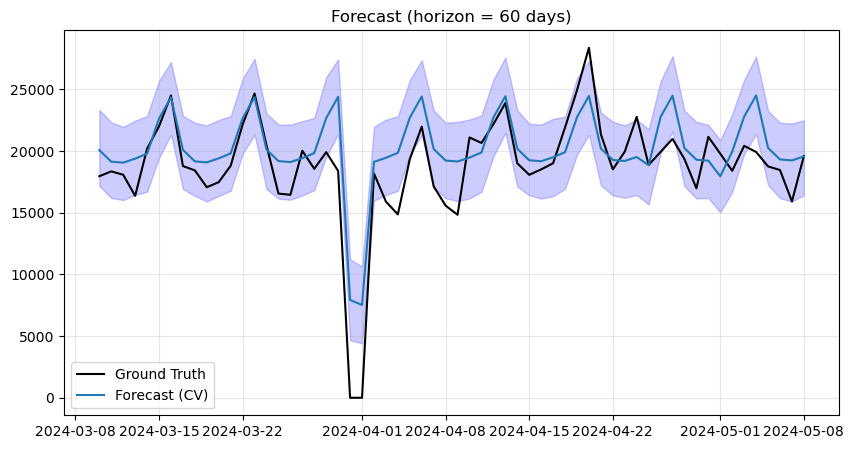


Test set metrics:
RMSE = 2658.40
MAE  = 2039.88


C:\Users\andre\AppData\Local\Temp\ipykernel_37676\1743448199.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_final["pre_covid"] = (train_final["ds"] < cutoff_date)
C:\Users\andre\AppData\Local\Temp\ipykernel_37676\1743448199.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_final["post_covid"] = (train_final["ds"] >= cutoff_date)
10:38:36 - cmdstanpy - INFO - Chain [1] start processing
10:38:37 - cmdstanpy - INFO - Chain [1] done processing



Model components:


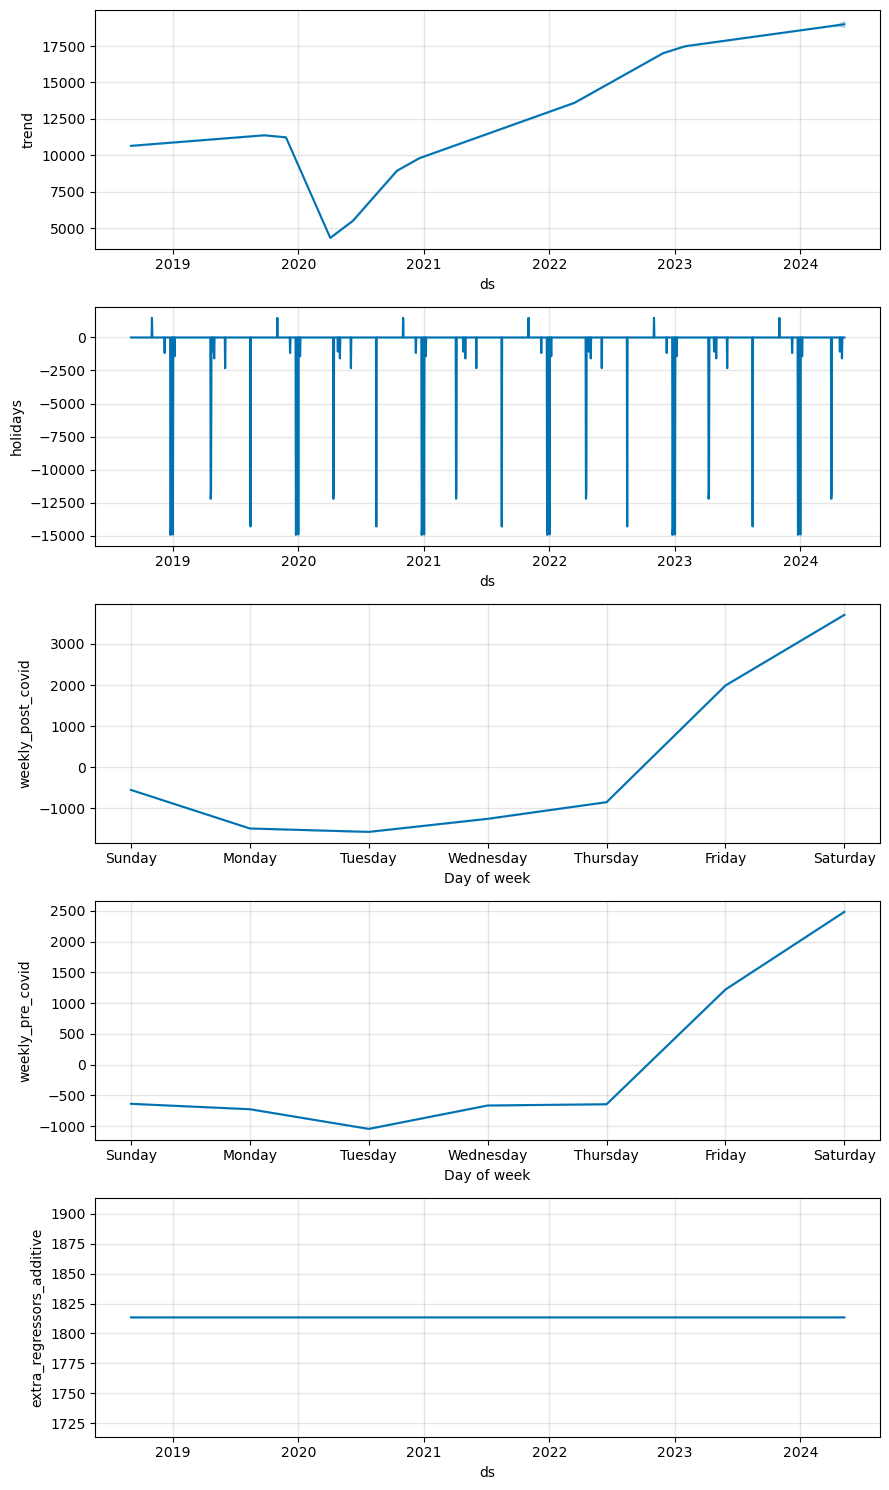

In [23]:
results = fit_prophet_model(
    df=df,
    y_col='totale',
    ds_col='data',
    regressors= covid_regr[1],
    n_test=60,
    weekly=False,
    monthly=False,
    yearly=False,
    weekly_prepost=True,
    holidays=True,
    verbose = True,
    return_results = True)

In [24]:
with open("models/prophet_model_totale_restaurant_3.json", "w") as f:
    f.write(model_to_json(results["model"]))

## GRID SEARCH ON DF4

<Axes: >

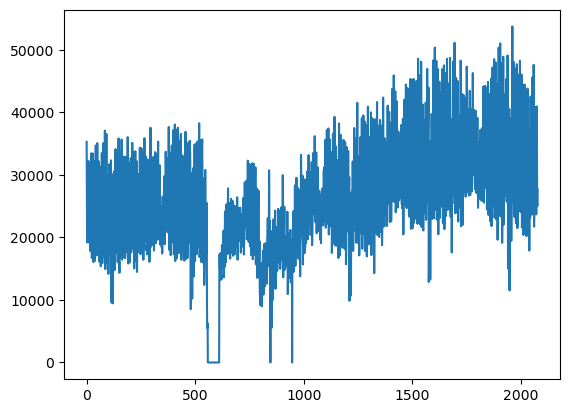

In [28]:
df = pd.read_csv('data/restaurant_4.csv')
df.totale.plot()

In [29]:
results = []

for (w, m, y, wp, h, covid) in param_grid:
    print(f"\n TTesting with: weekly={w}, monthly={m}, yearly={y}, prepost={wp}, holidays={h}, covid={covid is not None}")
    
    
        # Fit Prophet
    res = fit_prophet_model(
            df=df,
            y_col="totale",
            ds_col="data",
            n_test=60,
            weekly=w,
            monthly=m,
            yearly=y,
            weekly_prepost=wp,
            holidays=h,
            regressors=covid,
            verbose=False,
            return_results=True
    )

        
    metrics_last = res["metrics_last_window"]
    cv_metrics = res["metrics_cv"]
    rmse_cv_mean = cv_metrics["rmse"].mean()
    mae_cv_mean = cv_metrics["mae"].mean()
      
    results.append({
            "weekly": w,
            "monthly": m,
            "yearly": y,
            "weekly_prepost": wp,
            "holidays": h,
            "covid_regressors": covid,
            "RMSE_last": metrics_last["RMSE"],
            "MAE_last": metrics_last["MAE"],
            "RMSE_cv_mean": rmse_cv_mean,
            "MAE_cv_mean": mae_cv_mean
    })

df_results = pd.DataFrame(results)
df_results = df_results.sort_values("RMSE_cv_mean", ascending=True).reset_index(drop=True)
df_results.to_csv("prophet_gridsearch_results_restaurant_4.csv", index=False)


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=True, covid=False


10:40:05 - cmdstanpy - INFO - Chain [1] start processing
10:40:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:40:06 - cmdstanpy - INFO - Chain [1] start processing
10:40:06 - cmdstanpy - INFO - Chain [1] done processing
10:40:06 - cmdstanpy - INFO - Chain [1] start processing
10:40:06 - cmdstanpy - INFO - Chain [1] done processing
10:40:06 - cmdstanpy - INFO - Chain [1] start processing
10:40:06 - cmdstanpy - INFO - Chain [1] done processing
10:40:07 - cmdstanpy - INFO - Chain [1] start processing
10:40:07 - cmdstanpy - INFO - Chain [1] done processing
10:40:07 - cmdstanpy - INFO - Chain [1] start processing
10:40:07 - cmdstanpy - INFO - Chain [1] done processing
10:40:07 - cmdstanpy - INFO - Chain [1] start processing
10:40:07 - cmdstanpy - INFO - Chain [1] done processing
10:40:08 - cmdstanpy - INFO - Chain [1] start processing
10:40:08 - cmdstanpy - INFO - Chain [1] done processing
10:40:08 - cmdstanpy - INFO - Chain [1] start processing
10:40:08 - cmdstanpy - INFO - Chain [1] done processing
10:40:08 - cmdstanpy - INFO - Chain [1] start processing
10:40:09 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


10:40:17 - cmdstanpy - INFO - Chain [1] start processing
10:40:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:40:19 - cmdstanpy - INFO - Chain [1] start processing
10:40:19 - cmdstanpy - INFO - Chain [1] done processing
10:40:20 - cmdstanpy - INFO - Chain [1] start processing
10:40:20 - cmdstanpy - INFO - Chain [1] done processing
10:40:21 - cmdstanpy - INFO - Chain [1] start processing
10:40:21 - cmdstanpy - INFO - Chain [1] done processing
10:40:22 - cmdstanpy - INFO - Chain [1] start processing
10:40:22 - cmdstanpy - INFO - Chain [1] done processing
10:40:23 - cmdstanpy - INFO - Chain [1] start processing
10:40:23 - cmdstanpy - INFO - Chain [1] done processing
10:40:24 - cmdstanpy - INFO - Chain [1] start processing
10:40:24 - cmdstanpy - INFO - Chain [1] done processing
10:40:25 - cmdstanpy - INFO - Chain [1] start processing
10:40:25 - cmdstanpy - INFO - Chain [1] done processing
10:40:26 - cmdstanpy - INFO - Chain [1] start processing
10:40:26 - cmdstanpy - INFO - Chain [1] done processing
10:40:27 - cmdstanpy - INFO - Chain [1] start processing
10:40:27 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


10:40:50 - cmdstanpy - INFO - Chain [1] start processing
10:40:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:40:51 - cmdstanpy - INFO - Chain [1] start processing
10:40:51 - cmdstanpy - INFO - Chain [1] done processing
10:40:52 - cmdstanpy - INFO - Chain [1] start processing
10:40:52 - cmdstanpy - INFO - Chain [1] done processing
10:40:53 - cmdstanpy - INFO - Chain [1] start processing
10:40:53 - cmdstanpy - INFO - Chain [1] done processing
10:40:54 - cmdstanpy - INFO - Chain [1] start processing
10:40:54 - cmdstanpy - INFO - Chain [1] done processing
10:40:54 - cmdstanpy - INFO - Chain [1] start processing
10:40:55 - cmdstanpy - INFO - Chain [1] done processing
10:40:55 - cmdstanpy - INFO - Chain [1] start processing
10:40:56 - cmdstanpy - INFO - Chain [1] done processing
10:40:56 - cmdstanpy - INFO - Chain [1] start processing
10:40:57 - cmdstanpy - INFO - Chain [1] done processing
10:40:57 - cmdstanpy - INFO - Chain [1] start processing
10:40:58 - cmdstanpy - INFO - Chain [1] done processing
10:40:58 - cmdstanpy - INFO - Chain [1] start processing
10:40:59 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=False, covid=False


10:41:22 - cmdstanpy - INFO - Chain [1] start processing
10:41:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:41:23 - cmdstanpy - INFO - Chain [1] start processing
10:41:23 - cmdstanpy - INFO - Chain [1] done processing
10:41:23 - cmdstanpy - INFO - Chain [1] start processing
10:41:24 - cmdstanpy - INFO - Chain [1] done processing
10:41:24 - cmdstanpy - INFO - Chain [1] start processing
10:41:24 - cmdstanpy - INFO - Chain [1] done processing
10:41:25 - cmdstanpy - INFO - Chain [1] start processing
10:41:25 - cmdstanpy - INFO - Chain [1] done processing
10:41:25 - cmdstanpy - INFO - Chain [1] start processing
10:41:26 - cmdstanpy - INFO - Chain [1] done processing
10:41:26 - cmdstanpy - INFO - Chain [1] start processing
10:41:26 - cmdstanpy - INFO - Chain [1] done processing
10:41:27 - cmdstanpy - INFO - Chain [1] start processing
10:41:27 - cmdstanpy - INFO - Chain [1] done processing
10:41:28 - cmdstanpy - INFO - Chain [1] start processing
10:41:28 - cmdstanpy - INFO - Chain [1] done processing
10:41:28 - cmdstanpy - INFO - Chain [1] start processing
10:41:28 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


10:41:45 - cmdstanpy - INFO - Chain [1] start processing
10:41:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:41:47 - cmdstanpy - INFO - Chain [1] start processing
10:41:47 - cmdstanpy - INFO - Chain [1] done processing
10:41:47 - cmdstanpy - INFO - Chain [1] start processing
10:41:48 - cmdstanpy - INFO - Chain [1] done processing
10:41:48 - cmdstanpy - INFO - Chain [1] start processing
10:41:48 - cmdstanpy - INFO - Chain [1] done processing
10:41:49 - cmdstanpy - INFO - Chain [1] start processing
10:41:49 - cmdstanpy - INFO - Chain [1] done processing
10:41:50 - cmdstanpy - INFO - Chain [1] start processing
10:41:50 - cmdstanpy - INFO - Chain [1] done processing
10:41:51 - cmdstanpy - INFO - Chain [1] start processing
10:41:51 - cmdstanpy - INFO - Chain [1] done processing
10:41:52 - cmdstanpy - INFO - Chain [1] start processing
10:41:52 - cmdstanpy - INFO - Chain [1] done processing
10:41:53 - cmdstanpy - INFO - Chain [1] start processing
10:41:53 - cmdstanpy - INFO - Chain [1] done processing
10:41:54 - cmdstanpy - INFO - Chain [1] start processing
10:41:54 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


10:42:13 - cmdstanpy - INFO - Chain [1] start processing
10:42:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:42:14 - cmdstanpy - INFO - Chain [1] start processing
10:42:14 - cmdstanpy - INFO - Chain [1] done processing
10:42:14 - cmdstanpy - INFO - Chain [1] start processing
10:42:15 - cmdstanpy - INFO - Chain [1] done processing
10:42:15 - cmdstanpy - INFO - Chain [1] start processing
10:42:15 - cmdstanpy - INFO - Chain [1] done processing
10:42:16 - cmdstanpy - INFO - Chain [1] start processing
10:42:16 - cmdstanpy - INFO - Chain [1] done processing
10:42:17 - cmdstanpy - INFO - Chain [1] start processing
10:42:17 - cmdstanpy - INFO - Chain [1] done processing
10:42:18 - cmdstanpy - INFO - Chain [1] start processing
10:42:18 - cmdstanpy - INFO - Chain [1] done processing
10:42:19 - cmdstanpy - INFO - Chain [1] start processing
10:42:19 - cmdstanpy - INFO - Chain [1] done processing
10:42:20 - cmdstanpy - INFO - Chain [1] start processing
10:42:20 - cmdstanpy - INFO - Chain [1] done processing
10:42:21 - cmdstanpy - INFO - Chain [1] start processing
10:42:21 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=True, covid=False


10:42:39 - cmdstanpy - INFO - Chain [1] start processing
10:42:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:42:40 - cmdstanpy - INFO - Chain [1] start processing
10:42:41 - cmdstanpy - INFO - Chain [1] done processing
10:42:41 - cmdstanpy - INFO - Chain [1] start processing
10:42:41 - cmdstanpy - INFO - Chain [1] done processing
10:42:42 - cmdstanpy - INFO - Chain [1] start processing
10:42:42 - cmdstanpy - INFO - Chain [1] done processing
10:42:43 - cmdstanpy - INFO - Chain [1] start processing
10:42:43 - cmdstanpy - INFO - Chain [1] done processing
10:42:43 - cmdstanpy - INFO - Chain [1] start processing
10:42:44 - cmdstanpy - INFO - Chain [1] done processing
10:42:44 - cmdstanpy - INFO - Chain [1] start processing
10:42:45 - cmdstanpy - INFO - Chain [1] done processing
10:42:45 - cmdstanpy - INFO - Chain [1] start processing
10:42:46 - cmdstanpy - INFO - Chain [1] done processing
10:42:46 - cmdstanpy - INFO - Chain [1] start processing
10:42:46 - cmdstanpy - INFO - Chain [1] done processing
10:42:47 - cmdstanpy - INFO - Chain [1] start processing
10:42:47 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


10:43:06 - cmdstanpy - INFO - Chain [1] start processing
10:43:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:43:07 - cmdstanpy - INFO - Chain [1] start processing
10:43:08 - cmdstanpy - INFO - Chain [1] done processing
10:43:08 - cmdstanpy - INFO - Chain [1] start processing
10:43:08 - cmdstanpy - INFO - Chain [1] done processing
10:43:09 - cmdstanpy - INFO - Chain [1] start processing
10:43:09 - cmdstanpy - INFO - Chain [1] done processing
10:43:10 - cmdstanpy - INFO - Chain [1] start processing
10:43:10 - cmdstanpy - INFO - Chain [1] done processing
10:43:11 - cmdstanpy - INFO - Chain [1] start processing
10:43:11 - cmdstanpy - INFO - Chain [1] done processing
10:43:12 - cmdstanpy - INFO - Chain [1] start processing
10:43:12 - cmdstanpy - INFO - Chain [1] done processing
10:43:13 - cmdstanpy - INFO - Chain [1] start processing
10:43:13 - cmdstanpy - INFO - Chain [1] done processing
10:43:14 - cmdstanpy - INFO - Chain [1] start processing
10:43:14 - cmdstanpy - INFO - Chain [1] done processing
10:43:15 - cmdstanpy - INFO - Chain [1] start processing
10:43:16 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


10:43:35 - cmdstanpy - INFO - Chain [1] start processing
10:43:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:43:37 - cmdstanpy - INFO - Chain [1] start processing
10:43:37 - cmdstanpy - INFO - Chain [1] done processing
10:43:37 - cmdstanpy - INFO - Chain [1] start processing
10:43:38 - cmdstanpy - INFO - Chain [1] done processing
10:43:38 - cmdstanpy - INFO - Chain [1] start processing
10:43:38 - cmdstanpy - INFO - Chain [1] done processing
10:43:39 - cmdstanpy - INFO - Chain [1] start processing
10:43:39 - cmdstanpy - INFO - Chain [1] done processing
10:43:40 - cmdstanpy - INFO - Chain [1] start processing
10:43:40 - cmdstanpy - INFO - Chain [1] done processing
10:43:41 - cmdstanpy - INFO - Chain [1] start processing
10:43:41 - cmdstanpy - INFO - Chain [1] done processing
10:43:42 - cmdstanpy - INFO - Chain [1] start processing
10:43:42 - cmdstanpy - INFO - Chain [1] done processing
10:43:43 - cmdstanpy - INFO - Chain [1] start processing
10:43:43 - cmdstanpy - INFO - Chain [1] done processing
10:43:44 - cmdstanpy - INFO - Chain [1] start processing
10:43:44 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=False, covid=False


10:44:05 - cmdstanpy - INFO - Chain [1] start processing
10:44:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:44:06 - cmdstanpy - INFO - Chain [1] start processing
10:44:07 - cmdstanpy - INFO - Chain [1] done processing
10:44:07 - cmdstanpy - INFO - Chain [1] start processing
10:44:07 - cmdstanpy - INFO - Chain [1] done processing
10:44:08 - cmdstanpy - INFO - Chain [1] start processing
10:44:08 - cmdstanpy - INFO - Chain [1] done processing
10:44:08 - cmdstanpy - INFO - Chain [1] start processing
10:44:08 - cmdstanpy - INFO - Chain [1] done processing
10:44:09 - cmdstanpy - INFO - Chain [1] start processing
10:44:09 - cmdstanpy - INFO - Chain [1] done processing
10:44:10 - cmdstanpy - INFO - Chain [1] start processing
10:44:10 - cmdstanpy - INFO - Chain [1] done processing
10:44:10 - cmdstanpy - INFO - Chain [1] start processing
10:44:11 - cmdstanpy - INFO - Chain [1] done processing
10:44:11 - cmdstanpy - INFO - Chain [1] start processing
10:44:11 - cmdstanpy - INFO - Chain [1] done processing
10:44:12 - cmdstanpy - INFO - Chain [1] start processing
10:44:12 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


10:44:28 - cmdstanpy - INFO - Chain [1] start processing
10:44:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:44:30 - cmdstanpy - INFO - Chain [1] start processing
10:44:30 - cmdstanpy - INFO - Chain [1] done processing
10:44:30 - cmdstanpy - INFO - Chain [1] start processing
10:44:31 - cmdstanpy - INFO - Chain [1] done processing
10:44:31 - cmdstanpy - INFO - Chain [1] start processing
10:44:31 - cmdstanpy - INFO - Chain [1] done processing
10:44:32 - cmdstanpy - INFO - Chain [1] start processing
10:44:32 - cmdstanpy - INFO - Chain [1] done processing
10:44:33 - cmdstanpy - INFO - Chain [1] start processing
10:44:33 - cmdstanpy - INFO - Chain [1] done processing
10:44:34 - cmdstanpy - INFO - Chain [1] start processing
10:44:34 - cmdstanpy - INFO - Chain [1] done processing
10:44:34 - cmdstanpy - INFO - Chain [1] start processing
10:44:35 - cmdstanpy - INFO - Chain [1] done processing
10:44:35 - cmdstanpy - INFO - Chain [1] start processing
10:44:36 - cmdstanpy - INFO - Chain [1] done processing
10:44:36 - cmdstanpy - INFO - Chain [1] start processing
10:44:37 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


10:44:57 - cmdstanpy - INFO - Chain [1] start processing
10:44:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:44:58 - cmdstanpy - INFO - Chain [1] start processing
10:44:58 - cmdstanpy - INFO - Chain [1] done processing
10:44:59 - cmdstanpy - INFO - Chain [1] start processing
10:44:59 - cmdstanpy - INFO - Chain [1] done processing
10:44:59 - cmdstanpy - INFO - Chain [1] start processing
10:44:59 - cmdstanpy - INFO - Chain [1] done processing
10:45:00 - cmdstanpy - INFO - Chain [1] start processing
10:45:00 - cmdstanpy - INFO - Chain [1] done processing
10:45:01 - cmdstanpy - INFO - Chain [1] start processing
10:45:01 - cmdstanpy - INFO - Chain [1] done processing
10:45:02 - cmdstanpy - INFO - Chain [1] start processing
10:45:02 - cmdstanpy - INFO - Chain [1] done processing
10:45:02 - cmdstanpy - INFO - Chain [1] start processing
10:45:03 - cmdstanpy - INFO - Chain [1] done processing
10:45:03 - cmdstanpy - INFO - Chain [1] start processing
10:45:04 - cmdstanpy - INFO - Chain [1] done processing
10:45:04 - cmdstanpy - INFO - Chain [1] start processing
10:45:04 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=True, covid=False


10:45:22 - cmdstanpy - INFO - Chain [1] start processing
10:45:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:45:23 - cmdstanpy - INFO - Chain [1] start processing
10:45:24 - cmdstanpy - INFO - Chain [1] done processing
10:45:24 - cmdstanpy - INFO - Chain [1] start processing
10:45:24 - cmdstanpy - INFO - Chain [1] done processing
10:45:25 - cmdstanpy - INFO - Chain [1] start processing
10:45:25 - cmdstanpy - INFO - Chain [1] done processing
10:45:26 - cmdstanpy - INFO - Chain [1] start processing
10:45:26 - cmdstanpy - INFO - Chain [1] done processing
10:45:26 - cmdstanpy - INFO - Chain [1] start processing
10:45:26 - cmdstanpy - INFO - Chain [1] done processing
10:45:27 - cmdstanpy - INFO - Chain [1] start processing
10:45:27 - cmdstanpy - INFO - Chain [1] done processing
10:45:28 - cmdstanpy - INFO - Chain [1] start processing
10:45:28 - cmdstanpy - INFO - Chain [1] done processing
10:45:29 - cmdstanpy - INFO - Chain [1] start processing
10:45:29 - cmdstanpy - INFO - Chain [1] done processing
10:45:30 - cmdstanpy - INFO - Chain [1] start processing
10:45:30 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


10:45:46 - cmdstanpy - INFO - Chain [1] start processing
10:45:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:45:47 - cmdstanpy - INFO - Chain [1] start processing
10:45:47 - cmdstanpy - INFO - Chain [1] done processing
10:45:47 - cmdstanpy - INFO - Chain [1] start processing
10:45:48 - cmdstanpy - INFO - Chain [1] done processing
10:45:48 - cmdstanpy - INFO - Chain [1] start processing
10:45:48 - cmdstanpy - INFO - Chain [1] done processing
10:45:49 - cmdstanpy - INFO - Chain [1] start processing
10:45:49 - cmdstanpy - INFO - Chain [1] done processing
10:45:50 - cmdstanpy - INFO - Chain [1] start processing
10:45:50 - cmdstanpy - INFO - Chain [1] done processing
10:45:50 - cmdstanpy - INFO - Chain [1] start processing
10:45:51 - cmdstanpy - INFO - Chain [1] done processing
10:45:51 - cmdstanpy - INFO - Chain [1] start processing
10:45:51 - cmdstanpy - INFO - Chain [1] done processing
10:45:52 - cmdstanpy - INFO - Chain [1] start processing
10:45:52 - cmdstanpy - INFO - Chain [1] done processing
10:45:53 - cmdstanpy - INFO - Chain [1] start processing
10:45:53 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


10:46:09 - cmdstanpy - INFO - Chain [1] start processing
10:46:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:46:10 - cmdstanpy - INFO - Chain [1] start processing
10:46:10 - cmdstanpy - INFO - Chain [1] done processing
10:46:11 - cmdstanpy - INFO - Chain [1] start processing
10:46:11 - cmdstanpy - INFO - Chain [1] done processing
10:46:12 - cmdstanpy - INFO - Chain [1] start processing
10:46:12 - cmdstanpy - INFO - Chain [1] done processing
10:46:12 - cmdstanpy - INFO - Chain [1] start processing
10:46:12 - cmdstanpy - INFO - Chain [1] done processing
10:46:13 - cmdstanpy - INFO - Chain [1] start processing
10:46:13 - cmdstanpy - INFO - Chain [1] done processing
10:46:14 - cmdstanpy - INFO - Chain [1] start processing
10:46:14 - cmdstanpy - INFO - Chain [1] done processing
10:46:15 - cmdstanpy - INFO - Chain [1] start processing
10:46:15 - cmdstanpy - INFO - Chain [1] done processing
10:46:16 - cmdstanpy - INFO - Chain [1] start processing
10:46:16 - cmdstanpy - INFO - Chain [1] done processing
10:46:17 - cmdstanpy - INFO - Chain [1] start processing
10:46:17 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=False, covid=False


10:46:33 - cmdstanpy - INFO - Chain [1] start processing
10:46:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:46:34 - cmdstanpy - INFO - Chain [1] start processing
10:46:35 - cmdstanpy - INFO - Chain [1] done processing
10:46:35 - cmdstanpy - INFO - Chain [1] start processing
10:46:35 - cmdstanpy - INFO - Chain [1] done processing
10:46:35 - cmdstanpy - INFO - Chain [1] start processing
10:46:36 - cmdstanpy - INFO - Chain [1] done processing
10:46:36 - cmdstanpy - INFO - Chain [1] start processing
10:46:36 - cmdstanpy - INFO - Chain [1] done processing
10:46:37 - cmdstanpy - INFO - Chain [1] start processing
10:46:37 - cmdstanpy - INFO - Chain [1] done processing
10:46:37 - cmdstanpy - INFO - Chain [1] start processing
10:46:38 - cmdstanpy - INFO - Chain [1] done processing
10:46:38 - cmdstanpy - INFO - Chain [1] start processing
10:46:38 - cmdstanpy - INFO - Chain [1] done processing
10:46:39 - cmdstanpy - INFO - Chain [1] start processing
10:46:39 - cmdstanpy - INFO - Chain [1] done processing
10:46:39 - cmdstanpy - INFO - Chain [1] start processing
10:46:40 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


10:46:54 - cmdstanpy - INFO - Chain [1] start processing
10:46:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:46:55 - cmdstanpy - INFO - Chain [1] start processing
10:46:55 - cmdstanpy - INFO - Chain [1] done processing
10:46:55 - cmdstanpy - INFO - Chain [1] start processing
10:46:55 - cmdstanpy - INFO - Chain [1] done processing
10:46:56 - cmdstanpy - INFO - Chain [1] start processing
10:46:56 - cmdstanpy - INFO - Chain [1] done processing
10:46:56 - cmdstanpy - INFO - Chain [1] start processing
10:46:56 - cmdstanpy - INFO - Chain [1] done processing
10:46:57 - cmdstanpy - INFO - Chain [1] start processing
10:46:57 - cmdstanpy - INFO - Chain [1] done processing
10:46:57 - cmdstanpy - INFO - Chain [1] start processing
10:46:58 - cmdstanpy - INFO - Chain [1] done processing
10:46:58 - cmdstanpy - INFO - Chain [1] start processing
10:46:58 - cmdstanpy - INFO - Chain [1] done processing
10:46:59 - cmdstanpy - INFO - Chain [1] start processing
10:46:59 - cmdstanpy - INFO - Chain [1] done processing
10:47:00 - cmdstanpy - INFO - Chain [1] start processing
10:47:00 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


10:47:14 - cmdstanpy - INFO - Chain [1] start processing
10:47:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:47:15 - cmdstanpy - INFO - Chain [1] start processing
10:47:15 - cmdstanpy - INFO - Chain [1] done processing
10:47:15 - cmdstanpy - INFO - Chain [1] start processing
10:47:16 - cmdstanpy - INFO - Chain [1] done processing
10:47:16 - cmdstanpy - INFO - Chain [1] start processing
10:47:16 - cmdstanpy - INFO - Chain [1] done processing
10:47:17 - cmdstanpy - INFO - Chain [1] start processing
10:47:17 - cmdstanpy - INFO - Chain [1] done processing
10:47:17 - cmdstanpy - INFO - Chain [1] start processing
10:47:17 - cmdstanpy - INFO - Chain [1] done processing
10:47:18 - cmdstanpy - INFO - Chain [1] start processing
10:47:18 - cmdstanpy - INFO - Chain [1] done processing
10:47:19 - cmdstanpy - INFO - Chain [1] start processing
10:47:19 - cmdstanpy - INFO - Chain [1] done processing
10:47:19 - cmdstanpy - INFO - Chain [1] start processing
10:47:19 - cmdstanpy - INFO - Chain [1] done processing
10:47:20 - cmdstanpy - INFO - Chain [1] start processing
10:47:20 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=True, covid=False


10:47:34 - cmdstanpy - INFO - Chain [1] start processing
10:47:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:47:35 - cmdstanpy - INFO - Chain [1] start processing
10:47:35 - cmdstanpy - INFO - Chain [1] done processing
10:47:36 - cmdstanpy - INFO - Chain [1] start processing
10:47:36 - cmdstanpy - INFO - Chain [1] done processing
10:47:36 - cmdstanpy - INFO - Chain [1] start processing
10:47:37 - cmdstanpy - INFO - Chain [1] done processing
10:47:37 - cmdstanpy - INFO - Chain [1] start processing
10:47:37 - cmdstanpy - INFO - Chain [1] done processing
10:47:38 - cmdstanpy - INFO - Chain [1] start processing
10:47:38 - cmdstanpy - INFO - Chain [1] done processing
10:47:39 - cmdstanpy - INFO - Chain [1] start processing
10:47:39 - cmdstanpy - INFO - Chain [1] done processing
10:47:39 - cmdstanpy - INFO - Chain [1] start processing
10:47:39 - cmdstanpy - INFO - Chain [1] done processing
10:47:40 - cmdstanpy - INFO - Chain [1] start processing
10:47:40 - cmdstanpy - INFO - Chain [1] done processing
10:47:41 - cmdstanpy - INFO - Chain [1] start processing
10:47:41 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


10:47:56 - cmdstanpy - INFO - Chain [1] start processing
10:47:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:47:57 - cmdstanpy - INFO - Chain [1] start processing
10:47:57 - cmdstanpy - INFO - Chain [1] done processing
10:47:57 - cmdstanpy - INFO - Chain [1] start processing
10:47:57 - cmdstanpy - INFO - Chain [1] done processing
10:47:58 - cmdstanpy - INFO - Chain [1] start processing
10:47:58 - cmdstanpy - INFO - Chain [1] done processing
10:47:59 - cmdstanpy - INFO - Chain [1] start processing
10:47:59 - cmdstanpy - INFO - Chain [1] done processing
10:47:59 - cmdstanpy - INFO - Chain [1] start processing
10:48:00 - cmdstanpy - INFO - Chain [1] done processing
10:48:00 - cmdstanpy - INFO - Chain [1] start processing
10:48:00 - cmdstanpy - INFO - Chain [1] done processing
10:48:01 - cmdstanpy - INFO - Chain [1] start processing
10:48:01 - cmdstanpy - INFO - Chain [1] done processing
10:48:02 - cmdstanpy - INFO - Chain [1] start processing
10:48:02 - cmdstanpy - INFO - Chain [1] done processing
10:48:02 - cmdstanpy - INFO - Chain [1] start processing
10:48:03 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


10:48:18 - cmdstanpy - INFO - Chain [1] start processing
10:48:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:48:19 - cmdstanpy - INFO - Chain [1] start processing
10:48:19 - cmdstanpy - INFO - Chain [1] done processing
10:48:20 - cmdstanpy - INFO - Chain [1] start processing
10:48:20 - cmdstanpy - INFO - Chain [1] done processing
10:48:20 - cmdstanpy - INFO - Chain [1] start processing
10:48:21 - cmdstanpy - INFO - Chain [1] done processing
10:48:21 - cmdstanpy - INFO - Chain [1] start processing
10:48:21 - cmdstanpy - INFO - Chain [1] done processing
10:48:22 - cmdstanpy - INFO - Chain [1] start processing
10:48:22 - cmdstanpy - INFO - Chain [1] done processing
10:48:23 - cmdstanpy - INFO - Chain [1] start processing
10:48:23 - cmdstanpy - INFO - Chain [1] done processing
10:48:24 - cmdstanpy - INFO - Chain [1] start processing
10:48:24 - cmdstanpy - INFO - Chain [1] done processing
10:48:25 - cmdstanpy - INFO - Chain [1] start processing
10:48:25 - cmdstanpy - INFO - Chain [1] done processing
10:48:26 - cmdstanpy - INFO - Chain [1] start processing
10:48:26 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=False, covid=False


10:48:41 - cmdstanpy - INFO - Chain [1] start processing
10:48:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:48:42 - cmdstanpy - INFO - Chain [1] start processing
10:48:42 - cmdstanpy - INFO - Chain [1] done processing
10:48:42 - cmdstanpy - INFO - Chain [1] start processing
10:48:42 - cmdstanpy - INFO - Chain [1] done processing
10:48:43 - cmdstanpy - INFO - Chain [1] start processing
10:48:43 - cmdstanpy - INFO - Chain [1] done processing
10:48:43 - cmdstanpy - INFO - Chain [1] start processing
10:48:44 - cmdstanpy - INFO - Chain [1] done processing
10:48:44 - cmdstanpy - INFO - Chain [1] start processing
10:48:44 - cmdstanpy - INFO - Chain [1] done processing
10:48:45 - cmdstanpy - INFO - Chain [1] start processing
10:48:45 - cmdstanpy - INFO - Chain [1] done processing
10:48:45 - cmdstanpy - INFO - Chain [1] start processing
10:48:45 - cmdstanpy - INFO - Chain [1] done processing
10:48:46 - cmdstanpy - INFO - Chain [1] start processing
10:48:46 - cmdstanpy - INFO - Chain [1] done processing
10:48:47 - cmdstanpy - INFO - Chain [1] start processing
10:48:47 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


10:49:00 - cmdstanpy - INFO - Chain [1] start processing
10:49:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:49:01 - cmdstanpy - INFO - Chain [1] start processing
10:49:01 - cmdstanpy - INFO - Chain [1] done processing
10:49:01 - cmdstanpy - INFO - Chain [1] start processing
10:49:02 - cmdstanpy - INFO - Chain [1] done processing
10:49:02 - cmdstanpy - INFO - Chain [1] start processing
10:49:02 - cmdstanpy - INFO - Chain [1] done processing
10:49:03 - cmdstanpy - INFO - Chain [1] start processing
10:49:03 - cmdstanpy - INFO - Chain [1] done processing
10:49:03 - cmdstanpy - INFO - Chain [1] start processing
10:49:03 - cmdstanpy - INFO - Chain [1] done processing
10:49:04 - cmdstanpy - INFO - Chain [1] start processing
10:49:04 - cmdstanpy - INFO - Chain [1] done processing
10:49:05 - cmdstanpy - INFO - Chain [1] start processing
10:49:05 - cmdstanpy - INFO - Chain [1] done processing
10:49:05 - cmdstanpy - INFO - Chain [1] start processing
10:49:06 - cmdstanpy - INFO - Chain [1] done processing
10:49:06 - cmdstanpy - INFO - Chain [1] start processing
10:49:06 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


10:49:19 - cmdstanpy - INFO - Chain [1] start processing
10:49:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:49:20 - cmdstanpy - INFO - Chain [1] start processing
10:49:20 - cmdstanpy - INFO - Chain [1] done processing
10:49:21 - cmdstanpy - INFO - Chain [1] start processing
10:49:21 - cmdstanpy - INFO - Chain [1] done processing
10:49:21 - cmdstanpy - INFO - Chain [1] start processing
10:49:21 - cmdstanpy - INFO - Chain [1] done processing
10:49:22 - cmdstanpy - INFO - Chain [1] start processing
10:49:22 - cmdstanpy - INFO - Chain [1] done processing
10:49:22 - cmdstanpy - INFO - Chain [1] start processing
10:49:22 - cmdstanpy - INFO - Chain [1] done processing
10:49:23 - cmdstanpy - INFO - Chain [1] start processing
10:49:23 - cmdstanpy - INFO - Chain [1] done processing
10:49:24 - cmdstanpy - INFO - Chain [1] start processing
10:49:24 - cmdstanpy - INFO - Chain [1] done processing
10:49:24 - cmdstanpy - INFO - Chain [1] start processing
10:49:24 - cmdstanpy - INFO - Chain [1] done processing
10:49:25 - cmdstanpy - INFO - Chain [1] start processing
10:49:25 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=True, covid=False


10:49:38 - cmdstanpy - INFO - Chain [1] start processing
10:49:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:49:39 - cmdstanpy - INFO - Chain [1] start processing
10:49:39 - cmdstanpy - INFO - Chain [1] done processing
10:49:40 - cmdstanpy - INFO - Chain [1] start processing
10:49:40 - cmdstanpy - INFO - Chain [1] done processing
10:49:40 - cmdstanpy - INFO - Chain [1] start processing
10:49:41 - cmdstanpy - INFO - Chain [1] done processing
10:49:41 - cmdstanpy - INFO - Chain [1] start processing
10:49:41 - cmdstanpy - INFO - Chain [1] done processing
10:49:42 - cmdstanpy - INFO - Chain [1] start processing
10:49:42 - cmdstanpy - INFO - Chain [1] done processing
10:49:43 - cmdstanpy - INFO - Chain [1] start processing
10:49:43 - cmdstanpy - INFO - Chain [1] done processing
10:49:43 - cmdstanpy - INFO - Chain [1] start processing
10:49:44 - cmdstanpy - INFO - Chain [1] done processing
10:49:44 - cmdstanpy - INFO - Chain [1] start processing
10:49:44 - cmdstanpy - INFO - Chain [1] done processing
10:49:45 - cmdstanpy - INFO - Chain [1] start processing
10:49:46 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


10:50:03 - cmdstanpy - INFO - Chain [1] start processing
10:50:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:50:04 - cmdstanpy - INFO - Chain [1] start processing
10:50:04 - cmdstanpy - INFO - Chain [1] done processing
10:50:05 - cmdstanpy - INFO - Chain [1] start processing
10:50:05 - cmdstanpy - INFO - Chain [1] done processing
10:50:05 - cmdstanpy - INFO - Chain [1] start processing
10:50:06 - cmdstanpy - INFO - Chain [1] done processing
10:50:06 - cmdstanpy - INFO - Chain [1] start processing
10:50:06 - cmdstanpy - INFO - Chain [1] done processing
10:50:07 - cmdstanpy - INFO - Chain [1] start processing
10:50:07 - cmdstanpy - INFO - Chain [1] done processing
10:50:08 - cmdstanpy - INFO - Chain [1] start processing
10:50:08 - cmdstanpy - INFO - Chain [1] done processing
10:50:09 - cmdstanpy - INFO - Chain [1] start processing
10:50:09 - cmdstanpy - INFO - Chain [1] done processing
10:50:10 - cmdstanpy - INFO - Chain [1] start processing
10:50:10 - cmdstanpy - INFO - Chain [1] done processing
10:50:11 - cmdstanpy - INFO - Chain [1] start processing
10:50:11 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


10:50:30 - cmdstanpy - INFO - Chain [1] start processing
10:50:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:50:31 - cmdstanpy - INFO - Chain [1] start processing
10:50:31 - cmdstanpy - INFO - Chain [1] done processing
10:50:32 - cmdstanpy - INFO - Chain [1] start processing
10:50:32 - cmdstanpy - INFO - Chain [1] done processing
10:50:33 - cmdstanpy - INFO - Chain [1] start processing
10:50:33 - cmdstanpy - INFO - Chain [1] done processing
10:50:33 - cmdstanpy - INFO - Chain [1] start processing
10:50:34 - cmdstanpy - INFO - Chain [1] done processing
10:50:34 - cmdstanpy - INFO - Chain [1] start processing
10:50:34 - cmdstanpy - INFO - Chain [1] done processing
10:50:35 - cmdstanpy - INFO - Chain [1] start processing
10:50:35 - cmdstanpy - INFO - Chain [1] done processing
10:50:36 - cmdstanpy - INFO - Chain [1] start processing
10:50:36 - cmdstanpy - INFO - Chain [1] done processing
10:50:37 - cmdstanpy - INFO - Chain [1] start processing
10:50:37 - cmdstanpy - INFO - Chain [1] done processing
10:50:38 - cmdstanpy - INFO - Chain [1] start processing
10:50:38 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=False, covid=False


10:50:57 - cmdstanpy - INFO - Chain [1] start processing
10:50:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:50:58 - cmdstanpy - INFO - Chain [1] start processing
10:50:58 - cmdstanpy - INFO - Chain [1] done processing
10:50:59 - cmdstanpy - INFO - Chain [1] start processing
10:50:59 - cmdstanpy - INFO - Chain [1] done processing
10:51:00 - cmdstanpy - INFO - Chain [1] start processing
10:51:00 - cmdstanpy - INFO - Chain [1] done processing
10:51:00 - cmdstanpy - INFO - Chain [1] start processing
10:51:01 - cmdstanpy - INFO - Chain [1] done processing
10:51:01 - cmdstanpy - INFO - Chain [1] start processing
10:51:02 - cmdstanpy - INFO - Chain [1] done processing
10:51:02 - cmdstanpy - INFO - Chain [1] start processing
10:51:02 - cmdstanpy - INFO - Chain [1] done processing
10:51:03 - cmdstanpy - INFO - Chain [1] start processing
10:51:03 - cmdstanpy - INFO - Chain [1] done processing
10:51:04 - cmdstanpy - INFO - Chain [1] start processing
10:51:04 - cmdstanpy - INFO - Chain [1] done processing
10:51:05 - cmdstanpy - INFO - Chain [1] start processing
10:51:05 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


10:51:20 - cmdstanpy - INFO - Chain [1] start processing
10:51:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:51:21 - cmdstanpy - INFO - Chain [1] start processing
10:51:21 - cmdstanpy - INFO - Chain [1] done processing
10:51:21 - cmdstanpy - INFO - Chain [1] start processing
10:51:22 - cmdstanpy - INFO - Chain [1] done processing
10:51:22 - cmdstanpy - INFO - Chain [1] start processing
10:51:22 - cmdstanpy - INFO - Chain [1] done processing
10:51:23 - cmdstanpy - INFO - Chain [1] start processing
10:51:23 - cmdstanpy - INFO - Chain [1] done processing
10:51:24 - cmdstanpy - INFO - Chain [1] start processing
10:51:24 - cmdstanpy - INFO - Chain [1] done processing
10:51:24 - cmdstanpy - INFO - Chain [1] start processing
10:51:25 - cmdstanpy - INFO - Chain [1] done processing
10:51:25 - cmdstanpy - INFO - Chain [1] start processing
10:51:25 - cmdstanpy - INFO - Chain [1] done processing
10:51:26 - cmdstanpy - INFO - Chain [1] start processing
10:51:26 - cmdstanpy - INFO - Chain [1] done processing
10:51:27 - cmdstanpy - INFO - Chain [1] start processing
10:51:27 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


10:51:44 - cmdstanpy - INFO - Chain [1] start processing
10:51:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:51:45 - cmdstanpy - INFO - Chain [1] start processing
10:51:46 - cmdstanpy - INFO - Chain [1] done processing
10:51:46 - cmdstanpy - INFO - Chain [1] start processing
10:51:46 - cmdstanpy - INFO - Chain [1] done processing
10:51:47 - cmdstanpy - INFO - Chain [1] start processing
10:51:47 - cmdstanpy - INFO - Chain [1] done processing
10:51:47 - cmdstanpy - INFO - Chain [1] start processing
10:51:48 - cmdstanpy - INFO - Chain [1] done processing
10:51:48 - cmdstanpy - INFO - Chain [1] start processing
10:51:48 - cmdstanpy - INFO - Chain [1] done processing
10:51:49 - cmdstanpy - INFO - Chain [1] start processing
10:51:49 - cmdstanpy - INFO - Chain [1] done processing
10:51:50 - cmdstanpy - INFO - Chain [1] start processing
10:51:50 - cmdstanpy - INFO - Chain [1] done processing
10:51:51 - cmdstanpy - INFO - Chain [1] start processing
10:51:51 - cmdstanpy - INFO - Chain [1] done processing
10:51:52 - cmdstanpy - INFO - Chain [1] start processing
10:51:52 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=True, covid=False


10:52:08 - cmdstanpy - INFO - Chain [1] start processing
10:52:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:52:10 - cmdstanpy - INFO - Chain [1] start processing
10:52:10 - cmdstanpy - INFO - Chain [1] done processing
10:52:10 - cmdstanpy - INFO - Chain [1] start processing
10:52:11 - cmdstanpy - INFO - Chain [1] done processing
10:52:11 - cmdstanpy - INFO - Chain [1] start processing
10:52:11 - cmdstanpy - INFO - Chain [1] done processing
10:52:12 - cmdstanpy - INFO - Chain [1] start processing
10:52:12 - cmdstanpy - INFO - Chain [1] done processing
10:52:13 - cmdstanpy - INFO - Chain [1] start processing
10:52:13 - cmdstanpy - INFO - Chain [1] done processing
10:52:13 - cmdstanpy - INFO - Chain [1] start processing
10:52:14 - cmdstanpy - INFO - Chain [1] done processing
10:52:14 - cmdstanpy - INFO - Chain [1] start processing
10:52:15 - cmdstanpy - INFO - Chain [1] done processing
10:52:15 - cmdstanpy - INFO - Chain [1] start processing
10:52:16 - cmdstanpy - INFO - Chain [1] done processing
10:52:16 - cmdstanpy - INFO - Chain [1] start processing
10:52:16 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


10:52:33 - cmdstanpy - INFO - Chain [1] start processing
10:52:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:52:34 - cmdstanpy - INFO - Chain [1] start processing
10:52:34 - cmdstanpy - INFO - Chain [1] done processing
10:52:35 - cmdstanpy - INFO - Chain [1] start processing
10:52:35 - cmdstanpy - INFO - Chain [1] done processing
10:52:36 - cmdstanpy - INFO - Chain [1] start processing
10:52:36 - cmdstanpy - INFO - Chain [1] done processing
10:52:36 - cmdstanpy - INFO - Chain [1] start processing
10:52:37 - cmdstanpy - INFO - Chain [1] done processing
10:52:37 - cmdstanpy - INFO - Chain [1] start processing
10:52:37 - cmdstanpy - INFO - Chain [1] done processing
10:52:38 - cmdstanpy - INFO - Chain [1] start processing
10:52:38 - cmdstanpy - INFO - Chain [1] done processing
10:52:39 - cmdstanpy - INFO - Chain [1] start processing
10:52:39 - cmdstanpy - INFO - Chain [1] done processing
10:52:40 - cmdstanpy - INFO - Chain [1] start processing
10:52:40 - cmdstanpy - INFO - Chain [1] done processing
10:52:41 - cmdstanpy - INFO - Chain [1] start processing
10:52:41 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


10:53:00 - cmdstanpy - INFO - Chain [1] start processing
10:53:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:53:01 - cmdstanpy - INFO - Chain [1] start processing
10:53:01 - cmdstanpy - INFO - Chain [1] done processing
10:53:02 - cmdstanpy - INFO - Chain [1] start processing
10:53:02 - cmdstanpy - INFO - Chain [1] done processing
10:53:03 - cmdstanpy - INFO - Chain [1] start processing
10:53:03 - cmdstanpy - INFO - Chain [1] done processing
10:53:03 - cmdstanpy - INFO - Chain [1] start processing
10:53:03 - cmdstanpy - INFO - Chain [1] done processing
10:53:04 - cmdstanpy - INFO - Chain [1] start processing
10:53:04 - cmdstanpy - INFO - Chain [1] done processing
10:53:05 - cmdstanpy - INFO - Chain [1] start processing
10:53:05 - cmdstanpy - INFO - Chain [1] done processing
10:53:06 - cmdstanpy - INFO - Chain [1] start processing
10:53:06 - cmdstanpy - INFO - Chain [1] done processing
10:53:06 - cmdstanpy - INFO - Chain [1] start processing
10:53:07 - cmdstanpy - INFO - Chain [1] done processing
10:53:07 - cmdstanpy - INFO - Chain [1] start processing
10:53:08 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=False, covid=False


10:53:26 - cmdstanpy - INFO - Chain [1] start processing
10:53:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:53:27 - cmdstanpy - INFO - Chain [1] start processing
10:53:27 - cmdstanpy - INFO - Chain [1] done processing
10:53:27 - cmdstanpy - INFO - Chain [1] start processing
10:53:27 - cmdstanpy - INFO - Chain [1] done processing
10:53:28 - cmdstanpy - INFO - Chain [1] start processing
10:53:28 - cmdstanpy - INFO - Chain [1] done processing
10:53:28 - cmdstanpy - INFO - Chain [1] start processing
10:53:29 - cmdstanpy - INFO - Chain [1] done processing
10:53:29 - cmdstanpy - INFO - Chain [1] start processing
10:53:29 - cmdstanpy - INFO - Chain [1] done processing
10:53:30 - cmdstanpy - INFO - Chain [1] start processing
10:53:30 - cmdstanpy - INFO - Chain [1] done processing
10:53:30 - cmdstanpy - INFO - Chain [1] start processing
10:53:31 - cmdstanpy - INFO - Chain [1] done processing
10:53:31 - cmdstanpy - INFO - Chain [1] start processing
10:53:32 - cmdstanpy - INFO - Chain [1] done processing
10:53:32 - cmdstanpy - INFO - Chain [1] start processing
10:53:32 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


10:53:48 - cmdstanpy - INFO - Chain [1] start processing
10:53:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:53:49 - cmdstanpy - INFO - Chain [1] start processing
10:53:49 - cmdstanpy - INFO - Chain [1] done processing
10:53:49 - cmdstanpy - INFO - Chain [1] start processing
10:53:50 - cmdstanpy - INFO - Chain [1] done processing
10:53:50 - cmdstanpy - INFO - Chain [1] start processing
10:53:50 - cmdstanpy - INFO - Chain [1] done processing
10:53:51 - cmdstanpy - INFO - Chain [1] start processing
10:53:51 - cmdstanpy - INFO - Chain [1] done processing
10:53:51 - cmdstanpy - INFO - Chain [1] start processing
10:53:52 - cmdstanpy - INFO - Chain [1] done processing
10:53:52 - cmdstanpy - INFO - Chain [1] start processing
10:53:52 - cmdstanpy - INFO - Chain [1] done processing
10:53:53 - cmdstanpy - INFO - Chain [1] start processing
10:53:53 - cmdstanpy - INFO - Chain [1] done processing
10:53:53 - cmdstanpy - INFO - Chain [1] start processing
10:53:54 - cmdstanpy - INFO - Chain [1] done processing
10:53:54 - cmdstanpy - INFO - Chain [1] start processing
10:53:54 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


10:54:09 - cmdstanpy - INFO - Chain [1] start processing
10:54:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:54:10 - cmdstanpy - INFO - Chain [1] start processing
10:54:10 - cmdstanpy - INFO - Chain [1] done processing
10:54:11 - cmdstanpy - INFO - Chain [1] start processing
10:54:11 - cmdstanpy - INFO - Chain [1] done processing
10:54:11 - cmdstanpy - INFO - Chain [1] start processing
10:54:12 - cmdstanpy - INFO - Chain [1] done processing
10:54:12 - cmdstanpy - INFO - Chain [1] start processing
10:54:12 - cmdstanpy - INFO - Chain [1] done processing
10:54:13 - cmdstanpy - INFO - Chain [1] start processing
10:54:13 - cmdstanpy - INFO - Chain [1] done processing
10:54:14 - cmdstanpy - INFO - Chain [1] start processing
10:54:14 - cmdstanpy - INFO - Chain [1] done processing
10:54:15 - cmdstanpy - INFO - Chain [1] start processing
10:54:15 - cmdstanpy - INFO - Chain [1] done processing
10:54:15 - cmdstanpy - INFO - Chain [1] start processing
10:54:16 - cmdstanpy - INFO - Chain [1] done processing
10:54:16 - cmdstanpy - INFO - Chain [1] start processing
10:54:16 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=True, covid=False


10:54:31 - cmdstanpy - INFO - Chain [1] start processing
10:54:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:54:32 - cmdstanpy - INFO - Chain [1] start processing
10:54:32 - cmdstanpy - INFO - Chain [1] done processing
10:54:33 - cmdstanpy - INFO - Chain [1] start processing
10:54:33 - cmdstanpy - INFO - Chain [1] done processing
10:54:33 - cmdstanpy - INFO - Chain [1] start processing
10:54:34 - cmdstanpy - INFO - Chain [1] done processing
10:54:34 - cmdstanpy - INFO - Chain [1] start processing
10:54:34 - cmdstanpy - INFO - Chain [1] done processing
10:54:35 - cmdstanpy - INFO - Chain [1] start processing
10:54:35 - cmdstanpy - INFO - Chain [1] done processing
10:54:35 - cmdstanpy - INFO - Chain [1] start processing
10:54:35 - cmdstanpy - INFO - Chain [1] done processing
10:54:36 - cmdstanpy - INFO - Chain [1] start processing
10:54:36 - cmdstanpy - INFO - Chain [1] done processing
10:54:37 - cmdstanpy - INFO - Chain [1] start processing
10:54:37 - cmdstanpy - INFO - Chain [1] done processing
10:54:37 - cmdstanpy - INFO - Chain [1] start processing
10:54:38 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


10:54:53 - cmdstanpy - INFO - Chain [1] start processing
10:54:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:54:53 - cmdstanpy - INFO - Chain [1] start processing
10:54:54 - cmdstanpy - INFO - Chain [1] done processing
10:54:54 - cmdstanpy - INFO - Chain [1] start processing
10:54:54 - cmdstanpy - INFO - Chain [1] done processing
10:54:55 - cmdstanpy - INFO - Chain [1] start processing
10:54:55 - cmdstanpy - INFO - Chain [1] done processing
10:54:55 - cmdstanpy - INFO - Chain [1] start processing
10:54:56 - cmdstanpy - INFO - Chain [1] done processing
10:54:56 - cmdstanpy - INFO - Chain [1] start processing
10:54:56 - cmdstanpy - INFO - Chain [1] done processing
10:54:57 - cmdstanpy - INFO - Chain [1] start processing
10:54:57 - cmdstanpy - INFO - Chain [1] done processing
10:54:58 - cmdstanpy - INFO - Chain [1] start processing
10:54:58 - cmdstanpy - INFO - Chain [1] done processing
10:54:58 - cmdstanpy - INFO - Chain [1] start processing
10:54:59 - cmdstanpy - INFO - Chain [1] done processing
10:54:59 - cmdstanpy - INFO - Chain [1] start processing
10:55:00 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


10:55:13 - cmdstanpy - INFO - Chain [1] start processing
10:55:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:55:14 - cmdstanpy - INFO - Chain [1] start processing
10:55:15 - cmdstanpy - INFO - Chain [1] done processing
10:55:15 - cmdstanpy - INFO - Chain [1] start processing
10:55:15 - cmdstanpy - INFO - Chain [1] done processing
10:55:16 - cmdstanpy - INFO - Chain [1] start processing
10:55:16 - cmdstanpy - INFO - Chain [1] done processing
10:55:16 - cmdstanpy - INFO - Chain [1] start processing
10:55:16 - cmdstanpy - INFO - Chain [1] done processing
10:55:17 - cmdstanpy - INFO - Chain [1] start processing
10:55:17 - cmdstanpy - INFO - Chain [1] done processing
10:55:18 - cmdstanpy - INFO - Chain [1] start processing
10:55:18 - cmdstanpy - INFO - Chain [1] done processing
10:55:18 - cmdstanpy - INFO - Chain [1] start processing
10:55:19 - cmdstanpy - INFO - Chain [1] done processing
10:55:19 - cmdstanpy - INFO - Chain [1] start processing
10:55:19 - cmdstanpy - INFO - Chain [1] done processing
10:55:20 - cmdstanpy - INFO - Chain [1] start processing
10:55:20 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=False, covid=False


10:55:34 - cmdstanpy - INFO - Chain [1] start processing
10:55:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:55:35 - cmdstanpy - INFO - Chain [1] start processing
10:55:35 - cmdstanpy - INFO - Chain [1] done processing
10:55:35 - cmdstanpy - INFO - Chain [1] start processing
10:55:35 - cmdstanpy - INFO - Chain [1] done processing
10:55:36 - cmdstanpy - INFO - Chain [1] start processing
10:55:36 - cmdstanpy - INFO - Chain [1] done processing
10:55:36 - cmdstanpy - INFO - Chain [1] start processing
10:55:37 - cmdstanpy - INFO - Chain [1] done processing
10:55:37 - cmdstanpy - INFO - Chain [1] start processing
10:55:37 - cmdstanpy - INFO - Chain [1] done processing
10:55:38 - cmdstanpy - INFO - Chain [1] start processing
10:55:38 - cmdstanpy - INFO - Chain [1] done processing
10:55:38 - cmdstanpy - INFO - Chain [1] start processing
10:55:38 - cmdstanpy - INFO - Chain [1] done processing
10:55:39 - cmdstanpy - INFO - Chain [1] start processing
10:55:39 - cmdstanpy - INFO - Chain [1] done processing
10:55:39 - cmdstanpy - INFO - Chain [1] start processing
10:55:40 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


10:55:51 - cmdstanpy - INFO - Chain [1] start processing
10:55:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:55:52 - cmdstanpy - INFO - Chain [1] start processing
10:55:52 - cmdstanpy - INFO - Chain [1] done processing
10:55:53 - cmdstanpy - INFO - Chain [1] start processing
10:55:53 - cmdstanpy - INFO - Chain [1] done processing
10:55:53 - cmdstanpy - INFO - Chain [1] start processing
10:55:53 - cmdstanpy - INFO - Chain [1] done processing
10:55:54 - cmdstanpy - INFO - Chain [1] start processing
10:55:54 - cmdstanpy - INFO - Chain [1] done processing
10:55:54 - cmdstanpy - INFO - Chain [1] start processing
10:55:55 - cmdstanpy - INFO - Chain [1] done processing
10:55:55 - cmdstanpy - INFO - Chain [1] start processing
10:55:55 - cmdstanpy - INFO - Chain [1] done processing
10:55:56 - cmdstanpy - INFO - Chain [1] start processing
10:55:56 - cmdstanpy - INFO - Chain [1] done processing
10:55:56 - cmdstanpy - INFO - Chain [1] start processing
10:55:56 - cmdstanpy - INFO - Chain [1] done processing
10:55:57 - cmdstanpy - INFO - Chain [1] start processing
10:55:57 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


10:56:09 - cmdstanpy - INFO - Chain [1] start processing
10:56:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:56:10 - cmdstanpy - INFO - Chain [1] start processing
10:56:10 - cmdstanpy - INFO - Chain [1] done processing
10:56:11 - cmdstanpy - INFO - Chain [1] start processing
10:56:11 - cmdstanpy - INFO - Chain [1] done processing
10:56:11 - cmdstanpy - INFO - Chain [1] start processing
10:56:11 - cmdstanpy - INFO - Chain [1] done processing
10:56:12 - cmdstanpy - INFO - Chain [1] start processing
10:56:12 - cmdstanpy - INFO - Chain [1] done processing
10:56:12 - cmdstanpy - INFO - Chain [1] start processing
10:56:13 - cmdstanpy - INFO - Chain [1] done processing
10:56:13 - cmdstanpy - INFO - Chain [1] start processing
10:56:13 - cmdstanpy - INFO - Chain [1] done processing
10:56:13 - cmdstanpy - INFO - Chain [1] start processing
10:56:14 - cmdstanpy - INFO - Chain [1] done processing
10:56:14 - cmdstanpy - INFO - Chain [1] start processing
10:56:15 - cmdstanpy - INFO - Chain [1] done processing
10:56:15 - cmdstanpy - INFO - Chain [1] start processing
10:56:15 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=True, covid=False


10:56:27 - cmdstanpy - INFO - Chain [1] start processing
10:56:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:56:28 - cmdstanpy - INFO - Chain [1] start processing
10:56:28 - cmdstanpy - INFO - Chain [1] done processing
10:56:28 - cmdstanpy - INFO - Chain [1] start processing
10:56:28 - cmdstanpy - INFO - Chain [1] done processing
10:56:29 - cmdstanpy - INFO - Chain [1] start processing
10:56:29 - cmdstanpy - INFO - Chain [1] done processing
10:56:29 - cmdstanpy - INFO - Chain [1] start processing
10:56:30 - cmdstanpy - INFO - Chain [1] done processing
10:56:30 - cmdstanpy - INFO - Chain [1] start processing
10:56:30 - cmdstanpy - INFO - Chain [1] done processing
10:56:31 - cmdstanpy - INFO - Chain [1] start processing
10:56:31 - cmdstanpy - INFO - Chain [1] done processing
10:56:31 - cmdstanpy - INFO - Chain [1] start processing
10:56:31 - cmdstanpy - INFO - Chain [1] done processing
10:56:32 - cmdstanpy - INFO - Chain [1] start processing
10:56:32 - cmdstanpy - INFO - Chain [1] done processing
10:56:33 - cmdstanpy - INFO - Chain [1] start processing
10:56:33 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


10:56:48 - cmdstanpy - INFO - Chain [1] start processing
10:56:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:56:48 - cmdstanpy - INFO - Chain [1] start processing
10:56:49 - cmdstanpy - INFO - Chain [1] done processing
10:56:49 - cmdstanpy - INFO - Chain [1] start processing
10:56:49 - cmdstanpy - INFO - Chain [1] done processing
10:56:50 - cmdstanpy - INFO - Chain [1] start processing
10:56:50 - cmdstanpy - INFO - Chain [1] done processing
10:56:50 - cmdstanpy - INFO - Chain [1] start processing
10:56:50 - cmdstanpy - INFO - Chain [1] done processing
10:56:51 - cmdstanpy - INFO - Chain [1] start processing
10:56:51 - cmdstanpy - INFO - Chain [1] done processing
10:56:51 - cmdstanpy - INFO - Chain [1] start processing
10:56:52 - cmdstanpy - INFO - Chain [1] done processing
10:56:52 - cmdstanpy - INFO - Chain [1] start processing
10:56:52 - cmdstanpy - INFO - Chain [1] done processing
10:56:53 - cmdstanpy - INFO - Chain [1] start processing
10:56:53 - cmdstanpy - INFO - Chain [1] done processing
10:56:54 - cmdstanpy - INFO - Chain [1] start processing
10:56:54 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


10:57:08 - cmdstanpy - INFO - Chain [1] start processing
10:57:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:57:09 - cmdstanpy - INFO - Chain [1] start processing
10:57:09 - cmdstanpy - INFO - Chain [1] done processing
10:57:10 - cmdstanpy - INFO - Chain [1] start processing
10:57:10 - cmdstanpy - INFO - Chain [1] done processing
10:57:10 - cmdstanpy - INFO - Chain [1] start processing
10:57:10 - cmdstanpy - INFO - Chain [1] done processing
10:57:11 - cmdstanpy - INFO - Chain [1] start processing
10:57:11 - cmdstanpy - INFO - Chain [1] done processing
10:57:11 - cmdstanpy - INFO - Chain [1] start processing
10:57:12 - cmdstanpy - INFO - Chain [1] done processing
10:57:12 - cmdstanpy - INFO - Chain [1] start processing
10:57:12 - cmdstanpy - INFO - Chain [1] done processing
10:57:13 - cmdstanpy - INFO - Chain [1] start processing
10:57:13 - cmdstanpy - INFO - Chain [1] done processing
10:57:14 - cmdstanpy - INFO - Chain [1] start processing
10:57:14 - cmdstanpy - INFO - Chain [1] done processing
10:57:15 - cmdstanpy - INFO - Chain [1] start processing
10:57:15 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=False, covid=False


10:57:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:57:29 - cmdstanpy - INFO - Chain [1] start processing
10:57:30 - cmdstanpy - INFO - Chain [1] done processing
10:57:30 - cmdstanpy - INFO - Chain [1] start processing
10:57:30 - cmdstanpy - INFO - Chain [1] done processing
10:57:30 - cmdstanpy - INFO - Chain [1] start processing
10:57:31 - cmdstanpy - INFO - Chain [1] done processing
10:57:31 - cmdstanpy - INFO - Chain [1] start processing
10:57:31 - cmdstanpy - INFO - Chain [1] done processing
10:57:31 - cmdstanpy - INFO - Chain [1] start processing
10:57:32 - cmdstanpy - INFO - Chain [1] done processing
10:57:32 - cmdstanpy - INFO - Chain [1] start processing
10:57:32 - cmdstanpy - INFO - Chain [1] done processing
10:57:32 - cmdstanpy - INFO - Chain [1] start processing
10:57:33 - cmdstanpy - INFO - Chain [1] done processing
10:57:33 - cmdstanpy - INFO - Chain [1] start processing
10:57:33 - cmdstanpy - INFO - Chain [1] done processing
10:57:33 - cmdstanpy - INFO - Chain [1] start processing
10:57:34 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


10:57:44 - cmdstanpy - INFO - Chain [1] start processing
10:57:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:57:45 - cmdstanpy - INFO - Chain [1] start processing
10:57:45 - cmdstanpy - INFO - Chain [1] done processing
10:57:45 - cmdstanpy - INFO - Chain [1] start processing
10:57:46 - cmdstanpy - INFO - Chain [1] done processing
10:57:46 - cmdstanpy - INFO - Chain [1] start processing
10:57:46 - cmdstanpy - INFO - Chain [1] done processing
10:57:46 - cmdstanpy - INFO - Chain [1] start processing
10:57:47 - cmdstanpy - INFO - Chain [1] done processing
10:57:47 - cmdstanpy - INFO - Chain [1] start processing
10:57:48 - cmdstanpy - INFO - Chain [1] done processing
10:57:48 - cmdstanpy - INFO - Chain [1] start processing
10:57:48 - cmdstanpy - INFO - Chain [1] done processing
10:57:49 - cmdstanpy - INFO - Chain [1] start processing
10:57:49 - cmdstanpy - INFO - Chain [1] done processing
10:57:49 - cmdstanpy - INFO - Chain [1] start processing
10:57:49 - cmdstanpy - INFO - Chain [1] done processing
10:57:50 - cmdstanpy - INFO - Chain [1] start processing
10:57:50 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


10:58:01 - cmdstanpy - INFO - Chain [1] start processing
10:58:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:58:02 - cmdstanpy - INFO - Chain [1] start processing
10:58:02 - cmdstanpy - INFO - Chain [1] done processing
10:58:03 - cmdstanpy - INFO - Chain [1] start processing
10:58:03 - cmdstanpy - INFO - Chain [1] done processing
10:58:03 - cmdstanpy - INFO - Chain [1] start processing
10:58:03 - cmdstanpy - INFO - Chain [1] done processing
10:58:04 - cmdstanpy - INFO - Chain [1] start processing
10:58:04 - cmdstanpy - INFO - Chain [1] done processing
10:58:04 - cmdstanpy - INFO - Chain [1] start processing
10:58:05 - cmdstanpy - INFO - Chain [1] done processing
10:58:05 - cmdstanpy - INFO - Chain [1] start processing
10:58:05 - cmdstanpy - INFO - Chain [1] done processing
10:58:06 - cmdstanpy - INFO - Chain [1] start processing
10:58:06 - cmdstanpy - INFO - Chain [1] done processing
10:58:06 - cmdstanpy - INFO - Chain [1] start processing
10:58:06 - cmdstanpy - INFO - Chain [1] done processing
10:58:07 - cmdstanpy - INFO - Chain [1] start processing
10:58:07 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=True, covid=False


10:58:19 - cmdstanpy - INFO - Chain [1] start processing
10:58:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:58:20 - cmdstanpy - INFO - Chain [1] start processing
10:58:20 - cmdstanpy - INFO - Chain [1] done processing
10:58:21 - cmdstanpy - INFO - Chain [1] start processing
10:58:21 - cmdstanpy - INFO - Chain [1] done processing
10:58:21 - cmdstanpy - INFO - Chain [1] start processing
10:58:22 - cmdstanpy - INFO - Chain [1] done processing
10:58:22 - cmdstanpy - INFO - Chain [1] start processing
10:58:23 - cmdstanpy - INFO - Chain [1] done processing
10:58:23 - cmdstanpy - INFO - Chain [1] start processing
10:58:23 - cmdstanpy - INFO - Chain [1] done processing
10:58:24 - cmdstanpy - INFO - Chain [1] start processing
10:58:24 - cmdstanpy - INFO - Chain [1] done processing
10:58:25 - cmdstanpy - INFO - Chain [1] start processing
10:58:25 - cmdstanpy - INFO - Chain [1] done processing
10:58:26 - cmdstanpy - INFO - Chain [1] start processing
10:58:26 - cmdstanpy - INFO - Chain [1] done processing
10:58:27 - cmdstanpy - INFO - Chain [1] start processing
10:58:27 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


10:58:47 - cmdstanpy - INFO - Chain [1] start processing
10:58:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:58:48 - cmdstanpy - INFO - Chain [1] start processing
10:58:49 - cmdstanpy - INFO - Chain [1] done processing
10:58:49 - cmdstanpy - INFO - Chain [1] start processing
10:58:49 - cmdstanpy - INFO - Chain [1] done processing
10:58:50 - cmdstanpy - INFO - Chain [1] start processing
10:58:50 - cmdstanpy - INFO - Chain [1] done processing
10:58:51 - cmdstanpy - INFO - Chain [1] start processing
10:58:51 - cmdstanpy - INFO - Chain [1] done processing
10:58:52 - cmdstanpy - INFO - Chain [1] start processing
10:58:52 - cmdstanpy - INFO - Chain [1] done processing
10:58:53 - cmdstanpy - INFO - Chain [1] start processing
10:58:53 - cmdstanpy - INFO - Chain [1] done processing
10:58:53 - cmdstanpy - INFO - Chain [1] start processing
10:58:54 - cmdstanpy - INFO - Chain [1] done processing
10:58:55 - cmdstanpy - INFO - Chain [1] start processing
10:58:55 - cmdstanpy - INFO - Chain [1] done processing
10:58:55 - cmdstanpy - INFO - Chain [1] start processing
10:58:56 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


10:59:17 - cmdstanpy - INFO - Chain [1] start processing
10:59:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:59:18 - cmdstanpy - INFO - Chain [1] start processing
10:59:18 - cmdstanpy - INFO - Chain [1] done processing
10:59:19 - cmdstanpy - INFO - Chain [1] start processing
10:59:19 - cmdstanpy - INFO - Chain [1] done processing
10:59:20 - cmdstanpy - INFO - Chain [1] start processing
10:59:20 - cmdstanpy - INFO - Chain [1] done processing
10:59:20 - cmdstanpy - INFO - Chain [1] start processing
10:59:20 - cmdstanpy - INFO - Chain [1] done processing
10:59:21 - cmdstanpy - INFO - Chain [1] start processing
10:59:21 - cmdstanpy - INFO - Chain [1] done processing
10:59:22 - cmdstanpy - INFO - Chain [1] start processing
10:59:22 - cmdstanpy - INFO - Chain [1] done processing
10:59:23 - cmdstanpy - INFO - Chain [1] start processing
10:59:23 - cmdstanpy - INFO - Chain [1] done processing
10:59:24 - cmdstanpy - INFO - Chain [1] start processing
10:59:24 - cmdstanpy - INFO - Chain [1] done processing
10:59:25 - cmdstanpy - INFO - Chain [1] start processing
10:59:25 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=False, covid=False


10:59:46 - cmdstanpy - INFO - Chain [1] start processing
10:59:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:59:47 - cmdstanpy - INFO - Chain [1] start processing
10:59:47 - cmdstanpy - INFO - Chain [1] done processing
10:59:48 - cmdstanpy - INFO - Chain [1] start processing
10:59:48 - cmdstanpy - INFO - Chain [1] done processing
10:59:48 - cmdstanpy - INFO - Chain [1] start processing
10:59:48 - cmdstanpy - INFO - Chain [1] done processing
10:59:49 - cmdstanpy - INFO - Chain [1] start processing
10:59:49 - cmdstanpy - INFO - Chain [1] done processing
10:59:50 - cmdstanpy - INFO - Chain [1] start processing
10:59:50 - cmdstanpy - INFO - Chain [1] done processing
10:59:50 - cmdstanpy - INFO - Chain [1] start processing
10:59:51 - cmdstanpy - INFO - Chain [1] done processing
10:59:51 - cmdstanpy - INFO - Chain [1] start processing
10:59:51 - cmdstanpy - INFO - Chain [1] done processing
10:59:52 - cmdstanpy - INFO - Chain [1] start processing
10:59:52 - cmdstanpy - INFO - Chain [1] done processing
10:59:53 - cmdstanpy - INFO - Chain [1] start processing
10:59:53 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


11:00:10 - cmdstanpy - INFO - Chain [1] start processing
11:00:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:00:11 - cmdstanpy - INFO - Chain [1] start processing
11:00:11 - cmdstanpy - INFO - Chain [1] done processing
11:00:11 - cmdstanpy - INFO - Chain [1] start processing
11:00:12 - cmdstanpy - INFO - Chain [1] done processing
11:00:12 - cmdstanpy - INFO - Chain [1] start processing
11:00:12 - cmdstanpy - INFO - Chain [1] done processing
11:00:13 - cmdstanpy - INFO - Chain [1] start processing
11:00:13 - cmdstanpy - INFO - Chain [1] done processing
11:00:13 - cmdstanpy - INFO - Chain [1] start processing
11:00:14 - cmdstanpy - INFO - Chain [1] done processing
11:00:15 - cmdstanpy - INFO - Chain [1] start processing
11:00:15 - cmdstanpy - INFO - Chain [1] done processing
11:00:15 - cmdstanpy - INFO - Chain [1] start processing
11:00:16 - cmdstanpy - INFO - Chain [1] done processing
11:00:16 - cmdstanpy - INFO - Chain [1] start processing
11:00:17 - cmdstanpy - INFO - Chain [1] done processing
11:00:17 - cmdstanpy - INFO - Chain [1] start processing
11:00:17 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


11:00:35 - cmdstanpy - INFO - Chain [1] start processing
11:00:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:00:36 - cmdstanpy - INFO - Chain [1] start processing
11:00:37 - cmdstanpy - INFO - Chain [1] done processing
11:00:37 - cmdstanpy - INFO - Chain [1] start processing
11:00:37 - cmdstanpy - INFO - Chain [1] done processing
11:00:38 - cmdstanpy - INFO - Chain [1] start processing
11:00:38 - cmdstanpy - INFO - Chain [1] done processing
11:00:39 - cmdstanpy - INFO - Chain [1] start processing
11:00:39 - cmdstanpy - INFO - Chain [1] done processing
11:00:40 - cmdstanpy - INFO - Chain [1] start processing
11:00:40 - cmdstanpy - INFO - Chain [1] done processing
11:00:40 - cmdstanpy - INFO - Chain [1] start processing
11:00:41 - cmdstanpy - INFO - Chain [1] done processing
11:00:41 - cmdstanpy - INFO - Chain [1] start processing
11:00:41 - cmdstanpy - INFO - Chain [1] done processing
11:00:42 - cmdstanpy - INFO - Chain [1] start processing
11:00:42 - cmdstanpy - INFO - Chain [1] done processing
11:00:43 - cmdstanpy - INFO - Chain [1] start processing
11:00:43 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=True, covid=False


11:01:01 - cmdstanpy - INFO - Chain [1] start processing
11:01:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:01:02 - cmdstanpy - INFO - Chain [1] start processing
11:01:02 - cmdstanpy - INFO - Chain [1] done processing
11:01:02 - cmdstanpy - INFO - Chain [1] start processing
11:01:02 - cmdstanpy - INFO - Chain [1] done processing
11:01:03 - cmdstanpy - INFO - Chain [1] start processing
11:01:03 - cmdstanpy - INFO - Chain [1] done processing
11:01:03 - cmdstanpy - INFO - Chain [1] start processing
11:01:04 - cmdstanpy - INFO - Chain [1] done processing
11:01:04 - cmdstanpy - INFO - Chain [1] start processing
11:01:05 - cmdstanpy - INFO - Chain [1] done processing
11:01:05 - cmdstanpy - INFO - Chain [1] start processing
11:01:06 - cmdstanpy - INFO - Chain [1] done processing
11:01:06 - cmdstanpy - INFO - Chain [1] start processing
11:01:07 - cmdstanpy - INFO - Chain [1] done processing
11:01:07 - cmdstanpy - INFO - Chain [1] start processing
11:01:07 - cmdstanpy - INFO - Chain [1] done processing
11:01:08 - cmdstanpy - INFO - Chain [1] start processing
11:01:08 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


11:01:23 - cmdstanpy - INFO - Chain [1] start processing
11:01:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:01:24 - cmdstanpy - INFO - Chain [1] start processing
11:01:24 - cmdstanpy - INFO - Chain [1] done processing
11:01:25 - cmdstanpy - INFO - Chain [1] start processing
11:01:25 - cmdstanpy - INFO - Chain [1] done processing
11:01:26 - cmdstanpy - INFO - Chain [1] start processing
11:01:26 - cmdstanpy - INFO - Chain [1] done processing
11:01:26 - cmdstanpy - INFO - Chain [1] start processing
11:01:27 - cmdstanpy - INFO - Chain [1] done processing
11:01:27 - cmdstanpy - INFO - Chain [1] start processing
11:01:27 - cmdstanpy - INFO - Chain [1] done processing
11:01:28 - cmdstanpy - INFO - Chain [1] start processing
11:01:28 - cmdstanpy - INFO - Chain [1] done processing
11:01:29 - cmdstanpy - INFO - Chain [1] start processing
11:01:29 - cmdstanpy - INFO - Chain [1] done processing
11:01:30 - cmdstanpy - INFO - Chain [1] start processing
11:01:30 - cmdstanpy - INFO - Chain [1] done processing
11:01:31 - cmdstanpy - INFO - Chain [1] start processing
11:01:31 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


11:01:48 - cmdstanpy - INFO - Chain [1] start processing
11:01:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:01:49 - cmdstanpy - INFO - Chain [1] start processing
11:01:49 - cmdstanpy - INFO - Chain [1] done processing
11:01:50 - cmdstanpy - INFO - Chain [1] start processing
11:01:50 - cmdstanpy - INFO - Chain [1] done processing
11:01:51 - cmdstanpy - INFO - Chain [1] start processing
11:01:51 - cmdstanpy - INFO - Chain [1] done processing
11:01:51 - cmdstanpy - INFO - Chain [1] start processing
11:01:52 - cmdstanpy - INFO - Chain [1] done processing
11:01:52 - cmdstanpy - INFO - Chain [1] start processing
11:01:53 - cmdstanpy - INFO - Chain [1] done processing
11:01:53 - cmdstanpy - INFO - Chain [1] start processing
11:01:54 - cmdstanpy - INFO - Chain [1] done processing
11:01:54 - cmdstanpy - INFO - Chain [1] start processing
11:01:54 - cmdstanpy - INFO - Chain [1] done processing
11:01:55 - cmdstanpy - INFO - Chain [1] start processing
11:01:55 - cmdstanpy - INFO - Chain [1] done processing
11:01:56 - cmdstanpy - INFO - Chain [1] start processing
11:01:56 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=False, covid=False


11:02:12 - cmdstanpy - INFO - Chain [1] start processing
11:02:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:02:13 - cmdstanpy - INFO - Chain [1] start processing
11:02:13 - cmdstanpy - INFO - Chain [1] done processing
11:02:14 - cmdstanpy - INFO - Chain [1] start processing
11:02:14 - cmdstanpy - INFO - Chain [1] done processing
11:02:14 - cmdstanpy - INFO - Chain [1] start processing
11:02:15 - cmdstanpy - INFO - Chain [1] done processing
11:02:15 - cmdstanpy - INFO - Chain [1] start processing
11:02:15 - cmdstanpy - INFO - Chain [1] done processing
11:02:16 - cmdstanpy - INFO - Chain [1] start processing
11:02:16 - cmdstanpy - INFO - Chain [1] done processing
11:02:16 - cmdstanpy - INFO - Chain [1] start processing
11:02:17 - cmdstanpy - INFO - Chain [1] done processing
11:02:17 - cmdstanpy - INFO - Chain [1] start processing
11:02:17 - cmdstanpy - INFO - Chain [1] done processing
11:02:18 - cmdstanpy - INFO - Chain [1] start processing
11:02:18 - cmdstanpy - INFO - Chain [1] done processing
11:02:19 - cmdstanpy - INFO - Chain [1] start processing
11:02:19 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


11:02:32 - cmdstanpy - INFO - Chain [1] start processing
11:02:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:02:33 - cmdstanpy - INFO - Chain [1] start processing
11:02:33 - cmdstanpy - INFO - Chain [1] done processing
11:02:34 - cmdstanpy - INFO - Chain [1] start processing
11:02:34 - cmdstanpy - INFO - Chain [1] done processing
11:02:34 - cmdstanpy - INFO - Chain [1] start processing
11:02:34 - cmdstanpy - INFO - Chain [1] done processing
11:02:35 - cmdstanpy - INFO - Chain [1] start processing
11:02:35 - cmdstanpy - INFO - Chain [1] done processing
11:02:35 - cmdstanpy - INFO - Chain [1] start processing
11:02:36 - cmdstanpy - INFO - Chain [1] done processing
11:02:36 - cmdstanpy - INFO - Chain [1] start processing
11:02:36 - cmdstanpy - INFO - Chain [1] done processing
11:02:37 - cmdstanpy - INFO - Chain [1] start processing
11:02:37 - cmdstanpy - INFO - Chain [1] done processing
11:02:38 - cmdstanpy - INFO - Chain [1] start processing
11:02:38 - cmdstanpy - INFO - Chain [1] done processing
11:02:38 - cmdstanpy - INFO - Chain [1] start processing
11:02:39 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


11:02:52 - cmdstanpy - INFO - Chain [1] start processing
11:02:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:02:53 - cmdstanpy - INFO - Chain [1] start processing
11:02:53 - cmdstanpy - INFO - Chain [1] done processing
11:02:54 - cmdstanpy - INFO - Chain [1] start processing
11:02:54 - cmdstanpy - INFO - Chain [1] done processing
11:02:54 - cmdstanpy - INFO - Chain [1] start processing
11:02:54 - cmdstanpy - INFO - Chain [1] done processing
11:02:55 - cmdstanpy - INFO - Chain [1] start processing
11:02:55 - cmdstanpy - INFO - Chain [1] done processing
11:02:55 - cmdstanpy - INFO - Chain [1] start processing
11:02:56 - cmdstanpy - INFO - Chain [1] done processing
11:02:56 - cmdstanpy - INFO - Chain [1] start processing
11:02:56 - cmdstanpy - INFO - Chain [1] done processing
11:02:57 - cmdstanpy - INFO - Chain [1] start processing
11:02:57 - cmdstanpy - INFO - Chain [1] done processing
11:02:58 - cmdstanpy - INFO - Chain [1] start processing
11:02:58 - cmdstanpy - INFO - Chain [1] done processing
11:02:58 - cmdstanpy - INFO - Chain [1] start processing
11:02:59 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=True, covid=False


11:03:12 - cmdstanpy - INFO - Chain [1] start processing
11:03:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:03:13 - cmdstanpy - INFO - Chain [1] start processing
11:03:13 - cmdstanpy - INFO - Chain [1] done processing
11:03:14 - cmdstanpy - INFO - Chain [1] start processing
11:03:14 - cmdstanpy - INFO - Chain [1] done processing
11:03:15 - cmdstanpy - INFO - Chain [1] start processing
11:03:15 - cmdstanpy - INFO - Chain [1] done processing
11:03:15 - cmdstanpy - INFO - Chain [1] start processing
11:03:16 - cmdstanpy - INFO - Chain [1] done processing
11:03:16 - cmdstanpy - INFO - Chain [1] start processing
11:03:16 - cmdstanpy - INFO - Chain [1] done processing
11:03:17 - cmdstanpy - INFO - Chain [1] start processing
11:03:17 - cmdstanpy - INFO - Chain [1] done processing
11:03:18 - cmdstanpy - INFO - Chain [1] start processing
11:03:18 - cmdstanpy - INFO - Chain [1] done processing
11:03:18 - cmdstanpy - INFO - Chain [1] start processing
11:03:19 - cmdstanpy - INFO - Chain [1] done processing
11:03:19 - cmdstanpy - INFO - Chain [1] start processing
11:03:20 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


11:03:35 - cmdstanpy - INFO - Chain [1] start processing
11:03:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:03:36 - cmdstanpy - INFO - Chain [1] start processing
11:03:36 - cmdstanpy - INFO - Chain [1] done processing
11:03:36 - cmdstanpy - INFO - Chain [1] start processing
11:03:37 - cmdstanpy - INFO - Chain [1] done processing
11:03:37 - cmdstanpy - INFO - Chain [1] start processing
11:03:37 - cmdstanpy - INFO - Chain [1] done processing
11:03:38 - cmdstanpy - INFO - Chain [1] start processing
11:03:38 - cmdstanpy - INFO - Chain [1] done processing
11:03:39 - cmdstanpy - INFO - Chain [1] start processing
11:03:39 - cmdstanpy - INFO - Chain [1] done processing
11:03:39 - cmdstanpy - INFO - Chain [1] start processing
11:03:40 - cmdstanpy - INFO - Chain [1] done processing
11:03:40 - cmdstanpy - INFO - Chain [1] start processing
11:03:40 - cmdstanpy - INFO - Chain [1] done processing
11:03:41 - cmdstanpy - INFO - Chain [1] start processing
11:03:41 - cmdstanpy - INFO - Chain [1] done processing
11:03:42 - cmdstanpy - INFO - Chain [1] start processing
11:03:42 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


11:03:59 - cmdstanpy - INFO - Chain [1] start processing
11:03:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:04:00 - cmdstanpy - INFO - Chain [1] start processing
11:04:00 - cmdstanpy - INFO - Chain [1] done processing
11:04:00 - cmdstanpy - INFO - Chain [1] start processing
11:04:01 - cmdstanpy - INFO - Chain [1] done processing
11:04:01 - cmdstanpy - INFO - Chain [1] start processing
11:04:02 - cmdstanpy - INFO - Chain [1] done processing
11:04:02 - cmdstanpy - INFO - Chain [1] start processing
11:04:03 - cmdstanpy - INFO - Chain [1] done processing
11:04:04 - cmdstanpy - INFO - Chain [1] start processing
11:04:04 - cmdstanpy - INFO - Chain [1] done processing
11:04:05 - cmdstanpy - INFO - Chain [1] start processing
11:04:05 - cmdstanpy - INFO - Chain [1] done processing
11:04:06 - cmdstanpy - INFO - Chain [1] start processing
11:04:06 - cmdstanpy - INFO - Chain [1] done processing
11:04:07 - cmdstanpy - INFO - Chain [1] start processing
11:04:07 - cmdstanpy - INFO - Chain [1] done processing
11:04:08 - cmdstanpy - INFO - Chain [1] start processing
11:04:09 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=False, covid=False


11:04:28 - cmdstanpy - INFO - Chain [1] start processing
11:04:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:04:29 - cmdstanpy - INFO - Chain [1] start processing
11:04:29 - cmdstanpy - INFO - Chain [1] done processing
11:04:30 - cmdstanpy - INFO - Chain [1] start processing
11:04:30 - cmdstanpy - INFO - Chain [1] done processing
11:04:30 - cmdstanpy - INFO - Chain [1] start processing
11:04:31 - cmdstanpy - INFO - Chain [1] done processing
11:04:31 - cmdstanpy - INFO - Chain [1] start processing
11:04:31 - cmdstanpy - INFO - Chain [1] done processing
11:04:32 - cmdstanpy - INFO - Chain [1] start processing
11:04:32 - cmdstanpy - INFO - Chain [1] done processing
11:04:32 - cmdstanpy - INFO - Chain [1] start processing
11:04:32 - cmdstanpy - INFO - Chain [1] done processing
11:04:33 - cmdstanpy - INFO - Chain [1] start processing
11:04:33 - cmdstanpy - INFO - Chain [1] done processing
11:04:33 - cmdstanpy - INFO - Chain [1] start processing
11:04:34 - cmdstanpy - INFO - Chain [1] done processing
11:04:34 - cmdstanpy - INFO - Chain [1] start processing
11:04:34 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


11:04:47 - cmdstanpy - INFO - Chain [1] start processing
11:04:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:04:48 - cmdstanpy - INFO - Chain [1] start processing
11:04:48 - cmdstanpy - INFO - Chain [1] done processing
11:04:49 - cmdstanpy - INFO - Chain [1] start processing
11:04:49 - cmdstanpy - INFO - Chain [1] done processing
11:04:49 - cmdstanpy - INFO - Chain [1] start processing
11:04:50 - cmdstanpy - INFO - Chain [1] done processing
11:04:50 - cmdstanpy - INFO - Chain [1] start processing
11:04:50 - cmdstanpy - INFO - Chain [1] done processing
11:04:51 - cmdstanpy - INFO - Chain [1] start processing
11:04:51 - cmdstanpy - INFO - Chain [1] done processing
11:04:51 - cmdstanpy - INFO - Chain [1] start processing
11:04:51 - cmdstanpy - INFO - Chain [1] done processing
11:04:52 - cmdstanpy - INFO - Chain [1] start processing
11:04:52 - cmdstanpy - INFO - Chain [1] done processing
11:04:52 - cmdstanpy - INFO - Chain [1] start processing
11:04:53 - cmdstanpy - INFO - Chain [1] done processing
11:04:53 - cmdstanpy - INFO - Chain [1] start processing
11:04:53 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


11:05:07 - cmdstanpy - INFO - Chain [1] start processing
11:05:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:05:08 - cmdstanpy - INFO - Chain [1] start processing
11:05:08 - cmdstanpy - INFO - Chain [1] done processing
11:05:08 - cmdstanpy - INFO - Chain [1] start processing
11:05:08 - cmdstanpy - INFO - Chain [1] done processing
11:05:09 - cmdstanpy - INFO - Chain [1] start processing
11:05:09 - cmdstanpy - INFO - Chain [1] done processing
11:05:09 - cmdstanpy - INFO - Chain [1] start processing
11:05:10 - cmdstanpy - INFO - Chain [1] done processing
11:05:10 - cmdstanpy - INFO - Chain [1] start processing
11:05:10 - cmdstanpy - INFO - Chain [1] done processing
11:05:11 - cmdstanpy - INFO - Chain [1] start processing
11:05:11 - cmdstanpy - INFO - Chain [1] done processing
11:05:11 - cmdstanpy - INFO - Chain [1] start processing
11:05:11 - cmdstanpy - INFO - Chain [1] done processing
11:05:12 - cmdstanpy - INFO - Chain [1] start processing
11:05:12 - cmdstanpy - INFO - Chain [1] done processing
11:05:13 - cmdstanpy - INFO - Chain [1] start processing
11:05:13 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=True, covid=False


11:05:27 - cmdstanpy - INFO - Chain [1] start processing
11:05:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:05:28 - cmdstanpy - INFO - Chain [1] start processing
11:05:28 - cmdstanpy - INFO - Chain [1] done processing
11:05:28 - cmdstanpy - INFO - Chain [1] start processing
11:05:29 - cmdstanpy - INFO - Chain [1] done processing
11:05:29 - cmdstanpy - INFO - Chain [1] start processing
11:05:29 - cmdstanpy - INFO - Chain [1] done processing
11:05:30 - cmdstanpy - INFO - Chain [1] start processing
11:05:30 - cmdstanpy - INFO - Chain [1] done processing
11:05:30 - cmdstanpy - INFO - Chain [1] start processing
11:05:30 - cmdstanpy - INFO - Chain [1] done processing
11:05:31 - cmdstanpy - INFO - Chain [1] start processing
11:05:31 - cmdstanpy - INFO - Chain [1] done processing
11:05:31 - cmdstanpy - INFO - Chain [1] start processing
11:05:32 - cmdstanpy - INFO - Chain [1] done processing
11:05:32 - cmdstanpy - INFO - Chain [1] start processing
11:05:32 - cmdstanpy - INFO - Chain [1] done processing
11:05:33 - cmdstanpy - INFO - Chain [1] start processing
11:05:33 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


11:05:46 - cmdstanpy - INFO - Chain [1] start processing
11:05:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:05:46 - cmdstanpy - INFO - Chain [1] start processing
11:05:46 - cmdstanpy - INFO - Chain [1] done processing
11:05:47 - cmdstanpy - INFO - Chain [1] start processing
11:05:47 - cmdstanpy - INFO - Chain [1] done processing
11:05:47 - cmdstanpy - INFO - Chain [1] start processing
11:05:48 - cmdstanpy - INFO - Chain [1] done processing
11:05:48 - cmdstanpy - INFO - Chain [1] start processing
11:05:48 - cmdstanpy - INFO - Chain [1] done processing
11:05:49 - cmdstanpy - INFO - Chain [1] start processing
11:05:49 - cmdstanpy - INFO - Chain [1] done processing
11:05:49 - cmdstanpy - INFO - Chain [1] start processing
11:05:50 - cmdstanpy - INFO - Chain [1] done processing
11:05:50 - cmdstanpy - INFO - Chain [1] start processing
11:05:50 - cmdstanpy - INFO - Chain [1] done processing
11:05:51 - cmdstanpy - INFO - Chain [1] start processing
11:05:51 - cmdstanpy - INFO - Chain [1] done processing
11:05:52 - cmdstanpy - INFO - Chain [1] start processing
11:05:52 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


11:06:04 - cmdstanpy - INFO - Chain [1] start processing
11:06:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:06:05 - cmdstanpy - INFO - Chain [1] start processing
11:06:05 - cmdstanpy - INFO - Chain [1] done processing
11:06:06 - cmdstanpy - INFO - Chain [1] start processing
11:06:06 - cmdstanpy - INFO - Chain [1] done processing
11:06:06 - cmdstanpy - INFO - Chain [1] start processing
11:06:06 - cmdstanpy - INFO - Chain [1] done processing
11:06:07 - cmdstanpy - INFO - Chain [1] start processing
11:06:07 - cmdstanpy - INFO - Chain [1] done processing
11:06:08 - cmdstanpy - INFO - Chain [1] start processing
11:06:08 - cmdstanpy - INFO - Chain [1] done processing
11:06:08 - cmdstanpy - INFO - Chain [1] start processing
11:06:08 - cmdstanpy - INFO - Chain [1] done processing
11:06:09 - cmdstanpy - INFO - Chain [1] start processing
11:06:09 - cmdstanpy - INFO - Chain [1] done processing
11:06:10 - cmdstanpy - INFO - Chain [1] start processing
11:06:10 - cmdstanpy - INFO - Chain [1] done processing
11:06:10 - cmdstanpy - INFO - Chain [1] start processing
11:06:10 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=False, covid=False


11:06:24 - cmdstanpy - INFO - Chain [1] start processing
11:06:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:06:25 - cmdstanpy - INFO - Chain [1] start processing
11:06:25 - cmdstanpy - INFO - Chain [1] done processing
11:06:25 - cmdstanpy - INFO - Chain [1] start processing
11:06:25 - cmdstanpy - INFO - Chain [1] done processing
11:06:26 - cmdstanpy - INFO - Chain [1] start processing
11:06:26 - cmdstanpy - INFO - Chain [1] done processing
11:06:26 - cmdstanpy - INFO - Chain [1] start processing
11:06:26 - cmdstanpy - INFO - Chain [1] done processing
11:06:27 - cmdstanpy - INFO - Chain [1] start processing
11:06:27 - cmdstanpy - INFO - Chain [1] done processing
11:06:27 - cmdstanpy - INFO - Chain [1] start processing
11:06:28 - cmdstanpy - INFO - Chain [1] done processing
11:06:28 - cmdstanpy - INFO - Chain [1] start processing
11:06:28 - cmdstanpy - INFO - Chain [1] done processing
11:06:29 - cmdstanpy - INFO - Chain [1] start processing
11:06:29 - cmdstanpy - INFO - Chain [1] done processing
11:06:29 - cmdstanpy - INFO - Chain [1] start processing
11:06:29 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


11:06:40 - cmdstanpy - INFO - Chain [1] start processing
11:06:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:06:41 - cmdstanpy - INFO - Chain [1] start processing
11:06:41 - cmdstanpy - INFO - Chain [1] done processing
11:06:42 - cmdstanpy - INFO - Chain [1] start processing
11:06:42 - cmdstanpy - INFO - Chain [1] done processing
11:06:42 - cmdstanpy - INFO - Chain [1] start processing
11:06:42 - cmdstanpy - INFO - Chain [1] done processing
11:06:43 - cmdstanpy - INFO - Chain [1] start processing
11:06:43 - cmdstanpy - INFO - Chain [1] done processing
11:06:43 - cmdstanpy - INFO - Chain [1] start processing
11:06:43 - cmdstanpy - INFO - Chain [1] done processing
11:06:44 - cmdstanpy - INFO - Chain [1] start processing
11:06:44 - cmdstanpy - INFO - Chain [1] done processing
11:06:44 - cmdstanpy - INFO - Chain [1] start processing
11:06:45 - cmdstanpy - INFO - Chain [1] done processing
11:06:45 - cmdstanpy - INFO - Chain [1] start processing
11:06:45 - cmdstanpy - INFO - Chain [1] done processing
11:06:46 - cmdstanpy - INFO - Chain [1] start processing
11:06:46 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


11:06:58 - cmdstanpy - INFO - Chain [1] start processing
11:06:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:06:58 - cmdstanpy - INFO - Chain [1] start processing
11:06:58 - cmdstanpy - INFO - Chain [1] done processing
11:06:59 - cmdstanpy - INFO - Chain [1] start processing
11:06:59 - cmdstanpy - INFO - Chain [1] done processing
11:06:59 - cmdstanpy - INFO - Chain [1] start processing
11:06:59 - cmdstanpy - INFO - Chain [1] done processing
11:07:00 - cmdstanpy - INFO - Chain [1] start processing
11:07:00 - cmdstanpy - INFO - Chain [1] done processing
11:07:00 - cmdstanpy - INFO - Chain [1] start processing
11:07:01 - cmdstanpy - INFO - Chain [1] done processing
11:07:01 - cmdstanpy - INFO - Chain [1] start processing
11:07:01 - cmdstanpy - INFO - Chain [1] done processing
11:07:02 - cmdstanpy - INFO - Chain [1] start processing
11:07:02 - cmdstanpy - INFO - Chain [1] done processing
11:07:02 - cmdstanpy - INFO - Chain [1] start processing
11:07:03 - cmdstanpy - INFO - Chain [1] done processing
11:07:03 - cmdstanpy - INFO - Chain [1] start processing
11:07:03 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=True, covid=False


11:07:14 - cmdstanpy - INFO - Chain [1] start processing
11:07:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:07:15 - cmdstanpy - INFO - Chain [1] start processing
11:07:15 - cmdstanpy - INFO - Chain [1] done processing
11:07:16 - cmdstanpy - INFO - Chain [1] start processing
11:07:16 - cmdstanpy - INFO - Chain [1] done processing
11:07:16 - cmdstanpy - INFO - Chain [1] start processing
11:07:17 - cmdstanpy - INFO - Chain [1] done processing
11:07:17 - cmdstanpy - INFO - Chain [1] start processing
11:07:17 - cmdstanpy - INFO - Chain [1] done processing
11:07:18 - cmdstanpy - INFO - Chain [1] start processing
11:07:18 - cmdstanpy - INFO - Chain [1] done processing
11:07:19 - cmdstanpy - INFO - Chain [1] start processing
11:07:19 - cmdstanpy - INFO - Chain [1] done processing
11:07:20 - cmdstanpy - INFO - Chain [1] start processing
11:07:20 - cmdstanpy - INFO - Chain [1] done processing
11:07:20 - cmdstanpy - INFO - Chain [1] start processing
11:07:21 - cmdstanpy - INFO - Chain [1] done processing
11:07:21 - cmdstanpy - INFO - Chain [1] start processing
11:07:21 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


11:07:38 - cmdstanpy - INFO - Chain [1] start processing
11:07:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:07:40 - cmdstanpy - INFO - Chain [1] start processing
11:07:40 - cmdstanpy - INFO - Chain [1] done processing
11:07:40 - cmdstanpy - INFO - Chain [1] start processing
11:07:41 - cmdstanpy - INFO - Chain [1] done processing
11:07:41 - cmdstanpy - INFO - Chain [1] start processing
11:07:41 - cmdstanpy - INFO - Chain [1] done processing
11:07:42 - cmdstanpy - INFO - Chain [1] start processing
11:07:42 - cmdstanpy - INFO - Chain [1] done processing
11:07:43 - cmdstanpy - INFO - Chain [1] start processing
11:07:43 - cmdstanpy - INFO - Chain [1] done processing
11:07:43 - cmdstanpy - INFO - Chain [1] start processing
11:07:44 - cmdstanpy - INFO - Chain [1] done processing
11:07:44 - cmdstanpy - INFO - Chain [1] start processing
11:07:45 - cmdstanpy - INFO - Chain [1] done processing
11:07:45 - cmdstanpy - INFO - Chain [1] start processing
11:07:46 - cmdstanpy - INFO - Chain [1] done processing
11:07:46 - cmdstanpy - INFO - Chain [1] start processing
11:07:46 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


11:08:05 - cmdstanpy - INFO - Chain [1] start processing
11:08:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:08:06 - cmdstanpy - INFO - Chain [1] start processing
11:08:07 - cmdstanpy - INFO - Chain [1] done processing
11:08:07 - cmdstanpy - INFO - Chain [1] start processing
11:08:07 - cmdstanpy - INFO - Chain [1] done processing
11:08:08 - cmdstanpy - INFO - Chain [1] start processing
11:08:08 - cmdstanpy - INFO - Chain [1] done processing
11:08:09 - cmdstanpy - INFO - Chain [1] start processing
11:08:09 - cmdstanpy - INFO - Chain [1] done processing
11:08:09 - cmdstanpy - INFO - Chain [1] start processing
11:08:09 - cmdstanpy - INFO - Chain [1] done processing
11:08:10 - cmdstanpy - INFO - Chain [1] start processing
11:08:10 - cmdstanpy - INFO - Chain [1] done processing
11:08:11 - cmdstanpy - INFO - Chain [1] start processing
11:08:11 - cmdstanpy - INFO - Chain [1] done processing
11:08:12 - cmdstanpy - INFO - Chain [1] start processing
11:08:12 - cmdstanpy - INFO - Chain [1] done processing
11:08:13 - cmdstanpy - INFO - Chain [1] start processing
11:08:13 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=False, covid=False


11:08:31 - cmdstanpy - INFO - Chain [1] start processing
11:08:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:08:32 - cmdstanpy - INFO - Chain [1] start processing
11:08:32 - cmdstanpy - INFO - Chain [1] done processing
11:08:33 - cmdstanpy - INFO - Chain [1] start processing
11:08:33 - cmdstanpy - INFO - Chain [1] done processing
11:08:34 - cmdstanpy - INFO - Chain [1] start processing
11:08:34 - cmdstanpy - INFO - Chain [1] done processing
11:08:34 - cmdstanpy - INFO - Chain [1] start processing
11:08:34 - cmdstanpy - INFO - Chain [1] done processing
11:08:35 - cmdstanpy - INFO - Chain [1] start processing
11:08:35 - cmdstanpy - INFO - Chain [1] done processing
11:08:36 - cmdstanpy - INFO - Chain [1] start processing
11:08:36 - cmdstanpy - INFO - Chain [1] done processing
11:08:36 - cmdstanpy - INFO - Chain [1] start processing
11:08:37 - cmdstanpy - INFO - Chain [1] done processing
11:08:37 - cmdstanpy - INFO - Chain [1] start processing
11:08:37 - cmdstanpy - INFO - Chain [1] done processing
11:08:38 - cmdstanpy - INFO - Chain [1] start processing
11:08:38 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


11:08:53 - cmdstanpy - INFO - Chain [1] start processing
11:08:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:08:54 - cmdstanpy - INFO - Chain [1] start processing
11:08:54 - cmdstanpy - INFO - Chain [1] done processing
11:08:54 - cmdstanpy - INFO - Chain [1] start processing
11:08:55 - cmdstanpy - INFO - Chain [1] done processing
11:08:55 - cmdstanpy - INFO - Chain [1] start processing
11:08:55 - cmdstanpy - INFO - Chain [1] done processing
11:08:56 - cmdstanpy - INFO - Chain [1] start processing
11:08:56 - cmdstanpy - INFO - Chain [1] done processing
11:08:56 - cmdstanpy - INFO - Chain [1] start processing
11:08:56 - cmdstanpy - INFO - Chain [1] done processing
11:08:57 - cmdstanpy - INFO - Chain [1] start processing
11:08:57 - cmdstanpy - INFO - Chain [1] done processing
11:08:58 - cmdstanpy - INFO - Chain [1] start processing
11:08:58 - cmdstanpy - INFO - Chain [1] done processing
11:08:58 - cmdstanpy - INFO - Chain [1] start processing
11:08:59 - cmdstanpy - INFO - Chain [1] done processing
11:08:59 - cmdstanpy - INFO - Chain [1] start processing
11:08:59 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


11:09:15 - cmdstanpy - INFO - Chain [1] start processing
11:09:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:09:16 - cmdstanpy - INFO - Chain [1] start processing
11:09:17 - cmdstanpy - INFO - Chain [1] done processing
11:09:17 - cmdstanpy - INFO - Chain [1] start processing
11:09:17 - cmdstanpy - INFO - Chain [1] done processing
11:09:18 - cmdstanpy - INFO - Chain [1] start processing
11:09:18 - cmdstanpy - INFO - Chain [1] done processing
11:09:18 - cmdstanpy - INFO - Chain [1] start processing
11:09:18 - cmdstanpy - INFO - Chain [1] done processing
11:09:19 - cmdstanpy - INFO - Chain [1] start processing
11:09:19 - cmdstanpy - INFO - Chain [1] done processing
11:09:20 - cmdstanpy - INFO - Chain [1] start processing
11:09:20 - cmdstanpy - INFO - Chain [1] done processing
11:09:20 - cmdstanpy - INFO - Chain [1] start processing
11:09:21 - cmdstanpy - INFO - Chain [1] done processing
11:09:21 - cmdstanpy - INFO - Chain [1] start processing
11:09:21 - cmdstanpy - INFO - Chain [1] done processing
11:09:22 - cmdstanpy - INFO - Chain [1] start processing
11:09:22 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=True, covid=False


11:09:38 - cmdstanpy - INFO - Chain [1] start processing
11:09:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:09:39 - cmdstanpy - INFO - Chain [1] start processing
11:09:39 - cmdstanpy - INFO - Chain [1] done processing
11:09:39 - cmdstanpy - INFO - Chain [1] start processing
11:09:39 - cmdstanpy - INFO - Chain [1] done processing
11:09:40 - cmdstanpy - INFO - Chain [1] start processing
11:09:40 - cmdstanpy - INFO - Chain [1] done processing
11:09:41 - cmdstanpy - INFO - Chain [1] start processing
11:09:41 - cmdstanpy - INFO - Chain [1] done processing
11:09:41 - cmdstanpy - INFO - Chain [1] start processing
11:09:42 - cmdstanpy - INFO - Chain [1] done processing
11:09:42 - cmdstanpy - INFO - Chain [1] start processing
11:09:42 - cmdstanpy - INFO - Chain [1] done processing
11:09:43 - cmdstanpy - INFO - Chain [1] start processing
11:09:43 - cmdstanpy - INFO - Chain [1] done processing
11:09:44 - cmdstanpy - INFO - Chain [1] start processing
11:09:44 - cmdstanpy - INFO - Chain [1] done processing
11:09:44 - cmdstanpy - INFO - Chain [1] start processing
11:09:45 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


11:09:58 - cmdstanpy - INFO - Chain [1] start processing
11:09:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:09:59 - cmdstanpy - INFO - Chain [1] start processing
11:09:59 - cmdstanpy - INFO - Chain [1] done processing
11:10:00 - cmdstanpy - INFO - Chain [1] start processing
11:10:00 - cmdstanpy - INFO - Chain [1] done processing
11:10:00 - cmdstanpy - INFO - Chain [1] start processing
11:10:01 - cmdstanpy - INFO - Chain [1] done processing
11:10:01 - cmdstanpy - INFO - Chain [1] start processing
11:10:01 - cmdstanpy - INFO - Chain [1] done processing
11:10:02 - cmdstanpy - INFO - Chain [1] start processing
11:10:02 - cmdstanpy - INFO - Chain [1] done processing
11:10:03 - cmdstanpy - INFO - Chain [1] start processing
11:10:03 - cmdstanpy - INFO - Chain [1] done processing
11:10:03 - cmdstanpy - INFO - Chain [1] start processing
11:10:04 - cmdstanpy - INFO - Chain [1] done processing
11:10:04 - cmdstanpy - INFO - Chain [1] start processing
11:10:05 - cmdstanpy - INFO - Chain [1] done processing
11:10:05 - cmdstanpy - INFO - Chain [1] start processing
11:10:05 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


11:10:20 - cmdstanpy - INFO - Chain [1] start processing
11:10:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:10:21 - cmdstanpy - INFO - Chain [1] start processing
11:10:21 - cmdstanpy - INFO - Chain [1] done processing
11:10:21 - cmdstanpy - INFO - Chain [1] start processing
11:10:21 - cmdstanpy - INFO - Chain [1] done processing
11:10:22 - cmdstanpy - INFO - Chain [1] start processing
11:10:22 - cmdstanpy - INFO - Chain [1] done processing
11:10:23 - cmdstanpy - INFO - Chain [1] start processing
11:10:23 - cmdstanpy - INFO - Chain [1] done processing
11:10:24 - cmdstanpy - INFO - Chain [1] start processing
11:10:24 - cmdstanpy - INFO - Chain [1] done processing
11:10:24 - cmdstanpy - INFO - Chain [1] start processing
11:10:24 - cmdstanpy - INFO - Chain [1] done processing
11:10:25 - cmdstanpy - INFO - Chain [1] start processing
11:10:25 - cmdstanpy - INFO - Chain [1] done processing
11:10:26 - cmdstanpy - INFO - Chain [1] start processing
11:10:26 - cmdstanpy - INFO - Chain [1] done processing
11:10:26 - cmdstanpy - INFO - Chain [1] start processing
11:10:27 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=False, covid=False


11:10:42 - cmdstanpy - INFO - Chain [1] start processing
11:10:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:10:43 - cmdstanpy - INFO - Chain [1] start processing
11:10:43 - cmdstanpy - INFO - Chain [1] done processing
11:10:43 - cmdstanpy - INFO - Chain [1] start processing
11:10:43 - cmdstanpy - INFO - Chain [1] done processing
11:10:44 - cmdstanpy - INFO - Chain [1] start processing
11:10:44 - cmdstanpy - INFO - Chain [1] done processing
11:10:44 - cmdstanpy - INFO - Chain [1] start processing
11:10:44 - cmdstanpy - INFO - Chain [1] done processing
11:10:45 - cmdstanpy - INFO - Chain [1] start processing
11:10:45 - cmdstanpy - INFO - Chain [1] done processing
11:10:45 - cmdstanpy - INFO - Chain [1] start processing
11:10:45 - cmdstanpy - INFO - Chain [1] done processing
11:10:46 - cmdstanpy - INFO - Chain [1] start processing
11:10:46 - cmdstanpy - INFO - Chain [1] done processing
11:10:47 - cmdstanpy - INFO - Chain [1] start processing
11:10:47 - cmdstanpy - INFO - Chain [1] done processing
11:10:47 - cmdstanpy - INFO - Chain [1] start processing
11:10:47 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


11:10:59 - cmdstanpy - INFO - Chain [1] start processing
11:11:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:11:00 - cmdstanpy - INFO - Chain [1] start processing
11:11:00 - cmdstanpy - INFO - Chain [1] done processing
11:11:01 - cmdstanpy - INFO - Chain [1] start processing
11:11:01 - cmdstanpy - INFO - Chain [1] done processing
11:11:01 - cmdstanpy - INFO - Chain [1] start processing
11:11:02 - cmdstanpy - INFO - Chain [1] done processing
11:11:02 - cmdstanpy - INFO - Chain [1] start processing
11:11:02 - cmdstanpy - INFO - Chain [1] done processing
11:11:03 - cmdstanpy - INFO - Chain [1] start processing
11:11:03 - cmdstanpy - INFO - Chain [1] done processing
11:11:03 - cmdstanpy - INFO - Chain [1] start processing
11:11:03 - cmdstanpy - INFO - Chain [1] done processing
11:11:04 - cmdstanpy - INFO - Chain [1] start processing
11:11:04 - cmdstanpy - INFO - Chain [1] done processing
11:11:05 - cmdstanpy - INFO - Chain [1] start processing
11:11:05 - cmdstanpy - INFO - Chain [1] done processing
11:11:05 - cmdstanpy - INFO - Chain [1] start processing
11:11:06 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


11:11:19 - cmdstanpy - INFO - Chain [1] start processing
11:11:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:11:19 - cmdstanpy - INFO - Chain [1] start processing
11:11:20 - cmdstanpy - INFO - Chain [1] done processing
11:11:20 - cmdstanpy - INFO - Chain [1] start processing
11:11:20 - cmdstanpy - INFO - Chain [1] done processing
11:11:21 - cmdstanpy - INFO - Chain [1] start processing
11:11:21 - cmdstanpy - INFO - Chain [1] done processing
11:11:21 - cmdstanpy - INFO - Chain [1] start processing
11:11:21 - cmdstanpy - INFO - Chain [1] done processing
11:11:22 - cmdstanpy - INFO - Chain [1] start processing
11:11:22 - cmdstanpy - INFO - Chain [1] done processing
11:11:22 - cmdstanpy - INFO - Chain [1] start processing
11:11:23 - cmdstanpy - INFO - Chain [1] done processing
11:11:23 - cmdstanpy - INFO - Chain [1] start processing
11:11:23 - cmdstanpy - INFO - Chain [1] done processing
11:11:24 - cmdstanpy - INFO - Chain [1] start processing
11:11:24 - cmdstanpy - INFO - Chain [1] done processing
11:11:24 - cmdstanpy - INFO - Chain [1] start processing
11:11:25 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=True, covid=False


11:11:37 - cmdstanpy - INFO - Chain [1] start processing
11:11:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:11:37 - cmdstanpy - INFO - Chain [1] start processing
11:11:37 - cmdstanpy - INFO - Chain [1] done processing
11:11:38 - cmdstanpy - INFO - Chain [1] start processing
11:11:38 - cmdstanpy - INFO - Chain [1] done processing
11:11:38 - cmdstanpy - INFO - Chain [1] start processing
11:11:39 - cmdstanpy - INFO - Chain [1] done processing
11:11:39 - cmdstanpy - INFO - Chain [1] start processing
11:11:39 - cmdstanpy - INFO - Chain [1] done processing
11:11:40 - cmdstanpy - INFO - Chain [1] start processing
11:11:40 - cmdstanpy - INFO - Chain [1] done processing
11:11:40 - cmdstanpy - INFO - Chain [1] start processing
11:11:41 - cmdstanpy - INFO - Chain [1] done processing
11:11:41 - cmdstanpy - INFO - Chain [1] start processing
11:11:41 - cmdstanpy - INFO - Chain [1] done processing
11:11:42 - cmdstanpy - INFO - Chain [1] start processing
11:11:42 - cmdstanpy - INFO - Chain [1] done processing
11:11:42 - cmdstanpy - INFO - Chain [1] start processing
11:11:43 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


11:11:56 - cmdstanpy - INFO - Chain [1] start processing
11:11:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:11:57 - cmdstanpy - INFO - Chain [1] start processing
11:11:57 - cmdstanpy - INFO - Chain [1] done processing
11:11:58 - cmdstanpy - INFO - Chain [1] start processing
11:11:58 - cmdstanpy - INFO - Chain [1] done processing
11:11:59 - cmdstanpy - INFO - Chain [1] start processing
11:11:59 - cmdstanpy - INFO - Chain [1] done processing
11:11:59 - cmdstanpy - INFO - Chain [1] start processing
11:12:00 - cmdstanpy - INFO - Chain [1] done processing
11:12:00 - cmdstanpy - INFO - Chain [1] start processing
11:12:00 - cmdstanpy - INFO - Chain [1] done processing
11:12:01 - cmdstanpy - INFO - Chain [1] start processing
11:12:01 - cmdstanpy - INFO - Chain [1] done processing
11:12:02 - cmdstanpy - INFO - Chain [1] start processing
11:12:02 - cmdstanpy - INFO - Chain [1] done processing
11:12:02 - cmdstanpy - INFO - Chain [1] start processing
11:12:02 - cmdstanpy - INFO - Chain [1] done processing
11:12:03 - cmdstanpy - INFO - Chain [1] start processing
11:12:03 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


11:12:18 - cmdstanpy - INFO - Chain [1] start processing
11:12:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:12:19 - cmdstanpy - INFO - Chain [1] start processing
11:12:19 - cmdstanpy - INFO - Chain [1] done processing
11:12:20 - cmdstanpy - INFO - Chain [1] start processing
11:12:20 - cmdstanpy - INFO - Chain [1] done processing
11:12:20 - cmdstanpy - INFO - Chain [1] start processing
11:12:20 - cmdstanpy - INFO - Chain [1] done processing
11:12:21 - cmdstanpy - INFO - Chain [1] start processing
11:12:21 - cmdstanpy - INFO - Chain [1] done processing
11:12:22 - cmdstanpy - INFO - Chain [1] start processing
11:12:22 - cmdstanpy - INFO - Chain [1] done processing
11:12:22 - cmdstanpy - INFO - Chain [1] start processing
11:12:22 - cmdstanpy - INFO - Chain [1] done processing
11:12:23 - cmdstanpy - INFO - Chain [1] start processing
11:12:23 - cmdstanpy - INFO - Chain [1] done processing
11:12:24 - cmdstanpy - INFO - Chain [1] start processing
11:12:24 - cmdstanpy - INFO - Chain [1] done processing
11:12:24 - cmdstanpy - INFO - Chain [1] start processing
11:12:25 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=False, covid=False


11:12:38 - cmdstanpy - INFO - Chain [1] start processing
11:12:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:12:39 - cmdstanpy - INFO - Chain [1] start processing
11:12:39 - cmdstanpy - INFO - Chain [1] done processing
11:12:40 - cmdstanpy - INFO - Chain [1] start processing
11:12:40 - cmdstanpy - INFO - Chain [1] done processing
11:12:40 - cmdstanpy - INFO - Chain [1] start processing
11:12:40 - cmdstanpy - INFO - Chain [1] done processing
11:12:41 - cmdstanpy - INFO - Chain [1] start processing
11:12:41 - cmdstanpy - INFO - Chain [1] done processing
11:12:41 - cmdstanpy - INFO - Chain [1] start processing
11:12:42 - cmdstanpy - INFO - Chain [1] done processing
11:12:42 - cmdstanpy - INFO - Chain [1] start processing
11:12:42 - cmdstanpy - INFO - Chain [1] done processing
11:12:42 - cmdstanpy - INFO - Chain [1] start processing
11:12:43 - cmdstanpy - INFO - Chain [1] done processing
11:12:43 - cmdstanpy - INFO - Chain [1] start processing
11:12:43 - cmdstanpy - INFO - Chain [1] done processing
11:12:43 - cmdstanpy - INFO - Chain [1] start processing
11:12:44 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


11:12:55 - cmdstanpy - INFO - Chain [1] start processing
11:12:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:12:56 - cmdstanpy - INFO - Chain [1] start processing
11:12:56 - cmdstanpy - INFO - Chain [1] done processing
11:12:56 - cmdstanpy - INFO - Chain [1] start processing
11:12:56 - cmdstanpy - INFO - Chain [1] done processing
11:12:57 - cmdstanpy - INFO - Chain [1] start processing
11:12:57 - cmdstanpy - INFO - Chain [1] done processing
11:12:57 - cmdstanpy - INFO - Chain [1] start processing
11:12:58 - cmdstanpy - INFO - Chain [1] done processing
11:12:58 - cmdstanpy - INFO - Chain [1] start processing
11:12:58 - cmdstanpy - INFO - Chain [1] done processing
11:12:58 - cmdstanpy - INFO - Chain [1] start processing
11:12:59 - cmdstanpy - INFO - Chain [1] done processing
11:12:59 - cmdstanpy - INFO - Chain [1] start processing
11:12:59 - cmdstanpy - INFO - Chain [1] done processing
11:13:00 - cmdstanpy - INFO - Chain [1] start processing
11:13:00 - cmdstanpy - INFO - Chain [1] done processing
11:13:00 - cmdstanpy - INFO - Chain [1] start processing
11:13:01 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


11:13:12 - cmdstanpy - INFO - Chain [1] start processing
11:13:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:13:13 - cmdstanpy - INFO - Chain [1] start processing
11:13:13 - cmdstanpy - INFO - Chain [1] done processing
11:13:14 - cmdstanpy - INFO - Chain [1] start processing
11:13:14 - cmdstanpy - INFO - Chain [1] done processing
11:13:14 - cmdstanpy - INFO - Chain [1] start processing
11:13:15 - cmdstanpy - INFO - Chain [1] done processing
11:13:15 - cmdstanpy - INFO - Chain [1] start processing
11:13:15 - cmdstanpy - INFO - Chain [1] done processing
11:13:16 - cmdstanpy - INFO - Chain [1] start processing
11:13:16 - cmdstanpy - INFO - Chain [1] done processing
11:13:16 - cmdstanpy - INFO - Chain [1] start processing
11:13:16 - cmdstanpy - INFO - Chain [1] done processing
11:13:17 - cmdstanpy - INFO - Chain [1] start processing
11:13:17 - cmdstanpy - INFO - Chain [1] done processing
11:13:17 - cmdstanpy - INFO - Chain [1] start processing
11:13:17 - cmdstanpy - INFO - Chain [1] done processing
11:13:18 - cmdstanpy - INFO - Chain [1] start processing
11:13:18 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=True, covid=False


11:13:30 - cmdstanpy - INFO - Chain [1] start processing
11:13:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:13:31 - cmdstanpy - INFO - Chain [1] start processing
11:13:31 - cmdstanpy - INFO - Chain [1] done processing
11:13:31 - cmdstanpy - INFO - Chain [1] start processing
11:13:31 - cmdstanpy - INFO - Chain [1] done processing
11:13:32 - cmdstanpy - INFO - Chain [1] start processing
11:13:32 - cmdstanpy - INFO - Chain [1] done processing
11:13:32 - cmdstanpy - INFO - Chain [1] start processing
11:13:32 - cmdstanpy - INFO - Chain [1] done processing
11:13:33 - cmdstanpy - INFO - Chain [1] start processing
11:13:33 - cmdstanpy - INFO - Chain [1] done processing
11:13:33 - cmdstanpy - INFO - Chain [1] start processing
11:13:33 - cmdstanpy - INFO - Chain [1] done processing
11:13:34 - cmdstanpy - INFO - Chain [1] start processing
11:13:34 - cmdstanpy - INFO - Chain [1] done processing
11:13:35 - cmdstanpy - INFO - Chain [1] start processing
11:13:35 - cmdstanpy - INFO - Chain [1] done processing
11:13:35 - cmdstanpy - INFO - Chain [1] start processing
11:13:35 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


11:13:47 - cmdstanpy - INFO - Chain [1] start processing
11:13:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:13:47 - cmdstanpy - INFO - Chain [1] start processing
11:13:47 - cmdstanpy - INFO - Chain [1] done processing
11:13:48 - cmdstanpy - INFO - Chain [1] start processing
11:13:48 - cmdstanpy - INFO - Chain [1] done processing
11:13:48 - cmdstanpy - INFO - Chain [1] start processing
11:13:49 - cmdstanpy - INFO - Chain [1] done processing
11:13:49 - cmdstanpy - INFO - Chain [1] start processing
11:13:49 - cmdstanpy - INFO - Chain [1] done processing
11:13:50 - cmdstanpy - INFO - Chain [1] start processing
11:13:50 - cmdstanpy - INFO - Chain [1] done processing
11:13:50 - cmdstanpy - INFO - Chain [1] start processing
11:13:50 - cmdstanpy - INFO - Chain [1] done processing
11:13:51 - cmdstanpy - INFO - Chain [1] start processing
11:13:51 - cmdstanpy - INFO - Chain [1] done processing
11:13:51 - cmdstanpy - INFO - Chain [1] start processing
11:13:52 - cmdstanpy - INFO - Chain [1] done processing
11:13:52 - cmdstanpy - INFO - Chain [1] start processing
11:13:52 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


11:14:04 - cmdstanpy - INFO - Chain [1] start processing
11:14:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:14:04 - cmdstanpy - INFO - Chain [1] start processing
11:14:05 - cmdstanpy - INFO - Chain [1] done processing
11:14:05 - cmdstanpy - INFO - Chain [1] start processing
11:14:05 - cmdstanpy - INFO - Chain [1] done processing
11:14:05 - cmdstanpy - INFO - Chain [1] start processing
11:14:06 - cmdstanpy - INFO - Chain [1] done processing
11:14:06 - cmdstanpy - INFO - Chain [1] start processing
11:14:06 - cmdstanpy - INFO - Chain [1] done processing
11:14:07 - cmdstanpy - INFO - Chain [1] start processing
11:14:07 - cmdstanpy - INFO - Chain [1] done processing
11:14:07 - cmdstanpy - INFO - Chain [1] start processing
11:14:07 - cmdstanpy - INFO - Chain [1] done processing
11:14:08 - cmdstanpy - INFO - Chain [1] start processing
11:14:08 - cmdstanpy - INFO - Chain [1] done processing
11:14:08 - cmdstanpy - INFO - Chain [1] start processing
11:14:09 - cmdstanpy - INFO - Chain [1] done processing
11:14:09 - cmdstanpy - INFO - Chain [1] start processing
11:14:09 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=False, covid=False


11:14:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:14:22 - cmdstanpy - INFO - Chain [1] start processing
11:14:22 - cmdstanpy - INFO - Chain [1] done processing
11:14:22 - cmdstanpy - INFO - Chain [1] start processing
11:14:22 - cmdstanpy - INFO - Chain [1] done processing
11:14:22 - cmdstanpy - INFO - Chain [1] start processing
11:14:23 - cmdstanpy - INFO - Chain [1] done processing
11:14:23 - cmdstanpy - INFO - Chain [1] start processing
11:14:23 - cmdstanpy - INFO - Chain [1] done processing
11:14:23 - cmdstanpy - INFO - Chain [1] start processing
11:14:23 - cmdstanpy - INFO - Chain [1] done processing
11:14:24 - cmdstanpy - INFO - Chain [1] start processing
11:14:24 - cmdstanpy - INFO - Chain [1] done processing
11:14:24 - cmdstanpy - INFO - Chain [1] start processing
11:14:24 - cmdstanpy - INFO - Chain [1] done processing
11:14:25 - cmdstanpy - INFO - Chain [1] start processing
11:14:25 - cmdstanpy - INFO - Chain [1] done processing
11:14:25 - cmdstanpy - INFO - Chain [1] start processing
11:14:26 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


11:14:35 - cmdstanpy - INFO - Chain [1] start processing
11:14:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:14:35 - cmdstanpy - INFO - Chain [1] start processing
11:14:35 - cmdstanpy - INFO - Chain [1] done processing
11:14:36 - cmdstanpy - INFO - Chain [1] start processing
11:14:36 - cmdstanpy - INFO - Chain [1] done processing
11:14:36 - cmdstanpy - INFO - Chain [1] start processing
11:14:36 - cmdstanpy - INFO - Chain [1] done processing
11:14:37 - cmdstanpy - INFO - Chain [1] start processing
11:14:37 - cmdstanpy - INFO - Chain [1] done processing
11:14:37 - cmdstanpy - INFO - Chain [1] start processing
11:14:37 - cmdstanpy - INFO - Chain [1] done processing
11:14:38 - cmdstanpy - INFO - Chain [1] start processing
11:14:38 - cmdstanpy - INFO - Chain [1] done processing
11:14:38 - cmdstanpy - INFO - Chain [1] start processing
11:14:38 - cmdstanpy - INFO - Chain [1] done processing
11:14:39 - cmdstanpy - INFO - Chain [1] start processing
11:14:39 - cmdstanpy - INFO - Chain [1] done processing
11:14:39 - cmdstanpy - INFO - Chain [1] start processing
11:14:39 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


11:14:49 - cmdstanpy - INFO - Chain [1] start processing
11:14:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:14:50 - cmdstanpy - INFO - Chain [1] start processing
11:14:50 - cmdstanpy - INFO - Chain [1] done processing
11:14:50 - cmdstanpy - INFO - Chain [1] start processing
11:14:50 - cmdstanpy - INFO - Chain [1] done processing
11:14:51 - cmdstanpy - INFO - Chain [1] start processing
11:14:51 - cmdstanpy - INFO - Chain [1] done processing
11:14:51 - cmdstanpy - INFO - Chain [1] start processing
11:14:51 - cmdstanpy - INFO - Chain [1] done processing
11:14:52 - cmdstanpy - INFO - Chain [1] start processing
11:14:52 - cmdstanpy - INFO - Chain [1] done processing
11:14:52 - cmdstanpy - INFO - Chain [1] start processing
11:14:52 - cmdstanpy - INFO - Chain [1] done processing
11:14:53 - cmdstanpy - INFO - Chain [1] start processing
11:14:53 - cmdstanpy - INFO - Chain [1] done processing
11:14:53 - cmdstanpy - INFO - Chain [1] start processing
11:14:53 - cmdstanpy - INFO - Chain [1] done processing
11:14:54 - cmdstanpy - INFO - Chain [1] start processing
11:14:54 - cmdstanpy - INFO - Chain [1]

In [30]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values("RMSE_cv_mean", ascending=True).reset_index(drop=True)
df_results.to_csv("prophet_gridsearch_results_restaurant_4.csv", index=False)
df_results

weekly  monthly  yearly  weekly_prepost  holidays  \
0    False    False   False            True      True   
1     True    False   False            True      True   
2    False     True   False            True      True   
3     True     True   False            True      True   
4     True    False   False           False      True   
..     ...      ...     ...             ...       ...   
91   False     True    True           False      True   
92   False    False    True           False     False   
93   False    False    True           False     False   
94   False     True    True           False     False   
95   False     True    True           False     False   

                                     covid_regressors    RMSE_last  \
0   [dummy_emilia_full_open, dummy_emilia_restrict...  4362.885508   
1   [dummy_emilia_full_open, dummy_emilia_restrict...  4362.885508   
2   [dummy_emilia_full_open, dummy_emilia_restrict...  4283.719311   
3   [dummy_emilia_full_open, dummy_emilia_restrict...  4283.719311   
4   [dummy_emilia_full_open, dummy_emilia_restrict...  4573.951361   
..                                                ...          ...   
91  [dummy_lombardia_full_open, dummy_lombardia_re...  7356.753883   
92  [dummy_lombardia_full_open, dummy_lombardia_re...  7608.186545   
93                                               None  7731.758515   
94                                               None  7719.209220   
95  [dummy_lombardia_full_open, dummy_lombardia_re...  7596.863448   

       MAE_last  RMSE_cv_mean  MAE_cv_mean  
0   3455.358871   4942.016437  3767.953754  
1   3455.358871   4942.016437  3767.953754  
2   3389.644623   4967.442589  3797.902253  
3   3389.644623   4967.442589  3797.902253  
4   3639.089835   4999.111647  3840.977639  
..          ...           ...          ...  
91  6527.132894   7619.304937  6389.452039  
92  6732.251438   7659.931673  6420.043064  
93  6716.678508   7667.034117  6377.482451  
94  6774.386543   7667.952077  6385.879436  
95  6774.416855   7680.419945  6441.263914  

[96 rows x 10 columns]

In [129]:
metadata = {
    'weekly': False,
    'monthly': False,
    'yearly': False,
    'weekly_prepost': True,
    'holidays': True,
    'regressors':  ['dummy_emilia_full_open', 'dummy_emilia_restricted_open', 'dummy_emilia_takeaway_only']}

with open("models/totale_restaurant_4_metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

11:36:12 - cmdstanpy - INFO - Chain [1] start processing
11:36:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:36:13 - cmdstanpy - INFO - Chain [1] start processing
11:36:13 - cmdstanpy - INFO - Chain [1] done processing
11:36:13 - cmdstanpy - INFO - Chain [1] start processing
11:36:13 - cmdstanpy - INFO - Chain [1] done processing
11:36:14 - cmdstanpy - INFO - Chain [1] start processing
11:36:14 - cmdstanpy - INFO - Chain [1] done processing
11:36:14 - cmdstanpy - INFO - Chain [1] start processing
11:36:14 - cmdstanpy - INFO - Chain [1] done processing
11:36:14 - cmdstanpy - INFO - Chain [1] start processing
11:36:15 - cmdstanpy - INFO - Chain [1] done processing
11:36:15 - cmdstanpy - INFO - Chain [1] start processing
11:36:15 - cmdstanpy - INFO - Chain [1] done processing
11:36:15 - cmdstanpy - INFO - Chain [1] start processing
11:36:15 - cmdstanpy - INFO - Chain [1] done processing
11:36:16 - cmdstanpy - INFO - Chain [1] start processing
11:36:16 - cmdstanpy - INFO - Chain [1] done processing
11:36:16 - cmdstanpy - INFO - Chain [1] start processing
11:36:17 - cmdstanpy - INFO - Chain [1]


CV-metrics:
RMSE medio = 4942.02
MAE  medio = 3767.95


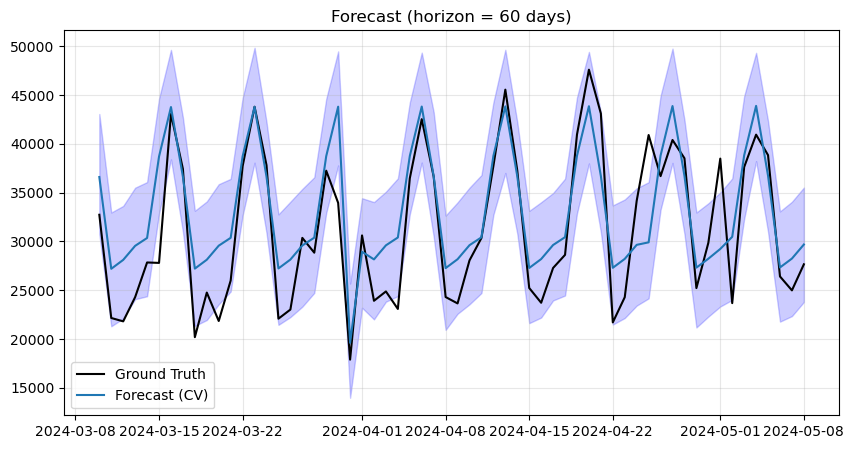


Test set metrics:
RMSE = 4362.89
MAE  = 3455.36


C:\Users\andre\AppData\Local\Temp\ipykernel_37676\1743448199.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_final["pre_covid"] = (train_final["ds"] < cutoff_date)
C:\Users\andre\AppData\Local\Temp\ipykernel_37676\1743448199.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_final["post_covid"] = (train_final["ds"] >= cutoff_date)
11:36:25 - cmdstanpy - INFO - Chain [1] start processing
11:36:26 - cmdstanpy - INFO - Chain [1] done processing



Model components:


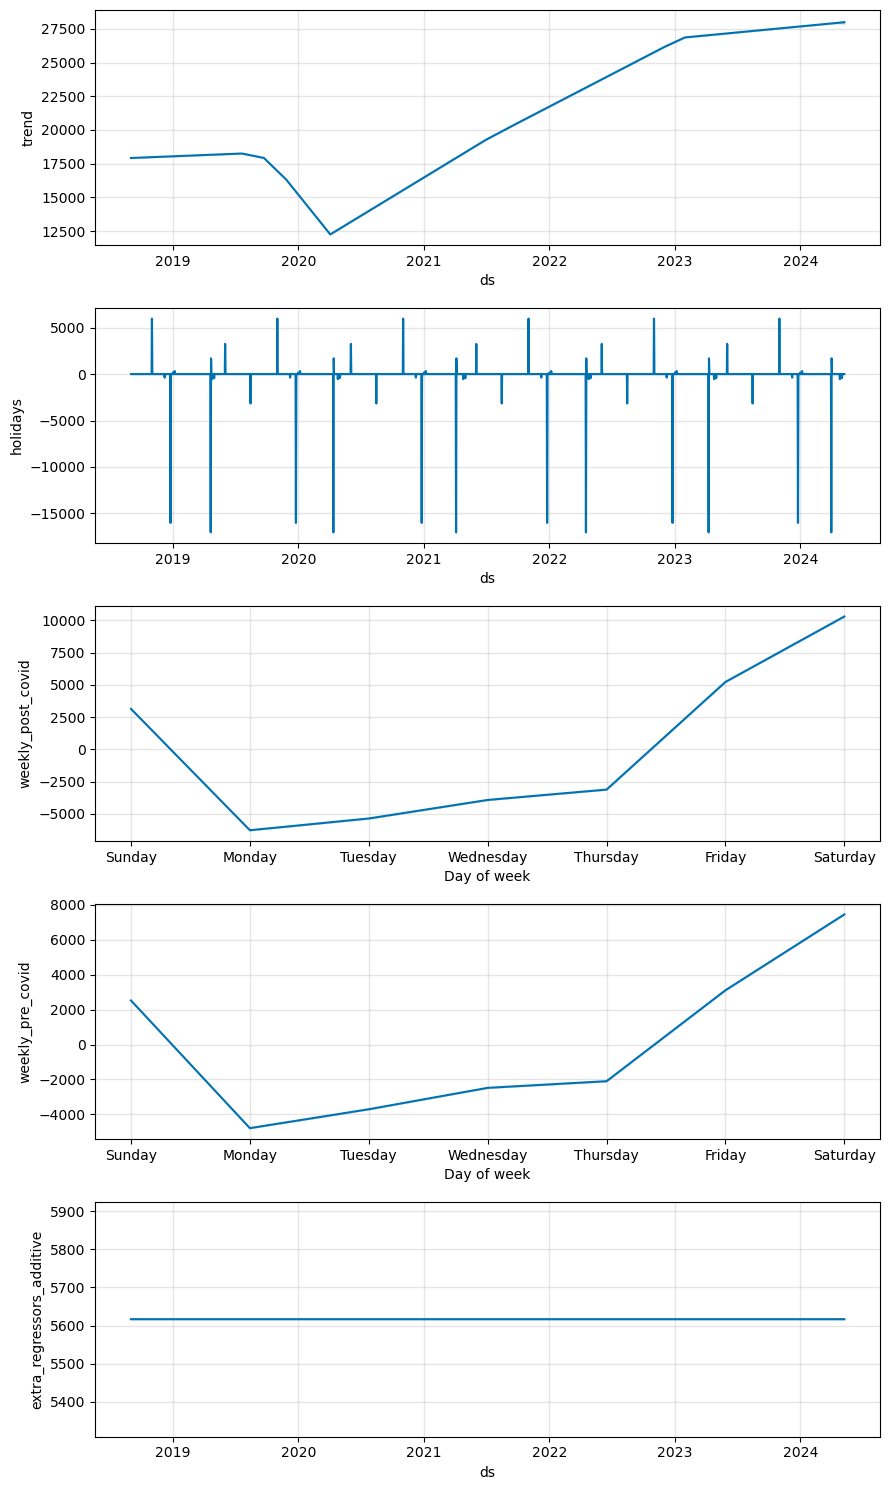

In [31]:
results = fit_prophet_model(
    df=df,
    y_col='totale',
    ds_col='data',
    regressors= covid_regr[1],
    n_test=60,
    weekly=False,
    monthly=False,
    yearly=False,
    weekly_prepost=True,
    holidays=True,
    verbose = True,
    return_results = True)

In [32]:
with open("models/prophet_model_totale_restaurant_4.json", "w") as f:
    f.write(model_to_json(results["model"]))

## GRID SEARCH ON DF5

<Axes: >

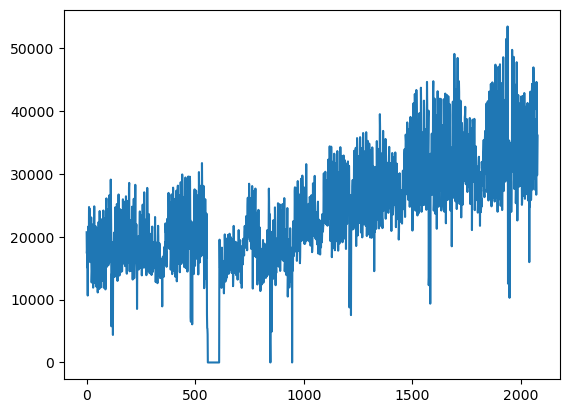

In [34]:
df = pd.read_csv('data/restaurant_5.csv')
df.totale.plot()

In [35]:
results = []

for (w, m, y, wp, h, covid) in param_grid:
    print(f"\n TTesting with: weekly={w}, monthly={m}, yearly={y}, prepost={wp}, holidays={h}, covid={covid is not None}")
    
    
        # Fit Prophet
    res = fit_prophet_model(
            df=df,
            y_col="totale",
            ds_col="data",
            n_test=60,
            weekly=w,
            monthly=m,
            yearly=y,
            weekly_prepost=wp,
            holidays=h,
            regressors=covid,
            verbose=False,
            return_results=True
    )

        
    metrics_last = res["metrics_last_window"]
    cv_metrics = res["metrics_cv"]
    rmse_cv_mean = cv_metrics["rmse"].mean()
    mae_cv_mean = cv_metrics["mae"].mean()
      
    results.append({
            "weekly": w,
            "monthly": m,
            "yearly": y,
            "weekly_prepost": wp,
            "holidays": h,
            "covid_regressors": covid,
            "RMSE_last": metrics_last["RMSE"],
            "MAE_last": metrics_last["MAE"],
            "RMSE_cv_mean": rmse_cv_mean,
            "MAE_cv_mean": mae_cv_mean
    })

df_results = pd.DataFrame(results)
df_results = df_results.sort_values("RMSE_cv_mean", ascending=True).reset_index(drop=True)
df_results.to_csv("prophet_gridsearch_results_restaurant_5.csv", index=False)


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=True, covid=False


12:26:16 - cmdstanpy - INFO - Chain [1] start processing
12:26:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:26:17 - cmdstanpy - INFO - Chain [1] start processing
12:26:17 - cmdstanpy - INFO - Chain [1] done processing
12:26:17 - cmdstanpy - INFO - Chain [1] start processing
12:26:18 - cmdstanpy - INFO - Chain [1] done processing
12:26:18 - cmdstanpy - INFO - Chain [1] start processing
12:26:18 - cmdstanpy - INFO - Chain [1] done processing
12:26:18 - cmdstanpy - INFO - Chain [1] start processing
12:26:18 - cmdstanpy - INFO - Chain [1] done processing
12:26:19 - cmdstanpy - INFO - Chain [1] start processing
12:26:19 - cmdstanpy - INFO - Chain [1] done processing
12:26:19 - cmdstanpy - INFO - Chain [1] start processing
12:26:20 - cmdstanpy - INFO - Chain [1] done processing
12:26:20 - cmdstanpy - INFO - Chain [1] start processing
12:26:20 - cmdstanpy - INFO - Chain [1] done processing
12:26:21 - cmdstanpy - INFO - Chain [1] start processing
12:26:21 - cmdstanpy - INFO - Chain [1] done processing
12:26:21 - cmdstanpy - INFO - Chain [1] start processing
12:26:22 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


12:26:35 - cmdstanpy - INFO - Chain [1] start processing
12:26:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:26:36 - cmdstanpy - INFO - Chain [1] start processing
12:26:36 - cmdstanpy - INFO - Chain [1] done processing
12:26:37 - cmdstanpy - INFO - Chain [1] start processing
12:26:37 - cmdstanpy - INFO - Chain [1] done processing
12:26:37 - cmdstanpy - INFO - Chain [1] start processing
12:26:37 - cmdstanpy - INFO - Chain [1] done processing
12:26:38 - cmdstanpy - INFO - Chain [1] start processing
12:26:38 - cmdstanpy - INFO - Chain [1] done processing
12:26:38 - cmdstanpy - INFO - Chain [1] start processing
12:26:39 - cmdstanpy - INFO - Chain [1] done processing
12:26:39 - cmdstanpy - INFO - Chain [1] start processing
12:26:39 - cmdstanpy - INFO - Chain [1] done processing
12:26:40 - cmdstanpy - INFO - Chain [1] start processing
12:26:40 - cmdstanpy - INFO - Chain [1] done processing
12:26:41 - cmdstanpy - INFO - Chain [1] start processing
12:26:41 - cmdstanpy - INFO - Chain [1] done processing
12:26:41 - cmdstanpy - INFO - Chain [1] start processing
12:26:42 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


12:27:01 - cmdstanpy - INFO - Chain [1] start processing
12:27:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:27:03 - cmdstanpy - INFO - Chain [1] start processing
12:27:03 - cmdstanpy - INFO - Chain [1] done processing
12:27:04 - cmdstanpy - INFO - Chain [1] start processing
12:27:05 - cmdstanpy - INFO - Chain [1] done processing
12:27:06 - cmdstanpy - INFO - Chain [1] start processing
12:27:06 - cmdstanpy - INFO - Chain [1] done processing
12:27:07 - cmdstanpy - INFO - Chain [1] start processing
12:27:08 - cmdstanpy - INFO - Chain [1] done processing
12:27:09 - cmdstanpy - INFO - Chain [1] start processing
12:27:10 - cmdstanpy - INFO - Chain [1] done processing
12:27:11 - cmdstanpy - INFO - Chain [1] start processing
12:27:11 - cmdstanpy - INFO - Chain [1] done processing
12:27:12 - cmdstanpy - INFO - Chain [1] start processing
12:27:13 - cmdstanpy - INFO - Chain [1] done processing
12:27:14 - cmdstanpy - INFO - Chain [1] start processing
12:27:14 - cmdstanpy - INFO - Chain [1] done processing
12:27:16 - cmdstanpy - INFO - Chain [1] start processing
12:27:16 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=False, covid=False


12:27:53 - cmdstanpy - INFO - Chain [1] start processing
12:27:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:27:56 - cmdstanpy - INFO - Chain [1] start processing
12:27:56 - cmdstanpy - INFO - Chain [1] done processing
12:27:57 - cmdstanpy - INFO - Chain [1] start processing
12:27:57 - cmdstanpy - INFO - Chain [1] done processing
12:27:58 - cmdstanpy - INFO - Chain [1] start processing
12:27:58 - cmdstanpy - INFO - Chain [1] done processing
12:27:59 - cmdstanpy - INFO - Chain [1] start processing
12:27:59 - cmdstanpy - INFO - Chain [1] done processing
12:28:00 - cmdstanpy - INFO - Chain [1] start processing
12:28:01 - cmdstanpy - INFO - Chain [1] done processing
12:28:02 - cmdstanpy - INFO - Chain [1] start processing
12:28:02 - cmdstanpy - INFO - Chain [1] done processing
12:28:03 - cmdstanpy - INFO - Chain [1] start processing
12:28:03 - cmdstanpy - INFO - Chain [1] done processing
12:28:04 - cmdstanpy - INFO - Chain [1] start processing
12:28:05 - cmdstanpy - INFO - Chain [1] done processing
12:28:06 - cmdstanpy - INFO - Chain [1] start processing
12:28:07 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


12:28:36 - cmdstanpy - INFO - Chain [1] start processing
12:28:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:28:38 - cmdstanpy - INFO - Chain [1] start processing
12:28:38 - cmdstanpy - INFO - Chain [1] done processing
12:28:38 - cmdstanpy - INFO - Chain [1] start processing
12:28:39 - cmdstanpy - INFO - Chain [1] done processing
12:28:40 - cmdstanpy - INFO - Chain [1] start processing
12:28:40 - cmdstanpy - INFO - Chain [1] done processing
12:28:41 - cmdstanpy - INFO - Chain [1] start processing
12:28:41 - cmdstanpy - INFO - Chain [1] done processing
12:28:42 - cmdstanpy - INFO - Chain [1] start processing
12:28:43 - cmdstanpy - INFO - Chain [1] done processing
12:28:44 - cmdstanpy - INFO - Chain [1] start processing
12:28:44 - cmdstanpy - INFO - Chain [1] done processing
12:28:45 - cmdstanpy - INFO - Chain [1] start processing
12:28:46 - cmdstanpy - INFO - Chain [1] done processing
12:28:47 - cmdstanpy - INFO - Chain [1] start processing
12:28:47 - cmdstanpy - INFO - Chain [1] done processing
12:28:48 - cmdstanpy - INFO - Chain [1] start processing
12:28:48 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


12:29:24 - cmdstanpy - INFO - Chain [1] start processing
12:29:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:29:26 - cmdstanpy - INFO - Chain [1] start processing
12:29:27 - cmdstanpy - INFO - Chain [1] done processing
12:29:27 - cmdstanpy - INFO - Chain [1] start processing
12:29:28 - cmdstanpy - INFO - Chain [1] done processing
12:29:29 - cmdstanpy - INFO - Chain [1] start processing
12:29:29 - cmdstanpy - INFO - Chain [1] done processing
12:29:30 - cmdstanpy - INFO - Chain [1] start processing
12:29:30 - cmdstanpy - INFO - Chain [1] done processing
12:29:31 - cmdstanpy - INFO - Chain [1] start processing
12:29:32 - cmdstanpy - INFO - Chain [1] done processing
12:29:33 - cmdstanpy - INFO - Chain [1] start processing
12:29:33 - cmdstanpy - INFO - Chain [1] done processing
12:29:34 - cmdstanpy - INFO - Chain [1] start processing
12:29:35 - cmdstanpy - INFO - Chain [1] done processing
12:29:35 - cmdstanpy - INFO - Chain [1] start processing
12:29:36 - cmdstanpy - INFO - Chain [1] done processing
12:29:37 - cmdstanpy - INFO - Chain [1] start processing
12:29:38 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=True, covid=False


12:30:11 - cmdstanpy - INFO - Chain [1] start processing
12:30:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:30:12 - cmdstanpy - INFO - Chain [1] start processing
12:30:12 - cmdstanpy - INFO - Chain [1] done processing
12:30:13 - cmdstanpy - INFO - Chain [1] start processing
12:30:14 - cmdstanpy - INFO - Chain [1] done processing
12:30:15 - cmdstanpy - INFO - Chain [1] start processing
12:30:15 - cmdstanpy - INFO - Chain [1] done processing
12:30:16 - cmdstanpy - INFO - Chain [1] start processing
12:30:16 - cmdstanpy - INFO - Chain [1] done processing
12:30:17 - cmdstanpy - INFO - Chain [1] start processing
12:30:18 - cmdstanpy - INFO - Chain [1] done processing
12:30:19 - cmdstanpy - INFO - Chain [1] start processing
12:30:19 - cmdstanpy - INFO - Chain [1] done processing
12:30:20 - cmdstanpy - INFO - Chain [1] start processing
12:30:21 - cmdstanpy - INFO - Chain [1] done processing
12:30:22 - cmdstanpy - INFO - Chain [1] start processing
12:30:23 - cmdstanpy - INFO - Chain [1] done processing
12:30:24 - cmdstanpy - INFO - Chain [1] start processing
12:30:24 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


12:30:58 - cmdstanpy - INFO - Chain [1] start processing
12:30:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:31:00 - cmdstanpy - INFO - Chain [1] start processing
12:31:00 - cmdstanpy - INFO - Chain [1] done processing
12:31:01 - cmdstanpy - INFO - Chain [1] start processing
12:31:01 - cmdstanpy - INFO - Chain [1] done processing
12:31:02 - cmdstanpy - INFO - Chain [1] start processing
12:31:03 - cmdstanpy - INFO - Chain [1] done processing
12:31:04 - cmdstanpy - INFO - Chain [1] start processing
12:31:04 - cmdstanpy - INFO - Chain [1] done processing
12:31:05 - cmdstanpy - INFO - Chain [1] start processing
12:31:05 - cmdstanpy - INFO - Chain [1] done processing
12:31:07 - cmdstanpy - INFO - Chain [1] start processing
12:31:07 - cmdstanpy - INFO - Chain [1] done processing
12:31:08 - cmdstanpy - INFO - Chain [1] start processing
12:31:09 - cmdstanpy - INFO - Chain [1] done processing
12:31:10 - cmdstanpy - INFO - Chain [1] start processing
12:31:11 - cmdstanpy - INFO - Chain [1] done processing
12:31:12 - cmdstanpy - INFO - Chain [1] start processing
12:31:13 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


12:31:49 - cmdstanpy - INFO - Chain [1] start processing
12:31:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:31:51 - cmdstanpy - INFO - Chain [1] start processing
12:31:52 - cmdstanpy - INFO - Chain [1] done processing
12:31:53 - cmdstanpy - INFO - Chain [1] start processing
12:31:53 - cmdstanpy - INFO - Chain [1] done processing
12:31:54 - cmdstanpy - INFO - Chain [1] start processing
12:31:54 - cmdstanpy - INFO - Chain [1] done processing
12:31:56 - cmdstanpy - INFO - Chain [1] start processing
12:31:56 - cmdstanpy - INFO - Chain [1] done processing
12:31:57 - cmdstanpy - INFO - Chain [1] start processing
12:31:58 - cmdstanpy - INFO - Chain [1] done processing
12:31:59 - cmdstanpy - INFO - Chain [1] start processing
12:31:59 - cmdstanpy - INFO - Chain [1] done processing
12:32:00 - cmdstanpy - INFO - Chain [1] start processing
12:32:01 - cmdstanpy - INFO - Chain [1] done processing
12:32:02 - cmdstanpy - INFO - Chain [1] start processing
12:32:03 - cmdstanpy - INFO - Chain [1] done processing
12:32:04 - cmdstanpy - INFO - Chain [1] start processing
12:32:04 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=False, covid=False


12:32:40 - cmdstanpy - INFO - Chain [1] start processing
12:32:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:32:42 - cmdstanpy - INFO - Chain [1] start processing
12:32:42 - cmdstanpy - INFO - Chain [1] done processing
12:32:43 - cmdstanpy - INFO - Chain [1] start processing
12:32:43 - cmdstanpy - INFO - Chain [1] done processing
12:32:44 - cmdstanpy - INFO - Chain [1] start processing
12:32:45 - cmdstanpy - INFO - Chain [1] done processing
12:32:46 - cmdstanpy - INFO - Chain [1] start processing
12:32:46 - cmdstanpy - INFO - Chain [1] done processing
12:32:47 - cmdstanpy - INFO - Chain [1] start processing
12:32:47 - cmdstanpy - INFO - Chain [1] done processing
12:32:48 - cmdstanpy - INFO - Chain [1] start processing
12:32:48 - cmdstanpy - INFO - Chain [1] done processing
12:32:49 - cmdstanpy - INFO - Chain [1] start processing
12:32:49 - cmdstanpy - INFO - Chain [1] done processing
12:32:50 - cmdstanpy - INFO - Chain [1] start processing
12:32:51 - cmdstanpy - INFO - Chain [1] done processing
12:32:52 - cmdstanpy - INFO - Chain [1] start processing
12:32:52 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


12:33:20 - cmdstanpy - INFO - Chain [1] start processing
12:33:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:33:21 - cmdstanpy - INFO - Chain [1] start processing
12:33:22 - cmdstanpy - INFO - Chain [1] done processing
12:33:22 - cmdstanpy - INFO - Chain [1] start processing
12:33:23 - cmdstanpy - INFO - Chain [1] done processing
12:33:23 - cmdstanpy - INFO - Chain [1] start processing
12:33:24 - cmdstanpy - INFO - Chain [1] done processing
12:33:25 - cmdstanpy - INFO - Chain [1] start processing
12:33:25 - cmdstanpy - INFO - Chain [1] done processing
12:33:26 - cmdstanpy - INFO - Chain [1] start processing
12:33:26 - cmdstanpy - INFO - Chain [1] done processing
12:33:27 - cmdstanpy - INFO - Chain [1] start processing
12:33:27 - cmdstanpy - INFO - Chain [1] done processing
12:33:28 - cmdstanpy - INFO - Chain [1] start processing
12:33:29 - cmdstanpy - INFO - Chain [1] done processing
12:33:30 - cmdstanpy - INFO - Chain [1] start processing
12:33:31 - cmdstanpy - INFO - Chain [1] done processing
12:33:32 - cmdstanpy - INFO - Chain [1] start processing
12:33:32 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


12:34:01 - cmdstanpy - INFO - Chain [1] start processing
12:34:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:34:03 - cmdstanpy - INFO - Chain [1] start processing
12:34:03 - cmdstanpy - INFO - Chain [1] done processing
12:34:04 - cmdstanpy - INFO - Chain [1] start processing
12:34:04 - cmdstanpy - INFO - Chain [1] done processing
12:34:05 - cmdstanpy - INFO - Chain [1] start processing
12:34:05 - cmdstanpy - INFO - Chain [1] done processing
12:34:06 - cmdstanpy - INFO - Chain [1] start processing
12:34:06 - cmdstanpy - INFO - Chain [1] done processing
12:34:07 - cmdstanpy - INFO - Chain [1] start processing
12:34:08 - cmdstanpy - INFO - Chain [1] done processing
12:34:09 - cmdstanpy - INFO - Chain [1] start processing
12:34:09 - cmdstanpy - INFO - Chain [1] done processing
12:34:10 - cmdstanpy - INFO - Chain [1] start processing
12:34:10 - cmdstanpy - INFO - Chain [1] done processing
12:34:11 - cmdstanpy - INFO - Chain [1] start processing
12:34:12 - cmdstanpy - INFO - Chain [1] done processing
12:34:12 - cmdstanpy - INFO - Chain [1] start processing
12:34:13 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=True, covid=False


12:34:43 - cmdstanpy - INFO - Chain [1] start processing
12:34:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:34:45 - cmdstanpy - INFO - Chain [1] start processing
12:34:45 - cmdstanpy - INFO - Chain [1] done processing
12:34:46 - cmdstanpy - INFO - Chain [1] start processing
12:34:46 - cmdstanpy - INFO - Chain [1] done processing
12:34:47 - cmdstanpy - INFO - Chain [1] start processing
12:34:48 - cmdstanpy - INFO - Chain [1] done processing
12:34:48 - cmdstanpy - INFO - Chain [1] start processing
12:34:49 - cmdstanpy - INFO - Chain [1] done processing
12:34:50 - cmdstanpy - INFO - Chain [1] start processing
12:34:50 - cmdstanpy - INFO - Chain [1] done processing
12:34:51 - cmdstanpy - INFO - Chain [1] start processing
12:34:52 - cmdstanpy - INFO - Chain [1] done processing
12:34:53 - cmdstanpy - INFO - Chain [1] start processing
12:34:53 - cmdstanpy - INFO - Chain [1] done processing
12:34:54 - cmdstanpy - INFO - Chain [1] start processing
12:34:55 - cmdstanpy - INFO - Chain [1] done processing
12:34:55 - cmdstanpy - INFO - Chain [1] start processing
12:34:56 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


12:35:23 - cmdstanpy - INFO - Chain [1] start processing
12:35:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:35:25 - cmdstanpy - INFO - Chain [1] start processing
12:35:25 - cmdstanpy - INFO - Chain [1] done processing
12:35:26 - cmdstanpy - INFO - Chain [1] start processing
12:35:27 - cmdstanpy - INFO - Chain [1] done processing
12:35:27 - cmdstanpy - INFO - Chain [1] start processing
12:35:28 - cmdstanpy - INFO - Chain [1] done processing
12:35:29 - cmdstanpy - INFO - Chain [1] start processing
12:35:29 - cmdstanpy - INFO - Chain [1] done processing
12:35:30 - cmdstanpy - INFO - Chain [1] start processing
12:35:30 - cmdstanpy - INFO - Chain [1] done processing
12:35:31 - cmdstanpy - INFO - Chain [1] start processing
12:35:32 - cmdstanpy - INFO - Chain [1] done processing
12:35:33 - cmdstanpy - INFO - Chain [1] start processing
12:35:33 - cmdstanpy - INFO - Chain [1] done processing
12:35:34 - cmdstanpy - INFO - Chain [1] start processing
12:35:35 - cmdstanpy - INFO - Chain [1] done processing
12:35:36 - cmdstanpy - INFO - Chain [1] start processing
12:35:36 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


12:36:06 - cmdstanpy - INFO - Chain [1] start processing
12:36:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:36:08 - cmdstanpy - INFO - Chain [1] start processing
12:36:08 - cmdstanpy - INFO - Chain [1] done processing
12:36:09 - cmdstanpy - INFO - Chain [1] start processing
12:36:09 - cmdstanpy - INFO - Chain [1] done processing
12:36:10 - cmdstanpy - INFO - Chain [1] start processing
12:36:10 - cmdstanpy - INFO - Chain [1] done processing
12:36:11 - cmdstanpy - INFO - Chain [1] start processing
12:36:11 - cmdstanpy - INFO - Chain [1] done processing
12:36:12 - cmdstanpy - INFO - Chain [1] start processing
12:36:13 - cmdstanpy - INFO - Chain [1] done processing
12:36:14 - cmdstanpy - INFO - Chain [1] start processing
12:36:14 - cmdstanpy - INFO - Chain [1] done processing
12:36:15 - cmdstanpy - INFO - Chain [1] start processing
12:36:16 - cmdstanpy - INFO - Chain [1] done processing
12:36:17 - cmdstanpy - INFO - Chain [1] start processing
12:36:17 - cmdstanpy - INFO - Chain [1] done processing
12:36:18 - cmdstanpy - INFO - Chain [1] start processing
12:36:19 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=False, covid=False


12:36:49 - cmdstanpy - INFO - Chain [1] start processing
12:36:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:36:50 - cmdstanpy - INFO - Chain [1] start processing
12:36:51 - cmdstanpy - INFO - Chain [1] done processing
12:36:51 - cmdstanpy - INFO - Chain [1] start processing
12:36:52 - cmdstanpy - INFO - Chain [1] done processing
12:36:52 - cmdstanpy - INFO - Chain [1] start processing
12:36:53 - cmdstanpy - INFO - Chain [1] done processing
12:36:53 - cmdstanpy - INFO - Chain [1] start processing
12:36:54 - cmdstanpy - INFO - Chain [1] done processing
12:36:55 - cmdstanpy - INFO - Chain [1] start processing
12:36:55 - cmdstanpy - INFO - Chain [1] done processing
12:36:56 - cmdstanpy - INFO - Chain [1] start processing
12:36:56 - cmdstanpy - INFO - Chain [1] done processing
12:36:57 - cmdstanpy - INFO - Chain [1] start processing
12:36:57 - cmdstanpy - INFO - Chain [1] done processing
12:36:58 - cmdstanpy - INFO - Chain [1] start processing
12:36:58 - cmdstanpy - INFO - Chain [1] done processing
12:36:59 - cmdstanpy - INFO - Chain [1] start processing
12:37:00 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


12:37:24 - cmdstanpy - INFO - Chain [1] start processing
12:37:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:37:26 - cmdstanpy - INFO - Chain [1] start processing
12:37:26 - cmdstanpy - INFO - Chain [1] done processing
12:37:27 - cmdstanpy - INFO - Chain [1] start processing
12:37:27 - cmdstanpy - INFO - Chain [1] done processing
12:37:28 - cmdstanpy - INFO - Chain [1] start processing
12:37:28 - cmdstanpy - INFO - Chain [1] done processing
12:37:29 - cmdstanpy - INFO - Chain [1] start processing
12:37:29 - cmdstanpy - INFO - Chain [1] done processing
12:37:30 - cmdstanpy - INFO - Chain [1] start processing
12:37:31 - cmdstanpy - INFO - Chain [1] done processing
12:37:31 - cmdstanpy - INFO - Chain [1] start processing
12:37:32 - cmdstanpy - INFO - Chain [1] done processing
12:37:32 - cmdstanpy - INFO - Chain [1] start processing
12:37:33 - cmdstanpy - INFO - Chain [1] done processing
12:37:34 - cmdstanpy - INFO - Chain [1] start processing
12:37:34 - cmdstanpy - INFO - Chain [1] done processing
12:37:35 - cmdstanpy - INFO - Chain [1] start processing
12:37:35 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


12:38:01 - cmdstanpy - INFO - Chain [1] start processing
12:38:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:38:02 - cmdstanpy - INFO - Chain [1] start processing
12:38:03 - cmdstanpy - INFO - Chain [1] done processing
12:38:03 - cmdstanpy - INFO - Chain [1] start processing
12:38:04 - cmdstanpy - INFO - Chain [1] done processing
12:38:04 - cmdstanpy - INFO - Chain [1] start processing
12:38:05 - cmdstanpy - INFO - Chain [1] done processing
12:38:05 - cmdstanpy - INFO - Chain [1] start processing
12:38:06 - cmdstanpy - INFO - Chain [1] done processing
12:38:07 - cmdstanpy - INFO - Chain [1] start processing
12:38:07 - cmdstanpy - INFO - Chain [1] done processing
12:38:08 - cmdstanpy - INFO - Chain [1] start processing
12:38:08 - cmdstanpy - INFO - Chain [1] done processing
12:38:09 - cmdstanpy - INFO - Chain [1] start processing
12:38:09 - cmdstanpy - INFO - Chain [1] done processing
12:38:10 - cmdstanpy - INFO - Chain [1] start processing
12:38:11 - cmdstanpy - INFO - Chain [1] done processing
12:38:11 - cmdstanpy - INFO - Chain [1] start processing
12:38:12 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=True, covid=False


12:38:38 - cmdstanpy - INFO - Chain [1] start processing
12:38:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:38:40 - cmdstanpy - INFO - Chain [1] start processing
12:38:40 - cmdstanpy - INFO - Chain [1] done processing
12:38:41 - cmdstanpy - INFO - Chain [1] start processing
12:38:41 - cmdstanpy - INFO - Chain [1] done processing
12:38:42 - cmdstanpy - INFO - Chain [1] start processing
12:38:42 - cmdstanpy - INFO - Chain [1] done processing
12:38:43 - cmdstanpy - INFO - Chain [1] start processing
12:38:43 - cmdstanpy - INFO - Chain [1] done processing
12:38:44 - cmdstanpy - INFO - Chain [1] start processing
12:38:44 - cmdstanpy - INFO - Chain [1] done processing
12:38:45 - cmdstanpy - INFO - Chain [1] start processing
12:38:46 - cmdstanpy - INFO - Chain [1] done processing
12:38:47 - cmdstanpy - INFO - Chain [1] start processing
12:38:47 - cmdstanpy - INFO - Chain [1] done processing
12:38:48 - cmdstanpy - INFO - Chain [1] start processing
12:38:48 - cmdstanpy - INFO - Chain [1] done processing
12:38:49 - cmdstanpy - INFO - Chain [1] start processing
12:38:49 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


12:39:18 - cmdstanpy - INFO - Chain [1] start processing
12:39:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:39:20 - cmdstanpy - INFO - Chain [1] start processing
12:39:20 - cmdstanpy - INFO - Chain [1] done processing
12:39:21 - cmdstanpy - INFO - Chain [1] start processing
12:39:21 - cmdstanpy - INFO - Chain [1] done processing
12:39:22 - cmdstanpy - INFO - Chain [1] start processing
12:39:22 - cmdstanpy - INFO - Chain [1] done processing
12:39:22 - cmdstanpy - INFO - Chain [1] start processing
12:39:23 - cmdstanpy - INFO - Chain [1] done processing
12:39:24 - cmdstanpy - INFO - Chain [1] start processing
12:39:24 - cmdstanpy - INFO - Chain [1] done processing
12:39:25 - cmdstanpy - INFO - Chain [1] start processing
12:39:25 - cmdstanpy - INFO - Chain [1] done processing
12:39:26 - cmdstanpy - INFO - Chain [1] start processing
12:39:27 - cmdstanpy - INFO - Chain [1] done processing
12:39:28 - cmdstanpy - INFO - Chain [1] start processing
12:39:28 - cmdstanpy - INFO - Chain [1] done processing
12:39:29 - cmdstanpy - INFO - Chain [1] start processing
12:39:30 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


12:40:00 - cmdstanpy - INFO - Chain [1] start processing
12:40:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:40:02 - cmdstanpy - INFO - Chain [1] start processing
12:40:02 - cmdstanpy - INFO - Chain [1] done processing
12:40:03 - cmdstanpy - INFO - Chain [1] start processing
12:40:04 - cmdstanpy - INFO - Chain [1] done processing
12:40:05 - cmdstanpy - INFO - Chain [1] start processing
12:40:05 - cmdstanpy - INFO - Chain [1] done processing
12:40:06 - cmdstanpy - INFO - Chain [1] start processing
12:40:06 - cmdstanpy - INFO - Chain [1] done processing
12:40:07 - cmdstanpy - INFO - Chain [1] start processing
12:40:07 - cmdstanpy - INFO - Chain [1] done processing
12:40:08 - cmdstanpy - INFO - Chain [1] start processing
12:40:09 - cmdstanpy - INFO - Chain [1] done processing
12:40:10 - cmdstanpy - INFO - Chain [1] start processing
12:40:10 - cmdstanpy - INFO - Chain [1] done processing
12:40:11 - cmdstanpy - INFO - Chain [1] start processing
12:40:11 - cmdstanpy - INFO - Chain [1] done processing
12:40:12 - cmdstanpy - INFO - Chain [1] start processing
12:40:13 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=False, covid=False


12:40:41 - cmdstanpy - INFO - Chain [1] start processing
12:40:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:40:43 - cmdstanpy - INFO - Chain [1] start processing
12:40:43 - cmdstanpy - INFO - Chain [1] done processing
12:40:44 - cmdstanpy - INFO - Chain [1] start processing
12:40:44 - cmdstanpy - INFO - Chain [1] done processing
12:40:45 - cmdstanpy - INFO - Chain [1] start processing
12:40:45 - cmdstanpy - INFO - Chain [1] done processing
12:40:46 - cmdstanpy - INFO - Chain [1] start processing
12:40:46 - cmdstanpy - INFO - Chain [1] done processing
12:40:47 - cmdstanpy - INFO - Chain [1] start processing
12:40:47 - cmdstanpy - INFO - Chain [1] done processing
12:40:48 - cmdstanpy - INFO - Chain [1] start processing
12:40:48 - cmdstanpy - INFO - Chain [1] done processing
12:40:49 - cmdstanpy - INFO - Chain [1] start processing
12:40:49 - cmdstanpy - INFO - Chain [1] done processing
12:40:50 - cmdstanpy - INFO - Chain [1] start processing
12:40:50 - cmdstanpy - INFO - Chain [1] done processing
12:40:51 - cmdstanpy - INFO - Chain [1] start processing
12:40:51 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


12:41:14 - cmdstanpy - INFO - Chain [1] start processing
12:41:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:41:15 - cmdstanpy - INFO - Chain [1] start processing
12:41:16 - cmdstanpy - INFO - Chain [1] done processing
12:41:16 - cmdstanpy - INFO - Chain [1] start processing
12:41:17 - cmdstanpy - INFO - Chain [1] done processing
12:41:17 - cmdstanpy - INFO - Chain [1] start processing
12:41:17 - cmdstanpy - INFO - Chain [1] done processing
12:41:18 - cmdstanpy - INFO - Chain [1] start processing
12:41:18 - cmdstanpy - INFO - Chain [1] done processing
12:41:19 - cmdstanpy - INFO - Chain [1] start processing
12:41:19 - cmdstanpy - INFO - Chain [1] done processing
12:41:20 - cmdstanpy - INFO - Chain [1] start processing
12:41:21 - cmdstanpy - INFO - Chain [1] done processing
12:41:21 - cmdstanpy - INFO - Chain [1] start processing
12:41:22 - cmdstanpy - INFO - Chain [1] done processing
12:41:22 - cmdstanpy - INFO - Chain [1] start processing
12:41:23 - cmdstanpy - INFO - Chain [1] done processing
12:41:24 - cmdstanpy - INFO - Chain [1] start processing
12:41:24 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


12:41:49 - cmdstanpy - INFO - Chain [1] start processing
12:41:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:41:50 - cmdstanpy - INFO - Chain [1] start processing
12:41:50 - cmdstanpy - INFO - Chain [1] done processing
12:41:51 - cmdstanpy - INFO - Chain [1] start processing
12:41:51 - cmdstanpy - INFO - Chain [1] done processing
12:41:52 - cmdstanpy - INFO - Chain [1] start processing
12:41:52 - cmdstanpy - INFO - Chain [1] done processing
12:41:53 - cmdstanpy - INFO - Chain [1] start processing
12:41:53 - cmdstanpy - INFO - Chain [1] done processing
12:41:54 - cmdstanpy - INFO - Chain [1] start processing
12:41:54 - cmdstanpy - INFO - Chain [1] done processing
12:41:55 - cmdstanpy - INFO - Chain [1] start processing
12:41:55 - cmdstanpy - INFO - Chain [1] done processing
12:41:56 - cmdstanpy - INFO - Chain [1] start processing
12:41:56 - cmdstanpy - INFO - Chain [1] done processing
12:41:57 - cmdstanpy - INFO - Chain [1] start processing
12:41:58 - cmdstanpy - INFO - Chain [1] done processing
12:41:58 - cmdstanpy - INFO - Chain [1] start processing
12:41:59 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=True, covid=False


12:42:23 - cmdstanpy - INFO - Chain [1] start processing
12:42:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:42:25 - cmdstanpy - INFO - Chain [1] start processing
12:42:25 - cmdstanpy - INFO - Chain [1] done processing
12:42:26 - cmdstanpy - INFO - Chain [1] start processing
12:42:26 - cmdstanpy - INFO - Chain [1] done processing
12:42:27 - cmdstanpy - INFO - Chain [1] start processing
12:42:27 - cmdstanpy - INFO - Chain [1] done processing
12:42:28 - cmdstanpy - INFO - Chain [1] start processing
12:42:28 - cmdstanpy - INFO - Chain [1] done processing
12:42:29 - cmdstanpy - INFO - Chain [1] start processing
12:42:30 - cmdstanpy - INFO - Chain [1] done processing
12:42:31 - cmdstanpy - INFO - Chain [1] start processing
12:42:31 - cmdstanpy - INFO - Chain [1] done processing
12:42:32 - cmdstanpy - INFO - Chain [1] start processing
12:42:33 - cmdstanpy - INFO - Chain [1] done processing
12:42:34 - cmdstanpy - INFO - Chain [1] start processing
12:42:34 - cmdstanpy - INFO - Chain [1] done processing
12:42:35 - cmdstanpy - INFO - Chain [1] start processing
12:42:36 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


12:43:03 - cmdstanpy - INFO - Chain [1] start processing
12:43:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:43:03 - cmdstanpy - INFO - Chain [1] start processing
12:43:04 - cmdstanpy - INFO - Chain [1] done processing
12:43:04 - cmdstanpy - INFO - Chain [1] start processing
12:43:04 - cmdstanpy - INFO - Chain [1] done processing
12:43:04 - cmdstanpy - INFO - Chain [1] start processing
12:43:05 - cmdstanpy - INFO - Chain [1] done processing
12:43:05 - cmdstanpy - INFO - Chain [1] start processing
12:43:05 - cmdstanpy - INFO - Chain [1] done processing
12:43:06 - cmdstanpy - INFO - Chain [1] start processing
12:43:06 - cmdstanpy - INFO - Chain [1] done processing
12:43:06 - cmdstanpy - INFO - Chain [1] start processing
12:43:06 - cmdstanpy - INFO - Chain [1] done processing
12:43:07 - cmdstanpy - INFO - Chain [1] start processing
12:43:07 - cmdstanpy - INFO - Chain [1] done processing
12:43:07 - cmdstanpy - INFO - Chain [1] start processing
12:43:08 - cmdstanpy - INFO - Chain [1] done processing
12:43:08 - cmdstanpy - INFO - Chain [1] start processing
12:43:08 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


12:43:22 - cmdstanpy - INFO - Chain [1] start processing
12:43:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:43:23 - cmdstanpy - INFO - Chain [1] start processing
12:43:23 - cmdstanpy - INFO - Chain [1] done processing
12:43:23 - cmdstanpy - INFO - Chain [1] start processing
12:43:23 - cmdstanpy - INFO - Chain [1] done processing
12:43:24 - cmdstanpy - INFO - Chain [1] start processing
12:43:24 - cmdstanpy - INFO - Chain [1] done processing
12:43:24 - cmdstanpy - INFO - Chain [1] start processing
12:43:24 - cmdstanpy - INFO - Chain [1] done processing
12:43:25 - cmdstanpy - INFO - Chain [1] start processing
12:43:25 - cmdstanpy - INFO - Chain [1] done processing
12:43:25 - cmdstanpy - INFO - Chain [1] start processing
12:43:26 - cmdstanpy - INFO - Chain [1] done processing
12:43:26 - cmdstanpy - INFO - Chain [1] start processing
12:43:26 - cmdstanpy - INFO - Chain [1] done processing
12:43:27 - cmdstanpy - INFO - Chain [1] start processing
12:43:27 - cmdstanpy - INFO - Chain [1] done processing
12:43:27 - cmdstanpy - INFO - Chain [1] start processing
12:43:28 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=False, covid=False


12:43:40 - cmdstanpy - INFO - Chain [1] start processing
12:43:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:43:40 - cmdstanpy - INFO - Chain [1] start processing
12:43:41 - cmdstanpy - INFO - Chain [1] done processing
12:43:41 - cmdstanpy - INFO - Chain [1] start processing
12:43:41 - cmdstanpy - INFO - Chain [1] done processing
12:43:41 - cmdstanpy - INFO - Chain [1] start processing
12:43:42 - cmdstanpy - INFO - Chain [1] done processing
12:43:42 - cmdstanpy - INFO - Chain [1] start processing
12:43:42 - cmdstanpy - INFO - Chain [1] done processing
12:43:42 - cmdstanpy - INFO - Chain [1] start processing
12:43:43 - cmdstanpy - INFO - Chain [1] done processing
12:43:43 - cmdstanpy - INFO - Chain [1] start processing
12:43:43 - cmdstanpy - INFO - Chain [1] done processing
12:43:43 - cmdstanpy - INFO - Chain [1] start processing
12:43:44 - cmdstanpy - INFO - Chain [1] done processing
12:43:44 - cmdstanpy - INFO - Chain [1] start processing
12:43:44 - cmdstanpy - INFO - Chain [1] done processing
12:43:45 - cmdstanpy - INFO - Chain [1] start processing
12:43:45 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


12:43:56 - cmdstanpy - INFO - Chain [1] start processing
12:43:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:43:57 - cmdstanpy - INFO - Chain [1] start processing
12:43:57 - cmdstanpy - INFO - Chain [1] done processing
12:43:57 - cmdstanpy - INFO - Chain [1] start processing
12:43:57 - cmdstanpy - INFO - Chain [1] done processing
12:43:58 - cmdstanpy - INFO - Chain [1] start processing
12:43:58 - cmdstanpy - INFO - Chain [1] done processing
12:43:58 - cmdstanpy - INFO - Chain [1] start processing
12:43:58 - cmdstanpy - INFO - Chain [1] done processing
12:43:59 - cmdstanpy - INFO - Chain [1] start processing
12:43:59 - cmdstanpy - INFO - Chain [1] done processing
12:43:59 - cmdstanpy - INFO - Chain [1] start processing
12:43:59 - cmdstanpy - INFO - Chain [1] done processing
12:44:00 - cmdstanpy - INFO - Chain [1] start processing
12:44:00 - cmdstanpy - INFO - Chain [1] done processing
12:44:00 - cmdstanpy - INFO - Chain [1] start processing
12:44:01 - cmdstanpy - INFO - Chain [1] done processing
12:44:01 - cmdstanpy - INFO - Chain [1] start processing
12:44:01 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


12:44:13 - cmdstanpy - INFO - Chain [1] start processing
12:44:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:44:14 - cmdstanpy - INFO - Chain [1] start processing
12:44:14 - cmdstanpy - INFO - Chain [1] done processing
12:44:14 - cmdstanpy - INFO - Chain [1] start processing
12:44:15 - cmdstanpy - INFO - Chain [1] done processing
12:44:15 - cmdstanpy - INFO - Chain [1] start processing
12:44:15 - cmdstanpy - INFO - Chain [1] done processing
12:44:15 - cmdstanpy - INFO - Chain [1] start processing
12:44:16 - cmdstanpy - INFO - Chain [1] done processing
12:44:16 - cmdstanpy - INFO - Chain [1] start processing
12:44:16 - cmdstanpy - INFO - Chain [1] done processing
12:44:16 - cmdstanpy - INFO - Chain [1] start processing
12:44:17 - cmdstanpy - INFO - Chain [1] done processing
12:44:17 - cmdstanpy - INFO - Chain [1] start processing
12:44:17 - cmdstanpy - INFO - Chain [1] done processing
12:44:17 - cmdstanpy - INFO - Chain [1] start processing
12:44:18 - cmdstanpy - INFO - Chain [1] done processing
12:44:18 - cmdstanpy - INFO - Chain [1] start processing
12:44:18 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=True, covid=False


12:44:34 - cmdstanpy - INFO - Chain [1] start processing
12:44:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:44:36 - cmdstanpy - INFO - Chain [1] start processing
12:44:37 - cmdstanpy - INFO - Chain [1] done processing
12:44:38 - cmdstanpy - INFO - Chain [1] start processing
12:44:38 - cmdstanpy - INFO - Chain [1] done processing
12:44:38 - cmdstanpy - INFO - Chain [1] start processing
12:44:39 - cmdstanpy - INFO - Chain [1] done processing
12:44:40 - cmdstanpy - INFO - Chain [1] start processing
12:44:40 - cmdstanpy - INFO - Chain [1] done processing
12:44:41 - cmdstanpy - INFO - Chain [1] start processing
12:44:41 - cmdstanpy - INFO - Chain [1] done processing
12:44:42 - cmdstanpy - INFO - Chain [1] start processing
12:44:43 - cmdstanpy - INFO - Chain [1] done processing
12:44:44 - cmdstanpy - INFO - Chain [1] start processing
12:44:44 - cmdstanpy - INFO - Chain [1] done processing
12:44:45 - cmdstanpy - INFO - Chain [1] start processing
12:44:46 - cmdstanpy - INFO - Chain [1] done processing
12:44:47 - cmdstanpy - INFO - Chain [1] start processing
12:44:47 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


12:45:19 - cmdstanpy - INFO - Chain [1] start processing
12:45:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:45:21 - cmdstanpy - INFO - Chain [1] start processing
12:45:22 - cmdstanpy - INFO - Chain [1] done processing
12:45:23 - cmdstanpy - INFO - Chain [1] start processing
12:45:23 - cmdstanpy - INFO - Chain [1] done processing
12:45:24 - cmdstanpy - INFO - Chain [1] start processing
12:45:24 - cmdstanpy - INFO - Chain [1] done processing
12:45:25 - cmdstanpy - INFO - Chain [1] start processing
12:45:26 - cmdstanpy - INFO - Chain [1] done processing
12:45:27 - cmdstanpy - INFO - Chain [1] start processing
12:45:27 - cmdstanpy - INFO - Chain [1] done processing
12:45:28 - cmdstanpy - INFO - Chain [1] start processing
12:45:28 - cmdstanpy - INFO - Chain [1] done processing
12:45:30 - cmdstanpy - INFO - Chain [1] start processing
12:45:30 - cmdstanpy - INFO - Chain [1] done processing
12:45:31 - cmdstanpy - INFO - Chain [1] start processing
12:45:32 - cmdstanpy - INFO - Chain [1] done processing
12:45:33 - cmdstanpy - INFO - Chain [1] start processing
12:45:33 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


12:46:06 - cmdstanpy - INFO - Chain [1] start processing
12:46:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:46:08 - cmdstanpy - INFO - Chain [1] start processing
12:46:09 - cmdstanpy - INFO - Chain [1] done processing
12:46:10 - cmdstanpy - INFO - Chain [1] start processing
12:46:10 - cmdstanpy - INFO - Chain [1] done processing
12:46:11 - cmdstanpy - INFO - Chain [1] start processing
12:46:11 - cmdstanpy - INFO - Chain [1] done processing
12:46:12 - cmdstanpy - INFO - Chain [1] start processing
12:46:13 - cmdstanpy - INFO - Chain [1] done processing
12:46:14 - cmdstanpy - INFO - Chain [1] start processing
12:46:14 - cmdstanpy - INFO - Chain [1] done processing
12:46:15 - cmdstanpy - INFO - Chain [1] start processing
12:46:16 - cmdstanpy - INFO - Chain [1] done processing
12:46:17 - cmdstanpy - INFO - Chain [1] start processing
12:46:17 - cmdstanpy - INFO - Chain [1] done processing
12:46:18 - cmdstanpy - INFO - Chain [1] start processing
12:46:19 - cmdstanpy - INFO - Chain [1] done processing
12:46:20 - cmdstanpy - INFO - Chain [1] start processing
12:46:21 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=False, covid=False


12:46:52 - cmdstanpy - INFO - Chain [1] start processing
12:46:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:46:54 - cmdstanpy - INFO - Chain [1] start processing
12:46:54 - cmdstanpy - INFO - Chain [1] done processing
12:46:55 - cmdstanpy - INFO - Chain [1] start processing
12:46:55 - cmdstanpy - INFO - Chain [1] done processing
12:46:56 - cmdstanpy - INFO - Chain [1] start processing
12:46:56 - cmdstanpy - INFO - Chain [1] done processing
12:46:57 - cmdstanpy - INFO - Chain [1] start processing
12:46:57 - cmdstanpy - INFO - Chain [1] done processing
12:46:58 - cmdstanpy - INFO - Chain [1] start processing
12:46:58 - cmdstanpy - INFO - Chain [1] done processing
12:46:59 - cmdstanpy - INFO - Chain [1] start processing
12:46:59 - cmdstanpy - INFO - Chain [1] done processing
12:47:00 - cmdstanpy - INFO - Chain [1] start processing
12:47:00 - cmdstanpy - INFO - Chain [1] done processing
12:47:01 - cmdstanpy - INFO - Chain [1] start processing
12:47:02 - cmdstanpy - INFO - Chain [1] done processing
12:47:02 - cmdstanpy - INFO - Chain [1] start processing
12:47:03 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


12:47:29 - cmdstanpy - INFO - Chain [1] start processing
12:47:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:47:30 - cmdstanpy - INFO - Chain [1] start processing
12:47:31 - cmdstanpy - INFO - Chain [1] done processing
12:47:32 - cmdstanpy - INFO - Chain [1] start processing
12:47:32 - cmdstanpy - INFO - Chain [1] done processing
12:47:33 - cmdstanpy - INFO - Chain [1] start processing
12:47:34 - cmdstanpy - INFO - Chain [1] done processing
12:47:34 - cmdstanpy - INFO - Chain [1] start processing
12:47:35 - cmdstanpy - INFO - Chain [1] done processing
12:47:35 - cmdstanpy - INFO - Chain [1] start processing
12:47:35 - cmdstanpy - INFO - Chain [1] done processing
12:47:36 - cmdstanpy - INFO - Chain [1] start processing
12:47:37 - cmdstanpy - INFO - Chain [1] done processing
12:47:38 - cmdstanpy - INFO - Chain [1] start processing
12:47:38 - cmdstanpy - INFO - Chain [1] done processing
12:47:39 - cmdstanpy - INFO - Chain [1] start processing
12:47:39 - cmdstanpy - INFO - Chain [1] done processing
12:47:40 - cmdstanpy - INFO - Chain [1] start processing
12:47:41 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


12:48:40 - cmdstanpy - INFO - Chain [1] start processing
12:48:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:48:42 - cmdstanpy - INFO - Chain [1] start processing
12:48:42 - cmdstanpy - INFO - Chain [1] done processing
12:48:43 - cmdstanpy - INFO - Chain [1] start processing
12:48:44 - cmdstanpy - INFO - Chain [1] done processing
12:48:44 - cmdstanpy - INFO - Chain [1] start processing
12:48:45 - cmdstanpy - INFO - Chain [1] done processing
12:48:46 - cmdstanpy - INFO - Chain [1] start processing
12:48:46 - cmdstanpy - INFO - Chain [1] done processing
12:48:47 - cmdstanpy - INFO - Chain [1] start processing
12:48:48 - cmdstanpy - INFO - Chain [1] done processing
12:48:48 - cmdstanpy - INFO - Chain [1] start processing
12:48:49 - cmdstanpy - INFO - Chain [1] done processing
12:48:50 - cmdstanpy - INFO - Chain [1] start processing
12:48:51 - cmdstanpy - INFO - Chain [1] done processing
12:48:51 - cmdstanpy - INFO - Chain [1] start processing
12:48:52 - cmdstanpy - INFO - Chain [1] done processing
12:48:53 - cmdstanpy - INFO - Chain [1] start processing
12:48:53 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=True, covid=False


12:49:20 - cmdstanpy - INFO - Chain [1] start processing
12:49:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:49:22 - cmdstanpy - INFO - Chain [1] start processing
12:49:22 - cmdstanpy - INFO - Chain [1] done processing
12:49:23 - cmdstanpy - INFO - Chain [1] start processing
12:49:23 - cmdstanpy - INFO - Chain [1] done processing
12:49:24 - cmdstanpy - INFO - Chain [1] start processing
12:49:24 - cmdstanpy - INFO - Chain [1] done processing
12:49:25 - cmdstanpy - INFO - Chain [1] start processing
12:49:25 - cmdstanpy - INFO - Chain [1] done processing
12:49:26 - cmdstanpy - INFO - Chain [1] start processing
12:49:27 - cmdstanpy - INFO - Chain [1] done processing
12:49:27 - cmdstanpy - INFO - Chain [1] start processing
12:49:28 - cmdstanpy - INFO - Chain [1] done processing
12:49:29 - cmdstanpy - INFO - Chain [1] start processing
12:49:29 - cmdstanpy - INFO - Chain [1] done processing
12:49:30 - cmdstanpy - INFO - Chain [1] start processing
12:49:30 - cmdstanpy - INFO - Chain [1] done processing
12:49:31 - cmdstanpy - INFO - Chain [1] start processing
12:49:32 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


12:49:57 - cmdstanpy - INFO - Chain [1] start processing
12:49:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:49:58 - cmdstanpy - INFO - Chain [1] start processing
12:49:58 - cmdstanpy - INFO - Chain [1] done processing
12:49:59 - cmdstanpy - INFO - Chain [1] start processing
12:50:00 - cmdstanpy - INFO - Chain [1] done processing
12:50:00 - cmdstanpy - INFO - Chain [1] start processing
12:50:01 - cmdstanpy - INFO - Chain [1] done processing
12:50:02 - cmdstanpy - INFO - Chain [1] start processing
12:50:02 - cmdstanpy - INFO - Chain [1] done processing
12:50:03 - cmdstanpy - INFO - Chain [1] start processing
12:50:04 - cmdstanpy - INFO - Chain [1] done processing
12:50:04 - cmdstanpy - INFO - Chain [1] start processing
12:50:05 - cmdstanpy - INFO - Chain [1] done processing
12:50:06 - cmdstanpy - INFO - Chain [1] start processing
12:50:06 - cmdstanpy - INFO - Chain [1] done processing
12:50:07 - cmdstanpy - INFO - Chain [1] start processing
12:50:08 - cmdstanpy - INFO - Chain [1] done processing
12:50:09 - cmdstanpy - INFO - Chain [1] start processing
12:50:09 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


12:50:38 - cmdstanpy - INFO - Chain [1] start processing
12:50:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:50:39 - cmdstanpy - INFO - Chain [1] start processing
12:50:40 - cmdstanpy - INFO - Chain [1] done processing
12:50:41 - cmdstanpy - INFO - Chain [1] start processing
12:50:41 - cmdstanpy - INFO - Chain [1] done processing
12:50:42 - cmdstanpy - INFO - Chain [1] start processing
12:50:42 - cmdstanpy - INFO - Chain [1] done processing
12:50:43 - cmdstanpy - INFO - Chain [1] start processing
12:50:43 - cmdstanpy - INFO - Chain [1] done processing
12:50:44 - cmdstanpy - INFO - Chain [1] start processing
12:50:45 - cmdstanpy - INFO - Chain [1] done processing
12:50:46 - cmdstanpy - INFO - Chain [1] start processing
12:50:46 - cmdstanpy - INFO - Chain [1] done processing
12:50:47 - cmdstanpy - INFO - Chain [1] start processing
12:50:48 - cmdstanpy - INFO - Chain [1] done processing
12:50:49 - cmdstanpy - INFO - Chain [1] start processing
12:50:49 - cmdstanpy - INFO - Chain [1] done processing
12:50:50 - cmdstanpy - INFO - Chain [1] start processing
12:50:50 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=False, covid=False


12:51:15 - cmdstanpy - INFO - Chain [1] start processing
12:51:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:51:17 - cmdstanpy - INFO - Chain [1] start processing
12:51:17 - cmdstanpy - INFO - Chain [1] done processing
12:51:18 - cmdstanpy - INFO - Chain [1] start processing
12:51:18 - cmdstanpy - INFO - Chain [1] done processing
12:51:18 - cmdstanpy - INFO - Chain [1] start processing
12:51:19 - cmdstanpy - INFO - Chain [1] done processing
12:51:19 - cmdstanpy - INFO - Chain [1] start processing
12:51:20 - cmdstanpy - INFO - Chain [1] done processing
12:51:20 - cmdstanpy - INFO - Chain [1] start processing
12:51:21 - cmdstanpy - INFO - Chain [1] done processing
12:51:21 - cmdstanpy - INFO - Chain [1] start processing
12:51:22 - cmdstanpy - INFO - Chain [1] done processing
12:51:22 - cmdstanpy - INFO - Chain [1] start processing
12:51:23 - cmdstanpy - INFO - Chain [1] done processing
12:51:23 - cmdstanpy - INFO - Chain [1] start processing
12:51:24 - cmdstanpy - INFO - Chain [1] done processing
12:51:24 - cmdstanpy - INFO - Chain [1] start processing
12:51:25 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


12:51:46 - cmdstanpy - INFO - Chain [1] start processing
12:51:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:51:47 - cmdstanpy - INFO - Chain [1] start processing
12:51:47 - cmdstanpy - INFO - Chain [1] done processing
12:51:48 - cmdstanpy - INFO - Chain [1] start processing
12:51:48 - cmdstanpy - INFO - Chain [1] done processing
12:51:49 - cmdstanpy - INFO - Chain [1] start processing
12:51:49 - cmdstanpy - INFO - Chain [1] done processing
12:51:50 - cmdstanpy - INFO - Chain [1] start processing
12:51:50 - cmdstanpy - INFO - Chain [1] done processing
12:51:51 - cmdstanpy - INFO - Chain [1] start processing
12:51:51 - cmdstanpy - INFO - Chain [1] done processing
12:51:52 - cmdstanpy - INFO - Chain [1] start processing
12:51:52 - cmdstanpy - INFO - Chain [1] done processing
12:51:53 - cmdstanpy - INFO - Chain [1] start processing
12:51:53 - cmdstanpy - INFO - Chain [1] done processing
12:51:54 - cmdstanpy - INFO - Chain [1] start processing
12:51:55 - cmdstanpy - INFO - Chain [1] done processing
12:51:55 - cmdstanpy - INFO - Chain [1] start processing
12:51:56 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


12:52:20 - cmdstanpy - INFO - Chain [1] start processing
12:52:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:52:22 - cmdstanpy - INFO - Chain [1] start processing
12:52:22 - cmdstanpy - INFO - Chain [1] done processing
12:52:23 - cmdstanpy - INFO - Chain [1] start processing
12:52:23 - cmdstanpy - INFO - Chain [1] done processing
12:52:24 - cmdstanpy - INFO - Chain [1] start processing
12:52:24 - cmdstanpy - INFO - Chain [1] done processing
12:52:25 - cmdstanpy - INFO - Chain [1] start processing
12:52:25 - cmdstanpy - INFO - Chain [1] done processing
12:52:26 - cmdstanpy - INFO - Chain [1] start processing
12:52:26 - cmdstanpy - INFO - Chain [1] done processing
12:52:27 - cmdstanpy - INFO - Chain [1] start processing
12:52:27 - cmdstanpy - INFO - Chain [1] done processing
12:52:28 - cmdstanpy - INFO - Chain [1] start processing
12:52:28 - cmdstanpy - INFO - Chain [1] done processing
12:52:29 - cmdstanpy - INFO - Chain [1] start processing
12:52:30 - cmdstanpy - INFO - Chain [1] done processing
12:52:30 - cmdstanpy - INFO - Chain [1] start processing
12:52:31 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=True, covid=False


12:52:54 - cmdstanpy - INFO - Chain [1] start processing
12:52:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:52:56 - cmdstanpy - INFO - Chain [1] start processing
12:52:57 - cmdstanpy - INFO - Chain [1] done processing
12:52:57 - cmdstanpy - INFO - Chain [1] start processing
12:52:58 - cmdstanpy - INFO - Chain [1] done processing
12:52:58 - cmdstanpy - INFO - Chain [1] start processing
12:52:59 - cmdstanpy - INFO - Chain [1] done processing
12:53:00 - cmdstanpy - INFO - Chain [1] start processing
12:53:00 - cmdstanpy - INFO - Chain [1] done processing
12:53:01 - cmdstanpy - INFO - Chain [1] start processing
12:53:01 - cmdstanpy - INFO - Chain [1] done processing
12:53:02 - cmdstanpy - INFO - Chain [1] start processing
12:53:02 - cmdstanpy - INFO - Chain [1] done processing
12:53:03 - cmdstanpy - INFO - Chain [1] start processing
12:53:04 - cmdstanpy - INFO - Chain [1] done processing
12:53:05 - cmdstanpy - INFO - Chain [1] start processing
12:53:05 - cmdstanpy - INFO - Chain [1] done processing
12:53:06 - cmdstanpy - INFO - Chain [1] start processing
12:53:06 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


12:53:30 - cmdstanpy - INFO - Chain [1] start processing
12:53:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:53:31 - cmdstanpy - INFO - Chain [1] start processing
12:53:32 - cmdstanpy - INFO - Chain [1] done processing
12:53:33 - cmdstanpy - INFO - Chain [1] start processing
12:53:33 - cmdstanpy - INFO - Chain [1] done processing
12:53:34 - cmdstanpy - INFO - Chain [1] start processing
12:53:34 - cmdstanpy - INFO - Chain [1] done processing
12:53:35 - cmdstanpy - INFO - Chain [1] start processing
12:53:35 - cmdstanpy - INFO - Chain [1] done processing
12:53:36 - cmdstanpy - INFO - Chain [1] start processing
12:53:36 - cmdstanpy - INFO - Chain [1] done processing
12:53:37 - cmdstanpy - INFO - Chain [1] start processing
12:53:37 - cmdstanpy - INFO - Chain [1] done processing
12:53:38 - cmdstanpy - INFO - Chain [1] start processing
12:53:38 - cmdstanpy - INFO - Chain [1] done processing
12:53:39 - cmdstanpy - INFO - Chain [1] start processing
12:53:40 - cmdstanpy - INFO - Chain [1] done processing
12:53:41 - cmdstanpy - INFO - Chain [1] start processing
12:53:41 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


12:54:06 - cmdstanpy - INFO - Chain [1] start processing
12:54:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:54:08 - cmdstanpy - INFO - Chain [1] start processing
12:54:08 - cmdstanpy - INFO - Chain [1] done processing
12:54:09 - cmdstanpy - INFO - Chain [1] start processing
12:54:09 - cmdstanpy - INFO - Chain [1] done processing
12:54:10 - cmdstanpy - INFO - Chain [1] start processing
12:54:10 - cmdstanpy - INFO - Chain [1] done processing
12:54:11 - cmdstanpy - INFO - Chain [1] start processing
12:54:11 - cmdstanpy - INFO - Chain [1] done processing
12:54:12 - cmdstanpy - INFO - Chain [1] start processing
12:54:12 - cmdstanpy - INFO - Chain [1] done processing
12:54:13 - cmdstanpy - INFO - Chain [1] start processing
12:54:14 - cmdstanpy - INFO - Chain [1] done processing
12:54:15 - cmdstanpy - INFO - Chain [1] start processing
12:54:15 - cmdstanpy - INFO - Chain [1] done processing
12:54:16 - cmdstanpy - INFO - Chain [1] start processing
12:54:16 - cmdstanpy - INFO - Chain [1] done processing
12:54:17 - cmdstanpy - INFO - Chain [1] start processing
12:54:18 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=False, covid=False


12:54:44 - cmdstanpy - INFO - Chain [1] start processing
12:54:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:54:45 - cmdstanpy - INFO - Chain [1] start processing
12:54:45 - cmdstanpy - INFO - Chain [1] done processing
12:54:46 - cmdstanpy - INFO - Chain [1] start processing
12:54:46 - cmdstanpy - INFO - Chain [1] done processing
12:54:47 - cmdstanpy - INFO - Chain [1] start processing
12:54:47 - cmdstanpy - INFO - Chain [1] done processing
12:54:48 - cmdstanpy - INFO - Chain [1] start processing
12:54:48 - cmdstanpy - INFO - Chain [1] done processing
12:54:48 - cmdstanpy - INFO - Chain [1] start processing
12:54:49 - cmdstanpy - INFO - Chain [1] done processing
12:54:49 - cmdstanpy - INFO - Chain [1] start processing
12:54:50 - cmdstanpy - INFO - Chain [1] done processing
12:54:50 - cmdstanpy - INFO - Chain [1] start processing
12:54:50 - cmdstanpy - INFO - Chain [1] done processing
12:54:51 - cmdstanpy - INFO - Chain [1] start processing
12:54:51 - cmdstanpy - INFO - Chain [1] done processing
12:54:52 - cmdstanpy - INFO - Chain [1] start processing
12:54:52 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


12:55:12 - cmdstanpy - INFO - Chain [1] start processing
12:55:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:55:13 - cmdstanpy - INFO - Chain [1] start processing
12:55:14 - cmdstanpy - INFO - Chain [1] done processing
12:55:14 - cmdstanpy - INFO - Chain [1] start processing
12:55:15 - cmdstanpy - INFO - Chain [1] done processing
12:55:15 - cmdstanpy - INFO - Chain [1] start processing
12:55:16 - cmdstanpy - INFO - Chain [1] done processing
12:55:17 - cmdstanpy - INFO - Chain [1] start processing
12:55:17 - cmdstanpy - INFO - Chain [1] done processing
12:55:17 - cmdstanpy - INFO - Chain [1] start processing
12:55:17 - cmdstanpy - INFO - Chain [1] done processing
12:55:18 - cmdstanpy - INFO - Chain [1] start processing
12:55:18 - cmdstanpy - INFO - Chain [1] done processing
12:55:18 - cmdstanpy - INFO - Chain [1] start processing
12:55:19 - cmdstanpy - INFO - Chain [1] done processing
12:55:19 - cmdstanpy - INFO - Chain [1] start processing
12:55:19 - cmdstanpy - INFO - Chain [1] done processing
12:55:20 - cmdstanpy - INFO - Chain [1] start processing
12:55:21 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


12:55:32 - cmdstanpy - INFO - Chain [1] start processing
12:55:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:55:33 - cmdstanpy - INFO - Chain [1] start processing
12:55:34 - cmdstanpy - INFO - Chain [1] done processing
12:55:34 - cmdstanpy - INFO - Chain [1] start processing
12:55:34 - cmdstanpy - INFO - Chain [1] done processing
12:55:35 - cmdstanpy - INFO - Chain [1] start processing
12:55:35 - cmdstanpy - INFO - Chain [1] done processing
12:55:36 - cmdstanpy - INFO - Chain [1] start processing
12:55:36 - cmdstanpy - INFO - Chain [1] done processing
12:55:37 - cmdstanpy - INFO - Chain [1] start processing
12:55:37 - cmdstanpy - INFO - Chain [1] done processing
12:55:38 - cmdstanpy - INFO - Chain [1] start processing
12:55:38 - cmdstanpy - INFO - Chain [1] done processing
12:55:39 - cmdstanpy - INFO - Chain [1] start processing
12:55:40 - cmdstanpy - INFO - Chain [1] done processing
12:55:40 - cmdstanpy - INFO - Chain [1] start processing
12:55:41 - cmdstanpy - INFO - Chain [1] done processing
12:55:41 - cmdstanpy - INFO - Chain [1] start processing
12:55:42 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=True, covid=False


12:56:04 - cmdstanpy - INFO - Chain [1] start processing
12:56:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:56:06 - cmdstanpy - INFO - Chain [1] start processing
12:56:06 - cmdstanpy - INFO - Chain [1] done processing
12:56:08 - cmdstanpy - INFO - Chain [1] start processing
12:56:08 - cmdstanpy - INFO - Chain [1] done processing
12:56:09 - cmdstanpy - INFO - Chain [1] start processing
12:56:09 - cmdstanpy - INFO - Chain [1] done processing
12:56:10 - cmdstanpy - INFO - Chain [1] start processing
12:56:11 - cmdstanpy - INFO - Chain [1] done processing
12:56:12 - cmdstanpy - INFO - Chain [1] start processing
12:56:12 - cmdstanpy - INFO - Chain [1] done processing
12:56:13 - cmdstanpy - INFO - Chain [1] start processing
12:56:14 - cmdstanpy - INFO - Chain [1] done processing
12:56:15 - cmdstanpy - INFO - Chain [1] start processing
12:56:15 - cmdstanpy - INFO - Chain [1] done processing
12:56:17 - cmdstanpy - INFO - Chain [1] start processing
12:56:17 - cmdstanpy - INFO - Chain [1] done processing
12:56:18 - cmdstanpy - INFO - Chain [1] start processing
12:56:19 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


12:56:53 - cmdstanpy - INFO - Chain [1] start processing
12:56:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:56:55 - cmdstanpy - INFO - Chain [1] start processing
12:56:55 - cmdstanpy - INFO - Chain [1] done processing
12:56:56 - cmdstanpy - INFO - Chain [1] start processing
12:56:57 - cmdstanpy - INFO - Chain [1] done processing
12:56:58 - cmdstanpy - INFO - Chain [1] start processing
12:56:58 - cmdstanpy - INFO - Chain [1] done processing
12:56:59 - cmdstanpy - INFO - Chain [1] start processing
12:57:00 - cmdstanpy - INFO - Chain [1] done processing
12:57:01 - cmdstanpy - INFO - Chain [1] start processing
12:57:01 - cmdstanpy - INFO - Chain [1] done processing
12:57:02 - cmdstanpy - INFO - Chain [1] start processing
12:57:03 - cmdstanpy - INFO - Chain [1] done processing
12:57:04 - cmdstanpy - INFO - Chain [1] start processing
12:57:04 - cmdstanpy - INFO - Chain [1] done processing
12:57:06 - cmdstanpy - INFO - Chain [1] start processing
12:57:07 - cmdstanpy - INFO - Chain [1] done processing
12:57:08 - cmdstanpy - INFO - Chain [1] start processing
12:57:09 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


12:57:46 - cmdstanpy - INFO - Chain [1] start processing
12:57:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:57:47 - cmdstanpy - INFO - Chain [1] start processing
12:57:48 - cmdstanpy - INFO - Chain [1] done processing
12:57:49 - cmdstanpy - INFO - Chain [1] start processing
12:57:49 - cmdstanpy - INFO - Chain [1] done processing
12:57:51 - cmdstanpy - INFO - Chain [1] start processing
12:57:51 - cmdstanpy - INFO - Chain [1] done processing
12:57:52 - cmdstanpy - INFO - Chain [1] start processing
12:57:53 - cmdstanpy - INFO - Chain [1] done processing
12:57:54 - cmdstanpy - INFO - Chain [1] start processing
12:57:54 - cmdstanpy - INFO - Chain [1] done processing
12:57:55 - cmdstanpy - INFO - Chain [1] start processing
12:57:56 - cmdstanpy - INFO - Chain [1] done processing
12:57:57 - cmdstanpy - INFO - Chain [1] start processing
12:57:58 - cmdstanpy - INFO - Chain [1] done processing
12:57:59 - cmdstanpy - INFO - Chain [1] start processing
12:58:00 - cmdstanpy - INFO - Chain [1] done processing
12:58:01 - cmdstanpy - INFO - Chain [1] start processing
12:58:01 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=False, covid=False


12:58:40 - cmdstanpy - INFO - Chain [1] start processing
12:58:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:58:42 - cmdstanpy - INFO - Chain [1] start processing
12:58:42 - cmdstanpy - INFO - Chain [1] done processing
12:58:43 - cmdstanpy - INFO - Chain [1] start processing
12:58:43 - cmdstanpy - INFO - Chain [1] done processing
12:58:44 - cmdstanpy - INFO - Chain [1] start processing
12:58:45 - cmdstanpy - INFO - Chain [1] done processing
12:58:46 - cmdstanpy - INFO - Chain [1] start processing
12:58:46 - cmdstanpy - INFO - Chain [1] done processing
12:58:47 - cmdstanpy - INFO - Chain [1] start processing
12:58:47 - cmdstanpy - INFO - Chain [1] done processing
12:58:48 - cmdstanpy - INFO - Chain [1] start processing
12:58:48 - cmdstanpy - INFO - Chain [1] done processing
12:58:49 - cmdstanpy - INFO - Chain [1] start processing
12:58:50 - cmdstanpy - INFO - Chain [1] done processing
12:58:51 - cmdstanpy - INFO - Chain [1] start processing
12:58:51 - cmdstanpy - INFO - Chain [1] done processing
12:58:52 - cmdstanpy - INFO - Chain [1] start processing
12:58:53 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


12:59:47 - cmdstanpy - INFO - Chain [1] start processing
12:59:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:59:49 - cmdstanpy - INFO - Chain [1] start processing
12:59:49 - cmdstanpy - INFO - Chain [1] done processing
12:59:50 - cmdstanpy - INFO - Chain [1] start processing
12:59:51 - cmdstanpy - INFO - Chain [1] done processing
12:59:52 - cmdstanpy - INFO - Chain [1] start processing
12:59:52 - cmdstanpy - INFO - Chain [1] done processing
12:59:53 - cmdstanpy - INFO - Chain [1] start processing
12:59:53 - cmdstanpy - INFO - Chain [1] done processing
12:59:54 - cmdstanpy - INFO - Chain [1] start processing
12:59:55 - cmdstanpy - INFO - Chain [1] done processing
12:59:56 - cmdstanpy - INFO - Chain [1] start processing
12:59:56 - cmdstanpy - INFO - Chain [1] done processing
12:59:58 - cmdstanpy - INFO - Chain [1] start processing
12:59:58 - cmdstanpy - INFO - Chain [1] done processing
13:00:00 - cmdstanpy - INFO - Chain [1] start processing
13:00:00 - cmdstanpy - INFO - Chain [1] done processing
13:00:01 - cmdstanpy - INFO - Chain [1] start processing
13:00:01 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


13:00:34 - cmdstanpy - INFO - Chain [1] start processing
13:00:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:00:37 - cmdstanpy - INFO - Chain [1] start processing
13:00:37 - cmdstanpy - INFO - Chain [1] done processing
13:00:38 - cmdstanpy - INFO - Chain [1] start processing
13:00:38 - cmdstanpy - INFO - Chain [1] done processing
13:00:39 - cmdstanpy - INFO - Chain [1] start processing
13:00:39 - cmdstanpy - INFO - Chain [1] done processing
13:00:39 - cmdstanpy - INFO - Chain [1] start processing
13:00:40 - cmdstanpy - INFO - Chain [1] done processing
13:00:41 - cmdstanpy - INFO - Chain [1] start processing
13:00:41 - cmdstanpy - INFO - Chain [1] done processing
13:00:42 - cmdstanpy - INFO - Chain [1] start processing
13:00:43 - cmdstanpy - INFO - Chain [1] done processing
13:00:44 - cmdstanpy - INFO - Chain [1] start processing
13:00:44 - cmdstanpy - INFO - Chain [1] done processing
13:00:45 - cmdstanpy - INFO - Chain [1] start processing
13:00:46 - cmdstanpy - INFO - Chain [1] done processing
13:00:47 - cmdstanpy - INFO - Chain [1] start processing
13:00:48 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=True, covid=False


13:01:20 - cmdstanpy - INFO - Chain [1] start processing
13:01:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:01:21 - cmdstanpy - INFO - Chain [1] start processing
13:01:22 - cmdstanpy - INFO - Chain [1] done processing
13:01:23 - cmdstanpy - INFO - Chain [1] start processing
13:01:23 - cmdstanpy - INFO - Chain [1] done processing
13:01:24 - cmdstanpy - INFO - Chain [1] start processing
13:01:24 - cmdstanpy - INFO - Chain [1] done processing
13:01:25 - cmdstanpy - INFO - Chain [1] start processing
13:01:25 - cmdstanpy - INFO - Chain [1] done processing
13:01:26 - cmdstanpy - INFO - Chain [1] start processing
13:01:27 - cmdstanpy - INFO - Chain [1] done processing
13:01:28 - cmdstanpy - INFO - Chain [1] start processing
13:01:28 - cmdstanpy - INFO - Chain [1] done processing
13:01:29 - cmdstanpy - INFO - Chain [1] start processing
13:01:29 - cmdstanpy - INFO - Chain [1] done processing
13:01:31 - cmdstanpy - INFO - Chain [1] start processing
13:01:31 - cmdstanpy - INFO - Chain [1] done processing
13:01:32 - cmdstanpy - INFO - Chain [1] start processing
13:01:33 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


13:02:02 - cmdstanpy - INFO - Chain [1] start processing
13:02:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:02:04 - cmdstanpy - INFO - Chain [1] start processing
13:02:04 - cmdstanpy - INFO - Chain [1] done processing
13:02:05 - cmdstanpy - INFO - Chain [1] start processing
13:02:05 - cmdstanpy - INFO - Chain [1] done processing
13:02:06 - cmdstanpy - INFO - Chain [1] start processing
13:02:07 - cmdstanpy - INFO - Chain [1] done processing
13:02:08 - cmdstanpy - INFO - Chain [1] start processing
13:02:08 - cmdstanpy - INFO - Chain [1] done processing
13:02:09 - cmdstanpy - INFO - Chain [1] start processing
13:02:09 - cmdstanpy - INFO - Chain [1] done processing
13:02:10 - cmdstanpy - INFO - Chain [1] start processing
13:02:11 - cmdstanpy - INFO - Chain [1] done processing
13:02:12 - cmdstanpy - INFO - Chain [1] start processing
13:02:13 - cmdstanpy - INFO - Chain [1] done processing
13:02:14 - cmdstanpy - INFO - Chain [1] start processing
13:02:14 - cmdstanpy - INFO - Chain [1] done processing
13:02:15 - cmdstanpy - INFO - Chain [1] start processing
13:02:16 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


13:02:46 - cmdstanpy - INFO - Chain [1] start processing
13:02:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:02:48 - cmdstanpy - INFO - Chain [1] start processing
13:02:48 - cmdstanpy - INFO - Chain [1] done processing
13:02:49 - cmdstanpy - INFO - Chain [1] start processing
13:02:49 - cmdstanpy - INFO - Chain [1] done processing
13:02:50 - cmdstanpy - INFO - Chain [1] start processing
13:02:51 - cmdstanpy - INFO - Chain [1] done processing
13:02:52 - cmdstanpy - INFO - Chain [1] start processing
13:02:52 - cmdstanpy - INFO - Chain [1] done processing
13:02:53 - cmdstanpy - INFO - Chain [1] start processing
13:02:54 - cmdstanpy - INFO - Chain [1] done processing
13:02:55 - cmdstanpy - INFO - Chain [1] start processing
13:02:55 - cmdstanpy - INFO - Chain [1] done processing
13:02:56 - cmdstanpy - INFO - Chain [1] start processing
13:02:56 - cmdstanpy - INFO - Chain [1] done processing
13:02:57 - cmdstanpy - INFO - Chain [1] start processing
13:02:58 - cmdstanpy - INFO - Chain [1] done processing
13:02:59 - cmdstanpy - INFO - Chain [1] start processing
13:03:00 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=False, covid=False


13:03:33 - cmdstanpy - INFO - Chain [1] start processing
13:03:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:03:35 - cmdstanpy - INFO - Chain [1] start processing
13:03:35 - cmdstanpy - INFO - Chain [1] done processing
13:03:36 - cmdstanpy - INFO - Chain [1] start processing
13:03:36 - cmdstanpy - INFO - Chain [1] done processing
13:03:37 - cmdstanpy - INFO - Chain [1] start processing
13:03:37 - cmdstanpy - INFO - Chain [1] done processing
13:03:38 - cmdstanpy - INFO - Chain [1] start processing
13:03:38 - cmdstanpy - INFO - Chain [1] done processing
13:03:39 - cmdstanpy - INFO - Chain [1] start processing
13:03:39 - cmdstanpy - INFO - Chain [1] done processing
13:03:40 - cmdstanpy - INFO - Chain [1] start processing
13:03:41 - cmdstanpy - INFO - Chain [1] done processing
13:03:42 - cmdstanpy - INFO - Chain [1] start processing
13:03:42 - cmdstanpy - INFO - Chain [1] done processing
13:03:43 - cmdstanpy - INFO - Chain [1] start processing
13:03:43 - cmdstanpy - INFO - Chain [1] done processing
13:03:44 - cmdstanpy - INFO - Chain [1] start processing
13:03:44 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


13:04:09 - cmdstanpy - INFO - Chain [1] start processing
13:04:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:04:11 - cmdstanpy - INFO - Chain [1] start processing
13:04:11 - cmdstanpy - INFO - Chain [1] done processing
13:04:12 - cmdstanpy - INFO - Chain [1] start processing
13:04:12 - cmdstanpy - INFO - Chain [1] done processing
13:04:13 - cmdstanpy - INFO - Chain [1] start processing
13:04:14 - cmdstanpy - INFO - Chain [1] done processing
13:04:14 - cmdstanpy - INFO - Chain [1] start processing
13:04:15 - cmdstanpy - INFO - Chain [1] done processing
13:04:16 - cmdstanpy - INFO - Chain [1] start processing
13:04:16 - cmdstanpy - INFO - Chain [1] done processing
13:04:17 - cmdstanpy - INFO - Chain [1] start processing
13:04:17 - cmdstanpy - INFO - Chain [1] done processing
13:04:18 - cmdstanpy - INFO - Chain [1] start processing
13:04:19 - cmdstanpy - INFO - Chain [1] done processing
13:04:20 - cmdstanpy - INFO - Chain [1] start processing
13:04:20 - cmdstanpy - INFO - Chain [1] done processing
13:04:21 - cmdstanpy - INFO - Chain [1] start processing
13:04:21 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


13:04:48 - cmdstanpy - INFO - Chain [1] start processing
13:04:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:04:50 - cmdstanpy - INFO - Chain [1] start processing
13:04:50 - cmdstanpy - INFO - Chain [1] done processing
13:04:51 - cmdstanpy - INFO - Chain [1] start processing
13:04:51 - cmdstanpy - INFO - Chain [1] done processing
13:04:52 - cmdstanpy - INFO - Chain [1] start processing
13:04:53 - cmdstanpy - INFO - Chain [1] done processing
13:04:53 - cmdstanpy - INFO - Chain [1] start processing
13:04:54 - cmdstanpy - INFO - Chain [1] done processing
13:04:55 - cmdstanpy - INFO - Chain [1] start processing
13:04:55 - cmdstanpy - INFO - Chain [1] done processing
13:04:56 - cmdstanpy - INFO - Chain [1] start processing
13:04:56 - cmdstanpy - INFO - Chain [1] done processing
13:04:57 - cmdstanpy - INFO - Chain [1] start processing
13:04:58 - cmdstanpy - INFO - Chain [1] done processing
13:04:59 - cmdstanpy - INFO - Chain [1] start processing
13:04:59 - cmdstanpy - INFO - Chain [1] done processing
13:05:00 - cmdstanpy - INFO - Chain [1] start processing
13:05:01 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=True, covid=False


13:05:27 - cmdstanpy - INFO - Chain [1] start processing
13:05:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:05:28 - cmdstanpy - INFO - Chain [1] start processing
13:05:29 - cmdstanpy - INFO - Chain [1] done processing
13:05:29 - cmdstanpy - INFO - Chain [1] start processing
13:05:30 - cmdstanpy - INFO - Chain [1] done processing
13:05:31 - cmdstanpy - INFO - Chain [1] start processing
13:05:31 - cmdstanpy - INFO - Chain [1] done processing
13:05:32 - cmdstanpy - INFO - Chain [1] start processing
13:05:33 - cmdstanpy - INFO - Chain [1] done processing
13:05:34 - cmdstanpy - INFO - Chain [1] start processing
13:05:34 - cmdstanpy - INFO - Chain [1] done processing
13:05:35 - cmdstanpy - INFO - Chain [1] start processing
13:05:36 - cmdstanpy - INFO - Chain [1] done processing
13:05:37 - cmdstanpy - INFO - Chain [1] start processing
13:05:37 - cmdstanpy - INFO - Chain [1] done processing
13:05:38 - cmdstanpy - INFO - Chain [1] start processing
13:05:38 - cmdstanpy - INFO - Chain [1] done processing
13:05:39 - cmdstanpy - INFO - Chain [1] start processing
13:05:40 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


13:06:07 - cmdstanpy - INFO - Chain [1] start processing
13:06:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:06:09 - cmdstanpy - INFO - Chain [1] start processing
13:06:09 - cmdstanpy - INFO - Chain [1] done processing
13:06:10 - cmdstanpy - INFO - Chain [1] start processing
13:06:10 - cmdstanpy - INFO - Chain [1] done processing
13:06:11 - cmdstanpy - INFO - Chain [1] start processing
13:06:12 - cmdstanpy - INFO - Chain [1] done processing
13:06:13 - cmdstanpy - INFO - Chain [1] start processing
13:06:13 - cmdstanpy - INFO - Chain [1] done processing
13:06:14 - cmdstanpy - INFO - Chain [1] start processing
13:06:14 - cmdstanpy - INFO - Chain [1] done processing
13:06:15 - cmdstanpy - INFO - Chain [1] start processing
13:06:16 - cmdstanpy - INFO - Chain [1] done processing
13:06:17 - cmdstanpy - INFO - Chain [1] start processing
13:06:17 - cmdstanpy - INFO - Chain [1] done processing
13:06:18 - cmdstanpy - INFO - Chain [1] start processing
13:06:19 - cmdstanpy - INFO - Chain [1] done processing
13:06:20 - cmdstanpy - INFO - Chain [1] start processing
13:06:20 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


13:06:50 - cmdstanpy - INFO - Chain [1] start processing
13:06:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:06:52 - cmdstanpy - INFO - Chain [1] start processing
13:06:52 - cmdstanpy - INFO - Chain [1] done processing
13:06:53 - cmdstanpy - INFO - Chain [1] start processing
13:06:53 - cmdstanpy - INFO - Chain [1] done processing
13:06:54 - cmdstanpy - INFO - Chain [1] start processing
13:06:55 - cmdstanpy - INFO - Chain [1] done processing
13:06:56 - cmdstanpy - INFO - Chain [1] start processing
13:06:56 - cmdstanpy - INFO - Chain [1] done processing
13:06:57 - cmdstanpy - INFO - Chain [1] start processing
13:06:57 - cmdstanpy - INFO - Chain [1] done processing
13:06:58 - cmdstanpy - INFO - Chain [1] start processing
13:06:59 - cmdstanpy - INFO - Chain [1] done processing
13:06:59 - cmdstanpy - INFO - Chain [1] start processing
13:07:00 - cmdstanpy - INFO - Chain [1] done processing
13:07:01 - cmdstanpy - INFO - Chain [1] start processing
13:07:01 - cmdstanpy - INFO - Chain [1] done processing
13:07:02 - cmdstanpy - INFO - Chain [1] start processing
13:07:03 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=False, covid=False


13:07:33 - cmdstanpy - INFO - Chain [1] start processing
13:07:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:07:34 - cmdstanpy - INFO - Chain [1] start processing
13:07:34 - cmdstanpy - INFO - Chain [1] done processing
13:07:35 - cmdstanpy - INFO - Chain [1] start processing
13:07:35 - cmdstanpy - INFO - Chain [1] done processing
13:07:36 - cmdstanpy - INFO - Chain [1] start processing
13:07:36 - cmdstanpy - INFO - Chain [1] done processing
13:07:37 - cmdstanpy - INFO - Chain [1] start processing
13:07:37 - cmdstanpy - INFO - Chain [1] done processing
13:07:38 - cmdstanpy - INFO - Chain [1] start processing
13:07:38 - cmdstanpy - INFO - Chain [1] done processing
13:07:39 - cmdstanpy - INFO - Chain [1] start processing
13:07:39 - cmdstanpy - INFO - Chain [1] done processing
13:07:40 - cmdstanpy - INFO - Chain [1] start processing
13:07:40 - cmdstanpy - INFO - Chain [1] done processing
13:07:41 - cmdstanpy - INFO - Chain [1] start processing
13:07:42 - cmdstanpy - INFO - Chain [1] done processing
13:07:42 - cmdstanpy - INFO - Chain [1] start processing
13:07:43 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


13:08:07 - cmdstanpy - INFO - Chain [1] start processing
13:08:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:08:09 - cmdstanpy - INFO - Chain [1] start processing
13:08:09 - cmdstanpy - INFO - Chain [1] done processing
13:08:10 - cmdstanpy - INFO - Chain [1] start processing
13:08:10 - cmdstanpy - INFO - Chain [1] done processing
13:08:11 - cmdstanpy - INFO - Chain [1] start processing
13:08:11 - cmdstanpy - INFO - Chain [1] done processing
13:08:12 - cmdstanpy - INFO - Chain [1] start processing
13:08:13 - cmdstanpy - INFO - Chain [1] done processing
13:08:14 - cmdstanpy - INFO - Chain [1] start processing
13:08:14 - cmdstanpy - INFO - Chain [1] done processing
13:08:15 - cmdstanpy - INFO - Chain [1] start processing
13:08:15 - cmdstanpy - INFO - Chain [1] done processing
13:08:16 - cmdstanpy - INFO - Chain [1] start processing
13:08:16 - cmdstanpy - INFO - Chain [1] done processing
13:08:17 - cmdstanpy - INFO - Chain [1] start processing
13:08:18 - cmdstanpy - INFO - Chain [1] done processing
13:08:19 - cmdstanpy - INFO - Chain [1] start processing
13:08:19 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


13:08:45 - cmdstanpy - INFO - Chain [1] start processing
13:08:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:08:46 - cmdstanpy - INFO - Chain [1] start processing
13:08:46 - cmdstanpy - INFO - Chain [1] done processing
13:08:47 - cmdstanpy - INFO - Chain [1] start processing
13:08:47 - cmdstanpy - INFO - Chain [1] done processing
13:08:48 - cmdstanpy - INFO - Chain [1] start processing
13:08:48 - cmdstanpy - INFO - Chain [1] done processing
13:08:49 - cmdstanpy - INFO - Chain [1] start processing
13:08:50 - cmdstanpy - INFO - Chain [1] done processing
13:08:51 - cmdstanpy - INFO - Chain [1] start processing
13:08:51 - cmdstanpy - INFO - Chain [1] done processing
13:08:52 - cmdstanpy - INFO - Chain [1] start processing
13:08:52 - cmdstanpy - INFO - Chain [1] done processing
13:08:53 - cmdstanpy - INFO - Chain [1] start processing
13:08:54 - cmdstanpy - INFO - Chain [1] done processing
13:08:54 - cmdstanpy - INFO - Chain [1] start processing
13:08:55 - cmdstanpy - INFO - Chain [1] done processing
13:08:56 - cmdstanpy - INFO - Chain [1] start processing
13:08:56 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=True, covid=False


13:09:26 - cmdstanpy - INFO - Chain [1] start processing
13:09:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:09:27 - cmdstanpy - INFO - Chain [1] start processing
13:09:28 - cmdstanpy - INFO - Chain [1] done processing
13:09:29 - cmdstanpy - INFO - Chain [1] start processing
13:09:29 - cmdstanpy - INFO - Chain [1] done processing
13:09:30 - cmdstanpy - INFO - Chain [1] start processing
13:09:30 - cmdstanpy - INFO - Chain [1] done processing
13:09:31 - cmdstanpy - INFO - Chain [1] start processing
13:09:32 - cmdstanpy - INFO - Chain [1] done processing
13:09:32 - cmdstanpy - INFO - Chain [1] start processing
13:09:33 - cmdstanpy - INFO - Chain [1] done processing
13:09:34 - cmdstanpy - INFO - Chain [1] start processing
13:09:34 - cmdstanpy - INFO - Chain [1] done processing
13:09:35 - cmdstanpy - INFO - Chain [1] start processing
13:09:35 - cmdstanpy - INFO - Chain [1] done processing
13:09:36 - cmdstanpy - INFO - Chain [1] start processing
13:09:36 - cmdstanpy - INFO - Chain [1] done processing
13:09:37 - cmdstanpy - INFO - Chain [1] start processing
13:09:38 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


13:10:03 - cmdstanpy - INFO - Chain [1] start processing
13:10:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:10:05 - cmdstanpy - INFO - Chain [1] start processing
13:10:05 - cmdstanpy - INFO - Chain [1] done processing
13:10:06 - cmdstanpy - INFO - Chain [1] start processing
13:10:06 - cmdstanpy - INFO - Chain [1] done processing
13:10:07 - cmdstanpy - INFO - Chain [1] start processing
13:10:07 - cmdstanpy - INFO - Chain [1] done processing
13:10:08 - cmdstanpy - INFO - Chain [1] start processing
13:10:09 - cmdstanpy - INFO - Chain [1] done processing
13:10:09 - cmdstanpy - INFO - Chain [1] start processing
13:10:10 - cmdstanpy - INFO - Chain [1] done processing
13:10:11 - cmdstanpy - INFO - Chain [1] start processing
13:10:11 - cmdstanpy - INFO - Chain [1] done processing
13:10:12 - cmdstanpy - INFO - Chain [1] start processing
13:10:12 - cmdstanpy - INFO - Chain [1] done processing
13:10:13 - cmdstanpy - INFO - Chain [1] start processing
13:10:14 - cmdstanpy - INFO - Chain [1] done processing
13:10:14 - cmdstanpy - INFO - Chain [1] start processing
13:10:15 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


13:10:41 - cmdstanpy - INFO - Chain [1] start processing
13:10:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:10:42 - cmdstanpy - INFO - Chain [1] start processing
13:10:42 - cmdstanpy - INFO - Chain [1] done processing
13:10:43 - cmdstanpy - INFO - Chain [1] start processing
13:10:43 - cmdstanpy - INFO - Chain [1] done processing
13:10:44 - cmdstanpy - INFO - Chain [1] start processing
13:10:45 - cmdstanpy - INFO - Chain [1] done processing
13:10:46 - cmdstanpy - INFO - Chain [1] start processing
13:10:46 - cmdstanpy - INFO - Chain [1] done processing
13:10:47 - cmdstanpy - INFO - Chain [1] start processing
13:10:47 - cmdstanpy - INFO - Chain [1] done processing
13:10:48 - cmdstanpy - INFO - Chain [1] start processing
13:10:48 - cmdstanpy - INFO - Chain [1] done processing
13:10:49 - cmdstanpy - INFO - Chain [1] start processing
13:10:49 - cmdstanpy - INFO - Chain [1] done processing
13:10:50 - cmdstanpy - INFO - Chain [1] start processing
13:10:50 - cmdstanpy - INFO - Chain [1] done processing
13:10:51 - cmdstanpy - INFO - Chain [1] start processing
13:10:52 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=False, covid=False


13:11:17 - cmdstanpy - INFO - Chain [1] start processing
13:11:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:11:19 - cmdstanpy - INFO - Chain [1] start processing
13:11:19 - cmdstanpy - INFO - Chain [1] done processing
13:11:20 - cmdstanpy - INFO - Chain [1] start processing
13:11:20 - cmdstanpy - INFO - Chain [1] done processing
13:11:21 - cmdstanpy - INFO - Chain [1] start processing
13:11:21 - cmdstanpy - INFO - Chain [1] done processing
13:11:22 - cmdstanpy - INFO - Chain [1] start processing
13:11:22 - cmdstanpy - INFO - Chain [1] done processing
13:11:22 - cmdstanpy - INFO - Chain [1] start processing
13:11:23 - cmdstanpy - INFO - Chain [1] done processing
13:11:23 - cmdstanpy - INFO - Chain [1] start processing
13:11:24 - cmdstanpy - INFO - Chain [1] done processing
13:11:24 - cmdstanpy - INFO - Chain [1] start processing
13:11:25 - cmdstanpy - INFO - Chain [1] done processing
13:11:25 - cmdstanpy - INFO - Chain [1] start processing
13:11:26 - cmdstanpy - INFO - Chain [1] done processing
13:11:26 - cmdstanpy - INFO - Chain [1] start processing
13:11:27 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


13:11:48 - cmdstanpy - INFO - Chain [1] start processing
13:11:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:11:49 - cmdstanpy - INFO - Chain [1] start processing
13:11:50 - cmdstanpy - INFO - Chain [1] done processing
13:11:50 - cmdstanpy - INFO - Chain [1] start processing
13:11:51 - cmdstanpy - INFO - Chain [1] done processing
13:11:51 - cmdstanpy - INFO - Chain [1] start processing
13:11:52 - cmdstanpy - INFO - Chain [1] done processing
13:11:52 - cmdstanpy - INFO - Chain [1] start processing
13:11:53 - cmdstanpy - INFO - Chain [1] done processing
13:11:53 - cmdstanpy - INFO - Chain [1] start processing
13:11:54 - cmdstanpy - INFO - Chain [1] done processing
13:11:54 - cmdstanpy - INFO - Chain [1] start processing
13:11:55 - cmdstanpy - INFO - Chain [1] done processing
13:11:55 - cmdstanpy - INFO - Chain [1] start processing
13:11:56 - cmdstanpy - INFO - Chain [1] done processing
13:11:56 - cmdstanpy - INFO - Chain [1] start processing
13:11:57 - cmdstanpy - INFO - Chain [1] done processing
13:11:57 - cmdstanpy - INFO - Chain [1] start processing
13:11:58 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


13:12:18 - cmdstanpy - INFO - Chain [1] start processing
13:12:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:12:20 - cmdstanpy - INFO - Chain [1] start processing
13:12:20 - cmdstanpy - INFO - Chain [1] done processing
13:12:21 - cmdstanpy - INFO - Chain [1] start processing
13:12:21 - cmdstanpy - INFO - Chain [1] done processing
13:12:22 - cmdstanpy - INFO - Chain [1] start processing
13:12:22 - cmdstanpy - INFO - Chain [1] done processing
13:12:22 - cmdstanpy - INFO - Chain [1] start processing
13:12:23 - cmdstanpy - INFO - Chain [1] done processing
13:12:23 - cmdstanpy - INFO - Chain [1] start processing
13:12:24 - cmdstanpy - INFO - Chain [1] done processing
13:12:25 - cmdstanpy - INFO - Chain [1] start processing
13:12:25 - cmdstanpy - INFO - Chain [1] done processing
13:12:26 - cmdstanpy - INFO - Chain [1] start processing
13:12:26 - cmdstanpy - INFO - Chain [1] done processing
13:12:27 - cmdstanpy - INFO - Chain [1] start processing
13:12:27 - cmdstanpy - INFO - Chain [1] done processing
13:12:28 - cmdstanpy - INFO - Chain [1] start processing
13:12:28 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=True, covid=False


13:12:49 - cmdstanpy - INFO - Chain [1] start processing
13:12:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:12:51 - cmdstanpy - INFO - Chain [1] start processing
13:12:52 - cmdstanpy - INFO - Chain [1] done processing
13:12:53 - cmdstanpy - INFO - Chain [1] start processing
13:12:53 - cmdstanpy - INFO - Chain [1] done processing
13:12:54 - cmdstanpy - INFO - Chain [1] start processing
13:12:54 - cmdstanpy - INFO - Chain [1] done processing
13:12:55 - cmdstanpy - INFO - Chain [1] start processing
13:12:56 - cmdstanpy - INFO - Chain [1] done processing
13:12:57 - cmdstanpy - INFO - Chain [1] start processing
13:12:57 - cmdstanpy - INFO - Chain [1] done processing
13:12:58 - cmdstanpy - INFO - Chain [1] start processing
13:12:58 - cmdstanpy - INFO - Chain [1] done processing
13:12:59 - cmdstanpy - INFO - Chain [1] start processing
13:13:00 - cmdstanpy - INFO - Chain [1] done processing
13:13:01 - cmdstanpy - INFO - Chain [1] start processing
13:13:01 - cmdstanpy - INFO - Chain [1] done processing
13:13:02 - cmdstanpy - INFO - Chain [1] start processing
13:13:03 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


13:13:36 - cmdstanpy - INFO - Chain [1] start processing
13:13:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:13:38 - cmdstanpy - INFO - Chain [1] start processing
13:13:39 - cmdstanpy - INFO - Chain [1] done processing
13:13:40 - cmdstanpy - INFO - Chain [1] start processing
13:13:40 - cmdstanpy - INFO - Chain [1] done processing
13:13:41 - cmdstanpy - INFO - Chain [1] start processing
13:13:41 - cmdstanpy - INFO - Chain [1] done processing
13:13:42 - cmdstanpy - INFO - Chain [1] start processing
13:13:43 - cmdstanpy - INFO - Chain [1] done processing
13:13:44 - cmdstanpy - INFO - Chain [1] start processing
13:13:44 - cmdstanpy - INFO - Chain [1] done processing
13:13:45 - cmdstanpy - INFO - Chain [1] start processing
13:13:46 - cmdstanpy - INFO - Chain [1] done processing
13:13:47 - cmdstanpy - INFO - Chain [1] start processing
13:13:47 - cmdstanpy - INFO - Chain [1] done processing
13:13:48 - cmdstanpy - INFO - Chain [1] start processing
13:13:49 - cmdstanpy - INFO - Chain [1] done processing
13:13:50 - cmdstanpy - INFO - Chain [1] start processing
13:13:51 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


13:14:25 - cmdstanpy - INFO - Chain [1] start processing
13:14:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:14:27 - cmdstanpy - INFO - Chain [1] start processing
13:14:28 - cmdstanpy - INFO - Chain [1] done processing
13:14:29 - cmdstanpy - INFO - Chain [1] start processing
13:14:29 - cmdstanpy - INFO - Chain [1] done processing
13:14:30 - cmdstanpy - INFO - Chain [1] start processing
13:14:30 - cmdstanpy - INFO - Chain [1] done processing
13:14:31 - cmdstanpy - INFO - Chain [1] start processing
13:14:32 - cmdstanpy - INFO - Chain [1] done processing
13:14:33 - cmdstanpy - INFO - Chain [1] start processing
13:14:33 - cmdstanpy - INFO - Chain [1] done processing
13:14:34 - cmdstanpy - INFO - Chain [1] start processing
13:14:35 - cmdstanpy - INFO - Chain [1] done processing
13:14:36 - cmdstanpy - INFO - Chain [1] start processing
13:14:37 - cmdstanpy - INFO - Chain [1] done processing
13:14:38 - cmdstanpy - INFO - Chain [1] start processing
13:14:38 - cmdstanpy - INFO - Chain [1] done processing
13:14:40 - cmdstanpy - INFO - Chain [1] start processing
13:14:41 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=False, covid=False


13:15:14 - cmdstanpy - INFO - Chain [1] start processing
13:15:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:15:16 - cmdstanpy - INFO - Chain [1] start processing
13:15:16 - cmdstanpy - INFO - Chain [1] done processing
13:15:17 - cmdstanpy - INFO - Chain [1] start processing
13:15:17 - cmdstanpy - INFO - Chain [1] done processing
13:15:18 - cmdstanpy - INFO - Chain [1] start processing
13:15:18 - cmdstanpy - INFO - Chain [1] done processing
13:15:19 - cmdstanpy - INFO - Chain [1] start processing
13:15:19 - cmdstanpy - INFO - Chain [1] done processing
13:15:20 - cmdstanpy - INFO - Chain [1] start processing
13:15:20 - cmdstanpy - INFO - Chain [1] done processing
13:15:21 - cmdstanpy - INFO - Chain [1] start processing
13:15:22 - cmdstanpy - INFO - Chain [1] done processing
13:15:23 - cmdstanpy - INFO - Chain [1] start processing
13:15:23 - cmdstanpy - INFO - Chain [1] done processing
13:15:24 - cmdstanpy - INFO - Chain [1] start processing
13:15:25 - cmdstanpy - INFO - Chain [1] done processing
13:15:26 - cmdstanpy - INFO - Chain [1] start processing
13:15:26 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


13:15:53 - cmdstanpy - INFO - Chain [1] start processing
13:15:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:15:55 - cmdstanpy - INFO - Chain [1] start processing
13:15:56 - cmdstanpy - INFO - Chain [1] done processing
13:15:56 - cmdstanpy - INFO - Chain [1] start processing
13:15:57 - cmdstanpy - INFO - Chain [1] done processing
13:15:58 - cmdstanpy - INFO - Chain [1] start processing
13:15:58 - cmdstanpy - INFO - Chain [1] done processing
13:15:59 - cmdstanpy - INFO - Chain [1] start processing
13:15:59 - cmdstanpy - INFO - Chain [1] done processing
13:16:00 - cmdstanpy - INFO - Chain [1] start processing
13:16:01 - cmdstanpy - INFO - Chain [1] done processing
13:16:01 - cmdstanpy - INFO - Chain [1] start processing
13:16:02 - cmdstanpy - INFO - Chain [1] done processing
13:16:03 - cmdstanpy - INFO - Chain [1] start processing
13:16:03 - cmdstanpy - INFO - Chain [1] done processing
13:16:04 - cmdstanpy - INFO - Chain [1] start processing
13:16:04 - cmdstanpy - INFO - Chain [1] done processing
13:16:05 - cmdstanpy - INFO - Chain [1] start processing
13:16:06 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


13:16:36 - cmdstanpy - INFO - Chain [1] start processing
13:16:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:16:38 - cmdstanpy - INFO - Chain [1] start processing
13:16:38 - cmdstanpy - INFO - Chain [1] done processing
13:16:39 - cmdstanpy - INFO - Chain [1] start processing
13:16:39 - cmdstanpy - INFO - Chain [1] done processing
13:16:40 - cmdstanpy - INFO - Chain [1] start processing
13:16:41 - cmdstanpy - INFO - Chain [1] done processing
13:16:41 - cmdstanpy - INFO - Chain [1] start processing
13:16:42 - cmdstanpy - INFO - Chain [1] done processing
13:16:43 - cmdstanpy - INFO - Chain [1] start processing
13:16:43 - cmdstanpy - INFO - Chain [1] done processing
13:16:44 - cmdstanpy - INFO - Chain [1] start processing
13:16:45 - cmdstanpy - INFO - Chain [1] done processing
13:16:46 - cmdstanpy - INFO - Chain [1] start processing
13:16:46 - cmdstanpy - INFO - Chain [1] done processing
13:16:47 - cmdstanpy - INFO - Chain [1] start processing
13:16:48 - cmdstanpy - INFO - Chain [1] done processing
13:16:48 - cmdstanpy - INFO - Chain [1] start processing
13:16:49 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=True, covid=False


13:17:18 - cmdstanpy - INFO - Chain [1] start processing
13:17:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:17:20 - cmdstanpy - INFO - Chain [1] start processing
13:17:20 - cmdstanpy - INFO - Chain [1] done processing
13:17:21 - cmdstanpy - INFO - Chain [1] start processing
13:17:21 - cmdstanpy - INFO - Chain [1] done processing
13:17:22 - cmdstanpy - INFO - Chain [1] start processing
13:17:22 - cmdstanpy - INFO - Chain [1] done processing
13:17:23 - cmdstanpy - INFO - Chain [1] start processing
13:17:23 - cmdstanpy - INFO - Chain [1] done processing
13:17:24 - cmdstanpy - INFO - Chain [1] start processing
13:17:25 - cmdstanpy - INFO - Chain [1] done processing
13:17:26 - cmdstanpy - INFO - Chain [1] start processing
13:17:26 - cmdstanpy - INFO - Chain [1] done processing
13:17:27 - cmdstanpy - INFO - Chain [1] start processing
13:17:28 - cmdstanpy - INFO - Chain [1] done processing
13:17:29 - cmdstanpy - INFO - Chain [1] start processing
13:17:29 - cmdstanpy - INFO - Chain [1] done processing
13:17:30 - cmdstanpy - INFO - Chain [1] start processing
13:17:31 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


13:17:57 - cmdstanpy - INFO - Chain [1] start processing
13:17:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:17:59 - cmdstanpy - INFO - Chain [1] start processing
13:17:59 - cmdstanpy - INFO - Chain [1] done processing
13:18:00 - cmdstanpy - INFO - Chain [1] start processing
13:18:00 - cmdstanpy - INFO - Chain [1] done processing
13:18:01 - cmdstanpy - INFO - Chain [1] start processing
13:18:01 - cmdstanpy - INFO - Chain [1] done processing
13:18:02 - cmdstanpy - INFO - Chain [1] start processing
13:18:02 - cmdstanpy - INFO - Chain [1] done processing
13:18:03 - cmdstanpy - INFO - Chain [1] start processing
13:18:04 - cmdstanpy - INFO - Chain [1] done processing
13:18:05 - cmdstanpy - INFO - Chain [1] start processing
13:18:05 - cmdstanpy - INFO - Chain [1] done processing
13:18:07 - cmdstanpy - INFO - Chain [1] start processing
13:18:07 - cmdstanpy - INFO - Chain [1] done processing
13:18:08 - cmdstanpy - INFO - Chain [1] start processing
13:18:08 - cmdstanpy - INFO - Chain [1] done processing
13:18:10 - cmdstanpy - INFO - Chain [1] start processing
13:18:10 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


13:18:37 - cmdstanpy - INFO - Chain [1] start processing
13:18:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:18:38 - cmdstanpy - INFO - Chain [1] start processing
13:18:39 - cmdstanpy - INFO - Chain [1] done processing
13:18:40 - cmdstanpy - INFO - Chain [1] start processing
13:18:40 - cmdstanpy - INFO - Chain [1] done processing
13:18:41 - cmdstanpy - INFO - Chain [1] start processing
13:18:41 - cmdstanpy - INFO - Chain [1] done processing
13:18:42 - cmdstanpy - INFO - Chain [1] start processing
13:18:42 - cmdstanpy - INFO - Chain [1] done processing
13:18:44 - cmdstanpy - INFO - Chain [1] start processing
13:18:44 - cmdstanpy - INFO - Chain [1] done processing
13:18:45 - cmdstanpy - INFO - Chain [1] start processing
13:18:45 - cmdstanpy - INFO - Chain [1] done processing
13:18:46 - cmdstanpy - INFO - Chain [1] start processing
13:18:47 - cmdstanpy - INFO - Chain [1] done processing
13:18:48 - cmdstanpy - INFO - Chain [1] start processing
13:18:48 - cmdstanpy - INFO - Chain [1] done processing
13:18:50 - cmdstanpy - INFO - Chain [1] start processing
13:18:50 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=False, covid=False


13:19:18 - cmdstanpy - INFO - Chain [1] start processing
13:19:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:19:20 - cmdstanpy - INFO - Chain [1] start processing
13:19:20 - cmdstanpy - INFO - Chain [1] done processing
13:19:21 - cmdstanpy - INFO - Chain [1] start processing
13:19:21 - cmdstanpy - INFO - Chain [1] done processing
13:19:21 - cmdstanpy - INFO - Chain [1] start processing
13:19:22 - cmdstanpy - INFO - Chain [1] done processing
13:19:22 - cmdstanpy - INFO - Chain [1] start processing
13:19:23 - cmdstanpy - INFO - Chain [1] done processing
13:19:24 - cmdstanpy - INFO - Chain [1] start processing
13:19:24 - cmdstanpy - INFO - Chain [1] done processing
13:19:25 - cmdstanpy - INFO - Chain [1] start processing
13:19:25 - cmdstanpy - INFO - Chain [1] done processing
13:19:26 - cmdstanpy - INFO - Chain [1] start processing
13:19:27 - cmdstanpy - INFO - Chain [1] done processing
13:19:27 - cmdstanpy - INFO - Chain [1] start processing
13:19:28 - cmdstanpy - INFO - Chain [1] done processing
13:19:29 - cmdstanpy - INFO - Chain [1] start processing
13:19:29 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


13:19:52 - cmdstanpy - INFO - Chain [1] start processing
13:19:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:19:53 - cmdstanpy - INFO - Chain [1] start processing
13:19:53 - cmdstanpy - INFO - Chain [1] done processing
13:19:54 - cmdstanpy - INFO - Chain [1] start processing
13:19:54 - cmdstanpy - INFO - Chain [1] done processing
13:19:55 - cmdstanpy - INFO - Chain [1] start processing
13:19:55 - cmdstanpy - INFO - Chain [1] done processing
13:19:55 - cmdstanpy - INFO - Chain [1] start processing
13:19:56 - cmdstanpy - INFO - Chain [1] done processing
13:19:56 - cmdstanpy - INFO - Chain [1] start processing
13:19:57 - cmdstanpy - INFO - Chain [1] done processing
13:19:58 - cmdstanpy - INFO - Chain [1] start processing
13:19:58 - cmdstanpy - INFO - Chain [1] done processing
13:19:59 - cmdstanpy - INFO - Chain [1] start processing
13:19:59 - cmdstanpy - INFO - Chain [1] done processing
13:20:00 - cmdstanpy - INFO - Chain [1] start processing
13:20:01 - cmdstanpy - INFO - Chain [1] done processing
13:20:01 - cmdstanpy - INFO - Chain [1] start processing
13:20:02 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


13:20:26 - cmdstanpy - INFO - Chain [1] start processing
13:20:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:20:27 - cmdstanpy - INFO - Chain [1] start processing
13:20:27 - cmdstanpy - INFO - Chain [1] done processing
13:20:28 - cmdstanpy - INFO - Chain [1] start processing
13:20:28 - cmdstanpy - INFO - Chain [1] done processing
13:20:29 - cmdstanpy - INFO - Chain [1] start processing
13:20:29 - cmdstanpy - INFO - Chain [1] done processing
13:20:30 - cmdstanpy - INFO - Chain [1] start processing
13:20:30 - cmdstanpy - INFO - Chain [1] done processing
13:20:31 - cmdstanpy - INFO - Chain [1] start processing
13:20:32 - cmdstanpy - INFO - Chain [1] done processing
13:20:32 - cmdstanpy - INFO - Chain [1] start processing
13:20:33 - cmdstanpy - INFO - Chain [1] done processing
13:20:34 - cmdstanpy - INFO - Chain [1] start processing
13:20:34 - cmdstanpy - INFO - Chain [1] done processing
13:20:35 - cmdstanpy - INFO - Chain [1] start processing
13:20:35 - cmdstanpy - INFO - Chain [1] done processing
13:20:36 - cmdstanpy - INFO - Chain [1] start processing
13:20:37 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=True, covid=False


13:21:00 - cmdstanpy - INFO - Chain [1] start processing
13:21:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:21:01 - cmdstanpy - INFO - Chain [1] start processing
13:21:01 - cmdstanpy - INFO - Chain [1] done processing
13:21:02 - cmdstanpy - INFO - Chain [1] start processing
13:21:02 - cmdstanpy - INFO - Chain [1] done processing
13:21:03 - cmdstanpy - INFO - Chain [1] start processing
13:21:04 - cmdstanpy - INFO - Chain [1] done processing
13:21:04 - cmdstanpy - INFO - Chain [1] start processing
13:21:05 - cmdstanpy - INFO - Chain [1] done processing
13:21:06 - cmdstanpy - INFO - Chain [1] start processing
13:21:06 - cmdstanpy - INFO - Chain [1] done processing
13:21:07 - cmdstanpy - INFO - Chain [1] start processing
13:21:07 - cmdstanpy - INFO - Chain [1] done processing
13:21:08 - cmdstanpy - INFO - Chain [1] start processing
13:21:08 - cmdstanpy - INFO - Chain [1] done processing
13:21:09 - cmdstanpy - INFO - Chain [1] start processing
13:21:10 - cmdstanpy - INFO - Chain [1] done processing
13:21:10 - cmdstanpy - INFO - Chain [1] start processing
13:21:11 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


13:21:37 - cmdstanpy - INFO - Chain [1] start processing
13:21:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:21:38 - cmdstanpy - INFO - Chain [1] start processing
13:21:38 - cmdstanpy - INFO - Chain [1] done processing
13:21:39 - cmdstanpy - INFO - Chain [1] start processing
13:21:39 - cmdstanpy - INFO - Chain [1] done processing
13:21:40 - cmdstanpy - INFO - Chain [1] start processing
13:21:41 - cmdstanpy - INFO - Chain [1] done processing
13:21:41 - cmdstanpy - INFO - Chain [1] start processing
13:21:42 - cmdstanpy - INFO - Chain [1] done processing
13:21:43 - cmdstanpy - INFO - Chain [1] start processing
13:21:43 - cmdstanpy - INFO - Chain [1] done processing
13:21:44 - cmdstanpy - INFO - Chain [1] start processing
13:21:44 - cmdstanpy - INFO - Chain [1] done processing
13:21:45 - cmdstanpy - INFO - Chain [1] start processing
13:21:46 - cmdstanpy - INFO - Chain [1] done processing
13:21:47 - cmdstanpy - INFO - Chain [1] start processing
13:21:47 - cmdstanpy - INFO - Chain [1] done processing
13:21:48 - cmdstanpy - INFO - Chain [1] start processing
13:21:49 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


13:22:17 - cmdstanpy - INFO - Chain [1] start processing
13:22:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:22:18 - cmdstanpy - INFO - Chain [1] start processing
13:22:18 - cmdstanpy - INFO - Chain [1] done processing
13:22:19 - cmdstanpy - INFO - Chain [1] start processing
13:22:20 - cmdstanpy - INFO - Chain [1] done processing
13:22:21 - cmdstanpy - INFO - Chain [1] start processing
13:22:21 - cmdstanpy - INFO - Chain [1] done processing
13:22:22 - cmdstanpy - INFO - Chain [1] start processing
13:22:22 - cmdstanpy - INFO - Chain [1] done processing
13:22:23 - cmdstanpy - INFO - Chain [1] start processing
13:22:24 - cmdstanpy - INFO - Chain [1] done processing
13:22:25 - cmdstanpy - INFO - Chain [1] start processing
13:22:26 - cmdstanpy - INFO - Chain [1] done processing
13:22:27 - cmdstanpy - INFO - Chain [1] start processing
13:22:27 - cmdstanpy - INFO - Chain [1] done processing
13:22:28 - cmdstanpy - INFO - Chain [1] start processing
13:22:29 - cmdstanpy - INFO - Chain [1] done processing
13:22:30 - cmdstanpy - INFO - Chain [1] start processing
13:22:30 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=False, covid=False


13:22:56 - cmdstanpy - INFO - Chain [1] start processing
13:22:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:22:57 - cmdstanpy - INFO - Chain [1] start processing
13:22:57 - cmdstanpy - INFO - Chain [1] done processing
13:22:58 - cmdstanpy - INFO - Chain [1] start processing
13:22:58 - cmdstanpy - INFO - Chain [1] done processing
13:22:59 - cmdstanpy - INFO - Chain [1] start processing
13:22:59 - cmdstanpy - INFO - Chain [1] done processing
13:23:00 - cmdstanpy - INFO - Chain [1] start processing
13:23:00 - cmdstanpy - INFO - Chain [1] done processing
13:23:01 - cmdstanpy - INFO - Chain [1] start processing
13:23:01 - cmdstanpy - INFO - Chain [1] done processing
13:23:02 - cmdstanpy - INFO - Chain [1] start processing
13:23:02 - cmdstanpy - INFO - Chain [1] done processing
13:23:03 - cmdstanpy - INFO - Chain [1] start processing
13:23:03 - cmdstanpy - INFO - Chain [1] done processing
13:23:04 - cmdstanpy - INFO - Chain [1] start processing
13:23:04 - cmdstanpy - INFO - Chain [1] done processing
13:23:05 - cmdstanpy - INFO - Chain [1] start processing
13:23:05 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


13:23:26 - cmdstanpy - INFO - Chain [1] start processing
13:23:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:23:27 - cmdstanpy - INFO - Chain [1] start processing
13:23:28 - cmdstanpy - INFO - Chain [1] done processing
13:23:28 - cmdstanpy - INFO - Chain [1] start processing
13:23:28 - cmdstanpy - INFO - Chain [1] done processing
13:23:29 - cmdstanpy - INFO - Chain [1] start processing
13:23:30 - cmdstanpy - INFO - Chain [1] done processing
13:23:30 - cmdstanpy - INFO - Chain [1] start processing
13:23:30 - cmdstanpy - INFO - Chain [1] done processing
13:23:31 - cmdstanpy - INFO - Chain [1] start processing
13:23:31 - cmdstanpy - INFO - Chain [1] done processing
13:23:32 - cmdstanpy - INFO - Chain [1] start processing
13:23:32 - cmdstanpy - INFO - Chain [1] done processing
13:23:33 - cmdstanpy - INFO - Chain [1] start processing
13:23:34 - cmdstanpy - INFO - Chain [1] done processing
13:23:34 - cmdstanpy - INFO - Chain [1] start processing
13:23:35 - cmdstanpy - INFO - Chain [1] done processing
13:23:36 - cmdstanpy - INFO - Chain [1] start processing
13:23:36 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


13:23:58 - cmdstanpy - INFO - Chain [1] start processing
13:23:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:24:00 - cmdstanpy - INFO - Chain [1] start processing
13:24:00 - cmdstanpy - INFO - Chain [1] done processing
13:24:01 - cmdstanpy - INFO - Chain [1] start processing
13:24:01 - cmdstanpy - INFO - Chain [1] done processing
13:24:01 - cmdstanpy - INFO - Chain [1] start processing
13:24:02 - cmdstanpy - INFO - Chain [1] done processing
13:24:02 - cmdstanpy - INFO - Chain [1] start processing
13:24:03 - cmdstanpy - INFO - Chain [1] done processing
13:24:03 - cmdstanpy - INFO - Chain [1] start processing
13:24:04 - cmdstanpy - INFO - Chain [1] done processing
13:24:04 - cmdstanpy - INFO - Chain [1] start processing
13:24:05 - cmdstanpy - INFO - Chain [1] done processing
13:24:05 - cmdstanpy - INFO - Chain [1] start processing
13:24:06 - cmdstanpy - INFO - Chain [1] done processing
13:24:06 - cmdstanpy - INFO - Chain [1] start processing
13:24:07 - cmdstanpy - INFO - Chain [1] done processing
13:24:08 - cmdstanpy - INFO - Chain [1] start processing
13:24:08 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=True, covid=False


13:24:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:24:18 - cmdstanpy - INFO - Chain [1] start processing
13:24:18 - cmdstanpy - INFO - Chain [1] done processing
13:24:18 - cmdstanpy - INFO - Chain [1] start processing
13:24:18 - cmdstanpy - INFO - Chain [1] done processing
13:24:19 - cmdstanpy - INFO - Chain [1] start processing
13:24:19 - cmdstanpy - INFO - Chain [1] done processing
13:24:19 - cmdstanpy - INFO - Chain [1] start processing
13:24:19 - cmdstanpy - INFO - Chain [1] done processing
13:24:20 - cmdstanpy - INFO - Chain [1] start processing
13:24:20 - cmdstanpy - INFO - Chain [1] done processing
13:24:20 - cmdstanpy - INFO - Chain [1] start processing
13:24:20 - cmdstanpy - INFO - Chain [1] done processing
13:24:20 - cmdstanpy - INFO - Chain [1] start processing
13:24:21 - cmdstanpy - INFO - Chain [1] done processing
13:24:21 - cmdstanpy - INFO - Chain [1] start processing
13:24:21 - cmdstanpy - INFO - Chain [1] done processing
13:24:21 - cmdstanpy - INFO - Chain [1] start processing
13:24:22 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


13:24:30 - cmdstanpy - INFO - Chain [1] start processing
13:24:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:24:30 - cmdstanpy - INFO - Chain [1] start processing
13:24:30 - cmdstanpy - INFO - Chain [1] done processing
13:24:31 - cmdstanpy - INFO - Chain [1] start processing
13:24:31 - cmdstanpy - INFO - Chain [1] done processing
13:24:31 - cmdstanpy - INFO - Chain [1] start processing
13:24:31 - cmdstanpy - INFO - Chain [1] done processing
13:24:31 - cmdstanpy - INFO - Chain [1] start processing
13:24:31 - cmdstanpy - INFO - Chain [1] done processing
13:24:32 - cmdstanpy - INFO - Chain [1] start processing
13:24:32 - cmdstanpy - INFO - Chain [1] done processing
13:24:32 - cmdstanpy - INFO - Chain [1] start processing
13:24:32 - cmdstanpy - INFO - Chain [1] done processing
13:24:33 - cmdstanpy - INFO - Chain [1] start processing
13:24:33 - cmdstanpy - INFO - Chain [1] done processing
13:24:33 - cmdstanpy - INFO - Chain [1] start processing
13:24:33 - cmdstanpy - INFO - Chain [1] done processing
13:24:34 - cmdstanpy - INFO - Chain [1] start processing
13:24:34 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


13:24:44 - cmdstanpy - INFO - Chain [1] start processing
13:24:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:24:44 - cmdstanpy - INFO - Chain [1] start processing
13:24:44 - cmdstanpy - INFO - Chain [1] done processing
13:24:44 - cmdstanpy - INFO - Chain [1] start processing
13:24:45 - cmdstanpy - INFO - Chain [1] done processing
13:24:45 - cmdstanpy - INFO - Chain [1] start processing
13:24:45 - cmdstanpy - INFO - Chain [1] done processing
13:24:45 - cmdstanpy - INFO - Chain [1] start processing
13:24:45 - cmdstanpy - INFO - Chain [1] done processing
13:24:46 - cmdstanpy - INFO - Chain [1] start processing
13:24:46 - cmdstanpy - INFO - Chain [1] done processing
13:24:46 - cmdstanpy - INFO - Chain [1] start processing
13:24:46 - cmdstanpy - INFO - Chain [1] done processing
13:24:47 - cmdstanpy - INFO - Chain [1] start processing
13:24:47 - cmdstanpy - INFO - Chain [1] done processing
13:24:47 - cmdstanpy - INFO - Chain [1] start processing
13:24:47 - cmdstanpy - INFO - Chain [1] done processing
13:24:48 - cmdstanpy - INFO - Chain [1] start processing
13:24:48 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=False, covid=False


13:24:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:24:58 - cmdstanpy - INFO - Chain [1] start processing
13:24:58 - cmdstanpy - INFO - Chain [1] done processing
13:24:58 - cmdstanpy - INFO - Chain [1] start processing
13:24:58 - cmdstanpy - INFO - Chain [1] done processing
13:24:58 - cmdstanpy - INFO - Chain [1] start processing
13:24:58 - cmdstanpy - INFO - Chain [1] done processing
13:24:58 - cmdstanpy - INFO - Chain [1] start processing
13:24:59 - cmdstanpy - INFO - Chain [1] done processing
13:24:59 - cmdstanpy - INFO - Chain [1] start processing
13:24:59 - cmdstanpy - INFO - Chain [1] done processing
13:24:59 - cmdstanpy - INFO - Chain [1] start processing
13:24:59 - cmdstanpy - INFO - Chain [1] done processing
13:24:59 - cmdstanpy - INFO - Chain [1] start processing
13:25:00 - cmdstanpy - INFO - Chain [1] done processing
13:25:00 - cmdstanpy - INFO - Chain [1] start processing
13:25:00 - cmdstanpy - INFO - Chain [1] done processing
13:25:00 - cmdstanpy - INFO - Chain [1] start processing
13:25:00 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


13:25:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:25:08 - cmdstanpy - INFO - Chain [1] start processing
13:25:08 - cmdstanpy - INFO - Chain [1] done processing
13:25:08 - cmdstanpy - INFO - Chain [1] start processing
13:25:08 - cmdstanpy - INFO - Chain [1] done processing
13:25:09 - cmdstanpy - INFO - Chain [1] start processing
13:25:09 - cmdstanpy - INFO - Chain [1] done processing
13:25:09 - cmdstanpy - INFO - Chain [1] start processing
13:25:09 - cmdstanpy - INFO - Chain [1] done processing
13:25:09 - cmdstanpy - INFO - Chain [1] start processing
13:25:09 - cmdstanpy - INFO - Chain [1] done processing
13:25:10 - cmdstanpy - INFO - Chain [1] start processing
13:25:10 - cmdstanpy - INFO - Chain [1] done processing
13:25:10 - cmdstanpy - INFO - Chain [1] start processing
13:25:10 - cmdstanpy - INFO - Chain [1] done processing
13:25:11 - cmdstanpy - INFO - Chain [1] start processing
13:25:11 - cmdstanpy - INFO - Chain [1] done processing
13:25:11 - cmdstanpy - INFO - Chain [1] start processing
13:25:11 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


13:25:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:25:19 - cmdstanpy - INFO - Chain [1] start processing
13:25:19 - cmdstanpy - INFO - Chain [1] done processing
13:25:19 - cmdstanpy - INFO - Chain [1] start processing
13:25:19 - cmdstanpy - INFO - Chain [1] done processing
13:25:20 - cmdstanpy - INFO - Chain [1] start processing
13:25:20 - cmdstanpy - INFO - Chain [1] done processing
13:25:20 - cmdstanpy - INFO - Chain [1] start processing
13:25:20 - cmdstanpy - INFO - Chain [1] done processing
13:25:20 - cmdstanpy - INFO - Chain [1] start processing
13:25:21 - cmdstanpy - INFO - Chain [1] done processing
13:25:21 - cmdstanpy - INFO - Chain [1] start processing
13:25:21 - cmdstanpy - INFO - Chain [1] done processing
13:25:21 - cmdstanpy - INFO - Chain [1] start processing
13:25:21 - cmdstanpy - INFO - Chain [1] done processing
13:25:21 - cmdstanpy - INFO - Chain [1] start processing
13:25:22 - cmdstanpy - INFO - Chain [1] done processing
13:25:22 - cmdstanpy - INFO - Chain [1] start processing
13:25:22 - cmdstanpy - INFO - Chain [1]

In [36]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values("RMSE_cv_mean", ascending=True).reset_index(drop=True)
df_results.to_csv("prophet_gridsearch_results_restaurant_5.csv", index=False)
df_results

weekly  monthly  yearly  weekly_prepost  holidays  \
0    False     True   False            True      True   
1     True     True   False            True      True   
2     True    False   False            True      True   
3    False    False   False            True      True   
4     True    False   False           False      True   
..     ...      ...     ...             ...       ...   
91   False     True    True           False      True   
92   False     True    True           False     False   
93   False    False    True           False     False   
94   False    False    True           False     False   
95   False     True    True           False     False   

                                     covid_regressors    RMSE_last  \
0                                                None  3850.979810   
1                                                None  3850.979810   
2                                                None  3869.515755   
3                                                None  3869.515755   
4                                                None  4095.818575   
..                                                ...          ...   
91                                               None  6452.971522   
92  [dummy_lombardia_full_open, dummy_lombardia_re...  6582.987143   
93  [dummy_lombardia_full_open, dummy_lombardia_re...  6599.471053   
94                                               None  6848.246292   
95                                               None  6796.444951   

       MAE_last  RMSE_cv_mean  MAE_cv_mean  
0   3127.145449   4203.794937  3120.158764  
1   3127.145449   4203.794937  3120.158764  
2   3119.342924   4228.733068  3148.240590  
3   3119.342924   4228.733068  3148.240590  
4   3334.322004   4260.319422  3191.373480  
..          ...           ...          ...  
91  5078.327587   6068.080375  4875.586056  
92  5247.930374   6133.676293  4970.271331  
93  5236.979967   6136.170724  4971.011527  
94  5320.528509   6159.620707  4922.912953  
95  5301.310498   6161.349719  4927.035662  

[96 rows x 10 columns]

In [130]:
metadata = {
    'weekly': False,
    'monthly': True,
    'yearly': False,
    'weekly_prepost': True,
    'holidays': True,
    'regressors':  None}

with open("models/totale_restaurant_5_metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

13:26:22 - cmdstanpy - INFO - Chain [1] start processing
13:26:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:26:23 - cmdstanpy - INFO - Chain [1] start processing
13:26:23 - cmdstanpy - INFO - Chain [1] done processing
13:26:23 - cmdstanpy - INFO - Chain [1] start processing
13:26:23 - cmdstanpy - INFO - Chain [1] done processing
13:26:24 - cmdstanpy - INFO - Chain [1] start processing
13:26:24 - cmdstanpy - INFO - Chain [1] done processing
13:26:24 - cmdstanpy - INFO - Chain [1] start processing
13:26:24 - cmdstanpy - INFO - Chain [1] done processing
13:26:25 - cmdstanpy - INFO - Chain [1] start processing
13:26:25 - cmdstanpy - INFO - Chain [1] done processing
13:26:25 - cmdstanpy - INFO - Chain [1] start processing
13:26:25 - cmdstanpy - INFO - Chain [1] done processing
13:26:25 - cmdstanpy - INFO - Chain [1] start processing
13:26:26 - cmdstanpy - INFO - Chain [1] done processing
13:26:26 - cmdstanpy - INFO - Chain [1] start processing
13:26:26 - cmdstanpy - INFO - Chain [1] done processing
13:26:26 - cmdstanpy - INFO - Chain [1] start processing
13:26:26 - cmdstanpy - INFO - Chain [1]


CV-metrics:
RMSE medio = 4203.79
MAE  medio = 3120.16


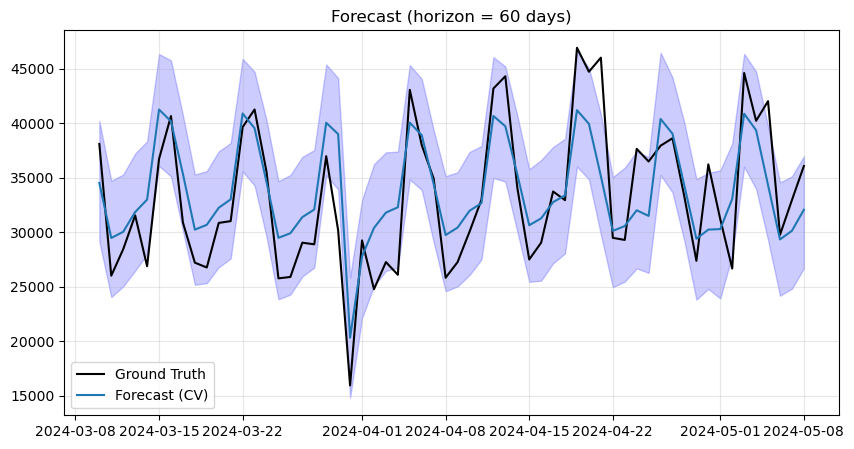


Test set metrics:
RMSE = 3850.98
MAE  = 3127.15


C:\Users\andre\AppData\Local\Temp\ipykernel_37676\1743448199.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_final["pre_covid"] = (train_final["ds"] < cutoff_date)
C:\Users\andre\AppData\Local\Temp\ipykernel_37676\1743448199.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_final["post_covid"] = (train_final["ds"] >= cutoff_date)
13:26:36 - cmdstanpy - INFO - Chain [1] start processing
13:26:36 - cmdstanpy - INFO - Chain [1] done processing



Model components:


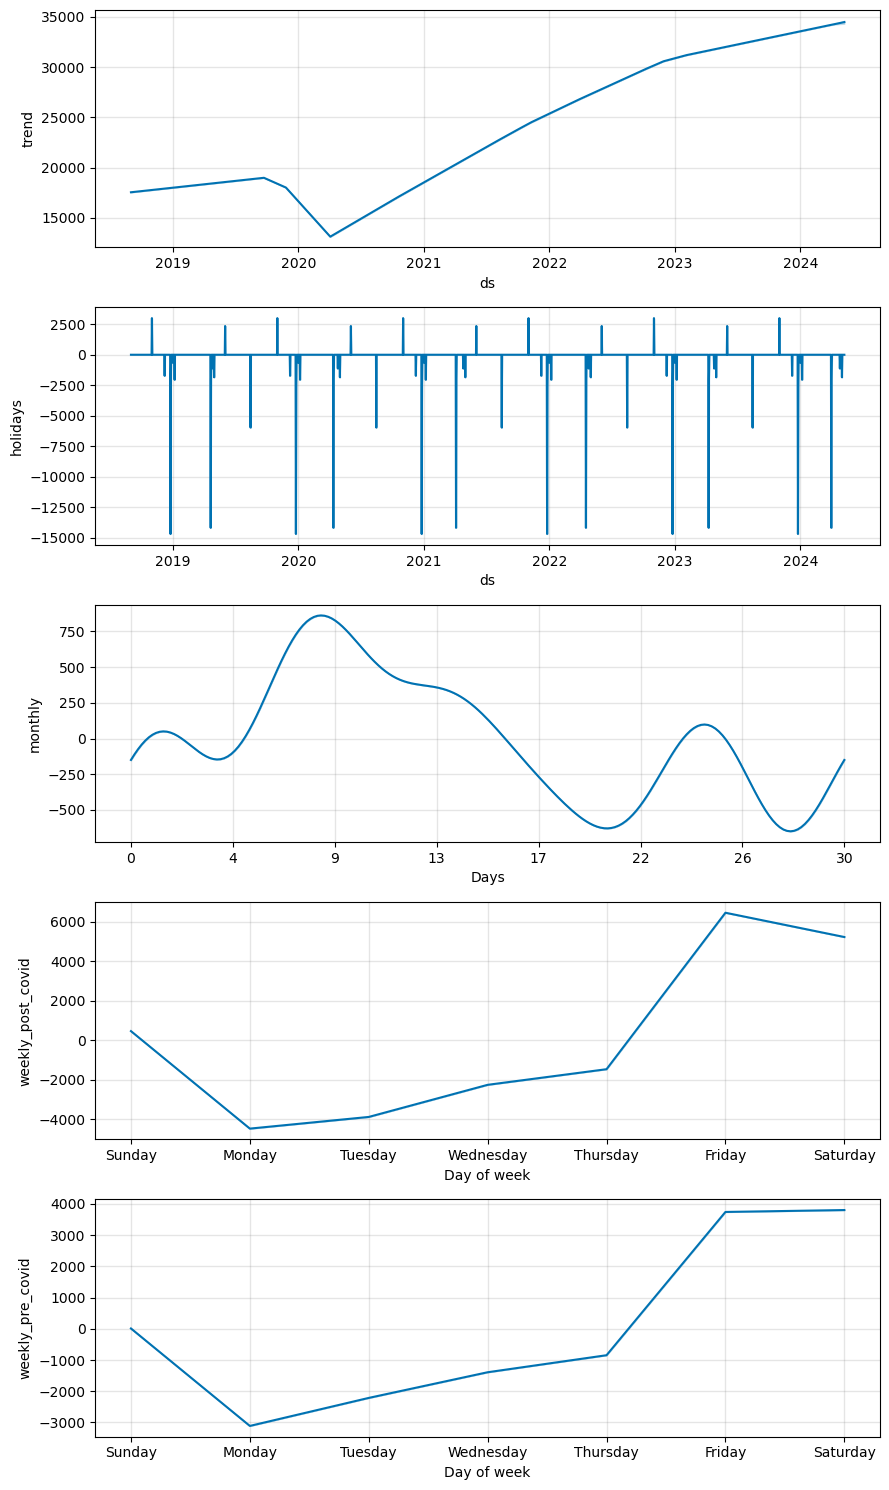

In [37]:
results = fit_prophet_model(
    df=df,
    y_col='totale',
    ds_col='data',
    regressors= None,
    n_test=60,
    weekly=False,
    monthly=True,
    yearly=False,
    weekly_prepost=True,
    holidays=True,
    verbose = True,
    return_results = True)

In [38]:
with open("models/prophet_model_totale_restaurant_5.json", "w") as f:
    f.write(model_to_json(results["model"]))

## GRID SEARCH ON DF6

<Axes: >

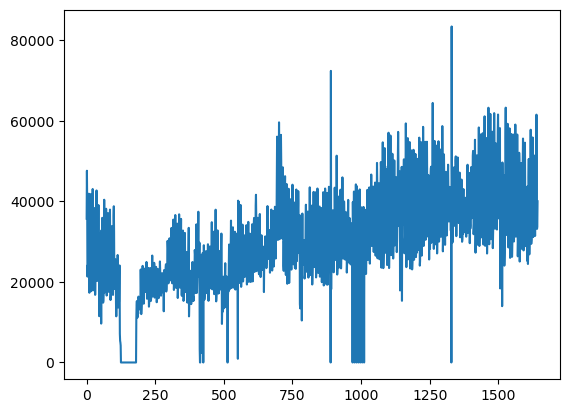

In [46]:
df = pd.read_csv('data/restaurant_6.csv')
df.totale.plot()

In [41]:
results = []

for (w, m, y, wp, h, covid) in param_grid:
    print(f"\n TTesting with: weekly={w}, monthly={m}, yearly={y}, prepost={wp}, holidays={h}, covid={covid is not None}")
    
    
        # Fit Prophet
    res = fit_prophet_model(
            df=df,
            y_col="totale",
            ds_col="data",
            n_test=60,
            weekly=w,
            monthly=m,
            yearly=y,
            weekly_prepost=wp,
            holidays=h,
            regressors=covid,
            verbose=False,
            return_results=True
    )

        
    metrics_last = res["metrics_last_window"]
    cv_metrics = res["metrics_cv"]
    rmse_cv_mean = cv_metrics["rmse"].mean()
    mae_cv_mean = cv_metrics["mae"].mean()
      
    results.append({
            "weekly": w,
            "monthly": m,
            "yearly": y,
            "weekly_prepost": wp,
            "holidays": h,
            "covid_regressors": covid,
            "RMSE_last": metrics_last["RMSE"],
            "MAE_last": metrics_last["MAE"],
            "RMSE_cv_mean": rmse_cv_mean,
            "MAE_cv_mean": mae_cv_mean
    })

df_results = pd.DataFrame(results)
df_results = df_results.sort_values("RMSE_cv_mean", ascending=True).reset_index(drop=True)
df_results.to_csv("prophet_gridsearch_results_restaurant_6.csv", index=False)


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=True, covid=False


13:37:24 - cmdstanpy - INFO - Chain [1] start processing
13:37:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:37:25 - cmdstanpy - INFO - Chain [1] start processing
13:37:25 - cmdstanpy - INFO - Chain [1] done processing
13:37:26 - cmdstanpy - INFO - Chain [1] start processing
13:37:26 - cmdstanpy - INFO - Chain [1] done processing
13:37:26 - cmdstanpy - INFO - Chain [1] start processing
13:37:26 - cmdstanpy - INFO - Chain [1] done processing
13:37:26 - cmdstanpy - INFO - Chain [1] start processing
13:37:27 - cmdstanpy - INFO - Chain [1] done processing
13:37:27 - cmdstanpy - INFO - Chain [1] start processing
13:37:27 - cmdstanpy - INFO - Chain [1] done processing
13:37:27 - cmdstanpy - INFO - Chain [1] start processing
13:37:28 - cmdstanpy - INFO - Chain [1] done processing
13:37:28 - cmdstanpy - INFO - Chain [1] start processing
13:37:28 - cmdstanpy - INFO - Chain [1] done processing
13:37:29 - cmdstanpy - INFO - Chain [1] start processing
13:37:29 - cmdstanpy - INFO - Chain [1] done processing
13:37:29 - cmdstanpy - INFO - Chain [1] start processing
13:37:30 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


13:37:36 - cmdstanpy - INFO - Chain [1] start processing
13:37:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:37:36 - cmdstanpy - INFO - Chain [1] start processing
13:37:36 - cmdstanpy - INFO - Chain [1] done processing
13:37:37 - cmdstanpy - INFO - Chain [1] start processing
13:37:37 - cmdstanpy - INFO - Chain [1] done processing
13:37:37 - cmdstanpy - INFO - Chain [1] start processing
13:37:38 - cmdstanpy - INFO - Chain [1] done processing
13:37:38 - cmdstanpy - INFO - Chain [1] start processing
13:37:38 - cmdstanpy - INFO - Chain [1] done processing
13:37:39 - cmdstanpy - INFO - Chain [1] start processing
13:37:39 - cmdstanpy - INFO - Chain [1] done processing
13:37:39 - cmdstanpy - INFO - Chain [1] start processing
13:37:40 - cmdstanpy - INFO - Chain [1] done processing
13:37:40 - cmdstanpy - INFO - Chain [1] start processing
13:37:40 - cmdstanpy - INFO - Chain [1] done processing
13:37:41 - cmdstanpy - INFO - Chain [1] start processing
13:37:41 - cmdstanpy - INFO - Chain [1] done processing
13:37:42 - cmdstanpy - INFO - Chain [1] start processing
13:37:42 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


13:37:49 - cmdstanpy - INFO - Chain [1] start processing
13:37:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:37:49 - cmdstanpy - INFO - Chain [1] start processing
13:37:49 - cmdstanpy - INFO - Chain [1] done processing
13:37:50 - cmdstanpy - INFO - Chain [1] start processing
13:37:50 - cmdstanpy - INFO - Chain [1] done processing
13:37:50 - cmdstanpy - INFO - Chain [1] start processing
13:37:51 - cmdstanpy - INFO - Chain [1] done processing
13:37:51 - cmdstanpy - INFO - Chain [1] start processing
13:37:51 - cmdstanpy - INFO - Chain [1] done processing
13:37:52 - cmdstanpy - INFO - Chain [1] start processing
13:37:52 - cmdstanpy - INFO - Chain [1] done processing
13:37:52 - cmdstanpy - INFO - Chain [1] start processing
13:37:53 - cmdstanpy - INFO - Chain [1] done processing
13:37:53 - cmdstanpy - INFO - Chain [1] start processing
13:37:53 - cmdstanpy - INFO - Chain [1] done processing
13:37:54 - cmdstanpy - INFO - Chain [1] start processing
13:37:54 - cmdstanpy - INFO - Chain [1] done processing
13:37:54 - cmdstanpy - INFO - Chain [1] start processing
13:37:55 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=False, covid=False


13:38:01 - cmdstanpy - INFO - Chain [1] start processing
13:38:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:38:02 - cmdstanpy - INFO - Chain [1] start processing
13:38:02 - cmdstanpy - INFO - Chain [1] done processing
13:38:03 - cmdstanpy - INFO - Chain [1] start processing
13:38:03 - cmdstanpy - INFO - Chain [1] done processing
13:38:03 - cmdstanpy - INFO - Chain [1] start processing
13:38:03 - cmdstanpy - INFO - Chain [1] done processing
13:38:04 - cmdstanpy - INFO - Chain [1] start processing
13:38:04 - cmdstanpy - INFO - Chain [1] done processing
13:38:04 - cmdstanpy - INFO - Chain [1] start processing
13:38:04 - cmdstanpy - INFO - Chain [1] done processing
13:38:05 - cmdstanpy - INFO - Chain [1] start processing
13:38:05 - cmdstanpy - INFO - Chain [1] done processing
13:38:05 - cmdstanpy - INFO - Chain [1] start processing
13:38:05 - cmdstanpy - INFO - Chain [1] done processing
13:38:06 - cmdstanpy - INFO - Chain [1] start processing
13:38:06 - cmdstanpy - INFO - Chain [1] done processing
13:38:06 - cmdstanpy - INFO - Chain [1] start processing
13:38:07 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


13:38:12 - cmdstanpy - INFO - Chain [1] start processing
13:38:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:38:13 - cmdstanpy - INFO - Chain [1] start processing
13:38:13 - cmdstanpy - INFO - Chain [1] done processing
13:38:14 - cmdstanpy - INFO - Chain [1] start processing
13:38:14 - cmdstanpy - INFO - Chain [1] done processing
13:38:14 - cmdstanpy - INFO - Chain [1] start processing
13:38:14 - cmdstanpy - INFO - Chain [1] done processing
13:38:15 - cmdstanpy - INFO - Chain [1] start processing
13:38:15 - cmdstanpy - INFO - Chain [1] done processing
13:38:15 - cmdstanpy - INFO - Chain [1] start processing
13:38:16 - cmdstanpy - INFO - Chain [1] done processing
13:38:16 - cmdstanpy - INFO - Chain [1] start processing
13:38:16 - cmdstanpy - INFO - Chain [1] done processing
13:38:17 - cmdstanpy - INFO - Chain [1] start processing
13:38:17 - cmdstanpy - INFO - Chain [1] done processing
13:38:17 - cmdstanpy - INFO - Chain [1] start processing
13:38:17 - cmdstanpy - INFO - Chain [1] done processing
13:38:18 - cmdstanpy - INFO - Chain [1] start processing
13:38:18 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


13:38:25 - cmdstanpy - INFO - Chain [1] start processing
13:38:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:38:25 - cmdstanpy - INFO - Chain [1] start processing
13:38:25 - cmdstanpy - INFO - Chain [1] done processing
13:38:26 - cmdstanpy - INFO - Chain [1] start processing
13:38:26 - cmdstanpy - INFO - Chain [1] done processing
13:38:26 - cmdstanpy - INFO - Chain [1] start processing
13:38:26 - cmdstanpy - INFO - Chain [1] done processing
13:38:27 - cmdstanpy - INFO - Chain [1] start processing
13:38:27 - cmdstanpy - INFO - Chain [1] done processing
13:38:27 - cmdstanpy - INFO - Chain [1] start processing
13:38:28 - cmdstanpy - INFO - Chain [1] done processing
13:38:28 - cmdstanpy - INFO - Chain [1] start processing
13:38:28 - cmdstanpy - INFO - Chain [1] done processing
13:38:29 - cmdstanpy - INFO - Chain [1] start processing
13:38:29 - cmdstanpy - INFO - Chain [1] done processing
13:38:29 - cmdstanpy - INFO - Chain [1] start processing
13:38:29 - cmdstanpy - INFO - Chain [1] done processing
13:38:30 - cmdstanpy - INFO - Chain [1] start processing
13:38:30 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=True, covid=False


13:38:36 - cmdstanpy - INFO - Chain [1] start processing
13:38:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:38:36 - cmdstanpy - INFO - Chain [1] start processing
13:38:37 - cmdstanpy - INFO - Chain [1] done processing
13:38:37 - cmdstanpy - INFO - Chain [1] start processing
13:38:37 - cmdstanpy - INFO - Chain [1] done processing
13:38:37 - cmdstanpy - INFO - Chain [1] start processing
13:38:38 - cmdstanpy - INFO - Chain [1] done processing
13:38:38 - cmdstanpy - INFO - Chain [1] start processing
13:38:38 - cmdstanpy - INFO - Chain [1] done processing
13:38:39 - cmdstanpy - INFO - Chain [1] start processing
13:38:39 - cmdstanpy - INFO - Chain [1] done processing
13:38:39 - cmdstanpy - INFO - Chain [1] start processing
13:38:40 - cmdstanpy - INFO - Chain [1] done processing
13:38:40 - cmdstanpy - INFO - Chain [1] start processing
13:38:40 - cmdstanpy - INFO - Chain [1] done processing
13:38:41 - cmdstanpy - INFO - Chain [1] start processing
13:38:41 - cmdstanpy - INFO - Chain [1] done processing
13:38:42 - cmdstanpy - INFO - Chain [1] start processing
13:38:42 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


13:38:49 - cmdstanpy - INFO - Chain [1] start processing
13:38:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:38:49 - cmdstanpy - INFO - Chain [1] start processing
13:38:49 - cmdstanpy - INFO - Chain [1] done processing
13:38:50 - cmdstanpy - INFO - Chain [1] start processing
13:38:50 - cmdstanpy - INFO - Chain [1] done processing
13:38:50 - cmdstanpy - INFO - Chain [1] start processing
13:38:50 - cmdstanpy - INFO - Chain [1] done processing
13:38:51 - cmdstanpy - INFO - Chain [1] start processing
13:38:51 - cmdstanpy - INFO - Chain [1] done processing
13:38:52 - cmdstanpy - INFO - Chain [1] start processing
13:38:52 - cmdstanpy - INFO - Chain [1] done processing
13:38:52 - cmdstanpy - INFO - Chain [1] start processing
13:38:53 - cmdstanpy - INFO - Chain [1] done processing
13:38:53 - cmdstanpy - INFO - Chain [1] start processing
13:38:53 - cmdstanpy - INFO - Chain [1] done processing
13:38:54 - cmdstanpy - INFO - Chain [1] start processing
13:38:54 - cmdstanpy - INFO - Chain [1] done processing
13:38:54 - cmdstanpy - INFO - Chain [1] start processing
13:38:54 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


13:39:01 - cmdstanpy - INFO - Chain [1] start processing
13:39:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:39:02 - cmdstanpy - INFO - Chain [1] start processing
13:39:02 - cmdstanpy - INFO - Chain [1] done processing
13:39:03 - cmdstanpy - INFO - Chain [1] start processing
13:39:03 - cmdstanpy - INFO - Chain [1] done processing
13:39:03 - cmdstanpy - INFO - Chain [1] start processing
13:39:03 - cmdstanpy - INFO - Chain [1] done processing
13:39:04 - cmdstanpy - INFO - Chain [1] start processing
13:39:04 - cmdstanpy - INFO - Chain [1] done processing
13:39:04 - cmdstanpy - INFO - Chain [1] start processing
13:39:05 - cmdstanpy - INFO - Chain [1] done processing
13:39:05 - cmdstanpy - INFO - Chain [1] start processing
13:39:05 - cmdstanpy - INFO - Chain [1] done processing
13:39:06 - cmdstanpy - INFO - Chain [1] start processing
13:39:06 - cmdstanpy - INFO - Chain [1] done processing
13:39:06 - cmdstanpy - INFO - Chain [1] start processing
13:39:07 - cmdstanpy - INFO - Chain [1] done processing
13:39:07 - cmdstanpy - INFO - Chain [1] start processing
13:39:07 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=False, covid=False


13:39:14 - cmdstanpy - INFO - Chain [1] start processing
13:39:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:39:14 - cmdstanpy - INFO - Chain [1] start processing
13:39:14 - cmdstanpy - INFO - Chain [1] done processing
13:39:15 - cmdstanpy - INFO - Chain [1] start processing
13:39:15 - cmdstanpy - INFO - Chain [1] done processing
13:39:15 - cmdstanpy - INFO - Chain [1] start processing
13:39:15 - cmdstanpy - INFO - Chain [1] done processing
13:39:16 - cmdstanpy - INFO - Chain [1] start processing
13:39:16 - cmdstanpy - INFO - Chain [1] done processing
13:39:16 - cmdstanpy - INFO - Chain [1] start processing
13:39:17 - cmdstanpy - INFO - Chain [1] done processing
13:39:17 - cmdstanpy - INFO - Chain [1] start processing
13:39:17 - cmdstanpy - INFO - Chain [1] done processing
13:39:17 - cmdstanpy - INFO - Chain [1] start processing
13:39:18 - cmdstanpy - INFO - Chain [1] done processing
13:39:18 - cmdstanpy - INFO - Chain [1] start processing
13:39:18 - cmdstanpy - INFO - Chain [1] done processing
13:39:18 - cmdstanpy - INFO - Chain [1] start processing
13:39:19 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


13:39:24 - cmdstanpy - INFO - Chain [1] start processing
13:39:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:39:25 - cmdstanpy - INFO - Chain [1] start processing
13:39:25 - cmdstanpy - INFO - Chain [1] done processing
13:39:26 - cmdstanpy - INFO - Chain [1] start processing
13:39:26 - cmdstanpy - INFO - Chain [1] done processing
13:39:26 - cmdstanpy - INFO - Chain [1] start processing
13:39:26 - cmdstanpy - INFO - Chain [1] done processing
13:39:27 - cmdstanpy - INFO - Chain [1] start processing
13:39:27 - cmdstanpy - INFO - Chain [1] done processing
13:39:27 - cmdstanpy - INFO - Chain [1] start processing
13:39:27 - cmdstanpy - INFO - Chain [1] done processing
13:39:28 - cmdstanpy - INFO - Chain [1] start processing
13:39:28 - cmdstanpy - INFO - Chain [1] done processing
13:39:28 - cmdstanpy - INFO - Chain [1] start processing
13:39:29 - cmdstanpy - INFO - Chain [1] done processing
13:39:29 - cmdstanpy - INFO - Chain [1] start processing
13:39:29 - cmdstanpy - INFO - Chain [1] done processing
13:39:29 - cmdstanpy - INFO - Chain [1] start processing
13:39:30 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


13:39:35 - cmdstanpy - INFO - Chain [1] start processing
13:39:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:39:36 - cmdstanpy - INFO - Chain [1] start processing
13:39:36 - cmdstanpy - INFO - Chain [1] done processing
13:39:36 - cmdstanpy - INFO - Chain [1] start processing
13:39:37 - cmdstanpy - INFO - Chain [1] done processing
13:39:37 - cmdstanpy - INFO - Chain [1] start processing
13:39:37 - cmdstanpy - INFO - Chain [1] done processing
13:39:37 - cmdstanpy - INFO - Chain [1] start processing
13:39:38 - cmdstanpy - INFO - Chain [1] done processing
13:39:38 - cmdstanpy - INFO - Chain [1] start processing
13:39:38 - cmdstanpy - INFO - Chain [1] done processing
13:39:38 - cmdstanpy - INFO - Chain [1] start processing
13:39:39 - cmdstanpy - INFO - Chain [1] done processing
13:39:39 - cmdstanpy - INFO - Chain [1] start processing
13:39:39 - cmdstanpy - INFO - Chain [1] done processing
13:39:40 - cmdstanpy - INFO - Chain [1] start processing
13:39:40 - cmdstanpy - INFO - Chain [1] done processing
13:39:40 - cmdstanpy - INFO - Chain [1] start processing
13:39:40 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=True, covid=False


13:39:46 - cmdstanpy - INFO - Chain [1] start processing
13:39:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:39:46 - cmdstanpy - INFO - Chain [1] start processing
13:39:47 - cmdstanpy - INFO - Chain [1] done processing
13:39:47 - cmdstanpy - INFO - Chain [1] start processing
13:39:47 - cmdstanpy - INFO - Chain [1] done processing
13:39:48 - cmdstanpy - INFO - Chain [1] start processing
13:39:48 - cmdstanpy - INFO - Chain [1] done processing
13:39:48 - cmdstanpy - INFO - Chain [1] start processing
13:39:48 - cmdstanpy - INFO - Chain [1] done processing
13:39:49 - cmdstanpy - INFO - Chain [1] start processing
13:39:49 - cmdstanpy - INFO - Chain [1] done processing
13:39:49 - cmdstanpy - INFO - Chain [1] start processing
13:39:50 - cmdstanpy - INFO - Chain [1] done processing
13:39:50 - cmdstanpy - INFO - Chain [1] start processing
13:39:50 - cmdstanpy - INFO - Chain [1] done processing
13:39:50 - cmdstanpy - INFO - Chain [1] start processing
13:39:51 - cmdstanpy - INFO - Chain [1] done processing
13:39:51 - cmdstanpy - INFO - Chain [1] start processing
13:39:51 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


13:39:57 - cmdstanpy - INFO - Chain [1] start processing
13:39:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:39:58 - cmdstanpy - INFO - Chain [1] start processing
13:39:58 - cmdstanpy - INFO - Chain [1] done processing
13:39:58 - cmdstanpy - INFO - Chain [1] start processing
13:39:59 - cmdstanpy - INFO - Chain [1] done processing
13:39:59 - cmdstanpy - INFO - Chain [1] start processing
13:39:59 - cmdstanpy - INFO - Chain [1] done processing
13:40:00 - cmdstanpy - INFO - Chain [1] start processing
13:40:00 - cmdstanpy - INFO - Chain [1] done processing
13:40:00 - cmdstanpy - INFO - Chain [1] start processing
13:40:00 - cmdstanpy - INFO - Chain [1] done processing
13:40:01 - cmdstanpy - INFO - Chain [1] start processing
13:40:01 - cmdstanpy - INFO - Chain [1] done processing
13:40:02 - cmdstanpy - INFO - Chain [1] start processing
13:40:02 - cmdstanpy - INFO - Chain [1] done processing
13:40:02 - cmdstanpy - INFO - Chain [1] start processing
13:40:02 - cmdstanpy - INFO - Chain [1] done processing
13:40:03 - cmdstanpy - INFO - Chain [1] start processing
13:40:03 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


13:40:09 - cmdstanpy - INFO - Chain [1] start processing
13:40:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:40:10 - cmdstanpy - INFO - Chain [1] start processing
13:40:10 - cmdstanpy - INFO - Chain [1] done processing
13:40:11 - cmdstanpy - INFO - Chain [1] start processing
13:40:11 - cmdstanpy - INFO - Chain [1] done processing
13:40:11 - cmdstanpy - INFO - Chain [1] start processing
13:40:11 - cmdstanpy - INFO - Chain [1] done processing
13:40:11 - cmdstanpy - INFO - Chain [1] start processing
13:40:12 - cmdstanpy - INFO - Chain [1] done processing
13:40:12 - cmdstanpy - INFO - Chain [1] start processing
13:40:12 - cmdstanpy - INFO - Chain [1] done processing
13:40:12 - cmdstanpy - INFO - Chain [1] start processing
13:40:13 - cmdstanpy - INFO - Chain [1] done processing
13:40:13 - cmdstanpy - INFO - Chain [1] start processing
13:40:13 - cmdstanpy - INFO - Chain [1] done processing
13:40:14 - cmdstanpy - INFO - Chain [1] start processing
13:40:14 - cmdstanpy - INFO - Chain [1] done processing
13:40:14 - cmdstanpy - INFO - Chain [1] start processing
13:40:15 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=False, covid=False


13:40:21 - cmdstanpy - INFO - Chain [1] start processing
13:40:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:40:21 - cmdstanpy - INFO - Chain [1] start processing
13:40:21 - cmdstanpy - INFO - Chain [1] done processing
13:40:22 - cmdstanpy - INFO - Chain [1] start processing
13:40:22 - cmdstanpy - INFO - Chain [1] done processing
13:40:22 - cmdstanpy - INFO - Chain [1] start processing
13:40:22 - cmdstanpy - INFO - Chain [1] done processing
13:40:23 - cmdstanpy - INFO - Chain [1] start processing
13:40:23 - cmdstanpy - INFO - Chain [1] done processing
13:40:23 - cmdstanpy - INFO - Chain [1] start processing
13:40:23 - cmdstanpy - INFO - Chain [1] done processing
13:40:24 - cmdstanpy - INFO - Chain [1] start processing
13:40:24 - cmdstanpy - INFO - Chain [1] done processing
13:40:24 - cmdstanpy - INFO - Chain [1] start processing
13:40:24 - cmdstanpy - INFO - Chain [1] done processing
13:40:25 - cmdstanpy - INFO - Chain [1] start processing
13:40:25 - cmdstanpy - INFO - Chain [1] done processing
13:40:25 - cmdstanpy - INFO - Chain [1] start processing
13:40:25 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


13:40:30 - cmdstanpy - INFO - Chain [1] start processing
13:40:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:40:31 - cmdstanpy - INFO - Chain [1] start processing
13:40:31 - cmdstanpy - INFO - Chain [1] done processing
13:40:31 - cmdstanpy - INFO - Chain [1] start processing
13:40:32 - cmdstanpy - INFO - Chain [1] done processing
13:40:32 - cmdstanpy - INFO - Chain [1] start processing
13:40:32 - cmdstanpy - INFO - Chain [1] done processing
13:40:32 - cmdstanpy - INFO - Chain [1] start processing
13:40:33 - cmdstanpy - INFO - Chain [1] done processing
13:40:33 - cmdstanpy - INFO - Chain [1] start processing
13:40:33 - cmdstanpy - INFO - Chain [1] done processing
13:40:34 - cmdstanpy - INFO - Chain [1] start processing
13:40:34 - cmdstanpy - INFO - Chain [1] done processing
13:40:34 - cmdstanpy - INFO - Chain [1] start processing
13:40:34 - cmdstanpy - INFO - Chain [1] done processing
13:40:35 - cmdstanpy - INFO - Chain [1] start processing
13:40:35 - cmdstanpy - INFO - Chain [1] done processing
13:40:35 - cmdstanpy - INFO - Chain [1] start processing
13:40:36 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


13:40:40 - cmdstanpy - INFO - Chain [1] start processing
13:40:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:40:40 - cmdstanpy - INFO - Chain [1] start processing
13:45:06 - cmdstanpy - INFO - Chain [1] done processing
13:45:07 - cmdstanpy - INFO - Chain [1] start processing
13:45:07 - cmdstanpy - INFO - Chain [1] done processing
13:45:07 - cmdstanpy - INFO - Chain [1] start processing
13:45:07 - cmdstanpy - INFO - Chain [1] done processing
13:45:07 - cmdstanpy - INFO - Chain [1] start processing
13:45:07 - cmdstanpy - INFO - Chain [1] done processing
13:45:07 - cmdstanpy - INFO - Chain [1] start processing
13:45:08 - cmdstanpy - INFO - Chain [1] done processing
13:45:08 - cmdstanpy - INFO - Chain [1] start processing
13:45:08 - cmdstanpy - INFO - Chain [1] done processing
13:45:08 - cmdstanpy - INFO - Chain [1] start processing
13:45:08 - cmdstanpy - INFO - Chain [1] done processing
13:45:09 - cmdstanpy - INFO - Chain [1] start processing
13:45:09 - cmdstanpy - INFO - Chain [1] done processing
13:45:09 - cmdstanpy - INFO - Chain [1] start processing
13:45:09 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=True, covid=False


13:45:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:45:13 - cmdstanpy - INFO - Chain [1] start processing
13:45:13 - cmdstanpy - INFO - Chain [1] done processing
13:45:13 - cmdstanpy - INFO - Chain [1] start processing
13:45:14 - cmdstanpy - INFO - Chain [1] done processing
13:45:14 - cmdstanpy - INFO - Chain [1] start processing
13:45:14 - cmdstanpy - INFO - Chain [1] done processing
13:45:14 - cmdstanpy - INFO - Chain [1] start processing
13:45:14 - cmdstanpy - INFO - Chain [1] done processing
13:45:14 - cmdstanpy - INFO - Chain [1] start processing
13:45:15 - cmdstanpy - INFO - Chain [1] done processing
13:45:15 - cmdstanpy - INFO - Chain [1] start processing
13:45:15 - cmdstanpy - INFO - Chain [1] done processing
13:45:15 - cmdstanpy - INFO - Chain [1] start processing
13:45:15 - cmdstanpy - INFO - Chain [1] done processing
13:45:16 - cmdstanpy - INFO - Chain [1] start processing
13:45:16 - cmdstanpy - INFO - Chain [1] done processing
13:45:16 - cmdstanpy - INFO - Chain [1] start processing
13:45:16 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


13:45:21 - cmdstanpy - INFO - Chain [1] start processing
13:45:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:45:22 - cmdstanpy - INFO - Chain [1] start processing
13:45:22 - cmdstanpy - INFO - Chain [1] done processing
13:45:22 - cmdstanpy - INFO - Chain [1] start processing
13:45:22 - cmdstanpy - INFO - Chain [1] done processing
13:45:23 - cmdstanpy - INFO - Chain [1] start processing
13:45:23 - cmdstanpy - INFO - Chain [1] done processing
13:45:23 - cmdstanpy - INFO - Chain [1] start processing
13:45:24 - cmdstanpy - INFO - Chain [1] done processing
13:45:24 - cmdstanpy - INFO - Chain [1] start processing
13:45:24 - cmdstanpy - INFO - Chain [1] done processing
13:45:24 - cmdstanpy - INFO - Chain [1] start processing
13:45:25 - cmdstanpy - INFO - Chain [1] done processing
13:45:25 - cmdstanpy - INFO - Chain [1] start processing
13:45:25 - cmdstanpy - INFO - Chain [1] done processing
13:45:26 - cmdstanpy - INFO - Chain [1] start processing
13:45:26 - cmdstanpy - INFO - Chain [1] done processing
13:45:26 - cmdstanpy - INFO - Chain [1] start processing
13:45:27 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


13:45:32 - cmdstanpy - INFO - Chain [1] start processing
13:45:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:45:33 - cmdstanpy - INFO - Chain [1] start processing
13:45:33 - cmdstanpy - INFO - Chain [1] done processing
13:45:33 - cmdstanpy - INFO - Chain [1] start processing
13:45:33 - cmdstanpy - INFO - Chain [1] done processing
13:45:34 - cmdstanpy - INFO - Chain [1] start processing
13:45:34 - cmdstanpy - INFO - Chain [1] done processing
13:45:34 - cmdstanpy - INFO - Chain [1] start processing
13:45:34 - cmdstanpy - INFO - Chain [1] done processing
13:45:35 - cmdstanpy - INFO - Chain [1] start processing
13:45:35 - cmdstanpy - INFO - Chain [1] done processing
13:45:35 - cmdstanpy - INFO - Chain [1] start processing
13:45:35 - cmdstanpy - INFO - Chain [1] done processing
13:45:36 - cmdstanpy - INFO - Chain [1] start processing
13:45:36 - cmdstanpy - INFO - Chain [1] done processing
13:45:36 - cmdstanpy - INFO - Chain [1] start processing
13:45:37 - cmdstanpy - INFO - Chain [1] done processing
13:45:37 - cmdstanpy - INFO - Chain [1] start processing
13:45:38 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=False, covid=False


13:45:43 - cmdstanpy - INFO - Chain [1] start processing
13:45:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:45:44 - cmdstanpy - INFO - Chain [1] start processing
13:45:44 - cmdstanpy - INFO - Chain [1] done processing
13:45:44 - cmdstanpy - INFO - Chain [1] start processing
13:45:44 - cmdstanpy - INFO - Chain [1] done processing
13:45:44 - cmdstanpy - INFO - Chain [1] start processing
13:45:45 - cmdstanpy - INFO - Chain [1] done processing
13:45:45 - cmdstanpy - INFO - Chain [1] start processing
13:45:45 - cmdstanpy - INFO - Chain [1] done processing
13:45:45 - cmdstanpy - INFO - Chain [1] start processing
13:45:46 - cmdstanpy - INFO - Chain [1] done processing
13:45:46 - cmdstanpy - INFO - Chain [1] start processing
13:45:46 - cmdstanpy - INFO - Chain [1] done processing
13:45:46 - cmdstanpy - INFO - Chain [1] start processing
13:45:47 - cmdstanpy - INFO - Chain [1] done processing
13:45:47 - cmdstanpy - INFO - Chain [1] start processing
13:45:47 - cmdstanpy - INFO - Chain [1] done processing
13:45:47 - cmdstanpy - INFO - Chain [1] start processing
13:45:48 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


13:45:53 - cmdstanpy - INFO - Chain [1] start processing
13:45:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:45:53 - cmdstanpy - INFO - Chain [1] start processing
13:45:53 - cmdstanpy - INFO - Chain [1] done processing
13:45:54 - cmdstanpy - INFO - Chain [1] start processing
13:45:54 - cmdstanpy - INFO - Chain [1] done processing
13:45:54 - cmdstanpy - INFO - Chain [1] start processing
13:45:54 - cmdstanpy - INFO - Chain [1] done processing
13:45:55 - cmdstanpy - INFO - Chain [1] start processing
13:45:55 - cmdstanpy - INFO - Chain [1] done processing
13:45:55 - cmdstanpy - INFO - Chain [1] start processing
13:45:55 - cmdstanpy - INFO - Chain [1] done processing
13:45:55 - cmdstanpy - INFO - Chain [1] start processing
13:45:56 - cmdstanpy - INFO - Chain [1] done processing
13:45:56 - cmdstanpy - INFO - Chain [1] start processing
13:45:56 - cmdstanpy - INFO - Chain [1] done processing
13:45:56 - cmdstanpy - INFO - Chain [1] start processing
13:45:57 - cmdstanpy - INFO - Chain [1] done processing
13:45:57 - cmdstanpy - INFO - Chain [1] start processing
13:45:57 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


13:46:02 - cmdstanpy - INFO - Chain [1] start processing
13:46:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:46:03 - cmdstanpy - INFO - Chain [1] start processing
13:46:03 - cmdstanpy - INFO - Chain [1] done processing
13:46:03 - cmdstanpy - INFO - Chain [1] start processing
13:46:03 - cmdstanpy - INFO - Chain [1] done processing
13:46:03 - cmdstanpy - INFO - Chain [1] start processing
13:46:04 - cmdstanpy - INFO - Chain [1] done processing
13:46:04 - cmdstanpy - INFO - Chain [1] start processing
13:46:04 - cmdstanpy - INFO - Chain [1] done processing
13:46:04 - cmdstanpy - INFO - Chain [1] start processing
13:46:05 - cmdstanpy - INFO - Chain [1] done processing
13:46:05 - cmdstanpy - INFO - Chain [1] start processing
13:46:05 - cmdstanpy - INFO - Chain [1] done processing
13:46:05 - cmdstanpy - INFO - Chain [1] start processing
13:46:05 - cmdstanpy - INFO - Chain [1] done processing
13:46:06 - cmdstanpy - INFO - Chain [1] start processing
13:46:06 - cmdstanpy - INFO - Chain [1] done processing
13:46:06 - cmdstanpy - INFO - Chain [1] start processing
13:46:07 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=True, covid=False


13:46:12 - cmdstanpy - INFO - Chain [1] start processing
13:46:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:46:12 - cmdstanpy - INFO - Chain [1] start processing
13:46:12 - cmdstanpy - INFO - Chain [1] done processing
13:46:13 - cmdstanpy - INFO - Chain [1] start processing
13:46:13 - cmdstanpy - INFO - Chain [1] done processing
13:46:13 - cmdstanpy - INFO - Chain [1] start processing
13:46:13 - cmdstanpy - INFO - Chain [1] done processing
13:46:14 - cmdstanpy - INFO - Chain [1] start processing
13:46:14 - cmdstanpy - INFO - Chain [1] done processing
13:46:14 - cmdstanpy - INFO - Chain [1] start processing
13:46:15 - cmdstanpy - INFO - Chain [1] done processing
13:46:15 - cmdstanpy - INFO - Chain [1] start processing
13:46:15 - cmdstanpy - INFO - Chain [1] done processing
13:46:15 - cmdstanpy - INFO - Chain [1] start processing
13:46:16 - cmdstanpy - INFO - Chain [1] done processing
13:46:16 - cmdstanpy - INFO - Chain [1] start processing
13:46:16 - cmdstanpy - INFO - Chain [1] done processing
13:46:17 - cmdstanpy - INFO - Chain [1] start processing
13:46:17 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


13:46:23 - cmdstanpy - INFO - Chain [1] start processing
13:46:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:46:24 - cmdstanpy - INFO - Chain [1] start processing
13:46:24 - cmdstanpy - INFO - Chain [1] done processing
13:46:24 - cmdstanpy - INFO - Chain [1] start processing
13:46:25 - cmdstanpy - INFO - Chain [1] done processing
13:46:25 - cmdstanpy - INFO - Chain [1] start processing
13:46:25 - cmdstanpy - INFO - Chain [1] done processing
13:46:26 - cmdstanpy - INFO - Chain [1] start processing
13:46:26 - cmdstanpy - INFO - Chain [1] done processing
13:46:26 - cmdstanpy - INFO - Chain [1] start processing
13:46:26 - cmdstanpy - INFO - Chain [1] done processing
13:46:27 - cmdstanpy - INFO - Chain [1] start processing
13:46:27 - cmdstanpy - INFO - Chain [1] done processing
13:46:28 - cmdstanpy - INFO - Chain [1] start processing
13:46:28 - cmdstanpy - INFO - Chain [1] done processing
13:46:28 - cmdstanpy - INFO - Chain [1] start processing
13:46:28 - cmdstanpy - INFO - Chain [1] done processing
13:46:29 - cmdstanpy - INFO - Chain [1] start processing
13:46:29 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


13:46:36 - cmdstanpy - INFO - Chain [1] start processing
13:46:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:46:36 - cmdstanpy - INFO - Chain [1] start processing
13:46:37 - cmdstanpy - INFO - Chain [1] done processing
13:46:37 - cmdstanpy - INFO - Chain [1] start processing
13:46:37 - cmdstanpy - INFO - Chain [1] done processing
13:46:37 - cmdstanpy - INFO - Chain [1] start processing
13:46:38 - cmdstanpy - INFO - Chain [1] done processing
13:46:38 - cmdstanpy - INFO - Chain [1] start processing
13:46:38 - cmdstanpy - INFO - Chain [1] done processing
13:46:38 - cmdstanpy - INFO - Chain [1] start processing
13:46:39 - cmdstanpy - INFO - Chain [1] done processing
13:46:39 - cmdstanpy - INFO - Chain [1] start processing
13:46:39 - cmdstanpy - INFO - Chain [1] done processing
13:46:40 - cmdstanpy - INFO - Chain [1] start processing
13:46:40 - cmdstanpy - INFO - Chain [1] done processing
13:46:40 - cmdstanpy - INFO - Chain [1] start processing
13:46:41 - cmdstanpy - INFO - Chain [1] done processing
13:46:41 - cmdstanpy - INFO - Chain [1] start processing
13:46:41 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=False, covid=False


13:46:47 - cmdstanpy - INFO - Chain [1] start processing
13:46:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:46:48 - cmdstanpy - INFO - Chain [1] start processing
13:46:48 - cmdstanpy - INFO - Chain [1] done processing
13:46:49 - cmdstanpy - INFO - Chain [1] start processing
13:46:49 - cmdstanpy - INFO - Chain [1] done processing
13:46:49 - cmdstanpy - INFO - Chain [1] start processing
13:46:49 - cmdstanpy - INFO - Chain [1] done processing
13:46:49 - cmdstanpy - INFO - Chain [1] start processing
13:46:50 - cmdstanpy - INFO - Chain [1] done processing
13:46:50 - cmdstanpy - INFO - Chain [1] start processing
13:46:50 - cmdstanpy - INFO - Chain [1] done processing
13:46:50 - cmdstanpy - INFO - Chain [1] start processing
13:46:51 - cmdstanpy - INFO - Chain [1] done processing
13:46:51 - cmdstanpy - INFO - Chain [1] start processing
13:46:51 - cmdstanpy - INFO - Chain [1] done processing
13:46:51 - cmdstanpy - INFO - Chain [1] start processing
13:46:52 - cmdstanpy - INFO - Chain [1] done processing
13:46:52 - cmdstanpy - INFO - Chain [1] start processing
13:46:52 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


13:46:57 - cmdstanpy - INFO - Chain [1] start processing
13:46:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:46:58 - cmdstanpy - INFO - Chain [1] start processing
13:46:58 - cmdstanpy - INFO - Chain [1] done processing
13:46:58 - cmdstanpy - INFO - Chain [1] start processing
13:46:58 - cmdstanpy - INFO - Chain [1] done processing
13:46:59 - cmdstanpy - INFO - Chain [1] start processing
13:46:59 - cmdstanpy - INFO - Chain [1] done processing
13:46:59 - cmdstanpy - INFO - Chain [1] start processing
13:46:59 - cmdstanpy - INFO - Chain [1] done processing
13:47:00 - cmdstanpy - INFO - Chain [1] start processing
13:47:00 - cmdstanpy - INFO - Chain [1] done processing
13:47:00 - cmdstanpy - INFO - Chain [1] start processing
13:47:01 - cmdstanpy - INFO - Chain [1] done processing
13:47:01 - cmdstanpy - INFO - Chain [1] start processing
13:47:01 - cmdstanpy - INFO - Chain [1] done processing
13:47:01 - cmdstanpy - INFO - Chain [1] start processing
13:47:02 - cmdstanpy - INFO - Chain [1] done processing
13:47:02 - cmdstanpy - INFO - Chain [1] start processing
13:47:02 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


13:47:08 - cmdstanpy - INFO - Chain [1] start processing
13:47:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:47:08 - cmdstanpy - INFO - Chain [1] start processing
13:47:09 - cmdstanpy - INFO - Chain [1] done processing
13:47:09 - cmdstanpy - INFO - Chain [1] start processing
13:47:09 - cmdstanpy - INFO - Chain [1] done processing
13:47:09 - cmdstanpy - INFO - Chain [1] start processing
13:47:09 - cmdstanpy - INFO - Chain [1] done processing
13:47:10 - cmdstanpy - INFO - Chain [1] start processing
13:47:10 - cmdstanpy - INFO - Chain [1] done processing
13:47:10 - cmdstanpy - INFO - Chain [1] start processing
13:47:10 - cmdstanpy - INFO - Chain [1] done processing
13:47:11 - cmdstanpy - INFO - Chain [1] start processing
13:47:11 - cmdstanpy - INFO - Chain [1] done processing
13:47:11 - cmdstanpy - INFO - Chain [1] start processing
13:47:11 - cmdstanpy - INFO - Chain [1] done processing
13:47:12 - cmdstanpy - INFO - Chain [1] start processing
13:47:12 - cmdstanpy - INFO - Chain [1] done processing
13:47:12 - cmdstanpy - INFO - Chain [1] start processing
13:47:13 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=True, covid=False


13:47:18 - cmdstanpy - INFO - Chain [1] start processing
13:47:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:47:19 - cmdstanpy - INFO - Chain [1] start processing
13:47:19 - cmdstanpy - INFO - Chain [1] done processing
13:47:19 - cmdstanpy - INFO - Chain [1] start processing
13:47:20 - cmdstanpy - INFO - Chain [1] done processing
13:47:20 - cmdstanpy - INFO - Chain [1] start processing
13:47:20 - cmdstanpy - INFO - Chain [1] done processing
13:47:20 - cmdstanpy - INFO - Chain [1] start processing
13:47:21 - cmdstanpy - INFO - Chain [1] done processing
13:47:21 - cmdstanpy - INFO - Chain [1] start processing
13:47:21 - cmdstanpy - INFO - Chain [1] done processing
13:47:22 - cmdstanpy - INFO - Chain [1] start processing
13:47:22 - cmdstanpy - INFO - Chain [1] done processing
13:47:22 - cmdstanpy - INFO - Chain [1] start processing
13:47:22 - cmdstanpy - INFO - Chain [1] done processing
13:47:23 - cmdstanpy - INFO - Chain [1] start processing
13:47:23 - cmdstanpy - INFO - Chain [1] done processing
13:47:23 - cmdstanpy - INFO - Chain [1] start processing
13:47:24 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


13:47:29 - cmdstanpy - INFO - Chain [1] start processing
13:47:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:47:30 - cmdstanpy - INFO - Chain [1] start processing
13:47:30 - cmdstanpy - INFO - Chain [1] done processing
13:47:30 - cmdstanpy - INFO - Chain [1] start processing
13:47:31 - cmdstanpy - INFO - Chain [1] done processing
13:47:31 - cmdstanpy - INFO - Chain [1] start processing
13:47:31 - cmdstanpy - INFO - Chain [1] done processing
13:47:32 - cmdstanpy - INFO - Chain [1] start processing
13:47:32 - cmdstanpy - INFO - Chain [1] done processing
13:47:32 - cmdstanpy - INFO - Chain [1] start processing
13:47:32 - cmdstanpy - INFO - Chain [1] done processing
13:47:33 - cmdstanpy - INFO - Chain [1] start processing
13:47:33 - cmdstanpy - INFO - Chain [1] done processing
13:47:33 - cmdstanpy - INFO - Chain [1] start processing
13:47:33 - cmdstanpy - INFO - Chain [1] done processing
13:47:34 - cmdstanpy - INFO - Chain [1] start processing
13:47:34 - cmdstanpy - INFO - Chain [1] done processing
13:47:34 - cmdstanpy - INFO - Chain [1] start processing
13:47:35 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


13:47:41 - cmdstanpy - INFO - Chain [1] start processing
13:47:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:47:42 - cmdstanpy - INFO - Chain [1] start processing
13:47:42 - cmdstanpy - INFO - Chain [1] done processing
13:47:42 - cmdstanpy - INFO - Chain [1] start processing
13:47:42 - cmdstanpy - INFO - Chain [1] done processing
13:47:43 - cmdstanpy - INFO - Chain [1] start processing
13:47:43 - cmdstanpy - INFO - Chain [1] done processing
13:47:43 - cmdstanpy - INFO - Chain [1] start processing
13:47:43 - cmdstanpy - INFO - Chain [1] done processing
13:47:44 - cmdstanpy - INFO - Chain [1] start processing
13:47:44 - cmdstanpy - INFO - Chain [1] done processing
13:47:44 - cmdstanpy - INFO - Chain [1] start processing
13:47:45 - cmdstanpy - INFO - Chain [1] done processing
13:47:45 - cmdstanpy - INFO - Chain [1] start processing
13:47:45 - cmdstanpy - INFO - Chain [1] done processing
13:47:46 - cmdstanpy - INFO - Chain [1] start processing
13:47:46 - cmdstanpy - INFO - Chain [1] done processing
13:47:46 - cmdstanpy - INFO - Chain [1] start processing
13:47:46 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=False, covid=False


13:47:53 - cmdstanpy - INFO - Chain [1] start processing
13:47:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:47:53 - cmdstanpy - INFO - Chain [1] start processing
13:47:53 - cmdstanpy - INFO - Chain [1] done processing
13:47:54 - cmdstanpy - INFO - Chain [1] start processing
13:47:54 - cmdstanpy - INFO - Chain [1] done processing
13:47:54 - cmdstanpy - INFO - Chain [1] start processing
13:47:54 - cmdstanpy - INFO - Chain [1] done processing
13:47:55 - cmdstanpy - INFO - Chain [1] start processing
13:47:55 - cmdstanpy - INFO - Chain [1] done processing
13:47:55 - cmdstanpy - INFO - Chain [1] start processing
13:47:55 - cmdstanpy - INFO - Chain [1] done processing
13:47:56 - cmdstanpy - INFO - Chain [1] start processing
13:47:56 - cmdstanpy - INFO - Chain [1] done processing
13:47:56 - cmdstanpy - INFO - Chain [1] start processing
13:47:56 - cmdstanpy - INFO - Chain [1] done processing
13:47:57 - cmdstanpy - INFO - Chain [1] start processing
13:47:57 - cmdstanpy - INFO - Chain [1] done processing
13:47:57 - cmdstanpy - INFO - Chain [1] start processing
13:47:57 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


13:48:02 - cmdstanpy - INFO - Chain [1] start processing
13:48:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:48:03 - cmdstanpy - INFO - Chain [1] start processing
13:48:03 - cmdstanpy - INFO - Chain [1] done processing
13:48:03 - cmdstanpy - INFO - Chain [1] start processing
13:48:04 - cmdstanpy - INFO - Chain [1] done processing
13:48:04 - cmdstanpy - INFO - Chain [1] start processing
13:48:04 - cmdstanpy - INFO - Chain [1] done processing
13:48:04 - cmdstanpy - INFO - Chain [1] start processing
13:48:05 - cmdstanpy - INFO - Chain [1] done processing
13:48:05 - cmdstanpy - INFO - Chain [1] start processing
13:48:05 - cmdstanpy - INFO - Chain [1] done processing
13:48:05 - cmdstanpy - INFO - Chain [1] start processing
13:48:06 - cmdstanpy - INFO - Chain [1] done processing
13:48:06 - cmdstanpy - INFO - Chain [1] start processing
13:48:06 - cmdstanpy - INFO - Chain [1] done processing
13:48:06 - cmdstanpy - INFO - Chain [1] start processing
13:48:07 - cmdstanpy - INFO - Chain [1] done processing
13:48:07 - cmdstanpy - INFO - Chain [1] start processing
13:48:07 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


13:48:12 - cmdstanpy - INFO - Chain [1] start processing
13:48:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:48:13 - cmdstanpy - INFO - Chain [1] start processing
13:48:13 - cmdstanpy - INFO - Chain [1] done processing
13:48:14 - cmdstanpy - INFO - Chain [1] start processing
13:48:14 - cmdstanpy - INFO - Chain [1] done processing
13:48:14 - cmdstanpy - INFO - Chain [1] start processing
13:48:14 - cmdstanpy - INFO - Chain [1] done processing
13:48:15 - cmdstanpy - INFO - Chain [1] start processing
13:48:15 - cmdstanpy - INFO - Chain [1] done processing
13:48:15 - cmdstanpy - INFO - Chain [1] start processing
13:48:15 - cmdstanpy - INFO - Chain [1] done processing
13:48:15 - cmdstanpy - INFO - Chain [1] start processing
13:48:16 - cmdstanpy - INFO - Chain [1] done processing
13:48:16 - cmdstanpy - INFO - Chain [1] start processing
13:48:16 - cmdstanpy - INFO - Chain [1] done processing
13:48:16 - cmdstanpy - INFO - Chain [1] start processing
13:48:17 - cmdstanpy - INFO - Chain [1] done processing
13:48:17 - cmdstanpy - INFO - Chain [1] start processing
13:48:17 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=True, covid=False


13:48:22 - cmdstanpy - INFO - Chain [1] start processing
13:48:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:48:22 - cmdstanpy - INFO - Chain [1] start processing
13:48:23 - cmdstanpy - INFO - Chain [1] done processing
13:48:23 - cmdstanpy - INFO - Chain [1] start processing
13:48:23 - cmdstanpy - INFO - Chain [1] done processing
13:48:23 - cmdstanpy - INFO - Chain [1] start processing
13:48:24 - cmdstanpy - INFO - Chain [1] done processing
13:48:24 - cmdstanpy - INFO - Chain [1] start processing
13:48:24 - cmdstanpy - INFO - Chain [1] done processing
13:48:25 - cmdstanpy - INFO - Chain [1] start processing
13:48:25 - cmdstanpy - INFO - Chain [1] done processing
13:48:25 - cmdstanpy - INFO - Chain [1] start processing
13:48:25 - cmdstanpy - INFO - Chain [1] done processing
13:48:26 - cmdstanpy - INFO - Chain [1] start processing
13:48:26 - cmdstanpy - INFO - Chain [1] done processing
13:48:26 - cmdstanpy - INFO - Chain [1] start processing
13:48:26 - cmdstanpy - INFO - Chain [1] done processing
13:48:27 - cmdstanpy - INFO - Chain [1] start processing
13:48:27 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


13:48:32 - cmdstanpy - INFO - Chain [1] start processing
13:48:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:48:33 - cmdstanpy - INFO - Chain [1] start processing
13:48:33 - cmdstanpy - INFO - Chain [1] done processing
13:48:33 - cmdstanpy - INFO - Chain [1] start processing
13:48:33 - cmdstanpy - INFO - Chain [1] done processing
13:48:34 - cmdstanpy - INFO - Chain [1] start processing
13:48:34 - cmdstanpy - INFO - Chain [1] done processing
13:48:34 - cmdstanpy - INFO - Chain [1] start processing
13:48:34 - cmdstanpy - INFO - Chain [1] done processing
13:48:35 - cmdstanpy - INFO - Chain [1] start processing
13:48:35 - cmdstanpy - INFO - Chain [1] done processing
13:48:35 - cmdstanpy - INFO - Chain [1] start processing
13:48:36 - cmdstanpy - INFO - Chain [1] done processing
13:48:36 - cmdstanpy - INFO - Chain [1] start processing
13:48:36 - cmdstanpy - INFO - Chain [1] done processing
13:48:36 - cmdstanpy - INFO - Chain [1] start processing
13:48:37 - cmdstanpy - INFO - Chain [1] done processing
13:48:37 - cmdstanpy - INFO - Chain [1] start processing
13:48:37 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


13:48:43 - cmdstanpy - INFO - Chain [1] start processing
13:48:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:48:43 - cmdstanpy - INFO - Chain [1] start processing
13:48:44 - cmdstanpy - INFO - Chain [1] done processing
13:48:44 - cmdstanpy - INFO - Chain [1] start processing
13:48:44 - cmdstanpy - INFO - Chain [1] done processing
13:48:44 - cmdstanpy - INFO - Chain [1] start processing
13:48:45 - cmdstanpy - INFO - Chain [1] done processing
13:48:45 - cmdstanpy - INFO - Chain [1] start processing
13:48:45 - cmdstanpy - INFO - Chain [1] done processing
13:48:46 - cmdstanpy - INFO - Chain [1] start processing
13:48:46 - cmdstanpy - INFO - Chain [1] done processing
13:48:46 - cmdstanpy - INFO - Chain [1] start processing
13:48:46 - cmdstanpy - INFO - Chain [1] done processing
13:48:47 - cmdstanpy - INFO - Chain [1] start processing
13:48:47 - cmdstanpy - INFO - Chain [1] done processing
13:48:47 - cmdstanpy - INFO - Chain [1] start processing
13:48:47 - cmdstanpy - INFO - Chain [1] done processing
13:48:48 - cmdstanpy - INFO - Chain [1] start processing
13:48:48 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=False, covid=False


13:48:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:48:54 - cmdstanpy - INFO - Chain [1] start processing
13:48:54 - cmdstanpy - INFO - Chain [1] done processing
13:48:54 - cmdstanpy - INFO - Chain [1] start processing
13:48:54 - cmdstanpy - INFO - Chain [1] done processing
13:48:55 - cmdstanpy - INFO - Chain [1] start processing
13:48:55 - cmdstanpy - INFO - Chain [1] done processing
13:48:55 - cmdstanpy - INFO - Chain [1] start processing
13:48:55 - cmdstanpy - INFO - Chain [1] done processing
13:48:55 - cmdstanpy - INFO - Chain [1] start processing
13:48:55 - cmdstanpy - INFO - Chain [1] done processing
13:48:56 - cmdstanpy - INFO - Chain [1] start processing
13:48:56 - cmdstanpy - INFO - Chain [1] done processing
13:48:56 - cmdstanpy - INFO - Chain [1] start processing
13:48:56 - cmdstanpy - INFO - Chain [1] done processing
13:48:57 - cmdstanpy - INFO - Chain [1] start processing
13:48:57 - cmdstanpy - INFO - Chain [1] done processing
13:48:57 - cmdstanpy - INFO - Chain [1] start processing
13:48:57 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


13:49:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:49:03 - cmdstanpy - INFO - Chain [1] start processing
13:49:03 - cmdstanpy - INFO - Chain [1] done processing
13:49:03 - cmdstanpy - INFO - Chain [1] start processing
13:49:03 - cmdstanpy - INFO - Chain [1] done processing
13:49:04 - cmdstanpy - INFO - Chain [1] start processing
13:49:04 - cmdstanpy - INFO - Chain [1] done processing
13:49:04 - cmdstanpy - INFO - Chain [1] start processing
13:49:04 - cmdstanpy - INFO - Chain [1] done processing
13:49:04 - cmdstanpy - INFO - Chain [1] start processing
13:49:05 - cmdstanpy - INFO - Chain [1] done processing
13:49:05 - cmdstanpy - INFO - Chain [1] start processing
13:49:05 - cmdstanpy - INFO - Chain [1] done processing
13:49:05 - cmdstanpy - INFO - Chain [1] start processing
13:49:05 - cmdstanpy - INFO - Chain [1] done processing
13:49:06 - cmdstanpy - INFO - Chain [1] start processing
13:49:06 - cmdstanpy - INFO - Chain [1] done processing
13:49:06 - cmdstanpy - INFO - Chain [1] start processing
13:49:07 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


13:49:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:49:11 - cmdstanpy - INFO - Chain [1] start processing
13:49:11 - cmdstanpy - INFO - Chain [1] done processing
13:49:11 - cmdstanpy - INFO - Chain [1] start processing
13:49:11 - cmdstanpy - INFO - Chain [1] done processing
13:49:11 - cmdstanpy - INFO - Chain [1] start processing
13:49:12 - cmdstanpy - INFO - Chain [1] done processing
13:49:12 - cmdstanpy - INFO - Chain [1] start processing
13:49:12 - cmdstanpy - INFO - Chain [1] done processing
13:49:12 - cmdstanpy - INFO - Chain [1] start processing
13:49:12 - cmdstanpy - INFO - Chain [1] done processing
13:49:13 - cmdstanpy - INFO - Chain [1] start processing
13:49:13 - cmdstanpy - INFO - Chain [1] done processing
13:49:13 - cmdstanpy - INFO - Chain [1] start processing
13:49:13 - cmdstanpy - INFO - Chain [1] done processing
13:49:13 - cmdstanpy - INFO - Chain [1] start processing
13:49:14 - cmdstanpy - INFO - Chain [1] done processing
13:49:14 - cmdstanpy - INFO - Chain [1] start processing
13:49:14 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=True, covid=False


13:49:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:49:18 - cmdstanpy - INFO - Chain [1] start processing
13:49:18 - cmdstanpy - INFO - Chain [1] done processing
13:49:18 - cmdstanpy - INFO - Chain [1] start processing
13:49:19 - cmdstanpy - INFO - Chain [1] done processing
13:49:19 - cmdstanpy - INFO - Chain [1] start processing
13:49:19 - cmdstanpy - INFO - Chain [1] done processing
13:49:19 - cmdstanpy - INFO - Chain [1] start processing
13:49:19 - cmdstanpy - INFO - Chain [1] done processing
13:49:20 - cmdstanpy - INFO - Chain [1] start processing
13:49:20 - cmdstanpy - INFO - Chain [1] done processing
13:49:20 - cmdstanpy - INFO - Chain [1] start processing
13:49:20 - cmdstanpy - INFO - Chain [1] done processing
13:49:20 - cmdstanpy - INFO - Chain [1] start processing
13:49:21 - cmdstanpy - INFO - Chain [1] done processing
13:49:21 - cmdstanpy - INFO - Chain [1] start processing
13:49:21 - cmdstanpy - INFO - Chain [1] done processing
13:49:21 - cmdstanpy - INFO - Chain [1] start processing
13:49:22 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


13:49:26 - cmdstanpy - INFO - Chain [1] start processing
13:49:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:49:26 - cmdstanpy - INFO - Chain [1] start processing
13:49:26 - cmdstanpy - INFO - Chain [1] done processing
13:49:26 - cmdstanpy - INFO - Chain [1] start processing
13:49:27 - cmdstanpy - INFO - Chain [1] done processing
13:49:27 - cmdstanpy - INFO - Chain [1] start processing
13:49:27 - cmdstanpy - INFO - Chain [1] done processing
13:49:27 - cmdstanpy - INFO - Chain [1] start processing
13:49:27 - cmdstanpy - INFO - Chain [1] done processing
13:49:28 - cmdstanpy - INFO - Chain [1] start processing
13:49:28 - cmdstanpy - INFO - Chain [1] done processing
13:49:28 - cmdstanpy - INFO - Chain [1] start processing
13:49:28 - cmdstanpy - INFO - Chain [1] done processing
13:49:28 - cmdstanpy - INFO - Chain [1] start processing
13:49:29 - cmdstanpy - INFO - Chain [1] done processing
13:49:29 - cmdstanpy - INFO - Chain [1] start processing
13:49:29 - cmdstanpy - INFO - Chain [1] done processing
13:49:29 - cmdstanpy - INFO - Chain [1] start processing
13:49:30 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


13:59:02 - cmdstanpy - INFO - Chain [1] start processing
13:59:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

13:59:02 - cmdstanpy - INFO - Chain [1] start processing
13:59:02 - cmdstanpy - INFO - Chain [1] done processing
13:59:03 - cmdstanpy - INFO - Chain [1] start processing
13:59:03 - cmdstanpy - INFO - Chain [1] done processing
13:59:03 - cmdstanpy - INFO - Chain [1] start processing
13:59:03 - cmdstanpy - INFO - Chain [1] done processing
13:59:03 - cmdstanpy - INFO - Chain [1] start processing
13:59:03 - cmdstanpy - INFO - Chain [1] done processing
13:59:04 - cmdstanpy - INFO - Chain [1] start processing
13:59:04 - cmdstanpy - INFO - Chain [1] done processing
13:59:04 - cmdstanpy - INFO - Chain [1] start processing
13:59:04 - cmdstanpy - INFO - Chain [1] done processing
13:59:04 - cmdstanpy - INFO - Chain [1] start processing
13:59:04 - cmdstanpy - INFO - Chain [1] done processing
14:31:53 - cmdstanpy - INFO - Chain [1] start processing
14:31:55 - cmdstanpy - INFO - Chain [1] done processing
14:31:55 - cmdstanpy - INFO - Chain [1] start processing
14:31:55 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=False, covid=False


17:02:43 - cmdstanpy - INFO - Chain [1] start processing
17:02:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:02:43 - cmdstanpy - INFO - Chain [1] start processing
17:02:43 - cmdstanpy - INFO - Chain [1] done processing
17:02:44 - cmdstanpy - INFO - Chain [1] start processing
17:02:44 - cmdstanpy - INFO - Chain [1] done processing
17:02:44 - cmdstanpy - INFO - Chain [1] start processing
17:02:44 - cmdstanpy - INFO - Chain [1] done processing
17:02:44 - cmdstanpy - INFO - Chain [1] start processing
17:02:45 - cmdstanpy - INFO - Chain [1] done processing
17:02:45 - cmdstanpy - INFO - Chain [1] start processing
17:02:45 - cmdstanpy - INFO - Chain [1] done processing
17:02:46 - cmdstanpy - INFO - Chain [1] start processing
17:02:46 - cmdstanpy - INFO - Chain [1] done processing
17:02:46 - cmdstanpy - INFO - Chain [1] start processing
17:02:46 - cmdstanpy - INFO - Chain [1] done processing
17:02:46 - cmdstanpy - INFO - Chain [1] start processing
17:02:47 - cmdstanpy - INFO - Chain [1] done processing
17:02:47 - cmdstanpy - INFO - Chain [1] start processing
17:02:47 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


17:02:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:02:53 - cmdstanpy - INFO - Chain [1] start processing
17:02:53 - cmdstanpy - INFO - Chain [1] done processing
17:02:53 - cmdstanpy - INFO - Chain [1] start processing
17:02:53 - cmdstanpy - INFO - Chain [1] done processing
17:02:53 - cmdstanpy - INFO - Chain [1] start processing
17:02:53 - cmdstanpy - INFO - Chain [1] done processing
17:02:54 - cmdstanpy - INFO - Chain [1] start processing
17:02:54 - cmdstanpy - INFO - Chain [1] done processing
17:02:54 - cmdstanpy - INFO - Chain [1] start processing
17:02:54 - cmdstanpy - INFO - Chain [1] done processing
17:02:55 - cmdstanpy - INFO - Chain [1] start processing
17:02:55 - cmdstanpy - INFO - Chain [1] done processing
17:02:55 - cmdstanpy - INFO - Chain [1] start processing
17:02:55 - cmdstanpy - INFO - Chain [1] done processing
17:02:55 - cmdstanpy - INFO - Chain [1] start processing
17:02:56 - cmdstanpy - INFO - Chain [1] done processing
17:02:56 - cmdstanpy - INFO - Chain [1] start processing
17:02:56 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


17:02:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:02:59 - cmdstanpy - INFO - Chain [1] start processing
17:02:59 - cmdstanpy - INFO - Chain [1] done processing
17:03:00 - cmdstanpy - INFO - Chain [1] start processing
17:03:00 - cmdstanpy - INFO - Chain [1] done processing
17:03:00 - cmdstanpy - INFO - Chain [1] start processing
17:03:00 - cmdstanpy - INFO - Chain [1] done processing
17:03:00 - cmdstanpy - INFO - Chain [1] start processing
17:03:00 - cmdstanpy - INFO - Chain [1] done processing
17:03:00 - cmdstanpy - INFO - Chain [1] start processing
17:03:00 - cmdstanpy - INFO - Chain [1] done processing
17:03:01 - cmdstanpy - INFO - Chain [1] start processing
17:03:01 - cmdstanpy - INFO - Chain [1] done processing
17:03:01 - cmdstanpy - INFO - Chain [1] start processing
17:03:01 - cmdstanpy - INFO - Chain [1] done processing
17:03:01 - cmdstanpy - INFO - Chain [1] start processing
17:03:01 - cmdstanpy - INFO - Chain [1] done processing
17:03:01 - cmdstanpy - INFO - Chain [1] start processing
17:03:02 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=True, covid=False


17:03:04 - cmdstanpy - INFO - Chain [1] start processing
17:03:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:03:05 - cmdstanpy - INFO - Chain [1] start processing
17:03:05 - cmdstanpy - INFO - Chain [1] done processing
17:03:05 - cmdstanpy - INFO - Chain [1] start processing
17:03:06 - cmdstanpy - INFO - Chain [1] done processing
17:03:06 - cmdstanpy - INFO - Chain [1] start processing
17:03:06 - cmdstanpy - INFO - Chain [1] done processing
17:03:06 - cmdstanpy - INFO - Chain [1] start processing
17:03:06 - cmdstanpy - INFO - Chain [1] done processing
17:03:06 - cmdstanpy - INFO - Chain [1] start processing
17:03:07 - cmdstanpy - INFO - Chain [1] done processing
17:03:07 - cmdstanpy - INFO - Chain [1] start processing
17:03:07 - cmdstanpy - INFO - Chain [1] done processing
17:03:07 - cmdstanpy - INFO - Chain [1] start processing
17:03:07 - cmdstanpy - INFO - Chain [1] done processing
17:03:07 - cmdstanpy - INFO - Chain [1] start processing
17:03:08 - cmdstanpy - INFO - Chain [1] done processing
17:03:08 - cmdstanpy - INFO - Chain [1] start processing
17:03:08 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


17:03:12 - cmdstanpy - INFO - Chain [1] start processing
17:03:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:03:12 - cmdstanpy - INFO - Chain [1] start processing
17:03:12 - cmdstanpy - INFO - Chain [1] done processing
17:03:12 - cmdstanpy - INFO - Chain [1] start processing
17:03:12 - cmdstanpy - INFO - Chain [1] done processing
17:03:12 - cmdstanpy - INFO - Chain [1] start processing
17:03:13 - cmdstanpy - INFO - Chain [1] done processing
17:03:13 - cmdstanpy - INFO - Chain [1] start processing
17:03:13 - cmdstanpy - INFO - Chain [1] done processing
17:03:13 - cmdstanpy - INFO - Chain [1] start processing
17:03:13 - cmdstanpy - INFO - Chain [1] done processing
17:03:13 - cmdstanpy - INFO - Chain [1] start processing
17:03:14 - cmdstanpy - INFO - Chain [1] done processing
17:03:14 - cmdstanpy - INFO - Chain [1] start processing
17:03:14 - cmdstanpy - INFO - Chain [1] done processing
17:03:14 - cmdstanpy - INFO - Chain [1] start processing
17:03:14 - cmdstanpy - INFO - Chain [1] done processing
17:03:15 - cmdstanpy - INFO - Chain [1] start processing
17:03:15 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


17:03:18 - cmdstanpy - INFO - Chain [1] start processing
17:03:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:03:19 - cmdstanpy - INFO - Chain [1] start processing
17:03:19 - cmdstanpy - INFO - Chain [1] done processing
17:03:19 - cmdstanpy - INFO - Chain [1] start processing
17:03:19 - cmdstanpy - INFO - Chain [1] done processing
17:03:19 - cmdstanpy - INFO - Chain [1] start processing
17:03:19 - cmdstanpy - INFO - Chain [1] done processing
17:03:19 - cmdstanpy - INFO - Chain [1] start processing
17:03:20 - cmdstanpy - INFO - Chain [1] done processing
17:03:20 - cmdstanpy - INFO - Chain [1] start processing
17:03:20 - cmdstanpy - INFO - Chain [1] done processing
17:03:20 - cmdstanpy - INFO - Chain [1] start processing
17:03:20 - cmdstanpy - INFO - Chain [1] done processing
17:03:20 - cmdstanpy - INFO - Chain [1] start processing
17:03:21 - cmdstanpy - INFO - Chain [1] done processing
17:03:21 - cmdstanpy - INFO - Chain [1] start processing
17:03:21 - cmdstanpy - INFO - Chain [1] done processing
17:03:22 - cmdstanpy - INFO - Chain [1] start processing
17:03:22 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=False, covid=False


17:03:27 - cmdstanpy - INFO - Chain [1] start processing
17:03:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:03:27 - cmdstanpy - INFO - Chain [1] start processing
17:03:27 - cmdstanpy - INFO - Chain [1] done processing
17:03:28 - cmdstanpy - INFO - Chain [1] start processing
17:03:28 - cmdstanpy - INFO - Chain [1] done processing
17:03:28 - cmdstanpy - INFO - Chain [1] start processing
17:03:28 - cmdstanpy - INFO - Chain [1] done processing
17:03:28 - cmdstanpy - INFO - Chain [1] start processing
17:03:29 - cmdstanpy - INFO - Chain [1] done processing
17:03:29 - cmdstanpy - INFO - Chain [1] start processing
17:03:29 - cmdstanpy - INFO - Chain [1] done processing
17:03:29 - cmdstanpy - INFO - Chain [1] start processing
17:03:29 - cmdstanpy - INFO - Chain [1] done processing
17:03:29 - cmdstanpy - INFO - Chain [1] start processing
17:03:30 - cmdstanpy - INFO - Chain [1] done processing
17:03:30 - cmdstanpy - INFO - Chain [1] start processing
17:03:30 - cmdstanpy - INFO - Chain [1] done processing
17:03:30 - cmdstanpy - INFO - Chain [1] start processing
17:03:30 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


17:03:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:03:34 - cmdstanpy - INFO - Chain [1] start processing
17:03:34 - cmdstanpy - INFO - Chain [1] done processing
17:03:34 - cmdstanpy - INFO - Chain [1] start processing
17:03:34 - cmdstanpy - INFO - Chain [1] done processing
17:03:34 - cmdstanpy - INFO - Chain [1] start processing
17:03:34 - cmdstanpy - INFO - Chain [1] done processing
17:03:35 - cmdstanpy - INFO - Chain [1] start processing
17:03:35 - cmdstanpy - INFO - Chain [1] done processing
17:03:35 - cmdstanpy - INFO - Chain [1] start processing
17:03:35 - cmdstanpy - INFO - Chain [1] done processing
17:03:35 - cmdstanpy - INFO - Chain [1] start processing
17:03:35 - cmdstanpy - INFO - Chain [1] done processing
17:03:36 - cmdstanpy - INFO - Chain [1] start processing
17:03:36 - cmdstanpy - INFO - Chain [1] done processing
17:03:36 - cmdstanpy - INFO - Chain [1] start processing
17:03:36 - cmdstanpy - INFO - Chain [1] done processing
17:03:36 - cmdstanpy - INFO - Chain [1] start processing
17:03:36 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


17:03:40 - cmdstanpy - INFO - Chain [1] start processing
17:03:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:03:40 - cmdstanpy - INFO - Chain [1] start processing
17:03:40 - cmdstanpy - INFO - Chain [1] done processing
17:03:40 - cmdstanpy - INFO - Chain [1] start processing
17:03:40 - cmdstanpy - INFO - Chain [1] done processing
17:03:41 - cmdstanpy - INFO - Chain [1] start processing
17:03:41 - cmdstanpy - INFO - Chain [1] done processing
17:03:41 - cmdstanpy - INFO - Chain [1] start processing
17:03:41 - cmdstanpy - INFO - Chain [1] done processing
17:03:41 - cmdstanpy - INFO - Chain [1] start processing
17:03:41 - cmdstanpy - INFO - Chain [1] done processing
17:03:42 - cmdstanpy - INFO - Chain [1] start processing
17:03:42 - cmdstanpy - INFO - Chain [1] done processing
17:03:42 - cmdstanpy - INFO - Chain [1] start processing
17:03:42 - cmdstanpy - INFO - Chain [1] done processing
17:03:42 - cmdstanpy - INFO - Chain [1] start processing
17:03:43 - cmdstanpy - INFO - Chain [1] done processing
17:03:43 - cmdstanpy - INFO - Chain [1] start processing
17:03:43 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=True, covid=False


17:03:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:03:46 - cmdstanpy - INFO - Chain [1] start processing
17:03:47 - cmdstanpy - INFO - Chain [1] done processing
17:03:47 - cmdstanpy - INFO - Chain [1] start processing
17:03:47 - cmdstanpy - INFO - Chain [1] done processing
17:03:47 - cmdstanpy - INFO - Chain [1] start processing
17:03:47 - cmdstanpy - INFO - Chain [1] done processing
17:03:47 - cmdstanpy - INFO - Chain [1] start processing
17:03:47 - cmdstanpy - INFO - Chain [1] done processing
17:03:47 - cmdstanpy - INFO - Chain [1] start processing
17:03:47 - cmdstanpy - INFO - Chain [1] done processing
17:03:48 - cmdstanpy - INFO - Chain [1] start processing
17:03:48 - cmdstanpy - INFO - Chain [1] done processing
17:03:48 - cmdstanpy - INFO - Chain [1] start processing
17:03:48 - cmdstanpy - INFO - Chain [1] done processing
17:03:48 - cmdstanpy - INFO - Chain [1] start processing
17:03:48 - cmdstanpy - INFO - Chain [1] done processing
17:03:49 - cmdstanpy - INFO - Chain [1] start processing
17:03:49 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


17:03:52 - cmdstanpy - INFO - Chain [1] start processing
17:03:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:03:52 - cmdstanpy - INFO - Chain [1] start processing
17:03:52 - cmdstanpy - INFO - Chain [1] done processing
17:03:52 - cmdstanpy - INFO - Chain [1] start processing
17:03:52 - cmdstanpy - INFO - Chain [1] done processing
17:03:52 - cmdstanpy - INFO - Chain [1] start processing
17:03:53 - cmdstanpy - INFO - Chain [1] done processing
17:03:53 - cmdstanpy - INFO - Chain [1] start processing
17:03:53 - cmdstanpy - INFO - Chain [1] done processing
17:03:53 - cmdstanpy - INFO - Chain [1] start processing
17:03:53 - cmdstanpy - INFO - Chain [1] done processing
17:03:53 - cmdstanpy - INFO - Chain [1] start processing
17:03:53 - cmdstanpy - INFO - Chain [1] done processing
17:03:54 - cmdstanpy - INFO - Chain [1] start processing
17:03:54 - cmdstanpy - INFO - Chain [1] done processing
17:03:54 - cmdstanpy - INFO - Chain [1] start processing
17:03:54 - cmdstanpy - INFO - Chain [1] done processing
17:03:54 - cmdstanpy - INFO - Chain [1] start processing
17:03:55 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


17:03:57 - cmdstanpy - INFO - Chain [1] start processing
17:03:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:03:58 - cmdstanpy - INFO - Chain [1] start processing
17:03:58 - cmdstanpy - INFO - Chain [1] done processing
17:03:58 - cmdstanpy - INFO - Chain [1] start processing
17:03:58 - cmdstanpy - INFO - Chain [1] done processing
17:03:58 - cmdstanpy - INFO - Chain [1] start processing
17:03:58 - cmdstanpy - INFO - Chain [1] done processing
17:03:59 - cmdstanpy - INFO - Chain [1] start processing
17:03:59 - cmdstanpy - INFO - Chain [1] done processing
17:03:59 - cmdstanpy - INFO - Chain [1] start processing
17:03:59 - cmdstanpy - INFO - Chain [1] done processing
17:03:59 - cmdstanpy - INFO - Chain [1] start processing
17:03:59 - cmdstanpy - INFO - Chain [1] done processing
17:04:00 - cmdstanpy - INFO - Chain [1] start processing
17:04:00 - cmdstanpy - INFO - Chain [1] done processing
17:04:00 - cmdstanpy - INFO - Chain [1] start processing
17:04:00 - cmdstanpy - INFO - Chain [1] done processing
17:04:00 - cmdstanpy - INFO - Chain [1] start processing
17:04:00 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=False, covid=False


17:04:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:04:03 - cmdstanpy - INFO - Chain [1] start processing
17:04:04 - cmdstanpy - INFO - Chain [1] done processing
17:04:04 - cmdstanpy - INFO - Chain [1] start processing
17:04:04 - cmdstanpy - INFO - Chain [1] done processing
17:04:04 - cmdstanpy - INFO - Chain [1] start processing
17:04:04 - cmdstanpy - INFO - Chain [1] done processing
17:04:04 - cmdstanpy - INFO - Chain [1] start processing
17:04:04 - cmdstanpy - INFO - Chain [1] done processing
17:04:04 - cmdstanpy - INFO - Chain [1] start processing
17:04:04 - cmdstanpy - INFO - Chain [1] done processing
17:04:05 - cmdstanpy - INFO - Chain [1] start processing
17:04:05 - cmdstanpy - INFO - Chain [1] done processing
17:04:05 - cmdstanpy - INFO - Chain [1] start processing
17:04:05 - cmdstanpy - INFO - Chain [1] done processing
17:04:05 - cmdstanpy - INFO - Chain [1] start processing
17:04:05 - cmdstanpy - INFO - Chain [1] done processing
17:04:05 - cmdstanpy - INFO - Chain [1] start processing
17:04:06 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


17:04:08 - cmdstanpy - INFO - Chain [1] start processing
17:04:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:04:09 - cmdstanpy - INFO - Chain [1] start processing
17:04:09 - cmdstanpy - INFO - Chain [1] done processing
17:04:09 - cmdstanpy - INFO - Chain [1] start processing
17:04:10 - cmdstanpy - INFO - Chain [1] done processing
17:04:10 - cmdstanpy - INFO - Chain [1] start processing
17:04:10 - cmdstanpy - INFO - Chain [1] done processing
17:04:10 - cmdstanpy - INFO - Chain [1] start processing
17:04:11 - cmdstanpy - INFO - Chain [1] done processing
17:04:11 - cmdstanpy - INFO - Chain [1] start processing
17:04:11 - cmdstanpy - INFO - Chain [1] done processing
17:04:12 - cmdstanpy - INFO - Chain [1] start processing
17:04:12 - cmdstanpy - INFO - Chain [1] done processing
17:04:13 - cmdstanpy - INFO - Chain [1] start processing
17:04:13 - cmdstanpy - INFO - Chain [1] done processing
17:04:13 - cmdstanpy - INFO - Chain [1] start processing
17:04:14 - cmdstanpy - INFO - Chain [1] done processing
17:04:14 - cmdstanpy - INFO - Chain [1] start processing
17:04:15 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


17:04:20 - cmdstanpy - INFO - Chain [1] start processing
17:04:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:04:21 - cmdstanpy - INFO - Chain [1] start processing
17:04:21 - cmdstanpy - INFO - Chain [1] done processing
17:04:22 - cmdstanpy - INFO - Chain [1] start processing
17:04:22 - cmdstanpy - INFO - Chain [1] done processing
17:04:22 - cmdstanpy - INFO - Chain [1] start processing
17:04:22 - cmdstanpy - INFO - Chain [1] done processing
17:04:23 - cmdstanpy - INFO - Chain [1] start processing
17:04:23 - cmdstanpy - INFO - Chain [1] done processing
17:04:24 - cmdstanpy - INFO - Chain [1] start processing
17:04:24 - cmdstanpy - INFO - Chain [1] done processing
17:04:25 - cmdstanpy - INFO - Chain [1] start processing
17:04:25 - cmdstanpy - INFO - Chain [1] done processing
17:04:25 - cmdstanpy - INFO - Chain [1] start processing
17:04:26 - cmdstanpy - INFO - Chain [1] done processing
17:04:26 - cmdstanpy - INFO - Chain [1] start processing
17:04:27 - cmdstanpy - INFO - Chain [1] done processing
17:04:27 - cmdstanpy - INFO - Chain [1] start processing
17:04:27 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=True, covid=False


17:04:34 - cmdstanpy - INFO - Chain [1] start processing
17:04:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:04:35 - cmdstanpy - INFO - Chain [1] start processing
17:04:35 - cmdstanpy - INFO - Chain [1] done processing
17:04:35 - cmdstanpy - INFO - Chain [1] start processing
17:04:35 - cmdstanpy - INFO - Chain [1] done processing
17:04:36 - cmdstanpy - INFO - Chain [1] start processing
17:04:36 - cmdstanpy - INFO - Chain [1] done processing
17:04:36 - cmdstanpy - INFO - Chain [1] start processing
17:04:37 - cmdstanpy - INFO - Chain [1] done processing
17:04:37 - cmdstanpy - INFO - Chain [1] start processing
17:04:37 - cmdstanpy - INFO - Chain [1] done processing
17:04:37 - cmdstanpy - INFO - Chain [1] start processing
17:04:38 - cmdstanpy - INFO - Chain [1] done processing
17:04:38 - cmdstanpy - INFO - Chain [1] start processing
17:04:38 - cmdstanpy - INFO - Chain [1] done processing
17:04:39 - cmdstanpy - INFO - Chain [1] start processing
17:04:39 - cmdstanpy - INFO - Chain [1] done processing
17:04:39 - cmdstanpy - INFO - Chain [1] start processing
17:04:40 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


17:04:46 - cmdstanpy - INFO - Chain [1] start processing
17:04:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:04:46 - cmdstanpy - INFO - Chain [1] start processing
17:04:47 - cmdstanpy - INFO - Chain [1] done processing
17:04:47 - cmdstanpy - INFO - Chain [1] start processing
17:04:47 - cmdstanpy - INFO - Chain [1] done processing
17:04:48 - cmdstanpy - INFO - Chain [1] start processing
17:04:48 - cmdstanpy - INFO - Chain [1] done processing
17:04:48 - cmdstanpy - INFO - Chain [1] start processing
17:04:48 - cmdstanpy - INFO - Chain [1] done processing
17:04:49 - cmdstanpy - INFO - Chain [1] start processing
17:04:49 - cmdstanpy - INFO - Chain [1] done processing
17:04:49 - cmdstanpy - INFO - Chain [1] start processing
17:04:50 - cmdstanpy - INFO - Chain [1] done processing
17:04:50 - cmdstanpy - INFO - Chain [1] start processing
17:04:50 - cmdstanpy - INFO - Chain [1] done processing
17:04:51 - cmdstanpy - INFO - Chain [1] start processing
17:04:51 - cmdstanpy - INFO - Chain [1] done processing
17:04:51 - cmdstanpy - INFO - Chain [1] start processing
17:04:52 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


17:04:58 - cmdstanpy - INFO - Chain [1] start processing
17:04:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:04:58 - cmdstanpy - INFO - Chain [1] start processing
17:04:59 - cmdstanpy - INFO - Chain [1] done processing
17:04:59 - cmdstanpy - INFO - Chain [1] start processing
17:04:59 - cmdstanpy - INFO - Chain [1] done processing
17:04:59 - cmdstanpy - INFO - Chain [1] start processing
17:05:00 - cmdstanpy - INFO - Chain [1] done processing
17:05:00 - cmdstanpy - INFO - Chain [1] start processing
17:05:00 - cmdstanpy - INFO - Chain [1] done processing
17:05:01 - cmdstanpy - INFO - Chain [1] start processing
17:05:01 - cmdstanpy - INFO - Chain [1] done processing
17:05:01 - cmdstanpy - INFO - Chain [1] start processing
17:05:01 - cmdstanpy - INFO - Chain [1] done processing
17:05:02 - cmdstanpy - INFO - Chain [1] start processing
17:05:02 - cmdstanpy - INFO - Chain [1] done processing
17:05:02 - cmdstanpy - INFO - Chain [1] start processing
17:05:03 - cmdstanpy - INFO - Chain [1] done processing
17:05:03 - cmdstanpy - INFO - Chain [1] start processing
17:05:03 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=False, covid=False


17:05:09 - cmdstanpy - INFO - Chain [1] start processing
17:05:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:05:10 - cmdstanpy - INFO - Chain [1] start processing
17:05:10 - cmdstanpy - INFO - Chain [1] done processing
17:05:10 - cmdstanpy - INFO - Chain [1] start processing
17:05:10 - cmdstanpy - INFO - Chain [1] done processing
17:05:11 - cmdstanpy - INFO - Chain [1] start processing
17:05:11 - cmdstanpy - INFO - Chain [1] done processing
17:05:11 - cmdstanpy - INFO - Chain [1] start processing
17:05:11 - cmdstanpy - INFO - Chain [1] done processing
17:05:12 - cmdstanpy - INFO - Chain [1] start processing
17:05:12 - cmdstanpy - INFO - Chain [1] done processing
17:05:12 - cmdstanpy - INFO - Chain [1] start processing
17:05:12 - cmdstanpy - INFO - Chain [1] done processing
17:05:12 - cmdstanpy - INFO - Chain [1] start processing
17:05:13 - cmdstanpy - INFO - Chain [1] done processing
17:05:13 - cmdstanpy - INFO - Chain [1] start processing
17:05:13 - cmdstanpy - INFO - Chain [1] done processing
17:05:14 - cmdstanpy - INFO - Chain [1] start processing
17:05:14 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


17:05:19 - cmdstanpy - INFO - Chain [1] start processing
17:05:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:05:19 - cmdstanpy - INFO - Chain [1] start processing
17:05:20 - cmdstanpy - INFO - Chain [1] done processing
17:05:20 - cmdstanpy - INFO - Chain [1] start processing
17:05:20 - cmdstanpy - INFO - Chain [1] done processing
17:05:20 - cmdstanpy - INFO - Chain [1] start processing
17:05:20 - cmdstanpy - INFO - Chain [1] done processing
17:05:21 - cmdstanpy - INFO - Chain [1] start processing
17:05:21 - cmdstanpy - INFO - Chain [1] done processing
17:05:21 - cmdstanpy - INFO - Chain [1] start processing
17:05:22 - cmdstanpy - INFO - Chain [1] done processing
17:05:22 - cmdstanpy - INFO - Chain [1] start processing
17:05:22 - cmdstanpy - INFO - Chain [1] done processing
17:05:22 - cmdstanpy - INFO - Chain [1] start processing
17:05:22 - cmdstanpy - INFO - Chain [1] done processing
17:05:23 - cmdstanpy - INFO - Chain [1] start processing
17:05:23 - cmdstanpy - INFO - Chain [1] done processing
17:05:23 - cmdstanpy - INFO - Chain [1] start processing
17:05:24 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


17:05:29 - cmdstanpy - INFO - Chain [1] start processing
17:05:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:05:29 - cmdstanpy - INFO - Chain [1] start processing
17:05:30 - cmdstanpy - INFO - Chain [1] done processing
17:05:30 - cmdstanpy - INFO - Chain [1] start processing
17:05:30 - cmdstanpy - INFO - Chain [1] done processing
17:05:30 - cmdstanpy - INFO - Chain [1] start processing
17:05:31 - cmdstanpy - INFO - Chain [1] done processing
17:05:31 - cmdstanpy - INFO - Chain [1] start processing
17:05:31 - cmdstanpy - INFO - Chain [1] done processing
17:05:32 - cmdstanpy - INFO - Chain [1] start processing
17:05:32 - cmdstanpy - INFO - Chain [1] done processing
17:05:32 - cmdstanpy - INFO - Chain [1] start processing
17:05:32 - cmdstanpy - INFO - Chain [1] done processing
17:05:33 - cmdstanpy - INFO - Chain [1] start processing
17:05:33 - cmdstanpy - INFO - Chain [1] done processing
17:05:33 - cmdstanpy - INFO - Chain [1] start processing
17:05:33 - cmdstanpy - INFO - Chain [1] done processing
17:05:34 - cmdstanpy - INFO - Chain [1] start processing
17:05:34 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=True, covid=False


17:05:39 - cmdstanpy - INFO - Chain [1] start processing
17:05:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:05:40 - cmdstanpy - INFO - Chain [1] start processing
17:05:40 - cmdstanpy - INFO - Chain [1] done processing
17:05:40 - cmdstanpy - INFO - Chain [1] start processing
17:05:40 - cmdstanpy - INFO - Chain [1] done processing
17:05:41 - cmdstanpy - INFO - Chain [1] start processing
17:05:41 - cmdstanpy - INFO - Chain [1] done processing
17:05:41 - cmdstanpy - INFO - Chain [1] start processing
17:05:41 - cmdstanpy - INFO - Chain [1] done processing
17:05:42 - cmdstanpy - INFO - Chain [1] start processing
17:05:42 - cmdstanpy - INFO - Chain [1] done processing
17:05:42 - cmdstanpy - INFO - Chain [1] start processing
17:05:42 - cmdstanpy - INFO - Chain [1] done processing
17:05:43 - cmdstanpy - INFO - Chain [1] start processing
17:05:43 - cmdstanpy - INFO - Chain [1] done processing
17:05:43 - cmdstanpy - INFO - Chain [1] start processing
17:05:43 - cmdstanpy - INFO - Chain [1] done processing
17:05:44 - cmdstanpy - INFO - Chain [1] start processing
17:05:44 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


17:05:51 - cmdstanpy - INFO - Chain [1] start processing
17:05:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:05:52 - cmdstanpy - INFO - Chain [1] start processing
17:05:53 - cmdstanpy - INFO - Chain [1] done processing
17:05:53 - cmdstanpy - INFO - Chain [1] start processing
17:05:53 - cmdstanpy - INFO - Chain [1] done processing
17:05:54 - cmdstanpy - INFO - Chain [1] start processing
17:05:54 - cmdstanpy - INFO - Chain [1] done processing
17:05:55 - cmdstanpy - INFO - Chain [1] start processing
17:05:55 - cmdstanpy - INFO - Chain [1] done processing
17:05:56 - cmdstanpy - INFO - Chain [1] start processing
17:05:56 - cmdstanpy - INFO - Chain [1] done processing
17:05:57 - cmdstanpy - INFO - Chain [1] start processing
17:05:57 - cmdstanpy - INFO - Chain [1] done processing
17:05:58 - cmdstanpy - INFO - Chain [1] start processing
17:05:58 - cmdstanpy - INFO - Chain [1] done processing
17:05:58 - cmdstanpy - INFO - Chain [1] start processing
17:05:59 - cmdstanpy - INFO - Chain [1] done processing
17:05:59 - cmdstanpy - INFO - Chain [1] start processing
17:06:00 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


17:06:09 - cmdstanpy - INFO - Chain [1] start processing
17:06:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:06:10 - cmdstanpy - INFO - Chain [1] start processing
17:06:10 - cmdstanpy - INFO - Chain [1] done processing
17:06:11 - cmdstanpy - INFO - Chain [1] start processing
17:06:11 - cmdstanpy - INFO - Chain [1] done processing
17:06:11 - cmdstanpy - INFO - Chain [1] start processing
17:06:12 - cmdstanpy - INFO - Chain [1] done processing
17:06:12 - cmdstanpy - INFO - Chain [1] start processing
17:06:12 - cmdstanpy - INFO - Chain [1] done processing
17:06:13 - cmdstanpy - INFO - Chain [1] start processing
17:06:13 - cmdstanpy - INFO - Chain [1] done processing
17:06:14 - cmdstanpy - INFO - Chain [1] start processing
17:06:14 - cmdstanpy - INFO - Chain [1] done processing
17:06:15 - cmdstanpy - INFO - Chain [1] start processing
17:06:15 - cmdstanpy - INFO - Chain [1] done processing
17:06:16 - cmdstanpy - INFO - Chain [1] start processing
17:06:16 - cmdstanpy - INFO - Chain [1] done processing
17:06:17 - cmdstanpy - INFO - Chain [1] start processing
17:06:33 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=False, covid=False


  0%|          | 0/15 [00:00<?, ?it/s]

17:06:37 - cmdstanpy - INFO - Chain [1] start processing
17:06:37 - cmdstanpy - INFO - Chain [1] done processing
17:06:37 - cmdstanpy - INFO - Chain [1] start processing
17:06:37 - cmdstanpy - INFO - Chain [1] done processing
17:06:37 - cmdstanpy - INFO - Chain [1] start processing
17:06:37 - cmdstanpy - INFO - Chain [1] done processing
17:06:37 - cmdstanpy - INFO - Chain [1] start processing
17:06:38 - cmdstanpy - INFO - Chain [1] done processing
17:06:38 - cmdstanpy - INFO - Chain [1] start processing
17:06:38 - cmdstanpy - INFO - Chain [1] done processing
17:06:39 - cmdstanpy - INFO - Chain [1] start processing
17:06:39 - cmdstanpy - INFO - Chain [1] done processing
17:06:39 - cmdstanpy - INFO - Chain [1] start processing
17:06:40 - cmdstanpy - INFO - Chain [1] done processing
17:06:40 - cmdstanpy - INFO - Chain [1] start processing
17:06:40 - cmdstanpy - INFO - Chain [1] done processing
17:06:40 - cmdstanpy - INFO - Chain [1] start processing
17:06:40 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


17:06:45 - cmdstanpy - INFO - Chain [1] start processing
17:06:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:06:46 - cmdstanpy - INFO - Chain [1] start processing
17:06:46 - cmdstanpy - INFO - Chain [1] done processing
17:06:46 - cmdstanpy - INFO - Chain [1] start processing
17:06:47 - cmdstanpy - INFO - Chain [1] done processing
17:06:48 - cmdstanpy - INFO - Chain [1] start processing
17:06:48 - cmdstanpy - INFO - Chain [1] done processing
17:06:49 - cmdstanpy - INFO - Chain [1] start processing
17:06:49 - cmdstanpy - INFO - Chain [1] done processing
17:06:50 - cmdstanpy - INFO - Chain [1] start processing
17:06:50 - cmdstanpy - INFO - Chain [1] done processing
17:06:51 - cmdstanpy - INFO - Chain [1] start processing
17:06:51 - cmdstanpy - INFO - Chain [1] done processing
17:06:52 - cmdstanpy - INFO - Chain [1] start processing
17:06:52 - cmdstanpy - INFO - Chain [1] done processing
17:06:52 - cmdstanpy - INFO - Chain [1] start processing
17:06:53 - cmdstanpy - INFO - Chain [1] done processing
17:06:53 - cmdstanpy - INFO - Chain [1] start processing
17:06:53 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


17:06:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:06:58 - cmdstanpy - INFO - Chain [1] start processing
17:06:58 - cmdstanpy - INFO - Chain [1] done processing
17:06:59 - cmdstanpy - INFO - Chain [1] start processing
17:06:59 - cmdstanpy - INFO - Chain [1] done processing
17:06:59 - cmdstanpy - INFO - Chain [1] start processing
17:06:59 - cmdstanpy - INFO - Chain [1] done processing
17:06:59 - cmdstanpy - INFO - Chain [1] start processing
17:07:00 - cmdstanpy - INFO - Chain [1] done processing
17:07:00 - cmdstanpy - INFO - Chain [1] start processing
17:07:00 - cmdstanpy - INFO - Chain [1] done processing
17:07:00 - cmdstanpy - INFO - Chain [1] start processing
17:07:01 - cmdstanpy - INFO - Chain [1] done processing
17:07:01 - cmdstanpy - INFO - Chain [1] start processing
17:07:01 - cmdstanpy - INFO - Chain [1] done processing
17:07:01 - cmdstanpy - INFO - Chain [1] start processing
17:07:01 - cmdstanpy - INFO - Chain [1] done processing
17:07:02 - cmdstanpy - INFO - Chain [1] start processing
17:07:02 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=True, covid=False


17:07:06 - cmdstanpy - INFO - Chain [1] start processing
17:07:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:07:07 - cmdstanpy - INFO - Chain [1] start processing
17:07:07 - cmdstanpy - INFO - Chain [1] done processing
17:07:08 - cmdstanpy - INFO - Chain [1] start processing
17:07:08 - cmdstanpy - INFO - Chain [1] done processing
17:07:08 - cmdstanpy - INFO - Chain [1] start processing
17:07:08 - cmdstanpy - INFO - Chain [1] done processing
17:07:09 - cmdstanpy - INFO - Chain [1] start processing
17:07:09 - cmdstanpy - INFO - Chain [1] done processing
17:07:09 - cmdstanpy - INFO - Chain [1] start processing
17:07:09 - cmdstanpy - INFO - Chain [1] done processing
17:07:10 - cmdstanpy - INFO - Chain [1] start processing
17:07:10 - cmdstanpy - INFO - Chain [1] done processing
17:07:10 - cmdstanpy - INFO - Chain [1] start processing
17:07:11 - cmdstanpy - INFO - Chain [1] done processing
17:07:11 - cmdstanpy - INFO - Chain [1] start processing
17:07:11 - cmdstanpy - INFO - Chain [1] done processing
17:07:12 - cmdstanpy - INFO - Chain [1] start processing
17:07:12 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


17:07:19 - cmdstanpy - INFO - Chain [1] start processing
17:07:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:07:19 - cmdstanpy - INFO - Chain [1] start processing
17:07:20 - cmdstanpy - INFO - Chain [1] done processing
17:07:20 - cmdstanpy - INFO - Chain [1] start processing
17:07:20 - cmdstanpy - INFO - Chain [1] done processing
17:07:20 - cmdstanpy - INFO - Chain [1] start processing
17:07:21 - cmdstanpy - INFO - Chain [1] done processing
17:07:21 - cmdstanpy - INFO - Chain [1] start processing
17:07:21 - cmdstanpy - INFO - Chain [1] done processing
17:07:22 - cmdstanpy - INFO - Chain [1] start processing
17:07:22 - cmdstanpy - INFO - Chain [1] done processing
17:07:22 - cmdstanpy - INFO - Chain [1] start processing
17:07:23 - cmdstanpy - INFO - Chain [1] done processing
17:07:23 - cmdstanpy - INFO - Chain [1] start processing
17:07:23 - cmdstanpy - INFO - Chain [1] done processing
17:07:23 - cmdstanpy - INFO - Chain [1] start processing
17:07:24 - cmdstanpy - INFO - Chain [1] done processing
17:07:24 - cmdstanpy - INFO - Chain [1] start processing
17:07:24 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


17:07:31 - cmdstanpy - INFO - Chain [1] start processing
17:07:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:07:32 - cmdstanpy - INFO - Chain [1] start processing
17:07:32 - cmdstanpy - INFO - Chain [1] done processing
17:07:32 - cmdstanpy - INFO - Chain [1] start processing
17:07:33 - cmdstanpy - INFO - Chain [1] done processing
17:07:33 - cmdstanpy - INFO - Chain [1] start processing
17:07:33 - cmdstanpy - INFO - Chain [1] done processing
17:07:33 - cmdstanpy - INFO - Chain [1] start processing
17:07:34 - cmdstanpy - INFO - Chain [1] done processing
17:07:34 - cmdstanpy - INFO - Chain [1] start processing
17:07:34 - cmdstanpy - INFO - Chain [1] done processing
17:07:35 - cmdstanpy - INFO - Chain [1] start processing
17:07:35 - cmdstanpy - INFO - Chain [1] done processing
17:07:35 - cmdstanpy - INFO - Chain [1] start processing
17:07:36 - cmdstanpy - INFO - Chain [1] done processing
17:07:36 - cmdstanpy - INFO - Chain [1] start processing
17:07:36 - cmdstanpy - INFO - Chain [1] done processing
17:07:37 - cmdstanpy - INFO - Chain [1] start processing
17:07:37 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=False, covid=False


17:07:43 - cmdstanpy - INFO - Chain [1] start processing
17:07:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:07:44 - cmdstanpy - INFO - Chain [1] start processing
17:07:44 - cmdstanpy - INFO - Chain [1] done processing
17:07:44 - cmdstanpy - INFO - Chain [1] start processing
17:07:45 - cmdstanpy - INFO - Chain [1] done processing
17:07:45 - cmdstanpy - INFO - Chain [1] start processing
17:07:45 - cmdstanpy - INFO - Chain [1] done processing
17:07:45 - cmdstanpy - INFO - Chain [1] start processing
17:07:45 - cmdstanpy - INFO - Chain [1] done processing
17:07:46 - cmdstanpy - INFO - Chain [1] start processing
17:07:46 - cmdstanpy - INFO - Chain [1] done processing
17:07:46 - cmdstanpy - INFO - Chain [1] start processing
17:07:46 - cmdstanpy - INFO - Chain [1] done processing
17:07:47 - cmdstanpy - INFO - Chain [1] start processing
17:07:47 - cmdstanpy - INFO - Chain [1] done processing
17:07:47 - cmdstanpy - INFO - Chain [1] start processing
17:07:48 - cmdstanpy - INFO - Chain [1] done processing
17:07:48 - cmdstanpy - INFO - Chain [1] start processing
17:07:48 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


17:07:53 - cmdstanpy - INFO - Chain [1] start processing
17:07:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:07:54 - cmdstanpy - INFO - Chain [1] start processing
17:07:54 - cmdstanpy - INFO - Chain [1] done processing
17:07:55 - cmdstanpy - INFO - Chain [1] start processing
17:07:55 - cmdstanpy - INFO - Chain [1] done processing
17:07:55 - cmdstanpy - INFO - Chain [1] start processing
17:07:55 - cmdstanpy - INFO - Chain [1] done processing
17:07:55 - cmdstanpy - INFO - Chain [1] start processing
17:07:56 - cmdstanpy - INFO - Chain [1] done processing
17:07:56 - cmdstanpy - INFO - Chain [1] start processing
17:07:56 - cmdstanpy - INFO - Chain [1] done processing
17:07:57 - cmdstanpy - INFO - Chain [1] start processing
17:07:57 - cmdstanpy - INFO - Chain [1] done processing
17:07:57 - cmdstanpy - INFO - Chain [1] start processing
17:07:57 - cmdstanpy - INFO - Chain [1] done processing
17:07:58 - cmdstanpy - INFO - Chain [1] start processing
17:07:58 - cmdstanpy - INFO - Chain [1] done processing
17:07:58 - cmdstanpy - INFO - Chain [1] start processing
17:07:58 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


17:08:04 - cmdstanpy - INFO - Chain [1] start processing
17:08:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:08:05 - cmdstanpy - INFO - Chain [1] start processing
17:08:05 - cmdstanpy - INFO - Chain [1] done processing
17:08:05 - cmdstanpy - INFO - Chain [1] start processing
17:08:05 - cmdstanpy - INFO - Chain [1] done processing
17:08:06 - cmdstanpy - INFO - Chain [1] start processing
17:08:06 - cmdstanpy - INFO - Chain [1] done processing
17:08:06 - cmdstanpy - INFO - Chain [1] start processing
17:08:06 - cmdstanpy - INFO - Chain [1] done processing
17:08:07 - cmdstanpy - INFO - Chain [1] start processing
17:08:07 - cmdstanpy - INFO - Chain [1] done processing
17:08:07 - cmdstanpy - INFO - Chain [1] start processing
17:08:08 - cmdstanpy - INFO - Chain [1] done processing
17:08:08 - cmdstanpy - INFO - Chain [1] start processing
17:08:08 - cmdstanpy - INFO - Chain [1] done processing
17:08:09 - cmdstanpy - INFO - Chain [1] start processing
17:08:09 - cmdstanpy - INFO - Chain [1] done processing
17:08:09 - cmdstanpy - INFO - Chain [1] start processing
17:08:09 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=True, covid=False


17:08:15 - cmdstanpy - INFO - Chain [1] start processing
17:08:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:08:16 - cmdstanpy - INFO - Chain [1] start processing
17:08:16 - cmdstanpy - INFO - Chain [1] done processing
17:08:16 - cmdstanpy - INFO - Chain [1] start processing
17:08:16 - cmdstanpy - INFO - Chain [1] done processing
17:08:17 - cmdstanpy - INFO - Chain [1] start processing
17:08:17 - cmdstanpy - INFO - Chain [1] done processing
17:08:17 - cmdstanpy - INFO - Chain [1] start processing
17:08:17 - cmdstanpy - INFO - Chain [1] done processing
17:08:18 - cmdstanpy - INFO - Chain [1] start processing
17:08:18 - cmdstanpy - INFO - Chain [1] done processing
17:08:18 - cmdstanpy - INFO - Chain [1] start processing
17:08:18 - cmdstanpy - INFO - Chain [1] done processing
17:08:19 - cmdstanpy - INFO - Chain [1] start processing
17:08:19 - cmdstanpy - INFO - Chain [1] done processing
17:08:19 - cmdstanpy - INFO - Chain [1] start processing
17:08:19 - cmdstanpy - INFO - Chain [1] done processing
17:08:20 - cmdstanpy - INFO - Chain [1] start processing
17:08:20 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


17:08:25 - cmdstanpy - INFO - Chain [1] start processing
17:08:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:08:25 - cmdstanpy - INFO - Chain [1] start processing
17:08:25 - cmdstanpy - INFO - Chain [1] done processing
17:08:26 - cmdstanpy - INFO - Chain [1] start processing
17:08:26 - cmdstanpy - INFO - Chain [1] done processing
17:08:26 - cmdstanpy - INFO - Chain [1] start processing
17:08:26 - cmdstanpy - INFO - Chain [1] done processing
17:08:27 - cmdstanpy - INFO - Chain [1] start processing
17:08:27 - cmdstanpy - INFO - Chain [1] done processing
17:08:27 - cmdstanpy - INFO - Chain [1] start processing
17:08:28 - cmdstanpy - INFO - Chain [1] done processing
17:08:28 - cmdstanpy - INFO - Chain [1] start processing
17:08:28 - cmdstanpy - INFO - Chain [1] done processing
17:08:28 - cmdstanpy - INFO - Chain [1] start processing
17:08:29 - cmdstanpy - INFO - Chain [1] done processing
17:08:29 - cmdstanpy - INFO - Chain [1] start processing
17:08:29 - cmdstanpy - INFO - Chain [1] done processing
17:08:30 - cmdstanpy - INFO - Chain [1] start processing
17:08:30 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


17:08:35 - cmdstanpy - INFO - Chain [1] start processing
17:08:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:08:36 - cmdstanpy - INFO - Chain [1] start processing
17:08:36 - cmdstanpy - INFO - Chain [1] done processing
17:08:36 - cmdstanpy - INFO - Chain [1] start processing
17:08:36 - cmdstanpy - INFO - Chain [1] done processing
17:08:37 - cmdstanpy - INFO - Chain [1] start processing
17:08:37 - cmdstanpy - INFO - Chain [1] done processing
17:08:37 - cmdstanpy - INFO - Chain [1] start processing
17:08:38 - cmdstanpy - INFO - Chain [1] done processing
17:08:38 - cmdstanpy - INFO - Chain [1] start processing
17:08:38 - cmdstanpy - INFO - Chain [1] done processing
17:08:38 - cmdstanpy - INFO - Chain [1] start processing
17:08:39 - cmdstanpy - INFO - Chain [1] done processing
17:08:39 - cmdstanpy - INFO - Chain [1] start processing
17:08:39 - cmdstanpy - INFO - Chain [1] done processing
17:08:40 - cmdstanpy - INFO - Chain [1] start processing
17:08:40 - cmdstanpy - INFO - Chain [1] done processing
17:08:40 - cmdstanpy - INFO - Chain [1] start processing
17:08:40 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=False, covid=False


17:08:46 - cmdstanpy - INFO - Chain [1] start processing
17:08:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:08:46 - cmdstanpy - INFO - Chain [1] start processing
17:08:46 - cmdstanpy - INFO - Chain [1] done processing
17:08:47 - cmdstanpy - INFO - Chain [1] start processing
17:08:47 - cmdstanpy - INFO - Chain [1] done processing
17:08:47 - cmdstanpy - INFO - Chain [1] start processing
17:08:47 - cmdstanpy - INFO - Chain [1] done processing
17:08:48 - cmdstanpy - INFO - Chain [1] start processing
17:08:48 - cmdstanpy - INFO - Chain [1] done processing
17:08:48 - cmdstanpy - INFO - Chain [1] start processing
17:08:48 - cmdstanpy - INFO - Chain [1] done processing
17:08:48 - cmdstanpy - INFO - Chain [1] start processing
17:08:49 - cmdstanpy - INFO - Chain [1] done processing
17:08:49 - cmdstanpy - INFO - Chain [1] start processing
17:08:49 - cmdstanpy - INFO - Chain [1] done processing
17:08:49 - cmdstanpy - INFO - Chain [1] start processing
17:08:50 - cmdstanpy - INFO - Chain [1] done processing
17:08:50 - cmdstanpy - INFO - Chain [1] start processing
17:08:50 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


17:08:55 - cmdstanpy - INFO - Chain [1] start processing
17:08:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:08:55 - cmdstanpy - INFO - Chain [1] start processing
17:08:55 - cmdstanpy - INFO - Chain [1] done processing
17:08:55 - cmdstanpy - INFO - Chain [1] start processing
17:08:56 - cmdstanpy - INFO - Chain [1] done processing
17:08:56 - cmdstanpy - INFO - Chain [1] start processing
17:08:56 - cmdstanpy - INFO - Chain [1] done processing
17:08:56 - cmdstanpy - INFO - Chain [1] start processing
17:08:57 - cmdstanpy - INFO - Chain [1] done processing
17:08:57 - cmdstanpy - INFO - Chain [1] start processing
17:08:57 - cmdstanpy - INFO - Chain [1] done processing
17:08:57 - cmdstanpy - INFO - Chain [1] start processing
17:08:58 - cmdstanpy - INFO - Chain [1] done processing
17:08:58 - cmdstanpy - INFO - Chain [1] start processing
17:08:58 - cmdstanpy - INFO - Chain [1] done processing
17:08:58 - cmdstanpy - INFO - Chain [1] start processing
17:08:59 - cmdstanpy - INFO - Chain [1] done processing
17:08:59 - cmdstanpy - INFO - Chain [1] start processing
17:08:59 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


17:09:04 - cmdstanpy - INFO - Chain [1] start processing
17:09:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:09:04 - cmdstanpy - INFO - Chain [1] start processing
17:09:04 - cmdstanpy - INFO - Chain [1] done processing
17:09:05 - cmdstanpy - INFO - Chain [1] start processing
17:09:05 - cmdstanpy - INFO - Chain [1] done processing
17:09:05 - cmdstanpy - INFO - Chain [1] start processing
17:09:05 - cmdstanpy - INFO - Chain [1] done processing
17:09:06 - cmdstanpy - INFO - Chain [1] start processing
17:09:06 - cmdstanpy - INFO - Chain [1] done processing
17:09:06 - cmdstanpy - INFO - Chain [1] start processing
17:09:06 - cmdstanpy - INFO - Chain [1] done processing
17:09:06 - cmdstanpy - INFO - Chain [1] start processing
17:09:07 - cmdstanpy - INFO - Chain [1] done processing
17:09:07 - cmdstanpy - INFO - Chain [1] start processing
17:09:07 - cmdstanpy - INFO - Chain [1] done processing
17:09:07 - cmdstanpy - INFO - Chain [1] start processing
17:09:07 - cmdstanpy - INFO - Chain [1] done processing
17:09:08 - cmdstanpy - INFO - Chain [1] start processing
17:09:08 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=True, covid=False


17:09:12 - cmdstanpy - INFO - Chain [1] start processing
17:09:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:09:13 - cmdstanpy - INFO - Chain [1] start processing
17:09:13 - cmdstanpy - INFO - Chain [1] done processing
17:09:14 - cmdstanpy - INFO - Chain [1] start processing
17:09:14 - cmdstanpy - INFO - Chain [1] done processing
17:09:14 - cmdstanpy - INFO - Chain [1] start processing
17:09:14 - cmdstanpy - INFO - Chain [1] done processing
17:09:15 - cmdstanpy - INFO - Chain [1] start processing
17:09:15 - cmdstanpy - INFO - Chain [1] done processing
17:09:15 - cmdstanpy - INFO - Chain [1] start processing
17:09:15 - cmdstanpy - INFO - Chain [1] done processing
17:09:16 - cmdstanpy - INFO - Chain [1] start processing
17:09:16 - cmdstanpy - INFO - Chain [1] done processing
17:09:16 - cmdstanpy - INFO - Chain [1] start processing
17:09:16 - cmdstanpy - INFO - Chain [1] done processing
17:09:16 - cmdstanpy - INFO - Chain [1] start processing
17:09:17 - cmdstanpy - INFO - Chain [1] done processing
17:09:17 - cmdstanpy - INFO - Chain [1] start processing
17:09:17 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


17:09:23 - cmdstanpy - INFO - Chain [1] start processing
17:09:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:09:24 - cmdstanpy - INFO - Chain [1] start processing
17:09:24 - cmdstanpy - INFO - Chain [1] done processing
17:09:24 - cmdstanpy - INFO - Chain [1] start processing
17:09:24 - cmdstanpy - INFO - Chain [1] done processing
17:09:25 - cmdstanpy - INFO - Chain [1] start processing
17:09:25 - cmdstanpy - INFO - Chain [1] done processing
17:09:25 - cmdstanpy - INFO - Chain [1] start processing
17:09:25 - cmdstanpy - INFO - Chain [1] done processing
17:09:26 - cmdstanpy - INFO - Chain [1] start processing
17:09:26 - cmdstanpy - INFO - Chain [1] done processing
17:09:26 - cmdstanpy - INFO - Chain [1] start processing
17:09:26 - cmdstanpy - INFO - Chain [1] done processing
17:09:27 - cmdstanpy - INFO - Chain [1] start processing
17:09:27 - cmdstanpy - INFO - Chain [1] done processing
17:09:27 - cmdstanpy - INFO - Chain [1] start processing
17:09:28 - cmdstanpy - INFO - Chain [1] done processing
17:09:28 - cmdstanpy - INFO - Chain [1] start processing
17:09:28 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


17:09:34 - cmdstanpy - INFO - Chain [1] start processing
17:09:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:09:34 - cmdstanpy - INFO - Chain [1] start processing
17:09:34 - cmdstanpy - INFO - Chain [1] done processing
17:09:35 - cmdstanpy - INFO - Chain [1] start processing
17:09:35 - cmdstanpy - INFO - Chain [1] done processing
17:09:35 - cmdstanpy - INFO - Chain [1] start processing
17:09:35 - cmdstanpy - INFO - Chain [1] done processing
17:09:36 - cmdstanpy - INFO - Chain [1] start processing
17:09:36 - cmdstanpy - INFO - Chain [1] done processing
17:09:36 - cmdstanpy - INFO - Chain [1] start processing
17:09:37 - cmdstanpy - INFO - Chain [1] done processing
17:09:37 - cmdstanpy - INFO - Chain [1] start processing
17:09:37 - cmdstanpy - INFO - Chain [1] done processing
17:09:37 - cmdstanpy - INFO - Chain [1] start processing
17:09:38 - cmdstanpy - INFO - Chain [1] done processing
17:09:38 - cmdstanpy - INFO - Chain [1] start processing
17:09:38 - cmdstanpy - INFO - Chain [1] done processing
17:09:39 - cmdstanpy - INFO - Chain [1] start processing
17:09:39 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=False, covid=False


17:09:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:09:45 - cmdstanpy - INFO - Chain [1] start processing
17:09:45 - cmdstanpy - INFO - Chain [1] done processing
17:09:45 - cmdstanpy - INFO - Chain [1] start processing
17:09:46 - cmdstanpy - INFO - Chain [1] done processing
17:09:46 - cmdstanpy - INFO - Chain [1] start processing
17:09:46 - cmdstanpy - INFO - Chain [1] done processing
17:09:46 - cmdstanpy - INFO - Chain [1] start processing
17:09:46 - cmdstanpy - INFO - Chain [1] done processing
17:09:47 - cmdstanpy - INFO - Chain [1] start processing
17:09:47 - cmdstanpy - INFO - Chain [1] done processing
17:09:47 - cmdstanpy - INFO - Chain [1] start processing
17:09:47 - cmdstanpy - INFO - Chain [1] done processing
17:09:48 - cmdstanpy - INFO - Chain [1] start processing
17:09:48 - cmdstanpy - INFO - Chain [1] done processing
17:09:48 - cmdstanpy - INFO - Chain [1] start processing
17:09:49 - cmdstanpy - INFO - Chain [1] done processing
17:09:49 - cmdstanpy - INFO - Chain [1] start processing
17:09:50 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


17:09:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:09:55 - cmdstanpy - INFO - Chain [1] start processing
17:09:55 - cmdstanpy - INFO - Chain [1] done processing
17:09:55 - cmdstanpy - INFO - Chain [1] start processing
17:09:55 - cmdstanpy - INFO - Chain [1] done processing
17:09:56 - cmdstanpy - INFO - Chain [1] start processing
17:09:56 - cmdstanpy - INFO - Chain [1] done processing
17:09:56 - cmdstanpy - INFO - Chain [1] start processing
17:09:56 - cmdstanpy - INFO - Chain [1] done processing
17:09:56 - cmdstanpy - INFO - Chain [1] start processing
17:09:57 - cmdstanpy - INFO - Chain [1] done processing
17:09:57 - cmdstanpy - INFO - Chain [1] start processing
17:09:57 - cmdstanpy - INFO - Chain [1] done processing
17:09:57 - cmdstanpy - INFO - Chain [1] start processing
17:09:58 - cmdstanpy - INFO - Chain [1] done processing
17:09:58 - cmdstanpy - INFO - Chain [1] start processing
17:09:58 - cmdstanpy - INFO - Chain [1] done processing
17:09:58 - cmdstanpy - INFO - Chain [1] start processing
17:09:59 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


17:10:03 - cmdstanpy - INFO - Chain [1] start processing
17:10:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:10:04 - cmdstanpy - INFO - Chain [1] start processing
17:10:04 - cmdstanpy - INFO - Chain [1] done processing
17:10:04 - cmdstanpy - INFO - Chain [1] start processing
17:10:05 - cmdstanpy - INFO - Chain [1] done processing
17:10:05 - cmdstanpy - INFO - Chain [1] start processing
17:10:05 - cmdstanpy - INFO - Chain [1] done processing
17:10:05 - cmdstanpy - INFO - Chain [1] start processing
17:10:06 - cmdstanpy - INFO - Chain [1] done processing
17:10:06 - cmdstanpy - INFO - Chain [1] start processing
17:10:06 - cmdstanpy - INFO - Chain [1] done processing
17:10:06 - cmdstanpy - INFO - Chain [1] start processing
17:10:07 - cmdstanpy - INFO - Chain [1] done processing
17:10:07 - cmdstanpy - INFO - Chain [1] start processing
17:10:07 - cmdstanpy - INFO - Chain [1] done processing
17:10:07 - cmdstanpy - INFO - Chain [1] start processing
17:10:08 - cmdstanpy - INFO - Chain [1] done processing
17:10:08 - cmdstanpy - INFO - Chain [1] start processing
17:10:08 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=True, covid=False


17:10:13 - cmdstanpy - INFO - Chain [1] start processing
17:10:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:10:13 - cmdstanpy - INFO - Chain [1] start processing
17:10:13 - cmdstanpy - INFO - Chain [1] done processing
17:10:14 - cmdstanpy - INFO - Chain [1] start processing
17:10:14 - cmdstanpy - INFO - Chain [1] done processing
17:10:14 - cmdstanpy - INFO - Chain [1] start processing
17:10:14 - cmdstanpy - INFO - Chain [1] done processing
17:10:14 - cmdstanpy - INFO - Chain [1] start processing
17:10:14 - cmdstanpy - INFO - Chain [1] done processing
17:10:15 - cmdstanpy - INFO - Chain [1] start processing
17:10:15 - cmdstanpy - INFO - Chain [1] done processing
17:10:15 - cmdstanpy - INFO - Chain [1] start processing
17:10:15 - cmdstanpy - INFO - Chain [1] done processing
17:10:16 - cmdstanpy - INFO - Chain [1] start processing
17:10:16 - cmdstanpy - INFO - Chain [1] done processing
17:10:16 - cmdstanpy - INFO - Chain [1] start processing
17:10:16 - cmdstanpy - INFO - Chain [1] done processing
17:10:16 - cmdstanpy - INFO - Chain [1] start processing
17:10:17 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


17:10:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:10:21 - cmdstanpy - INFO - Chain [1] start processing
17:10:22 - cmdstanpy - INFO - Chain [1] done processing
17:10:22 - cmdstanpy - INFO - Chain [1] start processing
17:10:22 - cmdstanpy - INFO - Chain [1] done processing
17:10:22 - cmdstanpy - INFO - Chain [1] start processing
17:10:22 - cmdstanpy - INFO - Chain [1] done processing
17:10:23 - cmdstanpy - INFO - Chain [1] start processing
17:10:23 - cmdstanpy - INFO - Chain [1] done processing
17:10:23 - cmdstanpy - INFO - Chain [1] start processing
17:10:23 - cmdstanpy - INFO - Chain [1] done processing
17:10:24 - cmdstanpy - INFO - Chain [1] start processing
17:10:24 - cmdstanpy - INFO - Chain [1] done processing
17:10:24 - cmdstanpy - INFO - Chain [1] start processing
17:10:24 - cmdstanpy - INFO - Chain [1] done processing
17:10:25 - cmdstanpy - INFO - Chain [1] start processing
17:10:25 - cmdstanpy - INFO - Chain [1] done processing
17:10:25 - cmdstanpy - INFO - Chain [1] start processing
17:10:25 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


17:10:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:10:31 - cmdstanpy - INFO - Chain [1] start processing
17:10:31 - cmdstanpy - INFO - Chain [1] done processing
17:10:31 - cmdstanpy - INFO - Chain [1] start processing
17:10:31 - cmdstanpy - INFO - Chain [1] done processing
17:10:32 - cmdstanpy - INFO - Chain [1] start processing
17:10:32 - cmdstanpy - INFO - Chain [1] done processing
17:10:32 - cmdstanpy - INFO - Chain [1] start processing
17:10:32 - cmdstanpy - INFO - Chain [1] done processing
17:10:32 - cmdstanpy - INFO - Chain [1] start processing
17:10:33 - cmdstanpy - INFO - Chain [1] done processing
17:10:33 - cmdstanpy - INFO - Chain [1] start processing
17:10:33 - cmdstanpy - INFO - Chain [1] done processing
17:10:33 - cmdstanpy - INFO - Chain [1] start processing
17:10:34 - cmdstanpy - INFO - Chain [1] done processing
17:10:34 - cmdstanpy - INFO - Chain [1] start processing
17:10:34 - cmdstanpy - INFO - Chain [1] done processing
17:10:34 - cmdstanpy - INFO - Chain [1] start processing
17:10:35 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=False, covid=False


17:10:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:10:40 - cmdstanpy - INFO - Chain [1] start processing
17:10:40 - cmdstanpy - INFO - Chain [1] done processing
17:10:40 - cmdstanpy - INFO - Chain [1] start processing
17:10:40 - cmdstanpy - INFO - Chain [1] done processing
17:10:40 - cmdstanpy - INFO - Chain [1] start processing
17:10:40 - cmdstanpy - INFO - Chain [1] done processing
17:10:41 - cmdstanpy - INFO - Chain [1] start processing
17:10:41 - cmdstanpy - INFO - Chain [1] done processing
17:10:41 - cmdstanpy - INFO - Chain [1] start processing
17:10:41 - cmdstanpy - INFO - Chain [1] done processing
17:10:41 - cmdstanpy - INFO - Chain [1] start processing
17:10:42 - cmdstanpy - INFO - Chain [1] done processing
17:10:42 - cmdstanpy - INFO - Chain [1] start processing
17:10:42 - cmdstanpy - INFO - Chain [1] done processing
17:10:42 - cmdstanpy - INFO - Chain [1] start processing
17:10:42 - cmdstanpy - INFO - Chain [1] done processing
17:10:42 - cmdstanpy - INFO - Chain [1] start processing
17:10:43 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


17:10:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:10:47 - cmdstanpy - INFO - Chain [1] start processing
17:10:47 - cmdstanpy - INFO - Chain [1] done processing
17:10:47 - cmdstanpy - INFO - Chain [1] start processing
17:10:47 - cmdstanpy - INFO - Chain [1] done processing
17:10:48 - cmdstanpy - INFO - Chain [1] start processing
17:10:48 - cmdstanpy - INFO - Chain [1] done processing
17:10:48 - cmdstanpy - INFO - Chain [1] start processing
17:10:48 - cmdstanpy - INFO - Chain [1] done processing
17:10:48 - cmdstanpy - INFO - Chain [1] start processing
17:10:49 - cmdstanpy - INFO - Chain [1] done processing
17:10:49 - cmdstanpy - INFO - Chain [1] start processing
17:10:49 - cmdstanpy - INFO - Chain [1] done processing
17:10:49 - cmdstanpy - INFO - Chain [1] start processing
17:10:49 - cmdstanpy - INFO - Chain [1] done processing
17:10:50 - cmdstanpy - INFO - Chain [1] start processing
17:10:50 - cmdstanpy - INFO - Chain [1] done processing
17:10:50 - cmdstanpy - INFO - Chain [1] start processing
17:10:50 - cmdstanpy - INFO - Chain [1]


 TTesting with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


17:10:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:10:54 - cmdstanpy - INFO - Chain [1] start processing
17:10:55 - cmdstanpy - INFO - Chain [1] done processing
17:10:55 - cmdstanpy - INFO - Chain [1] start processing
17:10:55 - cmdstanpy - INFO - Chain [1] done processing
17:10:55 - cmdstanpy - INFO - Chain [1] start processing
17:10:55 - cmdstanpy - INFO - Chain [1] done processing
17:10:56 - cmdstanpy - INFO - Chain [1] start processing
17:10:56 - cmdstanpy - INFO - Chain [1] done processing
17:10:56 - cmdstanpy - INFO - Chain [1] start processing
17:10:56 - cmdstanpy - INFO - Chain [1] done processing
17:10:56 - cmdstanpy - INFO - Chain [1] start processing
17:10:57 - cmdstanpy - INFO - Chain [1] done processing
17:10:57 - cmdstanpy - INFO - Chain [1] start processing
17:10:57 - cmdstanpy - INFO - Chain [1] done processing
17:10:57 - cmdstanpy - INFO - Chain [1] start processing
17:10:57 - cmdstanpy - INFO - Chain [1] done processing
17:10:58 - cmdstanpy - INFO - Chain [1] start processing
17:10:58 - cmdstanpy - INFO - Chain [1]

In [42]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values("RMSE_cv_mean", ascending=True).reset_index(drop=True)
df_results.to_csv("prophet_gridsearch_results_restaurant_6.csv", index=False)
df_results

weekly  monthly  yearly  weekly_prepost  holidays  \
0    False    False   False            True      True   
1     True    False   False            True      True   
2     True    False   False            True      True   
3    False    False   False            True      True   
4    False     True   False            True      True   
..     ...      ...     ...             ...       ...   
91   False     True    True           False     False   
92   False    False    True           False      True   
93   False     True    True           False      True   
94   False    False    True           False     False   
95   False     True    True           False     False   

                                     covid_regressors    RMSE_last  \
0   [dummy_emilia_full_open, dummy_emilia_restrict...  5827.590280   
1   [dummy_emilia_full_open, dummy_emilia_restrict...  5827.590280   
2   [dummy_lombardia_full_open, dummy_lombardia_re...  5841.731835   
3   [dummy_lombardia_full_open, dummy_lombardia_re...  5841.731835   
4   [dummy_lombardia_full_open, dummy_lombardia_re...  5800.130519   
..                                                ...          ...   
91  [dummy_lombardia_full_open, dummy_lombardia_re...  9614.621113   
92                                               None  9865.762592   
93                                               None  9779.068833   
94                                               None  9899.743658   
95                                               None  9850.374298   

       MAE_last  RMSE_cv_mean  MAE_cv_mean  
0   4501.195915   6671.428459  4784.010066  
1   4501.195915   6671.428459  4784.010066  
2   4507.559251   6705.297272  4828.180816  
3   4507.559251   6705.297272  4828.180816  
4   4465.692798   6725.058391  4875.771089  
..          ...           ...          ...  
91  8363.581056  10621.084243  8586.118066  
92  8286.550659  10680.834822  8610.011982  
93  8359.964197  10711.971064  8657.275125  
94  8387.815295  10767.360190  8680.970176  
95  8481.993136  10794.258892  8715.718436  

[96 rows x 10 columns]

In [131]:
metadata = {
    'weekly': False,
    'monthly': False,
    'yearly': False,
    'weekly_prepost': True,
    'holidays': True,
    'regressors':  ['dummy_emilia_full_open', 'dummy_emilia_restricted_open', 'dummy_emilia_takeaway_only']}

with open("models/totale_restaurant_6_metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

In [82]:
covid_regr[1]

['dummy_emilia_full_open',
 'dummy_emilia_restricted_open',
 'dummy_emilia_takeaway_only']

17:16:12 - cmdstanpy - INFO - Chain [1] start processing
17:16:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

17:16:12 - cmdstanpy - INFO - Chain [1] start processing
17:16:13 - cmdstanpy - INFO - Chain [1] done processing
17:16:13 - cmdstanpy - INFO - Chain [1] start processing
17:16:13 - cmdstanpy - INFO - Chain [1] done processing
17:16:14 - cmdstanpy - INFO - Chain [1] start processing
17:16:14 - cmdstanpy - INFO - Chain [1] done processing
17:16:14 - cmdstanpy - INFO - Chain [1] start processing
17:16:14 - cmdstanpy - INFO - Chain [1] done processing
17:16:15 - cmdstanpy - INFO - Chain [1] start processing
17:16:15 - cmdstanpy - INFO - Chain [1] done processing
17:16:15 - cmdstanpy - INFO - Chain [1] start processing
17:16:15 - cmdstanpy - INFO - Chain [1] done processing
17:16:16 - cmdstanpy - INFO - Chain [1] start processing
17:16:16 - cmdstanpy - INFO - Chain [1] done processing
17:16:16 - cmdstanpy - INFO - Chain [1] start processing
17:16:17 - cmdstanpy - INFO - Chain [1] done processing
17:16:17 - cmdstanpy - INFO - Chain [1] start processing
17:16:17 - cmdstanpy - INFO - Chain [1]


CV-metrics:
RMSE medio = 6671.43
MAE  medio = 4784.01


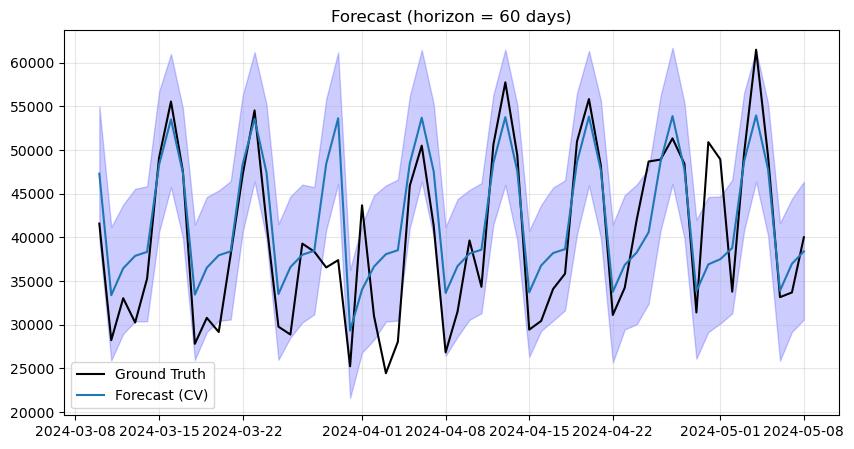


Test set metrics:
RMSE = 5827.59
MAE  = 4501.20


C:\Users\andre\AppData\Local\Temp\ipykernel_37676\3117658327.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_final["pre_covid"] = (train_final["ds"] < cutoff_date).astype(int)
C:\Users\andre\AppData\Local\Temp\ipykernel_37676\3117658327.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_final["post_covid"] = (train_final["ds"] >= cutoff_date).astype(int)
17:16:22 - cmdstanpy - INFO - Chain [1] start processing
17:16:22 - cmdstanpy - INFO - Chain [1] done processing



Model components:


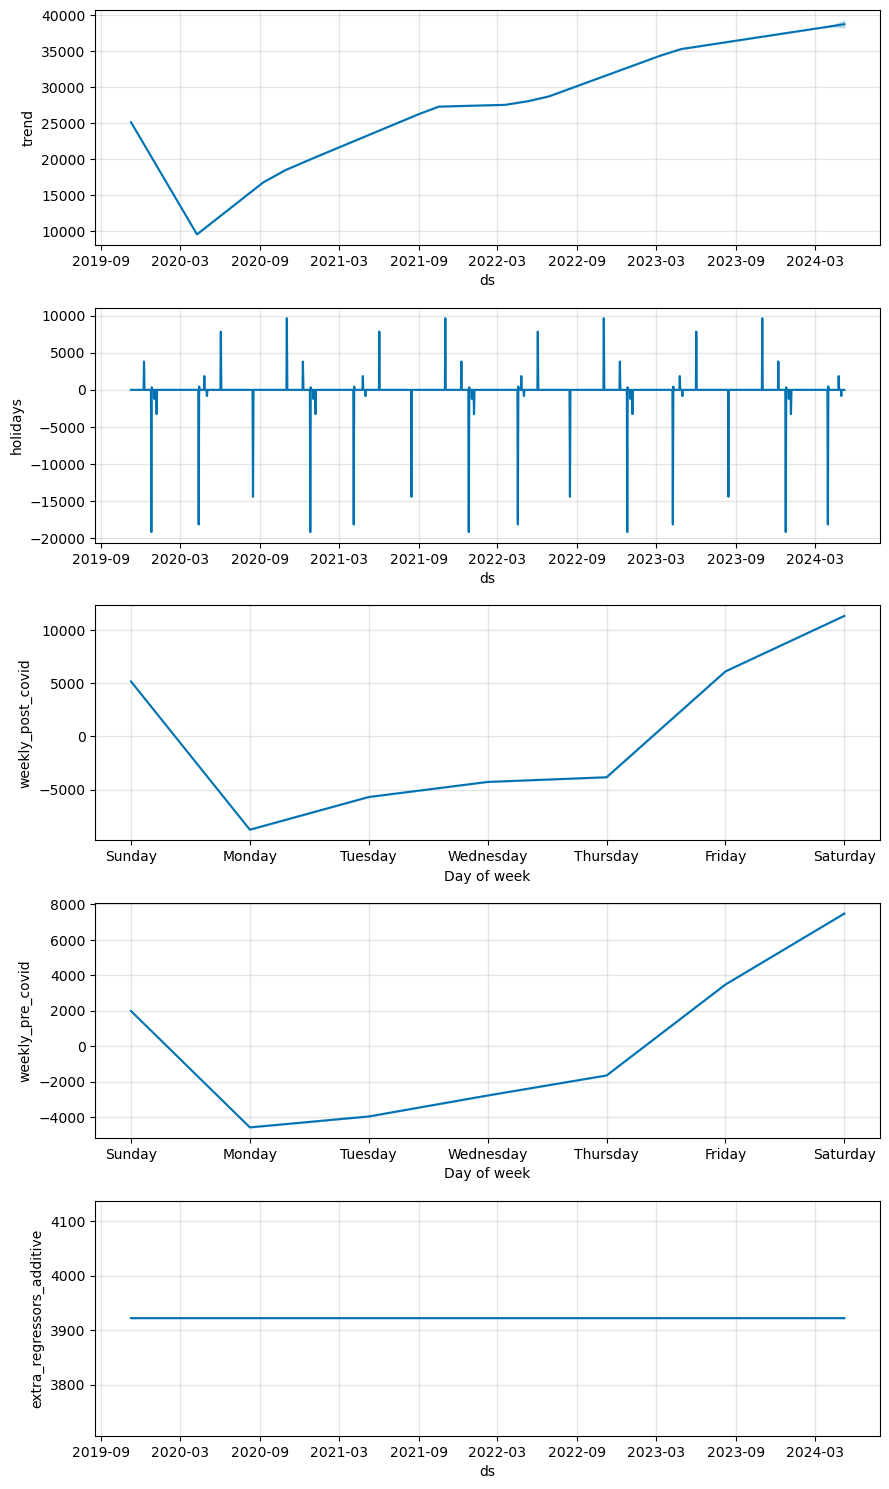

In [77]:
results = fit_prophet_model(
    df=df,
    y_col='totale',
    ds_col='data',
    regressors= covid_regr[1],
    n_test=60,
    weekly=False,
    monthly=False,
    yearly=False,
    weekly_prepost=True,
    holidays=True,
    verbose = True,
    return_results = True)

In [78]:
with open("models/prophet_model_totale_restaurant_6.json", "w") as f:
    f.write(model_to_json(results["model"]))

# FURTHER INFORMATION ON COVID REGRESSORS
as the plot it is not really informative

In [94]:
m_final = results['model']

In [95]:
print(list(m_final.train_component_cols.keys()))

['Assunzione della Vergine', 'Capodanno', 'Epifania del Signore', 'Festa dei Lavoratori', 'Festa della Liberazione', 'Festa della Repubblica', 'Immacolata Concezione', "Lunedì dell'Angelo", 'Natale', 'Pasqua di Resurrezione', 'Santo Stefano', 'Tutti i Santi', 'additive_terms', 'dummy_emilia_full_open', 'dummy_emilia_restricted_open', 'dummy_emilia_takeaway_only', 'extra_regressors_additive', 'holidays', 'weekly_post_covid', 'weekly_pre_covid', 'multiplicative_terms']


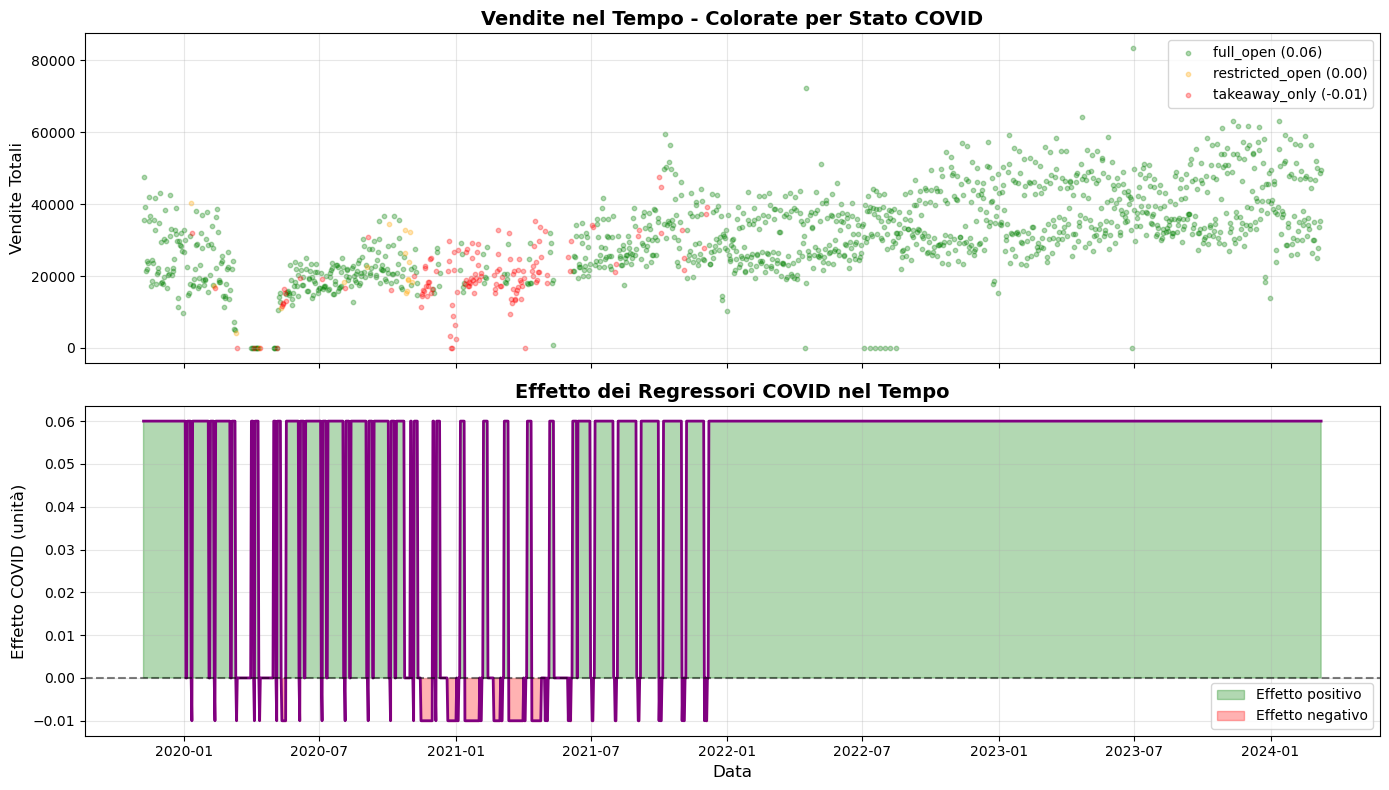


DISTRIBUZIONE TEMPORALE DEGLI STATI COVID
full_open           : 1280 giorni ( 80.8%)
restricted_open     :   17 giorni (  1.1%)
takeaway_only       :  138 giorni (  8.7%)


In [ ]:

last_cutoff = results['cv_results']["cutoff"].max()
df['data'] = pd.to_datetime(df['data'])
train_data = df[df["data"] <= last_cutoff].copy()

# Effetti delle dummy
effetti = {
    'dummy_emilia_full_open': 0.06,
    'dummy_emilia_restricted_open': 0.00,
    'dummy_emilia_takeaway_only': -0.01
}

# Crea una colonna con lo stato attivo e il suo effetto
train_data['stato_attivo'] = 'unknown'
train_data['effetto_covid'] = 0.0

for col, effetto in effetti.items():
    if col in train_data.columns:
        mask = train_data[col] == 1
        train_data.loc[mask, 'stato_attivo'] = col.replace('dummy_emilia_', '')
        train_data.loc[mask, 'effetto_covid'] = effetto

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot 1: Vendite reali con colori per stato COVID
colors_map = {
    'full_open': 'green',
    'restricted_open': 'orange',
    'takeaway_only': 'red'
}

for stato, color in colors_map.items():
    mask = train_data['stato_attivo'] == stato
    if mask.sum() > 0:  # Solo se ci sono dati per questo stato
        ax1.scatter(train_data.loc[mask, "data"], train_data.loc[mask, "totale"], 
                    c=color, alpha=0.3, s=10, label=f'{stato} ({effetti["dummy_emilia_"+stato]:.2f})')

ax1.set_ylabel('Vendite Totali', fontsize=12)
ax1.set_title('Vendite nel Tempo - Colorate per Stato COVID', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Effetto COVID nel tempo
ax2.plot(train_data["data"], train_data['effetto_covid'], linewidth=2, color='purple')
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.fill_between(train_data["data"], 0, train_data['effetto_covid'], 
                  where=(train_data['effetto_covid'] >= 0), alpha=0.3, color='green', label='Effetto positivo')
ax2.fill_between(train_data["data"], 0, train_data['effetto_covid'], 
                  where=(train_data['effetto_covid'] < 0), alpha=0.3, color='red', label='Effetto negativo')

ax2.set_xlabel('Data', fontsize=12)
ax2.set_ylabel('Effetto COVID (unità)', fontsize=12)
ax2.set_title('Effetto dei Regressori COVID nel Tempo', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiche per periodo
print("\n" + "="*70)
print("DISTRIBUZIONE TEMPORALE DEGLI STATI COVID")
print("="*70)
for stato in ['full_open', 'restricted_open', 'takeaway_only']:
    mask = train_data['stato_attivo'] == stato
    n_giorni = mask.sum()
    perc = (n_giorni / len(train_data)) * 100
    print(f"{stato:20s}: {n_giorni:4d} giorni ({perc:5.1f}%)")

# SCONTRINI

In [12]:
weekly_seas = [True, False]
monthly_seas = [True, False]
yearly_seas = [True, False]
weekly_prepost_seas = [True, False]
holiday_regr = [True, False]
covid_regr = [None, ['dummy_emilia_full_open', 'dummy_emilia_restricted_open', 'dummy_emilia_takeaway_only'], 
                    ['dummy_lombardia_full_open', 'dummy_lombardia_restricted_open', 'dummy_lombardia_takeaway_only']]

param_grid = itertools.product(
    weekly_seas,
    monthly_seas,
    yearly_seas,
    weekly_prepost_seas,
    holiday_regr,
    covid_regr
)

## GRID SEARCH ON DF1

In [106]:
df = pd.read_csv('data/restaurant_1.csv')

results = []

for (w, m, y, wp, h, covid) in param_grid:
    print(f"\n Testing with: weekly={w}, monthly={m}, yearly={y}, prepost={wp}, holidays={h}, covid={covid is not None}")
    
    
        # Fit Prophet
    res = fit_prophet_model(
            df=df,
            y_col="scontrini",
            ds_col="data",
            n_test=60,
            weekly=w,
            monthly=m,
            yearly=y,
            weekly_prepost=wp,
            holidays=h,
            regressors=covid,
            verbose=False,
            return_results=True
    )

        
    metrics_last = res["metrics_last_window"]
    cv_metrics = res["metrics_cv"]
    rmse_cv_mean = cv_metrics["rmse"].mean()
    mae_cv_mean = cv_metrics["mae"].mean()
      
    results.append({
            "weekly": w,
            "monthly": m,
            "yearly": y,
            "weekly_prepost": wp,
            "holidays": h,
            "covid_regressors": covid,
            "RMSE_last": metrics_last["RMSE"],
            "MAE_last": metrics_last["MAE"],
            "RMSE_cv_mean": rmse_cv_mean,
            "MAE_cv_mean": mae_cv_mean
    })


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=True, covid=False


18:07:18 - cmdstanpy - INFO - Chain [1] start processing
18:07:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:07:19 - cmdstanpy - INFO - Chain [1] start processing
18:07:19 - cmdstanpy - INFO - Chain [1] done processing
18:07:20 - cmdstanpy - INFO - Chain [1] start processing
18:07:20 - cmdstanpy - INFO - Chain [1] done processing
18:07:20 - cmdstanpy - INFO - Chain [1] start processing
18:07:20 - cmdstanpy - INFO - Chain [1] done processing
18:07:21 - cmdstanpy - INFO - Chain [1] start processing
18:07:21 - cmdstanpy - INFO - Chain [1] done processing
18:07:21 - cmdstanpy - INFO - Chain [1] start processing
18:07:21 - cmdstanpy - INFO - Chain [1] done processing
18:07:22 - cmdstanpy - INFO - Chain [1] start processing
18:07:22 - cmdstanpy - INFO - Chain [1] done processing
18:07:22 - cmdstanpy - INFO - Chain [1] start processing
18:07:22 - cmdstanpy - INFO - Chain [1] done processing
18:07:22 - cmdstanpy - INFO - Chain [1] start processing
18:07:23 - cmdstanpy - INFO - Chain [1] done processing
18:07:23 - cmdstanpy - INFO - Chain [1] start processing
18:07:23 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


18:07:36 - cmdstanpy - INFO - Chain [1] start processing
18:07:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:07:37 - cmdstanpy - INFO - Chain [1] start processing
18:07:37 - cmdstanpy - INFO - Chain [1] done processing
18:07:38 - cmdstanpy - INFO - Chain [1] start processing
18:07:38 - cmdstanpy - INFO - Chain [1] done processing
18:07:38 - cmdstanpy - INFO - Chain [1] start processing
18:07:38 - cmdstanpy - INFO - Chain [1] done processing
18:07:39 - cmdstanpy - INFO - Chain [1] start processing
18:07:39 - cmdstanpy - INFO - Chain [1] done processing
18:07:40 - cmdstanpy - INFO - Chain [1] start processing
18:07:40 - cmdstanpy - INFO - Chain [1] done processing
18:07:40 - cmdstanpy - INFO - Chain [1] start processing
18:07:40 - cmdstanpy - INFO - Chain [1] done processing
18:07:41 - cmdstanpy - INFO - Chain [1] start processing
18:07:41 - cmdstanpy - INFO - Chain [1] done processing
18:07:41 - cmdstanpy - INFO - Chain [1] start processing
18:07:42 - cmdstanpy - INFO - Chain [1] done processing
18:07:42 - cmdstanpy - INFO - Chain [1] start processing
18:07:42 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


18:07:55 - cmdstanpy - INFO - Chain [1] start processing
18:07:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:07:56 - cmdstanpy - INFO - Chain [1] start processing
18:07:57 - cmdstanpy - INFO - Chain [1] done processing
18:07:57 - cmdstanpy - INFO - Chain [1] start processing
18:07:57 - cmdstanpy - INFO - Chain [1] done processing
18:07:58 - cmdstanpy - INFO - Chain [1] start processing
18:07:58 - cmdstanpy - INFO - Chain [1] done processing
18:07:58 - cmdstanpy - INFO - Chain [1] start processing
18:07:58 - cmdstanpy - INFO - Chain [1] done processing
18:07:59 - cmdstanpy - INFO - Chain [1] start processing
18:07:59 - cmdstanpy - INFO - Chain [1] done processing
18:08:00 - cmdstanpy - INFO - Chain [1] start processing
18:08:00 - cmdstanpy - INFO - Chain [1] done processing
18:08:00 - cmdstanpy - INFO - Chain [1] start processing
18:08:01 - cmdstanpy - INFO - Chain [1] done processing
18:08:01 - cmdstanpy - INFO - Chain [1] start processing
18:08:02 - cmdstanpy - INFO - Chain [1] done processing
18:08:02 - cmdstanpy - INFO - Chain [1] start processing
18:08:02 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=False, covid=False


18:08:17 - cmdstanpy - INFO - Chain [1] start processing
18:08:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:08:18 - cmdstanpy - INFO - Chain [1] start processing
18:08:18 - cmdstanpy - INFO - Chain [1] done processing
18:08:18 - cmdstanpy - INFO - Chain [1] start processing
18:08:18 - cmdstanpy - INFO - Chain [1] done processing
18:08:18 - cmdstanpy - INFO - Chain [1] start processing
18:08:18 - cmdstanpy - INFO - Chain [1] done processing
18:08:19 - cmdstanpy - INFO - Chain [1] start processing
18:08:19 - cmdstanpy - INFO - Chain [1] done processing
18:08:19 - cmdstanpy - INFO - Chain [1] start processing
18:08:19 - cmdstanpy - INFO - Chain [1] done processing
18:08:19 - cmdstanpy - INFO - Chain [1] start processing
18:08:19 - cmdstanpy - INFO - Chain [1] done processing
18:08:20 - cmdstanpy - INFO - Chain [1] start processing
18:08:20 - cmdstanpy - INFO - Chain [1] done processing
18:08:20 - cmdstanpy - INFO - Chain [1] start processing
18:08:20 - cmdstanpy - INFO - Chain [1] done processing
18:08:21 - cmdstanpy - INFO - Chain [1] start processing
18:08:21 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


18:08:31 - cmdstanpy - INFO - Chain [1] start processing
18:08:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:08:31 - cmdstanpy - INFO - Chain [1] start processing
18:08:31 - cmdstanpy - INFO - Chain [1] done processing
18:08:31 - cmdstanpy - INFO - Chain [1] start processing
18:08:31 - cmdstanpy - INFO - Chain [1] done processing
18:08:32 - cmdstanpy - INFO - Chain [1] start processing
18:08:32 - cmdstanpy - INFO - Chain [1] done processing
18:08:32 - cmdstanpy - INFO - Chain [1] start processing
18:08:32 - cmdstanpy - INFO - Chain [1] done processing
18:08:32 - cmdstanpy - INFO - Chain [1] start processing
18:08:33 - cmdstanpy - INFO - Chain [1] done processing
18:08:33 - cmdstanpy - INFO - Chain [1] start processing
18:08:33 - cmdstanpy - INFO - Chain [1] done processing
18:08:33 - cmdstanpy - INFO - Chain [1] start processing
18:08:33 - cmdstanpy - INFO - Chain [1] done processing
18:08:34 - cmdstanpy - INFO - Chain [1] start processing
18:08:34 - cmdstanpy - INFO - Chain [1] done processing
18:08:34 - cmdstanpy - INFO - Chain [1] start processing
18:08:34 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


18:08:46 - cmdstanpy - INFO - Chain [1] start processing
18:08:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:08:46 - cmdstanpy - INFO - Chain [1] start processing
18:08:46 - cmdstanpy - INFO - Chain [1] done processing
18:08:47 - cmdstanpy - INFO - Chain [1] start processing
18:08:47 - cmdstanpy - INFO - Chain [1] done processing
18:08:47 - cmdstanpy - INFO - Chain [1] start processing
18:08:47 - cmdstanpy - INFO - Chain [1] done processing
18:08:48 - cmdstanpy - INFO - Chain [1] start processing
18:08:48 - cmdstanpy - INFO - Chain [1] done processing
18:08:48 - cmdstanpy - INFO - Chain [1] start processing
18:08:48 - cmdstanpy - INFO - Chain [1] done processing
18:08:49 - cmdstanpy - INFO - Chain [1] start processing
18:08:49 - cmdstanpy - INFO - Chain [1] done processing
18:08:49 - cmdstanpy - INFO - Chain [1] start processing
18:08:50 - cmdstanpy - INFO - Chain [1] done processing
18:08:50 - cmdstanpy - INFO - Chain [1] start processing
18:08:50 - cmdstanpy - INFO - Chain [1] done processing
18:08:51 - cmdstanpy - INFO - Chain [1] start processing
18:08:51 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=True, covid=False


18:09:03 - cmdstanpy - INFO - Chain [1] start processing
18:09:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:09:04 - cmdstanpy - INFO - Chain [1] start processing
18:09:04 - cmdstanpy - INFO - Chain [1] done processing
18:09:04 - cmdstanpy - INFO - Chain [1] start processing
18:09:04 - cmdstanpy - INFO - Chain [1] done processing
18:09:05 - cmdstanpy - INFO - Chain [1] start processing
18:09:05 - cmdstanpy - INFO - Chain [1] done processing
18:09:05 - cmdstanpy - INFO - Chain [1] start processing
18:09:05 - cmdstanpy - INFO - Chain [1] done processing
18:09:06 - cmdstanpy - INFO - Chain [1] start processing
18:09:06 - cmdstanpy - INFO - Chain [1] done processing
18:09:06 - cmdstanpy - INFO - Chain [1] start processing
18:09:07 - cmdstanpy - INFO - Chain [1] done processing
18:09:07 - cmdstanpy - INFO - Chain [1] start processing
18:09:07 - cmdstanpy - INFO - Chain [1] done processing
18:09:07 - cmdstanpy - INFO - Chain [1] start processing
18:09:07 - cmdstanpy - INFO - Chain [1] done processing
18:09:08 - cmdstanpy - INFO - Chain [1] start processing
18:09:08 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


18:09:19 - cmdstanpy - INFO - Chain [1] start processing
18:09:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:09:20 - cmdstanpy - INFO - Chain [1] start processing
18:09:20 - cmdstanpy - INFO - Chain [1] done processing
18:09:20 - cmdstanpy - INFO - Chain [1] start processing
18:09:21 - cmdstanpy - INFO - Chain [1] done processing
18:09:21 - cmdstanpy - INFO - Chain [1] start processing
18:09:21 - cmdstanpy - INFO - Chain [1] done processing
18:09:21 - cmdstanpy - INFO - Chain [1] start processing
18:09:22 - cmdstanpy - INFO - Chain [1] done processing
18:09:22 - cmdstanpy - INFO - Chain [1] start processing
18:09:22 - cmdstanpy - INFO - Chain [1] done processing
18:09:23 - cmdstanpy - INFO - Chain [1] start processing
18:09:23 - cmdstanpy - INFO - Chain [1] done processing
18:09:24 - cmdstanpy - INFO - Chain [1] start processing
18:09:24 - cmdstanpy - INFO - Chain [1] done processing
18:09:24 - cmdstanpy - INFO - Chain [1] start processing
18:09:25 - cmdstanpy - INFO - Chain [1] done processing
18:09:25 - cmdstanpy - INFO - Chain [1] start processing
18:09:25 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


18:09:37 - cmdstanpy - INFO - Chain [1] start processing
18:09:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:09:38 - cmdstanpy - INFO - Chain [1] start processing
18:09:38 - cmdstanpy - INFO - Chain [1] done processing
18:09:39 - cmdstanpy - INFO - Chain [1] start processing
18:09:39 - cmdstanpy - INFO - Chain [1] done processing
18:09:39 - cmdstanpy - INFO - Chain [1] start processing
18:09:39 - cmdstanpy - INFO - Chain [1] done processing
18:09:40 - cmdstanpy - INFO - Chain [1] start processing
18:09:40 - cmdstanpy - INFO - Chain [1] done processing
18:09:40 - cmdstanpy - INFO - Chain [1] start processing
18:09:40 - cmdstanpy - INFO - Chain [1] done processing
18:09:41 - cmdstanpy - INFO - Chain [1] start processing
18:09:41 - cmdstanpy - INFO - Chain [1] done processing
18:09:41 - cmdstanpy - INFO - Chain [1] start processing
18:09:42 - cmdstanpy - INFO - Chain [1] done processing
18:09:42 - cmdstanpy - INFO - Chain [1] start processing
18:09:42 - cmdstanpy - INFO - Chain [1] done processing
18:09:43 - cmdstanpy - INFO - Chain [1] start processing
18:09:43 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=False, covid=False


18:09:54 - cmdstanpy - INFO - Chain [1] start processing
18:09:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:09:55 - cmdstanpy - INFO - Chain [1] start processing
18:09:55 - cmdstanpy - INFO - Chain [1] done processing
18:09:56 - cmdstanpy - INFO - Chain [1] start processing
18:09:56 - cmdstanpy - INFO - Chain [1] done processing
18:09:56 - cmdstanpy - INFO - Chain [1] start processing
18:09:56 - cmdstanpy - INFO - Chain [1] done processing
18:09:56 - cmdstanpy - INFO - Chain [1] start processing
18:09:57 - cmdstanpy - INFO - Chain [1] done processing
18:09:57 - cmdstanpy - INFO - Chain [1] start processing
18:09:57 - cmdstanpy - INFO - Chain [1] done processing
18:09:58 - cmdstanpy - INFO - Chain [1] start processing
18:09:58 - cmdstanpy - INFO - Chain [1] done processing
18:09:58 - cmdstanpy - INFO - Chain [1] start processing
18:09:58 - cmdstanpy - INFO - Chain [1] done processing
18:09:59 - cmdstanpy - INFO - Chain [1] start processing
18:09:59 - cmdstanpy - INFO - Chain [1] done processing
18:09:59 - cmdstanpy - INFO - Chain [1] start processing
18:09:59 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


18:10:08 - cmdstanpy - INFO - Chain [1] start processing
18:10:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:10:09 - cmdstanpy - INFO - Chain [1] start processing
18:10:09 - cmdstanpy - INFO - Chain [1] done processing
18:10:10 - cmdstanpy - INFO - Chain [1] start processing
18:10:10 - cmdstanpy - INFO - Chain [1] done processing
18:10:10 - cmdstanpy - INFO - Chain [1] start processing
18:10:10 - cmdstanpy - INFO - Chain [1] done processing
18:10:10 - cmdstanpy - INFO - Chain [1] start processing
18:10:11 - cmdstanpy - INFO - Chain [1] done processing
18:10:11 - cmdstanpy - INFO - Chain [1] start processing
18:10:11 - cmdstanpy - INFO - Chain [1] done processing
18:10:12 - cmdstanpy - INFO - Chain [1] start processing
18:10:12 - cmdstanpy - INFO - Chain [1] done processing
18:10:12 - cmdstanpy - INFO - Chain [1] start processing
18:10:12 - cmdstanpy - INFO - Chain [1] done processing
18:10:12 - cmdstanpy - INFO - Chain [1] start processing
18:10:13 - cmdstanpy - INFO - Chain [1] done processing
18:10:13 - cmdstanpy - INFO - Chain [1] start processing
18:10:13 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


18:10:23 - cmdstanpy - INFO - Chain [1] start processing
18:10:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:10:24 - cmdstanpy - INFO - Chain [1] start processing
18:10:24 - cmdstanpy - INFO - Chain [1] done processing
18:10:24 - cmdstanpy - INFO - Chain [1] start processing
18:10:25 - cmdstanpy - INFO - Chain [1] done processing
18:10:25 - cmdstanpy - INFO - Chain [1] start processing
18:10:25 - cmdstanpy - INFO - Chain [1] done processing
18:10:25 - cmdstanpy - INFO - Chain [1] start processing
18:10:26 - cmdstanpy - INFO - Chain [1] done processing
18:10:26 - cmdstanpy - INFO - Chain [1] start processing
18:10:26 - cmdstanpy - INFO - Chain [1] done processing
18:10:27 - cmdstanpy - INFO - Chain [1] start processing
18:10:27 - cmdstanpy - INFO - Chain [1] done processing
18:10:27 - cmdstanpy - INFO - Chain [1] start processing
18:10:28 - cmdstanpy - INFO - Chain [1] done processing
18:10:28 - cmdstanpy - INFO - Chain [1] start processing
18:10:28 - cmdstanpy - INFO - Chain [1] done processing
18:10:29 - cmdstanpy - INFO - Chain [1] start processing
18:10:29 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=True, covid=False


18:10:38 - cmdstanpy - INFO - Chain [1] start processing
18:10:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:10:38 - cmdstanpy - INFO - Chain [1] start processing
18:10:39 - cmdstanpy - INFO - Chain [1] done processing
18:10:39 - cmdstanpy - INFO - Chain [1] start processing
18:10:39 - cmdstanpy - INFO - Chain [1] done processing
18:10:39 - cmdstanpy - INFO - Chain [1] start processing
18:10:39 - cmdstanpy - INFO - Chain [1] done processing
18:10:40 - cmdstanpy - INFO - Chain [1] start processing
18:10:40 - cmdstanpy - INFO - Chain [1] done processing
18:10:40 - cmdstanpy - INFO - Chain [1] start processing
18:10:40 - cmdstanpy - INFO - Chain [1] done processing
18:10:40 - cmdstanpy - INFO - Chain [1] start processing
18:10:41 - cmdstanpy - INFO - Chain [1] done processing
18:10:41 - cmdstanpy - INFO - Chain [1] start processing
18:10:41 - cmdstanpy - INFO - Chain [1] done processing
18:10:41 - cmdstanpy - INFO - Chain [1] start processing
18:10:41 - cmdstanpy - INFO - Chain [1] done processing
18:10:42 - cmdstanpy - INFO - Chain [1] start processing
18:10:42 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


18:10:51 - cmdstanpy - INFO - Chain [1] start processing
18:10:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:10:51 - cmdstanpy - INFO - Chain [1] start processing
18:10:52 - cmdstanpy - INFO - Chain [1] done processing
18:10:52 - cmdstanpy - INFO - Chain [1] start processing
18:10:52 - cmdstanpy - INFO - Chain [1] done processing
18:10:52 - cmdstanpy - INFO - Chain [1] start processing
18:10:53 - cmdstanpy - INFO - Chain [1] done processing
18:10:53 - cmdstanpy - INFO - Chain [1] start processing
18:10:53 - cmdstanpy - INFO - Chain [1] done processing
18:10:53 - cmdstanpy - INFO - Chain [1] start processing
18:10:53 - cmdstanpy - INFO - Chain [1] done processing
18:10:53 - cmdstanpy - INFO - Chain [1] start processing
18:10:54 - cmdstanpy - INFO - Chain [1] done processing
18:10:54 - cmdstanpy - INFO - Chain [1] start processing
18:10:54 - cmdstanpy - INFO - Chain [1] done processing
18:10:54 - cmdstanpy - INFO - Chain [1] start processing
18:10:55 - cmdstanpy - INFO - Chain [1] done processing
18:10:55 - cmdstanpy - INFO - Chain [1] start processing
18:10:55 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


18:11:04 - cmdstanpy - INFO - Chain [1] start processing
18:11:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:11:05 - cmdstanpy - INFO - Chain [1] start processing
18:11:05 - cmdstanpy - INFO - Chain [1] done processing
18:11:05 - cmdstanpy - INFO - Chain [1] start processing
18:11:05 - cmdstanpy - INFO - Chain [1] done processing
18:11:06 - cmdstanpy - INFO - Chain [1] start processing
18:11:06 - cmdstanpy - INFO - Chain [1] done processing
18:11:06 - cmdstanpy - INFO - Chain [1] start processing
18:11:06 - cmdstanpy - INFO - Chain [1] done processing
18:11:06 - cmdstanpy - INFO - Chain [1] start processing
18:11:06 - cmdstanpy - INFO - Chain [1] done processing
18:11:07 - cmdstanpy - INFO - Chain [1] start processing
18:11:07 - cmdstanpy - INFO - Chain [1] done processing
18:11:07 - cmdstanpy - INFO - Chain [1] start processing
18:11:07 - cmdstanpy - INFO - Chain [1] done processing
18:11:08 - cmdstanpy - INFO - Chain [1] start processing
18:11:08 - cmdstanpy - INFO - Chain [1] done processing
18:11:08 - cmdstanpy - INFO - Chain [1] start processing
18:11:08 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=False, covid=False


18:11:19 - cmdstanpy - INFO - Chain [1] start processing
18:11:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:11:20 - cmdstanpy - INFO - Chain [1] start processing
18:11:20 - cmdstanpy - INFO - Chain [1] done processing
18:11:20 - cmdstanpy - INFO - Chain [1] start processing
18:11:20 - cmdstanpy - INFO - Chain [1] done processing
18:11:21 - cmdstanpy - INFO - Chain [1] start processing
18:11:21 - cmdstanpy - INFO - Chain [1] done processing
18:11:21 - cmdstanpy - INFO - Chain [1] start processing
18:11:21 - cmdstanpy - INFO - Chain [1] done processing
18:11:21 - cmdstanpy - INFO - Chain [1] start processing
18:11:22 - cmdstanpy - INFO - Chain [1] done processing
18:11:22 - cmdstanpy - INFO - Chain [1] start processing
18:11:22 - cmdstanpy - INFO - Chain [1] done processing
18:11:23 - cmdstanpy - INFO - Chain [1] start processing
18:11:23 - cmdstanpy - INFO - Chain [1] done processing
18:11:23 - cmdstanpy - INFO - Chain [1] start processing
18:11:23 - cmdstanpy - INFO - Chain [1] done processing
18:11:24 - cmdstanpy - INFO - Chain [1] start processing
18:11:24 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


18:11:34 - cmdstanpy - INFO - Chain [1] start processing
18:11:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:11:35 - cmdstanpy - INFO - Chain [1] start processing
18:11:35 - cmdstanpy - INFO - Chain [1] done processing
18:11:35 - cmdstanpy - INFO - Chain [1] start processing
18:11:35 - cmdstanpy - INFO - Chain [1] done processing
18:11:36 - cmdstanpy - INFO - Chain [1] start processing
18:11:36 - cmdstanpy - INFO - Chain [1] done processing
18:11:36 - cmdstanpy - INFO - Chain [1] start processing
18:11:36 - cmdstanpy - INFO - Chain [1] done processing
18:11:37 - cmdstanpy - INFO - Chain [1] start processing
18:11:37 - cmdstanpy - INFO - Chain [1] done processing
18:11:37 - cmdstanpy - INFO - Chain [1] start processing
18:11:37 - cmdstanpy - INFO - Chain [1] done processing
18:11:38 - cmdstanpy - INFO - Chain [1] start processing
18:11:38 - cmdstanpy - INFO - Chain [1] done processing
18:11:38 - cmdstanpy - INFO - Chain [1] start processing
18:11:38 - cmdstanpy - INFO - Chain [1] done processing
18:11:38 - cmdstanpy - INFO - Chain [1] start processing
18:11:39 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


18:11:47 - cmdstanpy - INFO - Chain [1] start processing
18:11:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:11:47 - cmdstanpy - INFO - Chain [1] start processing
18:11:48 - cmdstanpy - INFO - Chain [1] done processing
18:11:48 - cmdstanpy - INFO - Chain [1] start processing
18:11:48 - cmdstanpy - INFO - Chain [1] done processing
18:11:48 - cmdstanpy - INFO - Chain [1] start processing
18:11:48 - cmdstanpy - INFO - Chain [1] done processing
18:11:48 - cmdstanpy - INFO - Chain [1] start processing
18:11:49 - cmdstanpy - INFO - Chain [1] done processing
18:11:49 - cmdstanpy - INFO - Chain [1] start processing
18:11:49 - cmdstanpy - INFO - Chain [1] done processing
18:11:49 - cmdstanpy - INFO - Chain [1] start processing
18:11:49 - cmdstanpy - INFO - Chain [1] done processing
18:11:49 - cmdstanpy - INFO - Chain [1] start processing
18:11:50 - cmdstanpy - INFO - Chain [1] done processing
18:11:50 - cmdstanpy - INFO - Chain [1] start processing
18:11:50 - cmdstanpy - INFO - Chain [1] done processing
18:11:50 - cmdstanpy - INFO - Chain [1] start processing
18:11:50 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=True, covid=False


18:11:59 - cmdstanpy - INFO - Chain [1] start processing
18:11:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:11:59 - cmdstanpy - INFO - Chain [1] start processing
18:12:00 - cmdstanpy - INFO - Chain [1] done processing
18:12:00 - cmdstanpy - INFO - Chain [1] start processing
18:12:00 - cmdstanpy - INFO - Chain [1] done processing
18:12:00 - cmdstanpy - INFO - Chain [1] start processing
18:12:00 - cmdstanpy - INFO - Chain [1] done processing
18:12:01 - cmdstanpy - INFO - Chain [1] start processing
18:12:01 - cmdstanpy - INFO - Chain [1] done processing
18:12:01 - cmdstanpy - INFO - Chain [1] start processing
18:12:01 - cmdstanpy - INFO - Chain [1] done processing
18:12:02 - cmdstanpy - INFO - Chain [1] start processing
18:12:02 - cmdstanpy - INFO - Chain [1] done processing
18:12:02 - cmdstanpy - INFO - Chain [1] start processing
18:12:02 - cmdstanpy - INFO - Chain [1] done processing
18:12:02 - cmdstanpy - INFO - Chain [1] start processing
18:12:03 - cmdstanpy - INFO - Chain [1] done processing
18:12:03 - cmdstanpy - INFO - Chain [1] start processing
18:12:03 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


18:12:14 - cmdstanpy - INFO - Chain [1] start processing
18:12:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:12:14 - cmdstanpy - INFO - Chain [1] start processing
18:12:14 - cmdstanpy - INFO - Chain [1] done processing
18:12:15 - cmdstanpy - INFO - Chain [1] start processing
18:12:15 - cmdstanpy - INFO - Chain [1] done processing
18:12:15 - cmdstanpy - INFO - Chain [1] start processing
18:12:15 - cmdstanpy - INFO - Chain [1] done processing
18:12:15 - cmdstanpy - INFO - Chain [1] start processing
18:12:15 - cmdstanpy - INFO - Chain [1] done processing
18:12:16 - cmdstanpy - INFO - Chain [1] start processing
18:12:16 - cmdstanpy - INFO - Chain [1] done processing
18:12:16 - cmdstanpy - INFO - Chain [1] start processing
18:12:16 - cmdstanpy - INFO - Chain [1] done processing
18:12:16 - cmdstanpy - INFO - Chain [1] start processing
18:12:17 - cmdstanpy - INFO - Chain [1] done processing
18:12:17 - cmdstanpy - INFO - Chain [1] start processing
18:12:17 - cmdstanpy - INFO - Chain [1] done processing
18:12:17 - cmdstanpy - INFO - Chain [1] start processing
18:12:18 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


18:12:25 - cmdstanpy - INFO - Chain [1] start processing
18:12:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:12:26 - cmdstanpy - INFO - Chain [1] start processing
18:12:26 - cmdstanpy - INFO - Chain [1] done processing
18:12:26 - cmdstanpy - INFO - Chain [1] start processing
18:12:26 - cmdstanpy - INFO - Chain [1] done processing
18:12:27 - cmdstanpy - INFO - Chain [1] start processing
18:12:27 - cmdstanpy - INFO - Chain [1] done processing
18:12:27 - cmdstanpy - INFO - Chain [1] start processing
18:12:27 - cmdstanpy - INFO - Chain [1] done processing
18:12:27 - cmdstanpy - INFO - Chain [1] start processing
18:12:28 - cmdstanpy - INFO - Chain [1] done processing
18:12:28 - cmdstanpy - INFO - Chain [1] start processing
18:12:28 - cmdstanpy - INFO - Chain [1] done processing
18:12:29 - cmdstanpy - INFO - Chain [1] start processing
18:12:29 - cmdstanpy - INFO - Chain [1] done processing
18:12:29 - cmdstanpy - INFO - Chain [1] start processing
18:12:29 - cmdstanpy - INFO - Chain [1] done processing
18:12:30 - cmdstanpy - INFO - Chain [1] start processing
18:12:30 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=False, covid=False


18:12:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:12:40 - cmdstanpy - INFO - Chain [1] start processing
18:12:40 - cmdstanpy - INFO - Chain [1] done processing
18:12:40 - cmdstanpy - INFO - Chain [1] start processing
18:12:41 - cmdstanpy - INFO - Chain [1] done processing
18:12:41 - cmdstanpy - INFO - Chain [1] start processing
18:12:41 - cmdstanpy - INFO - Chain [1] done processing
18:12:41 - cmdstanpy - INFO - Chain [1] start processing
18:12:41 - cmdstanpy - INFO - Chain [1] done processing
18:12:41 - cmdstanpy - INFO - Chain [1] start processing
18:12:41 - cmdstanpy - INFO - Chain [1] done processing
18:12:42 - cmdstanpy - INFO - Chain [1] start processing
18:12:42 - cmdstanpy - INFO - Chain [1] done processing
18:12:42 - cmdstanpy - INFO - Chain [1] start processing
18:12:42 - cmdstanpy - INFO - Chain [1] done processing
18:12:42 - cmdstanpy - INFO - Chain [1] start processing
18:12:42 - cmdstanpy - INFO - Chain [1] done processing
18:12:43 - cmdstanpy - INFO - Chain [1] start processing
18:12:43 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


18:12:51 - cmdstanpy - INFO - Chain [1] start processing
18:12:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:12:52 - cmdstanpy - INFO - Chain [1] start processing
18:12:52 - cmdstanpy - INFO - Chain [1] done processing
18:12:52 - cmdstanpy - INFO - Chain [1] start processing
18:12:52 - cmdstanpy - INFO - Chain [1] done processing
18:12:52 - cmdstanpy - INFO - Chain [1] start processing
18:12:52 - cmdstanpy - INFO - Chain [1] done processing
18:12:52 - cmdstanpy - INFO - Chain [1] start processing
18:12:53 - cmdstanpy - INFO - Chain [1] done processing
18:12:53 - cmdstanpy - INFO - Chain [1] start processing
18:12:53 - cmdstanpy - INFO - Chain [1] done processing
18:12:53 - cmdstanpy - INFO - Chain [1] start processing
18:12:54 - cmdstanpy - INFO - Chain [1] done processing
18:12:54 - cmdstanpy - INFO - Chain [1] start processing
18:12:54 - cmdstanpy - INFO - Chain [1] done processing
18:12:54 - cmdstanpy - INFO - Chain [1] start processing
18:12:55 - cmdstanpy - INFO - Chain [1] done processing
18:12:55 - cmdstanpy - INFO - Chain [1] start processing
18:12:55 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


18:13:05 - cmdstanpy - INFO - Chain [1] start processing
18:13:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:13:06 - cmdstanpy - INFO - Chain [1] start processing
18:13:06 - cmdstanpy - INFO - Chain [1] done processing
18:13:06 - cmdstanpy - INFO - Chain [1] start processing
18:13:06 - cmdstanpy - INFO - Chain [1] done processing
18:13:07 - cmdstanpy - INFO - Chain [1] start processing
18:13:07 - cmdstanpy - INFO - Chain [1] done processing
18:13:07 - cmdstanpy - INFO - Chain [1] start processing
18:13:07 - cmdstanpy - INFO - Chain [1] done processing
18:13:08 - cmdstanpy - INFO - Chain [1] start processing
18:13:08 - cmdstanpy - INFO - Chain [1] done processing
18:13:08 - cmdstanpy - INFO - Chain [1] start processing
18:13:08 - cmdstanpy - INFO - Chain [1] done processing
18:13:09 - cmdstanpy - INFO - Chain [1] start processing
18:13:09 - cmdstanpy - INFO - Chain [1] done processing
18:13:09 - cmdstanpy - INFO - Chain [1] start processing
18:13:09 - cmdstanpy - INFO - Chain [1] done processing
18:13:09 - cmdstanpy - INFO - Chain [1] start processing
18:13:10 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=True, covid=False


18:13:17 - cmdstanpy - INFO - Chain [1] start processing
18:13:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:13:18 - cmdstanpy - INFO - Chain [1] start processing
18:13:18 - cmdstanpy - INFO - Chain [1] done processing
18:13:18 - cmdstanpy - INFO - Chain [1] start processing
18:13:18 - cmdstanpy - INFO - Chain [1] done processing
18:13:18 - cmdstanpy - INFO - Chain [1] start processing
18:13:19 - cmdstanpy - INFO - Chain [1] done processing
18:13:19 - cmdstanpy - INFO - Chain [1] start processing
18:13:19 - cmdstanpy - INFO - Chain [1] done processing
18:13:20 - cmdstanpy - INFO - Chain [1] start processing
18:13:20 - cmdstanpy - INFO - Chain [1] done processing
18:13:20 - cmdstanpy - INFO - Chain [1] start processing
18:13:21 - cmdstanpy - INFO - Chain [1] done processing
18:13:21 - cmdstanpy - INFO - Chain [1] start processing
18:13:21 - cmdstanpy - INFO - Chain [1] done processing
18:13:22 - cmdstanpy - INFO - Chain [1] start processing
18:13:22 - cmdstanpy - INFO - Chain [1] done processing
18:13:22 - cmdstanpy - INFO - Chain [1] start processing
18:13:23 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


18:13:34 - cmdstanpy - INFO - Chain [1] start processing
18:13:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:13:34 - cmdstanpy - INFO - Chain [1] start processing
18:13:34 - cmdstanpy - INFO - Chain [1] done processing
18:13:34 - cmdstanpy - INFO - Chain [1] start processing
18:13:35 - cmdstanpy - INFO - Chain [1] done processing
18:13:35 - cmdstanpy - INFO - Chain [1] start processing
18:13:35 - cmdstanpy - INFO - Chain [1] done processing
18:13:35 - cmdstanpy - INFO - Chain [1] start processing
18:13:35 - cmdstanpy - INFO - Chain [1] done processing
18:13:36 - cmdstanpy - INFO - Chain [1] start processing
18:13:36 - cmdstanpy - INFO - Chain [1] done processing
18:13:36 - cmdstanpy - INFO - Chain [1] start processing
18:13:36 - cmdstanpy - INFO - Chain [1] done processing
18:13:36 - cmdstanpy - INFO - Chain [1] start processing
18:13:37 - cmdstanpy - INFO - Chain [1] done processing
18:13:37 - cmdstanpy - INFO - Chain [1] start processing
18:13:37 - cmdstanpy - INFO - Chain [1] done processing
18:13:37 - cmdstanpy - INFO - Chain [1] start processing
18:13:38 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


18:13:49 - cmdstanpy - INFO - Chain [1] start processing
18:13:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:13:50 - cmdstanpy - INFO - Chain [1] start processing
18:13:50 - cmdstanpy - INFO - Chain [1] done processing
18:13:50 - cmdstanpy - INFO - Chain [1] start processing
18:13:51 - cmdstanpy - INFO - Chain [1] done processing
18:13:51 - cmdstanpy - INFO - Chain [1] start processing
18:13:51 - cmdstanpy - INFO - Chain [1] done processing
18:13:52 - cmdstanpy - INFO - Chain [1] start processing
18:13:52 - cmdstanpy - INFO - Chain [1] done processing
18:13:52 - cmdstanpy - INFO - Chain [1] start processing
18:13:52 - cmdstanpy - INFO - Chain [1] done processing
18:13:53 - cmdstanpy - INFO - Chain [1] start processing
18:13:53 - cmdstanpy - INFO - Chain [1] done processing
18:13:53 - cmdstanpy - INFO - Chain [1] start processing
18:13:54 - cmdstanpy - INFO - Chain [1] done processing
18:13:54 - cmdstanpy - INFO - Chain [1] start processing
18:13:55 - cmdstanpy - INFO - Chain [1] done processing
18:13:55 - cmdstanpy - INFO - Chain [1] start processing
18:13:55 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=False, covid=False


18:14:17 - cmdstanpy - INFO - Chain [1] start processing
18:14:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:14:19 - cmdstanpy - INFO - Chain [1] start processing
18:14:19 - cmdstanpy - INFO - Chain [1] done processing
18:14:20 - cmdstanpy - INFO - Chain [1] start processing
18:14:20 - cmdstanpy - INFO - Chain [1] done processing
18:14:21 - cmdstanpy - INFO - Chain [1] start processing
18:14:21 - cmdstanpy - INFO - Chain [1] done processing
18:14:22 - cmdstanpy - INFO - Chain [1] start processing
18:14:22 - cmdstanpy - INFO - Chain [1] done processing
18:14:23 - cmdstanpy - INFO - Chain [1] start processing
18:14:23 - cmdstanpy - INFO - Chain [1] done processing
18:14:24 - cmdstanpy - INFO - Chain [1] start processing
18:14:24 - cmdstanpy - INFO - Chain [1] done processing
18:14:25 - cmdstanpy - INFO - Chain [1] start processing
18:14:25 - cmdstanpy - INFO - Chain [1] done processing
18:14:26 - cmdstanpy - INFO - Chain [1] start processing
18:14:26 - cmdstanpy - INFO - Chain [1] done processing
18:14:26 - cmdstanpy - INFO - Chain [1] start processing
18:14:27 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


18:14:43 - cmdstanpy - INFO - Chain [1] start processing
18:14:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:14:44 - cmdstanpy - INFO - Chain [1] start processing
18:14:44 - cmdstanpy - INFO - Chain [1] done processing
18:14:45 - cmdstanpy - INFO - Chain [1] start processing
18:14:45 - cmdstanpy - INFO - Chain [1] done processing
18:14:46 - cmdstanpy - INFO - Chain [1] start processing
18:14:46 - cmdstanpy - INFO - Chain [1] done processing
18:14:46 - cmdstanpy - INFO - Chain [1] start processing
18:14:46 - cmdstanpy - INFO - Chain [1] done processing
18:14:47 - cmdstanpy - INFO - Chain [1] start processing
18:14:47 - cmdstanpy - INFO - Chain [1] done processing
18:14:48 - cmdstanpy - INFO - Chain [1] start processing
18:14:48 - cmdstanpy - INFO - Chain [1] done processing
18:14:49 - cmdstanpy - INFO - Chain [1] start processing
18:14:49 - cmdstanpy - INFO - Chain [1] done processing
18:14:50 - cmdstanpy - INFO - Chain [1] start processing
18:14:51 - cmdstanpy - INFO - Chain [1] done processing
18:14:51 - cmdstanpy - INFO - Chain [1] start processing
18:14:52 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


18:15:13 - cmdstanpy - INFO - Chain [1] start processing
18:15:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:15:14 - cmdstanpy - INFO - Chain [1] start processing
18:15:14 - cmdstanpy - INFO - Chain [1] done processing
18:15:15 - cmdstanpy - INFO - Chain [1] start processing
18:15:15 - cmdstanpy - INFO - Chain [1] done processing
18:15:16 - cmdstanpy - INFO - Chain [1] start processing
18:15:16 - cmdstanpy - INFO - Chain [1] done processing
18:15:17 - cmdstanpy - INFO - Chain [1] start processing
18:15:17 - cmdstanpy - INFO - Chain [1] done processing
18:15:18 - cmdstanpy - INFO - Chain [1] start processing
18:15:18 - cmdstanpy - INFO - Chain [1] done processing
18:15:19 - cmdstanpy - INFO - Chain [1] start processing
18:15:19 - cmdstanpy - INFO - Chain [1] done processing
18:15:20 - cmdstanpy - INFO - Chain [1] start processing
18:15:20 - cmdstanpy - INFO - Chain [1] done processing
18:15:21 - cmdstanpy - INFO - Chain [1] start processing
18:15:21 - cmdstanpy - INFO - Chain [1] done processing
18:15:22 - cmdstanpy - INFO - Chain [1] start processing
18:15:23 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=True, covid=False


18:15:42 - cmdstanpy - INFO - Chain [1] start processing
18:15:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:15:44 - cmdstanpy - INFO - Chain [1] start processing
18:15:44 - cmdstanpy - INFO - Chain [1] done processing
18:15:45 - cmdstanpy - INFO - Chain [1] start processing
18:15:45 - cmdstanpy - INFO - Chain [1] done processing
18:15:46 - cmdstanpy - INFO - Chain [1] start processing
18:15:46 - cmdstanpy - INFO - Chain [1] done processing
18:15:46 - cmdstanpy - INFO - Chain [1] start processing
18:15:47 - cmdstanpy - INFO - Chain [1] done processing
18:15:47 - cmdstanpy - INFO - Chain [1] start processing
18:15:47 - cmdstanpy - INFO - Chain [1] done processing
18:15:48 - cmdstanpy - INFO - Chain [1] start processing
18:15:48 - cmdstanpy - INFO - Chain [1] done processing
18:15:49 - cmdstanpy - INFO - Chain [1] start processing
18:15:49 - cmdstanpy - INFO - Chain [1] done processing
18:15:50 - cmdstanpy - INFO - Chain [1] start processing
18:15:50 - cmdstanpy - INFO - Chain [1] done processing
18:15:50 - cmdstanpy - INFO - Chain [1] start processing
18:15:51 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


18:16:08 - cmdstanpy - INFO - Chain [1] start processing
18:16:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:16:09 - cmdstanpy - INFO - Chain [1] start processing
18:16:09 - cmdstanpy - INFO - Chain [1] done processing
18:16:10 - cmdstanpy - INFO - Chain [1] start processing
18:16:10 - cmdstanpy - INFO - Chain [1] done processing
18:16:10 - cmdstanpy - INFO - Chain [1] start processing
18:16:11 - cmdstanpy - INFO - Chain [1] done processing
18:16:11 - cmdstanpy - INFO - Chain [1] start processing
18:16:11 - cmdstanpy - INFO - Chain [1] done processing
18:16:12 - cmdstanpy - INFO - Chain [1] start processing
18:16:12 - cmdstanpy - INFO - Chain [1] done processing
18:16:13 - cmdstanpy - INFO - Chain [1] start processing
18:16:13 - cmdstanpy - INFO - Chain [1] done processing
18:16:14 - cmdstanpy - INFO - Chain [1] start processing
18:16:14 - cmdstanpy - INFO - Chain [1] done processing
18:16:15 - cmdstanpy - INFO - Chain [1] start processing
18:16:15 - cmdstanpy - INFO - Chain [1] done processing
18:16:15 - cmdstanpy - INFO - Chain [1] start processing
18:16:16 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


18:16:35 - cmdstanpy - INFO - Chain [1] start processing
18:16:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:16:36 - cmdstanpy - INFO - Chain [1] start processing
18:16:36 - cmdstanpy - INFO - Chain [1] done processing
18:16:37 - cmdstanpy - INFO - Chain [1] start processing
18:16:37 - cmdstanpy - INFO - Chain [1] done processing
18:16:38 - cmdstanpy - INFO - Chain [1] start processing
18:16:38 - cmdstanpy - INFO - Chain [1] done processing
18:16:38 - cmdstanpy - INFO - Chain [1] start processing
18:16:39 - cmdstanpy - INFO - Chain [1] done processing
18:16:39 - cmdstanpy - INFO - Chain [1] start processing
18:16:40 - cmdstanpy - INFO - Chain [1] done processing
18:16:40 - cmdstanpy - INFO - Chain [1] start processing
18:16:40 - cmdstanpy - INFO - Chain [1] done processing
18:16:41 - cmdstanpy - INFO - Chain [1] start processing
18:16:42 - cmdstanpy - INFO - Chain [1] done processing
18:16:42 - cmdstanpy - INFO - Chain [1] start processing
18:16:42 - cmdstanpy - INFO - Chain [1] done processing
18:16:43 - cmdstanpy - INFO - Chain [1] start processing
18:16:43 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=False, covid=False


18:17:03 - cmdstanpy - INFO - Chain [1] start processing
18:17:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:17:04 - cmdstanpy - INFO - Chain [1] start processing
18:17:05 - cmdstanpy - INFO - Chain [1] done processing
18:17:05 - cmdstanpy - INFO - Chain [1] start processing
18:17:05 - cmdstanpy - INFO - Chain [1] done processing
18:17:06 - cmdstanpy - INFO - Chain [1] start processing
18:17:06 - cmdstanpy - INFO - Chain [1] done processing
18:17:06 - cmdstanpy - INFO - Chain [1] start processing
18:17:07 - cmdstanpy - INFO - Chain [1] done processing
18:17:07 - cmdstanpy - INFO - Chain [1] start processing
18:17:07 - cmdstanpy - INFO - Chain [1] done processing
18:17:08 - cmdstanpy - INFO - Chain [1] start processing
18:17:08 - cmdstanpy - INFO - Chain [1] done processing
18:17:08 - cmdstanpy - INFO - Chain [1] start processing
18:17:09 - cmdstanpy - INFO - Chain [1] done processing
18:17:09 - cmdstanpy - INFO - Chain [1] start processing
18:17:09 - cmdstanpy - INFO - Chain [1] done processing
18:17:10 - cmdstanpy - INFO - Chain [1] start processing
18:17:10 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


18:17:24 - cmdstanpy - INFO - Chain [1] start processing
18:17:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:17:25 - cmdstanpy - INFO - Chain [1] start processing
18:17:25 - cmdstanpy - INFO - Chain [1] done processing
18:17:26 - cmdstanpy - INFO - Chain [1] start processing
18:17:26 - cmdstanpy - INFO - Chain [1] done processing
18:17:27 - cmdstanpy - INFO - Chain [1] start processing
18:17:27 - cmdstanpy - INFO - Chain [1] done processing
18:17:27 - cmdstanpy - INFO - Chain [1] start processing
18:17:28 - cmdstanpy - INFO - Chain [1] done processing
18:17:28 - cmdstanpy - INFO - Chain [1] start processing
18:17:28 - cmdstanpy - INFO - Chain [1] done processing
18:17:29 - cmdstanpy - INFO - Chain [1] start processing
18:17:29 - cmdstanpy - INFO - Chain [1] done processing
18:17:29 - cmdstanpy - INFO - Chain [1] start processing
18:17:30 - cmdstanpy - INFO - Chain [1] done processing
18:17:30 - cmdstanpy - INFO - Chain [1] start processing
18:17:31 - cmdstanpy - INFO - Chain [1] done processing
18:17:31 - cmdstanpy - INFO - Chain [1] start processing
18:17:32 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


18:17:47 - cmdstanpy - INFO - Chain [1] start processing
18:17:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:17:48 - cmdstanpy - INFO - Chain [1] start processing
18:17:48 - cmdstanpy - INFO - Chain [1] done processing
18:17:48 - cmdstanpy - INFO - Chain [1] start processing
18:17:48 - cmdstanpy - INFO - Chain [1] done processing
18:17:49 - cmdstanpy - INFO - Chain [1] start processing
18:17:49 - cmdstanpy - INFO - Chain [1] done processing
18:17:49 - cmdstanpy - INFO - Chain [1] start processing
18:17:50 - cmdstanpy - INFO - Chain [1] done processing
18:17:50 - cmdstanpy - INFO - Chain [1] start processing
18:17:50 - cmdstanpy - INFO - Chain [1] done processing
18:17:51 - cmdstanpy - INFO - Chain [1] start processing
18:17:51 - cmdstanpy - INFO - Chain [1] done processing
18:17:51 - cmdstanpy - INFO - Chain [1] start processing
18:17:52 - cmdstanpy - INFO - Chain [1] done processing
18:17:52 - cmdstanpy - INFO - Chain [1] start processing
18:17:53 - cmdstanpy - INFO - Chain [1] done processing
18:17:53 - cmdstanpy - INFO - Chain [1] start processing
18:17:53 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=True, covid=False


18:18:09 - cmdstanpy - INFO - Chain [1] start processing
18:18:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:18:09 - cmdstanpy - INFO - Chain [1] start processing
18:18:10 - cmdstanpy - INFO - Chain [1] done processing
18:18:10 - cmdstanpy - INFO - Chain [1] start processing
18:18:10 - cmdstanpy - INFO - Chain [1] done processing
18:18:11 - cmdstanpy - INFO - Chain [1] start processing
18:18:11 - cmdstanpy - INFO - Chain [1] done processing
18:18:11 - cmdstanpy - INFO - Chain [1] start processing
18:18:12 - cmdstanpy - INFO - Chain [1] done processing
18:18:12 - cmdstanpy - INFO - Chain [1] start processing
18:18:12 - cmdstanpy - INFO - Chain [1] done processing
18:18:12 - cmdstanpy - INFO - Chain [1] start processing
18:18:13 - cmdstanpy - INFO - Chain [1] done processing
18:18:13 - cmdstanpy - INFO - Chain [1] start processing
18:18:14 - cmdstanpy - INFO - Chain [1] done processing
18:18:14 - cmdstanpy - INFO - Chain [1] start processing
18:18:14 - cmdstanpy - INFO - Chain [1] done processing
18:18:15 - cmdstanpy - INFO - Chain [1] start processing
18:18:15 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


18:18:29 - cmdstanpy - INFO - Chain [1] start processing
18:18:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:18:30 - cmdstanpy - INFO - Chain [1] start processing
18:18:30 - cmdstanpy - INFO - Chain [1] done processing
18:18:31 - cmdstanpy - INFO - Chain [1] start processing
18:18:31 - cmdstanpy - INFO - Chain [1] done processing
18:18:32 - cmdstanpy - INFO - Chain [1] start processing
18:18:32 - cmdstanpy - INFO - Chain [1] done processing
18:18:33 - cmdstanpy - INFO - Chain [1] start processing
18:18:33 - cmdstanpy - INFO - Chain [1] done processing
18:18:33 - cmdstanpy - INFO - Chain [1] start processing
18:18:33 - cmdstanpy - INFO - Chain [1] done processing
18:18:34 - cmdstanpy - INFO - Chain [1] start processing
18:18:34 - cmdstanpy - INFO - Chain [1] done processing
18:18:35 - cmdstanpy - INFO - Chain [1] start processing
18:18:35 - cmdstanpy - INFO - Chain [1] done processing
18:18:35 - cmdstanpy - INFO - Chain [1] start processing
18:18:36 - cmdstanpy - INFO - Chain [1] done processing
18:18:36 - cmdstanpy - INFO - Chain [1] start processing
18:18:37 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


18:18:52 - cmdstanpy - INFO - Chain [1] start processing
18:18:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:18:53 - cmdstanpy - INFO - Chain [1] start processing
18:18:53 - cmdstanpy - INFO - Chain [1] done processing
18:18:53 - cmdstanpy - INFO - Chain [1] start processing
18:18:54 - cmdstanpy - INFO - Chain [1] done processing
18:18:54 - cmdstanpy - INFO - Chain [1] start processing
18:18:54 - cmdstanpy - INFO - Chain [1] done processing
18:18:55 - cmdstanpy - INFO - Chain [1] start processing
18:18:55 - cmdstanpy - INFO - Chain [1] done processing
18:18:56 - cmdstanpy - INFO - Chain [1] start processing
18:18:56 - cmdstanpy - INFO - Chain [1] done processing
18:18:56 - cmdstanpy - INFO - Chain [1] start processing
18:18:56 - cmdstanpy - INFO - Chain [1] done processing
18:18:57 - cmdstanpy - INFO - Chain [1] start processing
18:18:57 - cmdstanpy - INFO - Chain [1] done processing
18:18:58 - cmdstanpy - INFO - Chain [1] start processing
18:18:58 - cmdstanpy - INFO - Chain [1] done processing
18:18:59 - cmdstanpy - INFO - Chain [1] start processing
18:18:59 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=False, covid=False


18:19:13 - cmdstanpy - INFO - Chain [1] start processing
18:19:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:19:14 - cmdstanpy - INFO - Chain [1] start processing
18:19:14 - cmdstanpy - INFO - Chain [1] done processing
18:19:14 - cmdstanpy - INFO - Chain [1] start processing
18:19:15 - cmdstanpy - INFO - Chain [1] done processing
18:19:15 - cmdstanpy - INFO - Chain [1] start processing
18:19:15 - cmdstanpy - INFO - Chain [1] done processing
18:19:16 - cmdstanpy - INFO - Chain [1] start processing
18:19:16 - cmdstanpy - INFO - Chain [1] done processing
18:19:16 - cmdstanpy - INFO - Chain [1] start processing
18:19:16 - cmdstanpy - INFO - Chain [1] done processing
18:19:17 - cmdstanpy - INFO - Chain [1] start processing
18:19:17 - cmdstanpy - INFO - Chain [1] done processing
18:19:18 - cmdstanpy - INFO - Chain [1] start processing
18:19:18 - cmdstanpy - INFO - Chain [1] done processing
18:19:18 - cmdstanpy - INFO - Chain [1] start processing
18:19:19 - cmdstanpy - INFO - Chain [1] done processing
18:19:19 - cmdstanpy - INFO - Chain [1] start processing
18:19:19 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


18:19:33 - cmdstanpy - INFO - Chain [1] start processing
18:19:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:19:33 - cmdstanpy - INFO - Chain [1] start processing
18:19:34 - cmdstanpy - INFO - Chain [1] done processing
18:19:34 - cmdstanpy - INFO - Chain [1] start processing
18:19:34 - cmdstanpy - INFO - Chain [1] done processing
18:19:34 - cmdstanpy - INFO - Chain [1] start processing
18:19:35 - cmdstanpy - INFO - Chain [1] done processing
18:19:35 - cmdstanpy - INFO - Chain [1] start processing
18:19:35 - cmdstanpy - INFO - Chain [1] done processing
18:19:36 - cmdstanpy - INFO - Chain [1] start processing
18:19:36 - cmdstanpy - INFO - Chain [1] done processing
18:19:36 - cmdstanpy - INFO - Chain [1] start processing
18:19:36 - cmdstanpy - INFO - Chain [1] done processing
18:19:37 - cmdstanpy - INFO - Chain [1] start processing
18:19:37 - cmdstanpy - INFO - Chain [1] done processing
18:19:38 - cmdstanpy - INFO - Chain [1] start processing
18:19:38 - cmdstanpy - INFO - Chain [1] done processing
18:19:38 - cmdstanpy - INFO - Chain [1] start processing
18:19:39 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


18:19:51 - cmdstanpy - INFO - Chain [1] start processing
18:19:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:19:52 - cmdstanpy - INFO - Chain [1] start processing
18:19:52 - cmdstanpy - INFO - Chain [1] done processing
18:19:52 - cmdstanpy - INFO - Chain [1] start processing
18:19:53 - cmdstanpy - INFO - Chain [1] done processing
18:19:53 - cmdstanpy - INFO - Chain [1] start processing
18:19:53 - cmdstanpy - INFO - Chain [1] done processing
18:19:54 - cmdstanpy - INFO - Chain [1] start processing
18:19:54 - cmdstanpy - INFO - Chain [1] done processing
18:19:54 - cmdstanpy - INFO - Chain [1] start processing
18:19:54 - cmdstanpy - INFO - Chain [1] done processing
18:19:55 - cmdstanpy - INFO - Chain [1] start processing
18:19:55 - cmdstanpy - INFO - Chain [1] done processing
18:19:55 - cmdstanpy - INFO - Chain [1] start processing
18:19:56 - cmdstanpy - INFO - Chain [1] done processing
18:19:56 - cmdstanpy - INFO - Chain [1] start processing
18:19:56 - cmdstanpy - INFO - Chain [1] done processing
18:19:57 - cmdstanpy - INFO - Chain [1] start processing
18:19:57 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=True, covid=False


18:20:09 - cmdstanpy - INFO - Chain [1] start processing
18:20:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:20:10 - cmdstanpy - INFO - Chain [1] start processing
18:20:10 - cmdstanpy - INFO - Chain [1] done processing
18:20:11 - cmdstanpy - INFO - Chain [1] start processing
18:20:11 - cmdstanpy - INFO - Chain [1] done processing
18:20:11 - cmdstanpy - INFO - Chain [1] start processing
18:20:11 - cmdstanpy - INFO - Chain [1] done processing
18:20:12 - cmdstanpy - INFO - Chain [1] start processing
18:20:12 - cmdstanpy - INFO - Chain [1] done processing
18:20:13 - cmdstanpy - INFO - Chain [1] start processing
18:20:13 - cmdstanpy - INFO - Chain [1] done processing
18:20:13 - cmdstanpy - INFO - Chain [1] start processing
18:20:13 - cmdstanpy - INFO - Chain [1] done processing
18:20:14 - cmdstanpy - INFO - Chain [1] start processing
18:20:14 - cmdstanpy - INFO - Chain [1] done processing
18:20:15 - cmdstanpy - INFO - Chain [1] start processing
18:20:15 - cmdstanpy - INFO - Chain [1] done processing
18:20:16 - cmdstanpy - INFO - Chain [1] start processing
18:20:16 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


18:20:30 - cmdstanpy - INFO - Chain [1] start processing
18:20:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:20:31 - cmdstanpy - INFO - Chain [1] start processing
18:20:31 - cmdstanpy - INFO - Chain [1] done processing
18:20:31 - cmdstanpy - INFO - Chain [1] start processing
18:20:32 - cmdstanpy - INFO - Chain [1] done processing
18:20:32 - cmdstanpy - INFO - Chain [1] start processing
18:20:32 - cmdstanpy - INFO - Chain [1] done processing
18:20:33 - cmdstanpy - INFO - Chain [1] start processing
18:20:33 - cmdstanpy - INFO - Chain [1] done processing
18:20:33 - cmdstanpy - INFO - Chain [1] start processing
18:20:34 - cmdstanpy - INFO - Chain [1] done processing
18:20:34 - cmdstanpy - INFO - Chain [1] start processing
18:20:34 - cmdstanpy - INFO - Chain [1] done processing
18:20:35 - cmdstanpy - INFO - Chain [1] start processing
18:20:35 - cmdstanpy - INFO - Chain [1] done processing
18:20:36 - cmdstanpy - INFO - Chain [1] start processing
18:20:36 - cmdstanpy - INFO - Chain [1] done processing
18:20:36 - cmdstanpy - INFO - Chain [1] start processing
18:20:37 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


18:20:52 - cmdstanpy - INFO - Chain [1] start processing
18:20:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:20:52 - cmdstanpy - INFO - Chain [1] start processing
18:20:53 - cmdstanpy - INFO - Chain [1] done processing
18:20:53 - cmdstanpy - INFO - Chain [1] start processing
18:20:53 - cmdstanpy - INFO - Chain [1] done processing
18:20:54 - cmdstanpy - INFO - Chain [1] start processing
18:20:54 - cmdstanpy - INFO - Chain [1] done processing
18:20:54 - cmdstanpy - INFO - Chain [1] start processing
18:20:55 - cmdstanpy - INFO - Chain [1] done processing
18:20:55 - cmdstanpy - INFO - Chain [1] start processing
18:20:55 - cmdstanpy - INFO - Chain [1] done processing
18:20:56 - cmdstanpy - INFO - Chain [1] start processing
18:20:56 - cmdstanpy - INFO - Chain [1] done processing
18:20:57 - cmdstanpy - INFO - Chain [1] start processing
18:20:57 - cmdstanpy - INFO - Chain [1] done processing
18:20:58 - cmdstanpy - INFO - Chain [1] start processing
18:20:58 - cmdstanpy - INFO - Chain [1] done processing
18:20:58 - cmdstanpy - INFO - Chain [1] start processing
18:20:58 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=False, covid=False


18:21:12 - cmdstanpy - INFO - Chain [1] start processing
18:21:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:21:13 - cmdstanpy - INFO - Chain [1] start processing
18:21:13 - cmdstanpy - INFO - Chain [1] done processing
18:21:13 - cmdstanpy - INFO - Chain [1] start processing
18:21:13 - cmdstanpy - INFO - Chain [1] done processing
18:21:14 - cmdstanpy - INFO - Chain [1] start processing
18:21:14 - cmdstanpy - INFO - Chain [1] done processing
18:21:14 - cmdstanpy - INFO - Chain [1] start processing
18:21:14 - cmdstanpy - INFO - Chain [1] done processing
18:21:15 - cmdstanpy - INFO - Chain [1] start processing
18:21:15 - cmdstanpy - INFO - Chain [1] done processing
18:21:15 - cmdstanpy - INFO - Chain [1] start processing
18:21:15 - cmdstanpy - INFO - Chain [1] done processing
18:21:16 - cmdstanpy - INFO - Chain [1] start processing
18:21:16 - cmdstanpy - INFO - Chain [1] done processing
18:21:16 - cmdstanpy - INFO - Chain [1] start processing
18:21:17 - cmdstanpy - INFO - Chain [1] done processing
18:21:17 - cmdstanpy - INFO - Chain [1] start processing
18:21:17 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


18:21:28 - cmdstanpy - INFO - Chain [1] start processing
18:21:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:21:29 - cmdstanpy - INFO - Chain [1] start processing
18:21:29 - cmdstanpy - INFO - Chain [1] done processing
18:21:29 - cmdstanpy - INFO - Chain [1] start processing
18:21:30 - cmdstanpy - INFO - Chain [1] done processing
18:21:30 - cmdstanpy - INFO - Chain [1] start processing
18:21:30 - cmdstanpy - INFO - Chain [1] done processing
18:21:31 - cmdstanpy - INFO - Chain [1] start processing
18:21:31 - cmdstanpy - INFO - Chain [1] done processing
18:21:31 - cmdstanpy - INFO - Chain [1] start processing
18:21:31 - cmdstanpy - INFO - Chain [1] done processing
18:21:32 - cmdstanpy - INFO - Chain [1] start processing
18:21:32 - cmdstanpy - INFO - Chain [1] done processing
18:21:32 - cmdstanpy - INFO - Chain [1] start processing
18:21:33 - cmdstanpy - INFO - Chain [1] done processing
18:21:33 - cmdstanpy - INFO - Chain [1] start processing
18:21:33 - cmdstanpy - INFO - Chain [1] done processing
18:21:34 - cmdstanpy - INFO - Chain [1] start processing
18:21:34 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


18:21:45 - cmdstanpy - INFO - Chain [1] start processing
18:21:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:21:46 - cmdstanpy - INFO - Chain [1] start processing
18:21:46 - cmdstanpy - INFO - Chain [1] done processing
18:21:47 - cmdstanpy - INFO - Chain [1] start processing
18:21:47 - cmdstanpy - INFO - Chain [1] done processing
18:21:47 - cmdstanpy - INFO - Chain [1] start processing
18:21:47 - cmdstanpy - INFO - Chain [1] done processing
18:21:48 - cmdstanpy - INFO - Chain [1] start processing
18:21:48 - cmdstanpy - INFO - Chain [1] done processing
18:21:48 - cmdstanpy - INFO - Chain [1] start processing
18:21:49 - cmdstanpy - INFO - Chain [1] done processing
18:21:49 - cmdstanpy - INFO - Chain [1] start processing
18:21:49 - cmdstanpy - INFO - Chain [1] done processing
18:21:50 - cmdstanpy - INFO - Chain [1] start processing
18:21:50 - cmdstanpy - INFO - Chain [1] done processing
18:21:50 - cmdstanpy - INFO - Chain [1] start processing
18:21:50 - cmdstanpy - INFO - Chain [1] done processing
18:21:51 - cmdstanpy - INFO - Chain [1] start processing
18:21:51 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=True, covid=False


18:22:02 - cmdstanpy - INFO - Chain [1] start processing
18:22:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:22:03 - cmdstanpy - INFO - Chain [1] start processing
18:22:04 - cmdstanpy - INFO - Chain [1] done processing
18:22:04 - cmdstanpy - INFO - Chain [1] start processing
18:22:04 - cmdstanpy - INFO - Chain [1] done processing
18:22:05 - cmdstanpy - INFO - Chain [1] start processing
18:22:05 - cmdstanpy - INFO - Chain [1] done processing
18:22:06 - cmdstanpy - INFO - Chain [1] start processing
18:22:06 - cmdstanpy - INFO - Chain [1] done processing
18:22:07 - cmdstanpy - INFO - Chain [1] start processing
18:22:07 - cmdstanpy - INFO - Chain [1] done processing
18:22:08 - cmdstanpy - INFO - Chain [1] start processing
18:22:08 - cmdstanpy - INFO - Chain [1] done processing
18:22:09 - cmdstanpy - INFO - Chain [1] start processing
18:22:09 - cmdstanpy - INFO - Chain [1] done processing
18:22:09 - cmdstanpy - INFO - Chain [1] start processing
18:22:10 - cmdstanpy - INFO - Chain [1] done processing
18:22:10 - cmdstanpy - INFO - Chain [1] start processing
18:22:11 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


18:22:30 - cmdstanpy - INFO - Chain [1] start processing
18:22:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:22:31 - cmdstanpy - INFO - Chain [1] start processing
18:22:31 - cmdstanpy - INFO - Chain [1] done processing
18:22:32 - cmdstanpy - INFO - Chain [1] start processing
18:22:32 - cmdstanpy - INFO - Chain [1] done processing
18:22:32 - cmdstanpy - INFO - Chain [1] start processing
18:22:33 - cmdstanpy - INFO - Chain [1] done processing
18:22:33 - cmdstanpy - INFO - Chain [1] start processing
18:22:34 - cmdstanpy - INFO - Chain [1] done processing
18:22:34 - cmdstanpy - INFO - Chain [1] start processing
18:22:34 - cmdstanpy - INFO - Chain [1] done processing
18:22:35 - cmdstanpy - INFO - Chain [1] start processing
18:22:35 - cmdstanpy - INFO - Chain [1] done processing
18:22:36 - cmdstanpy - INFO - Chain [1] start processing
18:22:36 - cmdstanpy - INFO - Chain [1] done processing
18:22:37 - cmdstanpy - INFO - Chain [1] start processing
18:22:38 - cmdstanpy - INFO - Chain [1] done processing
18:22:39 - cmdstanpy - INFO - Chain [1] start processing
18:22:39 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


18:23:00 - cmdstanpy - INFO - Chain [1] start processing
18:23:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:23:02 - cmdstanpy - INFO - Chain [1] start processing
18:23:02 - cmdstanpy - INFO - Chain [1] done processing
18:23:03 - cmdstanpy - INFO - Chain [1] start processing
18:23:03 - cmdstanpy - INFO - Chain [1] done processing
18:23:03 - cmdstanpy - INFO - Chain [1] start processing
18:23:04 - cmdstanpy - INFO - Chain [1] done processing
18:23:04 - cmdstanpy - INFO - Chain [1] start processing
18:23:05 - cmdstanpy - INFO - Chain [1] done processing
18:23:06 - cmdstanpy - INFO - Chain [1] start processing
18:23:06 - cmdstanpy - INFO - Chain [1] done processing
18:23:07 - cmdstanpy - INFO - Chain [1] start processing
18:23:07 - cmdstanpy - INFO - Chain [1] done processing
18:23:08 - cmdstanpy - INFO - Chain [1] start processing
18:23:08 - cmdstanpy - INFO - Chain [1] done processing
18:23:09 - cmdstanpy - INFO - Chain [1] start processing
18:23:09 - cmdstanpy - INFO - Chain [1] done processing
18:23:10 - cmdstanpy - INFO - Chain [1] start processing
18:23:10 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=False, covid=False


18:23:31 - cmdstanpy - INFO - Chain [1] start processing
18:23:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:23:32 - cmdstanpy - INFO - Chain [1] start processing
18:23:32 - cmdstanpy - INFO - Chain [1] done processing
18:23:32 - cmdstanpy - INFO - Chain [1] start processing
18:23:33 - cmdstanpy - INFO - Chain [1] done processing
18:23:33 - cmdstanpy - INFO - Chain [1] start processing
18:23:33 - cmdstanpy - INFO - Chain [1] done processing
18:23:34 - cmdstanpy - INFO - Chain [1] start processing
18:23:34 - cmdstanpy - INFO - Chain [1] done processing
18:23:34 - cmdstanpy - INFO - Chain [1] start processing
18:23:35 - cmdstanpy - INFO - Chain [1] done processing
18:23:35 - cmdstanpy - INFO - Chain [1] start processing
18:23:36 - cmdstanpy - INFO - Chain [1] done processing
18:23:36 - cmdstanpy - INFO - Chain [1] start processing
18:23:37 - cmdstanpy - INFO - Chain [1] done processing
18:23:37 - cmdstanpy - INFO - Chain [1] start processing
18:23:38 - cmdstanpy - INFO - Chain [1] done processing
18:23:38 - cmdstanpy - INFO - Chain [1] start processing
18:23:38 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


18:23:54 - cmdstanpy - INFO - Chain [1] start processing
18:23:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:23:55 - cmdstanpy - INFO - Chain [1] start processing
18:23:55 - cmdstanpy - INFO - Chain [1] done processing
18:23:55 - cmdstanpy - INFO - Chain [1] start processing
18:23:56 - cmdstanpy - INFO - Chain [1] done processing
18:23:56 - cmdstanpy - INFO - Chain [1] start processing
18:23:56 - cmdstanpy - INFO - Chain [1] done processing
18:23:57 - cmdstanpy - INFO - Chain [1] start processing
18:23:57 - cmdstanpy - INFO - Chain [1] done processing
18:23:58 - cmdstanpy - INFO - Chain [1] start processing
18:23:58 - cmdstanpy - INFO - Chain [1] done processing
18:23:59 - cmdstanpy - INFO - Chain [1] start processing
18:23:59 - cmdstanpy - INFO - Chain [1] done processing
18:24:00 - cmdstanpy - INFO - Chain [1] start processing
18:24:00 - cmdstanpy - INFO - Chain [1] done processing
18:24:01 - cmdstanpy - INFO - Chain [1] start processing
18:24:01 - cmdstanpy - INFO - Chain [1] done processing
18:24:02 - cmdstanpy - INFO - Chain [1] start processing
18:24:02 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


18:24:19 - cmdstanpy - INFO - Chain [1] start processing
18:24:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:24:20 - cmdstanpy - INFO - Chain [1] start processing
18:24:20 - cmdstanpy - INFO - Chain [1] done processing
18:24:20 - cmdstanpy - INFO - Chain [1] start processing
18:24:20 - cmdstanpy - INFO - Chain [1] done processing
18:24:21 - cmdstanpy - INFO - Chain [1] start processing
18:24:21 - cmdstanpy - INFO - Chain [1] done processing
18:24:22 - cmdstanpy - INFO - Chain [1] start processing
18:24:22 - cmdstanpy - INFO - Chain [1] done processing
18:24:22 - cmdstanpy - INFO - Chain [1] start processing
18:24:23 - cmdstanpy - INFO - Chain [1] done processing
18:24:23 - cmdstanpy - INFO - Chain [1] start processing
18:24:23 - cmdstanpy - INFO - Chain [1] done processing
18:24:24 - cmdstanpy - INFO - Chain [1] start processing
18:24:24 - cmdstanpy - INFO - Chain [1] done processing
18:24:25 - cmdstanpy - INFO - Chain [1] start processing
18:24:25 - cmdstanpy - INFO - Chain [1] done processing
18:24:26 - cmdstanpy - INFO - Chain [1] start processing
18:24:26 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=True, covid=False


18:24:43 - cmdstanpy - INFO - Chain [1] start processing
18:24:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:24:44 - cmdstanpy - INFO - Chain [1] start processing
18:24:44 - cmdstanpy - INFO - Chain [1] done processing
18:24:44 - cmdstanpy - INFO - Chain [1] start processing
18:24:45 - cmdstanpy - INFO - Chain [1] done processing
18:24:45 - cmdstanpy - INFO - Chain [1] start processing
18:24:45 - cmdstanpy - INFO - Chain [1] done processing
18:24:46 - cmdstanpy - INFO - Chain [1] start processing
18:24:46 - cmdstanpy - INFO - Chain [1] done processing
18:24:47 - cmdstanpy - INFO - Chain [1] start processing
18:24:47 - cmdstanpy - INFO - Chain [1] done processing
18:24:47 - cmdstanpy - INFO - Chain [1] start processing
18:24:48 - cmdstanpy - INFO - Chain [1] done processing
18:24:48 - cmdstanpy - INFO - Chain [1] start processing
18:24:48 - cmdstanpy - INFO - Chain [1] done processing
18:24:49 - cmdstanpy - INFO - Chain [1] start processing
18:24:49 - cmdstanpy - INFO - Chain [1] done processing
18:24:50 - cmdstanpy - INFO - Chain [1] start processing
18:24:50 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


18:25:06 - cmdstanpy - INFO - Chain [1] start processing
18:25:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:25:07 - cmdstanpy - INFO - Chain [1] start processing
18:25:07 - cmdstanpy - INFO - Chain [1] done processing
18:25:08 - cmdstanpy - INFO - Chain [1] start processing
18:25:08 - cmdstanpy - INFO - Chain [1] done processing
18:25:08 - cmdstanpy - INFO - Chain [1] start processing
18:25:08 - cmdstanpy - INFO - Chain [1] done processing
18:25:09 - cmdstanpy - INFO - Chain [1] start processing
18:25:09 - cmdstanpy - INFO - Chain [1] done processing
18:25:10 - cmdstanpy - INFO - Chain [1] start processing
18:25:10 - cmdstanpy - INFO - Chain [1] done processing
18:25:10 - cmdstanpy - INFO - Chain [1] start processing
18:25:11 - cmdstanpy - INFO - Chain [1] done processing
18:25:11 - cmdstanpy - INFO - Chain [1] start processing
18:25:11 - cmdstanpy - INFO - Chain [1] done processing
18:25:12 - cmdstanpy - INFO - Chain [1] start processing
18:25:12 - cmdstanpy - INFO - Chain [1] done processing
18:25:13 - cmdstanpy - INFO - Chain [1] start processing
18:25:13 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


18:25:29 - cmdstanpy - INFO - Chain [1] start processing
18:25:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:25:30 - cmdstanpy - INFO - Chain [1] start processing
18:25:30 - cmdstanpy - INFO - Chain [1] done processing
18:25:31 - cmdstanpy - INFO - Chain [1] start processing
18:25:31 - cmdstanpy - INFO - Chain [1] done processing
18:25:31 - cmdstanpy - INFO - Chain [1] start processing
18:25:32 - cmdstanpy - INFO - Chain [1] done processing
18:25:32 - cmdstanpy - INFO - Chain [1] start processing
18:25:32 - cmdstanpy - INFO - Chain [1] done processing
18:25:33 - cmdstanpy - INFO - Chain [1] start processing
18:25:33 - cmdstanpy - INFO - Chain [1] done processing
18:25:34 - cmdstanpy - INFO - Chain [1] start processing
18:25:34 - cmdstanpy - INFO - Chain [1] done processing
18:25:35 - cmdstanpy - INFO - Chain [1] start processing
18:25:35 - cmdstanpy - INFO - Chain [1] done processing
18:25:35 - cmdstanpy - INFO - Chain [1] start processing
18:25:36 - cmdstanpy - INFO - Chain [1] done processing
18:25:36 - cmdstanpy - INFO - Chain [1] start processing
18:25:36 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=False, covid=False


18:25:51 - cmdstanpy - INFO - Chain [1] start processing
18:25:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:25:52 - cmdstanpy - INFO - Chain [1] start processing
18:25:53 - cmdstanpy - INFO - Chain [1] done processing
18:25:53 - cmdstanpy - INFO - Chain [1] start processing
18:25:53 - cmdstanpy - INFO - Chain [1] done processing
18:25:54 - cmdstanpy - INFO - Chain [1] start processing
18:25:54 - cmdstanpy - INFO - Chain [1] done processing
18:25:54 - cmdstanpy - INFO - Chain [1] start processing
18:25:55 - cmdstanpy - INFO - Chain [1] done processing
18:25:55 - cmdstanpy - INFO - Chain [1] start processing
18:25:55 - cmdstanpy - INFO - Chain [1] done processing
18:25:56 - cmdstanpy - INFO - Chain [1] start processing
18:25:56 - cmdstanpy - INFO - Chain [1] done processing
18:25:57 - cmdstanpy - INFO - Chain [1] start processing
18:25:57 - cmdstanpy - INFO - Chain [1] done processing
18:25:57 - cmdstanpy - INFO - Chain [1] start processing
18:25:57 - cmdstanpy - INFO - Chain [1] done processing
18:25:58 - cmdstanpy - INFO - Chain [1] start processing
18:25:58 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


18:26:12 - cmdstanpy - INFO - Chain [1] start processing
18:26:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:26:12 - cmdstanpy - INFO - Chain [1] start processing
18:26:12 - cmdstanpy - INFO - Chain [1] done processing
18:26:13 - cmdstanpy - INFO - Chain [1] start processing
18:26:13 - cmdstanpy - INFO - Chain [1] done processing
18:26:13 - cmdstanpy - INFO - Chain [1] start processing
18:26:14 - cmdstanpy - INFO - Chain [1] done processing
18:26:14 - cmdstanpy - INFO - Chain [1] start processing
18:26:14 - cmdstanpy - INFO - Chain [1] done processing
18:26:15 - cmdstanpy - INFO - Chain [1] start processing
18:26:15 - cmdstanpy - INFO - Chain [1] done processing
18:26:15 - cmdstanpy - INFO - Chain [1] start processing
18:26:16 - cmdstanpy - INFO - Chain [1] done processing
18:26:16 - cmdstanpy - INFO - Chain [1] start processing
18:26:16 - cmdstanpy - INFO - Chain [1] done processing
18:26:17 - cmdstanpy - INFO - Chain [1] start processing
18:26:17 - cmdstanpy - INFO - Chain [1] done processing
18:26:17 - cmdstanpy - INFO - Chain [1] start processing
18:26:18 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


18:26:32 - cmdstanpy - INFO - Chain [1] start processing
18:26:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:26:33 - cmdstanpy - INFO - Chain [1] start processing
18:26:33 - cmdstanpy - INFO - Chain [1] done processing
18:26:34 - cmdstanpy - INFO - Chain [1] start processing
18:26:34 - cmdstanpy - INFO - Chain [1] done processing
18:26:34 - cmdstanpy - INFO - Chain [1] start processing
18:26:34 - cmdstanpy - INFO - Chain [1] done processing
18:26:35 - cmdstanpy - INFO - Chain [1] start processing
18:26:35 - cmdstanpy - INFO - Chain [1] done processing
18:26:35 - cmdstanpy - INFO - Chain [1] start processing
18:26:36 - cmdstanpy - INFO - Chain [1] done processing
18:26:36 - cmdstanpy - INFO - Chain [1] start processing
18:26:36 - cmdstanpy - INFO - Chain [1] done processing
18:26:37 - cmdstanpy - INFO - Chain [1] start processing
18:26:37 - cmdstanpy - INFO - Chain [1] done processing
18:26:38 - cmdstanpy - INFO - Chain [1] start processing
18:26:38 - cmdstanpy - INFO - Chain [1] done processing
18:26:38 - cmdstanpy - INFO - Chain [1] start processing
18:26:38 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=True, covid=False


18:26:52 - cmdstanpy - INFO - Chain [1] start processing
18:26:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:26:54 - cmdstanpy - INFO - Chain [1] start processing
18:26:54 - cmdstanpy - INFO - Chain [1] done processing
18:26:54 - cmdstanpy - INFO - Chain [1] start processing
18:26:55 - cmdstanpy - INFO - Chain [1] done processing
18:26:55 - cmdstanpy - INFO - Chain [1] start processing
18:26:55 - cmdstanpy - INFO - Chain [1] done processing
18:26:56 - cmdstanpy - INFO - Chain [1] start processing
18:26:56 - cmdstanpy - INFO - Chain [1] done processing
18:26:57 - cmdstanpy - INFO - Chain [1] start processing
18:26:57 - cmdstanpy - INFO - Chain [1] done processing
18:26:57 - cmdstanpy - INFO - Chain [1] start processing
18:26:58 - cmdstanpy - INFO - Chain [1] done processing
18:26:58 - cmdstanpy - INFO - Chain [1] start processing
18:26:58 - cmdstanpy - INFO - Chain [1] done processing
18:26:59 - cmdstanpy - INFO - Chain [1] start processing
18:26:59 - cmdstanpy - INFO - Chain [1] done processing
18:27:00 - cmdstanpy - INFO - Chain [1] start processing
18:27:00 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


18:27:16 - cmdstanpy - INFO - Chain [1] start processing
18:27:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:27:17 - cmdstanpy - INFO - Chain [1] start processing
18:27:17 - cmdstanpy - INFO - Chain [1] done processing
18:27:18 - cmdstanpy - INFO - Chain [1] start processing
18:27:18 - cmdstanpy - INFO - Chain [1] done processing
18:27:18 - cmdstanpy - INFO - Chain [1] start processing
18:27:18 - cmdstanpy - INFO - Chain [1] done processing
18:27:19 - cmdstanpy - INFO - Chain [1] start processing
18:27:19 - cmdstanpy - INFO - Chain [1] done processing
18:27:20 - cmdstanpy - INFO - Chain [1] start processing
18:27:20 - cmdstanpy - INFO - Chain [1] done processing
18:27:21 - cmdstanpy - INFO - Chain [1] start processing
18:27:21 - cmdstanpy - INFO - Chain [1] done processing
18:27:21 - cmdstanpy - INFO - Chain [1] start processing
18:27:22 - cmdstanpy - INFO - Chain [1] done processing
18:27:22 - cmdstanpy - INFO - Chain [1] start processing
18:27:23 - cmdstanpy - INFO - Chain [1] done processing
18:27:23 - cmdstanpy - INFO - Chain [1] start processing
18:27:23 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


18:27:40 - cmdstanpy - INFO - Chain [1] start processing
18:27:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:27:41 - cmdstanpy - INFO - Chain [1] start processing
18:27:41 - cmdstanpy - INFO - Chain [1] done processing
18:27:41 - cmdstanpy - INFO - Chain [1] start processing
18:27:41 - cmdstanpy - INFO - Chain [1] done processing
18:27:42 - cmdstanpy - INFO - Chain [1] start processing
18:27:42 - cmdstanpy - INFO - Chain [1] done processing
18:27:43 - cmdstanpy - INFO - Chain [1] start processing
18:27:43 - cmdstanpy - INFO - Chain [1] done processing
18:27:44 - cmdstanpy - INFO - Chain [1] start processing
18:27:44 - cmdstanpy - INFO - Chain [1] done processing
18:27:44 - cmdstanpy - INFO - Chain [1] start processing
18:27:45 - cmdstanpy - INFO - Chain [1] done processing
18:27:45 - cmdstanpy - INFO - Chain [1] start processing
18:27:46 - cmdstanpy - INFO - Chain [1] done processing
18:27:46 - cmdstanpy - INFO - Chain [1] start processing
18:27:46 - cmdstanpy - INFO - Chain [1] done processing
18:27:47 - cmdstanpy - INFO - Chain [1] start processing
18:27:47 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=False, covid=False


18:28:05 - cmdstanpy - INFO - Chain [1] start processing
18:28:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:28:05 - cmdstanpy - INFO - Chain [1] start processing
18:28:06 - cmdstanpy - INFO - Chain [1] done processing
18:28:06 - cmdstanpy - INFO - Chain [1] start processing
18:28:06 - cmdstanpy - INFO - Chain [1] done processing
18:28:07 - cmdstanpy - INFO - Chain [1] start processing
18:28:07 - cmdstanpy - INFO - Chain [1] done processing
18:28:07 - cmdstanpy - INFO - Chain [1] start processing
18:28:07 - cmdstanpy - INFO - Chain [1] done processing
18:28:08 - cmdstanpy - INFO - Chain [1] start processing
18:28:08 - cmdstanpy - INFO - Chain [1] done processing
18:28:08 - cmdstanpy - INFO - Chain [1] start processing
18:28:09 - cmdstanpy - INFO - Chain [1] done processing
18:28:09 - cmdstanpy - INFO - Chain [1] start processing
18:28:09 - cmdstanpy - INFO - Chain [1] done processing
18:28:10 - cmdstanpy - INFO - Chain [1] start processing
18:28:10 - cmdstanpy - INFO - Chain [1] done processing
18:28:11 - cmdstanpy - INFO - Chain [1] start processing
18:28:11 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


18:28:24 - cmdstanpy - INFO - Chain [1] start processing
18:28:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:28:25 - cmdstanpy - INFO - Chain [1] start processing
18:28:25 - cmdstanpy - INFO - Chain [1] done processing
18:28:26 - cmdstanpy - INFO - Chain [1] start processing
18:28:26 - cmdstanpy - INFO - Chain [1] done processing
18:28:27 - cmdstanpy - INFO - Chain [1] start processing
18:28:27 - cmdstanpy - INFO - Chain [1] done processing
18:28:27 - cmdstanpy - INFO - Chain [1] start processing
18:28:28 - cmdstanpy - INFO - Chain [1] done processing
18:28:28 - cmdstanpy - INFO - Chain [1] start processing
18:28:28 - cmdstanpy - INFO - Chain [1] done processing
18:28:29 - cmdstanpy - INFO - Chain [1] start processing
18:28:29 - cmdstanpy - INFO - Chain [1] done processing
18:28:30 - cmdstanpy - INFO - Chain [1] start processing
18:28:30 - cmdstanpy - INFO - Chain [1] done processing
18:28:31 - cmdstanpy - INFO - Chain [1] start processing
18:28:31 - cmdstanpy - INFO - Chain [1] done processing
18:28:31 - cmdstanpy - INFO - Chain [1] start processing
18:28:32 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


18:28:46 - cmdstanpy - INFO - Chain [1] start processing
18:28:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:28:47 - cmdstanpy - INFO - Chain [1] start processing
18:28:48 - cmdstanpy - INFO - Chain [1] done processing
18:28:48 - cmdstanpy - INFO - Chain [1] start processing
18:28:48 - cmdstanpy - INFO - Chain [1] done processing
18:28:49 - cmdstanpy - INFO - Chain [1] start processing
18:28:49 - cmdstanpy - INFO - Chain [1] done processing
18:28:50 - cmdstanpy - INFO - Chain [1] start processing
18:28:50 - cmdstanpy - INFO - Chain [1] done processing
18:28:51 - cmdstanpy - INFO - Chain [1] start processing
18:28:51 - cmdstanpy - INFO - Chain [1] done processing
18:28:51 - cmdstanpy - INFO - Chain [1] start processing
18:28:52 - cmdstanpy - INFO - Chain [1] done processing
18:28:52 - cmdstanpy - INFO - Chain [1] start processing
18:28:52 - cmdstanpy - INFO - Chain [1] done processing
18:28:53 - cmdstanpy - INFO - Chain [1] start processing
18:28:53 - cmdstanpy - INFO - Chain [1] done processing
18:28:54 - cmdstanpy - INFO - Chain [1] start processing
18:28:54 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=True, covid=False


18:29:09 - cmdstanpy - INFO - Chain [1] start processing
18:29:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:29:10 - cmdstanpy - INFO - Chain [1] start processing
18:29:10 - cmdstanpy - INFO - Chain [1] done processing
18:29:11 - cmdstanpy - INFO - Chain [1] start processing
18:29:11 - cmdstanpy - INFO - Chain [1] done processing
18:29:12 - cmdstanpy - INFO - Chain [1] start processing
18:29:12 - cmdstanpy - INFO - Chain [1] done processing
18:29:12 - cmdstanpy - INFO - Chain [1] start processing
18:29:13 - cmdstanpy - INFO - Chain [1] done processing
18:29:13 - cmdstanpy - INFO - Chain [1] start processing
18:29:13 - cmdstanpy - INFO - Chain [1] done processing
18:29:14 - cmdstanpy - INFO - Chain [1] start processing
18:29:14 - cmdstanpy - INFO - Chain [1] done processing
18:29:15 - cmdstanpy - INFO - Chain [1] start processing
18:29:15 - cmdstanpy - INFO - Chain [1] done processing
18:29:15 - cmdstanpy - INFO - Chain [1] start processing
18:29:16 - cmdstanpy - INFO - Chain [1] done processing
18:29:16 - cmdstanpy - INFO - Chain [1] start processing
18:29:16 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


18:29:31 - cmdstanpy - INFO - Chain [1] start processing
18:29:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:29:32 - cmdstanpy - INFO - Chain [1] start processing
18:29:32 - cmdstanpy - INFO - Chain [1] done processing
18:29:33 - cmdstanpy - INFO - Chain [1] start processing
18:29:33 - cmdstanpy - INFO - Chain [1] done processing
18:29:34 - cmdstanpy - INFO - Chain [1] start processing
18:29:34 - cmdstanpy - INFO - Chain [1] done processing
18:29:35 - cmdstanpy - INFO - Chain [1] start processing
18:29:35 - cmdstanpy - INFO - Chain [1] done processing
18:29:35 - cmdstanpy - INFO - Chain [1] start processing
18:29:36 - cmdstanpy - INFO - Chain [1] done processing
18:29:36 - cmdstanpy - INFO - Chain [1] start processing
18:29:36 - cmdstanpy - INFO - Chain [1] done processing
18:29:37 - cmdstanpy - INFO - Chain [1] start processing
18:29:37 - cmdstanpy - INFO - Chain [1] done processing
18:29:38 - cmdstanpy - INFO - Chain [1] start processing
18:29:38 - cmdstanpy - INFO - Chain [1] done processing
18:29:39 - cmdstanpy - INFO - Chain [1] start processing
18:29:39 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


18:29:54 - cmdstanpy - INFO - Chain [1] start processing
18:29:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:29:55 - cmdstanpy - INFO - Chain [1] start processing
18:29:55 - cmdstanpy - INFO - Chain [1] done processing
18:29:55 - cmdstanpy - INFO - Chain [1] start processing
18:29:55 - cmdstanpy - INFO - Chain [1] done processing
18:29:56 - cmdstanpy - INFO - Chain [1] start processing
18:29:56 - cmdstanpy - INFO - Chain [1] done processing
18:29:56 - cmdstanpy - INFO - Chain [1] start processing
18:29:57 - cmdstanpy - INFO - Chain [1] done processing
18:29:57 - cmdstanpy - INFO - Chain [1] start processing
18:29:58 - cmdstanpy - INFO - Chain [1] done processing
18:29:58 - cmdstanpy - INFO - Chain [1] start processing
18:29:58 - cmdstanpy - INFO - Chain [1] done processing
18:29:59 - cmdstanpy - INFO - Chain [1] start processing
18:29:59 - cmdstanpy - INFO - Chain [1] done processing
18:30:00 - cmdstanpy - INFO - Chain [1] start processing
18:30:00 - cmdstanpy - INFO - Chain [1] done processing
18:30:01 - cmdstanpy - INFO - Chain [1] start processing
18:30:01 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=False, covid=False


18:30:14 - cmdstanpy - INFO - Chain [1] start processing
18:30:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:30:15 - cmdstanpy - INFO - Chain [1] start processing
18:30:15 - cmdstanpy - INFO - Chain [1] done processing
18:30:16 - cmdstanpy - INFO - Chain [1] start processing
18:30:16 - cmdstanpy - INFO - Chain [1] done processing
18:30:16 - cmdstanpy - INFO - Chain [1] start processing
18:30:16 - cmdstanpy - INFO - Chain [1] done processing
18:30:17 - cmdstanpy - INFO - Chain [1] start processing
18:30:17 - cmdstanpy - INFO - Chain [1] done processing
18:30:17 - cmdstanpy - INFO - Chain [1] start processing
18:30:17 - cmdstanpy - INFO - Chain [1] done processing
18:30:18 - cmdstanpy - INFO - Chain [1] start processing
18:30:18 - cmdstanpy - INFO - Chain [1] done processing
18:30:18 - cmdstanpy - INFO - Chain [1] start processing
18:30:18 - cmdstanpy - INFO - Chain [1] done processing
18:30:19 - cmdstanpy - INFO - Chain [1] start processing
18:30:19 - cmdstanpy - INFO - Chain [1] done processing
18:30:20 - cmdstanpy - INFO - Chain [1] start processing
18:30:20 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


18:30:30 - cmdstanpy - INFO - Chain [1] start processing
18:30:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:30:31 - cmdstanpy - INFO - Chain [1] start processing
18:30:31 - cmdstanpy - INFO - Chain [1] done processing
18:30:31 - cmdstanpy - INFO - Chain [1] start processing
18:30:31 - cmdstanpy - INFO - Chain [1] done processing
18:30:32 - cmdstanpy - INFO - Chain [1] start processing
18:30:32 - cmdstanpy - INFO - Chain [1] done processing
18:30:32 - cmdstanpy - INFO - Chain [1] start processing
18:30:32 - cmdstanpy - INFO - Chain [1] done processing
18:30:33 - cmdstanpy - INFO - Chain [1] start processing
18:30:33 - cmdstanpy - INFO - Chain [1] done processing
18:30:33 - cmdstanpy - INFO - Chain [1] start processing
18:30:33 - cmdstanpy - INFO - Chain [1] done processing
18:30:34 - cmdstanpy - INFO - Chain [1] start processing
18:30:34 - cmdstanpy - INFO - Chain [1] done processing
18:30:34 - cmdstanpy - INFO - Chain [1] start processing
18:30:34 - cmdstanpy - INFO - Chain [1] done processing
18:30:35 - cmdstanpy - INFO - Chain [1] start processing
18:30:35 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


18:30:47 - cmdstanpy - INFO - Chain [1] start processing
18:30:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:30:47 - cmdstanpy - INFO - Chain [1] start processing
18:30:47 - cmdstanpy - INFO - Chain [1] done processing
18:30:48 - cmdstanpy - INFO - Chain [1] start processing
18:30:48 - cmdstanpy - INFO - Chain [1] done processing
18:30:48 - cmdstanpy - INFO - Chain [1] start processing
18:30:48 - cmdstanpy - INFO - Chain [1] done processing
18:30:49 - cmdstanpy - INFO - Chain [1] start processing
18:30:49 - cmdstanpy - INFO - Chain [1] done processing
18:30:49 - cmdstanpy - INFO - Chain [1] start processing
18:30:50 - cmdstanpy - INFO - Chain [1] done processing
18:30:50 - cmdstanpy - INFO - Chain [1] start processing
18:30:50 - cmdstanpy - INFO - Chain [1] done processing
18:30:51 - cmdstanpy - INFO - Chain [1] start processing
18:30:51 - cmdstanpy - INFO - Chain [1] done processing
18:30:51 - cmdstanpy - INFO - Chain [1] start processing
18:30:51 - cmdstanpy - INFO - Chain [1] done processing
18:30:52 - cmdstanpy - INFO - Chain [1] start processing
18:30:52 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=True, covid=False


18:31:04 - cmdstanpy - INFO - Chain [1] start processing
18:31:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:31:04 - cmdstanpy - INFO - Chain [1] start processing
18:31:05 - cmdstanpy - INFO - Chain [1] done processing
18:31:05 - cmdstanpy - INFO - Chain [1] start processing
18:31:05 - cmdstanpy - INFO - Chain [1] done processing
18:31:06 - cmdstanpy - INFO - Chain [1] start processing
18:31:06 - cmdstanpy - INFO - Chain [1] done processing
18:31:07 - cmdstanpy - INFO - Chain [1] start processing
18:31:07 - cmdstanpy - INFO - Chain [1] done processing
18:31:07 - cmdstanpy - INFO - Chain [1] start processing
18:31:08 - cmdstanpy - INFO - Chain [1] done processing
18:31:08 - cmdstanpy - INFO - Chain [1] start processing
18:31:09 - cmdstanpy - INFO - Chain [1] done processing
18:31:09 - cmdstanpy - INFO - Chain [1] start processing
18:31:09 - cmdstanpy - INFO - Chain [1] done processing
18:31:10 - cmdstanpy - INFO - Chain [1] start processing
18:31:10 - cmdstanpy - INFO - Chain [1] done processing
18:31:11 - cmdstanpy - INFO - Chain [1] start processing
18:31:11 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


18:31:31 - cmdstanpy - INFO - Chain [1] start processing
18:31:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:31:31 - cmdstanpy - INFO - Chain [1] start processing
18:31:32 - cmdstanpy - INFO - Chain [1] done processing
18:31:32 - cmdstanpy - INFO - Chain [1] start processing
18:31:32 - cmdstanpy - INFO - Chain [1] done processing
18:31:33 - cmdstanpy - INFO - Chain [1] start processing
18:31:33 - cmdstanpy - INFO - Chain [1] done processing
18:31:34 - cmdstanpy - INFO - Chain [1] start processing
18:31:34 - cmdstanpy - INFO - Chain [1] done processing
18:31:35 - cmdstanpy - INFO - Chain [1] start processing
18:31:35 - cmdstanpy - INFO - Chain [1] done processing
18:31:36 - cmdstanpy - INFO - Chain [1] start processing
18:31:36 - cmdstanpy - INFO - Chain [1] done processing
18:31:37 - cmdstanpy - INFO - Chain [1] start processing
18:31:37 - cmdstanpy - INFO - Chain [1] done processing
18:31:38 - cmdstanpy - INFO - Chain [1] start processing
18:31:38 - cmdstanpy - INFO - Chain [1] done processing
18:31:39 - cmdstanpy - INFO - Chain [1] start processing
18:31:39 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


18:31:58 - cmdstanpy - INFO - Chain [1] start processing
18:31:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:31:59 - cmdstanpy - INFO - Chain [1] start processing
18:31:59 - cmdstanpy - INFO - Chain [1] done processing
18:32:00 - cmdstanpy - INFO - Chain [1] start processing
18:32:00 - cmdstanpy - INFO - Chain [1] done processing
18:32:01 - cmdstanpy - INFO - Chain [1] start processing
18:32:01 - cmdstanpy - INFO - Chain [1] done processing
18:32:02 - cmdstanpy - INFO - Chain [1] start processing
18:32:02 - cmdstanpy - INFO - Chain [1] done processing
18:32:03 - cmdstanpy - INFO - Chain [1] start processing
18:32:03 - cmdstanpy - INFO - Chain [1] done processing
18:32:04 - cmdstanpy - INFO - Chain [1] start processing
18:32:04 - cmdstanpy - INFO - Chain [1] done processing
18:32:05 - cmdstanpy - INFO - Chain [1] start processing
18:32:05 - cmdstanpy - INFO - Chain [1] done processing
18:32:06 - cmdstanpy - INFO - Chain [1] start processing
18:32:07 - cmdstanpy - INFO - Chain [1] done processing
18:32:07 - cmdstanpy - INFO - Chain [1] start processing
18:32:08 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=False, covid=False


18:32:27 - cmdstanpy - INFO - Chain [1] start processing
18:32:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:32:28 - cmdstanpy - INFO - Chain [1] start processing
18:32:29 - cmdstanpy - INFO - Chain [1] done processing
18:32:29 - cmdstanpy - INFO - Chain [1] start processing
18:32:29 - cmdstanpy - INFO - Chain [1] done processing
18:32:30 - cmdstanpy - INFO - Chain [1] start processing
18:32:30 - cmdstanpy - INFO - Chain [1] done processing
18:32:30 - cmdstanpy - INFO - Chain [1] start processing
18:32:31 - cmdstanpy - INFO - Chain [1] done processing
18:32:31 - cmdstanpy - INFO - Chain [1] start processing
18:32:31 - cmdstanpy - INFO - Chain [1] done processing
18:32:32 - cmdstanpy - INFO - Chain [1] start processing
18:32:32 - cmdstanpy - INFO - Chain [1] done processing
18:32:33 - cmdstanpy - INFO - Chain [1] start processing
18:32:33 - cmdstanpy - INFO - Chain [1] done processing
18:32:33 - cmdstanpy - INFO - Chain [1] start processing
18:32:34 - cmdstanpy - INFO - Chain [1] done processing
18:32:34 - cmdstanpy - INFO - Chain [1] start processing
18:32:35 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


18:32:51 - cmdstanpy - INFO - Chain [1] start processing
18:32:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:32:52 - cmdstanpy - INFO - Chain [1] start processing
18:32:52 - cmdstanpy - INFO - Chain [1] done processing
18:32:53 - cmdstanpy - INFO - Chain [1] start processing
18:32:53 - cmdstanpy - INFO - Chain [1] done processing
18:32:53 - cmdstanpy - INFO - Chain [1] start processing
18:32:53 - cmdstanpy - INFO - Chain [1] done processing
18:32:54 - cmdstanpy - INFO - Chain [1] start processing
18:32:54 - cmdstanpy - INFO - Chain [1] done processing
18:32:55 - cmdstanpy - INFO - Chain [1] start processing
18:32:55 - cmdstanpy - INFO - Chain [1] done processing
18:32:55 - cmdstanpy - INFO - Chain [1] start processing
18:32:56 - cmdstanpy - INFO - Chain [1] done processing
18:32:56 - cmdstanpy - INFO - Chain [1] start processing
18:32:57 - cmdstanpy - INFO - Chain [1] done processing
18:32:57 - cmdstanpy - INFO - Chain [1] start processing
18:32:58 - cmdstanpy - INFO - Chain [1] done processing
18:32:58 - cmdstanpy - INFO - Chain [1] start processing
18:32:59 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


18:33:16 - cmdstanpy - INFO - Chain [1] start processing
18:33:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:33:17 - cmdstanpy - INFO - Chain [1] start processing
18:33:17 - cmdstanpy - INFO - Chain [1] done processing
18:33:18 - cmdstanpy - INFO - Chain [1] start processing
18:33:18 - cmdstanpy - INFO - Chain [1] done processing
18:33:19 - cmdstanpy - INFO - Chain [1] start processing
18:33:19 - cmdstanpy - INFO - Chain [1] done processing
18:33:19 - cmdstanpy - INFO - Chain [1] start processing
18:33:19 - cmdstanpy - INFO - Chain [1] done processing
18:33:20 - cmdstanpy - INFO - Chain [1] start processing
18:33:20 - cmdstanpy - INFO - Chain [1] done processing
18:33:21 - cmdstanpy - INFO - Chain [1] start processing
18:33:21 - cmdstanpy - INFO - Chain [1] done processing
18:33:22 - cmdstanpy - INFO - Chain [1] start processing
18:33:22 - cmdstanpy - INFO - Chain [1] done processing
18:33:22 - cmdstanpy - INFO - Chain [1] start processing
18:33:23 - cmdstanpy - INFO - Chain [1] done processing
18:33:23 - cmdstanpy - INFO - Chain [1] start processing
18:33:24 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=True, covid=False


18:33:40 - cmdstanpy - INFO - Chain [1] start processing
18:33:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:33:41 - cmdstanpy - INFO - Chain [1] start processing
18:33:41 - cmdstanpy - INFO - Chain [1] done processing
18:33:41 - cmdstanpy - INFO - Chain [1] start processing
18:33:42 - cmdstanpy - INFO - Chain [1] done processing
18:33:42 - cmdstanpy - INFO - Chain [1] start processing
18:33:42 - cmdstanpy - INFO - Chain [1] done processing
18:33:43 - cmdstanpy - INFO - Chain [1] start processing
18:33:43 - cmdstanpy - INFO - Chain [1] done processing
18:33:44 - cmdstanpy - INFO - Chain [1] start processing
18:33:44 - cmdstanpy - INFO - Chain [1] done processing
18:33:44 - cmdstanpy - INFO - Chain [1] start processing
18:33:45 - cmdstanpy - INFO - Chain [1] done processing
18:33:45 - cmdstanpy - INFO - Chain [1] start processing
18:33:45 - cmdstanpy - INFO - Chain [1] done processing
18:33:46 - cmdstanpy - INFO - Chain [1] start processing
18:33:46 - cmdstanpy - INFO - Chain [1] done processing
18:33:47 - cmdstanpy - INFO - Chain [1] start processing
18:33:47 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


18:34:02 - cmdstanpy - INFO - Chain [1] start processing
18:34:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:34:02 - cmdstanpy - INFO - Chain [1] start processing
18:34:03 - cmdstanpy - INFO - Chain [1] done processing
18:34:03 - cmdstanpy - INFO - Chain [1] start processing
18:34:03 - cmdstanpy - INFO - Chain [1] done processing
18:34:04 - cmdstanpy - INFO - Chain [1] start processing
18:34:04 - cmdstanpy - INFO - Chain [1] done processing
18:34:05 - cmdstanpy - INFO - Chain [1] start processing
18:34:05 - cmdstanpy - INFO - Chain [1] done processing
18:34:05 - cmdstanpy - INFO - Chain [1] start processing
18:34:05 - cmdstanpy - INFO - Chain [1] done processing
18:34:06 - cmdstanpy - INFO - Chain [1] start processing
18:34:06 - cmdstanpy - INFO - Chain [1] done processing
18:34:07 - cmdstanpy - INFO - Chain [1] start processing
18:34:07 - cmdstanpy - INFO - Chain [1] done processing
18:34:08 - cmdstanpy - INFO - Chain [1] start processing
18:34:08 - cmdstanpy - INFO - Chain [1] done processing
18:34:08 - cmdstanpy - INFO - Chain [1] start processing
18:34:08 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


18:34:23 - cmdstanpy - INFO - Chain [1] start processing
18:34:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:34:23 - cmdstanpy - INFO - Chain [1] start processing
18:34:24 - cmdstanpy - INFO - Chain [1] done processing
18:34:24 - cmdstanpy - INFO - Chain [1] start processing
18:34:25 - cmdstanpy - INFO - Chain [1] done processing
18:34:25 - cmdstanpy - INFO - Chain [1] start processing
18:34:25 - cmdstanpy - INFO - Chain [1] done processing
18:34:26 - cmdstanpy - INFO - Chain [1] start processing
18:34:26 - cmdstanpy - INFO - Chain [1] done processing
18:34:26 - cmdstanpy - INFO - Chain [1] start processing
18:34:26 - cmdstanpy - INFO - Chain [1] done processing
18:34:27 - cmdstanpy - INFO - Chain [1] start processing
18:34:27 - cmdstanpy - INFO - Chain [1] done processing
18:34:28 - cmdstanpy - INFO - Chain [1] start processing
18:34:28 - cmdstanpy - INFO - Chain [1] done processing
18:34:29 - cmdstanpy - INFO - Chain [1] start processing
18:34:29 - cmdstanpy - INFO - Chain [1] done processing
18:34:29 - cmdstanpy - INFO - Chain [1] start processing
18:34:30 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=False, covid=False


18:34:44 - cmdstanpy - INFO - Chain [1] start processing
18:34:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:34:46 - cmdstanpy - INFO - Chain [1] start processing
18:34:46 - cmdstanpy - INFO - Chain [1] done processing
18:34:46 - cmdstanpy - INFO - Chain [1] start processing
18:34:46 - cmdstanpy - INFO - Chain [1] done processing
18:34:47 - cmdstanpy - INFO - Chain [1] start processing
18:34:47 - cmdstanpy - INFO - Chain [1] done processing
18:34:47 - cmdstanpy - INFO - Chain [1] start processing
18:34:48 - cmdstanpy - INFO - Chain [1] done processing
18:34:48 - cmdstanpy - INFO - Chain [1] start processing
18:34:48 - cmdstanpy - INFO - Chain [1] done processing
18:34:49 - cmdstanpy - INFO - Chain [1] start processing
18:34:49 - cmdstanpy - INFO - Chain [1] done processing
18:34:49 - cmdstanpy - INFO - Chain [1] start processing
18:34:50 - cmdstanpy - INFO - Chain [1] done processing
18:34:50 - cmdstanpy - INFO - Chain [1] start processing
18:34:50 - cmdstanpy - INFO - Chain [1] done processing
18:34:51 - cmdstanpy - INFO - Chain [1] start processing
18:34:51 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


18:35:02 - cmdstanpy - INFO - Chain [1] start processing
18:35:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:35:03 - cmdstanpy - INFO - Chain [1] start processing
18:35:03 - cmdstanpy - INFO - Chain [1] done processing
18:35:03 - cmdstanpy - INFO - Chain [1] start processing
18:35:04 - cmdstanpy - INFO - Chain [1] done processing
18:35:04 - cmdstanpy - INFO - Chain [1] start processing
18:35:04 - cmdstanpy - INFO - Chain [1] done processing
18:35:05 - cmdstanpy - INFO - Chain [1] start processing
18:35:05 - cmdstanpy - INFO - Chain [1] done processing
18:35:05 - cmdstanpy - INFO - Chain [1] start processing
18:35:05 - cmdstanpy - INFO - Chain [1] done processing
18:35:06 - cmdstanpy - INFO - Chain [1] start processing
18:35:06 - cmdstanpy - INFO - Chain [1] done processing
18:35:07 - cmdstanpy - INFO - Chain [1] start processing
18:35:07 - cmdstanpy - INFO - Chain [1] done processing
18:35:07 - cmdstanpy - INFO - Chain [1] start processing
18:35:07 - cmdstanpy - INFO - Chain [1] done processing
18:35:08 - cmdstanpy - INFO - Chain [1] start processing
18:35:08 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


18:35:20 - cmdstanpy - INFO - Chain [1] start processing
18:35:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:35:21 - cmdstanpy - INFO - Chain [1] start processing
18:35:21 - cmdstanpy - INFO - Chain [1] done processing
18:35:21 - cmdstanpy - INFO - Chain [1] start processing
18:35:21 - cmdstanpy - INFO - Chain [1] done processing
18:35:22 - cmdstanpy - INFO - Chain [1] start processing
18:35:22 - cmdstanpy - INFO - Chain [1] done processing
18:35:22 - cmdstanpy - INFO - Chain [1] start processing
18:35:23 - cmdstanpy - INFO - Chain [1] done processing
18:35:23 - cmdstanpy - INFO - Chain [1] start processing
18:35:23 - cmdstanpy - INFO - Chain [1] done processing
18:35:24 - cmdstanpy - INFO - Chain [1] start processing
18:35:24 - cmdstanpy - INFO - Chain [1] done processing
18:35:24 - cmdstanpy - INFO - Chain [1] start processing
18:35:24 - cmdstanpy - INFO - Chain [1] done processing
18:35:25 - cmdstanpy - INFO - Chain [1] start processing
18:35:25 - cmdstanpy - INFO - Chain [1] done processing
18:35:26 - cmdstanpy - INFO - Chain [1] start processing
18:35:26 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=True, covid=False


18:35:38 - cmdstanpy - INFO - Chain [1] start processing
18:35:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:35:39 - cmdstanpy - INFO - Chain [1] start processing
18:35:39 - cmdstanpy - INFO - Chain [1] done processing
18:35:39 - cmdstanpy - INFO - Chain [1] start processing
18:35:39 - cmdstanpy - INFO - Chain [1] done processing
18:35:40 - cmdstanpy - INFO - Chain [1] start processing
18:35:40 - cmdstanpy - INFO - Chain [1] done processing
18:35:40 - cmdstanpy - INFO - Chain [1] start processing
18:35:41 - cmdstanpy - INFO - Chain [1] done processing
18:35:41 - cmdstanpy - INFO - Chain [1] start processing
18:35:41 - cmdstanpy - INFO - Chain [1] done processing
18:35:42 - cmdstanpy - INFO - Chain [1] start processing
18:35:42 - cmdstanpy - INFO - Chain [1] done processing
18:35:43 - cmdstanpy - INFO - Chain [1] start processing
18:35:43 - cmdstanpy - INFO - Chain [1] done processing
18:35:44 - cmdstanpy - INFO - Chain [1] start processing
18:35:44 - cmdstanpy - INFO - Chain [1] done processing
18:35:44 - cmdstanpy - INFO - Chain [1] start processing
18:35:45 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


18:35:59 - cmdstanpy - INFO - Chain [1] start processing
18:35:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:36:00 - cmdstanpy - INFO - Chain [1] start processing
18:36:00 - cmdstanpy - INFO - Chain [1] done processing
18:36:01 - cmdstanpy - INFO - Chain [1] start processing
18:36:01 - cmdstanpy - INFO - Chain [1] done processing
18:36:02 - cmdstanpy - INFO - Chain [1] start processing
18:36:02 - cmdstanpy - INFO - Chain [1] done processing
18:36:02 - cmdstanpy - INFO - Chain [1] start processing
18:36:02 - cmdstanpy - INFO - Chain [1] done processing
18:36:03 - cmdstanpy - INFO - Chain [1] start processing
18:36:03 - cmdstanpy - INFO - Chain [1] done processing
18:36:04 - cmdstanpy - INFO - Chain [1] start processing
18:36:04 - cmdstanpy - INFO - Chain [1] done processing
18:36:05 - cmdstanpy - INFO - Chain [1] start processing
18:36:05 - cmdstanpy - INFO - Chain [1] done processing
18:36:06 - cmdstanpy - INFO - Chain [1] start processing
18:36:06 - cmdstanpy - INFO - Chain [1] done processing
18:36:07 - cmdstanpy - INFO - Chain [1] start processing
18:36:07 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


18:36:22 - cmdstanpy - INFO - Chain [1] start processing
18:36:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:36:23 - cmdstanpy - INFO - Chain [1] start processing
18:36:23 - cmdstanpy - INFO - Chain [1] done processing
18:36:23 - cmdstanpy - INFO - Chain [1] start processing
18:36:24 - cmdstanpy - INFO - Chain [1] done processing
18:36:24 - cmdstanpy - INFO - Chain [1] start processing
18:36:24 - cmdstanpy - INFO - Chain [1] done processing
18:36:25 - cmdstanpy - INFO - Chain [1] start processing
18:36:25 - cmdstanpy - INFO - Chain [1] done processing
18:36:26 - cmdstanpy - INFO - Chain [1] start processing
18:36:26 - cmdstanpy - INFO - Chain [1] done processing
18:36:26 - cmdstanpy - INFO - Chain [1] start processing
18:36:26 - cmdstanpy - INFO - Chain [1] done processing
18:36:27 - cmdstanpy - INFO - Chain [1] start processing
18:36:27 - cmdstanpy - INFO - Chain [1] done processing
18:36:28 - cmdstanpy - INFO - Chain [1] start processing
18:36:28 - cmdstanpy - INFO - Chain [1] done processing
18:36:28 - cmdstanpy - INFO - Chain [1] start processing
18:36:29 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=False, covid=False


18:36:44 - cmdstanpy - INFO - Chain [1] start processing
18:36:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:36:45 - cmdstanpy - INFO - Chain [1] start processing
18:36:45 - cmdstanpy - INFO - Chain [1] done processing
18:36:45 - cmdstanpy - INFO - Chain [1] start processing
18:36:45 - cmdstanpy - INFO - Chain [1] done processing
18:36:46 - cmdstanpy - INFO - Chain [1] start processing
18:36:46 - cmdstanpy - INFO - Chain [1] done processing
18:36:46 - cmdstanpy - INFO - Chain [1] start processing
18:36:47 - cmdstanpy - INFO - Chain [1] done processing
18:36:47 - cmdstanpy - INFO - Chain [1] start processing
18:36:47 - cmdstanpy - INFO - Chain [1] done processing
18:36:47 - cmdstanpy - INFO - Chain [1] start processing
18:36:48 - cmdstanpy - INFO - Chain [1] done processing
18:36:48 - cmdstanpy - INFO - Chain [1] start processing
18:36:48 - cmdstanpy - INFO - Chain [1] done processing
18:36:49 - cmdstanpy - INFO - Chain [1] start processing
18:36:49 - cmdstanpy - INFO - Chain [1] done processing
18:36:49 - cmdstanpy - INFO - Chain [1] start processing
18:36:49 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


18:37:01 - cmdstanpy - INFO - Chain [1] start processing
18:37:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:37:02 - cmdstanpy - INFO - Chain [1] start processing
18:37:02 - cmdstanpy - INFO - Chain [1] done processing
18:37:02 - cmdstanpy - INFO - Chain [1] start processing
18:37:03 - cmdstanpy - INFO - Chain [1] done processing
18:37:03 - cmdstanpy - INFO - Chain [1] start processing
18:37:03 - cmdstanpy - INFO - Chain [1] done processing
18:37:04 - cmdstanpy - INFO - Chain [1] start processing
18:37:04 - cmdstanpy - INFO - Chain [1] done processing
18:37:04 - cmdstanpy - INFO - Chain [1] start processing
18:37:04 - cmdstanpy - INFO - Chain [1] done processing
18:37:05 - cmdstanpy - INFO - Chain [1] start processing
18:37:05 - cmdstanpy - INFO - Chain [1] done processing
18:37:05 - cmdstanpy - INFO - Chain [1] start processing
18:37:05 - cmdstanpy - INFO - Chain [1] done processing
18:37:06 - cmdstanpy - INFO - Chain [1] start processing
18:37:06 - cmdstanpy - INFO - Chain [1] done processing
18:37:07 - cmdstanpy - INFO - Chain [1] start processing
18:37:07 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


18:37:20 - cmdstanpy - INFO - Chain [1] start processing
18:37:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:37:21 - cmdstanpy - INFO - Chain [1] start processing
18:37:21 - cmdstanpy - INFO - Chain [1] done processing
18:37:21 - cmdstanpy - INFO - Chain [1] start processing
18:37:21 - cmdstanpy - INFO - Chain [1] done processing
18:37:22 - cmdstanpy - INFO - Chain [1] start processing
18:37:22 - cmdstanpy - INFO - Chain [1] done processing
18:37:23 - cmdstanpy - INFO - Chain [1] start processing
18:37:23 - cmdstanpy - INFO - Chain [1] done processing
18:37:23 - cmdstanpy - INFO - Chain [1] start processing
18:37:23 - cmdstanpy - INFO - Chain [1] done processing
18:37:24 - cmdstanpy - INFO - Chain [1] start processing
18:37:24 - cmdstanpy - INFO - Chain [1] done processing
18:37:24 - cmdstanpy - INFO - Chain [1] start processing
18:37:25 - cmdstanpy - INFO - Chain [1] done processing
18:37:25 - cmdstanpy - INFO - Chain [1] start processing
18:37:25 - cmdstanpy - INFO - Chain [1] done processing
18:37:26 - cmdstanpy - INFO - Chain [1] start processing
18:37:26 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=True, covid=False


18:37:40 - cmdstanpy - INFO - Chain [1] start processing
18:37:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:37:40 - cmdstanpy - INFO - Chain [1] start processing
18:37:41 - cmdstanpy - INFO - Chain [1] done processing
18:37:41 - cmdstanpy - INFO - Chain [1] start processing
18:37:41 - cmdstanpy - INFO - Chain [1] done processing
18:37:42 - cmdstanpy - INFO - Chain [1] start processing
18:37:42 - cmdstanpy - INFO - Chain [1] done processing
18:37:42 - cmdstanpy - INFO - Chain [1] start processing
18:37:42 - cmdstanpy - INFO - Chain [1] done processing
18:37:43 - cmdstanpy - INFO - Chain [1] start processing
18:37:43 - cmdstanpy - INFO - Chain [1] done processing
18:37:43 - cmdstanpy - INFO - Chain [1] start processing
18:37:44 - cmdstanpy - INFO - Chain [1] done processing
18:37:44 - cmdstanpy - INFO - Chain [1] start processing
18:37:44 - cmdstanpy - INFO - Chain [1] done processing
18:37:45 - cmdstanpy - INFO - Chain [1] start processing
18:37:45 - cmdstanpy - INFO - Chain [1] done processing
18:37:45 - cmdstanpy - INFO - Chain [1] start processing
18:37:46 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


18:37:57 - cmdstanpy - INFO - Chain [1] start processing
18:37:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:37:58 - cmdstanpy - INFO - Chain [1] start processing
18:37:58 - cmdstanpy - INFO - Chain [1] done processing
18:37:58 - cmdstanpy - INFO - Chain [1] start processing
18:37:58 - cmdstanpy - INFO - Chain [1] done processing
18:37:59 - cmdstanpy - INFO - Chain [1] start processing
18:37:59 - cmdstanpy - INFO - Chain [1] done processing
18:38:00 - cmdstanpy - INFO - Chain [1] start processing
18:38:00 - cmdstanpy - INFO - Chain [1] done processing
18:38:00 - cmdstanpy - INFO - Chain [1] start processing
18:38:00 - cmdstanpy - INFO - Chain [1] done processing
18:38:01 - cmdstanpy - INFO - Chain [1] start processing
18:38:01 - cmdstanpy - INFO - Chain [1] done processing
18:38:01 - cmdstanpy - INFO - Chain [1] start processing
18:38:02 - cmdstanpy - INFO - Chain [1] done processing
18:38:02 - cmdstanpy - INFO - Chain [1] start processing
18:38:02 - cmdstanpy - INFO - Chain [1] done processing
18:38:03 - cmdstanpy - INFO - Chain [1] start processing
18:38:03 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


18:38:15 - cmdstanpy - INFO - Chain [1] start processing
18:38:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:38:16 - cmdstanpy - INFO - Chain [1] start processing
18:38:16 - cmdstanpy - INFO - Chain [1] done processing
18:38:16 - cmdstanpy - INFO - Chain [1] start processing
18:38:16 - cmdstanpy - INFO - Chain [1] done processing
18:38:17 - cmdstanpy - INFO - Chain [1] start processing
18:38:17 - cmdstanpy - INFO - Chain [1] done processing
18:38:17 - cmdstanpy - INFO - Chain [1] start processing
18:38:17 - cmdstanpy - INFO - Chain [1] done processing
18:38:18 - cmdstanpy - INFO - Chain [1] start processing
18:38:18 - cmdstanpy - INFO - Chain [1] done processing
18:38:18 - cmdstanpy - INFO - Chain [1] start processing
18:38:19 - cmdstanpy - INFO - Chain [1] done processing
18:38:19 - cmdstanpy - INFO - Chain [1] start processing
18:38:19 - cmdstanpy - INFO - Chain [1] done processing
18:38:20 - cmdstanpy - INFO - Chain [1] start processing
18:38:20 - cmdstanpy - INFO - Chain [1] done processing
18:38:21 - cmdstanpy - INFO - Chain [1] start processing
18:38:21 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=False, covid=False


18:38:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:38:33 - cmdstanpy - INFO - Chain [1] start processing
18:38:33 - cmdstanpy - INFO - Chain [1] done processing
18:38:34 - cmdstanpy - INFO - Chain [1] start processing
18:38:34 - cmdstanpy - INFO - Chain [1] done processing
18:38:34 - cmdstanpy - INFO - Chain [1] start processing
18:38:34 - cmdstanpy - INFO - Chain [1] done processing
18:38:35 - cmdstanpy - INFO - Chain [1] start processing
18:38:35 - cmdstanpy - INFO - Chain [1] done processing
18:38:35 - cmdstanpy - INFO - Chain [1] start processing
18:38:35 - cmdstanpy - INFO - Chain [1] done processing
18:38:36 - cmdstanpy - INFO - Chain [1] start processing
18:38:36 - cmdstanpy - INFO - Chain [1] done processing
18:38:36 - cmdstanpy - INFO - Chain [1] start processing
18:38:36 - cmdstanpy - INFO - Chain [1] done processing
18:38:37 - cmdstanpy - INFO - Chain [1] start processing
18:38:37 - cmdstanpy - INFO - Chain [1] done processing
18:38:37 - cmdstanpy - INFO - Chain [1] start processing
18:38:37 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


18:38:47 - cmdstanpy - INFO - Chain [1] start processing
18:38:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:38:47 - cmdstanpy - INFO - Chain [1] start processing
18:38:47 - cmdstanpy - INFO - Chain [1] done processing
18:38:48 - cmdstanpy - INFO - Chain [1] start processing
18:38:48 - cmdstanpy - INFO - Chain [1] done processing
18:38:48 - cmdstanpy - INFO - Chain [1] start processing
18:38:48 - cmdstanpy - INFO - Chain [1] done processing
18:38:49 - cmdstanpy - INFO - Chain [1] start processing
18:38:49 - cmdstanpy - INFO - Chain [1] done processing
18:38:49 - cmdstanpy - INFO - Chain [1] start processing
18:38:49 - cmdstanpy - INFO - Chain [1] done processing
18:38:50 - cmdstanpy - INFO - Chain [1] start processing
18:38:50 - cmdstanpy - INFO - Chain [1] done processing
18:38:50 - cmdstanpy - INFO - Chain [1] start processing
18:38:51 - cmdstanpy - INFO - Chain [1] done processing
18:38:51 - cmdstanpy - INFO - Chain [1] start processing
18:38:51 - cmdstanpy - INFO - Chain [1] done processing
18:38:51 - cmdstanpy - INFO - Chain [1] start processing
18:38:52 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


18:39:02 - cmdstanpy - INFO - Chain [1] start processing
18:39:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

18:39:02 - cmdstanpy - INFO - Chain [1] start processing
18:39:03 - cmdstanpy - INFO - Chain [1] done processing
18:39:03 - cmdstanpy - INFO - Chain [1] start processing
18:39:03 - cmdstanpy - INFO - Chain [1] done processing
18:39:03 - cmdstanpy - INFO - Chain [1] start processing
18:39:04 - cmdstanpy - INFO - Chain [1] done processing
18:39:04 - cmdstanpy - INFO - Chain [1] start processing
18:39:04 - cmdstanpy - INFO - Chain [1] done processing
18:39:04 - cmdstanpy - INFO - Chain [1] start processing
18:39:05 - cmdstanpy - INFO - Chain [1] done processing
18:39:05 - cmdstanpy - INFO - Chain [1] start processing
18:39:05 - cmdstanpy - INFO - Chain [1] done processing
18:39:05 - cmdstanpy - INFO - Chain [1] start processing
18:39:06 - cmdstanpy - INFO - Chain [1] done processing
18:39:06 - cmdstanpy - INFO - Chain [1] start processing
18:39:06 - cmdstanpy - INFO - Chain [1] done processing
18:39:07 - cmdstanpy - INFO - Chain [1] start processing
18:39:07 - cmdstanpy - INFO - Chain [1]

In [107]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values("RMSE_cv_mean", ascending=True).reset_index(drop=True)
df_results.to_csv("prophet_gridsearch_results_restaurant_1.2.csv", index=False)
df_results.head()

weekly  monthly  yearly  weekly_prepost  holidays  \
0    True    False   False           False      True   
1    True    False   False           False     False   
2   False    False   False            True      True   
3    True    False   False            True      True   
4    True     True   False           False      True   

                                    covid_regressors   RMSE_last    MAE_last  \
0  [dummy_emilia_full_open, dummy_emilia_restrict...  149.658891  113.159980   
1  [dummy_emilia_full_open, dummy_emilia_restrict...  162.485069  121.016938   
2  [dummy_emilia_full_open, dummy_emilia_restrict...  152.854566  116.961895   
3  [dummy_emilia_full_open, dummy_emilia_restrict...  152.854566  116.961895   
4  [dummy_emilia_full_open, dummy_emilia_restrict...  149.243253  111.236817   

   RMSE_cv_mean  MAE_cv_mean  
0    155.917165   115.236818  
1    156.417014   116.903732  
2    156.697874   117.098613  
3    156.697874   117.098613  
4    156.805437   116.550714

In [132]:
metadata = {
    'weekly': True,
    'monthly': False,
    'yearly': False,
    'weekly_prepost': False,
    'holidays': True,
    'regressors':  ['dummy_emilia_full_open', 'dummy_emilia_restricted_open', 'dummy_emilia_takeaway_only']}

with open("models/scontrini_restaurant_1_metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

10:31:16 - cmdstanpy - INFO - Chain [1] start processing
10:31:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:31:17 - cmdstanpy - INFO - Chain [1] start processing
10:31:17 - cmdstanpy - INFO - Chain [1] done processing
10:31:17 - cmdstanpy - INFO - Chain [1] start processing
10:31:18 - cmdstanpy - INFO - Chain [1] done processing
10:31:18 - cmdstanpy - INFO - Chain [1] start processing
10:31:18 - cmdstanpy - INFO - Chain [1] done processing
10:31:18 - cmdstanpy - INFO - Chain [1] start processing
10:31:18 - cmdstanpy - INFO - Chain [1] done processing
10:31:19 - cmdstanpy - INFO - Chain [1] start processing
10:31:19 - cmdstanpy - INFO - Chain [1] done processing
10:31:19 - cmdstanpy - INFO - Chain [1] start processing
10:31:19 - cmdstanpy - INFO - Chain [1] done processing
10:31:20 - cmdstanpy - INFO - Chain [1] start processing
10:31:20 - cmdstanpy - INFO - Chain [1] done processing
10:31:20 - cmdstanpy - INFO - Chain [1] start processing
10:31:20 - cmdstanpy - INFO - Chain [1] done processing
10:31:20 - cmdstanpy - INFO - Chain [1] start processing
10:31:21 - cmdstanpy - INFO - Chain [1]


CV-metrics:
RMSE medio = 155.92
MAE  medio = 115.24


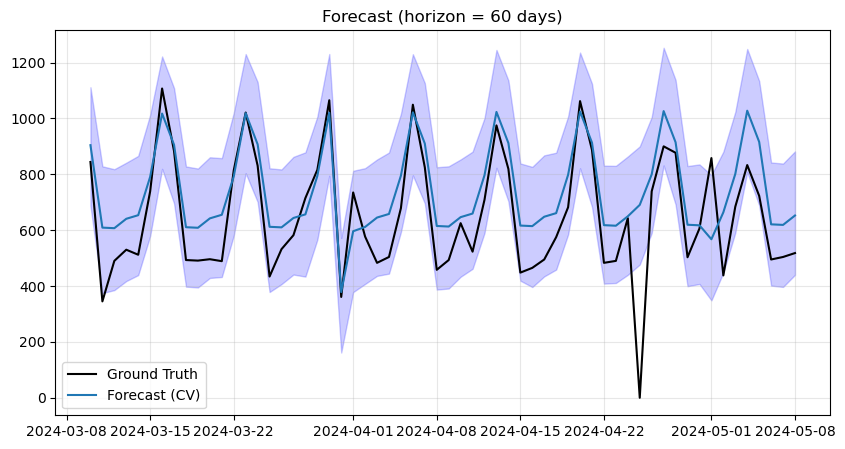


Test set metrics:
RMSE = 149.66
MAE  = 113.16


C:\Users\andre\AppData\Local\Temp\ipykernel_37676\1743448199.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_final["pre_covid"] = (train_final["ds"] < cutoff_date)
C:\Users\andre\AppData\Local\Temp\ipykernel_37676\1743448199.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_final["post_covid"] = (train_final["ds"] >= cutoff_date)
10:31:30 - cmdstanpy - INFO - Chain [1] start processing
10:31:31 - cmdstanpy - INFO - Chain [1] done processing



Model components:


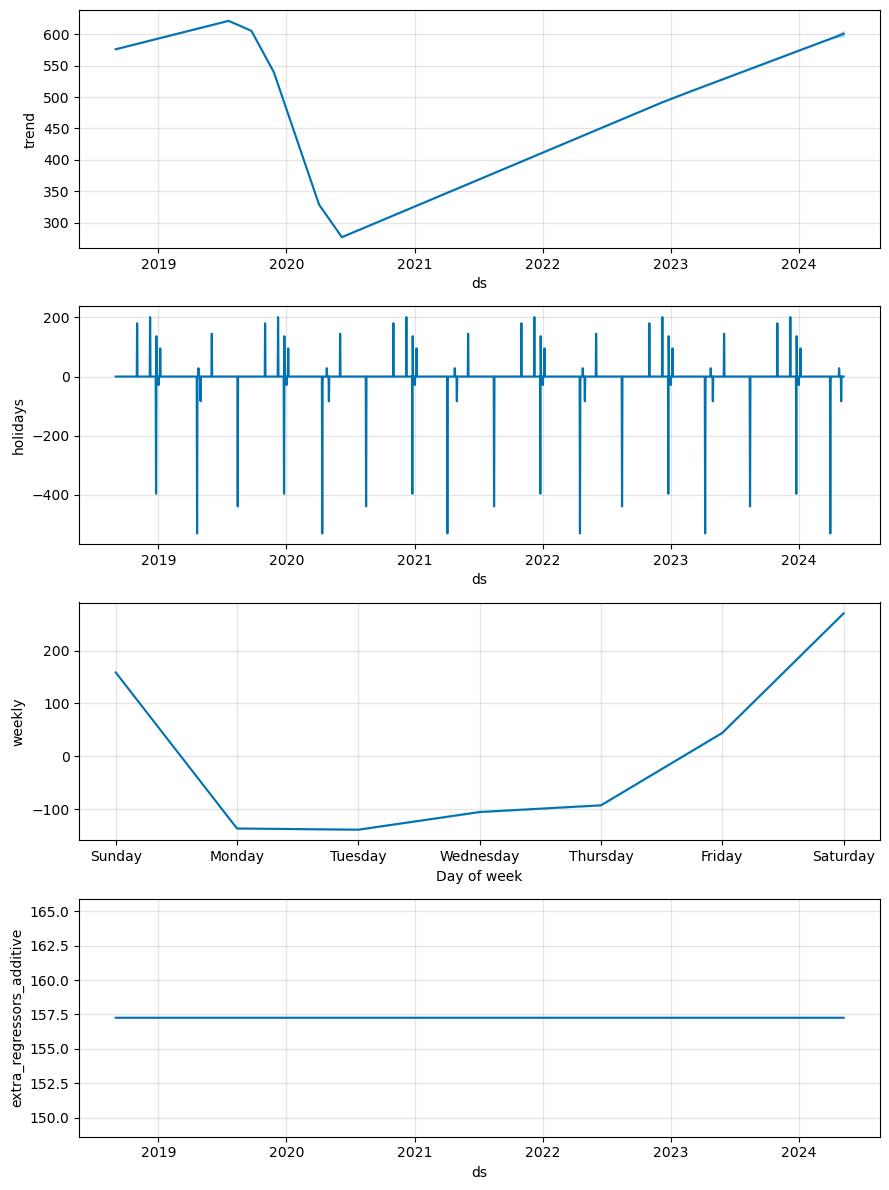

In [108]:
results = fit_prophet_model(
    df=df,
    y_col='scontrini',
    ds_col='data',
    regressors= covid_regr[1],
    n_test=60,
    weekly=True,
    monthly=False,
    yearly=False,
    weekly_prepost=False,
    holidays=True,
    verbose = True,
    return_results = True)

In [109]:
with open("models/prophet_model_scontrini_restaurant_1.json", "w") as f:
    f.write(model_to_json(results["model"]))

## GRID SEARCH ON DF2

In [111]:
df = pd.read_csv('data/restaurant_2.csv')

results = []

for (w, m, y, wp, h, covid) in param_grid:
    print(f"\n Testing with: weekly={w}, monthly={m}, yearly={y}, prepost={wp}, holidays={h}, covid={covid is not None}")
    
    
        # Fit Prophet
    res = fit_prophet_model(
            df=df,
            y_col="scontrini",
            ds_col="data",
            n_test=60,
            weekly=w,
            monthly=m,
            yearly=y,
            weekly_prepost=wp,
            holidays=h,
            regressors=covid,
            verbose=False,
            return_results=True
    )

        
    metrics_last = res["metrics_last_window"]
    cv_metrics = res["metrics_cv"]
    rmse_cv_mean = cv_metrics["rmse"].mean()
    mae_cv_mean = cv_metrics["mae"].mean()
      
    results.append({
            "weekly": w,
            "monthly": m,
            "yearly": y,
            "weekly_prepost": wp,
            "holidays": h,
            "covid_regressors": covid,
            "RMSE_last": metrics_last["RMSE"],
            "MAE_last": metrics_last["MAE"],
            "RMSE_cv_mean": rmse_cv_mean,
            "MAE_cv_mean": mae_cv_mean
    })


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=True, covid=False


10:32:51 - cmdstanpy - INFO - Chain [1] start processing
10:32:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:32:52 - cmdstanpy - INFO - Chain [1] start processing
10:32:52 - cmdstanpy - INFO - Chain [1] done processing
10:32:52 - cmdstanpy - INFO - Chain [1] start processing
10:32:52 - cmdstanpy - INFO - Chain [1] done processing
10:32:52 - cmdstanpy - INFO - Chain [1] start processing
10:32:53 - cmdstanpy - INFO - Chain [1] done processing
10:32:53 - cmdstanpy - INFO - Chain [1] start processing
10:32:54 - cmdstanpy - INFO - Chain [1] done processing
10:32:55 - cmdstanpy - INFO - Chain [1] start processing
10:32:55 - cmdstanpy - INFO - Chain [1] done processing
10:32:57 - cmdstanpy - INFO - Chain [1] start processing
10:32:57 - cmdstanpy - INFO - Chain [1] done processing
10:32:58 - cmdstanpy - INFO - Chain [1] start processing
10:32:59 - cmdstanpy - INFO - Chain [1] done processing
10:33:01 - cmdstanpy - INFO - Chain [1] start processing
10:33:01 - cmdstanpy - INFO - Chain [1] done processing
10:33:03 - cmdstanpy - INFO - Chain [1] start processing
10:33:03 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


10:33:38 - cmdstanpy - INFO - Chain [1] start processing
10:33:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:33:40 - cmdstanpy - INFO - Chain [1] start processing
10:33:41 - cmdstanpy - INFO - Chain [1] done processing
10:33:41 - cmdstanpy - INFO - Chain [1] start processing
10:33:42 - cmdstanpy - INFO - Chain [1] done processing
10:33:43 - cmdstanpy - INFO - Chain [1] start processing
10:33:44 - cmdstanpy - INFO - Chain [1] done processing
10:33:45 - cmdstanpy - INFO - Chain [1] start processing
10:33:45 - cmdstanpy - INFO - Chain [1] done processing
10:33:46 - cmdstanpy - INFO - Chain [1] start processing
10:33:47 - cmdstanpy - INFO - Chain [1] done processing
10:33:48 - cmdstanpy - INFO - Chain [1] start processing
10:33:49 - cmdstanpy - INFO - Chain [1] done processing
10:33:50 - cmdstanpy - INFO - Chain [1] start processing
10:33:51 - cmdstanpy - INFO - Chain [1] done processing
10:33:52 - cmdstanpy - INFO - Chain [1] start processing
10:33:52 - cmdstanpy - INFO - Chain [1] done processing
10:33:54 - cmdstanpy - INFO - Chain [1] start processing
10:33:54 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


10:34:34 - cmdstanpy - INFO - Chain [1] start processing
10:34:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:34:37 - cmdstanpy - INFO - Chain [1] start processing
10:34:37 - cmdstanpy - INFO - Chain [1] done processing
10:34:38 - cmdstanpy - INFO - Chain [1] start processing
10:34:39 - cmdstanpy - INFO - Chain [1] done processing
10:34:40 - cmdstanpy - INFO - Chain [1] start processing
10:34:40 - cmdstanpy - INFO - Chain [1] done processing
10:34:41 - cmdstanpy - INFO - Chain [1] start processing
10:34:42 - cmdstanpy - INFO - Chain [1] done processing
10:34:43 - cmdstanpy - INFO - Chain [1] start processing
10:34:43 - cmdstanpy - INFO - Chain [1] done processing
10:34:45 - cmdstanpy - INFO - Chain [1] start processing
10:34:46 - cmdstanpy - INFO - Chain [1] done processing
10:34:47 - cmdstanpy - INFO - Chain [1] start processing
10:34:48 - cmdstanpy - INFO - Chain [1] done processing
10:34:49 - cmdstanpy - INFO - Chain [1] start processing
10:34:50 - cmdstanpy - INFO - Chain [1] done processing
10:34:51 - cmdstanpy - INFO - Chain [1] start processing
10:34:52 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=False, covid=False


10:35:30 - cmdstanpy - INFO - Chain [1] start processing
10:35:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:35:31 - cmdstanpy - INFO - Chain [1] start processing
10:35:32 - cmdstanpy - INFO - Chain [1] done processing
10:35:33 - cmdstanpy - INFO - Chain [1] start processing
10:35:33 - cmdstanpy - INFO - Chain [1] done processing
10:35:34 - cmdstanpy - INFO - Chain [1] start processing
10:35:34 - cmdstanpy - INFO - Chain [1] done processing
10:35:35 - cmdstanpy - INFO - Chain [1] start processing
10:35:36 - cmdstanpy - INFO - Chain [1] done processing
10:35:37 - cmdstanpy - INFO - Chain [1] start processing
10:35:37 - cmdstanpy - INFO - Chain [1] done processing
10:35:38 - cmdstanpy - INFO - Chain [1] start processing
10:35:38 - cmdstanpy - INFO - Chain [1] done processing
10:35:39 - cmdstanpy - INFO - Chain [1] start processing
10:35:40 - cmdstanpy - INFO - Chain [1] done processing
10:35:41 - cmdstanpy - INFO - Chain [1] start processing
10:35:41 - cmdstanpy - INFO - Chain [1] done processing
10:35:42 - cmdstanpy - INFO - Chain [1] start processing
10:35:43 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


10:36:12 - cmdstanpy - INFO - Chain [1] start processing
10:36:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:36:14 - cmdstanpy - INFO - Chain [1] start processing
10:36:15 - cmdstanpy - INFO - Chain [1] done processing
10:36:16 - cmdstanpy - INFO - Chain [1] start processing
10:36:16 - cmdstanpy - INFO - Chain [1] done processing
10:36:17 - cmdstanpy - INFO - Chain [1] start processing
10:36:17 - cmdstanpy - INFO - Chain [1] done processing
10:36:18 - cmdstanpy - INFO - Chain [1] start processing
10:36:19 - cmdstanpy - INFO - Chain [1] done processing
10:36:20 - cmdstanpy - INFO - Chain [1] start processing
10:36:20 - cmdstanpy - INFO - Chain [1] done processing
10:36:21 - cmdstanpy - INFO - Chain [1] start processing
10:36:22 - cmdstanpy - INFO - Chain [1] done processing
10:36:23 - cmdstanpy - INFO - Chain [1] start processing
10:36:24 - cmdstanpy - INFO - Chain [1] done processing
10:36:25 - cmdstanpy - INFO - Chain [1] start processing
10:36:26 - cmdstanpy - INFO - Chain [1] done processing
10:36:27 - cmdstanpy - INFO - Chain [1] start processing
10:36:27 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


10:36:59 - cmdstanpy - INFO - Chain [1] start processing
10:36:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:37:01 - cmdstanpy - INFO - Chain [1] start processing
10:37:01 - cmdstanpy - INFO - Chain [1] done processing
10:37:02 - cmdstanpy - INFO - Chain [1] start processing
10:37:02 - cmdstanpy - INFO - Chain [1] done processing
10:37:03 - cmdstanpy - INFO - Chain [1] start processing
10:37:03 - cmdstanpy - INFO - Chain [1] done processing
10:37:04 - cmdstanpy - INFO - Chain [1] start processing
10:37:05 - cmdstanpy - INFO - Chain [1] done processing
10:37:06 - cmdstanpy - INFO - Chain [1] start processing
10:37:06 - cmdstanpy - INFO - Chain [1] done processing
10:37:07 - cmdstanpy - INFO - Chain [1] start processing
10:37:07 - cmdstanpy - INFO - Chain [1] done processing
10:37:08 - cmdstanpy - INFO - Chain [1] start processing
10:37:09 - cmdstanpy - INFO - Chain [1] done processing
10:37:10 - cmdstanpy - INFO - Chain [1] start processing
10:37:11 - cmdstanpy - INFO - Chain [1] done processing
10:37:12 - cmdstanpy - INFO - Chain [1] start processing
10:37:13 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=True, covid=False


10:37:46 - cmdstanpy - INFO - Chain [1] start processing
10:37:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:37:49 - cmdstanpy - INFO - Chain [1] start processing
10:37:49 - cmdstanpy - INFO - Chain [1] done processing
10:37:50 - cmdstanpy - INFO - Chain [1] start processing
10:37:51 - cmdstanpy - INFO - Chain [1] done processing
10:37:52 - cmdstanpy - INFO - Chain [1] start processing
10:37:53 - cmdstanpy - INFO - Chain [1] done processing
10:37:54 - cmdstanpy - INFO - Chain [1] start processing
10:37:54 - cmdstanpy - INFO - Chain [1] done processing
10:37:55 - cmdstanpy - INFO - Chain [1] start processing
10:37:56 - cmdstanpy - INFO - Chain [1] done processing
10:37:57 - cmdstanpy - INFO - Chain [1] start processing
10:37:57 - cmdstanpy - INFO - Chain [1] done processing
10:37:59 - cmdstanpy - INFO - Chain [1] start processing
10:37:59 - cmdstanpy - INFO - Chain [1] done processing
10:38:00 - cmdstanpy - INFO - Chain [1] start processing
10:38:01 - cmdstanpy - INFO - Chain [1] done processing
10:38:02 - cmdstanpy - INFO - Chain [1] start processing
10:38:03 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


10:38:36 - cmdstanpy - INFO - Chain [1] start processing
10:38:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:38:38 - cmdstanpy - INFO - Chain [1] start processing
10:38:39 - cmdstanpy - INFO - Chain [1] done processing
10:38:40 - cmdstanpy - INFO - Chain [1] start processing
10:38:40 - cmdstanpy - INFO - Chain [1] done processing
10:38:41 - cmdstanpy - INFO - Chain [1] start processing
10:38:42 - cmdstanpy - INFO - Chain [1] done processing
10:38:43 - cmdstanpy - INFO - Chain [1] start processing
10:38:43 - cmdstanpy - INFO - Chain [1] done processing
10:38:44 - cmdstanpy - INFO - Chain [1] start processing
10:38:45 - cmdstanpy - INFO - Chain [1] done processing
10:38:46 - cmdstanpy - INFO - Chain [1] start processing
10:38:47 - cmdstanpy - INFO - Chain [1] done processing
10:38:48 - cmdstanpy - INFO - Chain [1] start processing
10:38:49 - cmdstanpy - INFO - Chain [1] done processing
10:38:50 - cmdstanpy - INFO - Chain [1] start processing
10:38:51 - cmdstanpy - INFO - Chain [1] done processing
10:38:52 - cmdstanpy - INFO - Chain [1] start processing
10:38:53 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


10:39:27 - cmdstanpy - INFO - Chain [1] start processing
10:39:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:39:29 - cmdstanpy - INFO - Chain [1] start processing
10:39:29 - cmdstanpy - INFO - Chain [1] done processing
10:39:30 - cmdstanpy - INFO - Chain [1] start processing
10:39:31 - cmdstanpy - INFO - Chain [1] done processing
10:39:32 - cmdstanpy - INFO - Chain [1] start processing
10:39:32 - cmdstanpy - INFO - Chain [1] done processing
10:39:33 - cmdstanpy - INFO - Chain [1] start processing
10:39:34 - cmdstanpy - INFO - Chain [1] done processing
10:39:35 - cmdstanpy - INFO - Chain [1] start processing
10:39:35 - cmdstanpy - INFO - Chain [1] done processing
10:39:36 - cmdstanpy - INFO - Chain [1] start processing
10:39:37 - cmdstanpy - INFO - Chain [1] done processing
10:39:38 - cmdstanpy - INFO - Chain [1] start processing
10:39:39 - cmdstanpy - INFO - Chain [1] done processing
10:39:40 - cmdstanpy - INFO - Chain [1] start processing
10:39:41 - cmdstanpy - INFO - Chain [1] done processing
10:39:42 - cmdstanpy - INFO - Chain [1] start processing
10:39:43 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=False, covid=False


10:40:22 - cmdstanpy - INFO - Chain [1] start processing
10:40:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:40:24 - cmdstanpy - INFO - Chain [1] start processing
10:40:25 - cmdstanpy - INFO - Chain [1] done processing
10:40:26 - cmdstanpy - INFO - Chain [1] start processing
10:40:26 - cmdstanpy - INFO - Chain [1] done processing
10:40:27 - cmdstanpy - INFO - Chain [1] start processing
10:40:27 - cmdstanpy - INFO - Chain [1] done processing
10:40:28 - cmdstanpy - INFO - Chain [1] start processing
10:40:28 - cmdstanpy - INFO - Chain [1] done processing
10:40:29 - cmdstanpy - INFO - Chain [1] start processing
10:40:29 - cmdstanpy - INFO - Chain [1] done processing
10:40:30 - cmdstanpy - INFO - Chain [1] start processing
10:40:31 - cmdstanpy - INFO - Chain [1] done processing
10:40:31 - cmdstanpy - INFO - Chain [1] start processing
10:40:32 - cmdstanpy - INFO - Chain [1] done processing
10:40:33 - cmdstanpy - INFO - Chain [1] start processing
10:40:34 - cmdstanpy - INFO - Chain [1] done processing
10:40:35 - cmdstanpy - INFO - Chain [1] start processing
10:40:35 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


10:41:06 - cmdstanpy - INFO - Chain [1] start processing
10:41:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:41:08 - cmdstanpy - INFO - Chain [1] start processing
10:41:08 - cmdstanpy - INFO - Chain [1] done processing
10:41:09 - cmdstanpy - INFO - Chain [1] start processing
10:41:10 - cmdstanpy - INFO - Chain [1] done processing
10:41:11 - cmdstanpy - INFO - Chain [1] start processing
10:41:11 - cmdstanpy - INFO - Chain [1] done processing
10:41:12 - cmdstanpy - INFO - Chain [1] start processing
10:41:12 - cmdstanpy - INFO - Chain [1] done processing
10:41:13 - cmdstanpy - INFO - Chain [1] start processing
10:41:14 - cmdstanpy - INFO - Chain [1] done processing
10:41:15 - cmdstanpy - INFO - Chain [1] start processing
10:41:15 - cmdstanpy - INFO - Chain [1] done processing
10:41:16 - cmdstanpy - INFO - Chain [1] start processing
10:41:17 - cmdstanpy - INFO - Chain [1] done processing
10:41:18 - cmdstanpy - INFO - Chain [1] start processing
10:41:19 - cmdstanpy - INFO - Chain [1] done processing
10:41:20 - cmdstanpy - INFO - Chain [1] start processing
10:41:20 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


10:41:49 - cmdstanpy - INFO - Chain [1] start processing
10:41:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:41:51 - cmdstanpy - INFO - Chain [1] start processing
10:41:51 - cmdstanpy - INFO - Chain [1] done processing
10:41:52 - cmdstanpy - INFO - Chain [1] start processing
10:41:53 - cmdstanpy - INFO - Chain [1] done processing
10:41:54 - cmdstanpy - INFO - Chain [1] start processing
10:41:54 - cmdstanpy - INFO - Chain [1] done processing
10:41:55 - cmdstanpy - INFO - Chain [1] start processing
10:41:55 - cmdstanpy - INFO - Chain [1] done processing
10:41:56 - cmdstanpy - INFO - Chain [1] start processing
10:41:57 - cmdstanpy - INFO - Chain [1] done processing
10:41:57 - cmdstanpy - INFO - Chain [1] start processing
10:41:58 - cmdstanpy - INFO - Chain [1] done processing
10:41:59 - cmdstanpy - INFO - Chain [1] start processing
10:41:59 - cmdstanpy - INFO - Chain [1] done processing
10:42:00 - cmdstanpy - INFO - Chain [1] start processing
10:42:01 - cmdstanpy - INFO - Chain [1] done processing
10:42:02 - cmdstanpy - INFO - Chain [1] start processing
10:42:03 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=True, covid=False


10:42:35 - cmdstanpy - INFO - Chain [1] start processing
10:42:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:42:37 - cmdstanpy - INFO - Chain [1] start processing
10:42:37 - cmdstanpy - INFO - Chain [1] done processing
10:42:38 - cmdstanpy - INFO - Chain [1] start processing
10:42:38 - cmdstanpy - INFO - Chain [1] done processing
10:42:39 - cmdstanpy - INFO - Chain [1] start processing
10:42:39 - cmdstanpy - INFO - Chain [1] done processing
10:42:40 - cmdstanpy - INFO - Chain [1] start processing
10:42:40 - cmdstanpy - INFO - Chain [1] done processing
10:42:41 - cmdstanpy - INFO - Chain [1] start processing
10:42:42 - cmdstanpy - INFO - Chain [1] done processing
10:42:43 - cmdstanpy - INFO - Chain [1] start processing
10:42:43 - cmdstanpy - INFO - Chain [1] done processing
10:42:44 - cmdstanpy - INFO - Chain [1] start processing
10:42:44 - cmdstanpy - INFO - Chain [1] done processing
10:42:45 - cmdstanpy - INFO - Chain [1] start processing
10:42:46 - cmdstanpy - INFO - Chain [1] done processing
10:42:47 - cmdstanpy - INFO - Chain [1] start processing
10:42:47 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


10:43:16 - cmdstanpy - INFO - Chain [1] start processing
10:43:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:43:17 - cmdstanpy - INFO - Chain [1] start processing
10:43:17 - cmdstanpy - INFO - Chain [1] done processing
10:43:18 - cmdstanpy - INFO - Chain [1] start processing
10:43:19 - cmdstanpy - INFO - Chain [1] done processing
10:43:20 - cmdstanpy - INFO - Chain [1] start processing
10:43:21 - cmdstanpy - INFO - Chain [1] done processing
10:43:22 - cmdstanpy - INFO - Chain [1] start processing
10:43:22 - cmdstanpy - INFO - Chain [1] done processing
10:43:23 - cmdstanpy - INFO - Chain [1] start processing
10:43:23 - cmdstanpy - INFO - Chain [1] done processing
10:43:24 - cmdstanpy - INFO - Chain [1] start processing
10:43:25 - cmdstanpy - INFO - Chain [1] done processing
10:43:26 - cmdstanpy - INFO - Chain [1] start processing
10:43:26 - cmdstanpy - INFO - Chain [1] done processing
10:43:27 - cmdstanpy - INFO - Chain [1] start processing
10:43:28 - cmdstanpy - INFO - Chain [1] done processing
10:43:29 - cmdstanpy - INFO - Chain [1] start processing
10:43:29 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


10:43:59 - cmdstanpy - INFO - Chain [1] start processing
10:44:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:44:01 - cmdstanpy - INFO - Chain [1] start processing
10:44:02 - cmdstanpy - INFO - Chain [1] done processing
10:44:03 - cmdstanpy - INFO - Chain [1] start processing
10:44:03 - cmdstanpy - INFO - Chain [1] done processing
10:44:04 - cmdstanpy - INFO - Chain [1] start processing
10:44:05 - cmdstanpy - INFO - Chain [1] done processing
10:44:06 - cmdstanpy - INFO - Chain [1] start processing
10:44:06 - cmdstanpy - INFO - Chain [1] done processing
10:44:07 - cmdstanpy - INFO - Chain [1] start processing
10:44:08 - cmdstanpy - INFO - Chain [1] done processing
10:44:09 - cmdstanpy - INFO - Chain [1] start processing
10:44:09 - cmdstanpy - INFO - Chain [1] done processing
10:44:10 - cmdstanpy - INFO - Chain [1] start processing
10:44:11 - cmdstanpy - INFO - Chain [1] done processing
10:44:11 - cmdstanpy - INFO - Chain [1] start processing
10:44:12 - cmdstanpy - INFO - Chain [1] done processing
10:44:13 - cmdstanpy - INFO - Chain [1] start processing
10:44:13 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=False, covid=False


10:44:43 - cmdstanpy - INFO - Chain [1] start processing
10:44:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:44:44 - cmdstanpy - INFO - Chain [1] start processing
10:44:45 - cmdstanpy - INFO - Chain [1] done processing
10:44:45 - cmdstanpy - INFO - Chain [1] start processing
10:44:46 - cmdstanpy - INFO - Chain [1] done processing
10:44:46 - cmdstanpy - INFO - Chain [1] start processing
10:44:47 - cmdstanpy - INFO - Chain [1] done processing
10:44:48 - cmdstanpy - INFO - Chain [1] start processing
10:44:48 - cmdstanpy - INFO - Chain [1] done processing
10:44:49 - cmdstanpy - INFO - Chain [1] start processing
10:44:49 - cmdstanpy - INFO - Chain [1] done processing
10:44:50 - cmdstanpy - INFO - Chain [1] start processing
10:44:50 - cmdstanpy - INFO - Chain [1] done processing
10:44:51 - cmdstanpy - INFO - Chain [1] start processing
10:44:51 - cmdstanpy - INFO - Chain [1] done processing
10:44:52 - cmdstanpy - INFO - Chain [1] start processing
10:44:52 - cmdstanpy - INFO - Chain [1] done processing
10:44:53 - cmdstanpy - INFO - Chain [1] start processing
10:44:54 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


10:45:17 - cmdstanpy - INFO - Chain [1] start processing
10:45:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:45:19 - cmdstanpy - INFO - Chain [1] start processing
10:45:19 - cmdstanpy - INFO - Chain [1] done processing
10:45:20 - cmdstanpy - INFO - Chain [1] start processing
10:45:21 - cmdstanpy - INFO - Chain [1] done processing
10:45:21 - cmdstanpy - INFO - Chain [1] start processing
10:45:22 - cmdstanpy - INFO - Chain [1] done processing
10:45:23 - cmdstanpy - INFO - Chain [1] start processing
10:45:24 - cmdstanpy - INFO - Chain [1] done processing
10:45:24 - cmdstanpy - INFO - Chain [1] start processing
10:45:25 - cmdstanpy - INFO - Chain [1] done processing
10:45:26 - cmdstanpy - INFO - Chain [1] start processing
10:45:26 - cmdstanpy - INFO - Chain [1] done processing
10:45:27 - cmdstanpy - INFO - Chain [1] start processing
10:45:27 - cmdstanpy - INFO - Chain [1] done processing
10:45:28 - cmdstanpy - INFO - Chain [1] start processing
10:45:29 - cmdstanpy - INFO - Chain [1] done processing
10:45:30 - cmdstanpy - INFO - Chain [1] start processing
10:45:30 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


10:45:55 - cmdstanpy - INFO - Chain [1] start processing
10:45:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:45:57 - cmdstanpy - INFO - Chain [1] start processing
10:45:57 - cmdstanpy - INFO - Chain [1] done processing
10:45:58 - cmdstanpy - INFO - Chain [1] start processing
10:45:58 - cmdstanpy - INFO - Chain [1] done processing
10:45:59 - cmdstanpy - INFO - Chain [1] start processing
10:45:59 - cmdstanpy - INFO - Chain [1] done processing
10:46:00 - cmdstanpy - INFO - Chain [1] start processing
10:46:01 - cmdstanpy - INFO - Chain [1] done processing
10:46:01 - cmdstanpy - INFO - Chain [1] start processing
10:46:02 - cmdstanpy - INFO - Chain [1] done processing
10:46:03 - cmdstanpy - INFO - Chain [1] start processing
10:46:03 - cmdstanpy - INFO - Chain [1] done processing
10:46:04 - cmdstanpy - INFO - Chain [1] start processing
10:46:04 - cmdstanpy - INFO - Chain [1] done processing
10:46:05 - cmdstanpy - INFO - Chain [1] start processing
10:46:06 - cmdstanpy - INFO - Chain [1] done processing
10:46:07 - cmdstanpy - INFO - Chain [1] start processing
10:46:07 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=True, covid=False


10:46:33 - cmdstanpy - INFO - Chain [1] start processing
10:46:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:46:35 - cmdstanpy - INFO - Chain [1] start processing
10:46:35 - cmdstanpy - INFO - Chain [1] done processing
10:46:36 - cmdstanpy - INFO - Chain [1] start processing
10:46:36 - cmdstanpy - INFO - Chain [1] done processing
10:46:37 - cmdstanpy - INFO - Chain [1] start processing
10:46:38 - cmdstanpy - INFO - Chain [1] done processing
10:46:38 - cmdstanpy - INFO - Chain [1] start processing
10:46:39 - cmdstanpy - INFO - Chain [1] done processing
10:46:40 - cmdstanpy - INFO - Chain [1] start processing
10:46:40 - cmdstanpy - INFO - Chain [1] done processing
10:46:41 - cmdstanpy - INFO - Chain [1] start processing
10:46:42 - cmdstanpy - INFO - Chain [1] done processing
10:46:43 - cmdstanpy - INFO - Chain [1] start processing
10:46:43 - cmdstanpy - INFO - Chain [1] done processing
10:46:44 - cmdstanpy - INFO - Chain [1] start processing
10:46:45 - cmdstanpy - INFO - Chain [1] done processing
10:46:46 - cmdstanpy - INFO - Chain [1] start processing
10:46:46 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


10:47:13 - cmdstanpy - INFO - Chain [1] start processing
10:47:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:47:14 - cmdstanpy - INFO - Chain [1] start processing
10:47:15 - cmdstanpy - INFO - Chain [1] done processing
10:47:15 - cmdstanpy - INFO - Chain [1] start processing
10:47:16 - cmdstanpy - INFO - Chain [1] done processing
10:47:17 - cmdstanpy - INFO - Chain [1] start processing
10:47:17 - cmdstanpy - INFO - Chain [1] done processing
10:47:18 - cmdstanpy - INFO - Chain [1] start processing
10:47:19 - cmdstanpy - INFO - Chain [1] done processing
10:47:20 - cmdstanpy - INFO - Chain [1] start processing
10:47:20 - cmdstanpy - INFO - Chain [1] done processing
10:47:21 - cmdstanpy - INFO - Chain [1] start processing
10:47:22 - cmdstanpy - INFO - Chain [1] done processing
10:47:23 - cmdstanpy - INFO - Chain [1] start processing
10:47:23 - cmdstanpy - INFO - Chain [1] done processing
10:47:24 - cmdstanpy - INFO - Chain [1] start processing
10:47:25 - cmdstanpy - INFO - Chain [1] done processing
10:47:26 - cmdstanpy - INFO - Chain [1] start processing
10:47:26 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


10:47:56 - cmdstanpy - INFO - Chain [1] start processing
10:47:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:47:58 - cmdstanpy - INFO - Chain [1] start processing
10:47:58 - cmdstanpy - INFO - Chain [1] done processing
10:47:59 - cmdstanpy - INFO - Chain [1] start processing
10:47:59 - cmdstanpy - INFO - Chain [1] done processing
10:48:00 - cmdstanpy - INFO - Chain [1] start processing
10:48:01 - cmdstanpy - INFO - Chain [1] done processing
10:48:02 - cmdstanpy - INFO - Chain [1] start processing
10:48:02 - cmdstanpy - INFO - Chain [1] done processing
10:48:03 - cmdstanpy - INFO - Chain [1] start processing
10:48:04 - cmdstanpy - INFO - Chain [1] done processing
10:48:05 - cmdstanpy - INFO - Chain [1] start processing
10:48:05 - cmdstanpy - INFO - Chain [1] done processing
10:48:06 - cmdstanpy - INFO - Chain [1] start processing
10:48:07 - cmdstanpy - INFO - Chain [1] done processing
10:48:08 - cmdstanpy - INFO - Chain [1] start processing
10:48:08 - cmdstanpy - INFO - Chain [1] done processing
10:48:10 - cmdstanpy - INFO - Chain [1] start processing
10:48:10 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=False, covid=False


10:48:39 - cmdstanpy - INFO - Chain [1] start processing
10:48:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:48:41 - cmdstanpy - INFO - Chain [1] start processing
10:48:41 - cmdstanpy - INFO - Chain [1] done processing
10:48:42 - cmdstanpy - INFO - Chain [1] start processing
10:48:42 - cmdstanpy - INFO - Chain [1] done processing
10:48:43 - cmdstanpy - INFO - Chain [1] start processing
10:48:43 - cmdstanpy - INFO - Chain [1] done processing
10:48:44 - cmdstanpy - INFO - Chain [1] start processing
10:48:44 - cmdstanpy - INFO - Chain [1] done processing
10:48:45 - cmdstanpy - INFO - Chain [1] start processing
10:48:45 - cmdstanpy - INFO - Chain [1] done processing
10:48:46 - cmdstanpy - INFO - Chain [1] start processing
10:48:46 - cmdstanpy - INFO - Chain [1] done processing
10:48:47 - cmdstanpy - INFO - Chain [1] start processing
10:48:47 - cmdstanpy - INFO - Chain [1] done processing
10:48:48 - cmdstanpy - INFO - Chain [1] start processing
10:48:48 - cmdstanpy - INFO - Chain [1] done processing
10:48:49 - cmdstanpy - INFO - Chain [1] start processing
10:48:50 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


10:49:12 - cmdstanpy - INFO - Chain [1] start processing
10:49:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:49:14 - cmdstanpy - INFO - Chain [1] start processing
10:49:14 - cmdstanpy - INFO - Chain [1] done processing
10:49:15 - cmdstanpy - INFO - Chain [1] start processing
10:49:15 - cmdstanpy - INFO - Chain [1] done processing
10:49:16 - cmdstanpy - INFO - Chain [1] start processing
10:49:16 - cmdstanpy - INFO - Chain [1] done processing
10:49:17 - cmdstanpy - INFO - Chain [1] start processing
10:49:18 - cmdstanpy - INFO - Chain [1] done processing
10:49:18 - cmdstanpy - INFO - Chain [1] start processing
10:49:19 - cmdstanpy - INFO - Chain [1] done processing
10:49:20 - cmdstanpy - INFO - Chain [1] start processing
10:49:20 - cmdstanpy - INFO - Chain [1] done processing
10:49:21 - cmdstanpy - INFO - Chain [1] start processing
10:49:21 - cmdstanpy - INFO - Chain [1] done processing
10:49:22 - cmdstanpy - INFO - Chain [1] start processing
10:49:23 - cmdstanpy - INFO - Chain [1] done processing
10:49:23 - cmdstanpy - INFO - Chain [1] start processing
10:49:24 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


10:49:49 - cmdstanpy - INFO - Chain [1] start processing
10:49:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:49:51 - cmdstanpy - INFO - Chain [1] start processing
10:49:51 - cmdstanpy - INFO - Chain [1] done processing
10:49:51 - cmdstanpy - INFO - Chain [1] start processing
10:49:52 - cmdstanpy - INFO - Chain [1] done processing
10:49:52 - cmdstanpy - INFO - Chain [1] start processing
10:49:53 - cmdstanpy - INFO - Chain [1] done processing
10:49:54 - cmdstanpy - INFO - Chain [1] start processing
10:49:54 - cmdstanpy - INFO - Chain [1] done processing
10:49:55 - cmdstanpy - INFO - Chain [1] start processing
10:49:55 - cmdstanpy - INFO - Chain [1] done processing
10:49:56 - cmdstanpy - INFO - Chain [1] start processing
10:49:57 - cmdstanpy - INFO - Chain [1] done processing
10:49:57 - cmdstanpy - INFO - Chain [1] start processing
10:49:58 - cmdstanpy - INFO - Chain [1] done processing
10:49:59 - cmdstanpy - INFO - Chain [1] start processing
10:49:59 - cmdstanpy - INFO - Chain [1] done processing
10:50:00 - cmdstanpy - INFO - Chain [1] start processing
10:50:01 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=True, covid=False


10:50:26 - cmdstanpy - INFO - Chain [1] start processing
10:50:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:50:28 - cmdstanpy - INFO - Chain [1] start processing
10:50:28 - cmdstanpy - INFO - Chain [1] done processing
10:50:29 - cmdstanpy - INFO - Chain [1] start processing
10:50:30 - cmdstanpy - INFO - Chain [1] done processing
10:50:31 - cmdstanpy - INFO - Chain [1] start processing
10:50:31 - cmdstanpy - INFO - Chain [1] done processing
10:50:32 - cmdstanpy - INFO - Chain [1] start processing
10:50:33 - cmdstanpy - INFO - Chain [1] done processing
10:50:34 - cmdstanpy - INFO - Chain [1] start processing
10:50:34 - cmdstanpy - INFO - Chain [1] done processing
10:50:35 - cmdstanpy - INFO - Chain [1] start processing
10:50:36 - cmdstanpy - INFO - Chain [1] done processing
10:50:37 - cmdstanpy - INFO - Chain [1] start processing
10:50:37 - cmdstanpy - INFO - Chain [1] done processing
10:50:38 - cmdstanpy - INFO - Chain [1] start processing
10:50:39 - cmdstanpy - INFO - Chain [1] done processing
10:50:40 - cmdstanpy - INFO - Chain [1] start processing
10:50:41 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


10:51:13 - cmdstanpy - INFO - Chain [1] start processing
10:51:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:51:15 - cmdstanpy - INFO - Chain [1] start processing
10:51:16 - cmdstanpy - INFO - Chain [1] done processing
10:51:17 - cmdstanpy - INFO - Chain [1] start processing
10:51:17 - cmdstanpy - INFO - Chain [1] done processing
10:51:18 - cmdstanpy - INFO - Chain [1] start processing
10:51:19 - cmdstanpy - INFO - Chain [1] done processing
10:51:20 - cmdstanpy - INFO - Chain [1] start processing
10:51:21 - cmdstanpy - INFO - Chain [1] done processing
10:51:22 - cmdstanpy - INFO - Chain [1] start processing
10:51:22 - cmdstanpy - INFO - Chain [1] done processing
10:51:24 - cmdstanpy - INFO - Chain [1] start processing
10:51:24 - cmdstanpy - INFO - Chain [1] done processing
10:51:26 - cmdstanpy - INFO - Chain [1] start processing
10:51:26 - cmdstanpy - INFO - Chain [1] done processing
10:51:28 - cmdstanpy - INFO - Chain [1] start processing
10:51:28 - cmdstanpy - INFO - Chain [1] done processing
10:51:30 - cmdstanpy - INFO - Chain [1] start processing
10:51:30 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


10:52:06 - cmdstanpy - INFO - Chain [1] start processing
10:52:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:52:08 - cmdstanpy - INFO - Chain [1] start processing
10:52:08 - cmdstanpy - INFO - Chain [1] done processing
10:52:09 - cmdstanpy - INFO - Chain [1] start processing
10:52:10 - cmdstanpy - INFO - Chain [1] done processing
10:52:11 - cmdstanpy - INFO - Chain [1] start processing
10:52:11 - cmdstanpy - INFO - Chain [1] done processing
10:52:12 - cmdstanpy - INFO - Chain [1] start processing
10:52:13 - cmdstanpy - INFO - Chain [1] done processing
10:52:14 - cmdstanpy - INFO - Chain [1] start processing
10:52:15 - cmdstanpy - INFO - Chain [1] done processing
10:52:16 - cmdstanpy - INFO - Chain [1] start processing
10:52:16 - cmdstanpy - INFO - Chain [1] done processing
10:52:17 - cmdstanpy - INFO - Chain [1] start processing
10:52:18 - cmdstanpy - INFO - Chain [1] done processing
10:52:19 - cmdstanpy - INFO - Chain [1] start processing
10:52:20 - cmdstanpy - INFO - Chain [1] done processing
10:52:21 - cmdstanpy - INFO - Chain [1] start processing
10:52:21 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=False, covid=False


10:52:55 - cmdstanpy - INFO - Chain [1] start processing
10:52:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:52:57 - cmdstanpy - INFO - Chain [1] start processing
10:52:57 - cmdstanpy - INFO - Chain [1] done processing
10:52:58 - cmdstanpy - INFO - Chain [1] start processing
10:52:58 - cmdstanpy - INFO - Chain [1] done processing
10:52:59 - cmdstanpy - INFO - Chain [1] start processing
10:52:59 - cmdstanpy - INFO - Chain [1] done processing
10:53:00 - cmdstanpy - INFO - Chain [1] start processing
10:53:01 - cmdstanpy - INFO - Chain [1] done processing
10:53:01 - cmdstanpy - INFO - Chain [1] start processing
10:53:02 - cmdstanpy - INFO - Chain [1] done processing
10:53:03 - cmdstanpy - INFO - Chain [1] start processing
10:53:03 - cmdstanpy - INFO - Chain [1] done processing
10:53:05 - cmdstanpy - INFO - Chain [1] start processing
10:53:05 - cmdstanpy - INFO - Chain [1] done processing
10:53:06 - cmdstanpy - INFO - Chain [1] start processing
10:53:07 - cmdstanpy - INFO - Chain [1] done processing
10:53:08 - cmdstanpy - INFO - Chain [1] start processing
10:53:08 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


10:53:36 - cmdstanpy - INFO - Chain [1] start processing
10:53:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:53:38 - cmdstanpy - INFO - Chain [1] start processing
10:53:38 - cmdstanpy - INFO - Chain [1] done processing
10:53:39 - cmdstanpy - INFO - Chain [1] start processing
10:53:39 - cmdstanpy - INFO - Chain [1] done processing
10:53:40 - cmdstanpy - INFO - Chain [1] start processing
10:53:40 - cmdstanpy - INFO - Chain [1] done processing
10:53:40 - cmdstanpy - INFO - Chain [1] start processing
10:53:41 - cmdstanpy - INFO - Chain [1] done processing
10:53:42 - cmdstanpy - INFO - Chain [1] start processing
10:53:42 - cmdstanpy - INFO - Chain [1] done processing
10:53:43 - cmdstanpy - INFO - Chain [1] start processing
10:53:44 - cmdstanpy - INFO - Chain [1] done processing
10:53:45 - cmdstanpy - INFO - Chain [1] start processing
10:53:46 - cmdstanpy - INFO - Chain [1] done processing
10:53:47 - cmdstanpy - INFO - Chain [1] start processing
10:53:47 - cmdstanpy - INFO - Chain [1] done processing
10:53:48 - cmdstanpy - INFO - Chain [1] start processing
10:53:49 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


10:54:19 - cmdstanpy - INFO - Chain [1] start processing
10:54:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:54:21 - cmdstanpy - INFO - Chain [1] start processing
10:54:21 - cmdstanpy - INFO - Chain [1] done processing
10:54:22 - cmdstanpy - INFO - Chain [1] start processing
10:54:23 - cmdstanpy - INFO - Chain [1] done processing
10:54:23 - cmdstanpy - INFO - Chain [1] start processing
10:54:24 - cmdstanpy - INFO - Chain [1] done processing
10:54:25 - cmdstanpy - INFO - Chain [1] start processing
10:54:25 - cmdstanpy - INFO - Chain [1] done processing
10:54:26 - cmdstanpy - INFO - Chain [1] start processing
10:54:26 - cmdstanpy - INFO - Chain [1] done processing
10:54:27 - cmdstanpy - INFO - Chain [1] start processing
10:54:27 - cmdstanpy - INFO - Chain [1] done processing
10:54:28 - cmdstanpy - INFO - Chain [1] start processing
10:54:29 - cmdstanpy - INFO - Chain [1] done processing
10:54:30 - cmdstanpy - INFO - Chain [1] start processing
10:54:31 - cmdstanpy - INFO - Chain [1] done processing
10:54:31 - cmdstanpy - INFO - Chain [1] start processing
10:54:32 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=True, covid=False


10:55:01 - cmdstanpy - INFO - Chain [1] start processing
10:55:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:55:03 - cmdstanpy - INFO - Chain [1] start processing
10:55:03 - cmdstanpy - INFO - Chain [1] done processing
10:55:04 - cmdstanpy - INFO - Chain [1] start processing
10:55:05 - cmdstanpy - INFO - Chain [1] done processing
10:55:06 - cmdstanpy - INFO - Chain [1] start processing
10:55:06 - cmdstanpy - INFO - Chain [1] done processing
10:55:07 - cmdstanpy - INFO - Chain [1] start processing
10:55:07 - cmdstanpy - INFO - Chain [1] done processing
10:55:08 - cmdstanpy - INFO - Chain [1] start processing
10:55:09 - cmdstanpy - INFO - Chain [1] done processing
10:55:10 - cmdstanpy - INFO - Chain [1] start processing
10:55:10 - cmdstanpy - INFO - Chain [1] done processing
10:55:11 - cmdstanpy - INFO - Chain [1] start processing
10:55:12 - cmdstanpy - INFO - Chain [1] done processing
10:55:13 - cmdstanpy - INFO - Chain [1] start processing
10:55:13 - cmdstanpy - INFO - Chain [1] done processing
10:55:14 - cmdstanpy - INFO - Chain [1] start processing
10:55:15 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


10:55:47 - cmdstanpy - INFO - Chain [1] start processing
10:55:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:55:49 - cmdstanpy - INFO - Chain [1] start processing
10:55:49 - cmdstanpy - INFO - Chain [1] done processing
10:55:51 - cmdstanpy - INFO - Chain [1] start processing
10:55:51 - cmdstanpy - INFO - Chain [1] done processing
10:55:52 - cmdstanpy - INFO - Chain [1] start processing
10:55:52 - cmdstanpy - INFO - Chain [1] done processing
10:55:53 - cmdstanpy - INFO - Chain [1] start processing
10:55:54 - cmdstanpy - INFO - Chain [1] done processing
10:55:55 - cmdstanpy - INFO - Chain [1] start processing
10:55:55 - cmdstanpy - INFO - Chain [1] done processing
10:55:57 - cmdstanpy - INFO - Chain [1] start processing
10:55:57 - cmdstanpy - INFO - Chain [1] done processing
10:55:58 - cmdstanpy - INFO - Chain [1] start processing
10:55:59 - cmdstanpy - INFO - Chain [1] done processing
10:56:00 - cmdstanpy - INFO - Chain [1] start processing
10:56:00 - cmdstanpy - INFO - Chain [1] done processing
10:56:02 - cmdstanpy - INFO - Chain [1] start processing
10:56:02 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


10:56:36 - cmdstanpy - INFO - Chain [1] start processing
10:56:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:56:38 - cmdstanpy - INFO - Chain [1] start processing
10:56:38 - cmdstanpy - INFO - Chain [1] done processing
10:56:39 - cmdstanpy - INFO - Chain [1] start processing
10:56:40 - cmdstanpy - INFO - Chain [1] done processing
10:56:41 - cmdstanpy - INFO - Chain [1] start processing
10:56:41 - cmdstanpy - INFO - Chain [1] done processing
10:56:42 - cmdstanpy - INFO - Chain [1] start processing
10:56:42 - cmdstanpy - INFO - Chain [1] done processing
10:56:43 - cmdstanpy - INFO - Chain [1] start processing
10:56:44 - cmdstanpy - INFO - Chain [1] done processing
10:56:45 - cmdstanpy - INFO - Chain [1] start processing
10:56:46 - cmdstanpy - INFO - Chain [1] done processing
10:56:47 - cmdstanpy - INFO - Chain [1] start processing
10:56:47 - cmdstanpy - INFO - Chain [1] done processing
10:56:48 - cmdstanpy - INFO - Chain [1] start processing
10:56:49 - cmdstanpy - INFO - Chain [1] done processing
10:56:50 - cmdstanpy - INFO - Chain [1] start processing
10:56:51 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=False, covid=False


10:57:11 - cmdstanpy - INFO - Chain [1] start processing
10:57:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:57:11 - cmdstanpy - INFO - Chain [1] start processing
10:57:11 - cmdstanpy - INFO - Chain [1] done processing
10:57:12 - cmdstanpy - INFO - Chain [1] start processing
10:57:12 - cmdstanpy - INFO - Chain [1] done processing
10:57:12 - cmdstanpy - INFO - Chain [1] start processing
10:57:12 - cmdstanpy - INFO - Chain [1] done processing
10:57:13 - cmdstanpy - INFO - Chain [1] start processing
10:57:13 - cmdstanpy - INFO - Chain [1] done processing
10:57:13 - cmdstanpy - INFO - Chain [1] start processing
10:57:13 - cmdstanpy - INFO - Chain [1] done processing
10:57:14 - cmdstanpy - INFO - Chain [1] start processing
10:57:14 - cmdstanpy - INFO - Chain [1] done processing
10:57:14 - cmdstanpy - INFO - Chain [1] start processing
10:57:14 - cmdstanpy - INFO - Chain [1] done processing
10:57:15 - cmdstanpy - INFO - Chain [1] start processing
10:57:15 - cmdstanpy - INFO - Chain [1] done processing
10:57:15 - cmdstanpy - INFO - Chain [1] start processing
10:57:15 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


10:57:25 - cmdstanpy - INFO - Chain [1] start processing
10:57:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:57:26 - cmdstanpy - INFO - Chain [1] start processing
10:57:26 - cmdstanpy - INFO - Chain [1] done processing
10:57:27 - cmdstanpy - INFO - Chain [1] start processing
10:57:27 - cmdstanpy - INFO - Chain [1] done processing
10:57:27 - cmdstanpy - INFO - Chain [1] start processing
10:57:27 - cmdstanpy - INFO - Chain [1] done processing
10:57:28 - cmdstanpy - INFO - Chain [1] start processing
10:57:28 - cmdstanpy - INFO - Chain [1] done processing
10:57:28 - cmdstanpy - INFO - Chain [1] start processing
10:57:28 - cmdstanpy - INFO - Chain [1] done processing
10:57:29 - cmdstanpy - INFO - Chain [1] start processing
10:57:29 - cmdstanpy - INFO - Chain [1] done processing
10:57:29 - cmdstanpy - INFO - Chain [1] start processing
10:57:29 - cmdstanpy - INFO - Chain [1] done processing
10:57:30 - cmdstanpy - INFO - Chain [1] start processing
10:57:30 - cmdstanpy - INFO - Chain [1] done processing
10:57:30 - cmdstanpy - INFO - Chain [1] start processing
10:57:31 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


10:57:41 - cmdstanpy - INFO - Chain [1] start processing
10:57:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:57:42 - cmdstanpy - INFO - Chain [1] start processing
10:57:42 - cmdstanpy - INFO - Chain [1] done processing
10:57:42 - cmdstanpy - INFO - Chain [1] start processing
10:57:43 - cmdstanpy - INFO - Chain [1] done processing
10:57:43 - cmdstanpy - INFO - Chain [1] start processing
10:57:43 - cmdstanpy - INFO - Chain [1] done processing
10:57:43 - cmdstanpy - INFO - Chain [1] start processing
10:57:43 - cmdstanpy - INFO - Chain [1] done processing
10:57:43 - cmdstanpy - INFO - Chain [1] start processing
10:57:44 - cmdstanpy - INFO - Chain [1] done processing
10:57:44 - cmdstanpy - INFO - Chain [1] start processing
10:57:44 - cmdstanpy - INFO - Chain [1] done processing
10:57:44 - cmdstanpy - INFO - Chain [1] start processing
10:57:45 - cmdstanpy - INFO - Chain [1] done processing
10:57:45 - cmdstanpy - INFO - Chain [1] start processing
10:57:45 - cmdstanpy - INFO - Chain [1] done processing
10:57:46 - cmdstanpy - INFO - Chain [1] start processing
10:57:46 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=True, covid=False


10:57:56 - cmdstanpy - INFO - Chain [1] start processing
10:57:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:57:57 - cmdstanpy - INFO - Chain [1] start processing
10:57:57 - cmdstanpy - INFO - Chain [1] done processing
10:57:57 - cmdstanpy - INFO - Chain [1] start processing
10:57:58 - cmdstanpy - INFO - Chain [1] done processing
10:57:58 - cmdstanpy - INFO - Chain [1] start processing
10:57:58 - cmdstanpy - INFO - Chain [1] done processing
10:57:58 - cmdstanpy - INFO - Chain [1] start processing
10:57:59 - cmdstanpy - INFO - Chain [1] done processing
10:57:59 - cmdstanpy - INFO - Chain [1] start processing
10:57:59 - cmdstanpy - INFO - Chain [1] done processing
10:57:59 - cmdstanpy - INFO - Chain [1] start processing
10:58:00 - cmdstanpy - INFO - Chain [1] done processing
10:58:00 - cmdstanpy - INFO - Chain [1] start processing
10:58:00 - cmdstanpy - INFO - Chain [1] done processing
10:58:01 - cmdstanpy - INFO - Chain [1] start processing
10:58:01 - cmdstanpy - INFO - Chain [1] done processing
10:58:01 - cmdstanpy - INFO - Chain [1] start processing
10:58:01 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


10:58:11 - cmdstanpy - INFO - Chain [1] start processing
10:58:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:58:12 - cmdstanpy - INFO - Chain [1] start processing
10:58:12 - cmdstanpy - INFO - Chain [1] done processing
10:58:12 - cmdstanpy - INFO - Chain [1] start processing
10:58:12 - cmdstanpy - INFO - Chain [1] done processing
10:58:13 - cmdstanpy - INFO - Chain [1] start processing
10:58:13 - cmdstanpy - INFO - Chain [1] done processing
10:58:13 - cmdstanpy - INFO - Chain [1] start processing
10:58:13 - cmdstanpy - INFO - Chain [1] done processing
10:58:14 - cmdstanpy - INFO - Chain [1] start processing
10:58:14 - cmdstanpy - INFO - Chain [1] done processing
10:58:14 - cmdstanpy - INFO - Chain [1] start processing
10:58:14 - cmdstanpy - INFO - Chain [1] done processing
10:58:15 - cmdstanpy - INFO - Chain [1] start processing
10:58:15 - cmdstanpy - INFO - Chain [1] done processing
10:58:15 - cmdstanpy - INFO - Chain [1] start processing
10:58:16 - cmdstanpy - INFO - Chain [1] done processing
10:58:16 - cmdstanpy - INFO - Chain [1] start processing
10:58:16 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


10:58:27 - cmdstanpy - INFO - Chain [1] start processing
10:58:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:58:28 - cmdstanpy - INFO - Chain [1] start processing
10:58:28 - cmdstanpy - INFO - Chain [1] done processing
10:58:29 - cmdstanpy - INFO - Chain [1] start processing
10:58:29 - cmdstanpy - INFO - Chain [1] done processing
10:58:29 - cmdstanpy - INFO - Chain [1] start processing
10:58:29 - cmdstanpy - INFO - Chain [1] done processing
10:58:30 - cmdstanpy - INFO - Chain [1] start processing
10:58:30 - cmdstanpy - INFO - Chain [1] done processing
10:58:30 - cmdstanpy - INFO - Chain [1] start processing
10:58:30 - cmdstanpy - INFO - Chain [1] done processing
10:58:31 - cmdstanpy - INFO - Chain [1] start processing
10:58:31 - cmdstanpy - INFO - Chain [1] done processing
10:58:31 - cmdstanpy - INFO - Chain [1] start processing
10:58:31 - cmdstanpy - INFO - Chain [1] done processing
10:58:32 - cmdstanpy - INFO - Chain [1] start processing
10:58:32 - cmdstanpy - INFO - Chain [1] done processing
10:58:32 - cmdstanpy - INFO - Chain [1] start processing
10:58:32 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=False, covid=False


10:58:42 - cmdstanpy - INFO - Chain [1] start processing
10:58:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:58:43 - cmdstanpy - INFO - Chain [1] start processing
10:58:43 - cmdstanpy - INFO - Chain [1] done processing
10:58:43 - cmdstanpy - INFO - Chain [1] start processing
10:58:43 - cmdstanpy - INFO - Chain [1] done processing
10:58:44 - cmdstanpy - INFO - Chain [1] start processing
10:58:44 - cmdstanpy - INFO - Chain [1] done processing
10:58:44 - cmdstanpy - INFO - Chain [1] start processing
10:58:44 - cmdstanpy - INFO - Chain [1] done processing
10:58:45 - cmdstanpy - INFO - Chain [1] start processing
10:58:45 - cmdstanpy - INFO - Chain [1] done processing
10:58:45 - cmdstanpy - INFO - Chain [1] start processing
10:58:45 - cmdstanpy - INFO - Chain [1] done processing
10:58:45 - cmdstanpy - INFO - Chain [1] start processing
10:58:46 - cmdstanpy - INFO - Chain [1] done processing
10:58:46 - cmdstanpy - INFO - Chain [1] start processing
10:58:46 - cmdstanpy - INFO - Chain [1] done processing
10:58:46 - cmdstanpy - INFO - Chain [1] start processing
10:58:47 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


10:58:55 - cmdstanpy - INFO - Chain [1] start processing
10:58:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:58:56 - cmdstanpy - INFO - Chain [1] start processing
10:58:56 - cmdstanpy - INFO - Chain [1] done processing
10:58:56 - cmdstanpy - INFO - Chain [1] start processing
10:58:56 - cmdstanpy - INFO - Chain [1] done processing
10:58:57 - cmdstanpy - INFO - Chain [1] start processing
10:58:57 - cmdstanpy - INFO - Chain [1] done processing
10:58:57 - cmdstanpy - INFO - Chain [1] start processing
10:58:57 - cmdstanpy - INFO - Chain [1] done processing
10:58:57 - cmdstanpy - INFO - Chain [1] start processing
10:58:58 - cmdstanpy - INFO - Chain [1] done processing
10:58:58 - cmdstanpy - INFO - Chain [1] start processing
10:58:58 - cmdstanpy - INFO - Chain [1] done processing
10:58:58 - cmdstanpy - INFO - Chain [1] start processing
10:58:59 - cmdstanpy - INFO - Chain [1] done processing
10:58:59 - cmdstanpy - INFO - Chain [1] start processing
10:58:59 - cmdstanpy - INFO - Chain [1] done processing
10:58:59 - cmdstanpy - INFO - Chain [1] start processing
10:59:00 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


10:59:09 - cmdstanpy - INFO - Chain [1] start processing
10:59:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:59:09 - cmdstanpy - INFO - Chain [1] start processing
10:59:10 - cmdstanpy - INFO - Chain [1] done processing
10:59:10 - cmdstanpy - INFO - Chain [1] start processing
10:59:10 - cmdstanpy - INFO - Chain [1] done processing
10:59:10 - cmdstanpy - INFO - Chain [1] start processing
10:59:10 - cmdstanpy - INFO - Chain [1] done processing
10:59:10 - cmdstanpy - INFO - Chain [1] start processing
10:59:10 - cmdstanpy - INFO - Chain [1] done processing
10:59:11 - cmdstanpy - INFO - Chain [1] start processing
10:59:11 - cmdstanpy - INFO - Chain [1] done processing
10:59:11 - cmdstanpy - INFO - Chain [1] start processing
10:59:11 - cmdstanpy - INFO - Chain [1] done processing
10:59:12 - cmdstanpy - INFO - Chain [1] start processing
10:59:12 - cmdstanpy - INFO - Chain [1] done processing
10:59:12 - cmdstanpy - INFO - Chain [1] start processing
10:59:12 - cmdstanpy - INFO - Chain [1] done processing
10:59:13 - cmdstanpy - INFO - Chain [1] start processing
10:59:13 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=True, covid=False


10:59:22 - cmdstanpy - INFO - Chain [1] start processing
10:59:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:59:23 - cmdstanpy - INFO - Chain [1] start processing
10:59:23 - cmdstanpy - INFO - Chain [1] done processing
10:59:23 - cmdstanpy - INFO - Chain [1] start processing
10:59:23 - cmdstanpy - INFO - Chain [1] done processing
10:59:24 - cmdstanpy - INFO - Chain [1] start processing
10:59:24 - cmdstanpy - INFO - Chain [1] done processing
10:59:24 - cmdstanpy - INFO - Chain [1] start processing
10:59:24 - cmdstanpy - INFO - Chain [1] done processing
10:59:25 - cmdstanpy - INFO - Chain [1] start processing
10:59:25 - cmdstanpy - INFO - Chain [1] done processing
10:59:25 - cmdstanpy - INFO - Chain [1] start processing
10:59:25 - cmdstanpy - INFO - Chain [1] done processing
10:59:25 - cmdstanpy - INFO - Chain [1] start processing
10:59:26 - cmdstanpy - INFO - Chain [1] done processing
10:59:26 - cmdstanpy - INFO - Chain [1] start processing
10:59:26 - cmdstanpy - INFO - Chain [1] done processing
10:59:27 - cmdstanpy - INFO - Chain [1] start processing
10:59:27 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


10:59:43 - cmdstanpy - INFO - Chain [1] start processing
10:59:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

10:59:44 - cmdstanpy - INFO - Chain [1] start processing
10:59:44 - cmdstanpy - INFO - Chain [1] done processing
10:59:45 - cmdstanpy - INFO - Chain [1] start processing
10:59:46 - cmdstanpy - INFO - Chain [1] done processing
10:59:47 - cmdstanpy - INFO - Chain [1] start processing
10:59:47 - cmdstanpy - INFO - Chain [1] done processing
10:59:48 - cmdstanpy - INFO - Chain [1] start processing
10:59:48 - cmdstanpy - INFO - Chain [1] done processing
10:59:49 - cmdstanpy - INFO - Chain [1] start processing
10:59:50 - cmdstanpy - INFO - Chain [1] done processing
10:59:50 - cmdstanpy - INFO - Chain [1] start processing
10:59:51 - cmdstanpy - INFO - Chain [1] done processing
10:59:52 - cmdstanpy - INFO - Chain [1] start processing
10:59:52 - cmdstanpy - INFO - Chain [1] done processing
10:59:53 - cmdstanpy - INFO - Chain [1] start processing
10:59:53 - cmdstanpy - INFO - Chain [1] done processing
10:59:54 - cmdstanpy - INFO - Chain [1] start processing
10:59:55 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


11:00:21 - cmdstanpy - INFO - Chain [1] start processing
11:00:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:00:21 - cmdstanpy - INFO - Chain [1] start processing
11:00:21 - cmdstanpy - INFO - Chain [1] done processing
11:00:22 - cmdstanpy - INFO - Chain [1] start processing
11:00:22 - cmdstanpy - INFO - Chain [1] done processing
11:00:22 - cmdstanpy - INFO - Chain [1] start processing
11:00:22 - cmdstanpy - INFO - Chain [1] done processing
11:00:23 - cmdstanpy - INFO - Chain [1] start processing
11:00:23 - cmdstanpy - INFO - Chain [1] done processing
11:00:23 - cmdstanpy - INFO - Chain [1] start processing
11:00:23 - cmdstanpy - INFO - Chain [1] done processing
11:00:24 - cmdstanpy - INFO - Chain [1] start processing
11:00:24 - cmdstanpy - INFO - Chain [1] done processing
11:00:24 - cmdstanpy - INFO - Chain [1] start processing
11:00:24 - cmdstanpy - INFO - Chain [1] done processing
11:00:25 - cmdstanpy - INFO - Chain [1] start processing
11:00:25 - cmdstanpy - INFO - Chain [1] done processing
11:00:26 - cmdstanpy - INFO - Chain [1] start processing
11:00:27 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=False, covid=False


11:00:53 - cmdstanpy - INFO - Chain [1] start processing
11:00:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:00:54 - cmdstanpy - INFO - Chain [1] start processing
11:00:54 - cmdstanpy - INFO - Chain [1] done processing
11:00:55 - cmdstanpy - INFO - Chain [1] start processing
11:00:55 - cmdstanpy - INFO - Chain [1] done processing
11:00:56 - cmdstanpy - INFO - Chain [1] start processing
11:00:57 - cmdstanpy - INFO - Chain [1] done processing
11:00:57 - cmdstanpy - INFO - Chain [1] start processing
11:00:58 - cmdstanpy - INFO - Chain [1] done processing
11:00:58 - cmdstanpy - INFO - Chain [1] start processing
11:00:58 - cmdstanpy - INFO - Chain [1] done processing
11:00:59 - cmdstanpy - INFO - Chain [1] start processing
11:00:59 - cmdstanpy - INFO - Chain [1] done processing
11:01:00 - cmdstanpy - INFO - Chain [1] start processing
11:01:00 - cmdstanpy - INFO - Chain [1] done processing
11:01:01 - cmdstanpy - INFO - Chain [1] start processing
11:01:01 - cmdstanpy - INFO - Chain [1] done processing
11:01:02 - cmdstanpy - INFO - Chain [1] start processing
11:01:02 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


11:01:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:01:12 - cmdstanpy - INFO - Chain [1] start processing
11:01:13 - cmdstanpy - INFO - Chain [1] done processing
11:01:13 - cmdstanpy - INFO - Chain [1] start processing
11:01:13 - cmdstanpy - INFO - Chain [1] done processing
11:01:13 - cmdstanpy - INFO - Chain [1] start processing
11:01:14 - cmdstanpy - INFO - Chain [1] done processing
11:01:14 - cmdstanpy - INFO - Chain [1] start processing
11:01:14 - cmdstanpy - INFO - Chain [1] done processing
11:01:14 - cmdstanpy - INFO - Chain [1] start processing
11:01:15 - cmdstanpy - INFO - Chain [1] done processing
11:01:15 - cmdstanpy - INFO - Chain [1] start processing
11:01:15 - cmdstanpy - INFO - Chain [1] done processing
11:01:15 - cmdstanpy - INFO - Chain [1] start processing
11:01:15 - cmdstanpy - INFO - Chain [1] done processing
11:01:16 - cmdstanpy - INFO - Chain [1] start processing
11:01:16 - cmdstanpy - INFO - Chain [1] done processing
11:01:16 - cmdstanpy - INFO - Chain [1] start processing
11:01:16 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


11:01:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:01:27 - cmdstanpy - INFO - Chain [1] start processing
11:01:27 - cmdstanpy - INFO - Chain [1] done processing
11:01:28 - cmdstanpy - INFO - Chain [1] start processing
11:01:28 - cmdstanpy - INFO - Chain [1] done processing
11:01:28 - cmdstanpy - INFO - Chain [1] start processing
11:01:28 - cmdstanpy - INFO - Chain [1] done processing
11:01:28 - cmdstanpy - INFO - Chain [1] start processing
11:01:29 - cmdstanpy - INFO - Chain [1] done processing
11:01:29 - cmdstanpy - INFO - Chain [1] start processing
11:01:29 - cmdstanpy - INFO - Chain [1] done processing
11:01:29 - cmdstanpy - INFO - Chain [1] start processing
11:01:30 - cmdstanpy - INFO - Chain [1] done processing
11:01:30 - cmdstanpy - INFO - Chain [1] start processing
11:01:30 - cmdstanpy - INFO - Chain [1] done processing
11:01:30 - cmdstanpy - INFO - Chain [1] start processing
11:01:31 - cmdstanpy - INFO - Chain [1] done processing
11:01:31 - cmdstanpy - INFO - Chain [1] start processing
11:01:31 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=True, covid=False


11:01:40 - cmdstanpy - INFO - Chain [1] start processing
11:01:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:01:41 - cmdstanpy - INFO - Chain [1] start processing
11:01:41 - cmdstanpy - INFO - Chain [1] done processing
11:01:42 - cmdstanpy - INFO - Chain [1] start processing
11:01:42 - cmdstanpy - INFO - Chain [1] done processing
11:01:42 - cmdstanpy - INFO - Chain [1] start processing
11:01:42 - cmdstanpy - INFO - Chain [1] done processing
11:01:43 - cmdstanpy - INFO - Chain [1] start processing
11:01:43 - cmdstanpy - INFO - Chain [1] done processing
11:01:43 - cmdstanpy - INFO - Chain [1] start processing
11:01:44 - cmdstanpy - INFO - Chain [1] done processing
11:01:44 - cmdstanpy - INFO - Chain [1] start processing
11:01:44 - cmdstanpy - INFO - Chain [1] done processing
11:01:45 - cmdstanpy - INFO - Chain [1] start processing
11:01:45 - cmdstanpy - INFO - Chain [1] done processing
11:01:46 - cmdstanpy - INFO - Chain [1] start processing
11:01:46 - cmdstanpy - INFO - Chain [1] done processing
11:01:46 - cmdstanpy - INFO - Chain [1] start processing
11:01:47 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


11:02:19 - cmdstanpy - INFO - Chain [1] start processing
11:02:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:02:21 - cmdstanpy - INFO - Chain [1] start processing
11:02:21 - cmdstanpy - INFO - Chain [1] done processing
11:02:21 - cmdstanpy - INFO - Chain [1] start processing
11:02:22 - cmdstanpy - INFO - Chain [1] done processing
11:02:23 - cmdstanpy - INFO - Chain [1] start processing
11:02:23 - cmdstanpy - INFO - Chain [1] done processing
11:02:23 - cmdstanpy - INFO - Chain [1] start processing
11:02:24 - cmdstanpy - INFO - Chain [1] done processing
11:02:25 - cmdstanpy - INFO - Chain [1] start processing
11:02:25 - cmdstanpy - INFO - Chain [1] done processing
11:02:26 - cmdstanpy - INFO - Chain [1] start processing
11:02:26 - cmdstanpy - INFO - Chain [1] done processing
11:02:27 - cmdstanpy - INFO - Chain [1] start processing
11:02:28 - cmdstanpy - INFO - Chain [1] done processing
11:02:28 - cmdstanpy - INFO - Chain [1] start processing
11:02:29 - cmdstanpy - INFO - Chain [1] done processing
11:02:30 - cmdstanpy - INFO - Chain [1] start processing
11:02:30 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


11:03:00 - cmdstanpy - INFO - Chain [1] start processing
11:03:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:03:01 - cmdstanpy - INFO - Chain [1] start processing
11:03:02 - cmdstanpy - INFO - Chain [1] done processing
11:03:03 - cmdstanpy - INFO - Chain [1] start processing
11:03:03 - cmdstanpy - INFO - Chain [1] done processing
11:03:04 - cmdstanpy - INFO - Chain [1] start processing
11:03:04 - cmdstanpy - INFO - Chain [1] done processing
11:03:05 - cmdstanpy - INFO - Chain [1] start processing
11:03:05 - cmdstanpy - INFO - Chain [1] done processing
11:03:06 - cmdstanpy - INFO - Chain [1] start processing
11:03:06 - cmdstanpy - INFO - Chain [1] done processing
11:03:07 - cmdstanpy - INFO - Chain [1] start processing
11:03:08 - cmdstanpy - INFO - Chain [1] done processing
11:03:09 - cmdstanpy - INFO - Chain [1] start processing
11:03:09 - cmdstanpy - INFO - Chain [1] done processing
11:03:10 - cmdstanpy - INFO - Chain [1] start processing
11:03:10 - cmdstanpy - INFO - Chain [1] done processing
11:03:11 - cmdstanpy - INFO - Chain [1] start processing
11:03:11 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=False, covid=False


11:03:19 - cmdstanpy - INFO - Chain [1] start processing
11:03:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:03:19 - cmdstanpy - INFO - Chain [1] start processing
11:03:19 - cmdstanpy - INFO - Chain [1] done processing
11:03:19 - cmdstanpy - INFO - Chain [1] start processing
11:03:19 - cmdstanpy - INFO - Chain [1] done processing
11:03:20 - cmdstanpy - INFO - Chain [1] start processing
11:03:20 - cmdstanpy - INFO - Chain [1] done processing
11:03:20 - cmdstanpy - INFO - Chain [1] start processing
11:03:20 - cmdstanpy - INFO - Chain [1] done processing
11:03:20 - cmdstanpy - INFO - Chain [1] start processing
11:03:20 - cmdstanpy - INFO - Chain [1] done processing
11:03:20 - cmdstanpy - INFO - Chain [1] start processing
11:03:20 - cmdstanpy - INFO - Chain [1] done processing
11:03:21 - cmdstanpy - INFO - Chain [1] start processing
11:03:21 - cmdstanpy - INFO - Chain [1] done processing
11:03:21 - cmdstanpy - INFO - Chain [1] start processing
11:03:21 - cmdstanpy - INFO - Chain [1] done processing
11:03:21 - cmdstanpy - INFO - Chain [1] start processing
11:03:21 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


11:03:27 - cmdstanpy - INFO - Chain [1] start processing
11:03:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:03:28 - cmdstanpy - INFO - Chain [1] start processing
11:03:28 - cmdstanpy - INFO - Chain [1] done processing
11:03:28 - cmdstanpy - INFO - Chain [1] start processing
11:03:28 - cmdstanpy - INFO - Chain [1] done processing
11:03:28 - cmdstanpy - INFO - Chain [1] start processing
11:03:28 - cmdstanpy - INFO - Chain [1] done processing
11:03:29 - cmdstanpy - INFO - Chain [1] start processing
11:03:29 - cmdstanpy - INFO - Chain [1] done processing
11:03:29 - cmdstanpy - INFO - Chain [1] start processing
11:03:29 - cmdstanpy - INFO - Chain [1] done processing
11:03:29 - cmdstanpy - INFO - Chain [1] start processing
11:03:30 - cmdstanpy - INFO - Chain [1] done processing
11:03:30 - cmdstanpy - INFO - Chain [1] start processing
11:03:30 - cmdstanpy - INFO - Chain [1] done processing
11:03:30 - cmdstanpy - INFO - Chain [1] start processing
11:03:30 - cmdstanpy - INFO - Chain [1] done processing
11:03:30 - cmdstanpy - INFO - Chain [1] start processing
11:03:31 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


11:03:37 - cmdstanpy - INFO - Chain [1] start processing
11:03:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:03:37 - cmdstanpy - INFO - Chain [1] start processing
11:03:37 - cmdstanpy - INFO - Chain [1] done processing
11:03:38 - cmdstanpy - INFO - Chain [1] start processing
11:03:38 - cmdstanpy - INFO - Chain [1] done processing
11:03:38 - cmdstanpy - INFO - Chain [1] start processing
11:03:38 - cmdstanpy - INFO - Chain [1] done processing
11:03:38 - cmdstanpy - INFO - Chain [1] start processing
11:03:38 - cmdstanpy - INFO - Chain [1] done processing
11:03:38 - cmdstanpy - INFO - Chain [1] start processing
11:03:39 - cmdstanpy - INFO - Chain [1] done processing
11:03:39 - cmdstanpy - INFO - Chain [1] start processing
11:03:39 - cmdstanpy - INFO - Chain [1] done processing
11:03:39 - cmdstanpy - INFO - Chain [1] start processing
11:03:39 - cmdstanpy - INFO - Chain [1] done processing
11:03:39 - cmdstanpy - INFO - Chain [1] start processing
11:03:40 - cmdstanpy - INFO - Chain [1] done processing
11:03:40 - cmdstanpy - INFO - Chain [1] start processing
11:03:40 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=True, covid=False


11:03:47 - cmdstanpy - INFO - Chain [1] start processing
11:03:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:03:47 - cmdstanpy - INFO - Chain [1] start processing
11:03:47 - cmdstanpy - INFO - Chain [1] done processing
11:03:47 - cmdstanpy - INFO - Chain [1] start processing
11:03:47 - cmdstanpy - INFO - Chain [1] done processing
11:03:48 - cmdstanpy - INFO - Chain [1] start processing
11:03:48 - cmdstanpy - INFO - Chain [1] done processing
11:03:48 - cmdstanpy - INFO - Chain [1] start processing
11:03:48 - cmdstanpy - INFO - Chain [1] done processing
11:03:48 - cmdstanpy - INFO - Chain [1] start processing
11:03:48 - cmdstanpy - INFO - Chain [1] done processing
11:03:48 - cmdstanpy - INFO - Chain [1] start processing
11:03:49 - cmdstanpy - INFO - Chain [1] done processing
11:03:49 - cmdstanpy - INFO - Chain [1] start processing
11:03:49 - cmdstanpy - INFO - Chain [1] done processing
11:03:49 - cmdstanpy - INFO - Chain [1] start processing
11:03:49 - cmdstanpy - INFO - Chain [1] done processing
11:03:49 - cmdstanpy - INFO - Chain [1] start processing
11:03:50 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


11:03:55 - cmdstanpy - INFO - Chain [1] start processing
11:03:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:03:56 - cmdstanpy - INFO - Chain [1] start processing
11:03:56 - cmdstanpy - INFO - Chain [1] done processing
11:03:56 - cmdstanpy - INFO - Chain [1] start processing
11:03:56 - cmdstanpy - INFO - Chain [1] done processing
11:03:56 - cmdstanpy - INFO - Chain [1] start processing
11:03:56 - cmdstanpy - INFO - Chain [1] done processing
11:03:57 - cmdstanpy - INFO - Chain [1] start processing
11:03:57 - cmdstanpy - INFO - Chain [1] done processing
11:03:57 - cmdstanpy - INFO - Chain [1] start processing
11:03:57 - cmdstanpy - INFO - Chain [1] done processing
11:03:57 - cmdstanpy - INFO - Chain [1] start processing
11:03:57 - cmdstanpy - INFO - Chain [1] done processing
11:03:58 - cmdstanpy - INFO - Chain [1] start processing
11:03:58 - cmdstanpy - INFO - Chain [1] done processing
11:03:58 - cmdstanpy - INFO - Chain [1] start processing
11:03:58 - cmdstanpy - INFO - Chain [1] done processing
11:03:58 - cmdstanpy - INFO - Chain [1] start processing
11:03:58 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


11:04:05 - cmdstanpy - INFO - Chain [1] start processing
11:04:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:04:05 - cmdstanpy - INFO - Chain [1] start processing
11:04:05 - cmdstanpy - INFO - Chain [1] done processing
11:04:05 - cmdstanpy - INFO - Chain [1] start processing
11:04:06 - cmdstanpy - INFO - Chain [1] done processing
11:04:06 - cmdstanpy - INFO - Chain [1] start processing
11:04:06 - cmdstanpy - INFO - Chain [1] done processing
11:04:06 - cmdstanpy - INFO - Chain [1] start processing
11:04:06 - cmdstanpy - INFO - Chain [1] done processing
11:04:06 - cmdstanpy - INFO - Chain [1] start processing
11:04:06 - cmdstanpy - INFO - Chain [1] done processing
11:04:07 - cmdstanpy - INFO - Chain [1] start processing
11:04:07 - cmdstanpy - INFO - Chain [1] done processing
11:04:07 - cmdstanpy - INFO - Chain [1] start processing
11:04:07 - cmdstanpy - INFO - Chain [1] done processing
11:04:07 - cmdstanpy - INFO - Chain [1] start processing
11:04:07 - cmdstanpy - INFO - Chain [1] done processing
11:04:08 - cmdstanpy - INFO - Chain [1] start processing
11:04:08 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=False, covid=False


11:04:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:04:14 - cmdstanpy - INFO - Chain [1] start processing
11:04:14 - cmdstanpy - INFO - Chain [1] done processing
11:04:14 - cmdstanpy - INFO - Chain [1] start processing
11:04:14 - cmdstanpy - INFO - Chain [1] done processing
11:04:15 - cmdstanpy - INFO - Chain [1] start processing
11:04:15 - cmdstanpy - INFO - Chain [1] done processing
11:04:15 - cmdstanpy - INFO - Chain [1] start processing
11:04:15 - cmdstanpy - INFO - Chain [1] done processing
11:04:15 - cmdstanpy - INFO - Chain [1] start processing
11:04:15 - cmdstanpy - INFO - Chain [1] done processing
11:04:15 - cmdstanpy - INFO - Chain [1] start processing
11:04:16 - cmdstanpy - INFO - Chain [1] done processing
11:04:16 - cmdstanpy - INFO - Chain [1] start processing
11:04:16 - cmdstanpy - INFO - Chain [1] done processing
11:04:16 - cmdstanpy - INFO - Chain [1] start processing
11:04:16 - cmdstanpy - INFO - Chain [1] done processing
11:04:16 - cmdstanpy - INFO - Chain [1] start processing
11:04:16 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


11:04:22 - cmdstanpy - INFO - Chain [1] start processing
11:04:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:04:22 - cmdstanpy - INFO - Chain [1] start processing
11:04:22 - cmdstanpy - INFO - Chain [1] done processing
11:04:22 - cmdstanpy - INFO - Chain [1] start processing
11:04:22 - cmdstanpy - INFO - Chain [1] done processing
11:04:23 - cmdstanpy - INFO - Chain [1] start processing
11:04:23 - cmdstanpy - INFO - Chain [1] done processing
11:04:23 - cmdstanpy - INFO - Chain [1] start processing
11:04:23 - cmdstanpy - INFO - Chain [1] done processing
11:04:23 - cmdstanpy - INFO - Chain [1] start processing
11:04:23 - cmdstanpy - INFO - Chain [1] done processing
11:04:23 - cmdstanpy - INFO - Chain [1] start processing
11:04:24 - cmdstanpy - INFO - Chain [1] done processing
11:04:24 - cmdstanpy - INFO - Chain [1] start processing
11:04:24 - cmdstanpy - INFO - Chain [1] done processing
11:04:24 - cmdstanpy - INFO - Chain [1] start processing
11:04:24 - cmdstanpy - INFO - Chain [1] done processing
11:04:24 - cmdstanpy - INFO - Chain [1] start processing
11:04:25 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


11:04:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:04:30 - cmdstanpy - INFO - Chain [1] start processing
11:04:30 - cmdstanpy - INFO - Chain [1] done processing
11:04:30 - cmdstanpy - INFO - Chain [1] start processing
11:04:30 - cmdstanpy - INFO - Chain [1] done processing
11:04:31 - cmdstanpy - INFO - Chain [1] start processing
11:04:31 - cmdstanpy - INFO - Chain [1] done processing
11:04:31 - cmdstanpy - INFO - Chain [1] start processing
11:04:31 - cmdstanpy - INFO - Chain [1] done processing
11:04:31 - cmdstanpy - INFO - Chain [1] start processing
11:04:31 - cmdstanpy - INFO - Chain [1] done processing
11:04:32 - cmdstanpy - INFO - Chain [1] start processing
11:04:32 - cmdstanpy - INFO - Chain [1] done processing
11:04:32 - cmdstanpy - INFO - Chain [1] start processing
11:04:32 - cmdstanpy - INFO - Chain [1] done processing
11:04:32 - cmdstanpy - INFO - Chain [1] start processing
11:04:32 - cmdstanpy - INFO - Chain [1] done processing
11:04:32 - cmdstanpy - INFO - Chain [1] start processing
11:04:33 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=True, covid=False


11:04:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:04:38 - cmdstanpy - INFO - Chain [1] start processing
11:04:38 - cmdstanpy - INFO - Chain [1] done processing
11:04:38 - cmdstanpy - INFO - Chain [1] start processing
11:04:39 - cmdstanpy - INFO - Chain [1] done processing
11:04:39 - cmdstanpy - INFO - Chain [1] start processing
11:04:39 - cmdstanpy - INFO - Chain [1] done processing
11:04:39 - cmdstanpy - INFO - Chain [1] start processing
11:04:39 - cmdstanpy - INFO - Chain [1] done processing
11:04:39 - cmdstanpy - INFO - Chain [1] start processing
11:04:40 - cmdstanpy - INFO - Chain [1] done processing
11:04:40 - cmdstanpy - INFO - Chain [1] start processing
11:04:40 - cmdstanpy - INFO - Chain [1] done processing
11:04:40 - cmdstanpy - INFO - Chain [1] start processing
11:04:40 - cmdstanpy - INFO - Chain [1] done processing
11:04:40 - cmdstanpy - INFO - Chain [1] start processing
11:04:40 - cmdstanpy - INFO - Chain [1] done processing
11:04:41 - cmdstanpy - INFO - Chain [1] start processing
11:04:41 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


11:04:47 - cmdstanpy - INFO - Chain [1] start processing
11:04:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:04:47 - cmdstanpy - INFO - Chain [1] start processing
11:04:47 - cmdstanpy - INFO - Chain [1] done processing
11:04:47 - cmdstanpy - INFO - Chain [1] start processing
11:04:47 - cmdstanpy - INFO - Chain [1] done processing
11:04:48 - cmdstanpy - INFO - Chain [1] start processing
11:04:48 - cmdstanpy - INFO - Chain [1] done processing
11:04:48 - cmdstanpy - INFO - Chain [1] start processing
11:04:48 - cmdstanpy - INFO - Chain [1] done processing
11:04:48 - cmdstanpy - INFO - Chain [1] start processing
11:04:49 - cmdstanpy - INFO - Chain [1] done processing
11:04:49 - cmdstanpy - INFO - Chain [1] start processing
11:04:49 - cmdstanpy - INFO - Chain [1] done processing
11:04:49 - cmdstanpy - INFO - Chain [1] start processing
11:04:49 - cmdstanpy - INFO - Chain [1] done processing
11:04:49 - cmdstanpy - INFO - Chain [1] start processing
11:04:50 - cmdstanpy - INFO - Chain [1] done processing
11:04:50 - cmdstanpy - INFO - Chain [1] start processing
11:04:50 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


11:04:56 - cmdstanpy - INFO - Chain [1] start processing
11:04:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:04:57 - cmdstanpy - INFO - Chain [1] start processing
11:04:57 - cmdstanpy - INFO - Chain [1] done processing
11:04:57 - cmdstanpy - INFO - Chain [1] start processing
11:04:57 - cmdstanpy - INFO - Chain [1] done processing
11:04:57 - cmdstanpy - INFO - Chain [1] start processing
11:04:57 - cmdstanpy - INFO - Chain [1] done processing
11:04:58 - cmdstanpy - INFO - Chain [1] start processing
11:04:58 - cmdstanpy - INFO - Chain [1] done processing
11:04:58 - cmdstanpy - INFO - Chain [1] start processing
11:04:58 - cmdstanpy - INFO - Chain [1] done processing
11:04:58 - cmdstanpy - INFO - Chain [1] start processing
11:04:59 - cmdstanpy - INFO - Chain [1] done processing
11:04:59 - cmdstanpy - INFO - Chain [1] start processing
11:04:59 - cmdstanpy - INFO - Chain [1] done processing
11:04:59 - cmdstanpy - INFO - Chain [1] start processing
11:04:59 - cmdstanpy - INFO - Chain [1] done processing
11:05:00 - cmdstanpy - INFO - Chain [1] start processing
11:05:00 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=False, covid=False


11:05:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:05:08 - cmdstanpy - INFO - Chain [1] start processing
11:05:09 - cmdstanpy - INFO - Chain [1] done processing
11:05:09 - cmdstanpy - INFO - Chain [1] start processing
11:05:09 - cmdstanpy - INFO - Chain [1] done processing
11:05:09 - cmdstanpy - INFO - Chain [1] start processing
11:05:09 - cmdstanpy - INFO - Chain [1] done processing
11:05:09 - cmdstanpy - INFO - Chain [1] start processing
11:05:09 - cmdstanpy - INFO - Chain [1] done processing
11:05:09 - cmdstanpy - INFO - Chain [1] start processing
11:05:10 - cmdstanpy - INFO - Chain [1] done processing
11:05:10 - cmdstanpy - INFO - Chain [1] start processing
11:05:10 - cmdstanpy - INFO - Chain [1] done processing
11:05:10 - cmdstanpy - INFO - Chain [1] start processing
11:05:10 - cmdstanpy - INFO - Chain [1] done processing
11:05:10 - cmdstanpy - INFO - Chain [1] start processing
11:05:10 - cmdstanpy - INFO - Chain [1] done processing
11:05:11 - cmdstanpy - INFO - Chain [1] start processing
11:05:11 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


11:05:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:05:16 - cmdstanpy - INFO - Chain [1] start processing
11:05:16 - cmdstanpy - INFO - Chain [1] done processing
11:05:17 - cmdstanpy - INFO - Chain [1] start processing
11:05:17 - cmdstanpy - INFO - Chain [1] done processing
11:05:17 - cmdstanpy - INFO - Chain [1] start processing
11:05:17 - cmdstanpy - INFO - Chain [1] done processing
11:05:17 - cmdstanpy - INFO - Chain [1] start processing
11:05:17 - cmdstanpy - INFO - Chain [1] done processing
11:05:18 - cmdstanpy - INFO - Chain [1] start processing
11:05:18 - cmdstanpy - INFO - Chain [1] done processing
11:05:18 - cmdstanpy - INFO - Chain [1] start processing
11:05:18 - cmdstanpy - INFO - Chain [1] done processing
11:05:18 - cmdstanpy - INFO - Chain [1] start processing
11:05:18 - cmdstanpy - INFO - Chain [1] done processing
11:05:18 - cmdstanpy - INFO - Chain [1] start processing
11:05:19 - cmdstanpy - INFO - Chain [1] done processing
11:05:19 - cmdstanpy - INFO - Chain [1] start processing
11:05:19 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


11:05:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:05:25 - cmdstanpy - INFO - Chain [1] start processing
11:05:25 - cmdstanpy - INFO - Chain [1] done processing
11:05:25 - cmdstanpy - INFO - Chain [1] start processing
11:05:25 - cmdstanpy - INFO - Chain [1] done processing
11:05:25 - cmdstanpy - INFO - Chain [1] start processing
11:05:25 - cmdstanpy - INFO - Chain [1] done processing
11:05:26 - cmdstanpy - INFO - Chain [1] start processing
11:05:26 - cmdstanpy - INFO - Chain [1] done processing
11:05:26 - cmdstanpy - INFO - Chain [1] start processing
11:05:26 - cmdstanpy - INFO - Chain [1] done processing
11:05:26 - cmdstanpy - INFO - Chain [1] start processing
11:05:26 - cmdstanpy - INFO - Chain [1] done processing
11:05:26 - cmdstanpy - INFO - Chain [1] start processing
11:05:27 - cmdstanpy - INFO - Chain [1] done processing
11:05:27 - cmdstanpy - INFO - Chain [1] start processing
11:05:27 - cmdstanpy - INFO - Chain [1] done processing
11:05:27 - cmdstanpy - INFO - Chain [1] start processing
11:05:27 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=True, covid=False


11:05:35 - cmdstanpy - INFO - Chain [1] start processing
11:05:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:05:36 - cmdstanpy - INFO - Chain [1] start processing
11:05:37 - cmdstanpy - INFO - Chain [1] done processing
11:05:37 - cmdstanpy - INFO - Chain [1] start processing
11:05:37 - cmdstanpy - INFO - Chain [1] done processing
11:05:38 - cmdstanpy - INFO - Chain [1] start processing
11:05:38 - cmdstanpy - INFO - Chain [1] done processing
11:05:38 - cmdstanpy - INFO - Chain [1] start processing
11:05:38 - cmdstanpy - INFO - Chain [1] done processing
11:05:39 - cmdstanpy - INFO - Chain [1] start processing
11:05:39 - cmdstanpy - INFO - Chain [1] done processing
11:05:40 - cmdstanpy - INFO - Chain [1] start processing
11:05:40 - cmdstanpy - INFO - Chain [1] done processing
11:05:40 - cmdstanpy - INFO - Chain [1] start processing
11:05:41 - cmdstanpy - INFO - Chain [1] done processing
11:05:41 - cmdstanpy - INFO - Chain [1] start processing
11:05:41 - cmdstanpy - INFO - Chain [1] done processing
11:05:42 - cmdstanpy - INFO - Chain [1] start processing
11:05:42 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


11:05:55 - cmdstanpy - INFO - Chain [1] start processing
11:05:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:05:56 - cmdstanpy - INFO - Chain [1] start processing
11:05:56 - cmdstanpy - INFO - Chain [1] done processing
11:05:57 - cmdstanpy - INFO - Chain [1] start processing
11:05:57 - cmdstanpy - INFO - Chain [1] done processing
11:05:57 - cmdstanpy - INFO - Chain [1] start processing
11:05:58 - cmdstanpy - INFO - Chain [1] done processing
11:05:58 - cmdstanpy - INFO - Chain [1] start processing
11:05:58 - cmdstanpy - INFO - Chain [1] done processing
11:05:59 - cmdstanpy - INFO - Chain [1] start processing
11:05:59 - cmdstanpy - INFO - Chain [1] done processing
11:05:59 - cmdstanpy - INFO - Chain [1] start processing
11:06:00 - cmdstanpy - INFO - Chain [1] done processing
11:06:00 - cmdstanpy - INFO - Chain [1] start processing
11:06:00 - cmdstanpy - INFO - Chain [1] done processing
11:06:01 - cmdstanpy - INFO - Chain [1] start processing
11:06:01 - cmdstanpy - INFO - Chain [1] done processing
11:06:02 - cmdstanpy - INFO - Chain [1] start processing
11:06:02 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


11:06:15 - cmdstanpy - INFO - Chain [1] start processing
11:06:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:06:16 - cmdstanpy - INFO - Chain [1] start processing
11:06:16 - cmdstanpy - INFO - Chain [1] done processing
11:06:17 - cmdstanpy - INFO - Chain [1] start processing
11:06:17 - cmdstanpy - INFO - Chain [1] done processing
11:06:18 - cmdstanpy - INFO - Chain [1] start processing
11:06:18 - cmdstanpy - INFO - Chain [1] done processing
11:06:18 - cmdstanpy - INFO - Chain [1] start processing
11:06:18 - cmdstanpy - INFO - Chain [1] done processing
11:06:19 - cmdstanpy - INFO - Chain [1] start processing
11:06:19 - cmdstanpy - INFO - Chain [1] done processing
11:06:19 - cmdstanpy - INFO - Chain [1] start processing
11:06:20 - cmdstanpy - INFO - Chain [1] done processing
11:06:20 - cmdstanpy - INFO - Chain [1] start processing
11:06:20 - cmdstanpy - INFO - Chain [1] done processing
11:06:21 - cmdstanpy - INFO - Chain [1] start processing
11:06:21 - cmdstanpy - INFO - Chain [1] done processing
11:06:22 - cmdstanpy - INFO - Chain [1] start processing
11:06:22 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=False, covid=False


11:06:36 - cmdstanpy - INFO - Chain [1] start processing
11:06:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:06:36 - cmdstanpy - INFO - Chain [1] start processing
11:06:37 - cmdstanpy - INFO - Chain [1] done processing
11:06:37 - cmdstanpy - INFO - Chain [1] start processing
11:06:37 - cmdstanpy - INFO - Chain [1] done processing
11:06:37 - cmdstanpy - INFO - Chain [1] start processing
11:06:38 - cmdstanpy - INFO - Chain [1] done processing
11:06:38 - cmdstanpy - INFO - Chain [1] start processing
11:06:38 - cmdstanpy - INFO - Chain [1] done processing
11:06:38 - cmdstanpy - INFO - Chain [1] start processing
11:06:39 - cmdstanpy - INFO - Chain [1] done processing
11:06:39 - cmdstanpy - INFO - Chain [1] start processing
11:06:39 - cmdstanpy - INFO - Chain [1] done processing
11:06:39 - cmdstanpy - INFO - Chain [1] start processing
11:06:40 - cmdstanpy - INFO - Chain [1] done processing
11:06:40 - cmdstanpy - INFO - Chain [1] start processing
11:06:40 - cmdstanpy - INFO - Chain [1] done processing
11:06:41 - cmdstanpy - INFO - Chain [1] start processing
11:06:41 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


11:06:52 - cmdstanpy - INFO - Chain [1] start processing
11:06:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:06:53 - cmdstanpy - INFO - Chain [1] start processing
11:06:53 - cmdstanpy - INFO - Chain [1] done processing
11:06:53 - cmdstanpy - INFO - Chain [1] start processing
11:06:54 - cmdstanpy - INFO - Chain [1] done processing
11:06:54 - cmdstanpy - INFO - Chain [1] start processing
11:06:54 - cmdstanpy - INFO - Chain [1] done processing
11:06:54 - cmdstanpy - INFO - Chain [1] start processing
11:06:55 - cmdstanpy - INFO - Chain [1] done processing
11:06:55 - cmdstanpy - INFO - Chain [1] start processing
11:06:55 - cmdstanpy - INFO - Chain [1] done processing
11:06:56 - cmdstanpy - INFO - Chain [1] start processing
11:06:56 - cmdstanpy - INFO - Chain [1] done processing
11:06:57 - cmdstanpy - INFO - Chain [1] start processing
11:06:57 - cmdstanpy - INFO - Chain [1] done processing
11:06:57 - cmdstanpy - INFO - Chain [1] start processing
11:06:58 - cmdstanpy - INFO - Chain [1] done processing
11:06:58 - cmdstanpy - INFO - Chain [1] start processing
11:06:58 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


11:07:10 - cmdstanpy - INFO - Chain [1] start processing
11:07:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:07:11 - cmdstanpy - INFO - Chain [1] start processing
11:07:11 - cmdstanpy - INFO - Chain [1] done processing
11:07:11 - cmdstanpy - INFO - Chain [1] start processing
11:07:11 - cmdstanpy - INFO - Chain [1] done processing
11:07:12 - cmdstanpy - INFO - Chain [1] start processing
11:07:12 - cmdstanpy - INFO - Chain [1] done processing
11:07:12 - cmdstanpy - INFO - Chain [1] start processing
11:07:13 - cmdstanpy - INFO - Chain [1] done processing
11:07:13 - cmdstanpy - INFO - Chain [1] start processing
11:07:13 - cmdstanpy - INFO - Chain [1] done processing
11:07:14 - cmdstanpy - INFO - Chain [1] start processing
11:07:14 - cmdstanpy - INFO - Chain [1] done processing
11:07:14 - cmdstanpy - INFO - Chain [1] start processing
11:07:14 - cmdstanpy - INFO - Chain [1] done processing
11:07:15 - cmdstanpy - INFO - Chain [1] start processing
11:07:15 - cmdstanpy - INFO - Chain [1] done processing
11:07:16 - cmdstanpy - INFO - Chain [1] start processing
11:07:16 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=True, covid=False


11:07:28 - cmdstanpy - INFO - Chain [1] start processing
11:07:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:07:29 - cmdstanpy - INFO - Chain [1] start processing
11:07:29 - cmdstanpy - INFO - Chain [1] done processing
11:07:30 - cmdstanpy - INFO - Chain [1] start processing
11:07:30 - cmdstanpy - INFO - Chain [1] done processing
11:07:30 - cmdstanpy - INFO - Chain [1] start processing
11:07:31 - cmdstanpy - INFO - Chain [1] done processing
11:07:31 - cmdstanpy - INFO - Chain [1] start processing
11:07:31 - cmdstanpy - INFO - Chain [1] done processing
11:07:32 - cmdstanpy - INFO - Chain [1] start processing
11:07:32 - cmdstanpy - INFO - Chain [1] done processing
11:07:33 - cmdstanpy - INFO - Chain [1] start processing
11:07:33 - cmdstanpy - INFO - Chain [1] done processing
11:07:34 - cmdstanpy - INFO - Chain [1] start processing
11:07:34 - cmdstanpy - INFO - Chain [1] done processing
11:07:35 - cmdstanpy - INFO - Chain [1] start processing
11:07:35 - cmdstanpy - INFO - Chain [1] done processing
11:07:35 - cmdstanpy - INFO - Chain [1] start processing
11:07:36 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


11:07:52 - cmdstanpy - INFO - Chain [1] start processing
11:07:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:07:53 - cmdstanpy - INFO - Chain [1] start processing
11:07:53 - cmdstanpy - INFO - Chain [1] done processing
11:07:54 - cmdstanpy - INFO - Chain [1] start processing
11:07:54 - cmdstanpy - INFO - Chain [1] done processing
11:07:55 - cmdstanpy - INFO - Chain [1] start processing
11:07:55 - cmdstanpy - INFO - Chain [1] done processing
11:07:56 - cmdstanpy - INFO - Chain [1] start processing
11:07:56 - cmdstanpy - INFO - Chain [1] done processing
11:07:56 - cmdstanpy - INFO - Chain [1] start processing
11:07:57 - cmdstanpy - INFO - Chain [1] done processing
11:07:57 - cmdstanpy - INFO - Chain [1] start processing
11:07:58 - cmdstanpy - INFO - Chain [1] done processing
11:07:58 - cmdstanpy - INFO - Chain [1] start processing
11:07:59 - cmdstanpy - INFO - Chain [1] done processing
11:07:59 - cmdstanpy - INFO - Chain [1] start processing
11:08:00 - cmdstanpy - INFO - Chain [1] done processing
11:08:00 - cmdstanpy - INFO - Chain [1] start processing
11:08:01 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


11:08:20 - cmdstanpy - INFO - Chain [1] start processing
11:08:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:08:21 - cmdstanpy - INFO - Chain [1] start processing
11:08:21 - cmdstanpy - INFO - Chain [1] done processing
11:08:22 - cmdstanpy - INFO - Chain [1] start processing
11:08:22 - cmdstanpy - INFO - Chain [1] done processing
11:08:22 - cmdstanpy - INFO - Chain [1] start processing
11:08:23 - cmdstanpy - INFO - Chain [1] done processing
11:08:23 - cmdstanpy - INFO - Chain [1] start processing
11:08:24 - cmdstanpy - INFO - Chain [1] done processing
11:08:24 - cmdstanpy - INFO - Chain [1] start processing
11:08:25 - cmdstanpy - INFO - Chain [1] done processing
11:08:25 - cmdstanpy - INFO - Chain [1] start processing
11:08:26 - cmdstanpy - INFO - Chain [1] done processing
11:08:26 - cmdstanpy - INFO - Chain [1] start processing
11:08:26 - cmdstanpy - INFO - Chain [1] done processing
11:08:27 - cmdstanpy - INFO - Chain [1] start processing
11:08:27 - cmdstanpy - INFO - Chain [1] done processing
11:08:28 - cmdstanpy - INFO - Chain [1] start processing
11:08:28 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=False, covid=False


11:08:49 - cmdstanpy - INFO - Chain [1] start processing
11:08:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:08:50 - cmdstanpy - INFO - Chain [1] start processing
11:08:50 - cmdstanpy - INFO - Chain [1] done processing
11:08:51 - cmdstanpy - INFO - Chain [1] start processing
11:08:51 - cmdstanpy - INFO - Chain [1] done processing
11:08:51 - cmdstanpy - INFO - Chain [1] start processing
11:08:51 - cmdstanpy - INFO - Chain [1] done processing
11:08:52 - cmdstanpy - INFO - Chain [1] start processing
11:08:52 - cmdstanpy - INFO - Chain [1] done processing
11:08:53 - cmdstanpy - INFO - Chain [1] start processing
11:08:53 - cmdstanpy - INFO - Chain [1] done processing
11:08:53 - cmdstanpy - INFO - Chain [1] start processing
11:08:54 - cmdstanpy - INFO - Chain [1] done processing
11:08:54 - cmdstanpy - INFO - Chain [1] start processing
11:08:54 - cmdstanpy - INFO - Chain [1] done processing
11:08:55 - cmdstanpy - INFO - Chain [1] start processing
11:08:55 - cmdstanpy - INFO - Chain [1] done processing
11:08:56 - cmdstanpy - INFO - Chain [1] start processing
11:08:56 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


11:09:12 - cmdstanpy - INFO - Chain [1] start processing
11:09:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:09:13 - cmdstanpy - INFO - Chain [1] start processing
11:09:13 - cmdstanpy - INFO - Chain [1] done processing
11:09:13 - cmdstanpy - INFO - Chain [1] start processing
11:09:14 - cmdstanpy - INFO - Chain [1] done processing
11:09:14 - cmdstanpy - INFO - Chain [1] start processing
11:09:14 - cmdstanpy - INFO - Chain [1] done processing
11:09:15 - cmdstanpy - INFO - Chain [1] start processing
11:09:15 - cmdstanpy - INFO - Chain [1] done processing
11:09:15 - cmdstanpy - INFO - Chain [1] start processing
11:09:16 - cmdstanpy - INFO - Chain [1] done processing
11:09:16 - cmdstanpy - INFO - Chain [1] start processing
11:09:17 - cmdstanpy - INFO - Chain [1] done processing
11:09:17 - cmdstanpy - INFO - Chain [1] start processing
11:09:17 - cmdstanpy - INFO - Chain [1] done processing
11:09:18 - cmdstanpy - INFO - Chain [1] start processing
11:09:18 - cmdstanpy - INFO - Chain [1] done processing
11:09:19 - cmdstanpy - INFO - Chain [1] start processing
11:09:19 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


11:09:34 - cmdstanpy - INFO - Chain [1] start processing
11:09:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:09:35 - cmdstanpy - INFO - Chain [1] start processing
11:09:35 - cmdstanpy - INFO - Chain [1] done processing
11:09:36 - cmdstanpy - INFO - Chain [1] start processing
11:09:36 - cmdstanpy - INFO - Chain [1] done processing
11:09:36 - cmdstanpy - INFO - Chain [1] start processing
11:09:36 - cmdstanpy - INFO - Chain [1] done processing
11:09:37 - cmdstanpy - INFO - Chain [1] start processing
11:09:37 - cmdstanpy - INFO - Chain [1] done processing
11:09:38 - cmdstanpy - INFO - Chain [1] start processing
11:09:38 - cmdstanpy - INFO - Chain [1] done processing
11:09:38 - cmdstanpy - INFO - Chain [1] start processing
11:09:39 - cmdstanpy - INFO - Chain [1] done processing
11:09:39 - cmdstanpy - INFO - Chain [1] start processing
11:09:40 - cmdstanpy - INFO - Chain [1] done processing
11:09:40 - cmdstanpy - INFO - Chain [1] start processing
11:09:40 - cmdstanpy - INFO - Chain [1] done processing
11:09:41 - cmdstanpy - INFO - Chain [1] start processing
11:09:41 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=True, covid=False


11:09:58 - cmdstanpy - INFO - Chain [1] start processing
11:09:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:09:59 - cmdstanpy - INFO - Chain [1] start processing
11:09:59 - cmdstanpy - INFO - Chain [1] done processing
11:09:59 - cmdstanpy - INFO - Chain [1] start processing
11:10:00 - cmdstanpy - INFO - Chain [1] done processing
11:10:00 - cmdstanpy - INFO - Chain [1] start processing
11:10:00 - cmdstanpy - INFO - Chain [1] done processing
11:10:01 - cmdstanpy - INFO - Chain [1] start processing
11:10:01 - cmdstanpy - INFO - Chain [1] done processing
11:10:02 - cmdstanpy - INFO - Chain [1] start processing
11:10:02 - cmdstanpy - INFO - Chain [1] done processing
11:10:03 - cmdstanpy - INFO - Chain [1] start processing
11:10:03 - cmdstanpy - INFO - Chain [1] done processing
11:10:04 - cmdstanpy - INFO - Chain [1] start processing
11:10:04 - cmdstanpy - INFO - Chain [1] done processing
11:10:05 - cmdstanpy - INFO - Chain [1] start processing
11:10:05 - cmdstanpy - INFO - Chain [1] done processing
11:10:06 - cmdstanpy - INFO - Chain [1] start processing
11:10:06 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


11:10:20 - cmdstanpy - INFO - Chain [1] start processing
11:10:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:10:21 - cmdstanpy - INFO - Chain [1] start processing
11:10:21 - cmdstanpy - INFO - Chain [1] done processing
11:10:22 - cmdstanpy - INFO - Chain [1] start processing
11:10:22 - cmdstanpy - INFO - Chain [1] done processing
11:10:23 - cmdstanpy - INFO - Chain [1] start processing
11:10:23 - cmdstanpy - INFO - Chain [1] done processing
11:10:23 - cmdstanpy - INFO - Chain [1] start processing
11:10:24 - cmdstanpy - INFO - Chain [1] done processing
11:10:24 - cmdstanpy - INFO - Chain [1] start processing
11:10:24 - cmdstanpy - INFO - Chain [1] done processing
11:10:25 - cmdstanpy - INFO - Chain [1] start processing
11:10:25 - cmdstanpy - INFO - Chain [1] done processing
11:10:26 - cmdstanpy - INFO - Chain [1] start processing
11:10:26 - cmdstanpy - INFO - Chain [1] done processing
11:10:26 - cmdstanpy - INFO - Chain [1] start processing
11:10:27 - cmdstanpy - INFO - Chain [1] done processing
11:10:27 - cmdstanpy - INFO - Chain [1] start processing
11:10:27 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


11:10:42 - cmdstanpy - INFO - Chain [1] start processing
11:10:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:10:43 - cmdstanpy - INFO - Chain [1] start processing
11:10:43 - cmdstanpy - INFO - Chain [1] done processing
11:10:44 - cmdstanpy - INFO - Chain [1] start processing
11:10:44 - cmdstanpy - INFO - Chain [1] done processing
11:10:44 - cmdstanpy - INFO - Chain [1] start processing
11:10:45 - cmdstanpy - INFO - Chain [1] done processing
11:10:45 - cmdstanpy - INFO - Chain [1] start processing
11:10:45 - cmdstanpy - INFO - Chain [1] done processing
11:10:46 - cmdstanpy - INFO - Chain [1] start processing
11:10:46 - cmdstanpy - INFO - Chain [1] done processing
11:10:47 - cmdstanpy - INFO - Chain [1] start processing
11:10:47 - cmdstanpy - INFO - Chain [1] done processing
11:10:48 - cmdstanpy - INFO - Chain [1] start processing
11:10:48 - cmdstanpy - INFO - Chain [1] done processing
11:10:49 - cmdstanpy - INFO - Chain [1] start processing
11:10:49 - cmdstanpy - INFO - Chain [1] done processing
11:10:49 - cmdstanpy - INFO - Chain [1] start processing
11:10:50 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=False, covid=False


11:11:05 - cmdstanpy - INFO - Chain [1] start processing
11:11:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:11:06 - cmdstanpy - INFO - Chain [1] start processing
11:11:06 - cmdstanpy - INFO - Chain [1] done processing
11:11:07 - cmdstanpy - INFO - Chain [1] start processing
11:11:07 - cmdstanpy - INFO - Chain [1] done processing
11:11:07 - cmdstanpy - INFO - Chain [1] start processing
11:11:07 - cmdstanpy - INFO - Chain [1] done processing
11:11:08 - cmdstanpy - INFO - Chain [1] start processing
11:11:08 - cmdstanpy - INFO - Chain [1] done processing
11:11:08 - cmdstanpy - INFO - Chain [1] start processing
11:11:09 - cmdstanpy - INFO - Chain [1] done processing
11:11:09 - cmdstanpy - INFO - Chain [1] start processing
11:11:09 - cmdstanpy - INFO - Chain [1] done processing
11:11:10 - cmdstanpy - INFO - Chain [1] start processing
11:11:10 - cmdstanpy - INFO - Chain [1] done processing
11:11:11 - cmdstanpy - INFO - Chain [1] start processing
11:11:11 - cmdstanpy - INFO - Chain [1] done processing
11:11:11 - cmdstanpy - INFO - Chain [1] start processing
11:11:11 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


11:11:24 - cmdstanpy - INFO - Chain [1] start processing
11:11:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:11:25 - cmdstanpy - INFO - Chain [1] start processing
11:11:25 - cmdstanpy - INFO - Chain [1] done processing
11:11:25 - cmdstanpy - INFO - Chain [1] start processing
11:11:26 - cmdstanpy - INFO - Chain [1] done processing
11:11:26 - cmdstanpy - INFO - Chain [1] start processing
11:11:26 - cmdstanpy - INFO - Chain [1] done processing
11:11:27 - cmdstanpy - INFO - Chain [1] start processing
11:11:27 - cmdstanpy - INFO - Chain [1] done processing
11:11:27 - cmdstanpy - INFO - Chain [1] start processing
11:11:28 - cmdstanpy - INFO - Chain [1] done processing
11:11:28 - cmdstanpy - INFO - Chain [1] start processing
11:11:28 - cmdstanpy - INFO - Chain [1] done processing
11:11:29 - cmdstanpy - INFO - Chain [1] start processing
11:11:29 - cmdstanpy - INFO - Chain [1] done processing
11:11:29 - cmdstanpy - INFO - Chain [1] start processing
11:11:30 - cmdstanpy - INFO - Chain [1] done processing
11:11:30 - cmdstanpy - INFO - Chain [1] start processing
11:11:30 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


11:11:44 - cmdstanpy - INFO - Chain [1] start processing
11:11:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:11:44 - cmdstanpy - INFO - Chain [1] start processing
11:11:45 - cmdstanpy - INFO - Chain [1] done processing
11:11:45 - cmdstanpy - INFO - Chain [1] start processing
11:11:45 - cmdstanpy - INFO - Chain [1] done processing
11:11:46 - cmdstanpy - INFO - Chain [1] start processing
11:11:46 - cmdstanpy - INFO - Chain [1] done processing
11:11:47 - cmdstanpy - INFO - Chain [1] start processing
11:11:47 - cmdstanpy - INFO - Chain [1] done processing
11:11:47 - cmdstanpy - INFO - Chain [1] start processing
11:11:48 - cmdstanpy - INFO - Chain [1] done processing
11:11:49 - cmdstanpy - INFO - Chain [1] start processing
11:11:49 - cmdstanpy - INFO - Chain [1] done processing
11:11:49 - cmdstanpy - INFO - Chain [1] start processing
11:11:50 - cmdstanpy - INFO - Chain [1] done processing
11:11:50 - cmdstanpy - INFO - Chain [1] start processing
11:11:50 - cmdstanpy - INFO - Chain [1] done processing
11:11:51 - cmdstanpy - INFO - Chain [1] start processing
11:11:51 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=True, covid=False


11:12:05 - cmdstanpy - INFO - Chain [1] start processing
11:12:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:12:06 - cmdstanpy - INFO - Chain [1] start processing
11:12:06 - cmdstanpy - INFO - Chain [1] done processing
11:12:07 - cmdstanpy - INFO - Chain [1] start processing
11:12:07 - cmdstanpy - INFO - Chain [1] done processing
11:12:08 - cmdstanpy - INFO - Chain [1] start processing
11:12:08 - cmdstanpy - INFO - Chain [1] done processing
11:12:08 - cmdstanpy - INFO - Chain [1] start processing
11:12:09 - cmdstanpy - INFO - Chain [1] done processing
11:12:09 - cmdstanpy - INFO - Chain [1] start processing
11:12:10 - cmdstanpy - INFO - Chain [1] done processing
11:12:10 - cmdstanpy - INFO - Chain [1] start processing
11:12:11 - cmdstanpy - INFO - Chain [1] done processing
11:12:11 - cmdstanpy - INFO - Chain [1] start processing
11:12:11 - cmdstanpy - INFO - Chain [1] done processing
11:12:12 - cmdstanpy - INFO - Chain [1] start processing
11:12:12 - cmdstanpy - INFO - Chain [1] done processing
11:12:13 - cmdstanpy - INFO - Chain [1] start processing
11:12:13 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


11:12:30 - cmdstanpy - INFO - Chain [1] start processing
11:12:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:12:31 - cmdstanpy - INFO - Chain [1] start processing
11:12:31 - cmdstanpy - INFO - Chain [1] done processing
11:12:31 - cmdstanpy - INFO - Chain [1] start processing
11:12:31 - cmdstanpy - INFO - Chain [1] done processing
11:12:31 - cmdstanpy - INFO - Chain [1] start processing
11:12:31 - cmdstanpy - INFO - Chain [1] done processing
11:12:32 - cmdstanpy - INFO - Chain [1] start processing
11:12:32 - cmdstanpy - INFO - Chain [1] done processing
11:12:32 - cmdstanpy - INFO - Chain [1] start processing
11:12:32 - cmdstanpy - INFO - Chain [1] done processing
11:12:32 - cmdstanpy - INFO - Chain [1] start processing
11:12:32 - cmdstanpy - INFO - Chain [1] done processing
11:12:33 - cmdstanpy - INFO - Chain [1] start processing
11:12:33 - cmdstanpy - INFO - Chain [1] done processing
11:12:33 - cmdstanpy - INFO - Chain [1] start processing
11:12:33 - cmdstanpy - INFO - Chain [1] done processing
11:12:33 - cmdstanpy - INFO - Chain [1] start processing
11:12:33 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


11:12:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:12:41 - cmdstanpy - INFO - Chain [1] start processing
11:12:41 - cmdstanpy - INFO - Chain [1] done processing
11:12:41 - cmdstanpy - INFO - Chain [1] start processing
11:12:42 - cmdstanpy - INFO - Chain [1] done processing
11:12:42 - cmdstanpy - INFO - Chain [1] start processing
11:12:42 - cmdstanpy - INFO - Chain [1] done processing
11:12:42 - cmdstanpy - INFO - Chain [1] start processing
11:12:42 - cmdstanpy - INFO - Chain [1] done processing
11:12:42 - cmdstanpy - INFO - Chain [1] start processing
11:12:42 - cmdstanpy - INFO - Chain [1] done processing
11:12:43 - cmdstanpy - INFO - Chain [1] start processing
11:12:43 - cmdstanpy - INFO - Chain [1] done processing
11:12:43 - cmdstanpy - INFO - Chain [1] start processing
11:12:43 - cmdstanpy - INFO - Chain [1] done processing
11:12:43 - cmdstanpy - INFO - Chain [1] start processing
11:12:43 - cmdstanpy - INFO - Chain [1] done processing
11:12:43 - cmdstanpy - INFO - Chain [1] start processing
11:12:44 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=False, covid=False


11:12:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:12:49 - cmdstanpy - INFO - Chain [1] start processing
11:12:49 - cmdstanpy - INFO - Chain [1] done processing
11:12:50 - cmdstanpy - INFO - Chain [1] start processing
11:12:50 - cmdstanpy - INFO - Chain [1] done processing
11:12:50 - cmdstanpy - INFO - Chain [1] start processing
11:12:50 - cmdstanpy - INFO - Chain [1] done processing
11:12:50 - cmdstanpy - INFO - Chain [1] start processing
11:12:50 - cmdstanpy - INFO - Chain [1] done processing
11:12:50 - cmdstanpy - INFO - Chain [1] start processing
11:12:50 - cmdstanpy - INFO - Chain [1] done processing
11:12:51 - cmdstanpy - INFO - Chain [1] start processing
11:12:51 - cmdstanpy - INFO - Chain [1] done processing
11:12:51 - cmdstanpy - INFO - Chain [1] start processing
11:12:51 - cmdstanpy - INFO - Chain [1] done processing
11:12:51 - cmdstanpy - INFO - Chain [1] start processing
11:12:51 - cmdstanpy - INFO - Chain [1] done processing
11:12:51 - cmdstanpy - INFO - Chain [1] start processing
11:12:51 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


11:12:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:12:57 - cmdstanpy - INFO - Chain [1] start processing
11:12:57 - cmdstanpy - INFO - Chain [1] done processing
11:12:57 - cmdstanpy - INFO - Chain [1] start processing
11:12:57 - cmdstanpy - INFO - Chain [1] done processing
11:12:57 - cmdstanpy - INFO - Chain [1] start processing
11:12:57 - cmdstanpy - INFO - Chain [1] done processing
11:12:58 - cmdstanpy - INFO - Chain [1] start processing
11:12:58 - cmdstanpy - INFO - Chain [1] done processing
11:12:58 - cmdstanpy - INFO - Chain [1] start processing
11:12:58 - cmdstanpy - INFO - Chain [1] done processing
11:12:58 - cmdstanpy - INFO - Chain [1] start processing
11:12:58 - cmdstanpy - INFO - Chain [1] done processing
11:12:58 - cmdstanpy - INFO - Chain [1] start processing
11:12:59 - cmdstanpy - INFO - Chain [1] done processing
11:12:59 - cmdstanpy - INFO - Chain [1] start processing
11:12:59 - cmdstanpy - INFO - Chain [1] done processing
11:12:59 - cmdstanpy - INFO - Chain [1] start processing
11:12:59 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


11:13:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:13:05 - cmdstanpy - INFO - Chain [1] start processing
11:13:05 - cmdstanpy - INFO - Chain [1] done processing
11:13:05 - cmdstanpy - INFO - Chain [1] start processing
11:13:05 - cmdstanpy - INFO - Chain [1] done processing
11:13:05 - cmdstanpy - INFO - Chain [1] start processing
11:13:05 - cmdstanpy - INFO - Chain [1] done processing
11:13:05 - cmdstanpy - INFO - Chain [1] start processing
11:13:06 - cmdstanpy - INFO - Chain [1] done processing
11:13:06 - cmdstanpy - INFO - Chain [1] start processing
11:13:06 - cmdstanpy - INFO - Chain [1] done processing
11:13:06 - cmdstanpy - INFO - Chain [1] start processing
11:13:06 - cmdstanpy - INFO - Chain [1] done processing
11:13:06 - cmdstanpy - INFO - Chain [1] start processing
11:13:06 - cmdstanpy - INFO - Chain [1] done processing
11:13:06 - cmdstanpy - INFO - Chain [1] start processing
11:13:07 - cmdstanpy - INFO - Chain [1] done processing
11:13:07 - cmdstanpy - INFO - Chain [1] start processing
11:13:07 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=True, covid=False


11:13:18 - cmdstanpy - INFO - Chain [1] start processing
11:13:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:13:19 - cmdstanpy - INFO - Chain [1] start processing
11:13:19 - cmdstanpy - INFO - Chain [1] done processing
11:13:19 - cmdstanpy - INFO - Chain [1] start processing
11:13:20 - cmdstanpy - INFO - Chain [1] done processing
11:13:20 - cmdstanpy - INFO - Chain [1] start processing
11:13:20 - cmdstanpy - INFO - Chain [1] done processing
11:13:20 - cmdstanpy - INFO - Chain [1] start processing
11:13:21 - cmdstanpy - INFO - Chain [1] done processing
11:13:21 - cmdstanpy - INFO - Chain [1] start processing
11:13:21 - cmdstanpy - INFO - Chain [1] done processing
11:13:22 - cmdstanpy - INFO - Chain [1] start processing
11:13:22 - cmdstanpy - INFO - Chain [1] done processing
11:13:22 - cmdstanpy - INFO - Chain [1] start processing
11:13:22 - cmdstanpy - INFO - Chain [1] done processing
11:13:23 - cmdstanpy - INFO - Chain [1] start processing
11:13:23 - cmdstanpy - INFO - Chain [1] done processing
11:13:23 - cmdstanpy - INFO - Chain [1] start processing
11:13:24 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


11:13:35 - cmdstanpy - INFO - Chain [1] start processing
11:13:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:13:36 - cmdstanpy - INFO - Chain [1] start processing
11:13:36 - cmdstanpy - INFO - Chain [1] done processing
11:13:37 - cmdstanpy - INFO - Chain [1] start processing
11:13:37 - cmdstanpy - INFO - Chain [1] done processing
11:13:37 - cmdstanpy - INFO - Chain [1] start processing
11:13:37 - cmdstanpy - INFO - Chain [1] done processing
11:13:38 - cmdstanpy - INFO - Chain [1] start processing
11:13:38 - cmdstanpy - INFO - Chain [1] done processing
11:13:38 - cmdstanpy - INFO - Chain [1] start processing
11:13:38 - cmdstanpy - INFO - Chain [1] done processing
11:13:39 - cmdstanpy - INFO - Chain [1] start processing
11:13:39 - cmdstanpy - INFO - Chain [1] done processing
11:13:39 - cmdstanpy - INFO - Chain [1] start processing
11:13:40 - cmdstanpy - INFO - Chain [1] done processing
11:13:40 - cmdstanpy - INFO - Chain [1] start processing
11:13:40 - cmdstanpy - INFO - Chain [1] done processing
11:13:41 - cmdstanpy - INFO - Chain [1] start processing
11:13:41 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


11:13:53 - cmdstanpy - INFO - Chain [1] start processing
11:13:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:13:54 - cmdstanpy - INFO - Chain [1] start processing
11:13:54 - cmdstanpy - INFO - Chain [1] done processing
11:13:54 - cmdstanpy - INFO - Chain [1] start processing
11:13:55 - cmdstanpy - INFO - Chain [1] done processing
11:13:55 - cmdstanpy - INFO - Chain [1] start processing
11:13:55 - cmdstanpy - INFO - Chain [1] done processing
11:13:56 - cmdstanpy - INFO - Chain [1] start processing
11:13:56 - cmdstanpy - INFO - Chain [1] done processing
11:13:56 - cmdstanpy - INFO - Chain [1] start processing
11:13:56 - cmdstanpy - INFO - Chain [1] done processing
11:13:57 - cmdstanpy - INFO - Chain [1] start processing
11:13:57 - cmdstanpy - INFO - Chain [1] done processing
11:13:58 - cmdstanpy - INFO - Chain [1] start processing
11:13:58 - cmdstanpy - INFO - Chain [1] done processing
11:13:58 - cmdstanpy - INFO - Chain [1] start processing
11:13:58 - cmdstanpy - INFO - Chain [1] done processing
11:13:59 - cmdstanpy - INFO - Chain [1] start processing
11:13:59 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=False, covid=False


11:14:12 - cmdstanpy - INFO - Chain [1] start processing
11:14:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:14:13 - cmdstanpy - INFO - Chain [1] start processing
11:14:13 - cmdstanpy - INFO - Chain [1] done processing
11:14:13 - cmdstanpy - INFO - Chain [1] start processing
11:14:13 - cmdstanpy - INFO - Chain [1] done processing
11:14:14 - cmdstanpy - INFO - Chain [1] start processing
11:14:14 - cmdstanpy - INFO - Chain [1] done processing
11:14:14 - cmdstanpy - INFO - Chain [1] start processing
11:14:14 - cmdstanpy - INFO - Chain [1] done processing
11:14:15 - cmdstanpy - INFO - Chain [1] start processing
11:14:15 - cmdstanpy - INFO - Chain [1] done processing
11:14:15 - cmdstanpy - INFO - Chain [1] start processing
11:14:15 - cmdstanpy - INFO - Chain [1] done processing
11:14:16 - cmdstanpy - INFO - Chain [1] start processing
11:14:16 - cmdstanpy - INFO - Chain [1] done processing
11:14:16 - cmdstanpy - INFO - Chain [1] start processing
11:14:16 - cmdstanpy - INFO - Chain [1] done processing
11:14:16 - cmdstanpy - INFO - Chain [1] start processing
11:14:17 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


11:14:26 - cmdstanpy - INFO - Chain [1] start processing
11:14:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:14:27 - cmdstanpy - INFO - Chain [1] start processing
11:14:27 - cmdstanpy - INFO - Chain [1] done processing
11:14:27 - cmdstanpy - INFO - Chain [1] start processing
11:14:28 - cmdstanpy - INFO - Chain [1] done processing
11:14:28 - cmdstanpy - INFO - Chain [1] start processing
11:14:28 - cmdstanpy - INFO - Chain [1] done processing
11:14:28 - cmdstanpy - INFO - Chain [1] start processing
11:14:29 - cmdstanpy - INFO - Chain [1] done processing
11:14:29 - cmdstanpy - INFO - Chain [1] start processing
11:14:29 - cmdstanpy - INFO - Chain [1] done processing
11:14:29 - cmdstanpy - INFO - Chain [1] start processing
11:14:30 - cmdstanpy - INFO - Chain [1] done processing
11:14:30 - cmdstanpy - INFO - Chain [1] start processing
11:14:30 - cmdstanpy - INFO - Chain [1] done processing
11:14:31 - cmdstanpy - INFO - Chain [1] start processing
11:14:31 - cmdstanpy - INFO - Chain [1] done processing
11:14:31 - cmdstanpy - INFO - Chain [1] start processing
11:14:31 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


11:14:42 - cmdstanpy - INFO - Chain [1] start processing
11:14:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:14:43 - cmdstanpy - INFO - Chain [1] start processing
11:14:43 - cmdstanpy - INFO - Chain [1] done processing
11:14:43 - cmdstanpy - INFO - Chain [1] start processing
11:14:43 - cmdstanpy - INFO - Chain [1] done processing
11:14:44 - cmdstanpy - INFO - Chain [1] start processing
11:14:44 - cmdstanpy - INFO - Chain [1] done processing
11:14:44 - cmdstanpy - INFO - Chain [1] start processing
11:14:44 - cmdstanpy - INFO - Chain [1] done processing
11:14:45 - cmdstanpy - INFO - Chain [1] start processing
11:14:45 - cmdstanpy - INFO - Chain [1] done processing
11:14:45 - cmdstanpy - INFO - Chain [1] start processing
11:14:45 - cmdstanpy - INFO - Chain [1] done processing
11:14:46 - cmdstanpy - INFO - Chain [1] start processing
11:14:46 - cmdstanpy - INFO - Chain [1] done processing
11:14:46 - cmdstanpy - INFO - Chain [1] start processing
11:14:47 - cmdstanpy - INFO - Chain [1] done processing
11:14:47 - cmdstanpy - INFO - Chain [1] start processing
11:14:47 - cmdstanpy - INFO - Chain [1]

In [114]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values("RMSE_cv_mean", ascending=True).reset_index(drop=True)
df_results.to_csv("prophet_gridsearch_results_restaurant_2.2.csv", index=False)
df_results.head()

weekly  monthly  yearly  weekly_prepost  holidays  \
0    True    False   False           False      True   
1    True     True   False           False      True   
2    True    False   False            True     False   
3   False    False   False            True     False   
4    True     True   False           False     False   

                                    covid_regressors   RMSE_last   MAE_last  \
0  [dummy_emilia_full_open, dummy_emilia_restrict...  121.244397  91.796449   
1  [dummy_emilia_full_open, dummy_emilia_restrict...  120.225548  89.201389   
2  [dummy_emilia_full_open, dummy_emilia_restrict...  125.422196  95.268313   
3  [dummy_emilia_full_open, dummy_emilia_restrict...  125.422196  95.268313   
4  [dummy_emilia_full_open, dummy_emilia_restrict...  122.771638  93.481820   

   RMSE_cv_mean  MAE_cv_mean  
0    211.465547   141.645656  
1    211.666220   143.860450  
2    211.911167   143.918094  
3    211.911167   143.918094  
4    212.052865   145.476251

In [133]:
metadata = {
    'weekly': True,
    'monthly': False,
    'yearly': False,
    'weekly_prepost': False,
    'holidays': True,
    'regressors':  ['dummy_emilia_full_open', 'dummy_emilia_restricted_open', 'dummy_emilia_takeaway_only']}

with open("models/scontrini_restaurant_2_metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

11:28:46 - cmdstanpy - INFO - Chain [1] start processing
11:28:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:28:47 - cmdstanpy - INFO - Chain [1] start processing
11:28:47 - cmdstanpy - INFO - Chain [1] done processing
11:28:47 - cmdstanpy - INFO - Chain [1] start processing
11:28:47 - cmdstanpy - INFO - Chain [1] done processing
11:28:47 - cmdstanpy - INFO - Chain [1] start processing
11:28:48 - cmdstanpy - INFO - Chain [1] done processing
11:28:48 - cmdstanpy - INFO - Chain [1] start processing
11:28:48 - cmdstanpy - INFO - Chain [1] done processing
11:28:48 - cmdstanpy - INFO - Chain [1] start processing
11:28:48 - cmdstanpy - INFO - Chain [1] done processing
11:28:48 - cmdstanpy - INFO - Chain [1] start processing
11:28:48 - cmdstanpy - INFO - Chain [1] done processing
11:28:48 - cmdstanpy - INFO - Chain [1] start processing
11:28:49 - cmdstanpy - INFO - Chain [1] done processing
11:28:49 - cmdstanpy - INFO - Chain [1] start processing
11:28:49 - cmdstanpy - INFO - Chain [1] done processing
11:28:49 - cmdstanpy - INFO - Chain [1] start processing
11:28:49 - cmdstanpy - INFO - Chain [1]


CV-metrics:
RMSE medio = 211.47
MAE  medio = 141.65


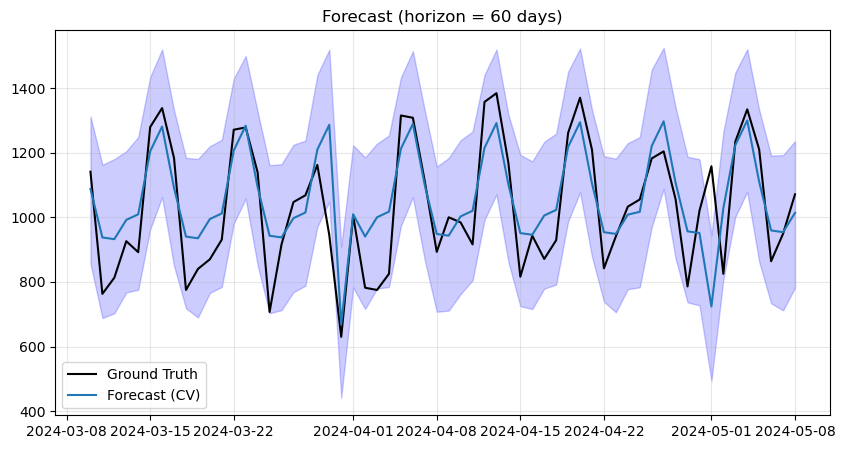


Test set metrics:
RMSE = 121.24
MAE  = 91.80


C:\Users\andre\AppData\Local\Temp\ipykernel_37676\1743448199.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_final["pre_covid"] = (train_final["ds"] < cutoff_date)
C:\Users\andre\AppData\Local\Temp\ipykernel_37676\1743448199.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_final["post_covid"] = (train_final["ds"] >= cutoff_date)
11:28:54 - cmdstanpy - INFO - Chain [1] start processing
11:28:55 - cmdstanpy - INFO - Chain [1] done processing



Model components:


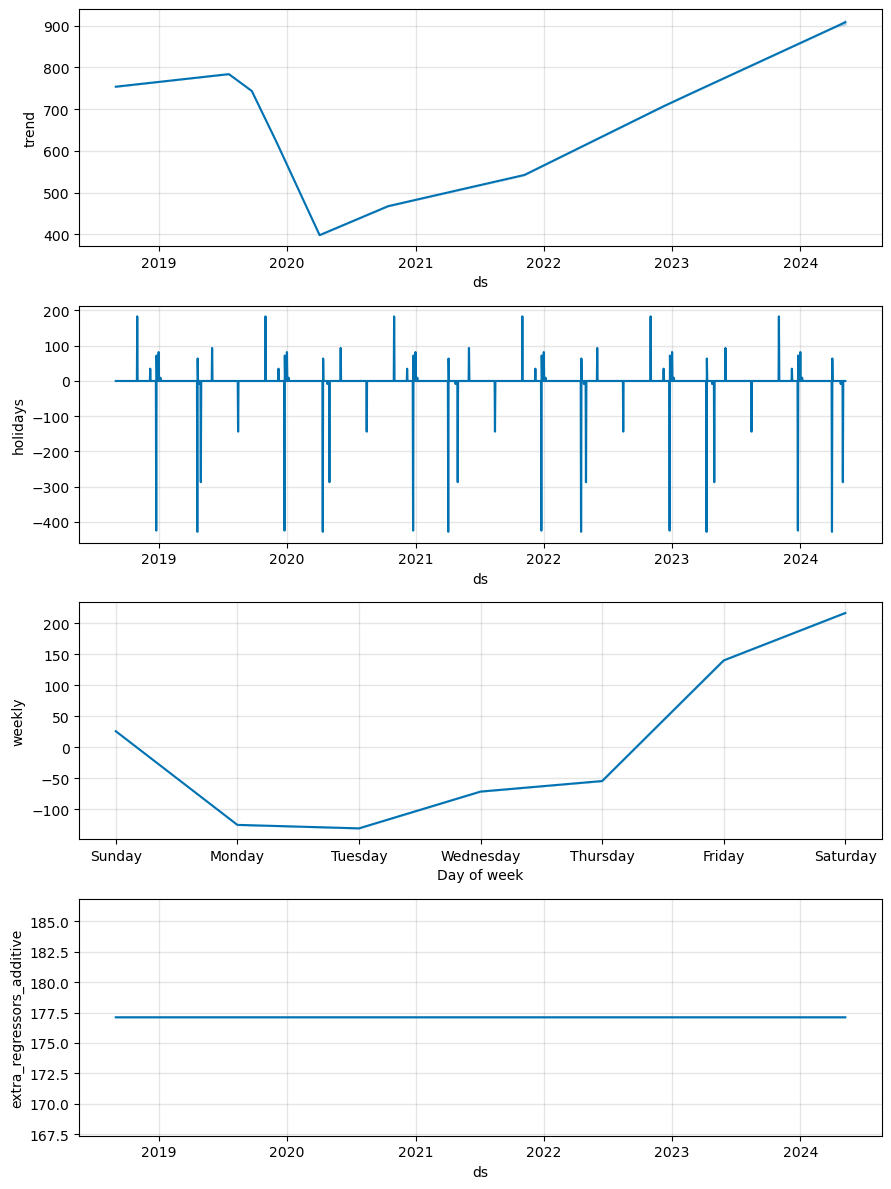

In [115]:
results = fit_prophet_model(
    df=df,
    y_col='scontrini',
    ds_col='data',
    regressors= covid_regr[1],
    n_test=60,
    weekly=True,
    monthly=False,
    yearly=False,
    weekly_prepost=False,
    holidays=True,
    verbose = True,
    return_results = True)

In [116]:
with open("models/prophet_model_scontrini_restaurant_2.json", "w") as f:
    f.write(model_to_json(results["model"]))

## GRID SEARCH ON DF3

In [118]:
df = pd.read_csv('data/restaurant_3.csv')

results = []

for (w, m, y, wp, h, covid) in param_grid:
    print(f"\n Testing with: weekly={w}, monthly={m}, yearly={y}, prepost={wp}, holidays={h}, covid={covid is not None}")
    
    
        # Fit Prophet
    res = fit_prophet_model(
            df=df,
            y_col="scontrini",
            ds_col="data",
            n_test=60,
            weekly=w,
            monthly=m,
            yearly=y,
            weekly_prepost=wp,
            holidays=h,
            regressors=covid,
            verbose=False,
            return_results=True
    )

        
    metrics_last = res["metrics_last_window"]
    cv_metrics = res["metrics_cv"]
    rmse_cv_mean = cv_metrics["rmse"].mean()
    mae_cv_mean = cv_metrics["mae"].mean()
      
    results.append({
            "weekly": w,
            "monthly": m,
            "yearly": y,
            "weekly_prepost": wp,
            "holidays": h,
            "covid_regressors": covid,
            "RMSE_last": metrics_last["RMSE"],
            "MAE_last": metrics_last["MAE"],
            "RMSE_cv_mean": rmse_cv_mean,
            "MAE_cv_mean": mae_cv_mean
    })


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=True, covid=False


11:29:53 - cmdstanpy - INFO - Chain [1] start processing
11:29:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:29:53 - cmdstanpy - INFO - Chain [1] start processing
11:29:53 - cmdstanpy - INFO - Chain [1] done processing
11:29:54 - cmdstanpy - INFO - Chain [1] start processing
11:29:54 - cmdstanpy - INFO - Chain [1] done processing
11:29:54 - cmdstanpy - INFO - Chain [1] start processing
11:29:54 - cmdstanpy - INFO - Chain [1] done processing
11:29:54 - cmdstanpy - INFO - Chain [1] start processing
11:29:54 - cmdstanpy - INFO - Chain [1] done processing
11:29:54 - cmdstanpy - INFO - Chain [1] start processing
11:29:55 - cmdstanpy - INFO - Chain [1] done processing
11:29:55 - cmdstanpy - INFO - Chain [1] start processing
11:29:55 - cmdstanpy - INFO - Chain [1] done processing
11:29:55 - cmdstanpy - INFO - Chain [1] start processing
11:29:55 - cmdstanpy - INFO - Chain [1] done processing
11:29:56 - cmdstanpy - INFO - Chain [1] start processing
11:29:56 - cmdstanpy - INFO - Chain [1] done processing
11:29:56 - cmdstanpy - INFO - Chain [1] start processing
11:29:56 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


11:30:04 - cmdstanpy - INFO - Chain [1] start processing
11:30:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:30:05 - cmdstanpy - INFO - Chain [1] start processing
11:30:05 - cmdstanpy - INFO - Chain [1] done processing
11:30:05 - cmdstanpy - INFO - Chain [1] start processing
11:30:05 - cmdstanpy - INFO - Chain [1] done processing
11:30:06 - cmdstanpy - INFO - Chain [1] start processing
11:30:06 - cmdstanpy - INFO - Chain [1] done processing
11:30:06 - cmdstanpy - INFO - Chain [1] start processing
11:30:06 - cmdstanpy - INFO - Chain [1] done processing
11:30:06 - cmdstanpy - INFO - Chain [1] start processing
11:30:06 - cmdstanpy - INFO - Chain [1] done processing
11:30:07 - cmdstanpy - INFO - Chain [1] start processing
11:30:07 - cmdstanpy - INFO - Chain [1] done processing
11:30:07 - cmdstanpy - INFO - Chain [1] start processing
11:30:07 - cmdstanpy - INFO - Chain [1] done processing
11:30:08 - cmdstanpy - INFO - Chain [1] start processing
11:30:08 - cmdstanpy - INFO - Chain [1] done processing
11:30:08 - cmdstanpy - INFO - Chain [1] start processing
11:30:08 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


11:30:17 - cmdstanpy - INFO - Chain [1] start processing
11:30:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:30:18 - cmdstanpy - INFO - Chain [1] start processing
11:30:18 - cmdstanpy - INFO - Chain [1] done processing
11:30:18 - cmdstanpy - INFO - Chain [1] start processing
11:30:18 - cmdstanpy - INFO - Chain [1] done processing
11:30:19 - cmdstanpy - INFO - Chain [1] start processing
11:30:19 - cmdstanpy - INFO - Chain [1] done processing
11:30:19 - cmdstanpy - INFO - Chain [1] start processing
11:30:19 - cmdstanpy - INFO - Chain [1] done processing
11:30:19 - cmdstanpy - INFO - Chain [1] start processing
11:30:19 - cmdstanpy - INFO - Chain [1] done processing
11:30:20 - cmdstanpy - INFO - Chain [1] start processing
11:30:20 - cmdstanpy - INFO - Chain [1] done processing
11:30:20 - cmdstanpy - INFO - Chain [1] start processing
11:30:20 - cmdstanpy - INFO - Chain [1] done processing
11:30:20 - cmdstanpy - INFO - Chain [1] start processing
11:30:20 - cmdstanpy - INFO - Chain [1] done processing
11:30:21 - cmdstanpy - INFO - Chain [1] start processing
11:30:21 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=False, covid=False


11:30:30 - cmdstanpy - INFO - Chain [1] start processing
11:30:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:30:31 - cmdstanpy - INFO - Chain [1] start processing
11:30:31 - cmdstanpy - INFO - Chain [1] done processing
11:30:31 - cmdstanpy - INFO - Chain [1] start processing
11:30:31 - cmdstanpy - INFO - Chain [1] done processing
11:30:31 - cmdstanpy - INFO - Chain [1] start processing
11:30:31 - cmdstanpy - INFO - Chain [1] done processing
11:30:31 - cmdstanpy - INFO - Chain [1] start processing
11:30:31 - cmdstanpy - INFO - Chain [1] done processing
11:30:32 - cmdstanpy - INFO - Chain [1] start processing
11:30:32 - cmdstanpy - INFO - Chain [1] done processing
11:30:32 - cmdstanpy - INFO - Chain [1] start processing
11:30:32 - cmdstanpy - INFO - Chain [1] done processing
11:30:32 - cmdstanpy - INFO - Chain [1] start processing
11:30:32 - cmdstanpy - INFO - Chain [1] done processing
11:30:33 - cmdstanpy - INFO - Chain [1] start processing
11:30:33 - cmdstanpy - INFO - Chain [1] done processing
11:30:33 - cmdstanpy - INFO - Chain [1] start processing
11:30:33 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


11:30:40 - cmdstanpy - INFO - Chain [1] start processing
11:30:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:30:40 - cmdstanpy - INFO - Chain [1] start processing
11:30:40 - cmdstanpy - INFO - Chain [1] done processing
11:30:40 - cmdstanpy - INFO - Chain [1] start processing
11:30:41 - cmdstanpy - INFO - Chain [1] done processing
11:30:41 - cmdstanpy - INFO - Chain [1] start processing
11:30:41 - cmdstanpy - INFO - Chain [1] done processing
11:30:41 - cmdstanpy - INFO - Chain [1] start processing
11:30:41 - cmdstanpy - INFO - Chain [1] done processing
11:30:41 - cmdstanpy - INFO - Chain [1] start processing
11:30:42 - cmdstanpy - INFO - Chain [1] done processing
11:30:42 - cmdstanpy - INFO - Chain [1] start processing
11:30:42 - cmdstanpy - INFO - Chain [1] done processing
11:30:42 - cmdstanpy - INFO - Chain [1] start processing
11:30:42 - cmdstanpy - INFO - Chain [1] done processing
11:30:42 - cmdstanpy - INFO - Chain [1] start processing
11:30:43 - cmdstanpy - INFO - Chain [1] done processing
11:30:43 - cmdstanpy - INFO - Chain [1] start processing
11:30:43 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


11:30:50 - cmdstanpy - INFO - Chain [1] start processing
11:30:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:30:50 - cmdstanpy - INFO - Chain [1] start processing
11:30:50 - cmdstanpy - INFO - Chain [1] done processing
11:30:51 - cmdstanpy - INFO - Chain [1] start processing
11:30:51 - cmdstanpy - INFO - Chain [1] done processing
11:30:51 - cmdstanpy - INFO - Chain [1] start processing
11:30:51 - cmdstanpy - INFO - Chain [1] done processing
11:30:51 - cmdstanpy - INFO - Chain [1] start processing
11:30:51 - cmdstanpy - INFO - Chain [1] done processing
11:30:51 - cmdstanpy - INFO - Chain [1] start processing
11:30:52 - cmdstanpy - INFO - Chain [1] done processing
11:30:52 - cmdstanpy - INFO - Chain [1] start processing
11:30:52 - cmdstanpy - INFO - Chain [1] done processing
11:30:52 - cmdstanpy - INFO - Chain [1] start processing
11:30:52 - cmdstanpy - INFO - Chain [1] done processing
11:30:52 - cmdstanpy - INFO - Chain [1] start processing
11:30:53 - cmdstanpy - INFO - Chain [1] done processing
11:30:53 - cmdstanpy - INFO - Chain [1] start processing
11:30:53 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=True, covid=False


11:31:00 - cmdstanpy - INFO - Chain [1] start processing
11:31:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:31:01 - cmdstanpy - INFO - Chain [1] start processing
11:31:01 - cmdstanpy - INFO - Chain [1] done processing
11:31:01 - cmdstanpy - INFO - Chain [1] start processing
11:31:01 - cmdstanpy - INFO - Chain [1] done processing
11:31:01 - cmdstanpy - INFO - Chain [1] start processing
11:31:01 - cmdstanpy - INFO - Chain [1] done processing
11:31:02 - cmdstanpy - INFO - Chain [1] start processing
11:31:02 - cmdstanpy - INFO - Chain [1] done processing
11:31:02 - cmdstanpy - INFO - Chain [1] start processing
11:31:02 - cmdstanpy - INFO - Chain [1] done processing
11:31:02 - cmdstanpy - INFO - Chain [1] start processing
11:31:02 - cmdstanpy - INFO - Chain [1] done processing
11:31:03 - cmdstanpy - INFO - Chain [1] start processing
11:31:03 - cmdstanpy - INFO - Chain [1] done processing
11:31:03 - cmdstanpy - INFO - Chain [1] start processing
11:31:03 - cmdstanpy - INFO - Chain [1] done processing
11:31:04 - cmdstanpy - INFO - Chain [1] start processing
11:31:04 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


11:31:12 - cmdstanpy - INFO - Chain [1] start processing
11:31:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:31:13 - cmdstanpy - INFO - Chain [1] start processing
11:31:13 - cmdstanpy - INFO - Chain [1] done processing
11:31:13 - cmdstanpy - INFO - Chain [1] start processing
11:31:13 - cmdstanpy - INFO - Chain [1] done processing
11:31:13 - cmdstanpy - INFO - Chain [1] start processing
11:31:13 - cmdstanpy - INFO - Chain [1] done processing
11:31:14 - cmdstanpy - INFO - Chain [1] start processing
11:31:14 - cmdstanpy - INFO - Chain [1] done processing
11:31:14 - cmdstanpy - INFO - Chain [1] start processing
11:31:14 - cmdstanpy - INFO - Chain [1] done processing
11:31:14 - cmdstanpy - INFO - Chain [1] start processing
11:31:14 - cmdstanpy - INFO - Chain [1] done processing
11:31:15 - cmdstanpy - INFO - Chain [1] start processing
11:31:15 - cmdstanpy - INFO - Chain [1] done processing
11:31:15 - cmdstanpy - INFO - Chain [1] start processing
11:31:15 - cmdstanpy - INFO - Chain [1] done processing
11:31:15 - cmdstanpy - INFO - Chain [1] start processing
11:31:16 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


11:31:25 - cmdstanpy - INFO - Chain [1] start processing
11:31:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:31:25 - cmdstanpy - INFO - Chain [1] start processing
11:31:26 - cmdstanpy - INFO - Chain [1] done processing
11:31:26 - cmdstanpy - INFO - Chain [1] start processing
11:31:26 - cmdstanpy - INFO - Chain [1] done processing
11:31:26 - cmdstanpy - INFO - Chain [1] start processing
11:31:26 - cmdstanpy - INFO - Chain [1] done processing
11:31:26 - cmdstanpy - INFO - Chain [1] start processing
11:31:26 - cmdstanpy - INFO - Chain [1] done processing
11:31:27 - cmdstanpy - INFO - Chain [1] start processing
11:31:27 - cmdstanpy - INFO - Chain [1] done processing
11:31:27 - cmdstanpy - INFO - Chain [1] start processing
11:31:27 - cmdstanpy - INFO - Chain [1] done processing
11:31:27 - cmdstanpy - INFO - Chain [1] start processing
11:31:28 - cmdstanpy - INFO - Chain [1] done processing
11:31:28 - cmdstanpy - INFO - Chain [1] start processing
11:31:28 - cmdstanpy - INFO - Chain [1] done processing
11:31:28 - cmdstanpy - INFO - Chain [1] start processing
11:31:28 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=False, covid=False


11:31:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:31:38 - cmdstanpy - INFO - Chain [1] start processing
11:31:38 - cmdstanpy - INFO - Chain [1] done processing
11:31:38 - cmdstanpy - INFO - Chain [1] start processing
11:31:38 - cmdstanpy - INFO - Chain [1] done processing
11:31:38 - cmdstanpy - INFO - Chain [1] start processing
11:31:38 - cmdstanpy - INFO - Chain [1] done processing
11:31:39 - cmdstanpy - INFO - Chain [1] start processing
11:31:39 - cmdstanpy - INFO - Chain [1] done processing
11:31:39 - cmdstanpy - INFO - Chain [1] start processing
11:31:39 - cmdstanpy - INFO - Chain [1] done processing
11:31:39 - cmdstanpy - INFO - Chain [1] start processing
11:31:39 - cmdstanpy - INFO - Chain [1] done processing
11:31:39 - cmdstanpy - INFO - Chain [1] start processing
11:31:40 - cmdstanpy - INFO - Chain [1] done processing
11:31:40 - cmdstanpy - INFO - Chain [1] start processing
11:31:40 - cmdstanpy - INFO - Chain [1] done processing
11:31:40 - cmdstanpy - INFO - Chain [1] start processing
11:31:40 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


11:31:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:31:47 - cmdstanpy - INFO - Chain [1] start processing
11:31:47 - cmdstanpy - INFO - Chain [1] done processing
11:31:47 - cmdstanpy - INFO - Chain [1] start processing
11:31:47 - cmdstanpy - INFO - Chain [1] done processing
11:31:48 - cmdstanpy - INFO - Chain [1] start processing
11:31:48 - cmdstanpy - INFO - Chain [1] done processing
11:31:48 - cmdstanpy - INFO - Chain [1] start processing
11:31:48 - cmdstanpy - INFO - Chain [1] done processing
11:31:48 - cmdstanpy - INFO - Chain [1] start processing
11:31:48 - cmdstanpy - INFO - Chain [1] done processing
11:31:49 - cmdstanpy - INFO - Chain [1] start processing
11:31:49 - cmdstanpy - INFO - Chain [1] done processing
11:31:49 - cmdstanpy - INFO - Chain [1] start processing
11:31:49 - cmdstanpy - INFO - Chain [1] done processing
11:31:49 - cmdstanpy - INFO - Chain [1] start processing
11:31:49 - cmdstanpy - INFO - Chain [1] done processing
11:31:50 - cmdstanpy - INFO - Chain [1] start processing
11:31:50 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


11:31:57 - cmdstanpy - INFO - Chain [1] start processing
11:31:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:31:57 - cmdstanpy - INFO - Chain [1] start processing
11:31:57 - cmdstanpy - INFO - Chain [1] done processing
11:31:58 - cmdstanpy - INFO - Chain [1] start processing
11:31:58 - cmdstanpy - INFO - Chain [1] done processing
11:31:58 - cmdstanpy - INFO - Chain [1] start processing
11:31:58 - cmdstanpy - INFO - Chain [1] done processing
11:31:58 - cmdstanpy - INFO - Chain [1] start processing
11:31:58 - cmdstanpy - INFO - Chain [1] done processing
11:31:58 - cmdstanpy - INFO - Chain [1] start processing
11:31:59 - cmdstanpy - INFO - Chain [1] done processing
11:31:59 - cmdstanpy - INFO - Chain [1] start processing
11:31:59 - cmdstanpy - INFO - Chain [1] done processing
11:31:59 - cmdstanpy - INFO - Chain [1] start processing
11:31:59 - cmdstanpy - INFO - Chain [1] done processing
11:31:59 - cmdstanpy - INFO - Chain [1] start processing
11:32:00 - cmdstanpy - INFO - Chain [1] done processing
11:32:00 - cmdstanpy - INFO - Chain [1] start processing
11:32:00 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=True, covid=False


11:32:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:32:07 - cmdstanpy - INFO - Chain [1] start processing
11:32:07 - cmdstanpy - INFO - Chain [1] done processing
11:32:07 - cmdstanpy - INFO - Chain [1] start processing
11:32:07 - cmdstanpy - INFO - Chain [1] done processing
11:32:08 - cmdstanpy - INFO - Chain [1] start processing
11:32:08 - cmdstanpy - INFO - Chain [1] done processing
11:32:08 - cmdstanpy - INFO - Chain [1] start processing
11:32:08 - cmdstanpy - INFO - Chain [1] done processing
11:32:08 - cmdstanpy - INFO - Chain [1] start processing
11:32:08 - cmdstanpy - INFO - Chain [1] done processing
11:32:09 - cmdstanpy - INFO - Chain [1] start processing
11:32:09 - cmdstanpy - INFO - Chain [1] done processing
11:32:09 - cmdstanpy - INFO - Chain [1] start processing
11:32:09 - cmdstanpy - INFO - Chain [1] done processing
11:32:09 - cmdstanpy - INFO - Chain [1] start processing
11:32:10 - cmdstanpy - INFO - Chain [1] done processing
11:32:10 - cmdstanpy - INFO - Chain [1] start processing
11:32:10 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


11:32:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:32:17 - cmdstanpy - INFO - Chain [1] start processing
11:32:17 - cmdstanpy - INFO - Chain [1] done processing
11:32:18 - cmdstanpy - INFO - Chain [1] start processing
11:32:18 - cmdstanpy - INFO - Chain [1] done processing
11:32:18 - cmdstanpy - INFO - Chain [1] start processing
11:32:18 - cmdstanpy - INFO - Chain [1] done processing
11:32:18 - cmdstanpy - INFO - Chain [1] start processing
11:32:18 - cmdstanpy - INFO - Chain [1] done processing
11:32:19 - cmdstanpy - INFO - Chain [1] start processing
11:32:19 - cmdstanpy - INFO - Chain [1] done processing
11:32:19 - cmdstanpy - INFO - Chain [1] start processing
11:32:19 - cmdstanpy - INFO - Chain [1] done processing
11:32:19 - cmdstanpy - INFO - Chain [1] start processing
11:32:20 - cmdstanpy - INFO - Chain [1] done processing
11:32:20 - cmdstanpy - INFO - Chain [1] start processing
11:32:20 - cmdstanpy - INFO - Chain [1] done processing
11:32:20 - cmdstanpy - INFO - Chain [1] start processing
11:32:20 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


11:32:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:32:29 - cmdstanpy - INFO - Chain [1] start processing
11:32:29 - cmdstanpy - INFO - Chain [1] done processing
11:32:29 - cmdstanpy - INFO - Chain [1] start processing
11:32:29 - cmdstanpy - INFO - Chain [1] done processing
11:32:30 - cmdstanpy - INFO - Chain [1] start processing
11:32:30 - cmdstanpy - INFO - Chain [1] done processing
11:32:30 - cmdstanpy - INFO - Chain [1] start processing
11:32:30 - cmdstanpy - INFO - Chain [1] done processing
11:32:30 - cmdstanpy - INFO - Chain [1] start processing
11:32:30 - cmdstanpy - INFO - Chain [1] done processing
11:32:31 - cmdstanpy - INFO - Chain [1] start processing
11:32:31 - cmdstanpy - INFO - Chain [1] done processing
11:32:31 - cmdstanpy - INFO - Chain [1] start processing
11:32:31 - cmdstanpy - INFO - Chain [1] done processing
11:32:31 - cmdstanpy - INFO - Chain [1] start processing
11:32:31 - cmdstanpy - INFO - Chain [1] done processing
11:32:32 - cmdstanpy - INFO - Chain [1] start processing
11:32:32 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=False, covid=False


11:32:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:32:40 - cmdstanpy - INFO - Chain [1] start processing
11:32:40 - cmdstanpy - INFO - Chain [1] done processing
11:32:40 - cmdstanpy - INFO - Chain [1] start processing
11:32:40 - cmdstanpy - INFO - Chain [1] done processing
11:32:40 - cmdstanpy - INFO - Chain [1] start processing
11:32:40 - cmdstanpy - INFO - Chain [1] done processing
11:32:41 - cmdstanpy - INFO - Chain [1] start processing
11:32:41 - cmdstanpy - INFO - Chain [1] done processing
11:32:41 - cmdstanpy - INFO - Chain [1] start processing
11:32:41 - cmdstanpy - INFO - Chain [1] done processing
11:32:41 - cmdstanpy - INFO - Chain [1] start processing
11:32:41 - cmdstanpy - INFO - Chain [1] done processing
11:32:41 - cmdstanpy - INFO - Chain [1] start processing
11:32:42 - cmdstanpy - INFO - Chain [1] done processing
11:32:42 - cmdstanpy - INFO - Chain [1] start processing
11:32:42 - cmdstanpy - INFO - Chain [1] done processing
11:32:42 - cmdstanpy - INFO - Chain [1] start processing
11:32:42 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


11:32:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:32:48 - cmdstanpy - INFO - Chain [1] start processing
11:32:48 - cmdstanpy - INFO - Chain [1] done processing
11:32:48 - cmdstanpy - INFO - Chain [1] start processing
11:32:48 - cmdstanpy - INFO - Chain [1] done processing
11:32:48 - cmdstanpy - INFO - Chain [1] start processing
11:32:49 - cmdstanpy - INFO - Chain [1] done processing
11:32:49 - cmdstanpy - INFO - Chain [1] start processing
11:32:49 - cmdstanpy - INFO - Chain [1] done processing
11:32:49 - cmdstanpy - INFO - Chain [1] start processing
11:32:49 - cmdstanpy - INFO - Chain [1] done processing
11:32:49 - cmdstanpy - INFO - Chain [1] start processing
11:32:49 - cmdstanpy - INFO - Chain [1] done processing
11:32:50 - cmdstanpy - INFO - Chain [1] start processing
11:32:50 - cmdstanpy - INFO - Chain [1] done processing
11:32:50 - cmdstanpy - INFO - Chain [1] start processing
11:32:50 - cmdstanpy - INFO - Chain [1] done processing
11:32:50 - cmdstanpy - INFO - Chain [1] start processing
11:32:50 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


11:32:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:32:57 - cmdstanpy - INFO - Chain [1] start processing
11:32:57 - cmdstanpy - INFO - Chain [1] done processing
11:32:57 - cmdstanpy - INFO - Chain [1] start processing
11:32:57 - cmdstanpy - INFO - Chain [1] done processing
11:32:57 - cmdstanpy - INFO - Chain [1] start processing
11:32:57 - cmdstanpy - INFO - Chain [1] done processing
11:32:58 - cmdstanpy - INFO - Chain [1] start processing
11:32:58 - cmdstanpy - INFO - Chain [1] done processing
11:32:58 - cmdstanpy - INFO - Chain [1] start processing
11:32:58 - cmdstanpy - INFO - Chain [1] done processing
11:32:58 - cmdstanpy - INFO - Chain [1] start processing
11:32:58 - cmdstanpy - INFO - Chain [1] done processing
11:32:58 - cmdstanpy - INFO - Chain [1] start processing
11:32:59 - cmdstanpy - INFO - Chain [1] done processing
11:32:59 - cmdstanpy - INFO - Chain [1] start processing
11:32:59 - cmdstanpy - INFO - Chain [1] done processing
11:32:59 - cmdstanpy - INFO - Chain [1] start processing
11:32:59 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=True, covid=False


11:33:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:33:06 - cmdstanpy - INFO - Chain [1] start processing
11:33:06 - cmdstanpy - INFO - Chain [1] done processing
11:33:06 - cmdstanpy - INFO - Chain [1] start processing
11:33:06 - cmdstanpy - INFO - Chain [1] done processing
11:33:06 - cmdstanpy - INFO - Chain [1] start processing
11:33:06 - cmdstanpy - INFO - Chain [1] done processing
11:33:07 - cmdstanpy - INFO - Chain [1] start processing
11:33:07 - cmdstanpy - INFO - Chain [1] done processing
11:33:07 - cmdstanpy - INFO - Chain [1] start processing
11:33:07 - cmdstanpy - INFO - Chain [1] done processing
11:33:07 - cmdstanpy - INFO - Chain [1] start processing
11:33:07 - cmdstanpy - INFO - Chain [1] done processing
11:33:07 - cmdstanpy - INFO - Chain [1] start processing
11:33:08 - cmdstanpy - INFO - Chain [1] done processing
11:33:08 - cmdstanpy - INFO - Chain [1] start processing
11:33:08 - cmdstanpy - INFO - Chain [1] done processing
11:33:08 - cmdstanpy - INFO - Chain [1] start processing
11:33:08 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


11:33:15 - cmdstanpy - INFO - Chain [1] start processing
11:33:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:33:15 - cmdstanpy - INFO - Chain [1] start processing
11:33:16 - cmdstanpy - INFO - Chain [1] done processing
11:33:16 - cmdstanpy - INFO - Chain [1] start processing
11:33:16 - cmdstanpy - INFO - Chain [1] done processing
11:33:16 - cmdstanpy - INFO - Chain [1] start processing
11:33:16 - cmdstanpy - INFO - Chain [1] done processing
11:33:16 - cmdstanpy - INFO - Chain [1] start processing
11:33:17 - cmdstanpy - INFO - Chain [1] done processing
11:33:17 - cmdstanpy - INFO - Chain [1] start processing
11:33:17 - cmdstanpy - INFO - Chain [1] done processing
11:33:17 - cmdstanpy - INFO - Chain [1] start processing
11:33:17 - cmdstanpy - INFO - Chain [1] done processing
11:33:17 - cmdstanpy - INFO - Chain [1] start processing
11:33:18 - cmdstanpy - INFO - Chain [1] done processing
11:33:18 - cmdstanpy - INFO - Chain [1] start processing
11:33:18 - cmdstanpy - INFO - Chain [1] done processing
11:33:18 - cmdstanpy - INFO - Chain [1] start processing
11:33:18 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


11:33:26 - cmdstanpy - INFO - Chain [1] start processing
11:33:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:33:27 - cmdstanpy - INFO - Chain [1] start processing
11:33:27 - cmdstanpy - INFO - Chain [1] done processing
11:33:27 - cmdstanpy - INFO - Chain [1] start processing
11:33:27 - cmdstanpy - INFO - Chain [1] done processing
11:33:27 - cmdstanpy - INFO - Chain [1] start processing
11:33:27 - cmdstanpy - INFO - Chain [1] done processing
11:33:27 - cmdstanpy - INFO - Chain [1] start processing
11:33:28 - cmdstanpy - INFO - Chain [1] done processing
11:33:28 - cmdstanpy - INFO - Chain [1] start processing
11:33:28 - cmdstanpy - INFO - Chain [1] done processing
11:33:28 - cmdstanpy - INFO - Chain [1] start processing
11:33:28 - cmdstanpy - INFO - Chain [1] done processing
11:33:28 - cmdstanpy - INFO - Chain [1] start processing
11:33:29 - cmdstanpy - INFO - Chain [1] done processing
11:33:29 - cmdstanpy - INFO - Chain [1] start processing
11:33:29 - cmdstanpy - INFO - Chain [1] done processing
11:33:29 - cmdstanpy - INFO - Chain [1] start processing
11:33:29 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=False, covid=False


11:33:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:33:37 - cmdstanpy - INFO - Chain [1] start processing
11:33:38 - cmdstanpy - INFO - Chain [1] done processing
11:33:38 - cmdstanpy - INFO - Chain [1] start processing
11:33:38 - cmdstanpy - INFO - Chain [1] done processing
11:33:38 - cmdstanpy - INFO - Chain [1] start processing
11:33:38 - cmdstanpy - INFO - Chain [1] done processing
11:33:38 - cmdstanpy - INFO - Chain [1] start processing
11:33:38 - cmdstanpy - INFO - Chain [1] done processing
11:33:39 - cmdstanpy - INFO - Chain [1] start processing
11:33:39 - cmdstanpy - INFO - Chain [1] done processing
11:33:39 - cmdstanpy - INFO - Chain [1] start processing
11:33:39 - cmdstanpy - INFO - Chain [1] done processing
11:33:39 - cmdstanpy - INFO - Chain [1] start processing
11:33:39 - cmdstanpy - INFO - Chain [1] done processing
11:33:39 - cmdstanpy - INFO - Chain [1] start processing
11:33:40 - cmdstanpy - INFO - Chain [1] done processing
11:33:40 - cmdstanpy - INFO - Chain [1] start processing
11:33:40 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


11:33:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:33:45 - cmdstanpy - INFO - Chain [1] start processing
11:33:46 - cmdstanpy - INFO - Chain [1] done processing
11:33:46 - cmdstanpy - INFO - Chain [1] start processing
11:33:46 - cmdstanpy - INFO - Chain [1] done processing
11:33:46 - cmdstanpy - INFO - Chain [1] start processing
11:33:46 - cmdstanpy - INFO - Chain [1] done processing
11:33:46 - cmdstanpy - INFO - Chain [1] start processing
11:33:47 - cmdstanpy - INFO - Chain [1] done processing
11:33:47 - cmdstanpy - INFO - Chain [1] start processing
11:33:47 - cmdstanpy - INFO - Chain [1] done processing
11:33:47 - cmdstanpy - INFO - Chain [1] start processing
11:33:47 - cmdstanpy - INFO - Chain [1] done processing
11:33:47 - cmdstanpy - INFO - Chain [1] start processing
11:33:48 - cmdstanpy - INFO - Chain [1] done processing
11:33:48 - cmdstanpy - INFO - Chain [1] start processing
11:33:48 - cmdstanpy - INFO - Chain [1] done processing
11:33:48 - cmdstanpy - INFO - Chain [1] start processing
11:33:48 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


11:33:54 - cmdstanpy - INFO - Chain [1] start processing
11:33:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:33:55 - cmdstanpy - INFO - Chain [1] start processing
11:33:55 - cmdstanpy - INFO - Chain [1] done processing
11:33:55 - cmdstanpy - INFO - Chain [1] start processing
11:33:55 - cmdstanpy - INFO - Chain [1] done processing
11:33:55 - cmdstanpy - INFO - Chain [1] start processing
11:33:56 - cmdstanpy - INFO - Chain [1] done processing
11:33:56 - cmdstanpy - INFO - Chain [1] start processing
11:33:56 - cmdstanpy - INFO - Chain [1] done processing
11:33:56 - cmdstanpy - INFO - Chain [1] start processing
11:33:56 - cmdstanpy - INFO - Chain [1] done processing
11:33:57 - cmdstanpy - INFO - Chain [1] start processing
11:33:57 - cmdstanpy - INFO - Chain [1] done processing
11:33:57 - cmdstanpy - INFO - Chain [1] start processing
11:33:57 - cmdstanpy - INFO - Chain [1] done processing
11:33:57 - cmdstanpy - INFO - Chain [1] start processing
11:33:57 - cmdstanpy - INFO - Chain [1] done processing
11:33:58 - cmdstanpy - INFO - Chain [1] start processing
11:33:58 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=True, covid=False


11:34:03 - cmdstanpy - INFO - Chain [1] start processing
11:34:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:34:04 - cmdstanpy - INFO - Chain [1] start processing
11:34:04 - cmdstanpy - INFO - Chain [1] done processing
11:34:04 - cmdstanpy - INFO - Chain [1] start processing
11:34:04 - cmdstanpy - INFO - Chain [1] done processing
11:34:05 - cmdstanpy - INFO - Chain [1] start processing
11:34:05 - cmdstanpy - INFO - Chain [1] done processing
11:34:05 - cmdstanpy - INFO - Chain [1] start processing
11:34:05 - cmdstanpy - INFO - Chain [1] done processing
11:34:05 - cmdstanpy - INFO - Chain [1] start processing
11:34:05 - cmdstanpy - INFO - Chain [1] done processing
11:34:06 - cmdstanpy - INFO - Chain [1] start processing
11:34:06 - cmdstanpy - INFO - Chain [1] done processing
11:34:06 - cmdstanpy - INFO - Chain [1] start processing
11:34:06 - cmdstanpy - INFO - Chain [1] done processing
11:34:06 - cmdstanpy - INFO - Chain [1] start processing
11:34:06 - cmdstanpy - INFO - Chain [1] done processing
11:34:07 - cmdstanpy - INFO - Chain [1] start processing
11:34:07 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


11:34:16 - cmdstanpy - INFO - Chain [1] start processing
11:34:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:34:16 - cmdstanpy - INFO - Chain [1] start processing
11:34:16 - cmdstanpy - INFO - Chain [1] done processing
11:34:16 - cmdstanpy - INFO - Chain [1] start processing
11:34:17 - cmdstanpy - INFO - Chain [1] done processing
11:34:17 - cmdstanpy - INFO - Chain [1] start processing
11:34:17 - cmdstanpy - INFO - Chain [1] done processing
11:34:17 - cmdstanpy - INFO - Chain [1] start processing
11:34:17 - cmdstanpy - INFO - Chain [1] done processing
11:34:17 - cmdstanpy - INFO - Chain [1] start processing
11:34:18 - cmdstanpy - INFO - Chain [1] done processing
11:34:18 - cmdstanpy - INFO - Chain [1] start processing
11:34:18 - cmdstanpy - INFO - Chain [1] done processing
11:34:18 - cmdstanpy - INFO - Chain [1] start processing
11:34:19 - cmdstanpy - INFO - Chain [1] done processing
11:34:19 - cmdstanpy - INFO - Chain [1] start processing
11:34:19 - cmdstanpy - INFO - Chain [1] done processing
11:34:19 - cmdstanpy - INFO - Chain [1] start processing
11:34:19 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


11:34:28 - cmdstanpy - INFO - Chain [1] start processing
11:34:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:34:29 - cmdstanpy - INFO - Chain [1] start processing
11:34:29 - cmdstanpy - INFO - Chain [1] done processing
11:34:29 - cmdstanpy - INFO - Chain [1] start processing
11:34:29 - cmdstanpy - INFO - Chain [1] done processing
11:34:29 - cmdstanpy - INFO - Chain [1] start processing
11:34:29 - cmdstanpy - INFO - Chain [1] done processing
11:34:30 - cmdstanpy - INFO - Chain [1] start processing
11:34:30 - cmdstanpy - INFO - Chain [1] done processing
11:34:30 - cmdstanpy - INFO - Chain [1] start processing
11:34:30 - cmdstanpy - INFO - Chain [1] done processing
11:34:30 - cmdstanpy - INFO - Chain [1] start processing
11:34:30 - cmdstanpy - INFO - Chain [1] done processing
11:34:31 - cmdstanpy - INFO - Chain [1] start processing
11:34:31 - cmdstanpy - INFO - Chain [1] done processing
11:34:31 - cmdstanpy - INFO - Chain [1] start processing
11:34:31 - cmdstanpy - INFO - Chain [1] done processing
11:34:31 - cmdstanpy - INFO - Chain [1] start processing
11:34:31 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=False, covid=False


11:34:41 - cmdstanpy - INFO - Chain [1] start processing
11:34:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:34:41 - cmdstanpy - INFO - Chain [1] start processing
11:34:42 - cmdstanpy - INFO - Chain [1] done processing
11:34:42 - cmdstanpy - INFO - Chain [1] start processing
11:34:42 - cmdstanpy - INFO - Chain [1] done processing
11:34:42 - cmdstanpy - INFO - Chain [1] start processing
11:34:42 - cmdstanpy - INFO - Chain [1] done processing
11:34:42 - cmdstanpy - INFO - Chain [1] start processing
11:34:42 - cmdstanpy - INFO - Chain [1] done processing
11:34:43 - cmdstanpy - INFO - Chain [1] start processing
11:34:43 - cmdstanpy - INFO - Chain [1] done processing
11:34:43 - cmdstanpy - INFO - Chain [1] start processing
11:34:43 - cmdstanpy - INFO - Chain [1] done processing
11:34:43 - cmdstanpy - INFO - Chain [1] start processing
11:34:43 - cmdstanpy - INFO - Chain [1] done processing
11:34:44 - cmdstanpy - INFO - Chain [1] start processing
11:34:44 - cmdstanpy - INFO - Chain [1] done processing
11:34:44 - cmdstanpy - INFO - Chain [1] start processing
11:34:44 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


11:34:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:34:51 - cmdstanpy - INFO - Chain [1] start processing
11:34:51 - cmdstanpy - INFO - Chain [1] done processing
11:34:51 - cmdstanpy - INFO - Chain [1] start processing
11:34:51 - cmdstanpy - INFO - Chain [1] done processing
11:34:52 - cmdstanpy - INFO - Chain [1] start processing
11:34:52 - cmdstanpy - INFO - Chain [1] done processing
11:34:52 - cmdstanpy - INFO - Chain [1] start processing
11:34:52 - cmdstanpy - INFO - Chain [1] done processing
11:34:52 - cmdstanpy - INFO - Chain [1] start processing
11:34:52 - cmdstanpy - INFO - Chain [1] done processing
11:34:52 - cmdstanpy - INFO - Chain [1] start processing
11:34:52 - cmdstanpy - INFO - Chain [1] done processing
11:34:53 - cmdstanpy - INFO - Chain [1] start processing
11:34:53 - cmdstanpy - INFO - Chain [1] done processing
11:34:53 - cmdstanpy - INFO - Chain [1] start processing
11:34:53 - cmdstanpy - INFO - Chain [1] done processing
11:34:53 - cmdstanpy - INFO - Chain [1] start processing
11:34:54 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


11:35:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:35:01 - cmdstanpy - INFO - Chain [1] start processing
11:35:01 - cmdstanpy - INFO - Chain [1] done processing
11:35:01 - cmdstanpy - INFO - Chain [1] start processing
11:35:01 - cmdstanpy - INFO - Chain [1] done processing
11:35:01 - cmdstanpy - INFO - Chain [1] start processing
11:35:02 - cmdstanpy - INFO - Chain [1] done processing
11:35:02 - cmdstanpy - INFO - Chain [1] start processing
11:35:02 - cmdstanpy - INFO - Chain [1] done processing
11:35:02 - cmdstanpy - INFO - Chain [1] start processing
11:35:02 - cmdstanpy - INFO - Chain [1] done processing
11:35:02 - cmdstanpy - INFO - Chain [1] start processing
11:35:02 - cmdstanpy - INFO - Chain [1] done processing
11:35:03 - cmdstanpy - INFO - Chain [1] start processing
11:35:03 - cmdstanpy - INFO - Chain [1] done processing
11:35:03 - cmdstanpy - INFO - Chain [1] start processing
11:35:03 - cmdstanpy - INFO - Chain [1] done processing
11:35:03 - cmdstanpy - INFO - Chain [1] start processing
11:35:03 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=True, covid=False


11:35:10 - cmdstanpy - INFO - Chain [1] start processing
11:35:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:35:11 - cmdstanpy - INFO - Chain [1] start processing
11:35:11 - cmdstanpy - INFO - Chain [1] done processing
11:35:11 - cmdstanpy - INFO - Chain [1] start processing
11:35:11 - cmdstanpy - INFO - Chain [1] done processing
11:35:12 - cmdstanpy - INFO - Chain [1] start processing
11:35:12 - cmdstanpy - INFO - Chain [1] done processing
11:35:12 - cmdstanpy - INFO - Chain [1] start processing
11:35:12 - cmdstanpy - INFO - Chain [1] done processing
11:35:12 - cmdstanpy - INFO - Chain [1] start processing
11:35:12 - cmdstanpy - INFO - Chain [1] done processing
11:35:13 - cmdstanpy - INFO - Chain [1] start processing
11:35:13 - cmdstanpy - INFO - Chain [1] done processing
11:35:13 - cmdstanpy - INFO - Chain [1] start processing
11:35:13 - cmdstanpy - INFO - Chain [1] done processing
11:35:13 - cmdstanpy - INFO - Chain [1] start processing
11:35:13 - cmdstanpy - INFO - Chain [1] done processing
11:35:14 - cmdstanpy - INFO - Chain [1] start processing
11:35:14 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


11:35:23 - cmdstanpy - INFO - Chain [1] start processing
11:35:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:35:23 - cmdstanpy - INFO - Chain [1] start processing
11:35:23 - cmdstanpy - INFO - Chain [1] done processing
11:35:24 - cmdstanpy - INFO - Chain [1] start processing
11:35:24 - cmdstanpy - INFO - Chain [1] done processing
11:35:24 - cmdstanpy - INFO - Chain [1] start processing
11:35:24 - cmdstanpy - INFO - Chain [1] done processing
11:35:24 - cmdstanpy - INFO - Chain [1] start processing
11:35:24 - cmdstanpy - INFO - Chain [1] done processing
11:35:25 - cmdstanpy - INFO - Chain [1] start processing
11:35:25 - cmdstanpy - INFO - Chain [1] done processing
11:35:25 - cmdstanpy - INFO - Chain [1] start processing
11:35:25 - cmdstanpy - INFO - Chain [1] done processing
11:35:25 - cmdstanpy - INFO - Chain [1] start processing
11:35:26 - cmdstanpy - INFO - Chain [1] done processing
11:35:26 - cmdstanpy - INFO - Chain [1] start processing
11:35:26 - cmdstanpy - INFO - Chain [1] done processing
11:35:26 - cmdstanpy - INFO - Chain [1] start processing
11:35:27 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


11:35:35 - cmdstanpy - INFO - Chain [1] start processing
11:35:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:35:36 - cmdstanpy - INFO - Chain [1] start processing
11:35:36 - cmdstanpy - INFO - Chain [1] done processing
11:35:36 - cmdstanpy - INFO - Chain [1] start processing
11:35:36 - cmdstanpy - INFO - Chain [1] done processing
11:35:36 - cmdstanpy - INFO - Chain [1] start processing
11:35:37 - cmdstanpy - INFO - Chain [1] done processing
11:35:37 - cmdstanpy - INFO - Chain [1] start processing
11:35:37 - cmdstanpy - INFO - Chain [1] done processing
11:35:37 - cmdstanpy - INFO - Chain [1] start processing
11:35:37 - cmdstanpy - INFO - Chain [1] done processing
11:35:37 - cmdstanpy - INFO - Chain [1] start processing
11:35:38 - cmdstanpy - INFO - Chain [1] done processing
11:35:38 - cmdstanpy - INFO - Chain [1] start processing
11:35:38 - cmdstanpy - INFO - Chain [1] done processing
11:35:38 - cmdstanpy - INFO - Chain [1] start processing
11:35:38 - cmdstanpy - INFO - Chain [1] done processing
11:35:39 - cmdstanpy - INFO - Chain [1] start processing
11:35:39 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=False, covid=False


11:35:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:35:48 - cmdstanpy - INFO - Chain [1] start processing
11:35:48 - cmdstanpy - INFO - Chain [1] done processing
11:35:48 - cmdstanpy - INFO - Chain [1] start processing
11:35:48 - cmdstanpy - INFO - Chain [1] done processing
11:35:49 - cmdstanpy - INFO - Chain [1] start processing
11:35:49 - cmdstanpy - INFO - Chain [1] done processing
11:35:49 - cmdstanpy - INFO - Chain [1] start processing
11:35:49 - cmdstanpy - INFO - Chain [1] done processing
11:35:49 - cmdstanpy - INFO - Chain [1] start processing
11:35:49 - cmdstanpy - INFO - Chain [1] done processing
11:35:49 - cmdstanpy - INFO - Chain [1] start processing
11:35:50 - cmdstanpy - INFO - Chain [1] done processing
11:35:50 - cmdstanpy - INFO - Chain [1] start processing
11:35:50 - cmdstanpy - INFO - Chain [1] done processing
11:35:50 - cmdstanpy - INFO - Chain [1] start processing
11:35:50 - cmdstanpy - INFO - Chain [1] done processing
11:35:50 - cmdstanpy - INFO - Chain [1] start processing
11:35:50 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


11:35:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:35:57 - cmdstanpy - INFO - Chain [1] start processing
11:35:57 - cmdstanpy - INFO - Chain [1] done processing
11:35:57 - cmdstanpy - INFO - Chain [1] start processing
11:35:57 - cmdstanpy - INFO - Chain [1] done processing
11:35:57 - cmdstanpy - INFO - Chain [1] start processing
11:35:57 - cmdstanpy - INFO - Chain [1] done processing
11:35:58 - cmdstanpy - INFO - Chain [1] start processing
11:35:58 - cmdstanpy - INFO - Chain [1] done processing
11:35:58 - cmdstanpy - INFO - Chain [1] start processing
11:35:58 - cmdstanpy - INFO - Chain [1] done processing
11:35:58 - cmdstanpy - INFO - Chain [1] start processing
11:35:58 - cmdstanpy - INFO - Chain [1] done processing
11:35:58 - cmdstanpy - INFO - Chain [1] start processing
11:35:59 - cmdstanpy - INFO - Chain [1] done processing
11:35:59 - cmdstanpy - INFO - Chain [1] start processing
11:35:59 - cmdstanpy - INFO - Chain [1] done processing
11:35:59 - cmdstanpy - INFO - Chain [1] start processing
11:35:59 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


11:36:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:36:07 - cmdstanpy - INFO - Chain [1] start processing
11:36:07 - cmdstanpy - INFO - Chain [1] done processing
11:36:07 - cmdstanpy - INFO - Chain [1] start processing
11:36:07 - cmdstanpy - INFO - Chain [1] done processing
11:36:07 - cmdstanpy - INFO - Chain [1] start processing
11:36:07 - cmdstanpy - INFO - Chain [1] done processing
11:36:07 - cmdstanpy - INFO - Chain [1] start processing
11:36:08 - cmdstanpy - INFO - Chain [1] done processing
11:36:08 - cmdstanpy - INFO - Chain [1] start processing
11:36:08 - cmdstanpy - INFO - Chain [1] done processing
11:36:08 - cmdstanpy - INFO - Chain [1] start processing
11:36:08 - cmdstanpy - INFO - Chain [1] done processing
11:36:08 - cmdstanpy - INFO - Chain [1] start processing
11:36:08 - cmdstanpy - INFO - Chain [1] done processing
11:36:09 - cmdstanpy - INFO - Chain [1] start processing
11:36:09 - cmdstanpy - INFO - Chain [1] done processing
11:36:09 - cmdstanpy - INFO - Chain [1] start processing
11:36:09 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=True, covid=False


11:36:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:36:16 - cmdstanpy - INFO - Chain [1] start processing
11:36:16 - cmdstanpy - INFO - Chain [1] done processing
11:36:17 - cmdstanpy - INFO - Chain [1] start processing
11:36:17 - cmdstanpy - INFO - Chain [1] done processing
11:36:17 - cmdstanpy - INFO - Chain [1] start processing
11:36:17 - cmdstanpy - INFO - Chain [1] done processing
11:36:17 - cmdstanpy - INFO - Chain [1] start processing
11:36:17 - cmdstanpy - INFO - Chain [1] done processing
11:36:17 - cmdstanpy - INFO - Chain [1] start processing
11:36:18 - cmdstanpy - INFO - Chain [1] done processing
11:36:18 - cmdstanpy - INFO - Chain [1] start processing
11:36:18 - cmdstanpy - INFO - Chain [1] done processing
11:36:18 - cmdstanpy - INFO - Chain [1] start processing
11:36:18 - cmdstanpy - INFO - Chain [1] done processing
11:36:18 - cmdstanpy - INFO - Chain [1] start processing
11:36:19 - cmdstanpy - INFO - Chain [1] done processing
11:36:19 - cmdstanpy - INFO - Chain [1] start processing
11:36:19 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


11:36:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:36:26 - cmdstanpy - INFO - Chain [1] start processing
11:36:26 - cmdstanpy - INFO - Chain [1] done processing
11:36:26 - cmdstanpy - INFO - Chain [1] start processing
11:36:26 - cmdstanpy - INFO - Chain [1] done processing
11:36:27 - cmdstanpy - INFO - Chain [1] start processing
11:36:27 - cmdstanpy - INFO - Chain [1] done processing
11:36:27 - cmdstanpy - INFO - Chain [1] start processing
11:36:27 - cmdstanpy - INFO - Chain [1] done processing
11:36:27 - cmdstanpy - INFO - Chain [1] start processing
11:36:27 - cmdstanpy - INFO - Chain [1] done processing
11:36:28 - cmdstanpy - INFO - Chain [1] start processing
11:36:28 - cmdstanpy - INFO - Chain [1] done processing
11:36:28 - cmdstanpy - INFO - Chain [1] start processing
11:36:28 - cmdstanpy - INFO - Chain [1] done processing
11:36:28 - cmdstanpy - INFO - Chain [1] start processing
11:36:29 - cmdstanpy - INFO - Chain [1] done processing
11:36:29 - cmdstanpy - INFO - Chain [1] start processing
11:36:29 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


11:36:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:36:38 - cmdstanpy - INFO - Chain [1] start processing
11:36:38 - cmdstanpy - INFO - Chain [1] done processing
11:36:38 - cmdstanpy - INFO - Chain [1] start processing
11:36:38 - cmdstanpy - INFO - Chain [1] done processing
11:36:39 - cmdstanpy - INFO - Chain [1] start processing
11:36:39 - cmdstanpy - INFO - Chain [1] done processing
11:36:39 - cmdstanpy - INFO - Chain [1] start processing
11:36:39 - cmdstanpy - INFO - Chain [1] done processing
11:36:39 - cmdstanpy - INFO - Chain [1] start processing
11:36:39 - cmdstanpy - INFO - Chain [1] done processing
11:36:40 - cmdstanpy - INFO - Chain [1] start processing
11:36:40 - cmdstanpy - INFO - Chain [1] done processing
11:36:40 - cmdstanpy - INFO - Chain [1] start processing
11:36:40 - cmdstanpy - INFO - Chain [1] done processing
11:36:41 - cmdstanpy - INFO - Chain [1] start processing
11:36:41 - cmdstanpy - INFO - Chain [1] done processing
11:36:41 - cmdstanpy - INFO - Chain [1] start processing
11:36:41 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=False, covid=False


11:36:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:36:50 - cmdstanpy - INFO - Chain [1] start processing
11:36:51 - cmdstanpy - INFO - Chain [1] done processing
11:36:51 - cmdstanpy - INFO - Chain [1] start processing
11:36:51 - cmdstanpy - INFO - Chain [1] done processing
11:36:51 - cmdstanpy - INFO - Chain [1] start processing
11:36:51 - cmdstanpy - INFO - Chain [1] done processing
11:36:51 - cmdstanpy - INFO - Chain [1] start processing
11:36:51 - cmdstanpy - INFO - Chain [1] done processing
11:36:52 - cmdstanpy - INFO - Chain [1] start processing
11:36:52 - cmdstanpy - INFO - Chain [1] done processing
11:36:52 - cmdstanpy - INFO - Chain [1] start processing
11:36:52 - cmdstanpy - INFO - Chain [1] done processing
11:36:52 - cmdstanpy - INFO - Chain [1] start processing
11:36:52 - cmdstanpy - INFO - Chain [1] done processing
11:36:52 - cmdstanpy - INFO - Chain [1] start processing
11:36:53 - cmdstanpy - INFO - Chain [1] done processing
11:36:53 - cmdstanpy - INFO - Chain [1] start processing
11:36:53 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


11:36:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:36:59 - cmdstanpy - INFO - Chain [1] start processing
11:37:00 - cmdstanpy - INFO - Chain [1] done processing
11:37:00 - cmdstanpy - INFO - Chain [1] start processing
11:37:00 - cmdstanpy - INFO - Chain [1] done processing
11:37:00 - cmdstanpy - INFO - Chain [1] start processing
11:37:00 - cmdstanpy - INFO - Chain [1] done processing
11:37:00 - cmdstanpy - INFO - Chain [1] start processing
11:37:00 - cmdstanpy - INFO - Chain [1] done processing
11:37:01 - cmdstanpy - INFO - Chain [1] start processing
11:37:01 - cmdstanpy - INFO - Chain [1] done processing
11:37:01 - cmdstanpy - INFO - Chain [1] start processing
11:37:01 - cmdstanpy - INFO - Chain [1] done processing
11:37:01 - cmdstanpy - INFO - Chain [1] start processing
11:37:01 - cmdstanpy - INFO - Chain [1] done processing
11:37:02 - cmdstanpy - INFO - Chain [1] start processing
11:37:02 - cmdstanpy - INFO - Chain [1] done processing
11:37:02 - cmdstanpy - INFO - Chain [1] start processing
11:37:02 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


11:37:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:37:10 - cmdstanpy - INFO - Chain [1] start processing
11:37:10 - cmdstanpy - INFO - Chain [1] done processing
11:37:10 - cmdstanpy - INFO - Chain [1] start processing
11:37:10 - cmdstanpy - INFO - Chain [1] done processing
11:37:10 - cmdstanpy - INFO - Chain [1] start processing
11:37:10 - cmdstanpy - INFO - Chain [1] done processing
11:37:10 - cmdstanpy - INFO - Chain [1] start processing
11:37:10 - cmdstanpy - INFO - Chain [1] done processing
11:37:11 - cmdstanpy - INFO - Chain [1] start processing
11:37:11 - cmdstanpy - INFO - Chain [1] done processing
11:37:11 - cmdstanpy - INFO - Chain [1] start processing
11:37:11 - cmdstanpy - INFO - Chain [1] done processing
11:37:11 - cmdstanpy - INFO - Chain [1] start processing
11:37:11 - cmdstanpy - INFO - Chain [1] done processing
11:37:11 - cmdstanpy - INFO - Chain [1] start processing
11:37:12 - cmdstanpy - INFO - Chain [1] done processing
11:37:12 - cmdstanpy - INFO - Chain [1] start processing
11:37:12 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=True, covid=False


11:37:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:37:19 - cmdstanpy - INFO - Chain [1] start processing
11:37:19 - cmdstanpy - INFO - Chain [1] done processing
11:37:20 - cmdstanpy - INFO - Chain [1] start processing
11:37:20 - cmdstanpy - INFO - Chain [1] done processing
11:37:20 - cmdstanpy - INFO - Chain [1] start processing
11:37:20 - cmdstanpy - INFO - Chain [1] done processing
11:37:20 - cmdstanpy - INFO - Chain [1] start processing
11:37:20 - cmdstanpy - INFO - Chain [1] done processing
11:37:21 - cmdstanpy - INFO - Chain [1] start processing
11:37:21 - cmdstanpy - INFO - Chain [1] done processing
11:37:21 - cmdstanpy - INFO - Chain [1] start processing
11:37:21 - cmdstanpy - INFO - Chain [1] done processing
11:37:21 - cmdstanpy - INFO - Chain [1] start processing
11:37:21 - cmdstanpy - INFO - Chain [1] done processing
11:37:21 - cmdstanpy - INFO - Chain [1] start processing
11:37:22 - cmdstanpy - INFO - Chain [1] done processing
11:37:22 - cmdstanpy - INFO - Chain [1] start processing
11:37:22 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


11:37:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:37:29 - cmdstanpy - INFO - Chain [1] start processing
11:37:30 - cmdstanpy - INFO - Chain [1] done processing
11:37:30 - cmdstanpy - INFO - Chain [1] start processing
11:37:30 - cmdstanpy - INFO - Chain [1] done processing
11:37:30 - cmdstanpy - INFO - Chain [1] start processing
11:37:30 - cmdstanpy - INFO - Chain [1] done processing
11:37:30 - cmdstanpy - INFO - Chain [1] start processing
11:37:30 - cmdstanpy - INFO - Chain [1] done processing
11:37:31 - cmdstanpy - INFO - Chain [1] start processing
11:37:31 - cmdstanpy - INFO - Chain [1] done processing
11:37:31 - cmdstanpy - INFO - Chain [1] start processing
11:37:31 - cmdstanpy - INFO - Chain [1] done processing
11:37:32 - cmdstanpy - INFO - Chain [1] start processing
11:37:32 - cmdstanpy - INFO - Chain [1] done processing
11:37:32 - cmdstanpy - INFO - Chain [1] start processing
11:37:32 - cmdstanpy - INFO - Chain [1] done processing
11:37:32 - cmdstanpy - INFO - Chain [1] start processing
11:37:33 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


11:37:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:37:40 - cmdstanpy - INFO - Chain [1] start processing
11:37:40 - cmdstanpy - INFO - Chain [1] done processing
11:37:40 - cmdstanpy - INFO - Chain [1] start processing
11:37:40 - cmdstanpy - INFO - Chain [1] done processing
11:37:41 - cmdstanpy - INFO - Chain [1] start processing
11:37:41 - cmdstanpy - INFO - Chain [1] done processing
11:37:41 - cmdstanpy - INFO - Chain [1] start processing
11:37:41 - cmdstanpy - INFO - Chain [1] done processing
11:37:41 - cmdstanpy - INFO - Chain [1] start processing
11:37:41 - cmdstanpy - INFO - Chain [1] done processing
11:37:42 - cmdstanpy - INFO - Chain [1] start processing
11:37:42 - cmdstanpy - INFO - Chain [1] done processing
11:37:42 - cmdstanpy - INFO - Chain [1] start processing
11:37:42 - cmdstanpy - INFO - Chain [1] done processing
11:37:42 - cmdstanpy - INFO - Chain [1] start processing
11:37:43 - cmdstanpy - INFO - Chain [1] done processing
11:37:43 - cmdstanpy - INFO - Chain [1] start processing
11:37:43 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=False, covid=False


11:37:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:37:51 - cmdstanpy - INFO - Chain [1] start processing
11:37:51 - cmdstanpy - INFO - Chain [1] done processing
11:37:51 - cmdstanpy - INFO - Chain [1] start processing
11:37:51 - cmdstanpy - INFO - Chain [1] done processing
11:37:51 - cmdstanpy - INFO - Chain [1] start processing
11:37:51 - cmdstanpy - INFO - Chain [1] done processing
11:37:52 - cmdstanpy - INFO - Chain [1] start processing
11:37:52 - cmdstanpy - INFO - Chain [1] done processing
11:37:52 - cmdstanpy - INFO - Chain [1] start processing
11:37:52 - cmdstanpy - INFO - Chain [1] done processing
11:37:52 - cmdstanpy - INFO - Chain [1] start processing
11:37:52 - cmdstanpy - INFO - Chain [1] done processing
11:37:52 - cmdstanpy - INFO - Chain [1] start processing
11:37:52 - cmdstanpy - INFO - Chain [1] done processing
11:37:53 - cmdstanpy - INFO - Chain [1] start processing
11:37:53 - cmdstanpy - INFO - Chain [1] done processing
11:37:53 - cmdstanpy - INFO - Chain [1] start processing
11:37:53 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


11:37:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:37:59 - cmdstanpy - INFO - Chain [1] start processing
11:37:59 - cmdstanpy - INFO - Chain [1] done processing
11:37:59 - cmdstanpy - INFO - Chain [1] start processing
11:37:59 - cmdstanpy - INFO - Chain [1] done processing
11:37:59 - cmdstanpy - INFO - Chain [1] start processing
11:37:59 - cmdstanpy - INFO - Chain [1] done processing
11:37:59 - cmdstanpy - INFO - Chain [1] start processing
11:37:59 - cmdstanpy - INFO - Chain [1] done processing
11:38:00 - cmdstanpy - INFO - Chain [1] start processing
11:38:00 - cmdstanpy - INFO - Chain [1] done processing
11:38:00 - cmdstanpy - INFO - Chain [1] start processing
11:38:00 - cmdstanpy - INFO - Chain [1] done processing
11:38:00 - cmdstanpy - INFO - Chain [1] start processing
11:38:00 - cmdstanpy - INFO - Chain [1] done processing
11:38:00 - cmdstanpy - INFO - Chain [1] start processing
11:38:01 - cmdstanpy - INFO - Chain [1] done processing
11:38:01 - cmdstanpy - INFO - Chain [1] start processing
11:38:01 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


11:38:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:38:07 - cmdstanpy - INFO - Chain [1] start processing
11:38:07 - cmdstanpy - INFO - Chain [1] done processing
11:38:07 - cmdstanpy - INFO - Chain [1] start processing
11:38:07 - cmdstanpy - INFO - Chain [1] done processing
11:38:07 - cmdstanpy - INFO - Chain [1] start processing
11:38:07 - cmdstanpy - INFO - Chain [1] done processing
11:38:07 - cmdstanpy - INFO - Chain [1] start processing
11:38:07 - cmdstanpy - INFO - Chain [1] done processing
11:38:08 - cmdstanpy - INFO - Chain [1] start processing
11:38:08 - cmdstanpy - INFO - Chain [1] done processing
11:38:08 - cmdstanpy - INFO - Chain [1] start processing
11:38:08 - cmdstanpy - INFO - Chain [1] done processing
11:38:08 - cmdstanpy - INFO - Chain [1] start processing
11:38:08 - cmdstanpy - INFO - Chain [1] done processing
11:38:09 - cmdstanpy - INFO - Chain [1] start processing
11:38:09 - cmdstanpy - INFO - Chain [1] done processing
11:38:09 - cmdstanpy - INFO - Chain [1] start processing
11:38:09 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=True, covid=False


11:38:15 - cmdstanpy - INFO - Chain [1] start processing
11:38:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:38:15 - cmdstanpy - INFO - Chain [1] start processing
11:38:15 - cmdstanpy - INFO - Chain [1] done processing
11:38:16 - cmdstanpy - INFO - Chain [1] start processing
11:38:16 - cmdstanpy - INFO - Chain [1] done processing
11:38:16 - cmdstanpy - INFO - Chain [1] start processing
11:38:16 - cmdstanpy - INFO - Chain [1] done processing
11:38:16 - cmdstanpy - INFO - Chain [1] start processing
11:38:17 - cmdstanpy - INFO - Chain [1] done processing
11:38:17 - cmdstanpy - INFO - Chain [1] start processing
11:38:17 - cmdstanpy - INFO - Chain [1] done processing
11:38:17 - cmdstanpy - INFO - Chain [1] start processing
11:38:17 - cmdstanpy - INFO - Chain [1] done processing
11:38:18 - cmdstanpy - INFO - Chain [1] start processing
11:38:18 - cmdstanpy - INFO - Chain [1] done processing
11:38:18 - cmdstanpy - INFO - Chain [1] start processing
11:38:18 - cmdstanpy - INFO - Chain [1] done processing
11:38:18 - cmdstanpy - INFO - Chain [1] start processing
11:38:19 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


11:38:28 - cmdstanpy - INFO - Chain [1] start processing
11:38:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:38:29 - cmdstanpy - INFO - Chain [1] start processing
11:38:29 - cmdstanpy - INFO - Chain [1] done processing
11:38:30 - cmdstanpy - INFO - Chain [1] start processing
11:38:30 - cmdstanpy - INFO - Chain [1] done processing
11:38:30 - cmdstanpy - INFO - Chain [1] start processing
11:38:30 - cmdstanpy - INFO - Chain [1] done processing
11:38:30 - cmdstanpy - INFO - Chain [1] start processing
11:38:31 - cmdstanpy - INFO - Chain [1] done processing
11:38:31 - cmdstanpy - INFO - Chain [1] start processing
11:38:31 - cmdstanpy - INFO - Chain [1] done processing
11:38:31 - cmdstanpy - INFO - Chain [1] start processing
11:38:31 - cmdstanpy - INFO - Chain [1] done processing
11:38:32 - cmdstanpy - INFO - Chain [1] start processing
11:38:32 - cmdstanpy - INFO - Chain [1] done processing
11:38:32 - cmdstanpy - INFO - Chain [1] start processing
11:38:32 - cmdstanpy - INFO - Chain [1] done processing
11:38:33 - cmdstanpy - INFO - Chain [1] start processing
11:38:33 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


11:38:44 - cmdstanpy - INFO - Chain [1] start processing
11:38:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:38:45 - cmdstanpy - INFO - Chain [1] start processing
11:38:45 - cmdstanpy - INFO - Chain [1] done processing
11:38:45 - cmdstanpy - INFO - Chain [1] start processing
11:38:45 - cmdstanpy - INFO - Chain [1] done processing
11:38:45 - cmdstanpy - INFO - Chain [1] start processing
11:38:45 - cmdstanpy - INFO - Chain [1] done processing
11:38:46 - cmdstanpy - INFO - Chain [1] start processing
11:38:46 - cmdstanpy - INFO - Chain [1] done processing
11:38:46 - cmdstanpy - INFO - Chain [1] start processing
11:38:46 - cmdstanpy - INFO - Chain [1] done processing
11:38:46 - cmdstanpy - INFO - Chain [1] start processing
11:38:47 - cmdstanpy - INFO - Chain [1] done processing
11:38:47 - cmdstanpy - INFO - Chain [1] start processing
11:38:47 - cmdstanpy - INFO - Chain [1] done processing
11:38:47 - cmdstanpy - INFO - Chain [1] start processing
11:38:48 - cmdstanpy - INFO - Chain [1] done processing
11:38:48 - cmdstanpy - INFO - Chain [1] start processing
11:38:48 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=False, covid=False


11:38:59 - cmdstanpy - INFO - Chain [1] start processing
11:39:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:39:00 - cmdstanpy - INFO - Chain [1] start processing
11:39:00 - cmdstanpy - INFO - Chain [1] done processing
11:39:00 - cmdstanpy - INFO - Chain [1] start processing
11:39:00 - cmdstanpy - INFO - Chain [1] done processing
11:39:01 - cmdstanpy - INFO - Chain [1] start processing
11:39:01 - cmdstanpy - INFO - Chain [1] done processing
11:39:01 - cmdstanpy - INFO - Chain [1] start processing
11:39:01 - cmdstanpy - INFO - Chain [1] done processing
11:39:01 - cmdstanpy - INFO - Chain [1] start processing
11:39:01 - cmdstanpy - INFO - Chain [1] done processing
11:39:02 - cmdstanpy - INFO - Chain [1] start processing
11:39:02 - cmdstanpy - INFO - Chain [1] done processing
11:39:02 - cmdstanpy - INFO - Chain [1] start processing
11:39:02 - cmdstanpy - INFO - Chain [1] done processing
11:39:02 - cmdstanpy - INFO - Chain [1] start processing
11:39:03 - cmdstanpy - INFO - Chain [1] done processing
11:39:03 - cmdstanpy - INFO - Chain [1] start processing
11:39:03 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


11:39:11 - cmdstanpy - INFO - Chain [1] start processing
11:39:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:39:11 - cmdstanpy - INFO - Chain [1] start processing
11:39:12 - cmdstanpy - INFO - Chain [1] done processing
11:39:12 - cmdstanpy - INFO - Chain [1] start processing
11:39:12 - cmdstanpy - INFO - Chain [1] done processing
11:39:12 - cmdstanpy - INFO - Chain [1] start processing
11:39:12 - cmdstanpy - INFO - Chain [1] done processing
11:39:12 - cmdstanpy - INFO - Chain [1] start processing
11:39:13 - cmdstanpy - INFO - Chain [1] done processing
11:39:13 - cmdstanpy - INFO - Chain [1] start processing
11:39:13 - cmdstanpy - INFO - Chain [1] done processing
11:39:13 - cmdstanpy - INFO - Chain [1] start processing
11:39:13 - cmdstanpy - INFO - Chain [1] done processing
11:39:14 - cmdstanpy - INFO - Chain [1] start processing
11:39:14 - cmdstanpy - INFO - Chain [1] done processing
11:39:14 - cmdstanpy - INFO - Chain [1] start processing
11:39:14 - cmdstanpy - INFO - Chain [1] done processing
11:39:15 - cmdstanpy - INFO - Chain [1] start processing
11:39:15 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


11:39:22 - cmdstanpy - INFO - Chain [1] start processing
11:39:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:39:22 - cmdstanpy - INFO - Chain [1] start processing
11:39:22 - cmdstanpy - INFO - Chain [1] done processing
11:39:22 - cmdstanpy - INFO - Chain [1] start processing
11:39:22 - cmdstanpy - INFO - Chain [1] done processing
11:39:22 - cmdstanpy - INFO - Chain [1] start processing
11:39:23 - cmdstanpy - INFO - Chain [1] done processing
11:39:23 - cmdstanpy - INFO - Chain [1] start processing
11:39:23 - cmdstanpy - INFO - Chain [1] done processing
11:39:23 - cmdstanpy - INFO - Chain [1] start processing
11:39:23 - cmdstanpy - INFO - Chain [1] done processing
11:39:23 - cmdstanpy - INFO - Chain [1] start processing
11:39:23 - cmdstanpy - INFO - Chain [1] done processing
11:39:24 - cmdstanpy - INFO - Chain [1] start processing
11:39:24 - cmdstanpy - INFO - Chain [1] done processing
11:39:24 - cmdstanpy - INFO - Chain [1] start processing
11:39:24 - cmdstanpy - INFO - Chain [1] done processing
11:39:24 - cmdstanpy - INFO - Chain [1] start processing
11:39:24 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=True, covid=False


11:39:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:39:32 - cmdstanpy - INFO - Chain [1] start processing
11:39:32 - cmdstanpy - INFO - Chain [1] done processing
11:39:32 - cmdstanpy - INFO - Chain [1] start processing
11:39:32 - cmdstanpy - INFO - Chain [1] done processing
11:39:32 - cmdstanpy - INFO - Chain [1] start processing
11:39:32 - cmdstanpy - INFO - Chain [1] done processing
11:39:33 - cmdstanpy - INFO - Chain [1] start processing
11:39:33 - cmdstanpy - INFO - Chain [1] done processing
11:39:33 - cmdstanpy - INFO - Chain [1] start processing
11:39:33 - cmdstanpy - INFO - Chain [1] done processing
11:39:33 - cmdstanpy - INFO - Chain [1] start processing
11:39:33 - cmdstanpy - INFO - Chain [1] done processing
11:39:34 - cmdstanpy - INFO - Chain [1] start processing
11:39:34 - cmdstanpy - INFO - Chain [1] done processing
11:39:34 - cmdstanpy - INFO - Chain [1] start processing
11:39:34 - cmdstanpy - INFO - Chain [1] done processing
11:39:34 - cmdstanpy - INFO - Chain [1] start processing
11:39:34 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


11:39:41 - cmdstanpy - INFO - Chain [1] start processing
11:39:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:39:41 - cmdstanpy - INFO - Chain [1] start processing
11:39:41 - cmdstanpy - INFO - Chain [1] done processing
11:39:42 - cmdstanpy - INFO - Chain [1] start processing
11:39:42 - cmdstanpy - INFO - Chain [1] done processing
11:39:42 - cmdstanpy - INFO - Chain [1] start processing
11:39:42 - cmdstanpy - INFO - Chain [1] done processing
11:39:42 - cmdstanpy - INFO - Chain [1] start processing
11:39:42 - cmdstanpy - INFO - Chain [1] done processing
11:39:42 - cmdstanpy - INFO - Chain [1] start processing
11:39:43 - cmdstanpy - INFO - Chain [1] done processing
11:39:43 - cmdstanpy - INFO - Chain [1] start processing
11:39:43 - cmdstanpy - INFO - Chain [1] done processing
11:39:43 - cmdstanpy - INFO - Chain [1] start processing
11:39:43 - cmdstanpy - INFO - Chain [1] done processing
11:39:44 - cmdstanpy - INFO - Chain [1] start processing
11:39:44 - cmdstanpy - INFO - Chain [1] done processing
11:39:44 - cmdstanpy - INFO - Chain [1] start processing
11:39:44 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


11:39:52 - cmdstanpy - INFO - Chain [1] start processing
11:39:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:39:52 - cmdstanpy - INFO - Chain [1] start processing
11:39:52 - cmdstanpy - INFO - Chain [1] done processing
11:39:53 - cmdstanpy - INFO - Chain [1] start processing
11:39:53 - cmdstanpy - INFO - Chain [1] done processing
11:39:53 - cmdstanpy - INFO - Chain [1] start processing
11:39:53 - cmdstanpy - INFO - Chain [1] done processing
11:39:53 - cmdstanpy - INFO - Chain [1] start processing
11:39:53 - cmdstanpy - INFO - Chain [1] done processing
11:39:53 - cmdstanpy - INFO - Chain [1] start processing
11:39:54 - cmdstanpy - INFO - Chain [1] done processing
11:39:54 - cmdstanpy - INFO - Chain [1] start processing
11:39:54 - cmdstanpy - INFO - Chain [1] done processing
11:39:54 - cmdstanpy - INFO - Chain [1] start processing
11:39:54 - cmdstanpy - INFO - Chain [1] done processing
11:39:54 - cmdstanpy - INFO - Chain [1] start processing
11:39:55 - cmdstanpy - INFO - Chain [1] done processing
11:39:55 - cmdstanpy - INFO - Chain [1] start processing
11:39:55 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=False, covid=False


11:40:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:40:03 - cmdstanpy - INFO - Chain [1] start processing
11:40:03 - cmdstanpy - INFO - Chain [1] done processing
11:40:03 - cmdstanpy - INFO - Chain [1] start processing
11:40:03 - cmdstanpy - INFO - Chain [1] done processing
11:40:03 - cmdstanpy - INFO - Chain [1] start processing
11:40:03 - cmdstanpy - INFO - Chain [1] done processing
11:40:03 - cmdstanpy - INFO - Chain [1] start processing
11:40:03 - cmdstanpy - INFO - Chain [1] done processing
11:40:04 - cmdstanpy - INFO - Chain [1] start processing
11:40:04 - cmdstanpy - INFO - Chain [1] done processing
11:40:04 - cmdstanpy - INFO - Chain [1] start processing
11:40:04 - cmdstanpy - INFO - Chain [1] done processing
11:40:04 - cmdstanpy - INFO - Chain [1] start processing
11:40:04 - cmdstanpy - INFO - Chain [1] done processing
11:40:04 - cmdstanpy - INFO - Chain [1] start processing
11:40:05 - cmdstanpy - INFO - Chain [1] done processing
11:40:05 - cmdstanpy - INFO - Chain [1] start processing
11:40:05 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


11:40:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:40:11 - cmdstanpy - INFO - Chain [1] start processing
11:40:11 - cmdstanpy - INFO - Chain [1] done processing
11:40:11 - cmdstanpy - INFO - Chain [1] start processing
11:40:12 - cmdstanpy - INFO - Chain [1] done processing
11:40:12 - cmdstanpy - INFO - Chain [1] start processing
11:40:12 - cmdstanpy - INFO - Chain [1] done processing
11:40:12 - cmdstanpy - INFO - Chain [1] start processing
11:40:12 - cmdstanpy - INFO - Chain [1] done processing
11:40:12 - cmdstanpy - INFO - Chain [1] start processing
11:40:12 - cmdstanpy - INFO - Chain [1] done processing
11:40:13 - cmdstanpy - INFO - Chain [1] start processing
11:40:13 - cmdstanpy - INFO - Chain [1] done processing
11:40:13 - cmdstanpy - INFO - Chain [1] start processing
11:40:13 - cmdstanpy - INFO - Chain [1] done processing
11:40:13 - cmdstanpy - INFO - Chain [1] start processing
11:40:13 - cmdstanpy - INFO - Chain [1] done processing
11:40:14 - cmdstanpy - INFO - Chain [1] start processing
11:40:14 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


11:40:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:40:20 - cmdstanpy - INFO - Chain [1] start processing
11:40:21 - cmdstanpy - INFO - Chain [1] done processing
11:40:21 - cmdstanpy - INFO - Chain [1] start processing
11:40:21 - cmdstanpy - INFO - Chain [1] done processing
11:40:21 - cmdstanpy - INFO - Chain [1] start processing
11:40:21 - cmdstanpy - INFO - Chain [1] done processing
11:40:21 - cmdstanpy - INFO - Chain [1] start processing
11:40:21 - cmdstanpy - INFO - Chain [1] done processing
11:40:22 - cmdstanpy - INFO - Chain [1] start processing
11:40:22 - cmdstanpy - INFO - Chain [1] done processing
11:40:22 - cmdstanpy - INFO - Chain [1] start processing
11:40:22 - cmdstanpy - INFO - Chain [1] done processing
11:40:22 - cmdstanpy - INFO - Chain [1] start processing
11:40:22 - cmdstanpy - INFO - Chain [1] done processing
11:40:23 - cmdstanpy - INFO - Chain [1] start processing
11:40:23 - cmdstanpy - INFO - Chain [1] done processing
11:40:23 - cmdstanpy - INFO - Chain [1] start processing
11:40:23 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=True, covid=False


11:40:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:40:30 - cmdstanpy - INFO - Chain [1] start processing
11:40:30 - cmdstanpy - INFO - Chain [1] done processing
11:40:30 - cmdstanpy - INFO - Chain [1] start processing
11:40:30 - cmdstanpy - INFO - Chain [1] done processing
11:40:30 - cmdstanpy - INFO - Chain [1] start processing
11:40:31 - cmdstanpy - INFO - Chain [1] done processing
11:40:31 - cmdstanpy - INFO - Chain [1] start processing
11:40:31 - cmdstanpy - INFO - Chain [1] done processing
11:40:31 - cmdstanpy - INFO - Chain [1] start processing
11:40:31 - cmdstanpy - INFO - Chain [1] done processing
11:40:31 - cmdstanpy - INFO - Chain [1] start processing
11:40:31 - cmdstanpy - INFO - Chain [1] done processing
11:40:32 - cmdstanpy - INFO - Chain [1] start processing
11:40:32 - cmdstanpy - INFO - Chain [1] done processing
11:40:32 - cmdstanpy - INFO - Chain [1] start processing
11:40:32 - cmdstanpy - INFO - Chain [1] done processing
11:40:32 - cmdstanpy - INFO - Chain [1] start processing
11:40:33 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


11:40:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:40:40 - cmdstanpy - INFO - Chain [1] start processing
11:40:40 - cmdstanpy - INFO - Chain [1] done processing
11:40:40 - cmdstanpy - INFO - Chain [1] start processing
11:40:40 - cmdstanpy - INFO - Chain [1] done processing
11:40:40 - cmdstanpy - INFO - Chain [1] start processing
11:40:41 - cmdstanpy - INFO - Chain [1] done processing
11:40:41 - cmdstanpy - INFO - Chain [1] start processing
11:40:41 - cmdstanpy - INFO - Chain [1] done processing
11:40:41 - cmdstanpy - INFO - Chain [1] start processing
11:40:41 - cmdstanpy - INFO - Chain [1] done processing
11:40:41 - cmdstanpy - INFO - Chain [1] start processing
11:40:42 - cmdstanpy - INFO - Chain [1] done processing
11:40:42 - cmdstanpy - INFO - Chain [1] start processing
11:40:42 - cmdstanpy - INFO - Chain [1] done processing
11:40:42 - cmdstanpy - INFO - Chain [1] start processing
11:40:42 - cmdstanpy - INFO - Chain [1] done processing
11:40:43 - cmdstanpy - INFO - Chain [1] start processing
11:40:43 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


11:40:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:40:51 - cmdstanpy - INFO - Chain [1] start processing
11:40:52 - cmdstanpy - INFO - Chain [1] done processing
11:40:52 - cmdstanpy - INFO - Chain [1] start processing
11:40:52 - cmdstanpy - INFO - Chain [1] done processing
11:40:52 - cmdstanpy - INFO - Chain [1] start processing
11:40:52 - cmdstanpy - INFO - Chain [1] done processing
11:40:52 - cmdstanpy - INFO - Chain [1] start processing
11:40:53 - cmdstanpy - INFO - Chain [1] done processing
11:40:53 - cmdstanpy - INFO - Chain [1] start processing
11:40:53 - cmdstanpy - INFO - Chain [1] done processing
11:40:53 - cmdstanpy - INFO - Chain [1] start processing
11:40:53 - cmdstanpy - INFO - Chain [1] done processing
11:40:53 - cmdstanpy - INFO - Chain [1] start processing
11:40:54 - cmdstanpy - INFO - Chain [1] done processing
11:40:54 - cmdstanpy - INFO - Chain [1] start processing
11:40:54 - cmdstanpy - INFO - Chain [1] done processing
11:40:54 - cmdstanpy - INFO - Chain [1] start processing
11:40:54 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=False, covid=False


11:41:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:41:03 - cmdstanpy - INFO - Chain [1] start processing
11:41:03 - cmdstanpy - INFO - Chain [1] done processing
11:41:03 - cmdstanpy - INFO - Chain [1] start processing
11:41:03 - cmdstanpy - INFO - Chain [1] done processing
11:41:03 - cmdstanpy - INFO - Chain [1] start processing
11:41:04 - cmdstanpy - INFO - Chain [1] done processing
11:41:04 - cmdstanpy - INFO - Chain [1] start processing
11:41:04 - cmdstanpy - INFO - Chain [1] done processing
11:41:04 - cmdstanpy - INFO - Chain [1] start processing
11:41:04 - cmdstanpy - INFO - Chain [1] done processing
11:41:04 - cmdstanpy - INFO - Chain [1] start processing
11:41:04 - cmdstanpy - INFO - Chain [1] done processing
11:41:05 - cmdstanpy - INFO - Chain [1] start processing
11:41:05 - cmdstanpy - INFO - Chain [1] done processing
11:41:05 - cmdstanpy - INFO - Chain [1] start processing
11:41:05 - cmdstanpy - INFO - Chain [1] done processing
11:41:05 - cmdstanpy - INFO - Chain [1] start processing
11:41:05 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


11:41:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:41:11 - cmdstanpy - INFO - Chain [1] start processing
11:41:11 - cmdstanpy - INFO - Chain [1] done processing
11:41:11 - cmdstanpy - INFO - Chain [1] start processing
11:41:11 - cmdstanpy - INFO - Chain [1] done processing
11:41:12 - cmdstanpy - INFO - Chain [1] start processing
11:41:12 - cmdstanpy - INFO - Chain [1] done processing
11:41:12 - cmdstanpy - INFO - Chain [1] start processing
11:41:12 - cmdstanpy - INFO - Chain [1] done processing
11:41:12 - cmdstanpy - INFO - Chain [1] start processing
11:41:12 - cmdstanpy - INFO - Chain [1] done processing
11:41:12 - cmdstanpy - INFO - Chain [1] start processing
11:41:12 - cmdstanpy - INFO - Chain [1] done processing
11:41:13 - cmdstanpy - INFO - Chain [1] start processing
11:41:13 - cmdstanpy - INFO - Chain [1] done processing
11:41:13 - cmdstanpy - INFO - Chain [1] start processing
11:41:13 - cmdstanpy - INFO - Chain [1] done processing
11:41:13 - cmdstanpy - INFO - Chain [1] start processing
11:41:13 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


11:41:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:41:19 - cmdstanpy - INFO - Chain [1] start processing
11:41:20 - cmdstanpy - INFO - Chain [1] done processing
11:41:20 - cmdstanpy - INFO - Chain [1] start processing
11:41:20 - cmdstanpy - INFO - Chain [1] done processing
11:41:20 - cmdstanpy - INFO - Chain [1] start processing
11:41:20 - cmdstanpy - INFO - Chain [1] done processing
11:41:20 - cmdstanpy - INFO - Chain [1] start processing
11:41:20 - cmdstanpy - INFO - Chain [1] done processing
11:41:20 - cmdstanpy - INFO - Chain [1] start processing
11:41:21 - cmdstanpy - INFO - Chain [1] done processing
11:41:21 - cmdstanpy - INFO - Chain [1] start processing
11:41:21 - cmdstanpy - INFO - Chain [1] done processing
11:41:21 - cmdstanpy - INFO - Chain [1] start processing
11:41:21 - cmdstanpy - INFO - Chain [1] done processing
11:41:21 - cmdstanpy - INFO - Chain [1] start processing
11:41:22 - cmdstanpy - INFO - Chain [1] done processing
11:41:22 - cmdstanpy - INFO - Chain [1] start processing
11:41:22 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=True, covid=False


11:41:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:41:28 - cmdstanpy - INFO - Chain [1] start processing
11:41:28 - cmdstanpy - INFO - Chain [1] done processing
11:41:28 - cmdstanpy - INFO - Chain [1] start processing
11:41:28 - cmdstanpy - INFO - Chain [1] done processing
11:41:28 - cmdstanpy - INFO - Chain [1] start processing
11:41:28 - cmdstanpy - INFO - Chain [1] done processing
11:41:29 - cmdstanpy - INFO - Chain [1] start processing
11:41:29 - cmdstanpy - INFO - Chain [1] done processing
11:41:29 - cmdstanpy - INFO - Chain [1] start processing
11:41:29 - cmdstanpy - INFO - Chain [1] done processing
11:41:29 - cmdstanpy - INFO - Chain [1] start processing
11:41:29 - cmdstanpy - INFO - Chain [1] done processing
11:41:30 - cmdstanpy - INFO - Chain [1] start processing
11:41:30 - cmdstanpy - INFO - Chain [1] done processing
11:41:30 - cmdstanpy - INFO - Chain [1] start processing
11:41:30 - cmdstanpy - INFO - Chain [1] done processing
11:41:30 - cmdstanpy - INFO - Chain [1] start processing
11:41:30 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


11:41:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:41:36 - cmdstanpy - INFO - Chain [1] start processing
11:41:36 - cmdstanpy - INFO - Chain [1] done processing
11:41:36 - cmdstanpy - INFO - Chain [1] start processing
11:41:37 - cmdstanpy - INFO - Chain [1] done processing
11:41:37 - cmdstanpy - INFO - Chain [1] start processing
11:41:37 - cmdstanpy - INFO - Chain [1] done processing
11:41:37 - cmdstanpy - INFO - Chain [1] start processing
11:41:37 - cmdstanpy - INFO - Chain [1] done processing
11:41:37 - cmdstanpy - INFO - Chain [1] start processing
11:41:37 - cmdstanpy - INFO - Chain [1] done processing
11:41:38 - cmdstanpy - INFO - Chain [1] start processing
11:41:38 - cmdstanpy - INFO - Chain [1] done processing
11:41:38 - cmdstanpy - INFO - Chain [1] start processing
11:41:38 - cmdstanpy - INFO - Chain [1] done processing
11:41:38 - cmdstanpy - INFO - Chain [1] start processing
11:41:38 - cmdstanpy - INFO - Chain [1] done processing
11:41:39 - cmdstanpy - INFO - Chain [1] start processing
11:41:39 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


11:41:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:41:45 - cmdstanpy - INFO - Chain [1] start processing
11:41:45 - cmdstanpy - INFO - Chain [1] done processing
11:41:45 - cmdstanpy - INFO - Chain [1] start processing
11:41:46 - cmdstanpy - INFO - Chain [1] done processing
11:41:46 - cmdstanpy - INFO - Chain [1] start processing
11:41:46 - cmdstanpy - INFO - Chain [1] done processing
11:41:46 - cmdstanpy - INFO - Chain [1] start processing
11:41:46 - cmdstanpy - INFO - Chain [1] done processing
11:41:46 - cmdstanpy - INFO - Chain [1] start processing
11:41:46 - cmdstanpy - INFO - Chain [1] done processing
11:41:47 - cmdstanpy - INFO - Chain [1] start processing
11:41:47 - cmdstanpy - INFO - Chain [1] done processing
11:41:47 - cmdstanpy - INFO - Chain [1] start processing
11:41:47 - cmdstanpy - INFO - Chain [1] done processing
11:41:47 - cmdstanpy - INFO - Chain [1] start processing
11:41:47 - cmdstanpy - INFO - Chain [1] done processing
11:41:48 - cmdstanpy - INFO - Chain [1] start processing
11:41:48 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=False, covid=False


11:41:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:41:54 - cmdstanpy - INFO - Chain [1] start processing
11:41:54 - cmdstanpy - INFO - Chain [1] done processing
11:41:54 - cmdstanpy - INFO - Chain [1] start processing
11:41:55 - cmdstanpy - INFO - Chain [1] done processing
11:41:55 - cmdstanpy - INFO - Chain [1] start processing
11:41:55 - cmdstanpy - INFO - Chain [1] done processing
11:41:55 - cmdstanpy - INFO - Chain [1] start processing
11:41:55 - cmdstanpy - INFO - Chain [1] done processing
11:41:55 - cmdstanpy - INFO - Chain [1] start processing
11:41:55 - cmdstanpy - INFO - Chain [1] done processing
11:41:56 - cmdstanpy - INFO - Chain [1] start processing
11:41:56 - cmdstanpy - INFO - Chain [1] done processing
11:41:56 - cmdstanpy - INFO - Chain [1] start processing
11:41:56 - cmdstanpy - INFO - Chain [1] done processing
11:41:56 - cmdstanpy - INFO - Chain [1] start processing
11:41:56 - cmdstanpy - INFO - Chain [1] done processing
11:41:56 - cmdstanpy - INFO - Chain [1] start processing
11:41:57 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


11:42:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:42:02 - cmdstanpy - INFO - Chain [1] start processing
11:42:02 - cmdstanpy - INFO - Chain [1] done processing
11:42:02 - cmdstanpy - INFO - Chain [1] start processing
11:42:02 - cmdstanpy - INFO - Chain [1] done processing
11:42:02 - cmdstanpy - INFO - Chain [1] start processing
11:42:02 - cmdstanpy - INFO - Chain [1] done processing
11:42:03 - cmdstanpy - INFO - Chain [1] start processing
11:42:03 - cmdstanpy - INFO - Chain [1] done processing
11:42:03 - cmdstanpy - INFO - Chain [1] start processing
11:42:03 - cmdstanpy - INFO - Chain [1] done processing
11:42:03 - cmdstanpy - INFO - Chain [1] start processing
11:42:03 - cmdstanpy - INFO - Chain [1] done processing
11:42:03 - cmdstanpy - INFO - Chain [1] start processing
11:42:03 - cmdstanpy - INFO - Chain [1] done processing
11:42:04 - cmdstanpy - INFO - Chain [1] start processing
11:42:04 - cmdstanpy - INFO - Chain [1] done processing
11:42:04 - cmdstanpy - INFO - Chain [1] start processing
11:42:04 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


11:42:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:42:10 - cmdstanpy - INFO - Chain [1] start processing
11:42:10 - cmdstanpy - INFO - Chain [1] done processing
11:42:10 - cmdstanpy - INFO - Chain [1] start processing
11:42:10 - cmdstanpy - INFO - Chain [1] done processing
11:42:10 - cmdstanpy - INFO - Chain [1] start processing
11:42:10 - cmdstanpy - INFO - Chain [1] done processing
11:42:10 - cmdstanpy - INFO - Chain [1] start processing
11:42:11 - cmdstanpy - INFO - Chain [1] done processing
11:42:11 - cmdstanpy - INFO - Chain [1] start processing
11:42:11 - cmdstanpy - INFO - Chain [1] done processing
11:42:11 - cmdstanpy - INFO - Chain [1] start processing
11:42:11 - cmdstanpy - INFO - Chain [1] done processing
11:42:11 - cmdstanpy - INFO - Chain [1] start processing
11:42:11 - cmdstanpy - INFO - Chain [1] done processing
11:42:11 - cmdstanpy - INFO - Chain [1] start processing
11:42:12 - cmdstanpy - INFO - Chain [1] done processing
11:42:12 - cmdstanpy - INFO - Chain [1] start processing
11:42:12 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=True, covid=False


11:42:17 - cmdstanpy - INFO - Chain [1] start processing
11:42:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:42:18 - cmdstanpy - INFO - Chain [1] start processing
11:42:18 - cmdstanpy - INFO - Chain [1] done processing
11:42:18 - cmdstanpy - INFO - Chain [1] start processing
11:42:18 - cmdstanpy - INFO - Chain [1] done processing
11:42:18 - cmdstanpy - INFO - Chain [1] start processing
11:42:18 - cmdstanpy - INFO - Chain [1] done processing
11:42:19 - cmdstanpy - INFO - Chain [1] start processing
11:42:19 - cmdstanpy - INFO - Chain [1] done processing
11:42:19 - cmdstanpy - INFO - Chain [1] start processing
11:42:19 - cmdstanpy - INFO - Chain [1] done processing
11:42:19 - cmdstanpy - INFO - Chain [1] start processing
11:42:19 - cmdstanpy - INFO - Chain [1] done processing
11:42:19 - cmdstanpy - INFO - Chain [1] start processing
11:42:20 - cmdstanpy - INFO - Chain [1] done processing
11:42:20 - cmdstanpy - INFO - Chain [1] start processing
11:42:20 - cmdstanpy - INFO - Chain [1] done processing
11:42:20 - cmdstanpy - INFO - Chain [1] start processing
11:42:20 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


11:42:28 - cmdstanpy - INFO - Chain [1] start processing
11:42:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:42:29 - cmdstanpy - INFO - Chain [1] start processing
11:42:29 - cmdstanpy - INFO - Chain [1] done processing
11:42:29 - cmdstanpy - INFO - Chain [1] start processing
11:42:29 - cmdstanpy - INFO - Chain [1] done processing
11:42:30 - cmdstanpy - INFO - Chain [1] start processing
11:42:30 - cmdstanpy - INFO - Chain [1] done processing
11:42:30 - cmdstanpy - INFO - Chain [1] start processing
11:42:30 - cmdstanpy - INFO - Chain [1] done processing
11:42:30 - cmdstanpy - INFO - Chain [1] start processing
11:42:30 - cmdstanpy - INFO - Chain [1] done processing
11:42:31 - cmdstanpy - INFO - Chain [1] start processing
11:42:31 - cmdstanpy - INFO - Chain [1] done processing
11:42:31 - cmdstanpy - INFO - Chain [1] start processing
11:42:31 - cmdstanpy - INFO - Chain [1] done processing
11:42:31 - cmdstanpy - INFO - Chain [1] start processing
11:42:31 - cmdstanpy - INFO - Chain [1] done processing
11:42:32 - cmdstanpy - INFO - Chain [1] start processing
11:42:32 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


11:42:40 - cmdstanpy - INFO - Chain [1] start processing
11:42:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:42:41 - cmdstanpy - INFO - Chain [1] start processing
11:42:41 - cmdstanpy - INFO - Chain [1] done processing
11:42:41 - cmdstanpy - INFO - Chain [1] start processing
11:42:41 - cmdstanpy - INFO - Chain [1] done processing
11:42:41 - cmdstanpy - INFO - Chain [1] start processing
11:42:41 - cmdstanpy - INFO - Chain [1] done processing
11:42:42 - cmdstanpy - INFO - Chain [1] start processing
11:42:42 - cmdstanpy - INFO - Chain [1] done processing
11:42:42 - cmdstanpy - INFO - Chain [1] start processing
11:42:42 - cmdstanpy - INFO - Chain [1] done processing
11:42:42 - cmdstanpy - INFO - Chain [1] start processing
11:42:43 - cmdstanpy - INFO - Chain [1] done processing
11:42:43 - cmdstanpy - INFO - Chain [1] start processing
11:42:43 - cmdstanpy - INFO - Chain [1] done processing
11:42:43 - cmdstanpy - INFO - Chain [1] start processing
11:42:43 - cmdstanpy - INFO - Chain [1] done processing
11:42:44 - cmdstanpy - INFO - Chain [1] start processing
11:42:44 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=False, covid=False


11:42:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:42:53 - cmdstanpy - INFO - Chain [1] start processing
11:42:53 - cmdstanpy - INFO - Chain [1] done processing
11:42:53 - cmdstanpy - INFO - Chain [1] start processing
11:42:53 - cmdstanpy - INFO - Chain [1] done processing
11:42:53 - cmdstanpy - INFO - Chain [1] start processing
11:42:53 - cmdstanpy - INFO - Chain [1] done processing
11:42:53 - cmdstanpy - INFO - Chain [1] start processing
11:42:54 - cmdstanpy - INFO - Chain [1] done processing
11:42:54 - cmdstanpy - INFO - Chain [1] start processing
11:42:54 - cmdstanpy - INFO - Chain [1] done processing
11:42:54 - cmdstanpy - INFO - Chain [1] start processing
11:42:54 - cmdstanpy - INFO - Chain [1] done processing
11:42:54 - cmdstanpy - INFO - Chain [1] start processing
11:42:54 - cmdstanpy - INFO - Chain [1] done processing
11:42:55 - cmdstanpy - INFO - Chain [1] start processing
11:42:55 - cmdstanpy - INFO - Chain [1] done processing
11:42:55 - cmdstanpy - INFO - Chain [1] start processing
11:42:55 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


11:43:01 - cmdstanpy - INFO - Chain [1] start processing
11:43:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:43:01 - cmdstanpy - INFO - Chain [1] start processing
11:43:01 - cmdstanpy - INFO - Chain [1] done processing
11:43:01 - cmdstanpy - INFO - Chain [1] start processing
11:43:02 - cmdstanpy - INFO - Chain [1] done processing
11:43:02 - cmdstanpy - INFO - Chain [1] start processing
11:43:02 - cmdstanpy - INFO - Chain [1] done processing
11:43:02 - cmdstanpy - INFO - Chain [1] start processing
11:43:02 - cmdstanpy - INFO - Chain [1] done processing
11:43:02 - cmdstanpy - INFO - Chain [1] start processing
11:43:02 - cmdstanpy - INFO - Chain [1] done processing
11:43:03 - cmdstanpy - INFO - Chain [1] start processing
11:43:03 - cmdstanpy - INFO - Chain [1] done processing
11:43:03 - cmdstanpy - INFO - Chain [1] start processing
11:43:03 - cmdstanpy - INFO - Chain [1] done processing
11:43:03 - cmdstanpy - INFO - Chain [1] start processing
11:43:03 - cmdstanpy - INFO - Chain [1] done processing
11:43:04 - cmdstanpy - INFO - Chain [1] start processing
11:43:04 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


11:43:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:43:11 - cmdstanpy - INFO - Chain [1] start processing
11:43:11 - cmdstanpy - INFO - Chain [1] done processing
11:43:11 - cmdstanpy - INFO - Chain [1] start processing
11:43:11 - cmdstanpy - INFO - Chain [1] done processing
11:43:11 - cmdstanpy - INFO - Chain [1] start processing
11:43:11 - cmdstanpy - INFO - Chain [1] done processing
11:43:11 - cmdstanpy - INFO - Chain [1] start processing
11:43:11 - cmdstanpy - INFO - Chain [1] done processing
11:43:12 - cmdstanpy - INFO - Chain [1] start processing
11:43:12 - cmdstanpy - INFO - Chain [1] done processing
11:43:12 - cmdstanpy - INFO - Chain [1] start processing
11:43:12 - cmdstanpy - INFO - Chain [1] done processing
11:43:12 - cmdstanpy - INFO - Chain [1] start processing
11:43:12 - cmdstanpy - INFO - Chain [1] done processing
11:43:13 - cmdstanpy - INFO - Chain [1] start processing
11:43:13 - cmdstanpy - INFO - Chain [1] done processing
11:43:13 - cmdstanpy - INFO - Chain [1] start processing
11:43:13 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=True, covid=False


11:43:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:43:20 - cmdstanpy - INFO - Chain [1] start processing
11:43:20 - cmdstanpy - INFO - Chain [1] done processing
11:43:20 - cmdstanpy - INFO - Chain [1] start processing
11:43:20 - cmdstanpy - INFO - Chain [1] done processing
11:43:21 - cmdstanpy - INFO - Chain [1] start processing
11:43:21 - cmdstanpy - INFO - Chain [1] done processing
11:43:21 - cmdstanpy - INFO - Chain [1] start processing
11:43:21 - cmdstanpy - INFO - Chain [1] done processing
11:43:21 - cmdstanpy - INFO - Chain [1] start processing
11:43:21 - cmdstanpy - INFO - Chain [1] done processing
11:43:21 - cmdstanpy - INFO - Chain [1] start processing
11:43:21 - cmdstanpy - INFO - Chain [1] done processing
11:43:22 - cmdstanpy - INFO - Chain [1] start processing
11:43:22 - cmdstanpy - INFO - Chain [1] done processing
11:43:22 - cmdstanpy - INFO - Chain [1] start processing
11:43:22 - cmdstanpy - INFO - Chain [1] done processing
11:43:22 - cmdstanpy - INFO - Chain [1] start processing
11:43:22 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


11:43:29 - cmdstanpy - INFO - Chain [1] start processing
11:43:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:43:29 - cmdstanpy - INFO - Chain [1] start processing
11:43:29 - cmdstanpy - INFO - Chain [1] done processing
11:43:29 - cmdstanpy - INFO - Chain [1] start processing
11:43:29 - cmdstanpy - INFO - Chain [1] done processing
11:43:30 - cmdstanpy - INFO - Chain [1] start processing
11:43:30 - cmdstanpy - INFO - Chain [1] done processing
11:43:30 - cmdstanpy - INFO - Chain [1] start processing
11:43:30 - cmdstanpy - INFO - Chain [1] done processing
11:43:30 - cmdstanpy - INFO - Chain [1] start processing
11:43:30 - cmdstanpy - INFO - Chain [1] done processing
11:43:31 - cmdstanpy - INFO - Chain [1] start processing
11:43:31 - cmdstanpy - INFO - Chain [1] done processing
11:43:31 - cmdstanpy - INFO - Chain [1] start processing
11:43:31 - cmdstanpy - INFO - Chain [1] done processing
11:43:31 - cmdstanpy - INFO - Chain [1] start processing
11:43:31 - cmdstanpy - INFO - Chain [1] done processing
11:43:32 - cmdstanpy - INFO - Chain [1] start processing
11:43:32 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


11:43:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:43:39 - cmdstanpy - INFO - Chain [1] start processing
11:43:39 - cmdstanpy - INFO - Chain [1] done processing
11:43:39 - cmdstanpy - INFO - Chain [1] start processing
11:43:39 - cmdstanpy - INFO - Chain [1] done processing
11:43:40 - cmdstanpy - INFO - Chain [1] start processing
11:43:40 - cmdstanpy - INFO - Chain [1] done processing
11:43:40 - cmdstanpy - INFO - Chain [1] start processing
11:43:40 - cmdstanpy - INFO - Chain [1] done processing
11:43:40 - cmdstanpy - INFO - Chain [1] start processing
11:43:40 - cmdstanpy - INFO - Chain [1] done processing
11:43:40 - cmdstanpy - INFO - Chain [1] start processing
11:43:40 - cmdstanpy - INFO - Chain [1] done processing
11:43:41 - cmdstanpy - INFO - Chain [1] start processing
11:43:41 - cmdstanpy - INFO - Chain [1] done processing
11:43:41 - cmdstanpy - INFO - Chain [1] start processing
11:43:41 - cmdstanpy - INFO - Chain [1] done processing
11:43:41 - cmdstanpy - INFO - Chain [1] start processing
11:43:41 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=False, covid=False


11:43:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:43:49 - cmdstanpy - INFO - Chain [1] start processing
11:43:49 - cmdstanpy - INFO - Chain [1] done processing
11:43:49 - cmdstanpy - INFO - Chain [1] start processing
11:43:49 - cmdstanpy - INFO - Chain [1] done processing
11:43:49 - cmdstanpy - INFO - Chain [1] start processing
11:43:49 - cmdstanpy - INFO - Chain [1] done processing
11:43:49 - cmdstanpy - INFO - Chain [1] start processing
11:43:50 - cmdstanpy - INFO - Chain [1] done processing
11:43:50 - cmdstanpy - INFO - Chain [1] start processing
11:43:50 - cmdstanpy - INFO - Chain [1] done processing
11:43:50 - cmdstanpy - INFO - Chain [1] start processing
11:43:50 - cmdstanpy - INFO - Chain [1] done processing
11:43:50 - cmdstanpy - INFO - Chain [1] start processing
11:43:50 - cmdstanpy - INFO - Chain [1] done processing
11:43:50 - cmdstanpy - INFO - Chain [1] start processing
11:43:51 - cmdstanpy - INFO - Chain [1] done processing
11:43:51 - cmdstanpy - INFO - Chain [1] start processing
11:43:51 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


11:43:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:43:56 - cmdstanpy - INFO - Chain [1] start processing
11:43:57 - cmdstanpy - INFO - Chain [1] done processing
11:43:57 - cmdstanpy - INFO - Chain [1] start processing
11:43:57 - cmdstanpy - INFO - Chain [1] done processing
11:43:57 - cmdstanpy - INFO - Chain [1] start processing
11:43:57 - cmdstanpy - INFO - Chain [1] done processing
11:43:57 - cmdstanpy - INFO - Chain [1] start processing
11:43:57 - cmdstanpy - INFO - Chain [1] done processing
11:43:57 - cmdstanpy - INFO - Chain [1] start processing
11:43:58 - cmdstanpy - INFO - Chain [1] done processing
11:43:58 - cmdstanpy - INFO - Chain [1] start processing
11:43:58 - cmdstanpy - INFO - Chain [1] done processing
11:43:58 - cmdstanpy - INFO - Chain [1] start processing
11:43:58 - cmdstanpy - INFO - Chain [1] done processing
11:43:58 - cmdstanpy - INFO - Chain [1] start processing
11:43:58 - cmdstanpy - INFO - Chain [1] done processing
11:43:58 - cmdstanpy - INFO - Chain [1] start processing
11:43:59 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


11:44:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:44:05 - cmdstanpy - INFO - Chain [1] start processing
11:44:05 - cmdstanpy - INFO - Chain [1] done processing
11:44:05 - cmdstanpy - INFO - Chain [1] start processing
11:44:05 - cmdstanpy - INFO - Chain [1] done processing
11:44:05 - cmdstanpy - INFO - Chain [1] start processing
11:44:05 - cmdstanpy - INFO - Chain [1] done processing
11:44:05 - cmdstanpy - INFO - Chain [1] start processing
11:44:05 - cmdstanpy - INFO - Chain [1] done processing
11:44:06 - cmdstanpy - INFO - Chain [1] start processing
11:44:06 - cmdstanpy - INFO - Chain [1] done processing
11:44:06 - cmdstanpy - INFO - Chain [1] start processing
11:44:06 - cmdstanpy - INFO - Chain [1] done processing
11:44:06 - cmdstanpy - INFO - Chain [1] start processing
11:44:06 - cmdstanpy - INFO - Chain [1] done processing
11:44:06 - cmdstanpy - INFO - Chain [1] start processing
11:44:07 - cmdstanpy - INFO - Chain [1] done processing
11:44:07 - cmdstanpy - INFO - Chain [1] start processing
11:44:07 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=True, covid=False


11:44:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:44:13 - cmdstanpy - INFO - Chain [1] start processing
11:44:13 - cmdstanpy - INFO - Chain [1] done processing
11:44:13 - cmdstanpy - INFO - Chain [1] start processing
11:44:13 - cmdstanpy - INFO - Chain [1] done processing
11:44:14 - cmdstanpy - INFO - Chain [1] start processing
11:44:14 - cmdstanpy - INFO - Chain [1] done processing
11:44:14 - cmdstanpy - INFO - Chain [1] start processing
11:44:14 - cmdstanpy - INFO - Chain [1] done processing
11:44:14 - cmdstanpy - INFO - Chain [1] start processing
11:44:14 - cmdstanpy - INFO - Chain [1] done processing
11:44:14 - cmdstanpy - INFO - Chain [1] start processing
11:44:15 - cmdstanpy - INFO - Chain [1] done processing
11:44:15 - cmdstanpy - INFO - Chain [1] start processing
11:44:15 - cmdstanpy - INFO - Chain [1] done processing
11:44:15 - cmdstanpy - INFO - Chain [1] start processing
11:44:15 - cmdstanpy - INFO - Chain [1] done processing
11:44:15 - cmdstanpy - INFO - Chain [1] start processing
11:44:16 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


11:44:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:44:23 - cmdstanpy - INFO - Chain [1] start processing
11:44:23 - cmdstanpy - INFO - Chain [1] done processing
11:44:23 - cmdstanpy - INFO - Chain [1] start processing
11:44:23 - cmdstanpy - INFO - Chain [1] done processing
11:44:23 - cmdstanpy - INFO - Chain [1] start processing
11:44:24 - cmdstanpy - INFO - Chain [1] done processing
11:44:24 - cmdstanpy - INFO - Chain [1] start processing
11:44:24 - cmdstanpy - INFO - Chain [1] done processing
11:44:24 - cmdstanpy - INFO - Chain [1] start processing
11:44:24 - cmdstanpy - INFO - Chain [1] done processing
11:44:24 - cmdstanpy - INFO - Chain [1] start processing
11:44:24 - cmdstanpy - INFO - Chain [1] done processing
11:44:25 - cmdstanpy - INFO - Chain [1] start processing
11:44:25 - cmdstanpy - INFO - Chain [1] done processing
11:44:25 - cmdstanpy - INFO - Chain [1] start processing
11:44:25 - cmdstanpy - INFO - Chain [1] done processing
11:44:25 - cmdstanpy - INFO - Chain [1] start processing
11:44:25 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


11:44:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:44:33 - cmdstanpy - INFO - Chain [1] start processing
11:44:34 - cmdstanpy - INFO - Chain [1] done processing
11:44:34 - cmdstanpy - INFO - Chain [1] start processing
11:44:34 - cmdstanpy - INFO - Chain [1] done processing
11:44:34 - cmdstanpy - INFO - Chain [1] start processing
11:44:34 - cmdstanpy - INFO - Chain [1] done processing
11:44:34 - cmdstanpy - INFO - Chain [1] start processing
11:44:34 - cmdstanpy - INFO - Chain [1] done processing
11:44:35 - cmdstanpy - INFO - Chain [1] start processing
11:44:35 - cmdstanpy - INFO - Chain [1] done processing
11:44:35 - cmdstanpy - INFO - Chain [1] start processing
11:44:35 - cmdstanpy - INFO - Chain [1] done processing
11:44:35 - cmdstanpy - INFO - Chain [1] start processing
11:44:35 - cmdstanpy - INFO - Chain [1] done processing
11:44:36 - cmdstanpy - INFO - Chain [1] start processing
11:44:36 - cmdstanpy - INFO - Chain [1] done processing
11:44:36 - cmdstanpy - INFO - Chain [1] start processing
11:44:36 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=False, covid=False


11:44:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:44:44 - cmdstanpy - INFO - Chain [1] start processing
11:44:44 - cmdstanpy - INFO - Chain [1] done processing
11:44:45 - cmdstanpy - INFO - Chain [1] start processing
11:44:45 - cmdstanpy - INFO - Chain [1] done processing
11:44:45 - cmdstanpy - INFO - Chain [1] start processing
11:44:45 - cmdstanpy - INFO - Chain [1] done processing
11:44:45 - cmdstanpy - INFO - Chain [1] start processing
11:44:45 - cmdstanpy - INFO - Chain [1] done processing
11:44:45 - cmdstanpy - INFO - Chain [1] start processing
11:44:45 - cmdstanpy - INFO - Chain [1] done processing
11:44:45 - cmdstanpy - INFO - Chain [1] start processing
11:44:46 - cmdstanpy - INFO - Chain [1] done processing
11:44:46 - cmdstanpy - INFO - Chain [1] start processing
11:44:46 - cmdstanpy - INFO - Chain [1] done processing
11:44:46 - cmdstanpy - INFO - Chain [1] start processing
11:44:46 - cmdstanpy - INFO - Chain [1] done processing
11:44:46 - cmdstanpy - INFO - Chain [1] start processing
11:44:46 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


11:44:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:44:52 - cmdstanpy - INFO - Chain [1] start processing
11:44:52 - cmdstanpy - INFO - Chain [1] done processing
11:44:52 - cmdstanpy - INFO - Chain [1] start processing
11:44:52 - cmdstanpy - INFO - Chain [1] done processing
11:44:52 - cmdstanpy - INFO - Chain [1] start processing
11:44:52 - cmdstanpy - INFO - Chain [1] done processing
11:44:53 - cmdstanpy - INFO - Chain [1] start processing
11:44:53 - cmdstanpy - INFO - Chain [1] done processing
11:44:53 - cmdstanpy - INFO - Chain [1] start processing
11:44:53 - cmdstanpy - INFO - Chain [1] done processing
11:44:53 - cmdstanpy - INFO - Chain [1] start processing
11:44:53 - cmdstanpy - INFO - Chain [1] done processing
11:44:53 - cmdstanpy - INFO - Chain [1] start processing
11:44:53 - cmdstanpy - INFO - Chain [1] done processing
11:44:54 - cmdstanpy - INFO - Chain [1] start processing
11:44:54 - cmdstanpy - INFO - Chain [1] done processing
11:44:54 - cmdstanpy - INFO - Chain [1] start processing
11:44:54 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


11:45:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:45:01 - cmdstanpy - INFO - Chain [1] start processing
11:45:01 - cmdstanpy - INFO - Chain [1] done processing
11:45:01 - cmdstanpy - INFO - Chain [1] start processing
11:45:01 - cmdstanpy - INFO - Chain [1] done processing
11:45:01 - cmdstanpy - INFO - Chain [1] start processing
11:45:01 - cmdstanpy - INFO - Chain [1] done processing
11:45:01 - cmdstanpy - INFO - Chain [1] start processing
11:45:01 - cmdstanpy - INFO - Chain [1] done processing
11:45:02 - cmdstanpy - INFO - Chain [1] start processing
11:45:02 - cmdstanpy - INFO - Chain [1] done processing
11:45:02 - cmdstanpy - INFO - Chain [1] start processing
11:45:02 - cmdstanpy - INFO - Chain [1] done processing
11:45:02 - cmdstanpy - INFO - Chain [1] start processing
11:45:02 - cmdstanpy - INFO - Chain [1] done processing
11:45:02 - cmdstanpy - INFO - Chain [1] start processing
11:45:03 - cmdstanpy - INFO - Chain [1] done processing
11:45:03 - cmdstanpy - INFO - Chain [1] start processing
11:45:03 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=True, covid=False


11:45:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:45:10 - cmdstanpy - INFO - Chain [1] start processing
11:45:10 - cmdstanpy - INFO - Chain [1] done processing
11:45:10 - cmdstanpy - INFO - Chain [1] start processing
11:45:10 - cmdstanpy - INFO - Chain [1] done processing
11:45:10 - cmdstanpy - INFO - Chain [1] start processing
11:45:10 - cmdstanpy - INFO - Chain [1] done processing
11:45:10 - cmdstanpy - INFO - Chain [1] start processing
11:45:11 - cmdstanpy - INFO - Chain [1] done processing
11:45:11 - cmdstanpy - INFO - Chain [1] start processing
11:45:11 - cmdstanpy - INFO - Chain [1] done processing
11:45:11 - cmdstanpy - INFO - Chain [1] start processing
11:45:11 - cmdstanpy - INFO - Chain [1] done processing
11:45:11 - cmdstanpy - INFO - Chain [1] start processing
11:45:11 - cmdstanpy - INFO - Chain [1] done processing
11:45:12 - cmdstanpy - INFO - Chain [1] start processing
11:45:12 - cmdstanpy - INFO - Chain [1] done processing
11:45:12 - cmdstanpy - INFO - Chain [1] start processing
11:45:12 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


11:45:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:45:18 - cmdstanpy - INFO - Chain [1] start processing
11:45:18 - cmdstanpy - INFO - Chain [1] done processing
11:45:18 - cmdstanpy - INFO - Chain [1] start processing
11:45:18 - cmdstanpy - INFO - Chain [1] done processing
11:45:19 - cmdstanpy - INFO - Chain [1] start processing
11:45:19 - cmdstanpy - INFO - Chain [1] done processing
11:45:19 - cmdstanpy - INFO - Chain [1] start processing
11:45:19 - cmdstanpy - INFO - Chain [1] done processing
11:45:19 - cmdstanpy - INFO - Chain [1] start processing
11:45:19 - cmdstanpy - INFO - Chain [1] done processing
11:45:19 - cmdstanpy - INFO - Chain [1] start processing
11:45:19 - cmdstanpy - INFO - Chain [1] done processing
11:45:20 - cmdstanpy - INFO - Chain [1] start processing
11:45:20 - cmdstanpy - INFO - Chain [1] done processing
11:45:20 - cmdstanpy - INFO - Chain [1] start processing
11:45:20 - cmdstanpy - INFO - Chain [1] done processing
11:45:20 - cmdstanpy - INFO - Chain [1] start processing
11:45:21 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


11:45:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:45:27 - cmdstanpy - INFO - Chain [1] start processing
11:45:27 - cmdstanpy - INFO - Chain [1] done processing
11:45:27 - cmdstanpy - INFO - Chain [1] start processing
11:45:27 - cmdstanpy - INFO - Chain [1] done processing
11:45:28 - cmdstanpy - INFO - Chain [1] start processing
11:45:28 - cmdstanpy - INFO - Chain [1] done processing
11:45:28 - cmdstanpy - INFO - Chain [1] start processing
11:45:28 - cmdstanpy - INFO - Chain [1] done processing
11:45:28 - cmdstanpy - INFO - Chain [1] start processing
11:45:28 - cmdstanpy - INFO - Chain [1] done processing
11:45:28 - cmdstanpy - INFO - Chain [1] start processing
11:45:29 - cmdstanpy - INFO - Chain [1] done processing
11:45:29 - cmdstanpy - INFO - Chain [1] start processing
11:45:29 - cmdstanpy - INFO - Chain [1] done processing
11:45:29 - cmdstanpy - INFO - Chain [1] start processing
11:45:29 - cmdstanpy - INFO - Chain [1] done processing
11:45:29 - cmdstanpy - INFO - Chain [1] start processing
11:45:30 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=False, covid=False


11:45:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:45:36 - cmdstanpy - INFO - Chain [1] start processing
11:45:36 - cmdstanpy - INFO - Chain [1] done processing
11:45:36 - cmdstanpy - INFO - Chain [1] start processing
11:45:36 - cmdstanpy - INFO - Chain [1] done processing
11:45:36 - cmdstanpy - INFO - Chain [1] start processing
11:45:36 - cmdstanpy - INFO - Chain [1] done processing
11:45:36 - cmdstanpy - INFO - Chain [1] start processing
11:45:36 - cmdstanpy - INFO - Chain [1] done processing
11:45:37 - cmdstanpy - INFO - Chain [1] start processing
11:45:37 - cmdstanpy - INFO - Chain [1] done processing
11:45:37 - cmdstanpy - INFO - Chain [1] start processing
11:45:37 - cmdstanpy - INFO - Chain [1] done processing
11:45:37 - cmdstanpy - INFO - Chain [1] start processing
11:45:37 - cmdstanpy - INFO - Chain [1] done processing
11:45:37 - cmdstanpy - INFO - Chain [1] start processing
11:45:37 - cmdstanpy - INFO - Chain [1] done processing
11:45:37 - cmdstanpy - INFO - Chain [1] start processing
11:45:38 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


11:45:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:45:42 - cmdstanpy - INFO - Chain [1] start processing
11:45:43 - cmdstanpy - INFO - Chain [1] done processing
11:45:43 - cmdstanpy - INFO - Chain [1] start processing
11:45:43 - cmdstanpy - INFO - Chain [1] done processing
11:45:43 - cmdstanpy - INFO - Chain [1] start processing
11:45:43 - cmdstanpy - INFO - Chain [1] done processing
11:45:43 - cmdstanpy - INFO - Chain [1] start processing
11:45:43 - cmdstanpy - INFO - Chain [1] done processing
11:45:43 - cmdstanpy - INFO - Chain [1] start processing
11:45:44 - cmdstanpy - INFO - Chain [1] done processing
11:45:44 - cmdstanpy - INFO - Chain [1] start processing
11:45:44 - cmdstanpy - INFO - Chain [1] done processing
11:45:44 - cmdstanpy - INFO - Chain [1] start processing
11:45:44 - cmdstanpy - INFO - Chain [1] done processing
11:45:44 - cmdstanpy - INFO - Chain [1] start processing
11:45:44 - cmdstanpy - INFO - Chain [1] done processing
11:45:44 - cmdstanpy - INFO - Chain [1] start processing
11:45:44 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


11:45:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:45:50 - cmdstanpy - INFO - Chain [1] start processing
11:45:50 - cmdstanpy - INFO - Chain [1] done processing
11:45:50 - cmdstanpy - INFO - Chain [1] start processing
11:45:50 - cmdstanpy - INFO - Chain [1] done processing
11:45:50 - cmdstanpy - INFO - Chain [1] start processing
11:45:50 - cmdstanpy - INFO - Chain [1] done processing
11:45:50 - cmdstanpy - INFO - Chain [1] start processing
11:45:50 - cmdstanpy - INFO - Chain [1] done processing
11:45:51 - cmdstanpy - INFO - Chain [1] start processing
11:45:51 - cmdstanpy - INFO - Chain [1] done processing
11:45:51 - cmdstanpy - INFO - Chain [1] start processing
11:45:51 - cmdstanpy - INFO - Chain [1] done processing
11:45:51 - cmdstanpy - INFO - Chain [1] start processing
11:45:51 - cmdstanpy - INFO - Chain [1] done processing
11:45:51 - cmdstanpy - INFO - Chain [1] start processing
11:45:52 - cmdstanpy - INFO - Chain [1] done processing
11:45:52 - cmdstanpy - INFO - Chain [1] start processing
11:45:52 - cmdstanpy - INFO - Chain [1]

In [119]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values("RMSE_cv_mean", ascending=True).reset_index(drop=True)
df_results.to_csv("prophet_gridsearch_results_restaurant_3.2.csv", index=False)
df_results.head()

weekly  monthly  yearly  weekly_prepost  holidays  \
0    True    False   False            True      True   
1   False    False   False            True      True   
2    True     True   False           False      True   
3    True    False   False           False      True   
4   False    False   False            True      True   

                                    covid_regressors  RMSE_last   MAE_last  \
0  [dummy_lombardia_full_open, dummy_lombardia_re...  90.491379  75.428927   
1  [dummy_lombardia_full_open, dummy_lombardia_re...  90.491379  75.428927   
2  [dummy_emilia_full_open, dummy_emilia_restrict...  92.209519  78.688344   
3  [dummy_emilia_full_open, dummy_emilia_restrict...  90.416717  75.118215   
4  [dummy_emilia_full_open, dummy_emilia_restrict...  90.710741  75.598346   

   RMSE_cv_mean  MAE_cv_mean  
0    114.382417    86.308706  
1    114.382417    86.308706  
2    114.624766    85.108243  
3    114.948802    84.383478  
4    115.055766    85.157065

In [134]:
metadata = {
    'weekly': False,
    'monthly': False,
    'yearly': False,
    'weekly_prepost': True,
    'holidays': True,
    'regressors':  ['dummy_lombardia_full_open', 'dummy_lombardia_restricted_open', 'dummy_lombardia_takeaway_only']}

with open("models/scontrini_restaurant_3_metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

11:51:25 - cmdstanpy - INFO - Chain [1] start processing
11:51:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:51:26 - cmdstanpy - INFO - Chain [1] start processing
11:51:26 - cmdstanpy - INFO - Chain [1] done processing
11:51:26 - cmdstanpy - INFO - Chain [1] start processing
11:51:26 - cmdstanpy - INFO - Chain [1] done processing
11:51:26 - cmdstanpy - INFO - Chain [1] start processing
11:51:27 - cmdstanpy - INFO - Chain [1] done processing
11:51:27 - cmdstanpy - INFO - Chain [1] start processing
11:51:27 - cmdstanpy - INFO - Chain [1] done processing
11:51:27 - cmdstanpy - INFO - Chain [1] start processing
11:51:27 - cmdstanpy - INFO - Chain [1] done processing
11:51:27 - cmdstanpy - INFO - Chain [1] start processing
11:51:27 - cmdstanpy - INFO - Chain [1] done processing
11:51:28 - cmdstanpy - INFO - Chain [1] start processing
11:51:28 - cmdstanpy - INFO - Chain [1] done processing
11:51:28 - cmdstanpy - INFO - Chain [1] start processing
11:51:28 - cmdstanpy - INFO - Chain [1] done processing
11:51:28 - cmdstanpy - INFO - Chain [1] start processing
11:51:29 - cmdstanpy - INFO - Chain [1]


CV-metrics:
RMSE medio = 114.38
MAE  medio = 86.31


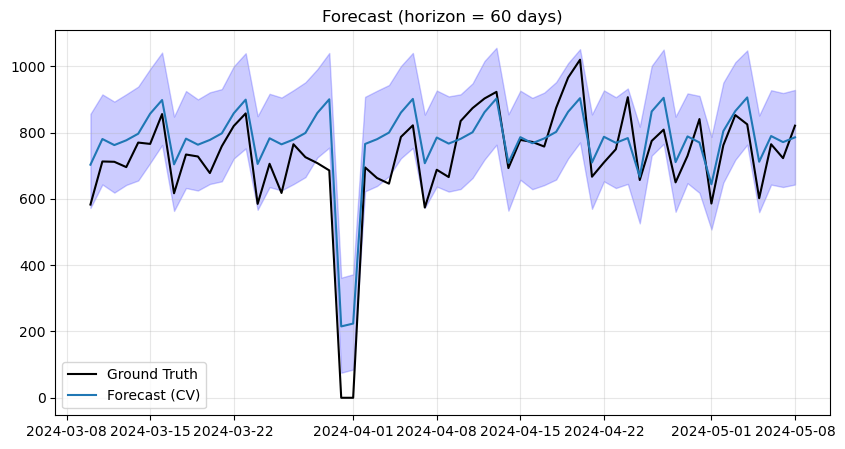


Test set metrics:
RMSE = 90.49
MAE  = 75.43


C:\Users\andre\AppData\Local\Temp\ipykernel_37676\1743448199.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_final["pre_covid"] = (train_final["ds"] < cutoff_date)
C:\Users\andre\AppData\Local\Temp\ipykernel_37676\1743448199.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_final["post_covid"] = (train_final["ds"] >= cutoff_date)
11:51:35 - cmdstanpy - INFO - Chain [1] start processing
11:51:36 - cmdstanpy - INFO - Chain [1] done processing



Model components:


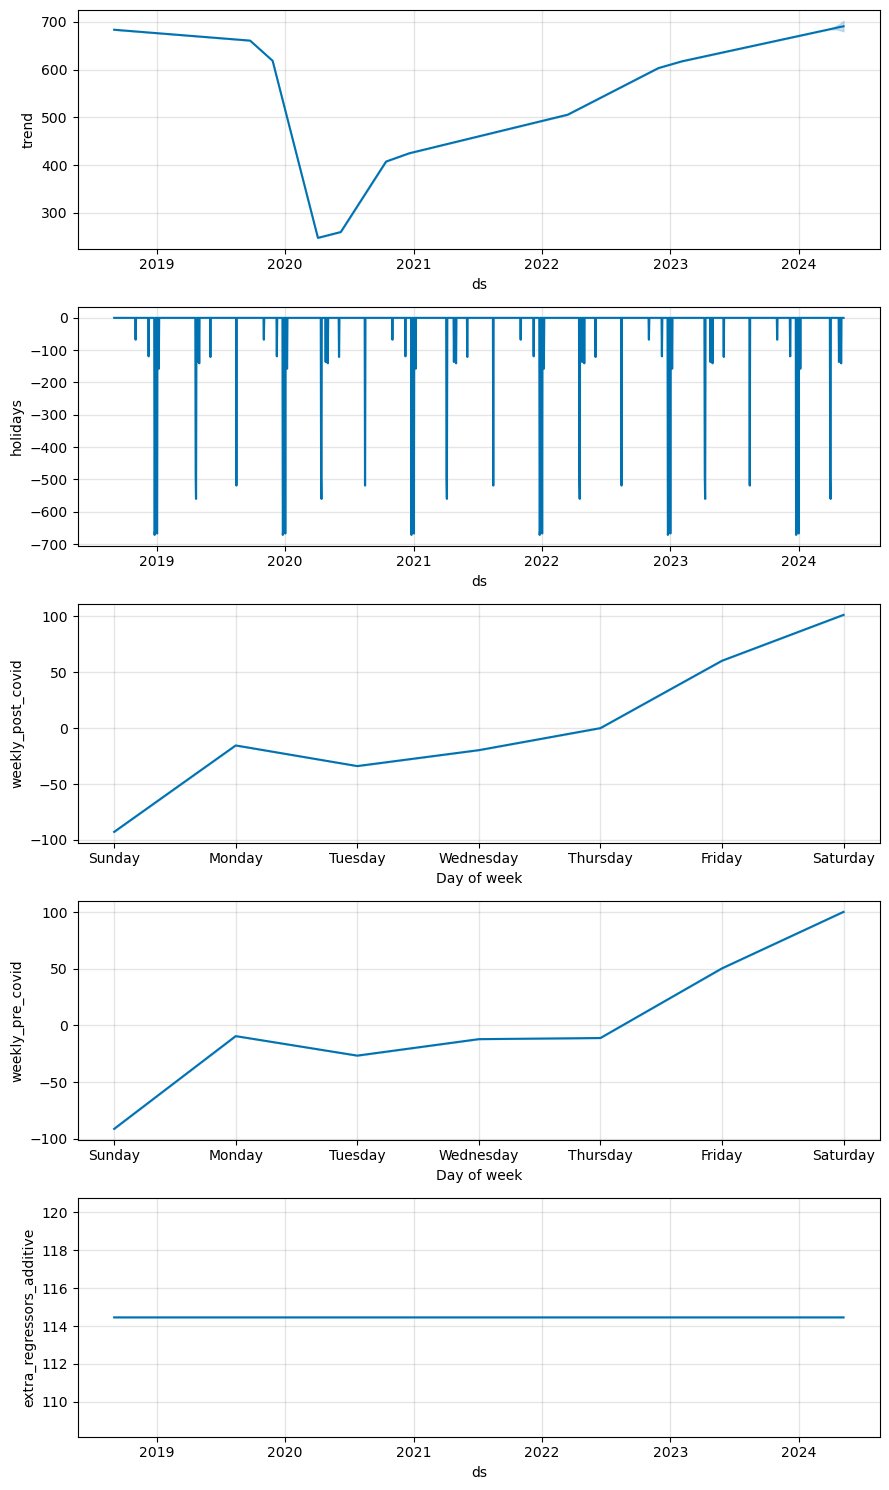

In [121]:
results = fit_prophet_model(
    df=df,
    y_col='scontrini',
    ds_col='data',
    regressors= covid_regr[2],
    n_test=60,
    weekly=False,
    monthly=False,
    yearly=False,
    weekly_prepost=True,
    holidays=True,
    verbose = True,
    return_results = True)

In [122]:
with open("models/prophet_model_scontrini_restaurant_3.json", "w") as f:
    f.write(model_to_json(results["model"]))

## GRID SEARCH ON DF4

In [124]:
df = pd.read_csv('data/restaurant_4.csv')

results = []

for (w, m, y, wp, h, covid) in param_grid:
    print(f"\n Testing with: weekly={w}, monthly={m}, yearly={y}, prepost={wp}, holidays={h}, covid={covid is not None}")
    
    
        # Fit Prophet
    res = fit_prophet_model(
            df=df,
            y_col="scontrini",
            ds_col="data",
            n_test=60,
            weekly=w,
            monthly=m,
            yearly=y,
            weekly_prepost=wp,
            holidays=h,
            regressors=covid,
            verbose=False,
            return_results=True
    )

        
    metrics_last = res["metrics_last_window"]
    cv_metrics = res["metrics_cv"]
    rmse_cv_mean = cv_metrics["rmse"].mean()
    mae_cv_mean = cv_metrics["mae"].mean()
      
    results.append({
            "weekly": w,
            "monthly": m,
            "yearly": y,
            "weekly_prepost": wp,
            "holidays": h,
            "covid_regressors": covid,
            "RMSE_last": metrics_last["RMSE"],
            "MAE_last": metrics_last["MAE"],
            "RMSE_cv_mean": rmse_cv_mean,
            "MAE_cv_mean": mae_cv_mean
    })


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=True, covid=False


11:52:23 - cmdstanpy - INFO - Chain [1] start processing
11:52:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:52:24 - cmdstanpy - INFO - Chain [1] start processing
11:52:24 - cmdstanpy - INFO - Chain [1] done processing
11:52:24 - cmdstanpy - INFO - Chain [1] start processing
11:52:24 - cmdstanpy - INFO - Chain [1] done processing
11:52:24 - cmdstanpy - INFO - Chain [1] start processing
11:52:24 - cmdstanpy - INFO - Chain [1] done processing
11:52:25 - cmdstanpy - INFO - Chain [1] start processing
11:52:25 - cmdstanpy - INFO - Chain [1] done processing
11:52:25 - cmdstanpy - INFO - Chain [1] start processing
11:52:25 - cmdstanpy - INFO - Chain [1] done processing
11:52:25 - cmdstanpy - INFO - Chain [1] start processing
11:52:25 - cmdstanpy - INFO - Chain [1] done processing
11:52:26 - cmdstanpy - INFO - Chain [1] start processing
11:52:26 - cmdstanpy - INFO - Chain [1] done processing
11:52:26 - cmdstanpy - INFO - Chain [1] start processing
11:52:26 - cmdstanpy - INFO - Chain [1] done processing
11:52:26 - cmdstanpy - INFO - Chain [1] start processing
11:52:26 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


11:52:35 - cmdstanpy - INFO - Chain [1] start processing
11:52:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:52:35 - cmdstanpy - INFO - Chain [1] start processing
11:52:35 - cmdstanpy - INFO - Chain [1] done processing
11:52:36 - cmdstanpy - INFO - Chain [1] start processing
11:52:36 - cmdstanpy - INFO - Chain [1] done processing
11:52:36 - cmdstanpy - INFO - Chain [1] start processing
11:52:36 - cmdstanpy - INFO - Chain [1] done processing
11:52:36 - cmdstanpy - INFO - Chain [1] start processing
11:52:36 - cmdstanpy - INFO - Chain [1] done processing
11:52:37 - cmdstanpy - INFO - Chain [1] start processing
11:52:37 - cmdstanpy - INFO - Chain [1] done processing
11:52:37 - cmdstanpy - INFO - Chain [1] start processing
11:52:37 - cmdstanpy - INFO - Chain [1] done processing
11:52:37 - cmdstanpy - INFO - Chain [1] start processing
11:52:37 - cmdstanpy - INFO - Chain [1] done processing
11:52:38 - cmdstanpy - INFO - Chain [1] start processing
11:52:38 - cmdstanpy - INFO - Chain [1] done processing
11:52:38 - cmdstanpy - INFO - Chain [1] start processing
11:52:38 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


11:52:54 - cmdstanpy - INFO - Chain [1] start processing
11:52:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:52:54 - cmdstanpy - INFO - Chain [1] start processing
11:52:55 - cmdstanpy - INFO - Chain [1] done processing
11:52:55 - cmdstanpy - INFO - Chain [1] start processing
11:52:55 - cmdstanpy - INFO - Chain [1] done processing
11:52:55 - cmdstanpy - INFO - Chain [1] start processing
11:52:55 - cmdstanpy - INFO - Chain [1] done processing
11:52:55 - cmdstanpy - INFO - Chain [1] start processing
11:52:55 - cmdstanpy - INFO - Chain [1] done processing
11:52:56 - cmdstanpy - INFO - Chain [1] start processing
11:52:56 - cmdstanpy - INFO - Chain [1] done processing
11:52:56 - cmdstanpy - INFO - Chain [1] start processing
11:52:56 - cmdstanpy - INFO - Chain [1] done processing
11:52:56 - cmdstanpy - INFO - Chain [1] start processing
11:52:57 - cmdstanpy - INFO - Chain [1] done processing
11:52:57 - cmdstanpy - INFO - Chain [1] start processing
11:52:57 - cmdstanpy - INFO - Chain [1] done processing
11:52:57 - cmdstanpy - INFO - Chain [1] start processing
11:52:58 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=False, covid=False


11:53:06 - cmdstanpy - INFO - Chain [1] start processing
11:53:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:53:07 - cmdstanpy - INFO - Chain [1] start processing
11:53:07 - cmdstanpy - INFO - Chain [1] done processing
11:53:07 - cmdstanpy - INFO - Chain [1] start processing
11:53:07 - cmdstanpy - INFO - Chain [1] done processing
11:53:07 - cmdstanpy - INFO - Chain [1] start processing
11:53:07 - cmdstanpy - INFO - Chain [1] done processing
11:53:07 - cmdstanpy - INFO - Chain [1] start processing
11:53:07 - cmdstanpy - INFO - Chain [1] done processing
11:53:08 - cmdstanpy - INFO - Chain [1] start processing
11:53:08 - cmdstanpy - INFO - Chain [1] done processing
11:53:08 - cmdstanpy - INFO - Chain [1] start processing
11:53:08 - cmdstanpy - INFO - Chain [1] done processing
11:53:08 - cmdstanpy - INFO - Chain [1] start processing
11:53:08 - cmdstanpy - INFO - Chain [1] done processing
11:53:09 - cmdstanpy - INFO - Chain [1] start processing
11:53:09 - cmdstanpy - INFO - Chain [1] done processing
11:53:09 - cmdstanpy - INFO - Chain [1] start processing
11:53:09 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


11:53:16 - cmdstanpy - INFO - Chain [1] start processing
11:53:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:53:17 - cmdstanpy - INFO - Chain [1] start processing
11:53:17 - cmdstanpy - INFO - Chain [1] done processing
11:53:17 - cmdstanpy - INFO - Chain [1] start processing
11:53:17 - cmdstanpy - INFO - Chain [1] done processing
11:53:17 - cmdstanpy - INFO - Chain [1] start processing
11:53:18 - cmdstanpy - INFO - Chain [1] done processing
11:53:18 - cmdstanpy - INFO - Chain [1] start processing
11:53:18 - cmdstanpy - INFO - Chain [1] done processing
11:53:18 - cmdstanpy - INFO - Chain [1] start processing
11:53:18 - cmdstanpy - INFO - Chain [1] done processing
11:53:18 - cmdstanpy - INFO - Chain [1] start processing
11:53:19 - cmdstanpy - INFO - Chain [1] done processing
11:53:19 - cmdstanpy - INFO - Chain [1] start processing
11:53:19 - cmdstanpy - INFO - Chain [1] done processing
11:53:19 - cmdstanpy - INFO - Chain [1] start processing
11:53:19 - cmdstanpy - INFO - Chain [1] done processing
11:53:20 - cmdstanpy - INFO - Chain [1] start processing
11:53:20 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


11:53:27 - cmdstanpy - INFO - Chain [1] start processing
11:53:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:53:28 - cmdstanpy - INFO - Chain [1] start processing
11:53:28 - cmdstanpy - INFO - Chain [1] done processing
11:53:28 - cmdstanpy - INFO - Chain [1] start processing
11:53:28 - cmdstanpy - INFO - Chain [1] done processing
11:53:28 - cmdstanpy - INFO - Chain [1] start processing
11:53:28 - cmdstanpy - INFO - Chain [1] done processing
11:53:29 - cmdstanpy - INFO - Chain [1] start processing
11:53:29 - cmdstanpy - INFO - Chain [1] done processing
11:53:29 - cmdstanpy - INFO - Chain [1] start processing
11:53:29 - cmdstanpy - INFO - Chain [1] done processing
11:53:29 - cmdstanpy - INFO - Chain [1] start processing
11:53:29 - cmdstanpy - INFO - Chain [1] done processing
11:53:30 - cmdstanpy - INFO - Chain [1] start processing
11:53:30 - cmdstanpy - INFO - Chain [1] done processing
11:53:30 - cmdstanpy - INFO - Chain [1] start processing
11:53:30 - cmdstanpy - INFO - Chain [1] done processing
11:53:30 - cmdstanpy - INFO - Chain [1] start processing
11:53:31 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=True, covid=False


11:53:38 - cmdstanpy - INFO - Chain [1] start processing
11:53:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:53:38 - cmdstanpy - INFO - Chain [1] start processing
11:53:39 - cmdstanpy - INFO - Chain [1] done processing
11:53:39 - cmdstanpy - INFO - Chain [1] start processing
11:53:39 - cmdstanpy - INFO - Chain [1] done processing
11:53:39 - cmdstanpy - INFO - Chain [1] start processing
11:53:39 - cmdstanpy - INFO - Chain [1] done processing
11:53:39 - cmdstanpy - INFO - Chain [1] start processing
11:53:39 - cmdstanpy - INFO - Chain [1] done processing
11:53:40 - cmdstanpy - INFO - Chain [1] start processing
11:53:40 - cmdstanpy - INFO - Chain [1] done processing
11:53:40 - cmdstanpy - INFO - Chain [1] start processing
11:53:40 - cmdstanpy - INFO - Chain [1] done processing
11:53:40 - cmdstanpy - INFO - Chain [1] start processing
11:53:40 - cmdstanpy - INFO - Chain [1] done processing
11:53:41 - cmdstanpy - INFO - Chain [1] start processing
11:53:41 - cmdstanpy - INFO - Chain [1] done processing
11:53:41 - cmdstanpy - INFO - Chain [1] start processing
11:53:41 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


11:53:49 - cmdstanpy - INFO - Chain [1] start processing
11:53:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:53:50 - cmdstanpy - INFO - Chain [1] start processing
11:53:50 - cmdstanpy - INFO - Chain [1] done processing
11:53:50 - cmdstanpy - INFO - Chain [1] start processing
11:53:50 - cmdstanpy - INFO - Chain [1] done processing
11:53:50 - cmdstanpy - INFO - Chain [1] start processing
11:53:50 - cmdstanpy - INFO - Chain [1] done processing
11:53:51 - cmdstanpy - INFO - Chain [1] start processing
11:53:51 - cmdstanpy - INFO - Chain [1] done processing
11:53:51 - cmdstanpy - INFO - Chain [1] start processing
11:53:51 - cmdstanpy - INFO - Chain [1] done processing
11:53:51 - cmdstanpy - INFO - Chain [1] start processing
11:53:52 - cmdstanpy - INFO - Chain [1] done processing
11:53:52 - cmdstanpy - INFO - Chain [1] start processing
11:53:52 - cmdstanpy - INFO - Chain [1] done processing
11:53:52 - cmdstanpy - INFO - Chain [1] start processing
11:53:52 - cmdstanpy - INFO - Chain [1] done processing
11:53:53 - cmdstanpy - INFO - Chain [1] start processing
11:53:53 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


11:54:01 - cmdstanpy - INFO - Chain [1] start processing
11:54:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:54:02 - cmdstanpy - INFO - Chain [1] start processing
11:54:02 - cmdstanpy - INFO - Chain [1] done processing
11:54:02 - cmdstanpy - INFO - Chain [1] start processing
11:54:02 - cmdstanpy - INFO - Chain [1] done processing
11:54:03 - cmdstanpy - INFO - Chain [1] start processing
11:54:03 - cmdstanpy - INFO - Chain [1] done processing
11:54:03 - cmdstanpy - INFO - Chain [1] start processing
11:54:03 - cmdstanpy - INFO - Chain [1] done processing
11:54:03 - cmdstanpy - INFO - Chain [1] start processing
11:54:03 - cmdstanpy - INFO - Chain [1] done processing
11:54:04 - cmdstanpy - INFO - Chain [1] start processing
11:54:04 - cmdstanpy - INFO - Chain [1] done processing
11:54:04 - cmdstanpy - INFO - Chain [1] start processing
11:54:04 - cmdstanpy - INFO - Chain [1] done processing
11:54:04 - cmdstanpy - INFO - Chain [1] start processing
11:54:05 - cmdstanpy - INFO - Chain [1] done processing
11:54:05 - cmdstanpy - INFO - Chain [1] start processing
11:54:05 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=False, covid=False


11:54:13 - cmdstanpy - INFO - Chain [1] start processing
11:54:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:54:14 - cmdstanpy - INFO - Chain [1] start processing
11:54:14 - cmdstanpy - INFO - Chain [1] done processing
11:54:14 - cmdstanpy - INFO - Chain [1] start processing
11:54:14 - cmdstanpy - INFO - Chain [1] done processing
11:54:14 - cmdstanpy - INFO - Chain [1] start processing
11:54:14 - cmdstanpy - INFO - Chain [1] done processing
11:54:15 - cmdstanpy - INFO - Chain [1] start processing
11:54:15 - cmdstanpy - INFO - Chain [1] done processing
11:54:15 - cmdstanpy - INFO - Chain [1] start processing
11:54:15 - cmdstanpy - INFO - Chain [1] done processing
11:54:15 - cmdstanpy - INFO - Chain [1] start processing
11:54:15 - cmdstanpy - INFO - Chain [1] done processing
11:54:15 - cmdstanpy - INFO - Chain [1] start processing
11:54:16 - cmdstanpy - INFO - Chain [1] done processing
11:54:16 - cmdstanpy - INFO - Chain [1] start processing
11:54:16 - cmdstanpy - INFO - Chain [1] done processing
11:54:16 - cmdstanpy - INFO - Chain [1] start processing
11:54:16 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


11:54:23 - cmdstanpy - INFO - Chain [1] start processing
11:54:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:54:24 - cmdstanpy - INFO - Chain [1] start processing
11:54:24 - cmdstanpy - INFO - Chain [1] done processing
11:54:24 - cmdstanpy - INFO - Chain [1] start processing
11:54:24 - cmdstanpy - INFO - Chain [1] done processing
11:54:24 - cmdstanpy - INFO - Chain [1] start processing
11:54:24 - cmdstanpy - INFO - Chain [1] done processing
11:54:25 - cmdstanpy - INFO - Chain [1] start processing
11:54:25 - cmdstanpy - INFO - Chain [1] done processing
11:54:25 - cmdstanpy - INFO - Chain [1] start processing
11:54:25 - cmdstanpy - INFO - Chain [1] done processing
11:54:25 - cmdstanpy - INFO - Chain [1] start processing
11:54:25 - cmdstanpy - INFO - Chain [1] done processing
11:54:26 - cmdstanpy - INFO - Chain [1] start processing
11:54:26 - cmdstanpy - INFO - Chain [1] done processing
11:54:26 - cmdstanpy - INFO - Chain [1] start processing
11:54:26 - cmdstanpy - INFO - Chain [1] done processing
11:54:26 - cmdstanpy - INFO - Chain [1] start processing
11:54:27 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


11:54:34 - cmdstanpy - INFO - Chain [1] start processing
11:54:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:54:34 - cmdstanpy - INFO - Chain [1] start processing
11:54:34 - cmdstanpy - INFO - Chain [1] done processing
11:54:34 - cmdstanpy - INFO - Chain [1] start processing
11:54:34 - cmdstanpy - INFO - Chain [1] done processing
11:54:35 - cmdstanpy - INFO - Chain [1] start processing
11:54:35 - cmdstanpy - INFO - Chain [1] done processing
11:54:35 - cmdstanpy - INFO - Chain [1] start processing
11:54:35 - cmdstanpy - INFO - Chain [1] done processing
11:54:35 - cmdstanpy - INFO - Chain [1] start processing
11:54:35 - cmdstanpy - INFO - Chain [1] done processing
11:54:35 - cmdstanpy - INFO - Chain [1] start processing
11:54:36 - cmdstanpy - INFO - Chain [1] done processing
11:54:36 - cmdstanpy - INFO - Chain [1] start processing
11:54:36 - cmdstanpy - INFO - Chain [1] done processing
11:54:36 - cmdstanpy - INFO - Chain [1] start processing
11:54:36 - cmdstanpy - INFO - Chain [1] done processing
11:54:37 - cmdstanpy - INFO - Chain [1] start processing
11:54:37 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=True, covid=False


11:54:44 - cmdstanpy - INFO - Chain [1] start processing
11:54:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:54:44 - cmdstanpy - INFO - Chain [1] start processing
11:54:44 - cmdstanpy - INFO - Chain [1] done processing
11:54:45 - cmdstanpy - INFO - Chain [1] start processing
11:54:45 - cmdstanpy - INFO - Chain [1] done processing
11:54:45 - cmdstanpy - INFO - Chain [1] start processing
11:54:45 - cmdstanpy - INFO - Chain [1] done processing
11:54:45 - cmdstanpy - INFO - Chain [1] start processing
11:54:45 - cmdstanpy - INFO - Chain [1] done processing
11:54:46 - cmdstanpy - INFO - Chain [1] start processing
11:54:46 - cmdstanpy - INFO - Chain [1] done processing
11:54:46 - cmdstanpy - INFO - Chain [1] start processing
11:54:46 - cmdstanpy - INFO - Chain [1] done processing
11:54:46 - cmdstanpy - INFO - Chain [1] start processing
11:54:46 - cmdstanpy - INFO - Chain [1] done processing
11:54:47 - cmdstanpy - INFO - Chain [1] start processing
11:54:47 - cmdstanpy - INFO - Chain [1] done processing
11:54:47 - cmdstanpy - INFO - Chain [1] start processing
11:54:47 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


11:54:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:54:54 - cmdstanpy - INFO - Chain [1] start processing
11:54:54 - cmdstanpy - INFO - Chain [1] done processing
11:54:54 - cmdstanpy - INFO - Chain [1] start processing
11:54:54 - cmdstanpy - INFO - Chain [1] done processing
11:54:55 - cmdstanpy - INFO - Chain [1] start processing
11:54:55 - cmdstanpy - INFO - Chain [1] done processing
11:54:55 - cmdstanpy - INFO - Chain [1] start processing
11:54:55 - cmdstanpy - INFO - Chain [1] done processing
11:54:55 - cmdstanpy - INFO - Chain [1] start processing
11:54:55 - cmdstanpy - INFO - Chain [1] done processing
11:54:56 - cmdstanpy - INFO - Chain [1] start processing
11:54:56 - cmdstanpy - INFO - Chain [1] done processing
11:54:56 - cmdstanpy - INFO - Chain [1] start processing
11:54:56 - cmdstanpy - INFO - Chain [1] done processing
11:54:56 - cmdstanpy - INFO - Chain [1] start processing
11:54:56 - cmdstanpy - INFO - Chain [1] done processing
11:54:57 - cmdstanpy - INFO - Chain [1] start processing
11:54:57 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


11:55:03 - cmdstanpy - INFO - Chain [1] start processing
11:55:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:55:04 - cmdstanpy - INFO - Chain [1] start processing
11:55:04 - cmdstanpy - INFO - Chain [1] done processing
11:55:04 - cmdstanpy - INFO - Chain [1] start processing
11:55:04 - cmdstanpy - INFO - Chain [1] done processing
11:55:05 - cmdstanpy - INFO - Chain [1] start processing
11:55:05 - cmdstanpy - INFO - Chain [1] done processing
11:55:05 - cmdstanpy - INFO - Chain [1] start processing
11:55:05 - cmdstanpy - INFO - Chain [1] done processing
11:55:05 - cmdstanpy - INFO - Chain [1] start processing
11:55:05 - cmdstanpy - INFO - Chain [1] done processing
11:55:06 - cmdstanpy - INFO - Chain [1] start processing
11:55:06 - cmdstanpy - INFO - Chain [1] done processing
11:55:06 - cmdstanpy - INFO - Chain [1] start processing
11:55:06 - cmdstanpy - INFO - Chain [1] done processing
11:55:06 - cmdstanpy - INFO - Chain [1] start processing
11:55:07 - cmdstanpy - INFO - Chain [1] done processing
11:55:07 - cmdstanpy - INFO - Chain [1] start processing
11:55:07 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=False, covid=False


11:55:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:55:14 - cmdstanpy - INFO - Chain [1] start processing
11:55:14 - cmdstanpy - INFO - Chain [1] done processing
11:55:14 - cmdstanpy - INFO - Chain [1] start processing
11:55:14 - cmdstanpy - INFO - Chain [1] done processing
11:55:15 - cmdstanpy - INFO - Chain [1] start processing
11:55:15 - cmdstanpy - INFO - Chain [1] done processing
11:55:15 - cmdstanpy - INFO - Chain [1] start processing
11:55:15 - cmdstanpy - INFO - Chain [1] done processing
11:55:15 - cmdstanpy - INFO - Chain [1] start processing
11:55:15 - cmdstanpy - INFO - Chain [1] done processing
11:55:15 - cmdstanpy - INFO - Chain [1] start processing
11:55:15 - cmdstanpy - INFO - Chain [1] done processing
11:55:16 - cmdstanpy - INFO - Chain [1] start processing
11:55:16 - cmdstanpy - INFO - Chain [1] done processing
11:55:16 - cmdstanpy - INFO - Chain [1] start processing
11:55:16 - cmdstanpy - INFO - Chain [1] done processing
11:55:16 - cmdstanpy - INFO - Chain [1] start processing
11:55:16 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


11:55:22 - cmdstanpy - INFO - Chain [1] start processing
11:55:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:55:23 - cmdstanpy - INFO - Chain [1] start processing
11:55:23 - cmdstanpy - INFO - Chain [1] done processing
11:55:23 - cmdstanpy - INFO - Chain [1] start processing
11:55:23 - cmdstanpy - INFO - Chain [1] done processing
11:55:23 - cmdstanpy - INFO - Chain [1] start processing
11:55:23 - cmdstanpy - INFO - Chain [1] done processing
11:55:23 - cmdstanpy - INFO - Chain [1] start processing
11:55:24 - cmdstanpy - INFO - Chain [1] done processing
11:55:24 - cmdstanpy - INFO - Chain [1] start processing
11:55:24 - cmdstanpy - INFO - Chain [1] done processing
11:55:24 - cmdstanpy - INFO - Chain [1] start processing
11:55:24 - cmdstanpy - INFO - Chain [1] done processing
11:55:24 - cmdstanpy - INFO - Chain [1] start processing
11:55:25 - cmdstanpy - INFO - Chain [1] done processing
11:55:25 - cmdstanpy - INFO - Chain [1] start processing
11:55:25 - cmdstanpy - INFO - Chain [1] done processing
11:55:25 - cmdstanpy - INFO - Chain [1] start processing
11:55:25 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


11:55:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:55:31 - cmdstanpy - INFO - Chain [1] start processing
11:55:31 - cmdstanpy - INFO - Chain [1] done processing
11:55:32 - cmdstanpy - INFO - Chain [1] start processing
11:55:32 - cmdstanpy - INFO - Chain [1] done processing
11:55:32 - cmdstanpy - INFO - Chain [1] start processing
11:55:32 - cmdstanpy - INFO - Chain [1] done processing
11:55:32 - cmdstanpy - INFO - Chain [1] start processing
11:55:32 - cmdstanpy - INFO - Chain [1] done processing
11:55:32 - cmdstanpy - INFO - Chain [1] start processing
11:55:33 - cmdstanpy - INFO - Chain [1] done processing
11:55:33 - cmdstanpy - INFO - Chain [1] start processing
11:55:33 - cmdstanpy - INFO - Chain [1] done processing
11:55:33 - cmdstanpy - INFO - Chain [1] start processing
11:55:33 - cmdstanpy - INFO - Chain [1] done processing
11:55:33 - cmdstanpy - INFO - Chain [1] start processing
11:55:34 - cmdstanpy - INFO - Chain [1] done processing
11:55:34 - cmdstanpy - INFO - Chain [1] start processing
11:55:34 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=True, covid=False


11:55:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:55:40 - cmdstanpy - INFO - Chain [1] start processing
11:55:40 - cmdstanpy - INFO - Chain [1] done processing
11:55:41 - cmdstanpy - INFO - Chain [1] start processing
11:55:41 - cmdstanpy - INFO - Chain [1] done processing
11:55:41 - cmdstanpy - INFO - Chain [1] start processing
11:55:41 - cmdstanpy - INFO - Chain [1] done processing
11:55:41 - cmdstanpy - INFO - Chain [1] start processing
11:55:41 - cmdstanpy - INFO - Chain [1] done processing
11:55:42 - cmdstanpy - INFO - Chain [1] start processing
11:55:42 - cmdstanpy - INFO - Chain [1] done processing
11:55:42 - cmdstanpy - INFO - Chain [1] start processing
11:55:42 - cmdstanpy - INFO - Chain [1] done processing
11:55:42 - cmdstanpy - INFO - Chain [1] start processing
11:55:42 - cmdstanpy - INFO - Chain [1] done processing
11:55:43 - cmdstanpy - INFO - Chain [1] start processing
11:55:43 - cmdstanpy - INFO - Chain [1] done processing
11:55:43 - cmdstanpy - INFO - Chain [1] start processing
11:55:43 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


11:55:50 - cmdstanpy - INFO - Chain [1] start processing
11:55:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:55:50 - cmdstanpy - INFO - Chain [1] start processing
11:55:50 - cmdstanpy - INFO - Chain [1] done processing
11:55:51 - cmdstanpy - INFO - Chain [1] start processing
11:55:51 - cmdstanpy - INFO - Chain [1] done processing
11:55:51 - cmdstanpy - INFO - Chain [1] start processing
11:55:51 - cmdstanpy - INFO - Chain [1] done processing
11:55:51 - cmdstanpy - INFO - Chain [1] start processing
11:55:51 - cmdstanpy - INFO - Chain [1] done processing
11:55:52 - cmdstanpy - INFO - Chain [1] start processing
11:55:52 - cmdstanpy - INFO - Chain [1] done processing
11:55:52 - cmdstanpy - INFO - Chain [1] start processing
11:55:52 - cmdstanpy - INFO - Chain [1] done processing
11:55:52 - cmdstanpy - INFO - Chain [1] start processing
11:55:52 - cmdstanpy - INFO - Chain [1] done processing
11:55:53 - cmdstanpy - INFO - Chain [1] start processing
11:55:53 - cmdstanpy - INFO - Chain [1] done processing
11:55:53 - cmdstanpy - INFO - Chain [1] start processing
11:55:53 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


11:56:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:56:01 - cmdstanpy - INFO - Chain [1] start processing
11:56:01 - cmdstanpy - INFO - Chain [1] done processing
11:56:01 - cmdstanpy - INFO - Chain [1] start processing
11:56:01 - cmdstanpy - INFO - Chain [1] done processing
11:56:01 - cmdstanpy - INFO - Chain [1] start processing
11:56:01 - cmdstanpy - INFO - Chain [1] done processing
11:56:02 - cmdstanpy - INFO - Chain [1] start processing
11:56:02 - cmdstanpy - INFO - Chain [1] done processing
11:56:02 - cmdstanpy - INFO - Chain [1] start processing
11:56:02 - cmdstanpy - INFO - Chain [1] done processing
11:56:02 - cmdstanpy - INFO - Chain [1] start processing
11:56:02 - cmdstanpy - INFO - Chain [1] done processing
11:56:03 - cmdstanpy - INFO - Chain [1] start processing
11:56:03 - cmdstanpy - INFO - Chain [1] done processing
11:56:03 - cmdstanpy - INFO - Chain [1] start processing
11:56:03 - cmdstanpy - INFO - Chain [1] done processing
11:56:03 - cmdstanpy - INFO - Chain [1] start processing
11:56:03 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=False, covid=False


11:56:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:56:11 - cmdstanpy - INFO - Chain [1] start processing
11:56:11 - cmdstanpy - INFO - Chain [1] done processing
11:56:11 - cmdstanpy - INFO - Chain [1] start processing
11:56:11 - cmdstanpy - INFO - Chain [1] done processing
11:56:11 - cmdstanpy - INFO - Chain [1] start processing
11:56:11 - cmdstanpy - INFO - Chain [1] done processing
11:56:11 - cmdstanpy - INFO - Chain [1] start processing
11:56:11 - cmdstanpy - INFO - Chain [1] done processing
11:56:12 - cmdstanpy - INFO - Chain [1] start processing
11:56:12 - cmdstanpy - INFO - Chain [1] done processing
11:56:12 - cmdstanpy - INFO - Chain [1] start processing
11:56:12 - cmdstanpy - INFO - Chain [1] done processing
11:56:12 - cmdstanpy - INFO - Chain [1] start processing
11:56:12 - cmdstanpy - INFO - Chain [1] done processing
11:56:12 - cmdstanpy - INFO - Chain [1] start processing
11:56:13 - cmdstanpy - INFO - Chain [1] done processing
11:56:13 - cmdstanpy - INFO - Chain [1] start processing
11:56:13 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


11:56:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:56:18 - cmdstanpy - INFO - Chain [1] start processing
11:56:19 - cmdstanpy - INFO - Chain [1] done processing
11:56:19 - cmdstanpy - INFO - Chain [1] start processing
11:56:19 - cmdstanpy - INFO - Chain [1] done processing
11:56:19 - cmdstanpy - INFO - Chain [1] start processing
11:56:19 - cmdstanpy - INFO - Chain [1] done processing
11:56:19 - cmdstanpy - INFO - Chain [1] start processing
11:56:19 - cmdstanpy - INFO - Chain [1] done processing
11:56:19 - cmdstanpy - INFO - Chain [1] start processing
11:56:20 - cmdstanpy - INFO - Chain [1] done processing
11:56:20 - cmdstanpy - INFO - Chain [1] start processing
11:56:20 - cmdstanpy - INFO - Chain [1] done processing
11:56:20 - cmdstanpy - INFO - Chain [1] start processing
11:56:20 - cmdstanpy - INFO - Chain [1] done processing
11:56:20 - cmdstanpy - INFO - Chain [1] start processing
11:56:21 - cmdstanpy - INFO - Chain [1] done processing
11:56:21 - cmdstanpy - INFO - Chain [1] start processing
11:56:21 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


11:56:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:56:27 - cmdstanpy - INFO - Chain [1] start processing
11:56:27 - cmdstanpy - INFO - Chain [1] done processing
11:56:27 - cmdstanpy - INFO - Chain [1] start processing
11:56:28 - cmdstanpy - INFO - Chain [1] done processing
11:56:28 - cmdstanpy - INFO - Chain [1] start processing
11:56:28 - cmdstanpy - INFO - Chain [1] done processing
11:56:28 - cmdstanpy - INFO - Chain [1] start processing
11:56:28 - cmdstanpy - INFO - Chain [1] done processing
11:56:28 - cmdstanpy - INFO - Chain [1] start processing
11:56:28 - cmdstanpy - INFO - Chain [1] done processing
11:56:29 - cmdstanpy - INFO - Chain [1] start processing
11:56:29 - cmdstanpy - INFO - Chain [1] done processing
11:56:29 - cmdstanpy - INFO - Chain [1] start processing
11:56:29 - cmdstanpy - INFO - Chain [1] done processing
11:56:29 - cmdstanpy - INFO - Chain [1] start processing
11:56:29 - cmdstanpy - INFO - Chain [1] done processing
11:56:29 - cmdstanpy - INFO - Chain [1] start processing
11:56:29 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=True, covid=False


11:56:35 - cmdstanpy - INFO - Chain [1] start processing
11:56:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:56:36 - cmdstanpy - INFO - Chain [1] start processing
11:56:36 - cmdstanpy - INFO - Chain [1] done processing
11:56:36 - cmdstanpy - INFO - Chain [1] start processing
11:56:36 - cmdstanpy - INFO - Chain [1] done processing
11:56:36 - cmdstanpy - INFO - Chain [1] start processing
11:56:36 - cmdstanpy - INFO - Chain [1] done processing
11:56:37 - cmdstanpy - INFO - Chain [1] start processing
11:56:37 - cmdstanpy - INFO - Chain [1] done processing
11:56:37 - cmdstanpy - INFO - Chain [1] start processing
11:56:37 - cmdstanpy - INFO - Chain [1] done processing
11:56:37 - cmdstanpy - INFO - Chain [1] start processing
11:56:37 - cmdstanpy - INFO - Chain [1] done processing
11:56:38 - cmdstanpy - INFO - Chain [1] start processing
11:56:38 - cmdstanpy - INFO - Chain [1] done processing
11:56:38 - cmdstanpy - INFO - Chain [1] start processing
11:56:38 - cmdstanpy - INFO - Chain [1] done processing
11:56:38 - cmdstanpy - INFO - Chain [1] start processing
11:56:39 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


11:56:46 - cmdstanpy - INFO - Chain [1] start processing
11:56:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:56:47 - cmdstanpy - INFO - Chain [1] start processing
11:56:47 - cmdstanpy - INFO - Chain [1] done processing
11:56:47 - cmdstanpy - INFO - Chain [1] start processing
11:56:47 - cmdstanpy - INFO - Chain [1] done processing
11:56:47 - cmdstanpy - INFO - Chain [1] start processing
11:56:47 - cmdstanpy - INFO - Chain [1] done processing
11:56:48 - cmdstanpy - INFO - Chain [1] start processing
11:56:48 - cmdstanpy - INFO - Chain [1] done processing
11:56:48 - cmdstanpy - INFO - Chain [1] start processing
11:56:48 - cmdstanpy - INFO - Chain [1] done processing
11:56:48 - cmdstanpy - INFO - Chain [1] start processing
11:56:49 - cmdstanpy - INFO - Chain [1] done processing
11:56:49 - cmdstanpy - INFO - Chain [1] start processing
11:56:49 - cmdstanpy - INFO - Chain [1] done processing
11:56:49 - cmdstanpy - INFO - Chain [1] start processing
11:56:49 - cmdstanpy - INFO - Chain [1] done processing
11:56:50 - cmdstanpy - INFO - Chain [1] start processing
11:56:50 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


11:56:58 - cmdstanpy - INFO - Chain [1] start processing
11:56:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:56:59 - cmdstanpy - INFO - Chain [1] start processing
11:56:59 - cmdstanpy - INFO - Chain [1] done processing
11:56:59 - cmdstanpy - INFO - Chain [1] start processing
11:56:59 - cmdstanpy - INFO - Chain [1] done processing
11:56:59 - cmdstanpy - INFO - Chain [1] start processing
11:57:00 - cmdstanpy - INFO - Chain [1] done processing
11:57:00 - cmdstanpy - INFO - Chain [1] start processing
11:57:00 - cmdstanpy - INFO - Chain [1] done processing
11:57:00 - cmdstanpy - INFO - Chain [1] start processing
11:57:00 - cmdstanpy - INFO - Chain [1] done processing
11:57:00 - cmdstanpy - INFO - Chain [1] start processing
11:57:01 - cmdstanpy - INFO - Chain [1] done processing
11:57:01 - cmdstanpy - INFO - Chain [1] start processing
11:57:01 - cmdstanpy - INFO - Chain [1] done processing
11:57:01 - cmdstanpy - INFO - Chain [1] start processing
11:57:01 - cmdstanpy - INFO - Chain [1] done processing
11:57:02 - cmdstanpy - INFO - Chain [1] start processing
11:57:02 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=False, covid=False


11:57:10 - cmdstanpy - INFO - Chain [1] start processing
11:57:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:57:10 - cmdstanpy - INFO - Chain [1] start processing
11:57:10 - cmdstanpy - INFO - Chain [1] done processing
11:57:11 - cmdstanpy - INFO - Chain [1] start processing
11:57:11 - cmdstanpy - INFO - Chain [1] done processing
11:57:11 - cmdstanpy - INFO - Chain [1] start processing
11:57:11 - cmdstanpy - INFO - Chain [1] done processing
11:57:11 - cmdstanpy - INFO - Chain [1] start processing
11:57:11 - cmdstanpy - INFO - Chain [1] done processing
11:57:11 - cmdstanpy - INFO - Chain [1] start processing
11:57:12 - cmdstanpy - INFO - Chain [1] done processing
11:57:12 - cmdstanpy - INFO - Chain [1] start processing
11:57:12 - cmdstanpy - INFO - Chain [1] done processing
11:57:12 - cmdstanpy - INFO - Chain [1] start processing
11:57:12 - cmdstanpy - INFO - Chain [1] done processing
11:57:12 - cmdstanpy - INFO - Chain [1] start processing
11:57:13 - cmdstanpy - INFO - Chain [1] done processing
11:57:13 - cmdstanpy - INFO - Chain [1] start processing
11:57:13 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


11:57:20 - cmdstanpy - INFO - Chain [1] start processing
11:57:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:57:21 - cmdstanpy - INFO - Chain [1] start processing
11:57:21 - cmdstanpy - INFO - Chain [1] done processing
11:57:21 - cmdstanpy - INFO - Chain [1] start processing
11:57:21 - cmdstanpy - INFO - Chain [1] done processing
11:57:21 - cmdstanpy - INFO - Chain [1] start processing
11:57:21 - cmdstanpy - INFO - Chain [1] done processing
11:57:22 - cmdstanpy - INFO - Chain [1] start processing
11:57:22 - cmdstanpy - INFO - Chain [1] done processing
11:57:22 - cmdstanpy - INFO - Chain [1] start processing
11:57:22 - cmdstanpy - INFO - Chain [1] done processing
11:57:22 - cmdstanpy - INFO - Chain [1] start processing
11:57:23 - cmdstanpy - INFO - Chain [1] done processing
11:57:23 - cmdstanpy - INFO - Chain [1] start processing
11:57:23 - cmdstanpy - INFO - Chain [1] done processing
11:57:23 - cmdstanpy - INFO - Chain [1] start processing
11:57:23 - cmdstanpy - INFO - Chain [1] done processing
11:57:23 - cmdstanpy - INFO - Chain [1] start processing
11:57:24 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


11:57:32 - cmdstanpy - INFO - Chain [1] start processing
11:57:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:57:33 - cmdstanpy - INFO - Chain [1] start processing
11:57:33 - cmdstanpy - INFO - Chain [1] done processing
11:57:33 - cmdstanpy - INFO - Chain [1] start processing
11:57:33 - cmdstanpy - INFO - Chain [1] done processing
11:57:33 - cmdstanpy - INFO - Chain [1] start processing
11:57:33 - cmdstanpy - INFO - Chain [1] done processing
11:57:34 - cmdstanpy - INFO - Chain [1] start processing
11:57:34 - cmdstanpy - INFO - Chain [1] done processing
11:57:34 - cmdstanpy - INFO - Chain [1] start processing
11:57:34 - cmdstanpy - INFO - Chain [1] done processing
11:57:34 - cmdstanpy - INFO - Chain [1] start processing
11:57:34 - cmdstanpy - INFO - Chain [1] done processing
11:57:35 - cmdstanpy - INFO - Chain [1] start processing
11:57:35 - cmdstanpy - INFO - Chain [1] done processing
11:57:35 - cmdstanpy - INFO - Chain [1] start processing
11:57:35 - cmdstanpy - INFO - Chain [1] done processing
11:57:35 - cmdstanpy - INFO - Chain [1] start processing
11:57:36 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=True, covid=False


11:57:43 - cmdstanpy - INFO - Chain [1] start processing
11:57:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:57:44 - cmdstanpy - INFO - Chain [1] start processing
11:57:44 - cmdstanpy - INFO - Chain [1] done processing
11:57:44 - cmdstanpy - INFO - Chain [1] start processing
11:57:44 - cmdstanpy - INFO - Chain [1] done processing
11:57:44 - cmdstanpy - INFO - Chain [1] start processing
11:57:45 - cmdstanpy - INFO - Chain [1] done processing
11:57:45 - cmdstanpy - INFO - Chain [1] start processing
11:57:45 - cmdstanpy - INFO - Chain [1] done processing
11:57:45 - cmdstanpy - INFO - Chain [1] start processing
11:57:45 - cmdstanpy - INFO - Chain [1] done processing
11:57:45 - cmdstanpy - INFO - Chain [1] start processing
11:57:46 - cmdstanpy - INFO - Chain [1] done processing
11:57:46 - cmdstanpy - INFO - Chain [1] start processing
11:57:46 - cmdstanpy - INFO - Chain [1] done processing
11:57:46 - cmdstanpy - INFO - Chain [1] start processing
11:57:46 - cmdstanpy - INFO - Chain [1] done processing
11:57:46 - cmdstanpy - INFO - Chain [1] start processing
11:57:47 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


11:57:55 - cmdstanpy - INFO - Chain [1] start processing
11:57:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:57:55 - cmdstanpy - INFO - Chain [1] start processing
11:57:55 - cmdstanpy - INFO - Chain [1] done processing
11:57:56 - cmdstanpy - INFO - Chain [1] start processing
11:57:56 - cmdstanpy - INFO - Chain [1] done processing
11:57:56 - cmdstanpy - INFO - Chain [1] start processing
11:57:56 - cmdstanpy - INFO - Chain [1] done processing
11:57:56 - cmdstanpy - INFO - Chain [1] start processing
11:57:56 - cmdstanpy - INFO - Chain [1] done processing
11:57:57 - cmdstanpy - INFO - Chain [1] start processing
11:57:57 - cmdstanpy - INFO - Chain [1] done processing
11:57:57 - cmdstanpy - INFO - Chain [1] start processing
11:57:57 - cmdstanpy - INFO - Chain [1] done processing
11:57:57 - cmdstanpy - INFO - Chain [1] start processing
11:57:58 - cmdstanpy - INFO - Chain [1] done processing
11:57:58 - cmdstanpy - INFO - Chain [1] start processing
11:57:58 - cmdstanpy - INFO - Chain [1] done processing
11:57:58 - cmdstanpy - INFO - Chain [1] start processing
11:57:59 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


11:58:08 - cmdstanpy - INFO - Chain [1] start processing
11:58:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:58:08 - cmdstanpy - INFO - Chain [1] start processing
11:58:09 - cmdstanpy - INFO - Chain [1] done processing
11:58:09 - cmdstanpy - INFO - Chain [1] start processing
11:58:09 - cmdstanpy - INFO - Chain [1] done processing
11:58:09 - cmdstanpy - INFO - Chain [1] start processing
11:58:09 - cmdstanpy - INFO - Chain [1] done processing
11:58:09 - cmdstanpy - INFO - Chain [1] start processing
11:58:10 - cmdstanpy - INFO - Chain [1] done processing
11:58:10 - cmdstanpy - INFO - Chain [1] start processing
11:58:10 - cmdstanpy - INFO - Chain [1] done processing
11:58:10 - cmdstanpy - INFO - Chain [1] start processing
11:58:10 - cmdstanpy - INFO - Chain [1] done processing
11:58:11 - cmdstanpy - INFO - Chain [1] start processing
11:58:11 - cmdstanpy - INFO - Chain [1] done processing
11:58:11 - cmdstanpy - INFO - Chain [1] start processing
11:58:11 - cmdstanpy - INFO - Chain [1] done processing
11:58:11 - cmdstanpy - INFO - Chain [1] start processing
11:58:12 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=False, covid=False


11:58:21 - cmdstanpy - INFO - Chain [1] start processing
11:58:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:58:21 - cmdstanpy - INFO - Chain [1] start processing
11:58:22 - cmdstanpy - INFO - Chain [1] done processing
11:58:22 - cmdstanpy - INFO - Chain [1] start processing
11:58:22 - cmdstanpy - INFO - Chain [1] done processing
11:58:22 - cmdstanpy - INFO - Chain [1] start processing
11:58:22 - cmdstanpy - INFO - Chain [1] done processing
11:58:22 - cmdstanpy - INFO - Chain [1] start processing
11:58:22 - cmdstanpy - INFO - Chain [1] done processing
11:58:23 - cmdstanpy - INFO - Chain [1] start processing
11:58:23 - cmdstanpy - INFO - Chain [1] done processing
11:58:23 - cmdstanpy - INFO - Chain [1] start processing
11:58:23 - cmdstanpy - INFO - Chain [1] done processing
11:58:23 - cmdstanpy - INFO - Chain [1] start processing
11:58:23 - cmdstanpy - INFO - Chain [1] done processing
11:58:23 - cmdstanpy - INFO - Chain [1] start processing
11:58:24 - cmdstanpy - INFO - Chain [1] done processing
11:58:24 - cmdstanpy - INFO - Chain [1] start processing
11:58:24 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


11:58:31 - cmdstanpy - INFO - Chain [1] start processing
11:58:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:58:32 - cmdstanpy - INFO - Chain [1] start processing
11:58:32 - cmdstanpy - INFO - Chain [1] done processing
11:58:32 - cmdstanpy - INFO - Chain [1] start processing
11:58:32 - cmdstanpy - INFO - Chain [1] done processing
11:58:32 - cmdstanpy - INFO - Chain [1] start processing
11:58:33 - cmdstanpy - INFO - Chain [1] done processing
11:58:33 - cmdstanpy - INFO - Chain [1] start processing
11:58:33 - cmdstanpy - INFO - Chain [1] done processing
11:58:33 - cmdstanpy - INFO - Chain [1] start processing
11:58:33 - cmdstanpy - INFO - Chain [1] done processing
11:58:33 - cmdstanpy - INFO - Chain [1] start processing
11:58:34 - cmdstanpy - INFO - Chain [1] done processing
11:58:34 - cmdstanpy - INFO - Chain [1] start processing
11:58:34 - cmdstanpy - INFO - Chain [1] done processing
11:58:34 - cmdstanpy - INFO - Chain [1] start processing
11:58:34 - cmdstanpy - INFO - Chain [1] done processing
11:58:34 - cmdstanpy - INFO - Chain [1] start processing
11:58:35 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


11:58:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:58:43 - cmdstanpy - INFO - Chain [1] start processing
11:58:43 - cmdstanpy - INFO - Chain [1] done processing
11:58:43 - cmdstanpy - INFO - Chain [1] start processing
11:58:43 - cmdstanpy - INFO - Chain [1] done processing
11:58:43 - cmdstanpy - INFO - Chain [1] start processing
11:58:43 - cmdstanpy - INFO - Chain [1] done processing
11:58:44 - cmdstanpy - INFO - Chain [1] start processing
11:58:44 - cmdstanpy - INFO - Chain [1] done processing
11:58:44 - cmdstanpy - INFO - Chain [1] start processing
11:58:44 - cmdstanpy - INFO - Chain [1] done processing
11:58:44 - cmdstanpy - INFO - Chain [1] start processing
11:58:44 - cmdstanpy - INFO - Chain [1] done processing
11:58:44 - cmdstanpy - INFO - Chain [1] start processing
11:58:45 - cmdstanpy - INFO - Chain [1] done processing
11:58:45 - cmdstanpy - INFO - Chain [1] start processing
11:58:45 - cmdstanpy - INFO - Chain [1] done processing
11:58:45 - cmdstanpy - INFO - Chain [1] start processing
11:58:45 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=True, covid=False


11:58:52 - cmdstanpy - INFO - Chain [1] start processing
11:58:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:58:53 - cmdstanpy - INFO - Chain [1] start processing
11:58:53 - cmdstanpy - INFO - Chain [1] done processing
11:58:53 - cmdstanpy - INFO - Chain [1] start processing
11:58:53 - cmdstanpy - INFO - Chain [1] done processing
11:58:54 - cmdstanpy - INFO - Chain [1] start processing
11:58:54 - cmdstanpy - INFO - Chain [1] done processing
11:58:54 - cmdstanpy - INFO - Chain [1] start processing
11:58:54 - cmdstanpy - INFO - Chain [1] done processing
11:58:54 - cmdstanpy - INFO - Chain [1] start processing
11:58:54 - cmdstanpy - INFO - Chain [1] done processing
11:58:55 - cmdstanpy - INFO - Chain [1] start processing
11:58:55 - cmdstanpy - INFO - Chain [1] done processing
11:58:55 - cmdstanpy - INFO - Chain [1] start processing
11:58:55 - cmdstanpy - INFO - Chain [1] done processing
11:58:55 - cmdstanpy - INFO - Chain [1] start processing
11:58:56 - cmdstanpy - INFO - Chain [1] done processing
11:58:56 - cmdstanpy - INFO - Chain [1] start processing
11:58:56 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


11:59:03 - cmdstanpy - INFO - Chain [1] start processing
11:59:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:59:03 - cmdstanpy - INFO - Chain [1] start processing
11:59:04 - cmdstanpy - INFO - Chain [1] done processing
11:59:04 - cmdstanpy - INFO - Chain [1] start processing
11:59:04 - cmdstanpy - INFO - Chain [1] done processing
11:59:04 - cmdstanpy - INFO - Chain [1] start processing
11:59:04 - cmdstanpy - INFO - Chain [1] done processing
11:59:04 - cmdstanpy - INFO - Chain [1] start processing
11:59:04 - cmdstanpy - INFO - Chain [1] done processing
11:59:05 - cmdstanpy - INFO - Chain [1] start processing
11:59:05 - cmdstanpy - INFO - Chain [1] done processing
11:59:05 - cmdstanpy - INFO - Chain [1] start processing
11:59:05 - cmdstanpy - INFO - Chain [1] done processing
11:59:05 - cmdstanpy - INFO - Chain [1] start processing
11:59:05 - cmdstanpy - INFO - Chain [1] done processing
11:59:06 - cmdstanpy - INFO - Chain [1] start processing
11:59:06 - cmdstanpy - INFO - Chain [1] done processing
11:59:06 - cmdstanpy - INFO - Chain [1] start processing
11:59:06 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


11:59:13 - cmdstanpy - INFO - Chain [1] start processing
11:59:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:59:13 - cmdstanpy - INFO - Chain [1] start processing
11:59:13 - cmdstanpy - INFO - Chain [1] done processing
11:59:14 - cmdstanpy - INFO - Chain [1] start processing
11:59:14 - cmdstanpy - INFO - Chain [1] done processing
11:59:14 - cmdstanpy - INFO - Chain [1] start processing
11:59:14 - cmdstanpy - INFO - Chain [1] done processing
11:59:14 - cmdstanpy - INFO - Chain [1] start processing
11:59:14 - cmdstanpy - INFO - Chain [1] done processing
11:59:15 - cmdstanpy - INFO - Chain [1] start processing
11:59:15 - cmdstanpy - INFO - Chain [1] done processing
11:59:15 - cmdstanpy - INFO - Chain [1] start processing
11:59:15 - cmdstanpy - INFO - Chain [1] done processing
11:59:15 - cmdstanpy - INFO - Chain [1] start processing
11:59:16 - cmdstanpy - INFO - Chain [1] done processing
11:59:16 - cmdstanpy - INFO - Chain [1] start processing
11:59:16 - cmdstanpy - INFO - Chain [1] done processing
11:59:16 - cmdstanpy - INFO - Chain [1] start processing
11:59:16 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=False, covid=False


11:59:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:59:24 - cmdstanpy - INFO - Chain [1] start processing
11:59:24 - cmdstanpy - INFO - Chain [1] done processing
11:59:24 - cmdstanpy - INFO - Chain [1] start processing
11:59:24 - cmdstanpy - INFO - Chain [1] done processing
11:59:24 - cmdstanpy - INFO - Chain [1] start processing
11:59:24 - cmdstanpy - INFO - Chain [1] done processing
11:59:24 - cmdstanpy - INFO - Chain [1] start processing
11:59:25 - cmdstanpy - INFO - Chain [1] done processing
11:59:25 - cmdstanpy - INFO - Chain [1] start processing
11:59:25 - cmdstanpy - INFO - Chain [1] done processing
11:59:25 - cmdstanpy - INFO - Chain [1] start processing
11:59:25 - cmdstanpy - INFO - Chain [1] done processing
11:59:25 - cmdstanpy - INFO - Chain [1] start processing
11:59:25 - cmdstanpy - INFO - Chain [1] done processing
11:59:26 - cmdstanpy - INFO - Chain [1] start processing
11:59:26 - cmdstanpy - INFO - Chain [1] done processing
11:59:26 - cmdstanpy - INFO - Chain [1] start processing
11:59:26 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


11:59:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:59:33 - cmdstanpy - INFO - Chain [1] start processing
11:59:33 - cmdstanpy - INFO - Chain [1] done processing
11:59:33 - cmdstanpy - INFO - Chain [1] start processing
11:59:33 - cmdstanpy - INFO - Chain [1] done processing
11:59:33 - cmdstanpy - INFO - Chain [1] start processing
11:59:33 - cmdstanpy - INFO - Chain [1] done processing
11:59:33 - cmdstanpy - INFO - Chain [1] start processing
11:59:34 - cmdstanpy - INFO - Chain [1] done processing
11:59:34 - cmdstanpy - INFO - Chain [1] start processing
11:59:34 - cmdstanpy - INFO - Chain [1] done processing
11:59:34 - cmdstanpy - INFO - Chain [1] start processing
11:59:34 - cmdstanpy - INFO - Chain [1] done processing
11:59:34 - cmdstanpy - INFO - Chain [1] start processing
11:59:34 - cmdstanpy - INFO - Chain [1] done processing
11:59:35 - cmdstanpy - INFO - Chain [1] start processing
11:59:35 - cmdstanpy - INFO - Chain [1] done processing
11:59:35 - cmdstanpy - INFO - Chain [1] start processing
11:59:35 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


11:59:42 - cmdstanpy - INFO - Chain [1] start processing
11:59:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:59:42 - cmdstanpy - INFO - Chain [1] start processing
11:59:42 - cmdstanpy - INFO - Chain [1] done processing
11:59:43 - cmdstanpy - INFO - Chain [1] start processing
11:59:43 - cmdstanpy - INFO - Chain [1] done processing
11:59:43 - cmdstanpy - INFO - Chain [1] start processing
11:59:43 - cmdstanpy - INFO - Chain [1] done processing
11:59:43 - cmdstanpy - INFO - Chain [1] start processing
11:59:43 - cmdstanpy - INFO - Chain [1] done processing
11:59:43 - cmdstanpy - INFO - Chain [1] start processing
11:59:44 - cmdstanpy - INFO - Chain [1] done processing
11:59:44 - cmdstanpy - INFO - Chain [1] start processing
11:59:44 - cmdstanpy - INFO - Chain [1] done processing
11:59:44 - cmdstanpy - INFO - Chain [1] start processing
11:59:44 - cmdstanpy - INFO - Chain [1] done processing
11:59:44 - cmdstanpy - INFO - Chain [1] start processing
11:59:44 - cmdstanpy - INFO - Chain [1] done processing
11:59:45 - cmdstanpy - INFO - Chain [1] start processing
11:59:45 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=True, covid=False


11:59:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

11:59:51 - cmdstanpy - INFO - Chain [1] start processing
11:59:52 - cmdstanpy - INFO - Chain [1] done processing
11:59:52 - cmdstanpy - INFO - Chain [1] start processing
11:59:52 - cmdstanpy - INFO - Chain [1] done processing
11:59:52 - cmdstanpy - INFO - Chain [1] start processing
11:59:52 - cmdstanpy - INFO - Chain [1] done processing
11:59:52 - cmdstanpy - INFO - Chain [1] start processing
11:59:53 - cmdstanpy - INFO - Chain [1] done processing
11:59:53 - cmdstanpy - INFO - Chain [1] start processing
11:59:53 - cmdstanpy - INFO - Chain [1] done processing
11:59:53 - cmdstanpy - INFO - Chain [1] start processing
11:59:53 - cmdstanpy - INFO - Chain [1] done processing
11:59:53 - cmdstanpy - INFO - Chain [1] start processing
11:59:54 - cmdstanpy - INFO - Chain [1] done processing
11:59:54 - cmdstanpy - INFO - Chain [1] start processing
11:59:54 - cmdstanpy - INFO - Chain [1] done processing
11:59:54 - cmdstanpy - INFO - Chain [1] start processing
11:59:54 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


12:00:02 - cmdstanpy - INFO - Chain [1] start processing
12:00:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:00:02 - cmdstanpy - INFO - Chain [1] start processing
12:00:02 - cmdstanpy - INFO - Chain [1] done processing
12:00:02 - cmdstanpy - INFO - Chain [1] start processing
12:00:03 - cmdstanpy - INFO - Chain [1] done processing
12:00:03 - cmdstanpy - INFO - Chain [1] start processing
12:00:03 - cmdstanpy - INFO - Chain [1] done processing
12:00:03 - cmdstanpy - INFO - Chain [1] start processing
12:00:03 - cmdstanpy - INFO - Chain [1] done processing
12:00:04 - cmdstanpy - INFO - Chain [1] start processing
12:00:04 - cmdstanpy - INFO - Chain [1] done processing
12:00:04 - cmdstanpy - INFO - Chain [1] start processing
12:00:04 - cmdstanpy - INFO - Chain [1] done processing
12:00:04 - cmdstanpy - INFO - Chain [1] start processing
12:00:05 - cmdstanpy - INFO - Chain [1] done processing
12:00:05 - cmdstanpy - INFO - Chain [1] start processing
12:00:05 - cmdstanpy - INFO - Chain [1] done processing
12:00:05 - cmdstanpy - INFO - Chain [1] start processing
12:00:05 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


12:00:13 - cmdstanpy - INFO - Chain [1] start processing
12:00:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:00:14 - cmdstanpy - INFO - Chain [1] start processing
12:00:14 - cmdstanpy - INFO - Chain [1] done processing
12:00:14 - cmdstanpy - INFO - Chain [1] start processing
12:00:14 - cmdstanpy - INFO - Chain [1] done processing
12:00:14 - cmdstanpy - INFO - Chain [1] start processing
12:00:14 - cmdstanpy - INFO - Chain [1] done processing
12:00:15 - cmdstanpy - INFO - Chain [1] start processing
12:00:15 - cmdstanpy - INFO - Chain [1] done processing
12:00:15 - cmdstanpy - INFO - Chain [1] start processing
12:00:15 - cmdstanpy - INFO - Chain [1] done processing
12:00:15 - cmdstanpy - INFO - Chain [1] start processing
12:00:15 - cmdstanpy - INFO - Chain [1] done processing
12:00:16 - cmdstanpy - INFO - Chain [1] start processing
12:00:16 - cmdstanpy - INFO - Chain [1] done processing
12:00:16 - cmdstanpy - INFO - Chain [1] start processing
12:00:16 - cmdstanpy - INFO - Chain [1] done processing
12:00:17 - cmdstanpy - INFO - Chain [1] start processing
12:00:17 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=False, covid=False


12:00:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:00:25 - cmdstanpy - INFO - Chain [1] start processing
12:00:25 - cmdstanpy - INFO - Chain [1] done processing
12:00:25 - cmdstanpy - INFO - Chain [1] start processing
12:00:25 - cmdstanpy - INFO - Chain [1] done processing
12:00:25 - cmdstanpy - INFO - Chain [1] start processing
12:00:25 - cmdstanpy - INFO - Chain [1] done processing
12:00:26 - cmdstanpy - INFO - Chain [1] start processing
12:00:26 - cmdstanpy - INFO - Chain [1] done processing
12:00:26 - cmdstanpy - INFO - Chain [1] start processing
12:00:26 - cmdstanpy - INFO - Chain [1] done processing
12:00:26 - cmdstanpy - INFO - Chain [1] start processing
12:00:26 - cmdstanpy - INFO - Chain [1] done processing
12:00:26 - cmdstanpy - INFO - Chain [1] start processing
12:00:27 - cmdstanpy - INFO - Chain [1] done processing
12:00:27 - cmdstanpy - INFO - Chain [1] start processing
12:00:27 - cmdstanpy - INFO - Chain [1] done processing
12:00:27 - cmdstanpy - INFO - Chain [1] start processing
12:00:28 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


12:00:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:00:35 - cmdstanpy - INFO - Chain [1] start processing
12:00:35 - cmdstanpy - INFO - Chain [1] done processing
12:00:35 - cmdstanpy - INFO - Chain [1] start processing
12:00:35 - cmdstanpy - INFO - Chain [1] done processing
12:00:35 - cmdstanpy - INFO - Chain [1] start processing
12:00:36 - cmdstanpy - INFO - Chain [1] done processing
12:00:36 - cmdstanpy - INFO - Chain [1] start processing
12:00:36 - cmdstanpy - INFO - Chain [1] done processing
12:00:36 - cmdstanpy - INFO - Chain [1] start processing
12:00:36 - cmdstanpy - INFO - Chain [1] done processing
12:00:36 - cmdstanpy - INFO - Chain [1] start processing
12:00:37 - cmdstanpy - INFO - Chain [1] done processing
12:00:37 - cmdstanpy - INFO - Chain [1] start processing
12:00:37 - cmdstanpy - INFO - Chain [1] done processing
12:00:37 - cmdstanpy - INFO - Chain [1] start processing
12:00:37 - cmdstanpy - INFO - Chain [1] done processing
12:00:37 - cmdstanpy - INFO - Chain [1] start processing
12:00:38 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


12:00:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:00:45 - cmdstanpy - INFO - Chain [1] start processing
12:00:45 - cmdstanpy - INFO - Chain [1] done processing
12:00:46 - cmdstanpy - INFO - Chain [1] start processing
12:00:46 - cmdstanpy - INFO - Chain [1] done processing
12:00:46 - cmdstanpy - INFO - Chain [1] start processing
12:00:46 - cmdstanpy - INFO - Chain [1] done processing
12:00:46 - cmdstanpy - INFO - Chain [1] start processing
12:00:46 - cmdstanpy - INFO - Chain [1] done processing
12:00:46 - cmdstanpy - INFO - Chain [1] start processing
12:00:47 - cmdstanpy - INFO - Chain [1] done processing
12:00:47 - cmdstanpy - INFO - Chain [1] start processing
12:00:47 - cmdstanpy - INFO - Chain [1] done processing
12:00:47 - cmdstanpy - INFO - Chain [1] start processing
12:00:47 - cmdstanpy - INFO - Chain [1] done processing
12:00:48 - cmdstanpy - INFO - Chain [1] start processing
12:00:48 - cmdstanpy - INFO - Chain [1] done processing
12:00:48 - cmdstanpy - INFO - Chain [1] start processing
12:00:48 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=True, covid=False


12:00:55 - cmdstanpy - INFO - Chain [1] start processing
12:00:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:00:56 - cmdstanpy - INFO - Chain [1] start processing
12:00:56 - cmdstanpy - INFO - Chain [1] done processing
12:00:57 - cmdstanpy - INFO - Chain [1] start processing
12:00:57 - cmdstanpy - INFO - Chain [1] done processing
12:00:57 - cmdstanpy - INFO - Chain [1] start processing
12:00:57 - cmdstanpy - INFO - Chain [1] done processing
12:00:58 - cmdstanpy - INFO - Chain [1] start processing
12:00:58 - cmdstanpy - INFO - Chain [1] done processing
12:00:58 - cmdstanpy - INFO - Chain [1] start processing
12:00:59 - cmdstanpy - INFO - Chain [1] done processing
12:00:59 - cmdstanpy - INFO - Chain [1] start processing
12:00:59 - cmdstanpy - INFO - Chain [1] done processing
12:01:00 - cmdstanpy - INFO - Chain [1] start processing
12:01:00 - cmdstanpy - INFO - Chain [1] done processing
12:01:00 - cmdstanpy - INFO - Chain [1] start processing
12:01:01 - cmdstanpy - INFO - Chain [1] done processing
12:01:01 - cmdstanpy - INFO - Chain [1] start processing
12:01:01 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


12:01:14 - cmdstanpy - INFO - Chain [1] start processing
12:01:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:01:15 - cmdstanpy - INFO - Chain [1] start processing
12:01:15 - cmdstanpy - INFO - Chain [1] done processing
12:01:15 - cmdstanpy - INFO - Chain [1] start processing
12:01:16 - cmdstanpy - INFO - Chain [1] done processing
12:01:16 - cmdstanpy - INFO - Chain [1] start processing
12:01:16 - cmdstanpy - INFO - Chain [1] done processing
12:01:16 - cmdstanpy - INFO - Chain [1] start processing
12:01:16 - cmdstanpy - INFO - Chain [1] done processing
12:01:17 - cmdstanpy - INFO - Chain [1] start processing
12:01:17 - cmdstanpy - INFO - Chain [1] done processing
12:01:17 - cmdstanpy - INFO - Chain [1] start processing
12:01:17 - cmdstanpy - INFO - Chain [1] done processing
12:01:18 - cmdstanpy - INFO - Chain [1] start processing
12:01:18 - cmdstanpy - INFO - Chain [1] done processing
12:01:18 - cmdstanpy - INFO - Chain [1] start processing
12:01:18 - cmdstanpy - INFO - Chain [1] done processing
12:01:19 - cmdstanpy - INFO - Chain [1] start processing
12:01:19 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


12:01:33 - cmdstanpy - INFO - Chain [1] start processing
12:01:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:01:33 - cmdstanpy - INFO - Chain [1] start processing
12:01:34 - cmdstanpy - INFO - Chain [1] done processing
12:01:34 - cmdstanpy - INFO - Chain [1] start processing
12:01:34 - cmdstanpy - INFO - Chain [1] done processing
12:01:34 - cmdstanpy - INFO - Chain [1] start processing
12:01:35 - cmdstanpy - INFO - Chain [1] done processing
12:01:35 - cmdstanpy - INFO - Chain [1] start processing
12:01:35 - cmdstanpy - INFO - Chain [1] done processing
12:01:36 - cmdstanpy - INFO - Chain [1] start processing
12:01:36 - cmdstanpy - INFO - Chain [1] done processing
12:01:36 - cmdstanpy - INFO - Chain [1] start processing
12:01:36 - cmdstanpy - INFO - Chain [1] done processing
12:01:37 - cmdstanpy - INFO - Chain [1] start processing
12:01:37 - cmdstanpy - INFO - Chain [1] done processing
12:01:38 - cmdstanpy - INFO - Chain [1] start processing
12:01:38 - cmdstanpy - INFO - Chain [1] done processing
12:01:38 - cmdstanpy - INFO - Chain [1] start processing
12:01:39 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=False, covid=False


12:01:48 - cmdstanpy - INFO - Chain [1] start processing
12:01:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:01:49 - cmdstanpy - INFO - Chain [1] start processing
12:01:49 - cmdstanpy - INFO - Chain [1] done processing
12:01:49 - cmdstanpy - INFO - Chain [1] start processing
12:01:49 - cmdstanpy - INFO - Chain [1] done processing
12:01:49 - cmdstanpy - INFO - Chain [1] start processing
12:01:49 - cmdstanpy - INFO - Chain [1] done processing
12:01:50 - cmdstanpy - INFO - Chain [1] start processing
12:01:50 - cmdstanpy - INFO - Chain [1] done processing
12:01:50 - cmdstanpy - INFO - Chain [1] start processing
12:01:50 - cmdstanpy - INFO - Chain [1] done processing
12:01:50 - cmdstanpy - INFO - Chain [1] start processing
12:01:50 - cmdstanpy - INFO - Chain [1] done processing
12:01:51 - cmdstanpy - INFO - Chain [1] start processing
12:01:51 - cmdstanpy - INFO - Chain [1] done processing
12:01:51 - cmdstanpy - INFO - Chain [1] start processing
12:01:51 - cmdstanpy - INFO - Chain [1] done processing
12:01:51 - cmdstanpy - INFO - Chain [1] start processing
12:01:51 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


12:01:58 - cmdstanpy - INFO - Chain [1] start processing
12:01:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:01:59 - cmdstanpy - INFO - Chain [1] start processing
12:01:59 - cmdstanpy - INFO - Chain [1] done processing
12:01:59 - cmdstanpy - INFO - Chain [1] start processing
12:02:00 - cmdstanpy - INFO - Chain [1] done processing
12:02:00 - cmdstanpy - INFO - Chain [1] start processing
12:02:00 - cmdstanpy - INFO - Chain [1] done processing
12:02:00 - cmdstanpy - INFO - Chain [1] start processing
12:02:00 - cmdstanpy - INFO - Chain [1] done processing
12:02:00 - cmdstanpy - INFO - Chain [1] start processing
12:02:01 - cmdstanpy - INFO - Chain [1] done processing
12:02:01 - cmdstanpy - INFO - Chain [1] start processing
12:02:01 - cmdstanpy - INFO - Chain [1] done processing
12:02:01 - cmdstanpy - INFO - Chain [1] start processing
12:02:01 - cmdstanpy - INFO - Chain [1] done processing
12:02:02 - cmdstanpy - INFO - Chain [1] start processing
12:02:02 - cmdstanpy - INFO - Chain [1] done processing
12:02:02 - cmdstanpy - INFO - Chain [1] start processing
12:02:02 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


12:02:10 - cmdstanpy - INFO - Chain [1] start processing
12:02:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:02:10 - cmdstanpy - INFO - Chain [1] start processing
12:02:10 - cmdstanpy - INFO - Chain [1] done processing
12:02:11 - cmdstanpy - INFO - Chain [1] start processing
12:02:11 - cmdstanpy - INFO - Chain [1] done processing
12:02:11 - cmdstanpy - INFO - Chain [1] start processing
12:02:11 - cmdstanpy - INFO - Chain [1] done processing
12:02:11 - cmdstanpy - INFO - Chain [1] start processing
12:02:11 - cmdstanpy - INFO - Chain [1] done processing
12:02:11 - cmdstanpy - INFO - Chain [1] start processing
12:02:12 - cmdstanpy - INFO - Chain [1] done processing
12:02:12 - cmdstanpy - INFO - Chain [1] start processing
12:02:12 - cmdstanpy - INFO - Chain [1] done processing
12:02:12 - cmdstanpy - INFO - Chain [1] start processing
12:02:12 - cmdstanpy - INFO - Chain [1] done processing
12:02:13 - cmdstanpy - INFO - Chain [1] start processing
12:02:13 - cmdstanpy - INFO - Chain [1] done processing
12:02:13 - cmdstanpy - INFO - Chain [1] start processing
12:02:13 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=True, covid=False


12:02:21 - cmdstanpy - INFO - Chain [1] start processing
12:02:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:02:21 - cmdstanpy - INFO - Chain [1] start processing
12:02:21 - cmdstanpy - INFO - Chain [1] done processing
12:02:22 - cmdstanpy - INFO - Chain [1] start processing
12:02:22 - cmdstanpy - INFO - Chain [1] done processing
12:02:22 - cmdstanpy - INFO - Chain [1] start processing
12:02:22 - cmdstanpy - INFO - Chain [1] done processing
12:02:22 - cmdstanpy - INFO - Chain [1] start processing
12:02:22 - cmdstanpy - INFO - Chain [1] done processing
12:02:22 - cmdstanpy - INFO - Chain [1] start processing
12:02:23 - cmdstanpy - INFO - Chain [1] done processing
12:02:23 - cmdstanpy - INFO - Chain [1] start processing
12:02:23 - cmdstanpy - INFO - Chain [1] done processing
12:02:23 - cmdstanpy - INFO - Chain [1] start processing
12:02:23 - cmdstanpy - INFO - Chain [1] done processing
12:02:24 - cmdstanpy - INFO - Chain [1] start processing
12:02:24 - cmdstanpy - INFO - Chain [1] done processing
12:02:24 - cmdstanpy - INFO - Chain [1] start processing
12:02:24 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


12:02:30 - cmdstanpy - INFO - Chain [1] start processing
12:02:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:02:31 - cmdstanpy - INFO - Chain [1] start processing
12:02:31 - cmdstanpy - INFO - Chain [1] done processing
12:02:31 - cmdstanpy - INFO - Chain [1] start processing
12:02:31 - cmdstanpy - INFO - Chain [1] done processing
12:02:31 - cmdstanpy - INFO - Chain [1] start processing
12:02:32 - cmdstanpy - INFO - Chain [1] done processing
12:02:32 - cmdstanpy - INFO - Chain [1] start processing
12:02:32 - cmdstanpy - INFO - Chain [1] done processing
12:02:32 - cmdstanpy - INFO - Chain [1] start processing
12:02:32 - cmdstanpy - INFO - Chain [1] done processing
12:02:32 - cmdstanpy - INFO - Chain [1] start processing
12:02:33 - cmdstanpy - INFO - Chain [1] done processing
12:02:33 - cmdstanpy - INFO - Chain [1] start processing
12:02:33 - cmdstanpy - INFO - Chain [1] done processing
12:02:33 - cmdstanpy - INFO - Chain [1] start processing
12:02:33 - cmdstanpy - INFO - Chain [1] done processing
12:02:33 - cmdstanpy - INFO - Chain [1] start processing
12:02:34 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


12:02:41 - cmdstanpy - INFO - Chain [1] start processing
12:02:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:02:41 - cmdstanpy - INFO - Chain [1] start processing
12:02:41 - cmdstanpy - INFO - Chain [1] done processing
12:02:41 - cmdstanpy - INFO - Chain [1] start processing
12:02:42 - cmdstanpy - INFO - Chain [1] done processing
12:02:42 - cmdstanpy - INFO - Chain [1] start processing
12:02:42 - cmdstanpy - INFO - Chain [1] done processing
12:02:42 - cmdstanpy - INFO - Chain [1] start processing
12:02:42 - cmdstanpy - INFO - Chain [1] done processing
12:02:42 - cmdstanpy - INFO - Chain [1] start processing
12:02:42 - cmdstanpy - INFO - Chain [1] done processing
12:02:43 - cmdstanpy - INFO - Chain [1] start processing
12:02:43 - cmdstanpy - INFO - Chain [1] done processing
12:02:43 - cmdstanpy - INFO - Chain [1] start processing
12:02:43 - cmdstanpy - INFO - Chain [1] done processing
12:02:43 - cmdstanpy - INFO - Chain [1] start processing
12:02:44 - cmdstanpy - INFO - Chain [1] done processing
12:02:44 - cmdstanpy - INFO - Chain [1] start processing
12:02:44 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=False, covid=False


12:02:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:02:51 - cmdstanpy - INFO - Chain [1] start processing
12:02:51 - cmdstanpy - INFO - Chain [1] done processing
12:02:51 - cmdstanpy - INFO - Chain [1] start processing
12:02:52 - cmdstanpy - INFO - Chain [1] done processing
12:02:52 - cmdstanpy - INFO - Chain [1] start processing
12:02:52 - cmdstanpy - INFO - Chain [1] done processing
12:02:52 - cmdstanpy - INFO - Chain [1] start processing
12:02:52 - cmdstanpy - INFO - Chain [1] done processing
12:02:52 - cmdstanpy - INFO - Chain [1] start processing
12:02:52 - cmdstanpy - INFO - Chain [1] done processing
12:02:53 - cmdstanpy - INFO - Chain [1] start processing
12:02:53 - cmdstanpy - INFO - Chain [1] done processing
12:02:53 - cmdstanpy - INFO - Chain [1] start processing
12:02:53 - cmdstanpy - INFO - Chain [1] done processing
12:02:53 - cmdstanpy - INFO - Chain [1] start processing
12:02:53 - cmdstanpy - INFO - Chain [1] done processing
12:02:53 - cmdstanpy - INFO - Chain [1] start processing
12:02:54 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


12:03:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:03:00 - cmdstanpy - INFO - Chain [1] start processing
12:03:00 - cmdstanpy - INFO - Chain [1] done processing
12:03:00 - cmdstanpy - INFO - Chain [1] start processing
12:03:00 - cmdstanpy - INFO - Chain [1] done processing
12:03:00 - cmdstanpy - INFO - Chain [1] start processing
12:03:00 - cmdstanpy - INFO - Chain [1] done processing
12:03:01 - cmdstanpy - INFO - Chain [1] start processing
12:03:01 - cmdstanpy - INFO - Chain [1] done processing
12:03:01 - cmdstanpy - INFO - Chain [1] start processing
12:03:01 - cmdstanpy - INFO - Chain [1] done processing
12:03:01 - cmdstanpy - INFO - Chain [1] start processing
12:03:01 - cmdstanpy - INFO - Chain [1] done processing
12:03:02 - cmdstanpy - INFO - Chain [1] start processing
12:03:02 - cmdstanpy - INFO - Chain [1] done processing
12:03:02 - cmdstanpy - INFO - Chain [1] start processing
12:03:02 - cmdstanpy - INFO - Chain [1] done processing
12:03:02 - cmdstanpy - INFO - Chain [1] start processing
12:03:02 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


12:03:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:03:09 - cmdstanpy - INFO - Chain [1] start processing
12:03:09 - cmdstanpy - INFO - Chain [1] done processing
12:03:10 - cmdstanpy - INFO - Chain [1] start processing
12:03:10 - cmdstanpy - INFO - Chain [1] done processing
12:03:10 - cmdstanpy - INFO - Chain [1] start processing
12:03:10 - cmdstanpy - INFO - Chain [1] done processing
12:03:10 - cmdstanpy - INFO - Chain [1] start processing
12:03:10 - cmdstanpy - INFO - Chain [1] done processing
12:03:10 - cmdstanpy - INFO - Chain [1] start processing
12:03:10 - cmdstanpy - INFO - Chain [1] done processing
12:03:11 - cmdstanpy - INFO - Chain [1] start processing
12:03:11 - cmdstanpy - INFO - Chain [1] done processing
12:03:11 - cmdstanpy - INFO - Chain [1] start processing
12:03:11 - cmdstanpy - INFO - Chain [1] done processing
12:03:11 - cmdstanpy - INFO - Chain [1] start processing
12:03:11 - cmdstanpy - INFO - Chain [1] done processing
12:03:12 - cmdstanpy - INFO - Chain [1] start processing
12:03:12 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=True, covid=False


12:03:18 - cmdstanpy - INFO - Chain [1] start processing
12:03:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:03:18 - cmdstanpy - INFO - Chain [1] start processing
12:03:18 - cmdstanpy - INFO - Chain [1] done processing
12:03:18 - cmdstanpy - INFO - Chain [1] start processing
12:03:18 - cmdstanpy - INFO - Chain [1] done processing
12:03:18 - cmdstanpy - INFO - Chain [1] start processing
12:03:19 - cmdstanpy - INFO - Chain [1] done processing
12:03:19 - cmdstanpy - INFO - Chain [1] start processing
12:03:19 - cmdstanpy - INFO - Chain [1] done processing
12:03:19 - cmdstanpy - INFO - Chain [1] start processing
12:03:19 - cmdstanpy - INFO - Chain [1] done processing
12:03:19 - cmdstanpy - INFO - Chain [1] start processing
12:03:20 - cmdstanpy - INFO - Chain [1] done processing
12:03:20 - cmdstanpy - INFO - Chain [1] start processing
12:03:20 - cmdstanpy - INFO - Chain [1] done processing
12:03:20 - cmdstanpy - INFO - Chain [1] start processing
12:03:20 - cmdstanpy - INFO - Chain [1] done processing
12:03:20 - cmdstanpy - INFO - Chain [1] start processing
12:03:20 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


12:03:27 - cmdstanpy - INFO - Chain [1] start processing
12:03:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:03:27 - cmdstanpy - INFO - Chain [1] start processing
12:03:27 - cmdstanpy - INFO - Chain [1] done processing
12:03:27 - cmdstanpy - INFO - Chain [1] start processing
12:03:27 - cmdstanpy - INFO - Chain [1] done processing
12:03:28 - cmdstanpy - INFO - Chain [1] start processing
12:03:28 - cmdstanpy - INFO - Chain [1] done processing
12:03:28 - cmdstanpy - INFO - Chain [1] start processing
12:03:28 - cmdstanpy - INFO - Chain [1] done processing
12:03:28 - cmdstanpy - INFO - Chain [1] start processing
12:03:28 - cmdstanpy - INFO - Chain [1] done processing
12:03:28 - cmdstanpy - INFO - Chain [1] start processing
12:03:29 - cmdstanpy - INFO - Chain [1] done processing
12:03:29 - cmdstanpy - INFO - Chain [1] start processing
12:03:29 - cmdstanpy - INFO - Chain [1] done processing
12:03:29 - cmdstanpy - INFO - Chain [1] start processing
12:03:29 - cmdstanpy - INFO - Chain [1] done processing
12:03:29 - cmdstanpy - INFO - Chain [1] start processing
12:03:30 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


12:03:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:03:36 - cmdstanpy - INFO - Chain [1] start processing
12:03:36 - cmdstanpy - INFO - Chain [1] done processing
12:03:37 - cmdstanpy - INFO - Chain [1] start processing
12:03:37 - cmdstanpy - INFO - Chain [1] done processing
12:03:37 - cmdstanpy - INFO - Chain [1] start processing
12:03:37 - cmdstanpy - INFO - Chain [1] done processing
12:03:37 - cmdstanpy - INFO - Chain [1] start processing
12:03:37 - cmdstanpy - INFO - Chain [1] done processing
12:03:38 - cmdstanpy - INFO - Chain [1] start processing
12:03:38 - cmdstanpy - INFO - Chain [1] done processing
12:03:38 - cmdstanpy - INFO - Chain [1] start processing
12:03:38 - cmdstanpy - INFO - Chain [1] done processing
12:03:38 - cmdstanpy - INFO - Chain [1] start processing
12:03:38 - cmdstanpy - INFO - Chain [1] done processing
12:03:39 - cmdstanpy - INFO - Chain [1] start processing
12:03:39 - cmdstanpy - INFO - Chain [1] done processing
12:03:39 - cmdstanpy - INFO - Chain [1] start processing
12:03:39 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=False, covid=False


12:03:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:03:46 - cmdstanpy - INFO - Chain [1] start processing
12:03:46 - cmdstanpy - INFO - Chain [1] done processing
12:03:46 - cmdstanpy - INFO - Chain [1] start processing
12:03:46 - cmdstanpy - INFO - Chain [1] done processing
12:03:46 - cmdstanpy - INFO - Chain [1] start processing
12:03:46 - cmdstanpy - INFO - Chain [1] done processing
12:03:46 - cmdstanpy - INFO - Chain [1] start processing
12:03:47 - cmdstanpy - INFO - Chain [1] done processing
12:03:47 - cmdstanpy - INFO - Chain [1] start processing
12:03:47 - cmdstanpy - INFO - Chain [1] done processing
12:03:47 - cmdstanpy - INFO - Chain [1] start processing
12:03:47 - cmdstanpy - INFO - Chain [1] done processing
12:03:47 - cmdstanpy - INFO - Chain [1] start processing
12:03:47 - cmdstanpy - INFO - Chain [1] done processing
12:03:48 - cmdstanpy - INFO - Chain [1] start processing
12:03:48 - cmdstanpy - INFO - Chain [1] done processing
12:03:48 - cmdstanpy - INFO - Chain [1] start processing
12:03:48 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


12:03:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:03:54 - cmdstanpy - INFO - Chain [1] start processing
12:03:54 - cmdstanpy - INFO - Chain [1] done processing
12:03:54 - cmdstanpy - INFO - Chain [1] start processing
12:03:54 - cmdstanpy - INFO - Chain [1] done processing
12:03:54 - cmdstanpy - INFO - Chain [1] start processing
12:03:54 - cmdstanpy - INFO - Chain [1] done processing
12:03:55 - cmdstanpy - INFO - Chain [1] start processing
12:03:55 - cmdstanpy - INFO - Chain [1] done processing
12:03:55 - cmdstanpy - INFO - Chain [1] start processing
12:03:55 - cmdstanpy - INFO - Chain [1] done processing
12:03:55 - cmdstanpy - INFO - Chain [1] start processing
12:03:55 - cmdstanpy - INFO - Chain [1] done processing
12:03:56 - cmdstanpy - INFO - Chain [1] start processing
12:03:56 - cmdstanpy - INFO - Chain [1] done processing
12:03:56 - cmdstanpy - INFO - Chain [1] start processing
12:03:56 - cmdstanpy - INFO - Chain [1] done processing
12:03:56 - cmdstanpy - INFO - Chain [1] start processing
12:03:56 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


12:04:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:04:02 - cmdstanpy - INFO - Chain [1] start processing
12:04:02 - cmdstanpy - INFO - Chain [1] done processing
12:04:02 - cmdstanpy - INFO - Chain [1] start processing
12:04:02 - cmdstanpy - INFO - Chain [1] done processing
12:04:02 - cmdstanpy - INFO - Chain [1] start processing
12:04:02 - cmdstanpy - INFO - Chain [1] done processing
12:04:03 - cmdstanpy - INFO - Chain [1] start processing
12:04:03 - cmdstanpy - INFO - Chain [1] done processing
12:04:03 - cmdstanpy - INFO - Chain [1] start processing
12:04:03 - cmdstanpy - INFO - Chain [1] done processing
12:04:03 - cmdstanpy - INFO - Chain [1] start processing
12:04:03 - cmdstanpy - INFO - Chain [1] done processing
12:04:03 - cmdstanpy - INFO - Chain [1] start processing
12:04:03 - cmdstanpy - INFO - Chain [1] done processing
12:04:04 - cmdstanpy - INFO - Chain [1] start processing
12:04:04 - cmdstanpy - INFO - Chain [1] done processing
12:04:04 - cmdstanpy - INFO - Chain [1] start processing
12:04:04 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=True, covid=False


12:04:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:04:10 - cmdstanpy - INFO - Chain [1] start processing
12:04:10 - cmdstanpy - INFO - Chain [1] done processing
12:04:10 - cmdstanpy - INFO - Chain [1] start processing
12:04:10 - cmdstanpy - INFO - Chain [1] done processing
12:04:11 - cmdstanpy - INFO - Chain [1] start processing
12:04:11 - cmdstanpy - INFO - Chain [1] done processing
12:04:11 - cmdstanpy - INFO - Chain [1] start processing
12:04:11 - cmdstanpy - INFO - Chain [1] done processing
12:04:11 - cmdstanpy - INFO - Chain [1] start processing
12:04:11 - cmdstanpy - INFO - Chain [1] done processing
12:04:11 - cmdstanpy - INFO - Chain [1] start processing
12:04:11 - cmdstanpy - INFO - Chain [1] done processing
12:04:12 - cmdstanpy - INFO - Chain [1] start processing
12:04:12 - cmdstanpy - INFO - Chain [1] done processing
12:04:12 - cmdstanpy - INFO - Chain [1] start processing
12:04:12 - cmdstanpy - INFO - Chain [1] done processing
12:04:12 - cmdstanpy - INFO - Chain [1] start processing
12:04:12 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


12:04:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:04:18 - cmdstanpy - INFO - Chain [1] start processing
12:04:18 - cmdstanpy - INFO - Chain [1] done processing
12:04:18 - cmdstanpy - INFO - Chain [1] start processing
12:04:18 - cmdstanpy - INFO - Chain [1] done processing
12:04:18 - cmdstanpy - INFO - Chain [1] start processing
12:04:18 - cmdstanpy - INFO - Chain [1] done processing
12:04:19 - cmdstanpy - INFO - Chain [1] start processing
12:04:19 - cmdstanpy - INFO - Chain [1] done processing
12:04:19 - cmdstanpy - INFO - Chain [1] start processing
12:04:19 - cmdstanpy - INFO - Chain [1] done processing
12:04:19 - cmdstanpy - INFO - Chain [1] start processing
12:04:19 - cmdstanpy - INFO - Chain [1] done processing
12:04:19 - cmdstanpy - INFO - Chain [1] start processing
12:04:19 - cmdstanpy - INFO - Chain [1] done processing
12:04:20 - cmdstanpy - INFO - Chain [1] start processing
12:04:20 - cmdstanpy - INFO - Chain [1] done processing
12:04:20 - cmdstanpy - INFO - Chain [1] start processing
12:04:20 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


12:04:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:04:26 - cmdstanpy - INFO - Chain [1] start processing
12:04:26 - cmdstanpy - INFO - Chain [1] done processing
12:04:26 - cmdstanpy - INFO - Chain [1] start processing
12:04:26 - cmdstanpy - INFO - Chain [1] done processing
12:04:26 - cmdstanpy - INFO - Chain [1] start processing
12:04:26 - cmdstanpy - INFO - Chain [1] done processing
12:04:27 - cmdstanpy - INFO - Chain [1] start processing
12:04:27 - cmdstanpy - INFO - Chain [1] done processing
12:04:27 - cmdstanpy - INFO - Chain [1] start processing
12:04:27 - cmdstanpy - INFO - Chain [1] done processing
12:04:27 - cmdstanpy - INFO - Chain [1] start processing
12:04:27 - cmdstanpy - INFO - Chain [1] done processing
12:04:27 - cmdstanpy - INFO - Chain [1] start processing
12:04:28 - cmdstanpy - INFO - Chain [1] done processing
12:04:28 - cmdstanpy - INFO - Chain [1] start processing
12:04:28 - cmdstanpy - INFO - Chain [1] done processing
12:04:28 - cmdstanpy - INFO - Chain [1] start processing
12:04:28 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=False, covid=False


12:04:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:04:34 - cmdstanpy - INFO - Chain [1] start processing
12:04:34 - cmdstanpy - INFO - Chain [1] done processing
12:04:34 - cmdstanpy - INFO - Chain [1] start processing
12:04:34 - cmdstanpy - INFO - Chain [1] done processing
12:04:34 - cmdstanpy - INFO - Chain [1] start processing
12:04:34 - cmdstanpy - INFO - Chain [1] done processing
12:04:34 - cmdstanpy - INFO - Chain [1] start processing
12:04:34 - cmdstanpy - INFO - Chain [1] done processing
12:04:35 - cmdstanpy - INFO - Chain [1] start processing
12:04:35 - cmdstanpy - INFO - Chain [1] done processing
12:04:35 - cmdstanpy - INFO - Chain [1] start processing
12:04:35 - cmdstanpy - INFO - Chain [1] done processing
12:04:35 - cmdstanpy - INFO - Chain [1] start processing
12:04:35 - cmdstanpy - INFO - Chain [1] done processing
12:04:35 - cmdstanpy - INFO - Chain [1] start processing
12:04:35 - cmdstanpy - INFO - Chain [1] done processing
12:04:36 - cmdstanpy - INFO - Chain [1] start processing
12:04:36 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


12:04:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:04:41 - cmdstanpy - INFO - Chain [1] start processing
12:04:41 - cmdstanpy - INFO - Chain [1] done processing
12:04:41 - cmdstanpy - INFO - Chain [1] start processing
12:04:41 - cmdstanpy - INFO - Chain [1] done processing
12:04:41 - cmdstanpy - INFO - Chain [1] start processing
12:04:41 - cmdstanpy - INFO - Chain [1] done processing
12:04:41 - cmdstanpy - INFO - Chain [1] start processing
12:04:41 - cmdstanpy - INFO - Chain [1] done processing
12:04:41 - cmdstanpy - INFO - Chain [1] start processing
12:04:42 - cmdstanpy - INFO - Chain [1] done processing
12:04:42 - cmdstanpy - INFO - Chain [1] start processing
12:04:42 - cmdstanpy - INFO - Chain [1] done processing
12:04:42 - cmdstanpy - INFO - Chain [1] start processing
12:04:42 - cmdstanpy - INFO - Chain [1] done processing
12:04:42 - cmdstanpy - INFO - Chain [1] start processing
12:04:42 - cmdstanpy - INFO - Chain [1] done processing
12:04:43 - cmdstanpy - INFO - Chain [1] start processing
12:04:43 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


12:04:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:04:48 - cmdstanpy - INFO - Chain [1] start processing
12:04:48 - cmdstanpy - INFO - Chain [1] done processing
12:04:48 - cmdstanpy - INFO - Chain [1] start processing
12:04:48 - cmdstanpy - INFO - Chain [1] done processing
12:04:48 - cmdstanpy - INFO - Chain [1] start processing
12:04:48 - cmdstanpy - INFO - Chain [1] done processing
12:04:49 - cmdstanpy - INFO - Chain [1] start processing
12:04:49 - cmdstanpy - INFO - Chain [1] done processing
12:04:49 - cmdstanpy - INFO - Chain [1] start processing
12:04:49 - cmdstanpy - INFO - Chain [1] done processing
12:04:49 - cmdstanpy - INFO - Chain [1] start processing
12:04:49 - cmdstanpy - INFO - Chain [1] done processing
12:04:49 - cmdstanpy - INFO - Chain [1] start processing
12:04:49 - cmdstanpy - INFO - Chain [1] done processing
12:04:50 - cmdstanpy - INFO - Chain [1] start processing
12:04:50 - cmdstanpy - INFO - Chain [1] done processing
12:04:50 - cmdstanpy - INFO - Chain [1] start processing
12:04:50 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=True, covid=False


12:04:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:04:55 - cmdstanpy - INFO - Chain [1] start processing
12:04:55 - cmdstanpy - INFO - Chain [1] done processing
12:04:55 - cmdstanpy - INFO - Chain [1] start processing
12:04:55 - cmdstanpy - INFO - Chain [1] done processing
12:04:55 - cmdstanpy - INFO - Chain [1] start processing
12:04:56 - cmdstanpy - INFO - Chain [1] done processing
12:04:56 - cmdstanpy - INFO - Chain [1] start processing
12:04:56 - cmdstanpy - INFO - Chain [1] done processing
12:04:56 - cmdstanpy - INFO - Chain [1] start processing
12:04:56 - cmdstanpy - INFO - Chain [1] done processing
12:04:56 - cmdstanpy - INFO - Chain [1] start processing
12:04:56 - cmdstanpy - INFO - Chain [1] done processing
12:04:57 - cmdstanpy - INFO - Chain [1] start processing
12:04:57 - cmdstanpy - INFO - Chain [1] done processing
12:04:57 - cmdstanpy - INFO - Chain [1] start processing
12:04:57 - cmdstanpy - INFO - Chain [1] done processing
12:04:57 - cmdstanpy - INFO - Chain [1] start processing
12:04:57 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


12:05:05 - cmdstanpy - INFO - Chain [1] start processing
12:05:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:05:05 - cmdstanpy - INFO - Chain [1] start processing
12:05:05 - cmdstanpy - INFO - Chain [1] done processing
12:05:05 - cmdstanpy - INFO - Chain [1] start processing
12:05:05 - cmdstanpy - INFO - Chain [1] done processing
12:05:06 - cmdstanpy - INFO - Chain [1] start processing
12:05:06 - cmdstanpy - INFO - Chain [1] done processing
12:05:06 - cmdstanpy - INFO - Chain [1] start processing
12:05:06 - cmdstanpy - INFO - Chain [1] done processing
12:05:06 - cmdstanpy - INFO - Chain [1] start processing
12:05:06 - cmdstanpy - INFO - Chain [1] done processing
12:05:07 - cmdstanpy - INFO - Chain [1] start processing
12:05:07 - cmdstanpy - INFO - Chain [1] done processing
12:05:07 - cmdstanpy - INFO - Chain [1] start processing
12:05:07 - cmdstanpy - INFO - Chain [1] done processing
12:05:07 - cmdstanpy - INFO - Chain [1] start processing
12:05:08 - cmdstanpy - INFO - Chain [1] done processing
12:05:08 - cmdstanpy - INFO - Chain [1] start processing
12:05:08 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


12:05:16 - cmdstanpy - INFO - Chain [1] start processing
12:05:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:05:16 - cmdstanpy - INFO - Chain [1] start processing
12:05:16 - cmdstanpy - INFO - Chain [1] done processing
12:05:16 - cmdstanpy - INFO - Chain [1] start processing
12:05:16 - cmdstanpy - INFO - Chain [1] done processing
12:05:17 - cmdstanpy - INFO - Chain [1] start processing
12:05:17 - cmdstanpy - INFO - Chain [1] done processing
12:05:17 - cmdstanpy - INFO - Chain [1] start processing
12:05:17 - cmdstanpy - INFO - Chain [1] done processing
12:05:17 - cmdstanpy - INFO - Chain [1] start processing
12:05:17 - cmdstanpy - INFO - Chain [1] done processing
12:05:18 - cmdstanpy - INFO - Chain [1] start processing
12:05:18 - cmdstanpy - INFO - Chain [1] done processing
12:05:18 - cmdstanpy - INFO - Chain [1] start processing
12:05:18 - cmdstanpy - INFO - Chain [1] done processing
12:05:18 - cmdstanpy - INFO - Chain [1] start processing
12:05:19 - cmdstanpy - INFO - Chain [1] done processing
12:05:19 - cmdstanpy - INFO - Chain [1] start processing
12:05:19 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=False, covid=False


12:05:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:05:27 - cmdstanpy - INFO - Chain [1] start processing
12:05:27 - cmdstanpy - INFO - Chain [1] done processing
12:05:27 - cmdstanpy - INFO - Chain [1] start processing
12:05:27 - cmdstanpy - INFO - Chain [1] done processing
12:05:27 - cmdstanpy - INFO - Chain [1] start processing
12:05:27 - cmdstanpy - INFO - Chain [1] done processing
12:05:27 - cmdstanpy - INFO - Chain [1] start processing
12:05:27 - cmdstanpy - INFO - Chain [1] done processing
12:05:28 - cmdstanpy - INFO - Chain [1] start processing
12:05:28 - cmdstanpy - INFO - Chain [1] done processing
12:05:28 - cmdstanpy - INFO - Chain [1] start processing
12:05:28 - cmdstanpy - INFO - Chain [1] done processing
12:05:28 - cmdstanpy - INFO - Chain [1] start processing
12:05:28 - cmdstanpy - INFO - Chain [1] done processing
12:05:28 - cmdstanpy - INFO - Chain [1] start processing
12:05:29 - cmdstanpy - INFO - Chain [1] done processing
12:05:29 - cmdstanpy - INFO - Chain [1] start processing
12:05:29 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


12:05:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:05:36 - cmdstanpy - INFO - Chain [1] start processing
12:05:36 - cmdstanpy - INFO - Chain [1] done processing
12:05:36 - cmdstanpy - INFO - Chain [1] start processing
12:05:36 - cmdstanpy - INFO - Chain [1] done processing
12:05:36 - cmdstanpy - INFO - Chain [1] start processing
12:05:37 - cmdstanpy - INFO - Chain [1] done processing
12:05:37 - cmdstanpy - INFO - Chain [1] start processing
12:05:37 - cmdstanpy - INFO - Chain [1] done processing
12:05:37 - cmdstanpy - INFO - Chain [1] start processing
12:05:37 - cmdstanpy - INFO - Chain [1] done processing
12:05:37 - cmdstanpy - INFO - Chain [1] start processing
12:05:37 - cmdstanpy - INFO - Chain [1] done processing
12:05:37 - cmdstanpy - INFO - Chain [1] start processing
12:05:38 - cmdstanpy - INFO - Chain [1] done processing
12:05:38 - cmdstanpy - INFO - Chain [1] start processing
12:05:38 - cmdstanpy - INFO - Chain [1] done processing
12:05:38 - cmdstanpy - INFO - Chain [1] start processing
12:05:38 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


12:05:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:05:46 - cmdstanpy - INFO - Chain [1] start processing
12:05:46 - cmdstanpy - INFO - Chain [1] done processing
12:05:47 - cmdstanpy - INFO - Chain [1] start processing
12:05:47 - cmdstanpy - INFO - Chain [1] done processing
12:05:47 - cmdstanpy - INFO - Chain [1] start processing
12:05:47 - cmdstanpy - INFO - Chain [1] done processing
12:05:47 - cmdstanpy - INFO - Chain [1] start processing
12:05:47 - cmdstanpy - INFO - Chain [1] done processing
12:05:47 - cmdstanpy - INFO - Chain [1] start processing
12:05:47 - cmdstanpy - INFO - Chain [1] done processing
12:05:48 - cmdstanpy - INFO - Chain [1] start processing
12:05:48 - cmdstanpy - INFO - Chain [1] done processing
12:05:48 - cmdstanpy - INFO - Chain [1] start processing
12:05:48 - cmdstanpy - INFO - Chain [1] done processing
12:05:48 - cmdstanpy - INFO - Chain [1] start processing
12:05:49 - cmdstanpy - INFO - Chain [1] done processing
12:05:49 - cmdstanpy - INFO - Chain [1] start processing
12:05:49 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=True, covid=False


12:05:56 - cmdstanpy - INFO - Chain [1] start processing
12:05:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:05:56 - cmdstanpy - INFO - Chain [1] start processing
12:05:56 - cmdstanpy - INFO - Chain [1] done processing
12:05:56 - cmdstanpy - INFO - Chain [1] start processing
12:05:56 - cmdstanpy - INFO - Chain [1] done processing
12:05:56 - cmdstanpy - INFO - Chain [1] start processing
12:05:56 - cmdstanpy - INFO - Chain [1] done processing
12:05:57 - cmdstanpy - INFO - Chain [1] start processing
12:05:57 - cmdstanpy - INFO - Chain [1] done processing
12:05:57 - cmdstanpy - INFO - Chain [1] start processing
12:05:57 - cmdstanpy - INFO - Chain [1] done processing
12:05:57 - cmdstanpy - INFO - Chain [1] start processing
12:05:57 - cmdstanpy - INFO - Chain [1] done processing
12:05:58 - cmdstanpy - INFO - Chain [1] start processing
12:05:58 - cmdstanpy - INFO - Chain [1] done processing
12:05:58 - cmdstanpy - INFO - Chain [1] start processing
12:05:58 - cmdstanpy - INFO - Chain [1] done processing
12:05:58 - cmdstanpy - INFO - Chain [1] start processing
12:05:58 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


12:06:05 - cmdstanpy - INFO - Chain [1] start processing
12:06:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:06:05 - cmdstanpy - INFO - Chain [1] start processing
12:06:05 - cmdstanpy - INFO - Chain [1] done processing
12:06:05 - cmdstanpy - INFO - Chain [1] start processing
12:06:06 - cmdstanpy - INFO - Chain [1] done processing
12:06:06 - cmdstanpy - INFO - Chain [1] start processing
12:06:06 - cmdstanpy - INFO - Chain [1] done processing
12:06:06 - cmdstanpy - INFO - Chain [1] start processing
12:06:06 - cmdstanpy - INFO - Chain [1] done processing
12:06:06 - cmdstanpy - INFO - Chain [1] start processing
12:06:06 - cmdstanpy - INFO - Chain [1] done processing
12:06:07 - cmdstanpy - INFO - Chain [1] start processing
12:06:07 - cmdstanpy - INFO - Chain [1] done processing
12:06:07 - cmdstanpy - INFO - Chain [1] start processing
12:06:07 - cmdstanpy - INFO - Chain [1] done processing
12:06:07 - cmdstanpy - INFO - Chain [1] start processing
12:06:07 - cmdstanpy - INFO - Chain [1] done processing
12:06:08 - cmdstanpy - INFO - Chain [1] start processing
12:06:08 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


12:06:15 - cmdstanpy - INFO - Chain [1] start processing
12:06:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:06:15 - cmdstanpy - INFO - Chain [1] start processing
12:06:15 - cmdstanpy - INFO - Chain [1] done processing
12:06:16 - cmdstanpy - INFO - Chain [1] start processing
12:06:16 - cmdstanpy - INFO - Chain [1] done processing
12:06:16 - cmdstanpy - INFO - Chain [1] start processing
12:06:16 - cmdstanpy - INFO - Chain [1] done processing
12:06:16 - cmdstanpy - INFO - Chain [1] start processing
12:06:16 - cmdstanpy - INFO - Chain [1] done processing
12:06:17 - cmdstanpy - INFO - Chain [1] start processing
12:06:17 - cmdstanpy - INFO - Chain [1] done processing
12:06:17 - cmdstanpy - INFO - Chain [1] start processing
12:06:17 - cmdstanpy - INFO - Chain [1] done processing
12:06:17 - cmdstanpy - INFO - Chain [1] start processing
12:06:18 - cmdstanpy - INFO - Chain [1] done processing
12:06:18 - cmdstanpy - INFO - Chain [1] start processing
12:06:18 - cmdstanpy - INFO - Chain [1] done processing
12:06:18 - cmdstanpy - INFO - Chain [1] start processing
12:06:18 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=False, covid=False


12:06:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:06:26 - cmdstanpy - INFO - Chain [1] start processing
12:06:27 - cmdstanpy - INFO - Chain [1] done processing
12:06:27 - cmdstanpy - INFO - Chain [1] start processing
12:06:27 - cmdstanpy - INFO - Chain [1] done processing
12:06:27 - cmdstanpy - INFO - Chain [1] start processing
12:06:27 - cmdstanpy - INFO - Chain [1] done processing
12:06:27 - cmdstanpy - INFO - Chain [1] start processing
12:06:28 - cmdstanpy - INFO - Chain [1] done processing
12:06:28 - cmdstanpy - INFO - Chain [1] start processing
12:06:28 - cmdstanpy - INFO - Chain [1] done processing
12:06:28 - cmdstanpy - INFO - Chain [1] start processing
12:06:28 - cmdstanpy - INFO - Chain [1] done processing
12:06:28 - cmdstanpy - INFO - Chain [1] start processing
12:06:29 - cmdstanpy - INFO - Chain [1] done processing
12:06:29 - cmdstanpy - INFO - Chain [1] start processing
12:06:29 - cmdstanpy - INFO - Chain [1] done processing
12:06:29 - cmdstanpy - INFO - Chain [1] start processing
12:06:29 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


12:06:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:06:37 - cmdstanpy - INFO - Chain [1] start processing
12:06:37 - cmdstanpy - INFO - Chain [1] done processing
12:06:37 - cmdstanpy - INFO - Chain [1] start processing
12:06:37 - cmdstanpy - INFO - Chain [1] done processing
12:06:37 - cmdstanpy - INFO - Chain [1] start processing
12:06:37 - cmdstanpy - INFO - Chain [1] done processing
12:06:37 - cmdstanpy - INFO - Chain [1] start processing
12:06:38 - cmdstanpy - INFO - Chain [1] done processing
12:06:38 - cmdstanpy - INFO - Chain [1] start processing
12:06:38 - cmdstanpy - INFO - Chain [1] done processing
12:06:38 - cmdstanpy - INFO - Chain [1] start processing
12:06:38 - cmdstanpy - INFO - Chain [1] done processing
12:06:38 - cmdstanpy - INFO - Chain [1] start processing
12:06:39 - cmdstanpy - INFO - Chain [1] done processing
12:06:39 - cmdstanpy - INFO - Chain [1] start processing
12:06:39 - cmdstanpy - INFO - Chain [1] done processing
12:06:39 - cmdstanpy - INFO - Chain [1] start processing
12:06:39 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


12:06:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:06:45 - cmdstanpy - INFO - Chain [1] start processing
12:06:46 - cmdstanpy - INFO - Chain [1] done processing
12:06:46 - cmdstanpy - INFO - Chain [1] start processing
12:06:46 - cmdstanpy - INFO - Chain [1] done processing
12:06:46 - cmdstanpy - INFO - Chain [1] start processing
12:06:46 - cmdstanpy - INFO - Chain [1] done processing
12:06:46 - cmdstanpy - INFO - Chain [1] start processing
12:06:46 - cmdstanpy - INFO - Chain [1] done processing
12:06:47 - cmdstanpy - INFO - Chain [1] start processing
12:06:47 - cmdstanpy - INFO - Chain [1] done processing
12:06:47 - cmdstanpy - INFO - Chain [1] start processing
12:06:47 - cmdstanpy - INFO - Chain [1] done processing
12:06:47 - cmdstanpy - INFO - Chain [1] start processing
12:06:47 - cmdstanpy - INFO - Chain [1] done processing
12:06:47 - cmdstanpy - INFO - Chain [1] start processing
12:06:48 - cmdstanpy - INFO - Chain [1] done processing
12:06:48 - cmdstanpy - INFO - Chain [1] start processing
12:06:48 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=True, covid=False


12:06:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


12:07:04 - cmdstanpy - INFO - Chain [1] start processing
12:07:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:07:05 - cmdstanpy - INFO - Chain [1] start processing
12:07:05 - cmdstanpy - INFO - Chain [1] done processing
12:07:05 - cmdstanpy - INFO - Chain [1] start processing
12:07:05 - cmdstanpy - INFO - Chain [1] done processing
12:07:05 - cmdstanpy - INFO - Chain [1] start processing
12:07:05 - cmdstanpy - INFO - Chain [1] done processing
12:07:05 - cmdstanpy - INFO - Chain [1] start processing
12:07:06 - cmdstanpy - INFO - Chain [1] done processing
12:07:06 - cmdstanpy - INFO - Chain [1] start processing
12:07:06 - cmdstanpy - INFO - Chain [1] done processing
12:07:06 - cmdstanpy - INFO - Chain [1] start processing
12:07:06 - cmdstanpy - INFO - Chain [1] done processing
12:07:07 - cmdstanpy - INFO - Chain [1] start processing
12:07:07 - cmdstanpy - INFO - Chain [1] done processing
12:07:07 - cmdstanpy - INFO - Chain [1] start processing
12:07:07 - cmdstanpy - INFO - Chain [1] done processing
12:07:08 - cmdstanpy - INFO - Chain [1] start processing
12:07:08 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


12:07:16 - cmdstanpy - INFO - Chain [1] start processing
12:07:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:07:17 - cmdstanpy - INFO - Chain [1] start processing
12:07:17 - cmdstanpy - INFO - Chain [1] done processing
12:07:17 - cmdstanpy - INFO - Chain [1] start processing
12:07:17 - cmdstanpy - INFO - Chain [1] done processing
12:07:18 - cmdstanpy - INFO - Chain [1] start processing
12:07:18 - cmdstanpy - INFO - Chain [1] done processing
12:07:18 - cmdstanpy - INFO - Chain [1] start processing
12:07:18 - cmdstanpy - INFO - Chain [1] done processing
12:07:18 - cmdstanpy - INFO - Chain [1] start processing
12:07:18 - cmdstanpy - INFO - Chain [1] done processing
12:07:19 - cmdstanpy - INFO - Chain [1] start processing
12:07:19 - cmdstanpy - INFO - Chain [1] done processing
12:07:19 - cmdstanpy - INFO - Chain [1] start processing
12:07:19 - cmdstanpy - INFO - Chain [1] done processing
12:07:20 - cmdstanpy - INFO - Chain [1] start processing
12:07:20 - cmdstanpy - INFO - Chain [1] done processing
12:07:20 - cmdstanpy - INFO - Chain [1] start processing
12:07:20 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=False, covid=False


12:07:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:07:29 - cmdstanpy - INFO - Chain [1] start processing
12:07:29 - cmdstanpy - INFO - Chain [1] done processing
12:07:29 - cmdstanpy - INFO - Chain [1] start processing
12:07:29 - cmdstanpy - INFO - Chain [1] done processing
12:07:30 - cmdstanpy - INFO - Chain [1] start processing
12:07:30 - cmdstanpy - INFO - Chain [1] done processing
12:07:30 - cmdstanpy - INFO - Chain [1] start processing
12:07:30 - cmdstanpy - INFO - Chain [1] done processing
12:07:30 - cmdstanpy - INFO - Chain [1] start processing
12:07:30 - cmdstanpy - INFO - Chain [1] done processing
12:07:31 - cmdstanpy - INFO - Chain [1] start processing
12:07:31 - cmdstanpy - INFO - Chain [1] done processing
12:07:31 - cmdstanpy - INFO - Chain [1] start processing
12:07:31 - cmdstanpy - INFO - Chain [1] done processing
12:07:31 - cmdstanpy - INFO - Chain [1] start processing
12:07:31 - cmdstanpy - INFO - Chain [1] done processing
12:07:31 - cmdstanpy - INFO - Chain [1] start processing
12:07:32 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


12:07:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:07:39 - cmdstanpy - INFO - Chain [1] start processing
12:07:39 - cmdstanpy - INFO - Chain [1] done processing
12:07:39 - cmdstanpy - INFO - Chain [1] start processing
12:07:39 - cmdstanpy - INFO - Chain [1] done processing
12:07:40 - cmdstanpy - INFO - Chain [1] start processing
12:07:40 - cmdstanpy - INFO - Chain [1] done processing
12:07:40 - cmdstanpy - INFO - Chain [1] start processing
12:07:40 - cmdstanpy - INFO - Chain [1] done processing
12:07:40 - cmdstanpy - INFO - Chain [1] start processing
12:07:40 - cmdstanpy - INFO - Chain [1] done processing
12:07:41 - cmdstanpy - INFO - Chain [1] start processing
12:07:41 - cmdstanpy - INFO - Chain [1] done processing
12:07:41 - cmdstanpy - INFO - Chain [1] start processing
12:07:41 - cmdstanpy - INFO - Chain [1] done processing
12:07:41 - cmdstanpy - INFO - Chain [1] start processing
12:07:42 - cmdstanpy - INFO - Chain [1] done processing
12:07:42 - cmdstanpy - INFO - Chain [1] start processing
12:07:42 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


12:07:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:07:50 - cmdstanpy - INFO - Chain [1] start processing
12:07:50 - cmdstanpy - INFO - Chain [1] done processing
12:07:50 - cmdstanpy - INFO - Chain [1] start processing
12:07:50 - cmdstanpy - INFO - Chain [1] done processing
12:07:50 - cmdstanpy - INFO - Chain [1] start processing
12:07:50 - cmdstanpy - INFO - Chain [1] done processing
12:07:51 - cmdstanpy - INFO - Chain [1] start processing
12:07:51 - cmdstanpy - INFO - Chain [1] done processing
12:07:51 - cmdstanpy - INFO - Chain [1] start processing
12:07:51 - cmdstanpy - INFO - Chain [1] done processing
12:07:51 - cmdstanpy - INFO - Chain [1] start processing
12:07:51 - cmdstanpy - INFO - Chain [1] done processing
12:07:51 - cmdstanpy - INFO - Chain [1] start processing
12:07:52 - cmdstanpy - INFO - Chain [1] done processing
12:07:52 - cmdstanpy - INFO - Chain [1] start processing
12:07:52 - cmdstanpy - INFO - Chain [1] done processing
12:07:52 - cmdstanpy - INFO - Chain [1] start processing
12:07:52 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=True, covid=False


12:08:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:08:00 - cmdstanpy - INFO - Chain [1] start processing
12:08:00 - cmdstanpy - INFO - Chain [1] done processing
12:08:00 - cmdstanpy - INFO - Chain [1] start processing
12:08:00 - cmdstanpy - INFO - Chain [1] done processing
12:08:00 - cmdstanpy - INFO - Chain [1] start processing
12:08:00 - cmdstanpy - INFO - Chain [1] done processing
12:08:00 - cmdstanpy - INFO - Chain [1] start processing
12:08:00 - cmdstanpy - INFO - Chain [1] done processing
12:08:01 - cmdstanpy - INFO - Chain [1] start processing
12:08:01 - cmdstanpy - INFO - Chain [1] done processing
12:08:01 - cmdstanpy - INFO - Chain [1] start processing
12:08:01 - cmdstanpy - INFO - Chain [1] done processing
12:08:01 - cmdstanpy - INFO - Chain [1] start processing
12:08:01 - cmdstanpy - INFO - Chain [1] done processing
12:08:01 - cmdstanpy - INFO - Chain [1] start processing
12:08:01 - cmdstanpy - INFO - Chain [1] done processing
12:08:02 - cmdstanpy - INFO - Chain [1] start processing
12:08:02 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


12:08:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:08:07 - cmdstanpy - INFO - Chain [1] start processing
12:08:07 - cmdstanpy - INFO - Chain [1] done processing
12:08:07 - cmdstanpy - INFO - Chain [1] start processing
12:08:07 - cmdstanpy - INFO - Chain [1] done processing
12:08:07 - cmdstanpy - INFO - Chain [1] start processing
12:08:07 - cmdstanpy - INFO - Chain [1] done processing
12:08:07 - cmdstanpy - INFO - Chain [1] start processing
12:08:07 - cmdstanpy - INFO - Chain [1] done processing
12:08:08 - cmdstanpy - INFO - Chain [1] start processing
12:08:08 - cmdstanpy - INFO - Chain [1] done processing
12:08:08 - cmdstanpy - INFO - Chain [1] start processing
12:08:08 - cmdstanpy - INFO - Chain [1] done processing
12:08:08 - cmdstanpy - INFO - Chain [1] start processing
12:08:08 - cmdstanpy - INFO - Chain [1] done processing
12:08:08 - cmdstanpy - INFO - Chain [1] start processing
12:08:08 - cmdstanpy - INFO - Chain [1] done processing
12:08:09 - cmdstanpy - INFO - Chain [1] start processing
12:08:09 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


12:08:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:08:14 - cmdstanpy - INFO - Chain [1] start processing
12:08:15 - cmdstanpy - INFO - Chain [1] done processing
12:08:15 - cmdstanpy - INFO - Chain [1] start processing
12:08:15 - cmdstanpy - INFO - Chain [1] done processing
12:08:15 - cmdstanpy - INFO - Chain [1] start processing
12:08:15 - cmdstanpy - INFO - Chain [1] done processing
12:08:15 - cmdstanpy - INFO - Chain [1] start processing
12:08:15 - cmdstanpy - INFO - Chain [1] done processing
12:08:15 - cmdstanpy - INFO - Chain [1] start processing
12:08:15 - cmdstanpy - INFO - Chain [1] done processing
12:08:16 - cmdstanpy - INFO - Chain [1] start processing
12:08:16 - cmdstanpy - INFO - Chain [1] done processing
12:08:16 - cmdstanpy - INFO - Chain [1] start processing
12:08:16 - cmdstanpy - INFO - Chain [1] done processing
12:08:16 - cmdstanpy - INFO - Chain [1] start processing
12:08:16 - cmdstanpy - INFO - Chain [1] done processing
12:08:16 - cmdstanpy - INFO - Chain [1] start processing
12:08:16 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=False, covid=False


12:08:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:08:22 - cmdstanpy - INFO - Chain [1] start processing
12:08:22 - cmdstanpy - INFO - Chain [1] done processing
12:08:22 - cmdstanpy - INFO - Chain [1] start processing
12:08:23 - cmdstanpy - INFO - Chain [1] done processing
12:08:23 - cmdstanpy - INFO - Chain [1] start processing
12:08:23 - cmdstanpy - INFO - Chain [1] done processing
12:08:23 - cmdstanpy - INFO - Chain [1] start processing
12:08:23 - cmdstanpy - INFO - Chain [1] done processing
12:08:23 - cmdstanpy - INFO - Chain [1] start processing
12:08:23 - cmdstanpy - INFO - Chain [1] done processing
12:08:23 - cmdstanpy - INFO - Chain [1] start processing
12:08:23 - cmdstanpy - INFO - Chain [1] done processing
12:08:23 - cmdstanpy - INFO - Chain [1] start processing
12:08:24 - cmdstanpy - INFO - Chain [1] done processing
12:08:24 - cmdstanpy - INFO - Chain [1] start processing
12:08:24 - cmdstanpy - INFO - Chain [1] done processing
12:08:24 - cmdstanpy - INFO - Chain [1] start processing
12:08:24 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


12:08:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:08:28 - cmdstanpy - INFO - Chain [1] start processing
12:08:28 - cmdstanpy - INFO - Chain [1] done processing
12:08:29 - cmdstanpy - INFO - Chain [1] start processing
12:08:29 - cmdstanpy - INFO - Chain [1] done processing
12:08:29 - cmdstanpy - INFO - Chain [1] start processing
12:08:29 - cmdstanpy - INFO - Chain [1] done processing
12:08:29 - cmdstanpy - INFO - Chain [1] start processing
12:08:29 - cmdstanpy - INFO - Chain [1] done processing
12:08:29 - cmdstanpy - INFO - Chain [1] start processing
12:08:29 - cmdstanpy - INFO - Chain [1] done processing
12:08:29 - cmdstanpy - INFO - Chain [1] start processing
12:08:29 - cmdstanpy - INFO - Chain [1] done processing
12:08:30 - cmdstanpy - INFO - Chain [1] start processing
12:08:30 - cmdstanpy - INFO - Chain [1] done processing
12:08:30 - cmdstanpy - INFO - Chain [1] start processing
12:08:30 - cmdstanpy - INFO - Chain [1] done processing
12:08:30 - cmdstanpy - INFO - Chain [1] start processing
12:08:30 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


12:08:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

12:08:35 - cmdstanpy - INFO - Chain [1] start processing
12:08:35 - cmdstanpy - INFO - Chain [1] done processing
12:08:35 - cmdstanpy - INFO - Chain [1] start processing
12:08:35 - cmdstanpy - INFO - Chain [1] done processing
12:08:35 - cmdstanpy - INFO - Chain [1] start processing
12:08:35 - cmdstanpy - INFO - Chain [1] done processing
12:08:35 - cmdstanpy - INFO - Chain [1] start processing
12:08:35 - cmdstanpy - INFO - Chain [1] done processing
12:08:35 - cmdstanpy - INFO - Chain [1] start processing
12:08:36 - cmdstanpy - INFO - Chain [1] done processing
12:08:36 - cmdstanpy - INFO - Chain [1] start processing
12:08:36 - cmdstanpy - INFO - Chain [1] done processing
12:08:36 - cmdstanpy - INFO - Chain [1] start processing
12:08:36 - cmdstanpy - INFO - Chain [1] done processing
12:08:36 - cmdstanpy - INFO - Chain [1] start processing
12:08:36 - cmdstanpy - INFO - Chain [1] done processing
12:08:36 - cmdstanpy - INFO - Chain [1] start processing
12:08:36 - cmdstanpy - INFO - Chain [1]

In [138]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values("RMSE_cv_mean", ascending=True).reset_index(drop=True)
df_results.to_csv("prophet_gridsearch_results_restaurant_4.2.csv", index=False)
df_results.head()

weekly  monthly  yearly  weekly_prepost  holidays  \
0    True     True   False           False      True   
1   False    False   False            True      True   
2    True    False   False            True      True   
3    True    False   False           False      True   
4   False     True   False            True      True   

                                    covid_regressors  RMSE_last   MAE_last  \
0  [dummy_emilia_full_open, dummy_emilia_restrict...  99.971398  78.505217   
1  [dummy_emilia_full_open, dummy_emilia_restrict...  99.841693  78.262437   
2  [dummy_emilia_full_open, dummy_emilia_restrict...  99.841693  78.262437   
3  [dummy_emilia_full_open, dummy_emilia_restrict...  99.568212  78.299750   
4  [dummy_emilia_full_open, dummy_emilia_restrict...  97.938255  77.409601   

   RMSE_cv_mean  MAE_cv_mean  
0    150.955452   111.532823  
1    152.078656   112.028438  
2    152.078656   112.028438  
3    152.485297   111.683159  
4    153.300654   113.602893

In [140]:
metadata = {
    'weekly': False,
    'monthly': True,
    'yearly': False,
    'weekly_prepost': True,
    'holidays': True,
    'regressors':  ['dummy_emilia_full_open', 'dummy_emilia_restricted_open', 'dummy_emilia_takeaway_only']}

with open("models/scontrini_restaurant_4_metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

13:15:08 - cmdstanpy - INFO - Chain [1] start processing
13:15:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:15:10 - cmdstanpy - INFO - Chain [1] start processing
13:15:10 - cmdstanpy - INFO - Chain [1] done processing
13:15:10 - cmdstanpy - INFO - Chain [1] start processing
13:15:10 - cmdstanpy - INFO - Chain [1] done processing
13:15:11 - cmdstanpy - INFO - Chain [1] start processing
13:15:11 - cmdstanpy - INFO - Chain [1] done processing
13:15:11 - cmdstanpy - INFO - Chain [1] start processing
13:15:11 - cmdstanpy - INFO - Chain [1] done processing
13:15:11 - cmdstanpy - INFO - Chain [1] start processing
13:15:11 - cmdstanpy - INFO - Chain [1] done processing
13:15:12 - cmdstanpy - INFO - Chain [1] start processing
13:15:12 - cmdstanpy - INFO - Chain [1] done processing
13:15:12 - cmdstanpy - INFO - Chain [1] start processing
13:15:13 - cmdstanpy - INFO - Chain [1] done processing
13:15:13 - cmdstanpy - INFO - Chain [1] start processing
13:15:13 - cmdstanpy - INFO - Chain [1] done processing
13:15:14 - cmdstanpy - INFO - Chain [1] start processing
13:15:14 - cmdstanpy - INFO - Chain [1]


CV-metrics:
RMSE medio = 153.30
MAE  medio = 113.60


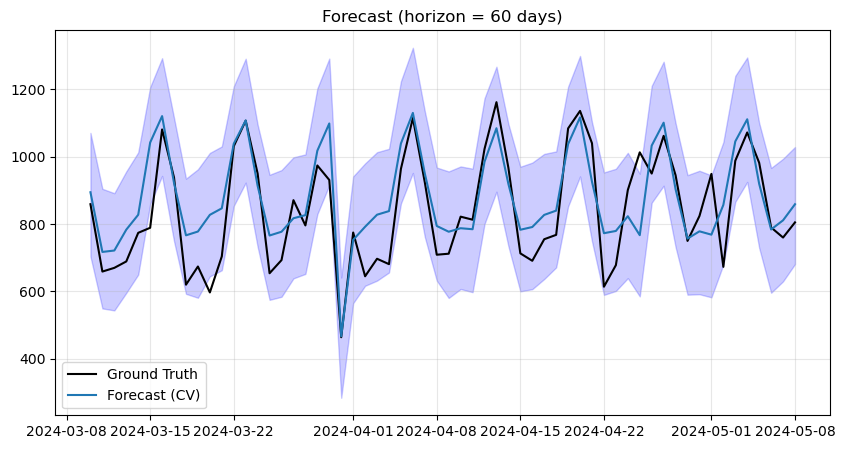


Test set metrics:
RMSE = 97.94
MAE  = 77.41


C:\Users\andre\AppData\Local\Temp\ipykernel_37676\1743448199.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_final["pre_covid"] = (train_final["ds"] < cutoff_date)
C:\Users\andre\AppData\Local\Temp\ipykernel_37676\1743448199.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_final["post_covid"] = (train_final["ds"] >= cutoff_date)
13:15:35 - cmdstanpy - INFO - Chain [1] start processing
13:15:36 - cmdstanpy - INFO - Chain [1] done processing



Model components:


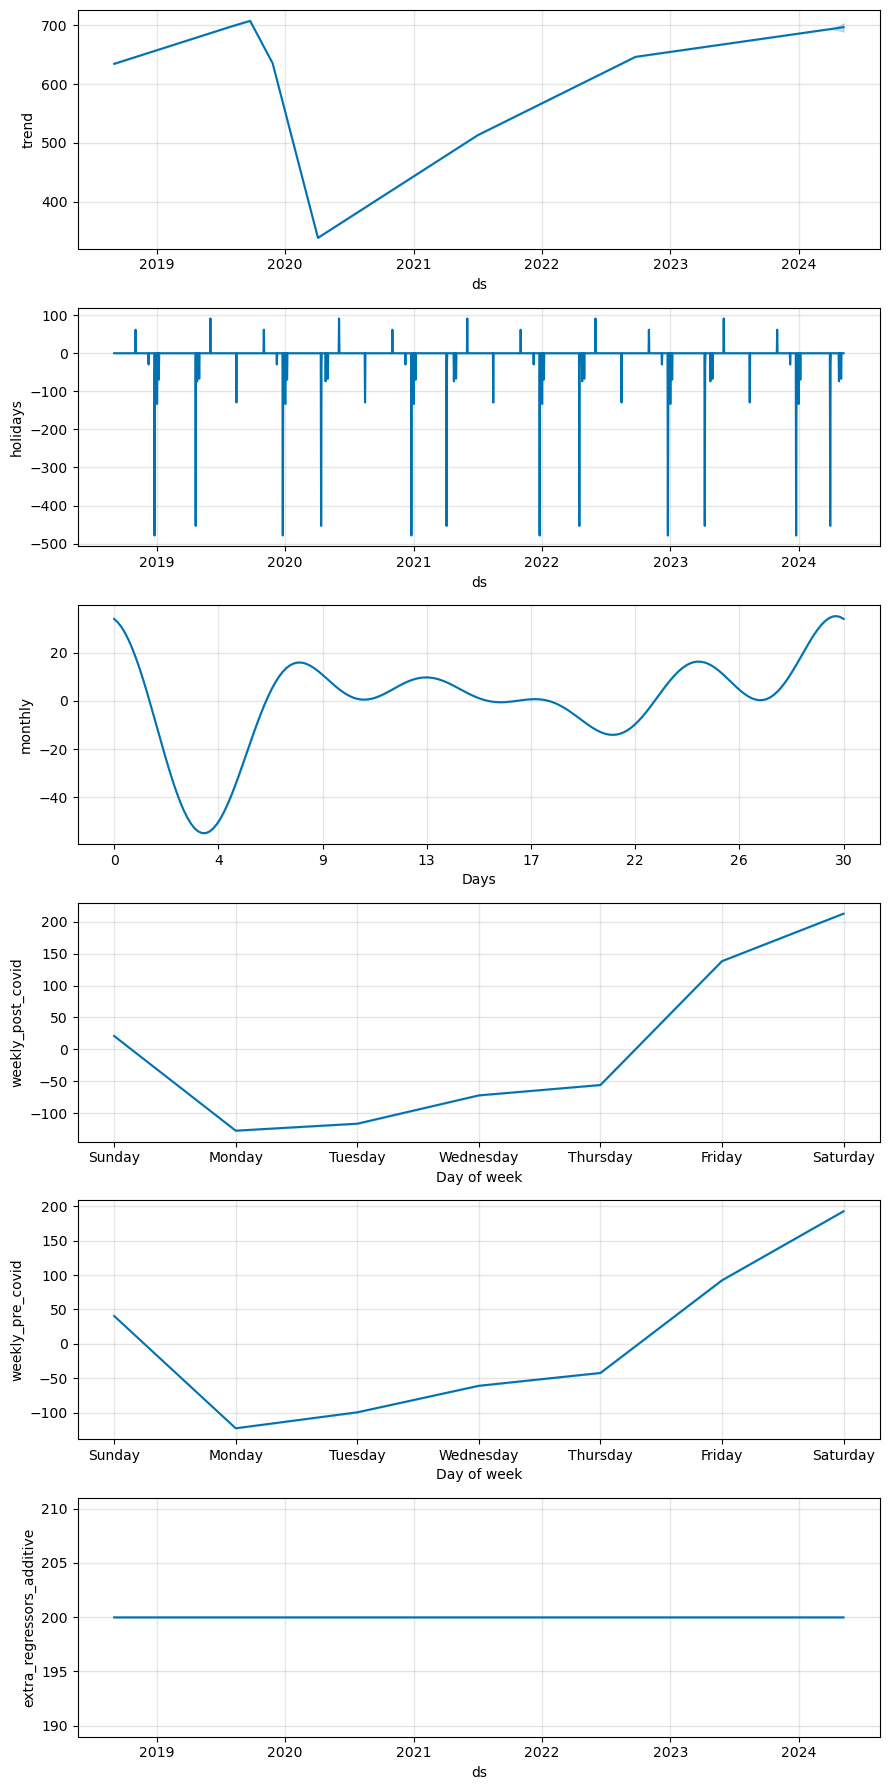

In [141]:
results = fit_prophet_model(
    df=df,
    y_col='scontrini',
    ds_col='data',
    regressors= covid_regr[1],
    n_test=60,
    weekly=False,
    monthly=True,
    yearly=False,
    weekly_prepost=True,
    holidays=True,
    verbose = True,
    return_results = True)

In [142]:
with open("models/prophet_model_scontrini_restaurant_4.json", "w") as f:
    f.write(model_to_json(results["model"]))

## GRID SEARCH ON DF5

In [7]:
df = pd.read_csv('data/restaurant_5.csv')

results = []

for (w, m, y, wp, h, covid) in param_grid:
    print(f"\n Testing with: weekly={w}, monthly={m}, yearly={y}, prepost={wp}, holidays={h}, covid={covid is not None}")
    
    
        # Fit Prophet
    res = fit_prophet_model(
            df=df,
            y_col="scontrini",
            ds_col="data",
            n_test=60,
            weekly=w,
            monthly=m,
            yearly=y,
            weekly_prepost=wp,
            holidays=h,
            regressors=covid,
            verbose=False,
            return_results=True
    )

        
    metrics_last = res["metrics_last_window"]
    cv_metrics = res["metrics_cv"]
    rmse_cv_mean = cv_metrics["rmse"].mean()
    mae_cv_mean = cv_metrics["mae"].mean()
      
    results.append({
            "weekly": w,
            "monthly": m,
            "yearly": y,
            "weekly_prepost": wp,
            "holidays": h,
            "covid_regressors": covid,
            "RMSE_last": metrics_last["RMSE"],
            "MAE_last": metrics_last["MAE"],
            "RMSE_cv_mean": rmse_cv_mean,
            "MAE_cv_mean": mae_cv_mean
    })


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=True, covid=False


13:18:12 - cmdstanpy - INFO - Chain [1] start processing
13:18:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:18:14 - cmdstanpy - INFO - Chain [1] start processing
13:18:14 - cmdstanpy - INFO - Chain [1] done processing
13:18:14 - cmdstanpy - INFO - Chain [1] start processing
13:18:14 - cmdstanpy - INFO - Chain [1] done processing
13:18:15 - cmdstanpy - INFO - Chain [1] start processing
13:18:15 - cmdstanpy - INFO - Chain [1] done processing
13:18:15 - cmdstanpy - INFO - Chain [1] start processing
13:18:15 - cmdstanpy - INFO - Chain [1] done processing
13:18:15 - cmdstanpy - INFO - Chain [1] start processing
13:18:16 - cmdstanpy - INFO - Chain [1] done processing
13:18:16 - cmdstanpy - INFO - Chain [1] start processing
13:18:16 - cmdstanpy - INFO - Chain [1] done processing
13:18:17 - cmdstanpy - INFO - Chain [1] start processing
13:18:17 - cmdstanpy - INFO - Chain [1] done processing
13:18:17 - cmdstanpy - INFO - Chain [1] start processing
13:18:18 - cmdstanpy - INFO - Chain [1] done processing
13:18:18 - cmdstanpy - INFO - Chain [1] start processing
13:18:18 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


13:18:33 - cmdstanpy - INFO - Chain [1] start processing
13:18:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:18:34 - cmdstanpy - INFO - Chain [1] start processing
13:18:34 - cmdstanpy - INFO - Chain [1] done processing
13:18:34 - cmdstanpy - INFO - Chain [1] start processing
13:18:35 - cmdstanpy - INFO - Chain [1] done processing
13:18:35 - cmdstanpy - INFO - Chain [1] start processing
13:18:35 - cmdstanpy - INFO - Chain [1] done processing
13:18:36 - cmdstanpy - INFO - Chain [1] start processing
13:18:36 - cmdstanpy - INFO - Chain [1] done processing
13:18:36 - cmdstanpy - INFO - Chain [1] start processing
13:18:36 - cmdstanpy - INFO - Chain [1] done processing
13:18:37 - cmdstanpy - INFO - Chain [1] start processing
13:18:37 - cmdstanpy - INFO - Chain [1] done processing
13:18:37 - cmdstanpy - INFO - Chain [1] start processing
13:18:38 - cmdstanpy - INFO - Chain [1] done processing
13:18:38 - cmdstanpy - INFO - Chain [1] start processing
13:18:38 - cmdstanpy - INFO - Chain [1] done processing
13:18:39 - cmdstanpy - INFO - Chain [1] start processing
13:18:39 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


13:18:56 - cmdstanpy - INFO - Chain [1] start processing
13:18:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:18:57 - cmdstanpy - INFO - Chain [1] start processing
13:18:57 - cmdstanpy - INFO - Chain [1] done processing
13:18:58 - cmdstanpy - INFO - Chain [1] start processing
13:18:58 - cmdstanpy - INFO - Chain [1] done processing
13:18:58 - cmdstanpy - INFO - Chain [1] start processing
13:18:58 - cmdstanpy - INFO - Chain [1] done processing
13:18:59 - cmdstanpy - INFO - Chain [1] start processing
13:18:59 - cmdstanpy - INFO - Chain [1] done processing
13:18:59 - cmdstanpy - INFO - Chain [1] start processing
13:19:00 - cmdstanpy - INFO - Chain [1] done processing
13:19:00 - cmdstanpy - INFO - Chain [1] start processing
13:19:00 - cmdstanpy - INFO - Chain [1] done processing
13:19:01 - cmdstanpy - INFO - Chain [1] start processing
13:19:01 - cmdstanpy - INFO - Chain [1] done processing
13:19:02 - cmdstanpy - INFO - Chain [1] start processing
13:19:02 - cmdstanpy - INFO - Chain [1] done processing
13:19:02 - cmdstanpy - INFO - Chain [1] start processing
13:19:03 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=False, covid=False


13:19:19 - cmdstanpy - INFO - Chain [1] start processing
13:19:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:19:20 - cmdstanpy - INFO - Chain [1] start processing
13:19:20 - cmdstanpy - INFO - Chain [1] done processing
13:19:21 - cmdstanpy - INFO - Chain [1] start processing
13:19:21 - cmdstanpy - INFO - Chain [1] done processing
13:19:21 - cmdstanpy - INFO - Chain [1] start processing
13:19:21 - cmdstanpy - INFO - Chain [1] done processing
13:19:22 - cmdstanpy - INFO - Chain [1] start processing
13:19:22 - cmdstanpy - INFO - Chain [1] done processing
13:19:22 - cmdstanpy - INFO - Chain [1] start processing
13:19:22 - cmdstanpy - INFO - Chain [1] done processing
13:19:23 - cmdstanpy - INFO - Chain [1] start processing
13:19:23 - cmdstanpy - INFO - Chain [1] done processing
13:19:23 - cmdstanpy - INFO - Chain [1] start processing
13:19:24 - cmdstanpy - INFO - Chain [1] done processing
13:19:24 - cmdstanpy - INFO - Chain [1] start processing
13:19:24 - cmdstanpy - INFO - Chain [1] done processing
13:19:25 - cmdstanpy - INFO - Chain [1] start processing
13:19:25 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


13:19:38 - cmdstanpy - INFO - Chain [1] start processing
13:19:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:19:39 - cmdstanpy - INFO - Chain [1] start processing
13:19:39 - cmdstanpy - INFO - Chain [1] done processing
13:19:40 - cmdstanpy - INFO - Chain [1] start processing
13:19:40 - cmdstanpy - INFO - Chain [1] done processing
13:19:40 - cmdstanpy - INFO - Chain [1] start processing
13:19:40 - cmdstanpy - INFO - Chain [1] done processing
13:19:41 - cmdstanpy - INFO - Chain [1] start processing
13:19:41 - cmdstanpy - INFO - Chain [1] done processing
13:19:41 - cmdstanpy - INFO - Chain [1] start processing
13:19:41 - cmdstanpy - INFO - Chain [1] done processing
13:19:42 - cmdstanpy - INFO - Chain [1] start processing
13:19:42 - cmdstanpy - INFO - Chain [1] done processing
13:19:42 - cmdstanpy - INFO - Chain [1] start processing
13:19:43 - cmdstanpy - INFO - Chain [1] done processing
13:19:43 - cmdstanpy - INFO - Chain [1] start processing
13:19:43 - cmdstanpy - INFO - Chain [1] done processing
13:19:43 - cmdstanpy - INFO - Chain [1] start processing
13:19:44 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


13:19:58 - cmdstanpy - INFO - Chain [1] start processing
13:19:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:19:59 - cmdstanpy - INFO - Chain [1] start processing
13:20:00 - cmdstanpy - INFO - Chain [1] done processing
13:20:00 - cmdstanpy - INFO - Chain [1] start processing
13:20:00 - cmdstanpy - INFO - Chain [1] done processing
13:20:00 - cmdstanpy - INFO - Chain [1] start processing
13:20:00 - cmdstanpy - INFO - Chain [1] done processing
13:20:01 - cmdstanpy - INFO - Chain [1] start processing
13:20:01 - cmdstanpy - INFO - Chain [1] done processing
13:20:01 - cmdstanpy - INFO - Chain [1] start processing
13:20:01 - cmdstanpy - INFO - Chain [1] done processing
13:20:02 - cmdstanpy - INFO - Chain [1] start processing
13:20:02 - cmdstanpy - INFO - Chain [1] done processing
13:20:02 - cmdstanpy - INFO - Chain [1] start processing
13:20:02 - cmdstanpy - INFO - Chain [1] done processing
13:20:03 - cmdstanpy - INFO - Chain [1] start processing
13:20:03 - cmdstanpy - INFO - Chain [1] done processing
13:20:03 - cmdstanpy - INFO - Chain [1] start processing
13:20:03 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=True, covid=False


13:20:17 - cmdstanpy - INFO - Chain [1] start processing
13:20:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:20:18 - cmdstanpy - INFO - Chain [1] start processing
13:20:18 - cmdstanpy - INFO - Chain [1] done processing
13:20:18 - cmdstanpy - INFO - Chain [1] start processing
13:20:18 - cmdstanpy - INFO - Chain [1] done processing
13:20:19 - cmdstanpy - INFO - Chain [1] start processing
13:20:19 - cmdstanpy - INFO - Chain [1] done processing
13:20:19 - cmdstanpy - INFO - Chain [1] start processing
13:20:19 - cmdstanpy - INFO - Chain [1] done processing
13:20:20 - cmdstanpy - INFO - Chain [1] start processing
13:20:20 - cmdstanpy - INFO - Chain [1] done processing
13:20:20 - cmdstanpy - INFO - Chain [1] start processing
13:20:21 - cmdstanpy - INFO - Chain [1] done processing
13:20:21 - cmdstanpy - INFO - Chain [1] start processing
13:20:22 - cmdstanpy - INFO - Chain [1] done processing
13:20:22 - cmdstanpy - INFO - Chain [1] start processing
13:20:22 - cmdstanpy - INFO - Chain [1] done processing
13:20:23 - cmdstanpy - INFO - Chain [1] start processing
13:20:23 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


13:20:38 - cmdstanpy - INFO - Chain [1] start processing
13:20:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:20:39 - cmdstanpy - INFO - Chain [1] start processing
13:20:39 - cmdstanpy - INFO - Chain [1] done processing
13:20:39 - cmdstanpy - INFO - Chain [1] start processing
13:20:39 - cmdstanpy - INFO - Chain [1] done processing
13:20:40 - cmdstanpy - INFO - Chain [1] start processing
13:20:40 - cmdstanpy - INFO - Chain [1] done processing
13:20:40 - cmdstanpy - INFO - Chain [1] start processing
13:20:40 - cmdstanpy - INFO - Chain [1] done processing
13:20:40 - cmdstanpy - INFO - Chain [1] start processing
13:20:41 - cmdstanpy - INFO - Chain [1] done processing
13:20:41 - cmdstanpy - INFO - Chain [1] start processing
13:20:41 - cmdstanpy - INFO - Chain [1] done processing
13:20:41 - cmdstanpy - INFO - Chain [1] start processing
13:20:42 - cmdstanpy - INFO - Chain [1] done processing
13:20:42 - cmdstanpy - INFO - Chain [1] start processing
13:20:43 - cmdstanpy - INFO - Chain [1] done processing
13:20:43 - cmdstanpy - INFO - Chain [1] start processing
13:20:43 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


13:20:57 - cmdstanpy - INFO - Chain [1] start processing
13:20:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:20:59 - cmdstanpy - INFO - Chain [1] start processing
13:20:59 - cmdstanpy - INFO - Chain [1] done processing
13:20:59 - cmdstanpy - INFO - Chain [1] start processing
13:20:59 - cmdstanpy - INFO - Chain [1] done processing
13:21:00 - cmdstanpy - INFO - Chain [1] start processing
13:21:00 - cmdstanpy - INFO - Chain [1] done processing
13:21:00 - cmdstanpy - INFO - Chain [1] start processing
13:21:00 - cmdstanpy - INFO - Chain [1] done processing
13:21:00 - cmdstanpy - INFO - Chain [1] start processing
13:21:01 - cmdstanpy - INFO - Chain [1] done processing
13:21:01 - cmdstanpy - INFO - Chain [1] start processing
13:21:01 - cmdstanpy - INFO - Chain [1] done processing
13:21:02 - cmdstanpy - INFO - Chain [1] start processing
13:21:02 - cmdstanpy - INFO - Chain [1] done processing
13:21:02 - cmdstanpy - INFO - Chain [1] start processing
13:21:03 - cmdstanpy - INFO - Chain [1] done processing
13:21:03 - cmdstanpy - INFO - Chain [1] start processing
13:21:03 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=False, covid=False


13:21:19 - cmdstanpy - INFO - Chain [1] start processing
13:21:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:21:19 - cmdstanpy - INFO - Chain [1] start processing
13:21:20 - cmdstanpy - INFO - Chain [1] done processing
13:21:20 - cmdstanpy - INFO - Chain [1] start processing
13:21:20 - cmdstanpy - INFO - Chain [1] done processing
13:21:20 - cmdstanpy - INFO - Chain [1] start processing
13:21:20 - cmdstanpy - INFO - Chain [1] done processing
13:21:21 - cmdstanpy - INFO - Chain [1] start processing
13:21:21 - cmdstanpy - INFO - Chain [1] done processing
13:21:21 - cmdstanpy - INFO - Chain [1] start processing
13:21:21 - cmdstanpy - INFO - Chain [1] done processing
13:21:22 - cmdstanpy - INFO - Chain [1] start processing
13:21:22 - cmdstanpy - INFO - Chain [1] done processing
13:21:22 - cmdstanpy - INFO - Chain [1] start processing
13:21:23 - cmdstanpy - INFO - Chain [1] done processing
13:21:23 - cmdstanpy - INFO - Chain [1] start processing
13:21:23 - cmdstanpy - INFO - Chain [1] done processing
13:21:23 - cmdstanpy - INFO - Chain [1] start processing
13:21:24 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


13:21:36 - cmdstanpy - INFO - Chain [1] start processing
13:21:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:21:37 - cmdstanpy - INFO - Chain [1] start processing
13:21:37 - cmdstanpy - INFO - Chain [1] done processing
13:21:37 - cmdstanpy - INFO - Chain [1] start processing
13:21:37 - cmdstanpy - INFO - Chain [1] done processing
13:21:38 - cmdstanpy - INFO - Chain [1] start processing
13:21:38 - cmdstanpy - INFO - Chain [1] done processing
13:21:38 - cmdstanpy - INFO - Chain [1] start processing
13:21:38 - cmdstanpy - INFO - Chain [1] done processing
13:21:39 - cmdstanpy - INFO - Chain [1] start processing
13:21:39 - cmdstanpy - INFO - Chain [1] done processing
13:21:39 - cmdstanpy - INFO - Chain [1] start processing
13:21:39 - cmdstanpy - INFO - Chain [1] done processing
13:21:40 - cmdstanpy - INFO - Chain [1] start processing
13:21:40 - cmdstanpy - INFO - Chain [1] done processing
13:21:40 - cmdstanpy - INFO - Chain [1] start processing
13:21:41 - cmdstanpy - INFO - Chain [1] done processing
13:21:41 - cmdstanpy - INFO - Chain [1] start processing
13:21:41 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


13:21:55 - cmdstanpy - INFO - Chain [1] start processing
13:21:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:21:56 - cmdstanpy - INFO - Chain [1] start processing
13:21:56 - cmdstanpy - INFO - Chain [1] done processing
13:21:57 - cmdstanpy - INFO - Chain [1] start processing
13:21:57 - cmdstanpy - INFO - Chain [1] done processing
13:21:57 - cmdstanpy - INFO - Chain [1] start processing
13:21:57 - cmdstanpy - INFO - Chain [1] done processing
13:21:58 - cmdstanpy - INFO - Chain [1] start processing
13:21:58 - cmdstanpy - INFO - Chain [1] done processing
13:21:58 - cmdstanpy - INFO - Chain [1] start processing
13:21:58 - cmdstanpy - INFO - Chain [1] done processing
13:21:59 - cmdstanpy - INFO - Chain [1] start processing
13:21:59 - cmdstanpy - INFO - Chain [1] done processing
13:21:59 - cmdstanpy - INFO - Chain [1] start processing
13:22:00 - cmdstanpy - INFO - Chain [1] done processing
13:22:00 - cmdstanpy - INFO - Chain [1] start processing
13:22:00 - cmdstanpy - INFO - Chain [1] done processing
13:22:01 - cmdstanpy - INFO - Chain [1] start processing
13:22:01 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=True, covid=False


13:22:14 - cmdstanpy - INFO - Chain [1] start processing
13:22:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:22:15 - cmdstanpy - INFO - Chain [1] start processing
13:22:15 - cmdstanpy - INFO - Chain [1] done processing
13:22:15 - cmdstanpy - INFO - Chain [1] start processing
13:22:16 - cmdstanpy - INFO - Chain [1] done processing
13:22:16 - cmdstanpy - INFO - Chain [1] start processing
13:22:16 - cmdstanpy - INFO - Chain [1] done processing
13:22:17 - cmdstanpy - INFO - Chain [1] start processing
13:22:17 - cmdstanpy - INFO - Chain [1] done processing
13:22:17 - cmdstanpy - INFO - Chain [1] start processing
13:22:17 - cmdstanpy - INFO - Chain [1] done processing
13:22:18 - cmdstanpy - INFO - Chain [1] start processing
13:22:18 - cmdstanpy - INFO - Chain [1] done processing
13:22:18 - cmdstanpy - INFO - Chain [1] start processing
13:22:18 - cmdstanpy - INFO - Chain [1] done processing
13:22:19 - cmdstanpy - INFO - Chain [1] start processing
13:22:19 - cmdstanpy - INFO - Chain [1] done processing
13:22:19 - cmdstanpy - INFO - Chain [1] start processing
13:22:20 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


13:22:32 - cmdstanpy - INFO - Chain [1] start processing
13:22:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:22:33 - cmdstanpy - INFO - Chain [1] start processing
13:22:33 - cmdstanpy - INFO - Chain [1] done processing
13:22:33 - cmdstanpy - INFO - Chain [1] start processing
13:22:33 - cmdstanpy - INFO - Chain [1] done processing
13:22:33 - cmdstanpy - INFO - Chain [1] start processing
13:22:33 - cmdstanpy - INFO - Chain [1] done processing
13:22:34 - cmdstanpy - INFO - Chain [1] start processing
13:22:34 - cmdstanpy - INFO - Chain [1] done processing
13:22:34 - cmdstanpy - INFO - Chain [1] start processing
13:22:34 - cmdstanpy - INFO - Chain [1] done processing
13:22:35 - cmdstanpy - INFO - Chain [1] start processing
13:22:35 - cmdstanpy - INFO - Chain [1] done processing
13:22:35 - cmdstanpy - INFO - Chain [1] start processing
13:22:35 - cmdstanpy - INFO - Chain [1] done processing
13:22:36 - cmdstanpy - INFO - Chain [1] start processing
13:22:36 - cmdstanpy - INFO - Chain [1] done processing
13:22:36 - cmdstanpy - INFO - Chain [1] start processing
13:22:37 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


13:22:50 - cmdstanpy - INFO - Chain [1] start processing
13:22:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:22:51 - cmdstanpy - INFO - Chain [1] start processing
13:22:51 - cmdstanpy - INFO - Chain [1] done processing
13:22:51 - cmdstanpy - INFO - Chain [1] start processing
13:22:52 - cmdstanpy - INFO - Chain [1] done processing
13:22:52 - cmdstanpy - INFO - Chain [1] start processing
13:22:52 - cmdstanpy - INFO - Chain [1] done processing
13:22:52 - cmdstanpy - INFO - Chain [1] start processing
13:22:53 - cmdstanpy - INFO - Chain [1] done processing
13:22:53 - cmdstanpy - INFO - Chain [1] start processing
13:22:53 - cmdstanpy - INFO - Chain [1] done processing
13:22:54 - cmdstanpy - INFO - Chain [1] start processing
13:22:54 - cmdstanpy - INFO - Chain [1] done processing
13:22:54 - cmdstanpy - INFO - Chain [1] start processing
13:22:54 - cmdstanpy - INFO - Chain [1] done processing
13:22:55 - cmdstanpy - INFO - Chain [1] start processing
13:22:55 - cmdstanpy - INFO - Chain [1] done processing
13:22:55 - cmdstanpy - INFO - Chain [1] start processing
13:22:56 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=False, covid=False


13:23:08 - cmdstanpy - INFO - Chain [1] start processing
13:23:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:23:09 - cmdstanpy - INFO - Chain [1] start processing
13:23:09 - cmdstanpy - INFO - Chain [1] done processing
13:23:09 - cmdstanpy - INFO - Chain [1] start processing
13:23:09 - cmdstanpy - INFO - Chain [1] done processing
13:23:10 - cmdstanpy - INFO - Chain [1] start processing
13:23:10 - cmdstanpy - INFO - Chain [1] done processing
13:23:10 - cmdstanpy - INFO - Chain [1] start processing
13:23:10 - cmdstanpy - INFO - Chain [1] done processing
13:23:10 - cmdstanpy - INFO - Chain [1] start processing
13:23:11 - cmdstanpy - INFO - Chain [1] done processing
13:23:11 - cmdstanpy - INFO - Chain [1] start processing
13:23:11 - cmdstanpy - INFO - Chain [1] done processing
13:23:11 - cmdstanpy - INFO - Chain [1] start processing
13:23:12 - cmdstanpy - INFO - Chain [1] done processing
13:23:12 - cmdstanpy - INFO - Chain [1] start processing
13:23:12 - cmdstanpy - INFO - Chain [1] done processing
13:23:12 - cmdstanpy - INFO - Chain [1] start processing
13:23:13 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


13:23:23 - cmdstanpy - INFO - Chain [1] start processing
13:23:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:23:24 - cmdstanpy - INFO - Chain [1] start processing
13:23:24 - cmdstanpy - INFO - Chain [1] done processing
13:23:25 - cmdstanpy - INFO - Chain [1] start processing
13:23:25 - cmdstanpy - INFO - Chain [1] done processing
13:23:25 - cmdstanpy - INFO - Chain [1] start processing
13:23:25 - cmdstanpy - INFO - Chain [1] done processing
13:23:25 - cmdstanpy - INFO - Chain [1] start processing
13:23:25 - cmdstanpy - INFO - Chain [1] done processing
13:23:26 - cmdstanpy - INFO - Chain [1] start processing
13:23:26 - cmdstanpy - INFO - Chain [1] done processing
13:23:26 - cmdstanpy - INFO - Chain [1] start processing
13:23:27 - cmdstanpy - INFO - Chain [1] done processing
13:23:27 - cmdstanpy - INFO - Chain [1] start processing
13:23:27 - cmdstanpy - INFO - Chain [1] done processing
13:23:27 - cmdstanpy - INFO - Chain [1] start processing
13:23:27 - cmdstanpy - INFO - Chain [1] done processing
13:23:28 - cmdstanpy - INFO - Chain [1] start processing
13:23:28 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


13:23:39 - cmdstanpy - INFO - Chain [1] start processing
13:23:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:23:40 - cmdstanpy - INFO - Chain [1] start processing
13:23:40 - cmdstanpy - INFO - Chain [1] done processing
13:23:41 - cmdstanpy - INFO - Chain [1] start processing
13:23:41 - cmdstanpy - INFO - Chain [1] done processing
13:23:41 - cmdstanpy - INFO - Chain [1] start processing
13:23:41 - cmdstanpy - INFO - Chain [1] done processing
13:23:42 - cmdstanpy - INFO - Chain [1] start processing
13:23:42 - cmdstanpy - INFO - Chain [1] done processing
13:23:42 - cmdstanpy - INFO - Chain [1] start processing
13:23:42 - cmdstanpy - INFO - Chain [1] done processing
13:23:43 - cmdstanpy - INFO - Chain [1] start processing
13:23:43 - cmdstanpy - INFO - Chain [1] done processing
13:23:43 - cmdstanpy - INFO - Chain [1] start processing
13:23:44 - cmdstanpy - INFO - Chain [1] done processing
13:23:44 - cmdstanpy - INFO - Chain [1] start processing
13:23:44 - cmdstanpy - INFO - Chain [1] done processing
13:23:45 - cmdstanpy - INFO - Chain [1] start processing
13:23:45 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=True, covid=False


13:24:12 - cmdstanpy - INFO - Chain [1] start processing
13:24:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:24:15 - cmdstanpy - INFO - Chain [1] start processing
13:24:15 - cmdstanpy - INFO - Chain [1] done processing
13:24:16 - cmdstanpy - INFO - Chain [1] start processing
13:24:16 - cmdstanpy - INFO - Chain [1] done processing
13:24:17 - cmdstanpy - INFO - Chain [1] start processing
13:24:18 - cmdstanpy - INFO - Chain [1] done processing
13:24:19 - cmdstanpy - INFO - Chain [1] start processing
13:24:19 - cmdstanpy - INFO - Chain [1] done processing
13:24:20 - cmdstanpy - INFO - Chain [1] start processing
13:24:20 - cmdstanpy - INFO - Chain [1] done processing
13:24:21 - cmdstanpy - INFO - Chain [1] start processing
13:24:22 - cmdstanpy - INFO - Chain [1] done processing
13:24:23 - cmdstanpy - INFO - Chain [1] start processing
13:24:23 - cmdstanpy - INFO - Chain [1] done processing
13:24:24 - cmdstanpy - INFO - Chain [1] start processing
13:24:24 - cmdstanpy - INFO - Chain [1] done processing
13:24:25 - cmdstanpy - INFO - Chain [1] start processing
13:24:26 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


13:24:40 - cmdstanpy - INFO - Chain [1] start processing
13:24:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:24:41 - cmdstanpy - INFO - Chain [1] start processing
13:24:41 - cmdstanpy - INFO - Chain [1] done processing
13:24:41 - cmdstanpy - INFO - Chain [1] start processing
13:24:41 - cmdstanpy - INFO - Chain [1] done processing
13:24:42 - cmdstanpy - INFO - Chain [1] start processing
13:24:42 - cmdstanpy - INFO - Chain [1] done processing
13:24:42 - cmdstanpy - INFO - Chain [1] start processing
13:24:42 - cmdstanpy - INFO - Chain [1] done processing
13:24:43 - cmdstanpy - INFO - Chain [1] start processing
13:24:43 - cmdstanpy - INFO - Chain [1] done processing
13:24:43 - cmdstanpy - INFO - Chain [1] start processing
13:24:43 - cmdstanpy - INFO - Chain [1] done processing
13:24:44 - cmdstanpy - INFO - Chain [1] start processing
13:24:44 - cmdstanpy - INFO - Chain [1] done processing
13:24:44 - cmdstanpy - INFO - Chain [1] start processing
13:24:45 - cmdstanpy - INFO - Chain [1] done processing
13:24:46 - cmdstanpy - INFO - Chain [1] start processing
13:24:47 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


13:25:14 - cmdstanpy - INFO - Chain [1] start processing
13:25:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:25:15 - cmdstanpy - INFO - Chain [1] start processing
13:25:15 - cmdstanpy - INFO - Chain [1] done processing
13:25:16 - cmdstanpy - INFO - Chain [1] start processing
13:25:16 - cmdstanpy - INFO - Chain [1] done processing
13:25:16 - cmdstanpy - INFO - Chain [1] start processing
13:25:16 - cmdstanpy - INFO - Chain [1] done processing
13:25:17 - cmdstanpy - INFO - Chain [1] start processing
13:25:17 - cmdstanpy - INFO - Chain [1] done processing
13:25:17 - cmdstanpy - INFO - Chain [1] start processing
13:25:17 - cmdstanpy - INFO - Chain [1] done processing
13:25:18 - cmdstanpy - INFO - Chain [1] start processing
13:25:18 - cmdstanpy - INFO - Chain [1] done processing
13:25:18 - cmdstanpy - INFO - Chain [1] start processing
13:25:18 - cmdstanpy - INFO - Chain [1] done processing
13:25:19 - cmdstanpy - INFO - Chain [1] start processing
13:25:19 - cmdstanpy - INFO - Chain [1] done processing
13:25:19 - cmdstanpy - INFO - Chain [1] start processing
13:25:20 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=False, covid=False


13:25:47 - cmdstanpy - INFO - Chain [1] start processing
13:25:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:25:49 - cmdstanpy - INFO - Chain [1] start processing
13:25:49 - cmdstanpy - INFO - Chain [1] done processing
13:25:50 - cmdstanpy - INFO - Chain [1] start processing
13:25:50 - cmdstanpy - INFO - Chain [1] done processing
13:25:50 - cmdstanpy - INFO - Chain [1] start processing
13:25:51 - cmdstanpy - INFO - Chain [1] done processing
13:25:52 - cmdstanpy - INFO - Chain [1] start processing
13:25:52 - cmdstanpy - INFO - Chain [1] done processing
13:25:52 - cmdstanpy - INFO - Chain [1] start processing
13:25:53 - cmdstanpy - INFO - Chain [1] done processing
13:25:54 - cmdstanpy - INFO - Chain [1] start processing
13:25:54 - cmdstanpy - INFO - Chain [1] done processing
13:25:54 - cmdstanpy - INFO - Chain [1] start processing
13:25:55 - cmdstanpy - INFO - Chain [1] done processing
13:25:56 - cmdstanpy - INFO - Chain [1] start processing
13:25:56 - cmdstanpy - INFO - Chain [1] done processing
13:25:57 - cmdstanpy - INFO - Chain [1] start processing
13:25:57 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


13:26:22 - cmdstanpy - INFO - Chain [1] start processing
13:26:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:26:24 - cmdstanpy - INFO - Chain [1] start processing
13:26:24 - cmdstanpy - INFO - Chain [1] done processing
13:26:25 - cmdstanpy - INFO - Chain [1] start processing
13:26:25 - cmdstanpy - INFO - Chain [1] done processing
13:26:26 - cmdstanpy - INFO - Chain [1] start processing
13:26:26 - cmdstanpy - INFO - Chain [1] done processing
13:26:27 - cmdstanpy - INFO - Chain [1] start processing
13:26:27 - cmdstanpy - INFO - Chain [1] done processing
13:26:28 - cmdstanpy - INFO - Chain [1] start processing
13:26:29 - cmdstanpy - INFO - Chain [1] done processing
13:26:29 - cmdstanpy - INFO - Chain [1] start processing
13:26:30 - cmdstanpy - INFO - Chain [1] done processing
13:26:30 - cmdstanpy - INFO - Chain [1] start processing
13:26:31 - cmdstanpy - INFO - Chain [1] done processing
13:26:32 - cmdstanpy - INFO - Chain [1] start processing
13:26:32 - cmdstanpy - INFO - Chain [1] done processing
13:26:33 - cmdstanpy - INFO - Chain [1] start processing
13:26:33 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


13:26:59 - cmdstanpy - INFO - Chain [1] start processing
13:27:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:27:01 - cmdstanpy - INFO - Chain [1] start processing
13:27:01 - cmdstanpy - INFO - Chain [1] done processing
13:27:02 - cmdstanpy - INFO - Chain [1] start processing
13:27:02 - cmdstanpy - INFO - Chain [1] done processing
13:27:03 - cmdstanpy - INFO - Chain [1] start processing
13:27:03 - cmdstanpy - INFO - Chain [1] done processing
13:27:04 - cmdstanpy - INFO - Chain [1] start processing
13:27:04 - cmdstanpy - INFO - Chain [1] done processing
13:27:05 - cmdstanpy - INFO - Chain [1] start processing
13:27:05 - cmdstanpy - INFO - Chain [1] done processing
13:27:05 - cmdstanpy - INFO - Chain [1] start processing
13:27:06 - cmdstanpy - INFO - Chain [1] done processing
13:27:06 - cmdstanpy - INFO - Chain [1] start processing
13:27:07 - cmdstanpy - INFO - Chain [1] done processing
13:27:08 - cmdstanpy - INFO - Chain [1] start processing
13:27:08 - cmdstanpy - INFO - Chain [1] done processing
13:27:09 - cmdstanpy - INFO - Chain [1] start processing
13:27:09 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=True, covid=False


13:27:36 - cmdstanpy - INFO - Chain [1] start processing
13:27:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:27:39 - cmdstanpy - INFO - Chain [1] start processing
13:27:40 - cmdstanpy - INFO - Chain [1] done processing
13:27:41 - cmdstanpy - INFO - Chain [1] start processing
13:27:41 - cmdstanpy - INFO - Chain [1] done processing
13:27:42 - cmdstanpy - INFO - Chain [1] start processing
13:27:42 - cmdstanpy - INFO - Chain [1] done processing
13:27:43 - cmdstanpy - INFO - Chain [1] start processing
13:27:44 - cmdstanpy - INFO - Chain [1] done processing
13:27:45 - cmdstanpy - INFO - Chain [1] start processing
13:27:45 - cmdstanpy - INFO - Chain [1] done processing
13:27:46 - cmdstanpy - INFO - Chain [1] start processing
13:27:46 - cmdstanpy - INFO - Chain [1] done processing
13:27:47 - cmdstanpy - INFO - Chain [1] start processing
13:27:48 - cmdstanpy - INFO - Chain [1] done processing
13:27:49 - cmdstanpy - INFO - Chain [1] start processing
13:27:50 - cmdstanpy - INFO - Chain [1] done processing
13:27:51 - cmdstanpy - INFO - Chain [1] start processing
13:27:52 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


13:28:32 - cmdstanpy - INFO - Chain [1] start processing
13:28:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:28:34 - cmdstanpy - INFO - Chain [1] start processing
13:28:34 - cmdstanpy - INFO - Chain [1] done processing
13:28:35 - cmdstanpy - INFO - Chain [1] start processing
13:28:36 - cmdstanpy - INFO - Chain [1] done processing
13:28:37 - cmdstanpy - INFO - Chain [1] start processing
13:28:37 - cmdstanpy - INFO - Chain [1] done processing
13:28:38 - cmdstanpy - INFO - Chain [1] start processing
13:28:39 - cmdstanpy - INFO - Chain [1] done processing
13:28:40 - cmdstanpy - INFO - Chain [1] start processing
13:28:40 - cmdstanpy - INFO - Chain [1] done processing
13:28:41 - cmdstanpy - INFO - Chain [1] start processing
13:28:42 - cmdstanpy - INFO - Chain [1] done processing
13:28:43 - cmdstanpy - INFO - Chain [1] start processing
13:28:44 - cmdstanpy - INFO - Chain [1] done processing
13:28:45 - cmdstanpy - INFO - Chain [1] start processing
13:28:45 - cmdstanpy - INFO - Chain [1] done processing
13:28:47 - cmdstanpy - INFO - Chain [1] start processing
13:28:47 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


13:29:28 - cmdstanpy - INFO - Chain [1] start processing
13:29:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:29:30 - cmdstanpy - INFO - Chain [1] start processing
13:29:31 - cmdstanpy - INFO - Chain [1] done processing
13:29:32 - cmdstanpy - INFO - Chain [1] start processing
13:29:32 - cmdstanpy - INFO - Chain [1] done processing
13:29:33 - cmdstanpy - INFO - Chain [1] start processing
13:29:33 - cmdstanpy - INFO - Chain [1] done processing
13:29:34 - cmdstanpy - INFO - Chain [1] start processing
13:29:35 - cmdstanpy - INFO - Chain [1] done processing
13:29:36 - cmdstanpy - INFO - Chain [1] start processing
13:29:37 - cmdstanpy - INFO - Chain [1] done processing
13:29:38 - cmdstanpy - INFO - Chain [1] start processing
13:29:38 - cmdstanpy - INFO - Chain [1] done processing
13:29:39 - cmdstanpy - INFO - Chain [1] start processing
13:29:40 - cmdstanpy - INFO - Chain [1] done processing
13:29:41 - cmdstanpy - INFO - Chain [1] start processing
13:29:42 - cmdstanpy - INFO - Chain [1] done processing
13:29:43 - cmdstanpy - INFO - Chain [1] start processing
13:29:43 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=False, covid=False


13:30:17 - cmdstanpy - INFO - Chain [1] start processing
13:30:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:30:18 - cmdstanpy - INFO - Chain [1] start processing
13:30:18 - cmdstanpy - INFO - Chain [1] done processing
13:30:19 - cmdstanpy - INFO - Chain [1] start processing
13:30:19 - cmdstanpy - INFO - Chain [1] done processing
13:30:19 - cmdstanpy - INFO - Chain [1] start processing
13:30:19 - cmdstanpy - INFO - Chain [1] done processing
13:30:20 - cmdstanpy - INFO - Chain [1] start processing
13:30:20 - cmdstanpy - INFO - Chain [1] done processing
13:30:20 - cmdstanpy - INFO - Chain [1] start processing
13:30:20 - cmdstanpy - INFO - Chain [1] done processing
13:30:20 - cmdstanpy - INFO - Chain [1] start processing
13:30:21 - cmdstanpy - INFO - Chain [1] done processing
13:30:21 - cmdstanpy - INFO - Chain [1] start processing
13:30:21 - cmdstanpy - INFO - Chain [1] done processing
13:30:22 - cmdstanpy - INFO - Chain [1] start processing
13:30:22 - cmdstanpy - INFO - Chain [1] done processing
13:30:22 - cmdstanpy - INFO - Chain [1] start processing
13:30:23 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


13:30:35 - cmdstanpy - INFO - Chain [1] start processing
13:30:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:30:36 - cmdstanpy - INFO - Chain [1] start processing
13:30:37 - cmdstanpy - INFO - Chain [1] done processing
13:30:37 - cmdstanpy - INFO - Chain [1] start processing
13:30:37 - cmdstanpy - INFO - Chain [1] done processing
13:30:37 - cmdstanpy - INFO - Chain [1] start processing
13:30:38 - cmdstanpy - INFO - Chain [1] done processing
13:30:38 - cmdstanpy - INFO - Chain [1] start processing
13:30:38 - cmdstanpy - INFO - Chain [1] done processing
13:30:38 - cmdstanpy - INFO - Chain [1] start processing
13:30:39 - cmdstanpy - INFO - Chain [1] done processing
13:30:39 - cmdstanpy - INFO - Chain [1] start processing
13:30:39 - cmdstanpy - INFO - Chain [1] done processing
13:30:40 - cmdstanpy - INFO - Chain [1] start processing
13:30:40 - cmdstanpy - INFO - Chain [1] done processing
13:30:40 - cmdstanpy - INFO - Chain [1] start processing
13:30:40 - cmdstanpy - INFO - Chain [1] done processing
13:30:41 - cmdstanpy - INFO - Chain [1] start processing
13:30:41 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


13:30:54 - cmdstanpy - INFO - Chain [1] start processing
13:30:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:30:54 - cmdstanpy - INFO - Chain [1] start processing
13:30:55 - cmdstanpy - INFO - Chain [1] done processing
13:30:55 - cmdstanpy - INFO - Chain [1] start processing
13:30:55 - cmdstanpy - INFO - Chain [1] done processing
13:30:55 - cmdstanpy - INFO - Chain [1] start processing
13:30:56 - cmdstanpy - INFO - Chain [1] done processing
13:30:56 - cmdstanpy - INFO - Chain [1] start processing
13:30:56 - cmdstanpy - INFO - Chain [1] done processing
13:30:56 - cmdstanpy - INFO - Chain [1] start processing
13:30:57 - cmdstanpy - INFO - Chain [1] done processing
13:30:57 - cmdstanpy - INFO - Chain [1] start processing
13:30:57 - cmdstanpy - INFO - Chain [1] done processing
13:30:57 - cmdstanpy - INFO - Chain [1] start processing
13:30:58 - cmdstanpy - INFO - Chain [1] done processing
13:30:58 - cmdstanpy - INFO - Chain [1] start processing
13:30:58 - cmdstanpy - INFO - Chain [1] done processing
13:30:59 - cmdstanpy - INFO - Chain [1] start processing
13:30:59 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=True, covid=False


13:31:11 - cmdstanpy - INFO - Chain [1] start processing
13:31:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:31:12 - cmdstanpy - INFO - Chain [1] start processing
13:31:12 - cmdstanpy - INFO - Chain [1] done processing
13:31:13 - cmdstanpy - INFO - Chain [1] start processing
13:31:13 - cmdstanpy - INFO - Chain [1] done processing
13:31:13 - cmdstanpy - INFO - Chain [1] start processing
13:31:13 - cmdstanpy - INFO - Chain [1] done processing
13:31:14 - cmdstanpy - INFO - Chain [1] start processing
13:31:14 - cmdstanpy - INFO - Chain [1] done processing
13:31:14 - cmdstanpy - INFO - Chain [1] start processing
13:31:14 - cmdstanpy - INFO - Chain [1] done processing
13:31:15 - cmdstanpy - INFO - Chain [1] start processing
13:31:15 - cmdstanpy - INFO - Chain [1] done processing
13:31:15 - cmdstanpy - INFO - Chain [1] start processing
13:31:16 - cmdstanpy - INFO - Chain [1] done processing
13:31:16 - cmdstanpy - INFO - Chain [1] start processing
13:31:16 - cmdstanpy - INFO - Chain [1] done processing
13:31:17 - cmdstanpy - INFO - Chain [1] start processing
13:31:17 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


13:31:31 - cmdstanpy - INFO - Chain [1] start processing
13:31:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:31:32 - cmdstanpy - INFO - Chain [1] start processing
13:31:32 - cmdstanpy - INFO - Chain [1] done processing
13:31:33 - cmdstanpy - INFO - Chain [1] start processing
13:31:33 - cmdstanpy - INFO - Chain [1] done processing
13:31:33 - cmdstanpy - INFO - Chain [1] start processing
13:31:33 - cmdstanpy - INFO - Chain [1] done processing
13:31:34 - cmdstanpy - INFO - Chain [1] start processing
13:31:34 - cmdstanpy - INFO - Chain [1] done processing
13:31:34 - cmdstanpy - INFO - Chain [1] start processing
13:31:34 - cmdstanpy - INFO - Chain [1] done processing
13:31:35 - cmdstanpy - INFO - Chain [1] start processing
13:31:35 - cmdstanpy - INFO - Chain [1] done processing
13:31:35 - cmdstanpy - INFO - Chain [1] start processing
13:31:36 - cmdstanpy - INFO - Chain [1] done processing
13:31:36 - cmdstanpy - INFO - Chain [1] start processing
13:31:36 - cmdstanpy - INFO - Chain [1] done processing
13:31:37 - cmdstanpy - INFO - Chain [1] start processing
13:31:37 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


13:31:51 - cmdstanpy - INFO - Chain [1] start processing
13:31:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:31:52 - cmdstanpy - INFO - Chain [1] start processing
13:31:52 - cmdstanpy - INFO - Chain [1] done processing
13:31:52 - cmdstanpy - INFO - Chain [1] start processing
13:31:53 - cmdstanpy - INFO - Chain [1] done processing
13:31:53 - cmdstanpy - INFO - Chain [1] start processing
13:31:53 - cmdstanpy - INFO - Chain [1] done processing
13:31:53 - cmdstanpy - INFO - Chain [1] start processing
13:31:54 - cmdstanpy - INFO - Chain [1] done processing
13:31:54 - cmdstanpy - INFO - Chain [1] start processing
13:31:54 - cmdstanpy - INFO - Chain [1] done processing
13:31:54 - cmdstanpy - INFO - Chain [1] start processing
13:31:55 - cmdstanpy - INFO - Chain [1] done processing
13:31:55 - cmdstanpy - INFO - Chain [1] start processing
13:31:55 - cmdstanpy - INFO - Chain [1] done processing
13:31:56 - cmdstanpy - INFO - Chain [1] start processing
13:31:56 - cmdstanpy - INFO - Chain [1] done processing
13:31:56 - cmdstanpy - INFO - Chain [1] start processing
13:31:57 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=False, covid=False


13:32:11 - cmdstanpy - INFO - Chain [1] start processing
13:32:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:32:12 - cmdstanpy - INFO - Chain [1] start processing
13:32:12 - cmdstanpy - INFO - Chain [1] done processing
13:32:13 - cmdstanpy - INFO - Chain [1] start processing
13:32:13 - cmdstanpy - INFO - Chain [1] done processing
13:32:13 - cmdstanpy - INFO - Chain [1] start processing
13:32:13 - cmdstanpy - INFO - Chain [1] done processing
13:32:14 - cmdstanpy - INFO - Chain [1] start processing
13:32:14 - cmdstanpy - INFO - Chain [1] done processing
13:32:14 - cmdstanpy - INFO - Chain [1] start processing
13:32:14 - cmdstanpy - INFO - Chain [1] done processing
13:32:14 - cmdstanpy - INFO - Chain [1] start processing
13:32:15 - cmdstanpy - INFO - Chain [1] done processing
13:32:15 - cmdstanpy - INFO - Chain [1] start processing
13:32:15 - cmdstanpy - INFO - Chain [1] done processing
13:32:15 - cmdstanpy - INFO - Chain [1] start processing
13:32:16 - cmdstanpy - INFO - Chain [1] done processing
13:32:16 - cmdstanpy - INFO - Chain [1] start processing
13:32:16 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


13:32:28 - cmdstanpy - INFO - Chain [1] start processing
13:32:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:32:29 - cmdstanpy - INFO - Chain [1] start processing
13:32:29 - cmdstanpy - INFO - Chain [1] done processing
13:32:30 - cmdstanpy - INFO - Chain [1] start processing
13:32:30 - cmdstanpy - INFO - Chain [1] done processing
13:32:30 - cmdstanpy - INFO - Chain [1] start processing
13:32:30 - cmdstanpy - INFO - Chain [1] done processing
13:32:31 - cmdstanpy - INFO - Chain [1] start processing
13:32:31 - cmdstanpy - INFO - Chain [1] done processing
13:32:31 - cmdstanpy - INFO - Chain [1] start processing
13:32:31 - cmdstanpy - INFO - Chain [1] done processing
13:32:32 - cmdstanpy - INFO - Chain [1] start processing
13:32:32 - cmdstanpy - INFO - Chain [1] done processing
13:32:32 - cmdstanpy - INFO - Chain [1] start processing
13:32:32 - cmdstanpy - INFO - Chain [1] done processing
13:32:33 - cmdstanpy - INFO - Chain [1] start processing
13:32:33 - cmdstanpy - INFO - Chain [1] done processing
13:32:33 - cmdstanpy - INFO - Chain [1] start processing
13:32:34 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


13:32:46 - cmdstanpy - INFO - Chain [1] start processing
13:32:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:32:47 - cmdstanpy - INFO - Chain [1] start processing
13:32:47 - cmdstanpy - INFO - Chain [1] done processing
13:32:48 - cmdstanpy - INFO - Chain [1] start processing
13:32:48 - cmdstanpy - INFO - Chain [1] done processing
13:32:48 - cmdstanpy - INFO - Chain [1] start processing
13:32:48 - cmdstanpy - INFO - Chain [1] done processing
13:32:49 - cmdstanpy - INFO - Chain [1] start processing
13:32:49 - cmdstanpy - INFO - Chain [1] done processing
13:32:49 - cmdstanpy - INFO - Chain [1] start processing
13:32:49 - cmdstanpy - INFO - Chain [1] done processing
13:32:50 - cmdstanpy - INFO - Chain [1] start processing
13:32:50 - cmdstanpy - INFO - Chain [1] done processing
13:32:50 - cmdstanpy - INFO - Chain [1] start processing
13:32:50 - cmdstanpy - INFO - Chain [1] done processing
13:32:51 - cmdstanpy - INFO - Chain [1] start processing
13:32:51 - cmdstanpy - INFO - Chain [1] done processing
13:32:51 - cmdstanpy - INFO - Chain [1] start processing
13:32:52 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=True, covid=False


13:33:03 - cmdstanpy - INFO - Chain [1] start processing
13:33:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:33:04 - cmdstanpy - INFO - Chain [1] start processing
13:33:05 - cmdstanpy - INFO - Chain [1] done processing
13:33:05 - cmdstanpy - INFO - Chain [1] start processing
13:33:05 - cmdstanpy - INFO - Chain [1] done processing
13:33:05 - cmdstanpy - INFO - Chain [1] start processing
13:33:06 - cmdstanpy - INFO - Chain [1] done processing
13:33:06 - cmdstanpy - INFO - Chain [1] start processing
13:33:06 - cmdstanpy - INFO - Chain [1] done processing
13:33:06 - cmdstanpy - INFO - Chain [1] start processing
13:33:07 - cmdstanpy - INFO - Chain [1] done processing
13:33:07 - cmdstanpy - INFO - Chain [1] start processing
13:33:07 - cmdstanpy - INFO - Chain [1] done processing
13:33:07 - cmdstanpy - INFO - Chain [1] start processing
13:33:07 - cmdstanpy - INFO - Chain [1] done processing
13:33:08 - cmdstanpy - INFO - Chain [1] start processing
13:33:08 - cmdstanpy - INFO - Chain [1] done processing
13:33:08 - cmdstanpy - INFO - Chain [1] start processing
13:33:08 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


13:33:20 - cmdstanpy - INFO - Chain [1] start processing
13:33:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:33:20 - cmdstanpy - INFO - Chain [1] start processing
13:33:20 - cmdstanpy - INFO - Chain [1] done processing
13:33:21 - cmdstanpy - INFO - Chain [1] start processing
13:33:21 - cmdstanpy - INFO - Chain [1] done processing
13:33:21 - cmdstanpy - INFO - Chain [1] start processing
13:33:21 - cmdstanpy - INFO - Chain [1] done processing
13:33:21 - cmdstanpy - INFO - Chain [1] start processing
13:33:21 - cmdstanpy - INFO - Chain [1] done processing
13:33:22 - cmdstanpy - INFO - Chain [1] start processing
13:33:22 - cmdstanpy - INFO - Chain [1] done processing
13:33:22 - cmdstanpy - INFO - Chain [1] start processing
13:33:22 - cmdstanpy - INFO - Chain [1] done processing
13:33:23 - cmdstanpy - INFO - Chain [1] start processing
13:33:23 - cmdstanpy - INFO - Chain [1] done processing
13:33:23 - cmdstanpy - INFO - Chain [1] start processing
13:33:23 - cmdstanpy - INFO - Chain [1] done processing
13:33:24 - cmdstanpy - INFO - Chain [1] start processing
13:33:24 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


13:33:33 - cmdstanpy - INFO - Chain [1] start processing
13:33:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

13:33:34 - cmdstanpy - INFO - Chain [1] start processing
13:33:34 - cmdstanpy - INFO - Chain [1] done processing
13:33:34 - cmdstanpy - INFO - Chain [1] start processing
13:33:34 - cmdstanpy - INFO - Chain [1] done processing
13:33:35 - cmdstanpy - INFO - Chain [1] start processing
13:33:35 - cmdstanpy - INFO - Chain [1] done processing
13:33:35 - cmdstanpy - INFO - Chain [1] start processing
13:33:35 - cmdstanpy - INFO - Chain [1] done processing
13:33:35 - cmdstanpy - INFO - Chain [1] start processing
13:33:36 - cmdstanpy - INFO - Chain [1] done processing
13:33:36 - cmdstanpy - INFO - Chain [1] start processing
13:33:36 - cmdstanpy - INFO - Chain [1] done processing
13:33:36 - cmdstanpy - INFO - Chain [1] start processing
13:33:36 - cmdstanpy - INFO - Chain [1] done processing
13:33:37 - cmdstanpy - INFO - Chain [1] start processing
13:33:37 - cmdstanpy - INFO - Chain [1] done processing
13:33:37 - cmdstanpy - INFO - Chain [1] start processing
13:33:37 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=False, covid=False


14:01:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:01:48 - cmdstanpy - INFO - Chain [1] start processing
14:01:48 - cmdstanpy - INFO - Chain [1] done processing
14:01:48 - cmdstanpy - INFO - Chain [1] start processing
14:01:49 - cmdstanpy - INFO - Chain [1] done processing
14:01:49 - cmdstanpy - INFO - Chain [1] start processing
14:01:49 - cmdstanpy - INFO - Chain [1] done processing
14:01:49 - cmdstanpy - INFO - Chain [1] start processing
14:01:49 - cmdstanpy - INFO - Chain [1] done processing
14:01:50 - cmdstanpy - INFO - Chain [1] start processing
14:01:50 - cmdstanpy - INFO - Chain [1] done processing
14:01:50 - cmdstanpy - INFO - Chain [1] start processing
14:01:50 - cmdstanpy - INFO - Chain [1] done processing
14:01:50 - cmdstanpy - INFO - Chain [1] start processing
14:01:51 - cmdstanpy - INFO - Chain [1] done processing
14:01:51 - cmdstanpy - INFO - Chain [1] start processing
14:01:51 - cmdstanpy - INFO - Chain [1] done processing
14:01:51 - cmdstanpy - INFO - Chain [1] start processing
14:01:52 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


14:02:01 - cmdstanpy - INFO - Chain [1] start processing
14:02:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:02:02 - cmdstanpy - INFO - Chain [1] start processing
14:02:02 - cmdstanpy - INFO - Chain [1] done processing
14:02:02 - cmdstanpy - INFO - Chain [1] start processing
14:02:03 - cmdstanpy - INFO - Chain [1] done processing
14:02:03 - cmdstanpy - INFO - Chain [1] start processing
14:02:03 - cmdstanpy - INFO - Chain [1] done processing
14:02:03 - cmdstanpy - INFO - Chain [1] start processing
14:02:03 - cmdstanpy - INFO - Chain [1] done processing
14:02:04 - cmdstanpy - INFO - Chain [1] start processing
14:02:04 - cmdstanpy - INFO - Chain [1] done processing
14:02:04 - cmdstanpy - INFO - Chain [1] start processing
14:02:04 - cmdstanpy - INFO - Chain [1] done processing
14:02:05 - cmdstanpy - INFO - Chain [1] start processing
14:02:05 - cmdstanpy - INFO - Chain [1] done processing
14:02:05 - cmdstanpy - INFO - Chain [1] start processing
14:02:05 - cmdstanpy - INFO - Chain [1] done processing
14:02:06 - cmdstanpy - INFO - Chain [1] start processing
14:02:06 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


14:02:16 - cmdstanpy - INFO - Chain [1] start processing
14:02:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:02:17 - cmdstanpy - INFO - Chain [1] start processing
14:02:17 - cmdstanpy - INFO - Chain [1] done processing
14:02:17 - cmdstanpy - INFO - Chain [1] start processing
14:02:17 - cmdstanpy - INFO - Chain [1] done processing
14:02:17 - cmdstanpy - INFO - Chain [1] start processing
14:02:18 - cmdstanpy - INFO - Chain [1] done processing
14:02:18 - cmdstanpy - INFO - Chain [1] start processing
14:02:18 - cmdstanpy - INFO - Chain [1] done processing
14:02:18 - cmdstanpy - INFO - Chain [1] start processing
14:02:18 - cmdstanpy - INFO - Chain [1] done processing
14:02:19 - cmdstanpy - INFO - Chain [1] start processing
14:02:19 - cmdstanpy - INFO - Chain [1] done processing
14:02:19 - cmdstanpy - INFO - Chain [1] start processing
14:02:19 - cmdstanpy - INFO - Chain [1] done processing
14:02:19 - cmdstanpy - INFO - Chain [1] start processing
14:02:20 - cmdstanpy - INFO - Chain [1] done processing
14:02:20 - cmdstanpy - INFO - Chain [1] start processing
14:02:20 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=True, covid=False


14:02:31 - cmdstanpy - INFO - Chain [1] start processing
14:02:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:02:31 - cmdstanpy - INFO - Chain [1] start processing
14:02:31 - cmdstanpy - INFO - Chain [1] done processing
14:02:32 - cmdstanpy - INFO - Chain [1] start processing
14:02:32 - cmdstanpy - INFO - Chain [1] done processing
14:02:32 - cmdstanpy - INFO - Chain [1] start processing
14:02:32 - cmdstanpy - INFO - Chain [1] done processing
14:02:33 - cmdstanpy - INFO - Chain [1] start processing
14:02:33 - cmdstanpy - INFO - Chain [1] done processing
14:02:33 - cmdstanpy - INFO - Chain [1] start processing
14:02:33 - cmdstanpy - INFO - Chain [1] done processing
14:02:34 - cmdstanpy - INFO - Chain [1] start processing
14:02:34 - cmdstanpy - INFO - Chain [1] done processing
14:02:34 - cmdstanpy - INFO - Chain [1] start processing
14:02:34 - cmdstanpy - INFO - Chain [1] done processing
14:02:35 - cmdstanpy - INFO - Chain [1] start processing
14:02:35 - cmdstanpy - INFO - Chain [1] done processing
14:02:35 - cmdstanpy - INFO - Chain [1] start processing
14:02:36 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


14:02:48 - cmdstanpy - INFO - Chain [1] start processing
14:02:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:02:49 - cmdstanpy - INFO - Chain [1] start processing
14:02:49 - cmdstanpy - INFO - Chain [1] done processing
14:02:49 - cmdstanpy - INFO - Chain [1] start processing
14:02:49 - cmdstanpy - INFO - Chain [1] done processing
14:02:50 - cmdstanpy - INFO - Chain [1] start processing
14:02:50 - cmdstanpy - INFO - Chain [1] done processing
14:02:50 - cmdstanpy - INFO - Chain [1] start processing
14:02:50 - cmdstanpy - INFO - Chain [1] done processing
14:02:50 - cmdstanpy - INFO - Chain [1] start processing
14:02:51 - cmdstanpy - INFO - Chain [1] done processing
14:02:51 - cmdstanpy - INFO - Chain [1] start processing
14:02:51 - cmdstanpy - INFO - Chain [1] done processing
14:02:52 - cmdstanpy - INFO - Chain [1] start processing
14:02:52 - cmdstanpy - INFO - Chain [1] done processing
14:02:52 - cmdstanpy - INFO - Chain [1] start processing
14:02:52 - cmdstanpy - INFO - Chain [1] done processing
14:02:53 - cmdstanpy - INFO - Chain [1] start processing
14:02:53 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


14:03:05 - cmdstanpy - INFO - Chain [1] start processing
14:03:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:03:06 - cmdstanpy - INFO - Chain [1] start processing
14:03:06 - cmdstanpy - INFO - Chain [1] done processing
14:03:06 - cmdstanpy - INFO - Chain [1] start processing
14:03:06 - cmdstanpy - INFO - Chain [1] done processing
14:03:07 - cmdstanpy - INFO - Chain [1] start processing
14:03:07 - cmdstanpy - INFO - Chain [1] done processing
14:03:07 - cmdstanpy - INFO - Chain [1] start processing
14:03:07 - cmdstanpy - INFO - Chain [1] done processing
14:03:07 - cmdstanpy - INFO - Chain [1] start processing
14:03:08 - cmdstanpy - INFO - Chain [1] done processing
14:03:08 - cmdstanpy - INFO - Chain [1] start processing
14:03:08 - cmdstanpy - INFO - Chain [1] done processing
14:03:09 - cmdstanpy - INFO - Chain [1] start processing
14:03:09 - cmdstanpy - INFO - Chain [1] done processing
14:03:09 - cmdstanpy - INFO - Chain [1] start processing
14:03:10 - cmdstanpy - INFO - Chain [1] done processing
14:03:10 - cmdstanpy - INFO - Chain [1] start processing
14:03:10 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=False, covid=False


14:03:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:03:22 - cmdstanpy - INFO - Chain [1] start processing
14:03:22 - cmdstanpy - INFO - Chain [1] done processing
14:03:23 - cmdstanpy - INFO - Chain [1] start processing
14:03:23 - cmdstanpy - INFO - Chain [1] done processing
14:03:23 - cmdstanpy - INFO - Chain [1] start processing
14:03:23 - cmdstanpy - INFO - Chain [1] done processing
14:03:23 - cmdstanpy - INFO - Chain [1] start processing
14:03:24 - cmdstanpy - INFO - Chain [1] done processing
14:03:24 - cmdstanpy - INFO - Chain [1] start processing
14:03:24 - cmdstanpy - INFO - Chain [1] done processing
14:03:24 - cmdstanpy - INFO - Chain [1] start processing
14:03:24 - cmdstanpy - INFO - Chain [1] done processing
14:03:25 - cmdstanpy - INFO - Chain [1] start processing
14:03:25 - cmdstanpy - INFO - Chain [1] done processing
14:03:25 - cmdstanpy - INFO - Chain [1] start processing
14:03:25 - cmdstanpy - INFO - Chain [1] done processing
14:03:26 - cmdstanpy - INFO - Chain [1] start processing
14:03:26 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


14:03:35 - cmdstanpy - INFO - Chain [1] start processing
14:03:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:03:36 - cmdstanpy - INFO - Chain [1] start processing
14:03:36 - cmdstanpy - INFO - Chain [1] done processing
14:03:37 - cmdstanpy - INFO - Chain [1] start processing
14:03:37 - cmdstanpy - INFO - Chain [1] done processing
14:03:37 - cmdstanpy - INFO - Chain [1] start processing
14:03:37 - cmdstanpy - INFO - Chain [1] done processing
14:03:37 - cmdstanpy - INFO - Chain [1] start processing
14:03:37 - cmdstanpy - INFO - Chain [1] done processing
14:03:38 - cmdstanpy - INFO - Chain [1] start processing
14:03:38 - cmdstanpy - INFO - Chain [1] done processing
14:03:38 - cmdstanpy - INFO - Chain [1] start processing
14:03:38 - cmdstanpy - INFO - Chain [1] done processing
14:03:38 - cmdstanpy - INFO - Chain [1] start processing
14:03:39 - cmdstanpy - INFO - Chain [1] done processing
14:03:39 - cmdstanpy - INFO - Chain [1] start processing
14:03:39 - cmdstanpy - INFO - Chain [1] done processing
14:03:39 - cmdstanpy - INFO - Chain [1] start processing
14:03:39 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


14:03:49 - cmdstanpy - INFO - Chain [1] start processing
14:03:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:03:50 - cmdstanpy - INFO - Chain [1] start processing
14:03:50 - cmdstanpy - INFO - Chain [1] done processing
14:03:51 - cmdstanpy - INFO - Chain [1] start processing
14:03:51 - cmdstanpy - INFO - Chain [1] done processing
14:03:51 - cmdstanpy - INFO - Chain [1] start processing
14:03:51 - cmdstanpy - INFO - Chain [1] done processing
14:03:51 - cmdstanpy - INFO - Chain [1] start processing
14:03:51 - cmdstanpy - INFO - Chain [1] done processing
14:03:52 - cmdstanpy - INFO - Chain [1] start processing
14:03:52 - cmdstanpy - INFO - Chain [1] done processing
14:03:52 - cmdstanpy - INFO - Chain [1] start processing
14:03:52 - cmdstanpy - INFO - Chain [1] done processing
14:03:53 - cmdstanpy - INFO - Chain [1] start processing
14:03:53 - cmdstanpy - INFO - Chain [1] done processing
14:03:53 - cmdstanpy - INFO - Chain [1] start processing
14:03:53 - cmdstanpy - INFO - Chain [1] done processing
14:03:54 - cmdstanpy - INFO - Chain [1] start processing
14:03:54 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=True, covid=False


14:04:03 - cmdstanpy - INFO - Chain [1] start processing
14:04:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:04:04 - cmdstanpy - INFO - Chain [1] start processing
14:04:04 - cmdstanpy - INFO - Chain [1] done processing
14:04:05 - cmdstanpy - INFO - Chain [1] start processing
14:04:05 - cmdstanpy - INFO - Chain [1] done processing
14:04:05 - cmdstanpy - INFO - Chain [1] start processing
14:04:05 - cmdstanpy - INFO - Chain [1] done processing
14:04:06 - cmdstanpy - INFO - Chain [1] start processing
14:04:06 - cmdstanpy - INFO - Chain [1] done processing
14:04:06 - cmdstanpy - INFO - Chain [1] start processing
14:04:07 - cmdstanpy - INFO - Chain [1] done processing
14:04:07 - cmdstanpy - INFO - Chain [1] start processing
14:04:07 - cmdstanpy - INFO - Chain [1] done processing
14:04:08 - cmdstanpy - INFO - Chain [1] start processing
14:04:08 - cmdstanpy - INFO - Chain [1] done processing
14:04:08 - cmdstanpy - INFO - Chain [1] start processing
14:04:08 - cmdstanpy - INFO - Chain [1] done processing
14:04:09 - cmdstanpy - INFO - Chain [1] start processing
14:04:09 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


14:04:24 - cmdstanpy - INFO - Chain [1] start processing
14:04:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:04:26 - cmdstanpy - INFO - Chain [1] start processing
14:04:26 - cmdstanpy - INFO - Chain [1] done processing
14:04:26 - cmdstanpy - INFO - Chain [1] start processing
14:04:26 - cmdstanpy - INFO - Chain [1] done processing
14:04:27 - cmdstanpy - INFO - Chain [1] start processing
14:04:27 - cmdstanpy - INFO - Chain [1] done processing
14:04:27 - cmdstanpy - INFO - Chain [1] start processing
14:04:27 - cmdstanpy - INFO - Chain [1] done processing
14:04:28 - cmdstanpy - INFO - Chain [1] start processing
14:04:28 - cmdstanpy - INFO - Chain [1] done processing
14:04:29 - cmdstanpy - INFO - Chain [1] start processing
14:04:29 - cmdstanpy - INFO - Chain [1] done processing
14:04:29 - cmdstanpy - INFO - Chain [1] start processing
14:04:29 - cmdstanpy - INFO - Chain [1] done processing
14:04:30 - cmdstanpy - INFO - Chain [1] start processing
14:04:30 - cmdstanpy - INFO - Chain [1] done processing
14:04:31 - cmdstanpy - INFO - Chain [1] start processing
14:04:31 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


14:04:47 - cmdstanpy - INFO - Chain [1] start processing
14:04:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:04:48 - cmdstanpy - INFO - Chain [1] start processing
14:04:49 - cmdstanpy - INFO - Chain [1] done processing
14:04:49 - cmdstanpy - INFO - Chain [1] start processing
14:04:49 - cmdstanpy - INFO - Chain [1] done processing
14:04:50 - cmdstanpy - INFO - Chain [1] start processing
14:04:50 - cmdstanpy - INFO - Chain [1] done processing
14:04:50 - cmdstanpy - INFO - Chain [1] start processing
14:04:50 - cmdstanpy - INFO - Chain [1] done processing
14:04:51 - cmdstanpy - INFO - Chain [1] start processing
14:04:51 - cmdstanpy - INFO - Chain [1] done processing
14:04:51 - cmdstanpy - INFO - Chain [1] start processing
14:04:52 - cmdstanpy - INFO - Chain [1] done processing
14:04:52 - cmdstanpy - INFO - Chain [1] start processing
14:04:52 - cmdstanpy - INFO - Chain [1] done processing
14:04:53 - cmdstanpy - INFO - Chain [1] start processing
14:04:53 - cmdstanpy - INFO - Chain [1] done processing
14:04:54 - cmdstanpy - INFO - Chain [1] start processing
14:04:54 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=False, covid=False


14:05:09 - cmdstanpy - INFO - Chain [1] start processing
14:05:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:05:11 - cmdstanpy - INFO - Chain [1] start processing
14:05:11 - cmdstanpy - INFO - Chain [1] done processing
14:05:11 - cmdstanpy - INFO - Chain [1] start processing
14:05:11 - cmdstanpy - INFO - Chain [1] done processing
14:05:11 - cmdstanpy - INFO - Chain [1] start processing
14:05:11 - cmdstanpy - INFO - Chain [1] done processing
14:05:12 - cmdstanpy - INFO - Chain [1] start processing
14:05:12 - cmdstanpy - INFO - Chain [1] done processing
14:05:12 - cmdstanpy - INFO - Chain [1] start processing
14:05:12 - cmdstanpy - INFO - Chain [1] done processing
14:05:12 - cmdstanpy - INFO - Chain [1] start processing
14:05:12 - cmdstanpy - INFO - Chain [1] done processing
14:05:13 - cmdstanpy - INFO - Chain [1] start processing
14:05:13 - cmdstanpy - INFO - Chain [1] done processing
14:05:14 - cmdstanpy - INFO - Chain [1] start processing
14:05:14 - cmdstanpy - INFO - Chain [1] done processing
14:05:14 - cmdstanpy - INFO - Chain [1] start processing
14:05:14 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


14:05:27 - cmdstanpy - INFO - Chain [1] start processing
14:05:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:05:28 - cmdstanpy - INFO - Chain [1] start processing
14:05:29 - cmdstanpy - INFO - Chain [1] done processing
14:05:29 - cmdstanpy - INFO - Chain [1] start processing
14:05:29 - cmdstanpy - INFO - Chain [1] done processing
14:05:29 - cmdstanpy - INFO - Chain [1] start processing
14:05:30 - cmdstanpy - INFO - Chain [1] done processing
14:05:30 - cmdstanpy - INFO - Chain [1] start processing
14:05:30 - cmdstanpy - INFO - Chain [1] done processing
14:05:30 - cmdstanpy - INFO - Chain [1] start processing
14:05:31 - cmdstanpy - INFO - Chain [1] done processing
14:05:31 - cmdstanpy - INFO - Chain [1] start processing
14:05:31 - cmdstanpy - INFO - Chain [1] done processing
14:05:32 - cmdstanpy - INFO - Chain [1] start processing
14:05:32 - cmdstanpy - INFO - Chain [1] done processing
14:05:32 - cmdstanpy - INFO - Chain [1] start processing
14:05:32 - cmdstanpy - INFO - Chain [1] done processing
14:05:33 - cmdstanpy - INFO - Chain [1] start processing
14:05:33 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


14:05:48 - cmdstanpy - INFO - Chain [1] start processing
14:05:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:05:49 - cmdstanpy - INFO - Chain [1] start processing
14:05:49 - cmdstanpy - INFO - Chain [1] done processing
14:05:50 - cmdstanpy - INFO - Chain [1] start processing
14:05:50 - cmdstanpy - INFO - Chain [1] done processing
14:05:50 - cmdstanpy - INFO - Chain [1] start processing
14:05:51 - cmdstanpy - INFO - Chain [1] done processing
14:05:51 - cmdstanpy - INFO - Chain [1] start processing
14:05:51 - cmdstanpy - INFO - Chain [1] done processing
14:05:51 - cmdstanpy - INFO - Chain [1] start processing
14:05:52 - cmdstanpy - INFO - Chain [1] done processing
14:05:52 - cmdstanpy - INFO - Chain [1] start processing
14:05:52 - cmdstanpy - INFO - Chain [1] done processing
14:05:53 - cmdstanpy - INFO - Chain [1] start processing
14:05:53 - cmdstanpy - INFO - Chain [1] done processing
14:05:53 - cmdstanpy - INFO - Chain [1] start processing
14:05:53 - cmdstanpy - INFO - Chain [1] done processing
14:05:54 - cmdstanpy - INFO - Chain [1] start processing
14:05:54 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=True, covid=False


14:06:08 - cmdstanpy - INFO - Chain [1] start processing
14:06:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:06:09 - cmdstanpy - INFO - Chain [1] start processing
14:06:09 - cmdstanpy - INFO - Chain [1] done processing
14:06:10 - cmdstanpy - INFO - Chain [1] start processing
14:06:10 - cmdstanpy - INFO - Chain [1] done processing
14:06:10 - cmdstanpy - INFO - Chain [1] start processing
14:06:10 - cmdstanpy - INFO - Chain [1] done processing
14:06:10 - cmdstanpy - INFO - Chain [1] start processing
14:06:11 - cmdstanpy - INFO - Chain [1] done processing
14:06:11 - cmdstanpy - INFO - Chain [1] start processing
14:06:11 - cmdstanpy - INFO - Chain [1] done processing
14:06:12 - cmdstanpy - INFO - Chain [1] start processing
14:06:12 - cmdstanpy - INFO - Chain [1] done processing
14:06:12 - cmdstanpy - INFO - Chain [1] start processing
14:06:12 - cmdstanpy - INFO - Chain [1] done processing
14:06:13 - cmdstanpy - INFO - Chain [1] start processing
14:06:13 - cmdstanpy - INFO - Chain [1] done processing
14:06:13 - cmdstanpy - INFO - Chain [1] start processing
14:06:13 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


14:06:26 - cmdstanpy - INFO - Chain [1] start processing
14:06:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:06:27 - cmdstanpy - INFO - Chain [1] start processing
14:06:27 - cmdstanpy - INFO - Chain [1] done processing
14:06:28 - cmdstanpy - INFO - Chain [1] start processing
14:06:28 - cmdstanpy - INFO - Chain [1] done processing
14:06:28 - cmdstanpy - INFO - Chain [1] start processing
14:06:28 - cmdstanpy - INFO - Chain [1] done processing
14:06:29 - cmdstanpy - INFO - Chain [1] start processing
14:06:29 - cmdstanpy - INFO - Chain [1] done processing
14:06:29 - cmdstanpy - INFO - Chain [1] start processing
14:06:30 - cmdstanpy - INFO - Chain [1] done processing
14:06:30 - cmdstanpy - INFO - Chain [1] start processing
14:06:30 - cmdstanpy - INFO - Chain [1] done processing
14:06:31 - cmdstanpy - INFO - Chain [1] start processing
14:06:31 - cmdstanpy - INFO - Chain [1] done processing
14:06:31 - cmdstanpy - INFO - Chain [1] start processing
14:06:31 - cmdstanpy - INFO - Chain [1] done processing
14:06:32 - cmdstanpy - INFO - Chain [1] start processing
14:06:32 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


14:06:46 - cmdstanpy - INFO - Chain [1] start processing
14:06:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:06:47 - cmdstanpy - INFO - Chain [1] start processing
14:06:47 - cmdstanpy - INFO - Chain [1] done processing
14:06:48 - cmdstanpy - INFO - Chain [1] start processing
14:06:48 - cmdstanpy - INFO - Chain [1] done processing
14:06:48 - cmdstanpy - INFO - Chain [1] start processing
14:06:48 - cmdstanpy - INFO - Chain [1] done processing
14:06:49 - cmdstanpy - INFO - Chain [1] start processing
14:06:49 - cmdstanpy - INFO - Chain [1] done processing
14:06:49 - cmdstanpy - INFO - Chain [1] start processing
14:06:49 - cmdstanpy - INFO - Chain [1] done processing
14:06:50 - cmdstanpy - INFO - Chain [1] start processing
14:06:50 - cmdstanpy - INFO - Chain [1] done processing
14:06:50 - cmdstanpy - INFO - Chain [1] start processing
14:06:51 - cmdstanpy - INFO - Chain [1] done processing
14:06:51 - cmdstanpy - INFO - Chain [1] start processing
14:06:51 - cmdstanpy - INFO - Chain [1] done processing
14:06:52 - cmdstanpy - INFO - Chain [1] start processing
14:06:52 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=False, covid=False


14:07:06 - cmdstanpy - INFO - Chain [1] start processing
14:07:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:07:07 - cmdstanpy - INFO - Chain [1] start processing
14:07:08 - cmdstanpy - INFO - Chain [1] done processing
14:07:08 - cmdstanpy - INFO - Chain [1] start processing
14:07:08 - cmdstanpy - INFO - Chain [1] done processing
14:07:08 - cmdstanpy - INFO - Chain [1] start processing
14:07:09 - cmdstanpy - INFO - Chain [1] done processing
14:07:09 - cmdstanpy - INFO - Chain [1] start processing
14:07:09 - cmdstanpy - INFO - Chain [1] done processing
14:07:09 - cmdstanpy - INFO - Chain [1] start processing
14:07:10 - cmdstanpy - INFO - Chain [1] done processing
14:07:10 - cmdstanpy - INFO - Chain [1] start processing
14:07:10 - cmdstanpy - INFO - Chain [1] done processing
14:07:11 - cmdstanpy - INFO - Chain [1] start processing
14:07:11 - cmdstanpy - INFO - Chain [1] done processing
14:07:11 - cmdstanpy - INFO - Chain [1] start processing
14:07:11 - cmdstanpy - INFO - Chain [1] done processing
14:07:12 - cmdstanpy - INFO - Chain [1] start processing
14:07:12 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


14:07:23 - cmdstanpy - INFO - Chain [1] start processing
14:07:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:07:24 - cmdstanpy - INFO - Chain [1] start processing
14:07:25 - cmdstanpy - INFO - Chain [1] done processing
14:07:25 - cmdstanpy - INFO - Chain [1] start processing
14:07:25 - cmdstanpy - INFO - Chain [1] done processing
14:07:25 - cmdstanpy - INFO - Chain [1] start processing
14:07:25 - cmdstanpy - INFO - Chain [1] done processing
14:07:26 - cmdstanpy - INFO - Chain [1] start processing
14:07:26 - cmdstanpy - INFO - Chain [1] done processing
14:07:26 - cmdstanpy - INFO - Chain [1] start processing
14:07:27 - cmdstanpy - INFO - Chain [1] done processing
14:07:27 - cmdstanpy - INFO - Chain [1] start processing
14:07:27 - cmdstanpy - INFO - Chain [1] done processing
14:07:28 - cmdstanpy - INFO - Chain [1] start processing
14:07:28 - cmdstanpy - INFO - Chain [1] done processing
14:07:28 - cmdstanpy - INFO - Chain [1] start processing
14:07:28 - cmdstanpy - INFO - Chain [1] done processing
14:07:29 - cmdstanpy - INFO - Chain [1] start processing
14:07:29 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


14:07:39 - cmdstanpy - INFO - Chain [1] start processing
14:07:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:07:39 - cmdstanpy - INFO - Chain [1] start processing
14:07:40 - cmdstanpy - INFO - Chain [1] done processing
14:07:40 - cmdstanpy - INFO - Chain [1] start processing
14:07:40 - cmdstanpy - INFO - Chain [1] done processing
14:07:40 - cmdstanpy - INFO - Chain [1] start processing
14:07:40 - cmdstanpy - INFO - Chain [1] done processing
14:07:40 - cmdstanpy - INFO - Chain [1] start processing
14:07:40 - cmdstanpy - INFO - Chain [1] done processing
14:07:41 - cmdstanpy - INFO - Chain [1] start processing
14:07:41 - cmdstanpy - INFO - Chain [1] done processing
14:07:41 - cmdstanpy - INFO - Chain [1] start processing
14:07:41 - cmdstanpy - INFO - Chain [1] done processing
14:07:41 - cmdstanpy - INFO - Chain [1] start processing
14:07:41 - cmdstanpy - INFO - Chain [1] done processing
14:07:41 - cmdstanpy - INFO - Chain [1] start processing
14:07:42 - cmdstanpy - INFO - Chain [1] done processing
14:07:42 - cmdstanpy - INFO - Chain [1] start processing
14:07:42 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=True, covid=False


14:07:51 - cmdstanpy - INFO - Chain [1] start processing
14:07:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:07:52 - cmdstanpy - INFO - Chain [1] start processing
14:07:52 - cmdstanpy - INFO - Chain [1] done processing
14:07:53 - cmdstanpy - INFO - Chain [1] start processing
14:07:53 - cmdstanpy - INFO - Chain [1] done processing
14:07:53 - cmdstanpy - INFO - Chain [1] start processing
14:07:53 - cmdstanpy - INFO - Chain [1] done processing
14:07:54 - cmdstanpy - INFO - Chain [1] start processing
14:07:54 - cmdstanpy - INFO - Chain [1] done processing
14:07:54 - cmdstanpy - INFO - Chain [1] start processing
14:07:55 - cmdstanpy - INFO - Chain [1] done processing
14:07:55 - cmdstanpy - INFO - Chain [1] start processing
14:07:55 - cmdstanpy - INFO - Chain [1] done processing
14:07:56 - cmdstanpy - INFO - Chain [1] start processing
14:07:56 - cmdstanpy - INFO - Chain [1] done processing
14:07:56 - cmdstanpy - INFO - Chain [1] start processing
14:07:56 - cmdstanpy - INFO - Chain [1] done processing
14:07:57 - cmdstanpy - INFO - Chain [1] start processing
14:07:57 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


14:08:08 - cmdstanpy - INFO - Chain [1] start processing
14:08:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:08:09 - cmdstanpy - INFO - Chain [1] start processing
14:08:09 - cmdstanpy - INFO - Chain [1] done processing
14:08:09 - cmdstanpy - INFO - Chain [1] start processing
14:08:09 - cmdstanpy - INFO - Chain [1] done processing
14:08:10 - cmdstanpy - INFO - Chain [1] start processing
14:08:10 - cmdstanpy - INFO - Chain [1] done processing
14:08:10 - cmdstanpy - INFO - Chain [1] start processing
14:08:10 - cmdstanpy - INFO - Chain [1] done processing
14:08:10 - cmdstanpy - INFO - Chain [1] start processing
14:08:10 - cmdstanpy - INFO - Chain [1] done processing
14:08:11 - cmdstanpy - INFO - Chain [1] start processing
14:08:11 - cmdstanpy - INFO - Chain [1] done processing
14:08:11 - cmdstanpy - INFO - Chain [1] start processing
14:08:12 - cmdstanpy - INFO - Chain [1] done processing
14:08:12 - cmdstanpy - INFO - Chain [1] start processing
14:08:12 - cmdstanpy - INFO - Chain [1] done processing
14:08:13 - cmdstanpy - INFO - Chain [1] start processing
14:08:13 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


14:08:26 - cmdstanpy - INFO - Chain [1] start processing
14:08:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:08:27 - cmdstanpy - INFO - Chain [1] start processing
14:08:27 - cmdstanpy - INFO - Chain [1] done processing
14:08:28 - cmdstanpy - INFO - Chain [1] start processing
14:08:28 - cmdstanpy - INFO - Chain [1] done processing
14:08:28 - cmdstanpy - INFO - Chain [1] start processing
14:08:28 - cmdstanpy - INFO - Chain [1] done processing
14:08:29 - cmdstanpy - INFO - Chain [1] start processing
14:08:29 - cmdstanpy - INFO - Chain [1] done processing
14:08:29 - cmdstanpy - INFO - Chain [1] start processing
14:08:29 - cmdstanpy - INFO - Chain [1] done processing
14:08:30 - cmdstanpy - INFO - Chain [1] start processing
14:08:30 - cmdstanpy - INFO - Chain [1] done processing
14:08:30 - cmdstanpy - INFO - Chain [1] start processing
14:08:30 - cmdstanpy - INFO - Chain [1] done processing
14:08:31 - cmdstanpy - INFO - Chain [1] start processing
14:08:31 - cmdstanpy - INFO - Chain [1] done processing
14:08:31 - cmdstanpy - INFO - Chain [1] start processing
14:08:32 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=False, covid=False


14:08:42 - cmdstanpy - INFO - Chain [1] start processing
14:08:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:08:43 - cmdstanpy - INFO - Chain [1] start processing
14:08:43 - cmdstanpy - INFO - Chain [1] done processing
14:08:43 - cmdstanpy - INFO - Chain [1] start processing
14:08:43 - cmdstanpy - INFO - Chain [1] done processing
14:08:43 - cmdstanpy - INFO - Chain [1] start processing
14:08:43 - cmdstanpy - INFO - Chain [1] done processing
14:08:44 - cmdstanpy - INFO - Chain [1] start processing
14:08:44 - cmdstanpy - INFO - Chain [1] done processing
14:08:44 - cmdstanpy - INFO - Chain [1] start processing
14:08:44 - cmdstanpy - INFO - Chain [1] done processing
14:08:44 - cmdstanpy - INFO - Chain [1] start processing
14:08:44 - cmdstanpy - INFO - Chain [1] done processing
14:08:45 - cmdstanpy - INFO - Chain [1] start processing
14:08:45 - cmdstanpy - INFO - Chain [1] done processing
14:08:45 - cmdstanpy - INFO - Chain [1] start processing
14:08:45 - cmdstanpy - INFO - Chain [1] done processing
14:08:46 - cmdstanpy - INFO - Chain [1] start processing
14:08:46 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


14:08:54 - cmdstanpy - INFO - Chain [1] start processing
14:08:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:08:55 - cmdstanpy - INFO - Chain [1] start processing
14:08:55 - cmdstanpy - INFO - Chain [1] done processing
14:08:55 - cmdstanpy - INFO - Chain [1] start processing
14:08:55 - cmdstanpy - INFO - Chain [1] done processing
14:08:55 - cmdstanpy - INFO - Chain [1] start processing
14:08:55 - cmdstanpy - INFO - Chain [1] done processing
14:08:55 - cmdstanpy - INFO - Chain [1] start processing
14:08:56 - cmdstanpy - INFO - Chain [1] done processing
14:08:56 - cmdstanpy - INFO - Chain [1] start processing
14:08:56 - cmdstanpy - INFO - Chain [1] done processing
14:08:56 - cmdstanpy - INFO - Chain [1] start processing
14:08:57 - cmdstanpy - INFO - Chain [1] done processing
14:08:57 - cmdstanpy - INFO - Chain [1] start processing
14:08:57 - cmdstanpy - INFO - Chain [1] done processing
14:08:57 - cmdstanpy - INFO - Chain [1] start processing
14:08:57 - cmdstanpy - INFO - Chain [1] done processing
14:08:58 - cmdstanpy - INFO - Chain [1] start processing
14:08:58 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


14:09:07 - cmdstanpy - INFO - Chain [1] start processing
14:09:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:09:07 - cmdstanpy - INFO - Chain [1] start processing
14:09:08 - cmdstanpy - INFO - Chain [1] done processing
14:09:08 - cmdstanpy - INFO - Chain [1] start processing
14:09:08 - cmdstanpy - INFO - Chain [1] done processing
14:09:08 - cmdstanpy - INFO - Chain [1] start processing
14:09:08 - cmdstanpy - INFO - Chain [1] done processing
14:09:08 - cmdstanpy - INFO - Chain [1] start processing
14:09:09 - cmdstanpy - INFO - Chain [1] done processing
14:09:09 - cmdstanpy - INFO - Chain [1] start processing
14:09:09 - cmdstanpy - INFO - Chain [1] done processing
14:09:09 - cmdstanpy - INFO - Chain [1] start processing
14:09:09 - cmdstanpy - INFO - Chain [1] done processing
14:09:10 - cmdstanpy - INFO - Chain [1] start processing
14:09:10 - cmdstanpy - INFO - Chain [1] done processing
14:09:10 - cmdstanpy - INFO - Chain [1] start processing
14:09:10 - cmdstanpy - INFO - Chain [1] done processing
14:09:10 - cmdstanpy - INFO - Chain [1] start processing
14:09:11 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=True, covid=False


14:09:21 - cmdstanpy - INFO - Chain [1] start processing
14:09:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:09:21 - cmdstanpy - INFO - Chain [1] start processing
14:09:22 - cmdstanpy - INFO - Chain [1] done processing
14:09:22 - cmdstanpy - INFO - Chain [1] start processing
14:09:22 - cmdstanpy - INFO - Chain [1] done processing
14:09:22 - cmdstanpy - INFO - Chain [1] start processing
14:09:23 - cmdstanpy - INFO - Chain [1] done processing
14:09:23 - cmdstanpy - INFO - Chain [1] start processing
14:09:23 - cmdstanpy - INFO - Chain [1] done processing
14:09:23 - cmdstanpy - INFO - Chain [1] start processing
14:09:24 - cmdstanpy - INFO - Chain [1] done processing
14:09:24 - cmdstanpy - INFO - Chain [1] start processing
14:09:24 - cmdstanpy - INFO - Chain [1] done processing
14:09:24 - cmdstanpy - INFO - Chain [1] start processing
14:09:25 - cmdstanpy - INFO - Chain [1] done processing
14:09:25 - cmdstanpy - INFO - Chain [1] start processing
14:09:25 - cmdstanpy - INFO - Chain [1] done processing
14:09:25 - cmdstanpy - INFO - Chain [1] start processing
14:09:26 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


14:09:36 - cmdstanpy - INFO - Chain [1] start processing
14:09:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:09:37 - cmdstanpy - INFO - Chain [1] start processing
14:09:37 - cmdstanpy - INFO - Chain [1] done processing
14:09:37 - cmdstanpy - INFO - Chain [1] start processing
14:09:37 - cmdstanpy - INFO - Chain [1] done processing
14:09:38 - cmdstanpy - INFO - Chain [1] start processing
14:09:38 - cmdstanpy - INFO - Chain [1] done processing
14:09:38 - cmdstanpy - INFO - Chain [1] start processing
14:09:38 - cmdstanpy - INFO - Chain [1] done processing
14:09:39 - cmdstanpy - INFO - Chain [1] start processing
14:09:39 - cmdstanpy - INFO - Chain [1] done processing
14:09:39 - cmdstanpy - INFO - Chain [1] start processing
14:09:39 - cmdstanpy - INFO - Chain [1] done processing
14:09:40 - cmdstanpy - INFO - Chain [1] start processing
14:09:40 - cmdstanpy - INFO - Chain [1] done processing
14:09:40 - cmdstanpy - INFO - Chain [1] start processing
14:09:41 - cmdstanpy - INFO - Chain [1] done processing
14:09:41 - cmdstanpy - INFO - Chain [1] start processing
14:09:41 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


14:09:52 - cmdstanpy - INFO - Chain [1] start processing
14:09:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:09:53 - cmdstanpy - INFO - Chain [1] start processing
14:09:53 - cmdstanpy - INFO - Chain [1] done processing
14:09:53 - cmdstanpy - INFO - Chain [1] start processing
14:09:53 - cmdstanpy - INFO - Chain [1] done processing
14:09:54 - cmdstanpy - INFO - Chain [1] start processing
14:09:54 - cmdstanpy - INFO - Chain [1] done processing
14:09:54 - cmdstanpy - INFO - Chain [1] start processing
14:09:54 - cmdstanpy - INFO - Chain [1] done processing
14:09:55 - cmdstanpy - INFO - Chain [1] start processing
14:09:55 - cmdstanpy - INFO - Chain [1] done processing
14:09:55 - cmdstanpy - INFO - Chain [1] start processing
14:09:55 - cmdstanpy - INFO - Chain [1] done processing
14:09:56 - cmdstanpy - INFO - Chain [1] start processing
14:09:56 - cmdstanpy - INFO - Chain [1] done processing
14:09:56 - cmdstanpy - INFO - Chain [1] start processing
14:09:56 - cmdstanpy - INFO - Chain [1] done processing
14:09:57 - cmdstanpy - INFO - Chain [1] start processing
14:09:57 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=False, covid=False


14:10:08 - cmdstanpy - INFO - Chain [1] start processing
14:10:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:10:09 - cmdstanpy - INFO - Chain [1] start processing
14:10:09 - cmdstanpy - INFO - Chain [1] done processing
14:10:09 - cmdstanpy - INFO - Chain [1] start processing
14:10:09 - cmdstanpy - INFO - Chain [1] done processing
14:10:09 - cmdstanpy - INFO - Chain [1] start processing
14:10:10 - cmdstanpy - INFO - Chain [1] done processing
14:10:10 - cmdstanpy - INFO - Chain [1] start processing
14:10:10 - cmdstanpy - INFO - Chain [1] done processing
14:10:10 - cmdstanpy - INFO - Chain [1] start processing
14:10:10 - cmdstanpy - INFO - Chain [1] done processing
14:10:11 - cmdstanpy - INFO - Chain [1] start processing
14:10:11 - cmdstanpy - INFO - Chain [1] done processing
14:10:11 - cmdstanpy - INFO - Chain [1] start processing
14:10:11 - cmdstanpy - INFO - Chain [1] done processing
14:10:11 - cmdstanpy - INFO - Chain [1] start processing
14:10:12 - cmdstanpy - INFO - Chain [1] done processing
14:10:12 - cmdstanpy - INFO - Chain [1] start processing
14:10:12 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


14:10:21 - cmdstanpy - INFO - Chain [1] start processing
14:10:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:10:22 - cmdstanpy - INFO - Chain [1] start processing
14:10:22 - cmdstanpy - INFO - Chain [1] done processing
14:10:22 - cmdstanpy - INFO - Chain [1] start processing
14:10:22 - cmdstanpy - INFO - Chain [1] done processing
14:10:22 - cmdstanpy - INFO - Chain [1] start processing
14:10:22 - cmdstanpy - INFO - Chain [1] done processing
14:10:23 - cmdstanpy - INFO - Chain [1] start processing
14:10:23 - cmdstanpy - INFO - Chain [1] done processing
14:10:23 - cmdstanpy - INFO - Chain [1] start processing
14:10:23 - cmdstanpy - INFO - Chain [1] done processing
14:10:24 - cmdstanpy - INFO - Chain [1] start processing
14:10:24 - cmdstanpy - INFO - Chain [1] done processing
14:10:24 - cmdstanpy - INFO - Chain [1] start processing
14:10:24 - cmdstanpy - INFO - Chain [1] done processing
14:10:25 - cmdstanpy - INFO - Chain [1] start processing
14:10:25 - cmdstanpy - INFO - Chain [1] done processing
14:10:25 - cmdstanpy - INFO - Chain [1] start processing
14:10:25 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


14:10:35 - cmdstanpy - INFO - Chain [1] start processing
14:10:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:10:36 - cmdstanpy - INFO - Chain [1] start processing
14:10:36 - cmdstanpy - INFO - Chain [1] done processing
14:10:36 - cmdstanpy - INFO - Chain [1] start processing
14:10:36 - cmdstanpy - INFO - Chain [1] done processing
14:10:36 - cmdstanpy - INFO - Chain [1] start processing
14:10:37 - cmdstanpy - INFO - Chain [1] done processing
14:10:37 - cmdstanpy - INFO - Chain [1] start processing
14:10:37 - cmdstanpy - INFO - Chain [1] done processing
14:10:37 - cmdstanpy - INFO - Chain [1] start processing
14:10:38 - cmdstanpy - INFO - Chain [1] done processing
14:10:38 - cmdstanpy - INFO - Chain [1] start processing
14:10:38 - cmdstanpy - INFO - Chain [1] done processing
14:10:38 - cmdstanpy - INFO - Chain [1] start processing
14:10:38 - cmdstanpy - INFO - Chain [1] done processing
14:10:39 - cmdstanpy - INFO - Chain [1] start processing
14:10:39 - cmdstanpy - INFO - Chain [1] done processing
14:10:39 - cmdstanpy - INFO - Chain [1] start processing
14:10:39 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=True, covid=False


14:10:50 - cmdstanpy - INFO - Chain [1] start processing
14:10:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:10:51 - cmdstanpy - INFO - Chain [1] start processing
14:10:51 - cmdstanpy - INFO - Chain [1] done processing
14:10:51 - cmdstanpy - INFO - Chain [1] start processing
14:10:52 - cmdstanpy - INFO - Chain [1] done processing
14:10:52 - cmdstanpy - INFO - Chain [1] start processing
14:10:52 - cmdstanpy - INFO - Chain [1] done processing
14:10:52 - cmdstanpy - INFO - Chain [1] start processing
14:10:53 - cmdstanpy - INFO - Chain [1] done processing
14:10:53 - cmdstanpy - INFO - Chain [1] start processing
14:10:53 - cmdstanpy - INFO - Chain [1] done processing
14:10:54 - cmdstanpy - INFO - Chain [1] start processing
14:10:54 - cmdstanpy - INFO - Chain [1] done processing
14:10:54 - cmdstanpy - INFO - Chain [1] start processing
14:10:54 - cmdstanpy - INFO - Chain [1] done processing
14:10:55 - cmdstanpy - INFO - Chain [1] start processing
14:10:55 - cmdstanpy - INFO - Chain [1] done processing
14:10:55 - cmdstanpy - INFO - Chain [1] start processing
14:10:56 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


14:11:10 - cmdstanpy - INFO - Chain [1] start processing
14:11:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:11:11 - cmdstanpy - INFO - Chain [1] start processing
14:11:11 - cmdstanpy - INFO - Chain [1] done processing
14:11:12 - cmdstanpy - INFO - Chain [1] start processing
14:11:12 - cmdstanpy - INFO - Chain [1] done processing
14:11:12 - cmdstanpy - INFO - Chain [1] start processing
14:11:12 - cmdstanpy - INFO - Chain [1] done processing
14:11:13 - cmdstanpy - INFO - Chain [1] start processing
14:11:13 - cmdstanpy - INFO - Chain [1] done processing
14:11:13 - cmdstanpy - INFO - Chain [1] start processing
14:11:13 - cmdstanpy - INFO - Chain [1] done processing
14:11:14 - cmdstanpy - INFO - Chain [1] start processing
14:11:14 - cmdstanpy - INFO - Chain [1] done processing
14:11:14 - cmdstanpy - INFO - Chain [1] start processing
14:11:15 - cmdstanpy - INFO - Chain [1] done processing
14:11:15 - cmdstanpy - INFO - Chain [1] start processing
14:11:15 - cmdstanpy - INFO - Chain [1] done processing
14:11:16 - cmdstanpy - INFO - Chain [1] start processing
14:11:16 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


14:15:05 - cmdstanpy - INFO - Chain [1] start processing
14:15:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:15:06 - cmdstanpy - INFO - Chain [1] start processing
14:15:06 - cmdstanpy - INFO - Chain [1] done processing
14:15:07 - cmdstanpy - INFO - Chain [1] start processing
14:15:07 - cmdstanpy - INFO - Chain [1] done processing
14:15:07 - cmdstanpy - INFO - Chain [1] start processing
14:15:08 - cmdstanpy - INFO - Chain [1] done processing
14:15:08 - cmdstanpy - INFO - Chain [1] start processing
14:15:08 - cmdstanpy - INFO - Chain [1] done processing
14:15:09 - cmdstanpy - INFO - Chain [1] start processing
14:15:09 - cmdstanpy - INFO - Chain [1] done processing
14:15:09 - cmdstanpy - INFO - Chain [1] start processing
14:15:09 - cmdstanpy - INFO - Chain [1] done processing
14:15:10 - cmdstanpy - INFO - Chain [1] start processing
14:15:10 - cmdstanpy - INFO - Chain [1] done processing
14:15:11 - cmdstanpy - INFO - Chain [1] start processing
14:15:11 - cmdstanpy - INFO - Chain [1] done processing
14:15:11 - cmdstanpy - INFO - Chain [1] start processing
14:15:12 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=False, covid=False


14:15:26 - cmdstanpy - INFO - Chain [1] start processing
14:15:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:15:27 - cmdstanpy - INFO - Chain [1] start processing
14:15:27 - cmdstanpy - INFO - Chain [1] done processing
14:15:28 - cmdstanpy - INFO - Chain [1] start processing
14:15:28 - cmdstanpy - INFO - Chain [1] done processing
14:15:28 - cmdstanpy - INFO - Chain [1] start processing
14:15:28 - cmdstanpy - INFO - Chain [1] done processing
14:15:28 - cmdstanpy - INFO - Chain [1] start processing
14:15:29 - cmdstanpy - INFO - Chain [1] done processing
14:15:29 - cmdstanpy - INFO - Chain [1] start processing
14:15:29 - cmdstanpy - INFO - Chain [1] done processing
14:15:29 - cmdstanpy - INFO - Chain [1] start processing
14:15:30 - cmdstanpy - INFO - Chain [1] done processing
14:15:30 - cmdstanpy - INFO - Chain [1] start processing
14:15:30 - cmdstanpy - INFO - Chain [1] done processing
14:15:31 - cmdstanpy - INFO - Chain [1] start processing
14:15:31 - cmdstanpy - INFO - Chain [1] done processing
14:15:31 - cmdstanpy - INFO - Chain [1] start processing
14:15:31 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


14:15:44 - cmdstanpy - INFO - Chain [1] start processing
14:15:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:15:45 - cmdstanpy - INFO - Chain [1] start processing
14:15:45 - cmdstanpy - INFO - Chain [1] done processing
14:15:45 - cmdstanpy - INFO - Chain [1] start processing
14:15:46 - cmdstanpy - INFO - Chain [1] done processing
14:15:46 - cmdstanpy - INFO - Chain [1] start processing
14:15:46 - cmdstanpy - INFO - Chain [1] done processing
14:15:46 - cmdstanpy - INFO - Chain [1] start processing
14:15:47 - cmdstanpy - INFO - Chain [1] done processing
14:15:47 - cmdstanpy - INFO - Chain [1] start processing
14:15:47 - cmdstanpy - INFO - Chain [1] done processing
14:15:48 - cmdstanpy - INFO - Chain [1] start processing
14:15:48 - cmdstanpy - INFO - Chain [1] done processing
14:15:48 - cmdstanpy - INFO - Chain [1] start processing
14:15:48 - cmdstanpy - INFO - Chain [1] done processing
14:15:49 - cmdstanpy - INFO - Chain [1] start processing
14:15:49 - cmdstanpy - INFO - Chain [1] done processing
14:15:49 - cmdstanpy - INFO - Chain [1] start processing
14:15:50 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


14:16:02 - cmdstanpy - INFO - Chain [1] start processing
14:16:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:16:03 - cmdstanpy - INFO - Chain [1] start processing
14:16:03 - cmdstanpy - INFO - Chain [1] done processing
14:16:03 - cmdstanpy - INFO - Chain [1] start processing
14:16:03 - cmdstanpy - INFO - Chain [1] done processing
14:16:04 - cmdstanpy - INFO - Chain [1] start processing
14:16:04 - cmdstanpy - INFO - Chain [1] done processing
14:16:04 - cmdstanpy - INFO - Chain [1] start processing
14:16:04 - cmdstanpy - INFO - Chain [1] done processing
14:16:05 - cmdstanpy - INFO - Chain [1] start processing
14:16:05 - cmdstanpy - INFO - Chain [1] done processing
14:16:05 - cmdstanpy - INFO - Chain [1] start processing
14:16:05 - cmdstanpy - INFO - Chain [1] done processing
14:16:06 - cmdstanpy - INFO - Chain [1] start processing
14:16:06 - cmdstanpy - INFO - Chain [1] done processing
14:16:06 - cmdstanpy - INFO - Chain [1] start processing
14:16:07 - cmdstanpy - INFO - Chain [1] done processing
14:16:07 - cmdstanpy - INFO - Chain [1] start processing
14:16:07 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=True, covid=False


14:16:21 - cmdstanpy - INFO - Chain [1] start processing
14:16:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:16:24 - cmdstanpy - INFO - Chain [1] start processing
14:16:24 - cmdstanpy - INFO - Chain [1] done processing
14:16:25 - cmdstanpy - INFO - Chain [1] start processing
14:16:25 - cmdstanpy - INFO - Chain [1] done processing
14:16:26 - cmdstanpy - INFO - Chain [1] start processing
14:16:26 - cmdstanpy - INFO - Chain [1] done processing
14:16:27 - cmdstanpy - INFO - Chain [1] start processing
14:16:28 - cmdstanpy - INFO - Chain [1] done processing
14:16:29 - cmdstanpy - INFO - Chain [1] start processing
14:16:29 - cmdstanpy - INFO - Chain [1] done processing
14:16:30 - cmdstanpy - INFO - Chain [1] start processing
14:16:31 - cmdstanpy - INFO - Chain [1] done processing
14:16:32 - cmdstanpy - INFO - Chain [1] start processing
14:16:32 - cmdstanpy - INFO - Chain [1] done processing
14:16:33 - cmdstanpy - INFO - Chain [1] start processing
14:16:34 - cmdstanpy - INFO - Chain [1] done processing
14:16:35 - cmdstanpy - INFO - Chain [1] start processing
14:16:35 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


14:16:52 - cmdstanpy - INFO - Chain [1] start processing
14:16:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:16:53 - cmdstanpy - INFO - Chain [1] start processing
14:16:54 - cmdstanpy - INFO - Chain [1] done processing
14:16:54 - cmdstanpy - INFO - Chain [1] start processing
14:16:55 - cmdstanpy - INFO - Chain [1] done processing
14:16:56 - cmdstanpy - INFO - Chain [1] start processing
14:16:56 - cmdstanpy - INFO - Chain [1] done processing
14:16:57 - cmdstanpy - INFO - Chain [1] start processing
14:16:57 - cmdstanpy - INFO - Chain [1] done processing
14:16:58 - cmdstanpy - INFO - Chain [1] start processing
14:16:59 - cmdstanpy - INFO - Chain [1] done processing
14:17:00 - cmdstanpy - INFO - Chain [1] start processing
14:17:00 - cmdstanpy - INFO - Chain [1] done processing
14:17:00 - cmdstanpy - INFO - Chain [1] start processing
14:17:00 - cmdstanpy - INFO - Chain [1] done processing
14:17:01 - cmdstanpy - INFO - Chain [1] start processing
14:17:01 - cmdstanpy - INFO - Chain [1] done processing
14:17:01 - cmdstanpy - INFO - Chain [1] start processing
14:17:01 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


14:17:13 - cmdstanpy - INFO - Chain [1] start processing
14:17:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:17:14 - cmdstanpy - INFO - Chain [1] start processing
14:17:14 - cmdstanpy - INFO - Chain [1] done processing
14:17:14 - cmdstanpy - INFO - Chain [1] start processing
14:17:14 - cmdstanpy - INFO - Chain [1] done processing
14:17:15 - cmdstanpy - INFO - Chain [1] start processing
14:17:15 - cmdstanpy - INFO - Chain [1] done processing
14:17:15 - cmdstanpy - INFO - Chain [1] start processing
14:17:15 - cmdstanpy - INFO - Chain [1] done processing
14:17:15 - cmdstanpy - INFO - Chain [1] start processing
14:17:16 - cmdstanpy - INFO - Chain [1] done processing
14:17:16 - cmdstanpy - INFO - Chain [1] start processing
14:17:16 - cmdstanpy - INFO - Chain [1] done processing
14:17:16 - cmdstanpy - INFO - Chain [1] start processing
14:17:17 - cmdstanpy - INFO - Chain [1] done processing
14:17:17 - cmdstanpy - INFO - Chain [1] start processing
14:17:18 - cmdstanpy - INFO - Chain [1] done processing
14:17:18 - cmdstanpy - INFO - Chain [1] start processing
14:17:18 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=False, covid=False


14:17:29 - cmdstanpy - INFO - Chain [1] start processing
14:17:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:17:29 - cmdstanpy - INFO - Chain [1] start processing
14:17:30 - cmdstanpy - INFO - Chain [1] done processing
14:17:30 - cmdstanpy - INFO - Chain [1] start processing
14:17:30 - cmdstanpy - INFO - Chain [1] done processing
14:17:30 - cmdstanpy - INFO - Chain [1] start processing
14:17:30 - cmdstanpy - INFO - Chain [1] done processing
14:17:31 - cmdstanpy - INFO - Chain [1] start processing
14:17:31 - cmdstanpy - INFO - Chain [1] done processing
14:17:31 - cmdstanpy - INFO - Chain [1] start processing
14:17:31 - cmdstanpy - INFO - Chain [1] done processing
14:17:32 - cmdstanpy - INFO - Chain [1] start processing
14:17:33 - cmdstanpy - INFO - Chain [1] done processing
14:17:34 - cmdstanpy - INFO - Chain [1] start processing
14:17:34 - cmdstanpy - INFO - Chain [1] done processing
14:17:35 - cmdstanpy - INFO - Chain [1] start processing
14:17:35 - cmdstanpy - INFO - Chain [1] done processing
14:17:36 - cmdstanpy - INFO - Chain [1] start processing
14:17:37 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


14:18:01 - cmdstanpy - INFO - Chain [1] start processing
14:18:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:18:03 - cmdstanpy - INFO - Chain [1] start processing
14:18:04 - cmdstanpy - INFO - Chain [1] done processing
14:18:04 - cmdstanpy - INFO - Chain [1] start processing
14:18:05 - cmdstanpy - INFO - Chain [1] done processing
14:18:05 - cmdstanpy - INFO - Chain [1] start processing
14:18:06 - cmdstanpy - INFO - Chain [1] done processing
14:18:06 - cmdstanpy - INFO - Chain [1] start processing
14:18:07 - cmdstanpy - INFO - Chain [1] done processing
14:18:08 - cmdstanpy - INFO - Chain [1] start processing
14:18:09 - cmdstanpy - INFO - Chain [1] done processing
14:18:09 - cmdstanpy - INFO - Chain [1] start processing
14:18:10 - cmdstanpy - INFO - Chain [1] done processing
14:18:11 - cmdstanpy - INFO - Chain [1] start processing
14:18:11 - cmdstanpy - INFO - Chain [1] done processing
14:18:12 - cmdstanpy - INFO - Chain [1] start processing
14:18:13 - cmdstanpy - INFO - Chain [1] done processing
14:18:13 - cmdstanpy - INFO - Chain [1] start processing
14:18:14 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


14:18:43 - cmdstanpy - INFO - Chain [1] start processing
14:18:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:18:45 - cmdstanpy - INFO - Chain [1] start processing
14:18:45 - cmdstanpy - INFO - Chain [1] done processing
14:18:46 - cmdstanpy - INFO - Chain [1] start processing
14:18:46 - cmdstanpy - INFO - Chain [1] done processing
14:18:47 - cmdstanpy - INFO - Chain [1] start processing
14:18:47 - cmdstanpy - INFO - Chain [1] done processing
14:18:48 - cmdstanpy - INFO - Chain [1] start processing
14:18:48 - cmdstanpy - INFO - Chain [1] done processing
14:18:49 - cmdstanpy - INFO - Chain [1] start processing
14:18:50 - cmdstanpy - INFO - Chain [1] done processing
14:18:50 - cmdstanpy - INFO - Chain [1] start processing
14:18:51 - cmdstanpy - INFO - Chain [1] done processing
14:18:52 - cmdstanpy - INFO - Chain [1] start processing
14:18:53 - cmdstanpy - INFO - Chain [1] done processing
14:18:53 - cmdstanpy - INFO - Chain [1] start processing
14:18:54 - cmdstanpy - INFO - Chain [1] done processing
14:18:55 - cmdstanpy - INFO - Chain [1] start processing
14:18:55 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=True, covid=False


14:19:25 - cmdstanpy - INFO - Chain [1] start processing
14:19:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:19:27 - cmdstanpy - INFO - Chain [1] start processing
14:19:27 - cmdstanpy - INFO - Chain [1] done processing
14:19:28 - cmdstanpy - INFO - Chain [1] start processing
14:19:28 - cmdstanpy - INFO - Chain [1] done processing
14:19:29 - cmdstanpy - INFO - Chain [1] start processing
14:19:29 - cmdstanpy - INFO - Chain [1] done processing
14:19:30 - cmdstanpy - INFO - Chain [1] start processing
14:19:31 - cmdstanpy - INFO - Chain [1] done processing
14:19:31 - cmdstanpy - INFO - Chain [1] start processing
14:19:32 - cmdstanpy - INFO - Chain [1] done processing
14:19:33 - cmdstanpy - INFO - Chain [1] start processing
14:19:33 - cmdstanpy - INFO - Chain [1] done processing
14:19:34 - cmdstanpy - INFO - Chain [1] start processing
14:19:34 - cmdstanpy - INFO - Chain [1] done processing
14:19:35 - cmdstanpy - INFO - Chain [1] start processing
14:19:36 - cmdstanpy - INFO - Chain [1] done processing
14:19:36 - cmdstanpy - INFO - Chain [1] start processing
14:19:36 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


14:19:53 - cmdstanpy - INFO - Chain [1] start processing
14:19:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:19:54 - cmdstanpy - INFO - Chain [1] start processing
14:19:54 - cmdstanpy - INFO - Chain [1] done processing
14:19:54 - cmdstanpy - INFO - Chain [1] start processing
14:19:54 - cmdstanpy - INFO - Chain [1] done processing
14:19:54 - cmdstanpy - INFO - Chain [1] start processing
14:19:55 - cmdstanpy - INFO - Chain [1] done processing
14:19:55 - cmdstanpy - INFO - Chain [1] start processing
14:19:55 - cmdstanpy - INFO - Chain [1] done processing
14:19:55 - cmdstanpy - INFO - Chain [1] start processing
14:19:56 - cmdstanpy - INFO - Chain [1] done processing
14:19:56 - cmdstanpy - INFO - Chain [1] start processing
14:19:56 - cmdstanpy - INFO - Chain [1] done processing
14:19:57 - cmdstanpy - INFO - Chain [1] start processing
14:19:57 - cmdstanpy - INFO - Chain [1] done processing
14:19:57 - cmdstanpy - INFO - Chain [1] start processing
14:19:57 - cmdstanpy - INFO - Chain [1] done processing
14:19:58 - cmdstanpy - INFO - Chain [1] start processing
14:19:58 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


14:20:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:20:09 - cmdstanpy - INFO - Chain [1] start processing
14:20:09 - cmdstanpy - INFO - Chain [1] done processing
14:20:09 - cmdstanpy - INFO - Chain [1] start processing
14:20:09 - cmdstanpy - INFO - Chain [1] done processing
14:20:10 - cmdstanpy - INFO - Chain [1] start processing
14:20:10 - cmdstanpy - INFO - Chain [1] done processing
14:20:10 - cmdstanpy - INFO - Chain [1] start processing
14:20:10 - cmdstanpy - INFO - Chain [1] done processing
14:20:10 - cmdstanpy - INFO - Chain [1] start processing
14:20:11 - cmdstanpy - INFO - Chain [1] done processing
14:20:11 - cmdstanpy - INFO - Chain [1] start processing
14:20:12 - cmdstanpy - INFO - Chain [1] done processing
14:20:12 - cmdstanpy - INFO - Chain [1] start processing
14:20:13 - cmdstanpy - INFO - Chain [1] done processing
14:20:14 - cmdstanpy - INFO - Chain [1] start processing
14:20:14 - cmdstanpy - INFO - Chain [1] done processing
14:20:15 - cmdstanpy - INFO - Chain [1] start processing
14:20:16 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=False, covid=False


14:20:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:20:28 - cmdstanpy - INFO - Chain [1] start processing
14:20:29 - cmdstanpy - INFO - Chain [1] done processing
14:20:29 - cmdstanpy - INFO - Chain [1] start processing
14:20:29 - cmdstanpy - INFO - Chain [1] done processing
14:20:29 - cmdstanpy - INFO - Chain [1] start processing
14:20:29 - cmdstanpy - INFO - Chain [1] done processing
14:20:30 - cmdstanpy - INFO - Chain [1] start processing
14:20:30 - cmdstanpy - INFO - Chain [1] done processing
14:20:30 - cmdstanpy - INFO - Chain [1] start processing
14:20:30 - cmdstanpy - INFO - Chain [1] done processing
14:20:30 - cmdstanpy - INFO - Chain [1] start processing
14:20:30 - cmdstanpy - INFO - Chain [1] done processing
14:20:31 - cmdstanpy - INFO - Chain [1] start processing
14:20:31 - cmdstanpy - INFO - Chain [1] done processing
14:20:31 - cmdstanpy - INFO - Chain [1] start processing
14:20:31 - cmdstanpy - INFO - Chain [1] done processing
14:20:32 - cmdstanpy - INFO - Chain [1] start processing
14:20:32 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


14:20:43 - cmdstanpy - INFO - Chain [1] start processing
14:20:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:20:45 - cmdstanpy - INFO - Chain [1] start processing
14:20:45 - cmdstanpy - INFO - Chain [1] done processing
14:20:46 - cmdstanpy - INFO - Chain [1] start processing
14:20:46 - cmdstanpy - INFO - Chain [1] done processing
14:20:47 - cmdstanpy - INFO - Chain [1] start processing
14:20:47 - cmdstanpy - INFO - Chain [1] done processing
14:20:48 - cmdstanpy - INFO - Chain [1] start processing
14:20:48 - cmdstanpy - INFO - Chain [1] done processing
14:20:49 - cmdstanpy - INFO - Chain [1] start processing
14:20:49 - cmdstanpy - INFO - Chain [1] done processing
14:20:50 - cmdstanpy - INFO - Chain [1] start processing
14:20:50 - cmdstanpy - INFO - Chain [1] done processing
14:20:51 - cmdstanpy - INFO - Chain [1] start processing
14:20:51 - cmdstanpy - INFO - Chain [1] done processing
14:20:52 - cmdstanpy - INFO - Chain [1] start processing
14:20:52 - cmdstanpy - INFO - Chain [1] done processing
14:20:53 - cmdstanpy - INFO - Chain [1] start processing
14:20:54 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


14:21:21 - cmdstanpy - INFO - Chain [1] start processing
14:21:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:21:24 - cmdstanpy - INFO - Chain [1] start processing
14:21:24 - cmdstanpy - INFO - Chain [1] done processing
14:21:24 - cmdstanpy - INFO - Chain [1] start processing
14:21:25 - cmdstanpy - INFO - Chain [1] done processing
14:21:25 - cmdstanpy - INFO - Chain [1] start processing
14:21:26 - cmdstanpy - INFO - Chain [1] done processing
14:21:27 - cmdstanpy - INFO - Chain [1] start processing
14:21:27 - cmdstanpy - INFO - Chain [1] done processing
14:21:27 - cmdstanpy - INFO - Chain [1] start processing
14:21:28 - cmdstanpy - INFO - Chain [1] done processing
14:21:28 - cmdstanpy - INFO - Chain [1] start processing
14:21:29 - cmdstanpy - INFO - Chain [1] done processing
14:21:30 - cmdstanpy - INFO - Chain [1] start processing
14:21:30 - cmdstanpy - INFO - Chain [1] done processing
14:21:31 - cmdstanpy - INFO - Chain [1] start processing
14:21:31 - cmdstanpy - INFO - Chain [1] done processing
14:21:32 - cmdstanpy - INFO - Chain [1] start processing
14:21:32 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=True, covid=False


14:21:58 - cmdstanpy - INFO - Chain [1] start processing
14:21:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:22:00 - cmdstanpy - INFO - Chain [1] start processing
14:22:00 - cmdstanpy - INFO - Chain [1] done processing
14:22:01 - cmdstanpy - INFO - Chain [1] start processing
14:22:01 - cmdstanpy - INFO - Chain [1] done processing
14:22:02 - cmdstanpy - INFO - Chain [1] start processing
14:22:02 - cmdstanpy - INFO - Chain [1] done processing
14:22:03 - cmdstanpy - INFO - Chain [1] start processing
14:22:03 - cmdstanpy - INFO - Chain [1] done processing
14:22:04 - cmdstanpy - INFO - Chain [1] start processing
14:22:04 - cmdstanpy - INFO - Chain [1] done processing
14:22:05 - cmdstanpy - INFO - Chain [1] start processing
14:22:05 - cmdstanpy - INFO - Chain [1] done processing
14:22:06 - cmdstanpy - INFO - Chain [1] start processing
14:22:06 - cmdstanpy - INFO - Chain [1] done processing
14:22:07 - cmdstanpy - INFO - Chain [1] start processing
14:22:07 - cmdstanpy - INFO - Chain [1] done processing
14:22:08 - cmdstanpy - INFO - Chain [1] start processing
14:22:09 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


14:22:32 - cmdstanpy - INFO - Chain [1] start processing
14:22:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:22:34 - cmdstanpy - INFO - Chain [1] start processing
14:22:34 - cmdstanpy - INFO - Chain [1] done processing
14:22:35 - cmdstanpy - INFO - Chain [1] start processing
14:22:35 - cmdstanpy - INFO - Chain [1] done processing
14:22:36 - cmdstanpy - INFO - Chain [1] start processing
14:22:36 - cmdstanpy - INFO - Chain [1] done processing
14:22:37 - cmdstanpy - INFO - Chain [1] start processing
14:22:37 - cmdstanpy - INFO - Chain [1] done processing
14:22:38 - cmdstanpy - INFO - Chain [1] start processing
14:22:38 - cmdstanpy - INFO - Chain [1] done processing
14:22:39 - cmdstanpy - INFO - Chain [1] start processing
14:22:39 - cmdstanpy - INFO - Chain [1] done processing
14:22:40 - cmdstanpy - INFO - Chain [1] start processing
14:22:40 - cmdstanpy - INFO - Chain [1] done processing
14:22:41 - cmdstanpy - INFO - Chain [1] start processing
14:22:42 - cmdstanpy - INFO - Chain [1] done processing
14:22:42 - cmdstanpy - INFO - Chain [1] start processing
14:22:43 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


14:23:09 - cmdstanpy - INFO - Chain [1] start processing
14:23:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:23:11 - cmdstanpy - INFO - Chain [1] start processing
14:23:11 - cmdstanpy - INFO - Chain [1] done processing
14:23:12 - cmdstanpy - INFO - Chain [1] start processing
14:23:12 - cmdstanpy - INFO - Chain [1] done processing
14:23:13 - cmdstanpy - INFO - Chain [1] start processing
14:23:14 - cmdstanpy - INFO - Chain [1] done processing
14:23:14 - cmdstanpy - INFO - Chain [1] start processing
14:23:15 - cmdstanpy - INFO - Chain [1] done processing
14:23:16 - cmdstanpy - INFO - Chain [1] start processing
14:23:16 - cmdstanpy - INFO - Chain [1] done processing
14:23:17 - cmdstanpy - INFO - Chain [1] start processing
14:23:17 - cmdstanpy - INFO - Chain [1] done processing
14:23:18 - cmdstanpy - INFO - Chain [1] start processing
14:23:18 - cmdstanpy - INFO - Chain [1] done processing
14:23:19 - cmdstanpy - INFO - Chain [1] start processing
14:23:19 - cmdstanpy - INFO - Chain [1] done processing
14:23:20 - cmdstanpy - INFO - Chain [1] start processing
14:23:21 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=False, covid=False


14:23:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:23:44 - cmdstanpy - INFO - Chain [1] start processing
14:23:44 - cmdstanpy - INFO - Chain [1] done processing
14:23:44 - cmdstanpy - INFO - Chain [1] start processing
14:23:44 - cmdstanpy - INFO - Chain [1] done processing
14:23:44 - cmdstanpy - INFO - Chain [1] start processing
14:23:44 - cmdstanpy - INFO - Chain [1] done processing
14:23:44 - cmdstanpy - INFO - Chain [1] start processing
14:23:44 - cmdstanpy - INFO - Chain [1] done processing
14:23:45 - cmdstanpy - INFO - Chain [1] start processing
14:23:45 - cmdstanpy - INFO - Chain [1] done processing
14:23:45 - cmdstanpy - INFO - Chain [1] start processing
14:23:45 - cmdstanpy - INFO - Chain [1] done processing
14:23:45 - cmdstanpy - INFO - Chain [1] start processing
14:23:45 - cmdstanpy - INFO - Chain [1] done processing
14:23:45 - cmdstanpy - INFO - Chain [1] start processing
14:23:46 - cmdstanpy - INFO - Chain [1] done processing
14:23:46 - cmdstanpy - INFO - Chain [1] start processing
14:23:46 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


14:23:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:23:54 - cmdstanpy - INFO - Chain [1] start processing
14:23:54 - cmdstanpy - INFO - Chain [1] done processing
14:23:54 - cmdstanpy - INFO - Chain [1] start processing
14:23:55 - cmdstanpy - INFO - Chain [1] done processing
14:23:55 - cmdstanpy - INFO - Chain [1] start processing
14:23:55 - cmdstanpy - INFO - Chain [1] done processing
14:23:55 - cmdstanpy - INFO - Chain [1] start processing
14:23:55 - cmdstanpy - INFO - Chain [1] done processing
14:23:55 - cmdstanpy - INFO - Chain [1] start processing
14:23:56 - cmdstanpy - INFO - Chain [1] done processing
14:23:56 - cmdstanpy - INFO - Chain [1] start processing
14:23:56 - cmdstanpy - INFO - Chain [1] done processing
14:23:56 - cmdstanpy - INFO - Chain [1] start processing
14:23:56 - cmdstanpy - INFO - Chain [1] done processing
14:23:57 - cmdstanpy - INFO - Chain [1] start processing
14:23:57 - cmdstanpy - INFO - Chain [1] done processing
14:23:57 - cmdstanpy - INFO - Chain [1] start processing
14:23:57 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


14:24:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:24:06 - cmdstanpy - INFO - Chain [1] start processing
14:24:06 - cmdstanpy - INFO - Chain [1] done processing
14:24:07 - cmdstanpy - INFO - Chain [1] start processing
14:24:07 - cmdstanpy - INFO - Chain [1] done processing
14:24:07 - cmdstanpy - INFO - Chain [1] start processing
14:24:07 - cmdstanpy - INFO - Chain [1] done processing
14:24:07 - cmdstanpy - INFO - Chain [1] start processing
14:24:08 - cmdstanpy - INFO - Chain [1] done processing
14:24:08 - cmdstanpy - INFO - Chain [1] start processing
14:24:08 - cmdstanpy - INFO - Chain [1] done processing
14:24:08 - cmdstanpy - INFO - Chain [1] start processing
14:24:08 - cmdstanpy - INFO - Chain [1] done processing
14:24:08 - cmdstanpy - INFO - Chain [1] start processing
14:24:09 - cmdstanpy - INFO - Chain [1] done processing
14:24:09 - cmdstanpy - INFO - Chain [1] start processing
14:24:09 - cmdstanpy - INFO - Chain [1] done processing
14:24:09 - cmdstanpy - INFO - Chain [1] start processing
14:24:09 - cmdstanpy - INFO - Chain [1]

In [8]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values("RMSE_cv_mean", ascending=True).reset_index(drop=True)
df_results.to_csv("prophet_gridsearch_results_restaurant_5.2.csv", index=False)
df_results.head()

weekly  monthly  yearly  weekly_prepost  holidays  \
0    True    False   False           False      True   
1    True    False   False           False      True   
2   False     True   False            True      True   
3    True     True   False            True      True   
4    True    False   False            True      True   

                                    covid_regressors   RMSE_last   MAE_last  \
0  [dummy_emilia_full_open, dummy_emilia_restrict...  104.868033  81.767352   
1                                               None  105.275539  82.412562   
2  [dummy_emilia_full_open, dummy_emilia_restrict...  109.006794  87.253190   
3  [dummy_emilia_full_open, dummy_emilia_restrict...  109.006794  87.253190   
4  [dummy_emilia_full_open, dummy_emilia_restrict...  104.527363  82.528612   

   RMSE_cv_mean  MAE_cv_mean  
0    222.015717   125.278337  
1    224.016908   121.504630  
2    224.074697   128.859758  
3    224.074697   128.859758  
4    224.673194   128.175212

In [9]:
metadata = {
    'weekly': True,
    'monthly': False,
    'yearly': False,
    'weekly_prepost': False,
    'holidays': True,
    'regressors':  ['dummy_emilia_full_open', 'dummy_emilia_restricted_open', 'dummy_emilia_takeaway_only']}

with open("models/scontrini_restaurant_5_metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

14:25:09 - cmdstanpy - INFO - Chain [1] start processing
14:25:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

14:25:10 - cmdstanpy - INFO - Chain [1] start processing
14:25:10 - cmdstanpy - INFO - Chain [1] done processing
14:25:10 - cmdstanpy - INFO - Chain [1] start processing
14:25:10 - cmdstanpy - INFO - Chain [1] done processing
14:25:10 - cmdstanpy - INFO - Chain [1] start processing
14:25:10 - cmdstanpy - INFO - Chain [1] done processing
14:25:11 - cmdstanpy - INFO - Chain [1] start processing
14:25:11 - cmdstanpy - INFO - Chain [1] done processing
14:25:11 - cmdstanpy - INFO - Chain [1] start processing
14:25:11 - cmdstanpy - INFO - Chain [1] done processing
14:25:11 - cmdstanpy - INFO - Chain [1] start processing
14:25:11 - cmdstanpy - INFO - Chain [1] done processing
14:25:12 - cmdstanpy - INFO - Chain [1] start processing
14:25:12 - cmdstanpy - INFO - Chain [1] done processing
14:25:12 - cmdstanpy - INFO - Chain [1] start processing
14:25:12 - cmdstanpy - INFO - Chain [1] done processing
14:25:13 - cmdstanpy - INFO - Chain [1] start processing
14:25:13 - cmdstanpy - INFO - Chain [1]


CV-metrics:
RMSE medio = 222.02
MAE  medio = 125.28


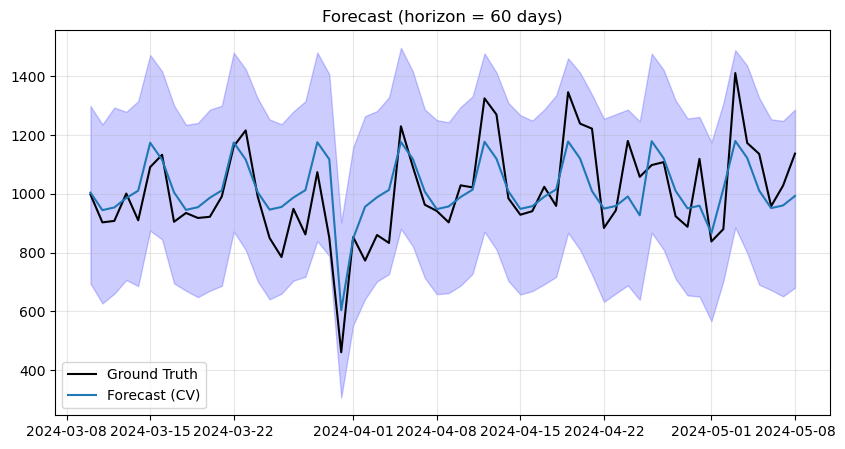


Test set metrics:
RMSE = 104.87
MAE  = 81.77


14:25:23 - cmdstanpy - INFO - Chain [1] start processing
14:25:23 - cmdstanpy - INFO - Chain [1] done processing



Model components:


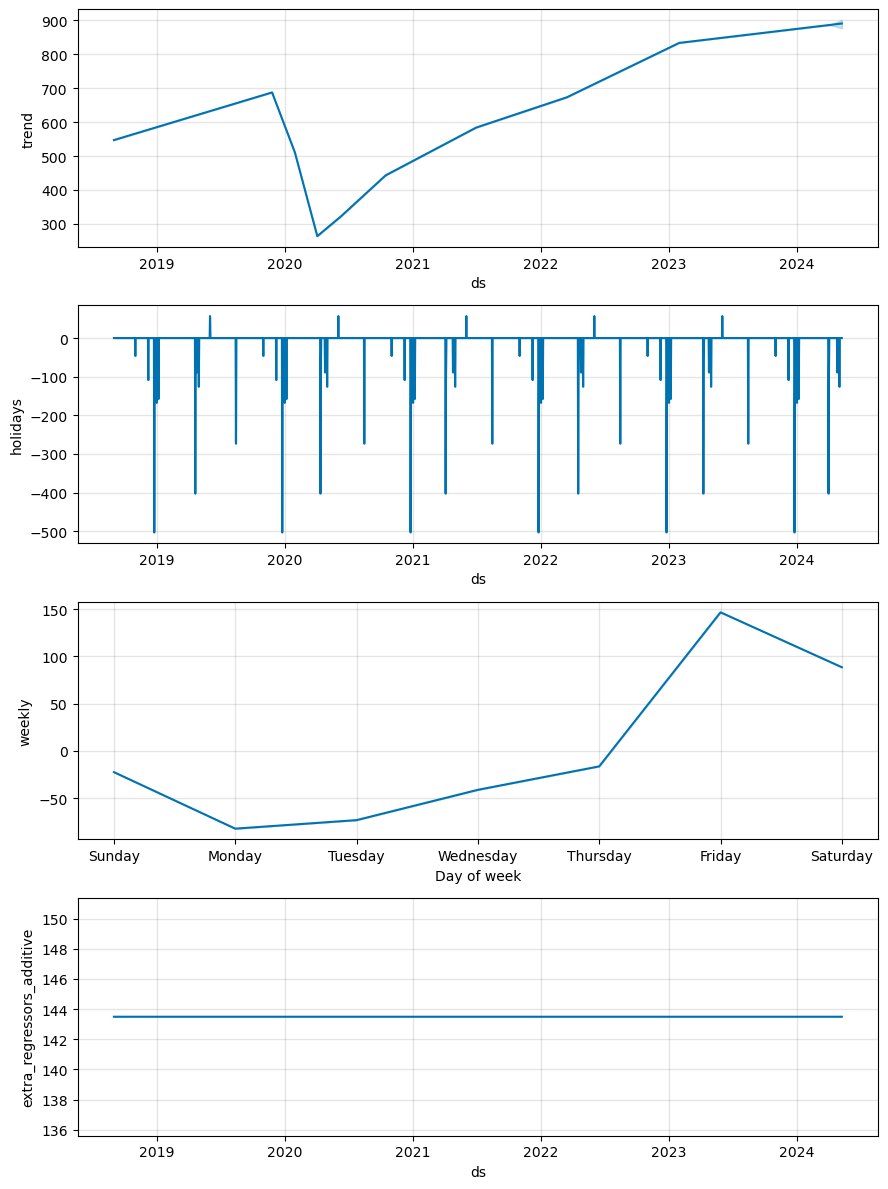

In [10]:
results = fit_prophet_model(
    df=df,
    y_col='scontrini',
    ds_col='data',
    regressors= covid_regr[1],
    n_test=60,
    weekly=True,
    monthly=False,
    yearly=False,
    weekly_prepost=False,
    holidays=True,
    verbose = True,
    return_results = True)

In [11]:
with open("models/prophet_model_scontrini_restaurant_5.json", "w") as f:
    f.write(model_to_json(results["model"]))

## GRID SEARCH ON DF6

In [13]:
df = pd.read_csv('data/restaurant_6.csv')

results = []

for (w, m, y, wp, h, covid) in param_grid:
    print(f"\n Testing with: weekly={w}, monthly={m}, yearly={y}, prepost={wp}, holidays={h}, covid={covid is not None}")
    
    
        # Fit Prophet
    res = fit_prophet_model(
            df=df,
            y_col="scontrini",
            ds_col="data",
            n_test=60,
            weekly=w,
            monthly=m,
            yearly=y,
            weekly_prepost=wp,
            holidays=h,
            regressors=covid,
            verbose=False,
            return_results=True
    )

        
    metrics_last = res["metrics_last_window"]
    cv_metrics = res["metrics_cv"]
    rmse_cv_mean = cv_metrics["rmse"].mean()
    mae_cv_mean = cv_metrics["mae"].mean()
      
    results.append({
            "weekly": w,
            "monthly": m,
            "yearly": y,
            "weekly_prepost": wp,
            "holidays": h,
            "covid_regressors": covid,
            "RMSE_last": metrics_last["RMSE"],
            "MAE_last": metrics_last["MAE"],
            "RMSE_cv_mean": rmse_cv_mean,
            "MAE_cv_mean": mae_cv_mean
    })


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=True, covid=False


14:28:18 - cmdstanpy - INFO - Chain [1] start processing
14:28:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

14:28:18 - cmdstanpy - INFO - Chain [1] start processing
14:28:18 - cmdstanpy - INFO - Chain [1] done processing
14:28:19 - cmdstanpy - INFO - Chain [1] start processing
14:28:19 - cmdstanpy - INFO - Chain [1] done processing
14:28:20 - cmdstanpy - INFO - Chain [1] start processing
14:28:20 - cmdstanpy - INFO - Chain [1] done processing
14:28:20 - cmdstanpy - INFO - Chain [1] start processing
14:28:20 - cmdstanpy - INFO - Chain [1] done processing
14:28:21 - cmdstanpy - INFO - Chain [1] start processing
14:28:21 - cmdstanpy - INFO - Chain [1] done processing
14:28:22 - cmdstanpy - INFO - Chain [1] start processing
14:28:22 - cmdstanpy - INFO - Chain [1] done processing
14:28:22 - cmdstanpy - INFO - Chain [1] start processing
14:28:23 - cmdstanpy - INFO - Chain [1] done processing
14:28:23 - cmdstanpy - INFO - Chain [1] start processing
14:28:23 - cmdstanpy - INFO - Chain [1] done processing
14:28:24 - cmdstanpy - INFO - Chain [1] start processing
14:28:24 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


14:28:30 - cmdstanpy - INFO - Chain [1] start processing
14:28:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

14:28:31 - cmdstanpy - INFO - Chain [1] start processing
14:28:31 - cmdstanpy - INFO - Chain [1] done processing
14:28:31 - cmdstanpy - INFO - Chain [1] start processing
14:28:31 - cmdstanpy - INFO - Chain [1] done processing
14:28:32 - cmdstanpy - INFO - Chain [1] start processing
14:28:32 - cmdstanpy - INFO - Chain [1] done processing
14:28:32 - cmdstanpy - INFO - Chain [1] start processing
14:28:33 - cmdstanpy - INFO - Chain [1] done processing
14:28:33 - cmdstanpy - INFO - Chain [1] start processing
14:28:33 - cmdstanpy - INFO - Chain [1] done processing
14:28:34 - cmdstanpy - INFO - Chain [1] start processing
14:28:34 - cmdstanpy - INFO - Chain [1] done processing
14:28:34 - cmdstanpy - INFO - Chain [1] start processing
14:28:35 - cmdstanpy - INFO - Chain [1] done processing
14:28:35 - cmdstanpy - INFO - Chain [1] start processing
14:28:35 - cmdstanpy - INFO - Chain [1] done processing
14:28:36 - cmdstanpy - INFO - Chain [1] start processing
14:28:36 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


14:28:42 - cmdstanpy - INFO - Chain [1] start processing
14:28:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

14:28:43 - cmdstanpy - INFO - Chain [1] start processing
14:28:43 - cmdstanpy - INFO - Chain [1] done processing
14:28:43 - cmdstanpy - INFO - Chain [1] start processing
14:28:44 - cmdstanpy - INFO - Chain [1] done processing
14:28:44 - cmdstanpy - INFO - Chain [1] start processing
14:28:44 - cmdstanpy - INFO - Chain [1] done processing
14:28:45 - cmdstanpy - INFO - Chain [1] start processing
14:28:45 - cmdstanpy - INFO - Chain [1] done processing
14:28:45 - cmdstanpy - INFO - Chain [1] start processing
14:28:46 - cmdstanpy - INFO - Chain [1] done processing
14:28:46 - cmdstanpy - INFO - Chain [1] start processing
14:28:46 - cmdstanpy - INFO - Chain [1] done processing
14:28:47 - cmdstanpy - INFO - Chain [1] start processing
14:28:47 - cmdstanpy - INFO - Chain [1] done processing
14:28:48 - cmdstanpy - INFO - Chain [1] start processing
14:28:48 - cmdstanpy - INFO - Chain [1] done processing
14:28:48 - cmdstanpy - INFO - Chain [1] start processing
14:28:49 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=False, covid=False


14:28:55 - cmdstanpy - INFO - Chain [1] start processing
14:28:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

14:28:56 - cmdstanpy - INFO - Chain [1] start processing
14:28:56 - cmdstanpy - INFO - Chain [1] done processing
14:28:56 - cmdstanpy - INFO - Chain [1] start processing
14:28:57 - cmdstanpy - INFO - Chain [1] done processing
14:28:57 - cmdstanpy - INFO - Chain [1] start processing
14:28:57 - cmdstanpy - INFO - Chain [1] done processing
14:28:57 - cmdstanpy - INFO - Chain [1] start processing
14:28:57 - cmdstanpy - INFO - Chain [1] done processing
14:28:58 - cmdstanpy - INFO - Chain [1] start processing
14:28:58 - cmdstanpy - INFO - Chain [1] done processing
14:28:58 - cmdstanpy - INFO - Chain [1] start processing
14:28:58 - cmdstanpy - INFO - Chain [1] done processing
14:28:59 - cmdstanpy - INFO - Chain [1] start processing
14:28:59 - cmdstanpy - INFO - Chain [1] done processing
14:28:59 - cmdstanpy - INFO - Chain [1] start processing
14:29:00 - cmdstanpy - INFO - Chain [1] done processing
14:29:00 - cmdstanpy - INFO - Chain [1] start processing
14:29:00 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


14:29:06 - cmdstanpy - INFO - Chain [1] start processing
14:29:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

14:29:07 - cmdstanpy - INFO - Chain [1] start processing
14:29:08 - cmdstanpy - INFO - Chain [1] done processing
14:29:08 - cmdstanpy - INFO - Chain [1] start processing
14:29:08 - cmdstanpy - INFO - Chain [1] done processing
14:29:08 - cmdstanpy - INFO - Chain [1] start processing
14:29:09 - cmdstanpy - INFO - Chain [1] done processing
14:29:09 - cmdstanpy - INFO - Chain [1] start processing
14:29:09 - cmdstanpy - INFO - Chain [1] done processing
14:29:10 - cmdstanpy - INFO - Chain [1] start processing
14:29:10 - cmdstanpy - INFO - Chain [1] done processing
14:29:10 - cmdstanpy - INFO - Chain [1] start processing
14:29:10 - cmdstanpy - INFO - Chain [1] done processing
14:29:11 - cmdstanpy - INFO - Chain [1] start processing
14:29:11 - cmdstanpy - INFO - Chain [1] done processing
14:29:11 - cmdstanpy - INFO - Chain [1] start processing
14:29:12 - cmdstanpy - INFO - Chain [1] done processing
14:29:12 - cmdstanpy - INFO - Chain [1] start processing
14:29:12 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


14:29:19 - cmdstanpy - INFO - Chain [1] start processing
14:29:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

14:29:20 - cmdstanpy - INFO - Chain [1] start processing
14:29:20 - cmdstanpy - INFO - Chain [1] done processing
14:29:21 - cmdstanpy - INFO - Chain [1] start processing
14:29:21 - cmdstanpy - INFO - Chain [1] done processing
14:29:21 - cmdstanpy - INFO - Chain [1] start processing
14:29:21 - cmdstanpy - INFO - Chain [1] done processing
14:29:22 - cmdstanpy - INFO - Chain [1] start processing
14:29:22 - cmdstanpy - INFO - Chain [1] done processing
14:29:22 - cmdstanpy - INFO - Chain [1] start processing
14:29:23 - cmdstanpy - INFO - Chain [1] done processing
14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:23 - cmdstanpy - INFO - Chain [1] done processing
14:29:24 - cmdstanpy - INFO - Chain [1] start processing
14:29:24 - cmdstanpy - INFO - Chain [1] done processing
14:29:24 - cmdstanpy - INFO - Chain [1] start processing
14:29:24 - cmdstanpy - INFO - Chain [1] done processing
14:29:25 - cmdstanpy - INFO - Chain [1] start processing
14:29:25 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=True, covid=False


14:29:31 - cmdstanpy - INFO - Chain [1] start processing
14:29:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

14:29:32 - cmdstanpy - INFO - Chain [1] start processing
14:29:32 - cmdstanpy - INFO - Chain [1] done processing
14:29:33 - cmdstanpy - INFO - Chain [1] start processing
14:29:33 - cmdstanpy - INFO - Chain [1] done processing
14:29:33 - cmdstanpy - INFO - Chain [1] start processing
14:29:33 - cmdstanpy - INFO - Chain [1] done processing
14:29:34 - cmdstanpy - INFO - Chain [1] start processing
14:29:34 - cmdstanpy - INFO - Chain [1] done processing
14:29:34 - cmdstanpy - INFO - Chain [1] start processing
14:29:35 - cmdstanpy - INFO - Chain [1] done processing
14:29:35 - cmdstanpy - INFO - Chain [1] start processing
14:29:35 - cmdstanpy - INFO - Chain [1] done processing
14:29:36 - cmdstanpy - INFO - Chain [1] start processing
14:29:36 - cmdstanpy - INFO - Chain [1] done processing
14:29:37 - cmdstanpy - INFO - Chain [1] start processing
14:29:37 - cmdstanpy - INFO - Chain [1] done processing
14:29:37 - cmdstanpy - INFO - Chain [1] start processing
14:29:38 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


14:29:48 - cmdstanpy - INFO - Chain [1] start processing
14:29:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

14:29:50 - cmdstanpy - INFO - Chain [1] start processing
14:29:51 - cmdstanpy - INFO - Chain [1] done processing
14:29:52 - cmdstanpy - INFO - Chain [1] start processing
14:29:52 - cmdstanpy - INFO - Chain [1] done processing
14:29:53 - cmdstanpy - INFO - Chain [1] start processing
14:29:54 - cmdstanpy - INFO - Chain [1] done processing
14:29:55 - cmdstanpy - INFO - Chain [1] start processing
14:29:55 - cmdstanpy - INFO - Chain [1] done processing
14:29:57 - cmdstanpy - INFO - Chain [1] start processing
14:29:58 - cmdstanpy - INFO - Chain [1] done processing
14:29:59 - cmdstanpy - INFO - Chain [1] start processing
14:30:00 - cmdstanpy - INFO - Chain [1] done processing
14:30:01 - cmdstanpy - INFO - Chain [1] start processing
14:30:02 - cmdstanpy - INFO - Chain [1] done processing
14:30:03 - cmdstanpy - INFO - Chain [1] start processing
14:30:04 - cmdstanpy - INFO - Chain [1] done processing
14:30:05 - cmdstanpy - INFO - Chain [1] start processing
14:30:06 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


14:30:25 - cmdstanpy - INFO - Chain [1] start processing
14:30:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

14:30:27 - cmdstanpy - INFO - Chain [1] start processing
14:30:27 - cmdstanpy - INFO - Chain [1] done processing
14:30:28 - cmdstanpy - INFO - Chain [1] start processing
14:30:29 - cmdstanpy - INFO - Chain [1] done processing
14:30:30 - cmdstanpy - INFO - Chain [1] start processing
14:30:31 - cmdstanpy - INFO - Chain [1] done processing
14:30:32 - cmdstanpy - INFO - Chain [1] start processing
14:30:32 - cmdstanpy - INFO - Chain [1] done processing
14:30:33 - cmdstanpy - INFO - Chain [1] start processing
14:30:34 - cmdstanpy - INFO - Chain [1] done processing
14:30:35 - cmdstanpy - INFO - Chain [1] start processing
14:30:36 - cmdstanpy - INFO - Chain [1] done processing
14:30:37 - cmdstanpy - INFO - Chain [1] start processing
14:30:37 - cmdstanpy - INFO - Chain [1] done processing
14:30:38 - cmdstanpy - INFO - Chain [1] start processing
14:30:39 - cmdstanpy - INFO - Chain [1] done processing
14:30:40 - cmdstanpy - INFO - Chain [1] start processing
14:30:41 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=False, covid=False


14:31:00 - cmdstanpy - INFO - Chain [1] start processing
14:31:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

14:31:02 - cmdstanpy - INFO - Chain [1] start processing
14:31:02 - cmdstanpy - INFO - Chain [1] done processing
14:31:03 - cmdstanpy - INFO - Chain [1] start processing
14:31:03 - cmdstanpy - INFO - Chain [1] done processing
14:31:04 - cmdstanpy - INFO - Chain [1] start processing
14:31:04 - cmdstanpy - INFO - Chain [1] done processing
14:31:05 - cmdstanpy - INFO - Chain [1] start processing
14:31:06 - cmdstanpy - INFO - Chain [1] done processing
14:31:07 - cmdstanpy - INFO - Chain [1] start processing
14:31:07 - cmdstanpy - INFO - Chain [1] done processing
14:31:08 - cmdstanpy - INFO - Chain [1] start processing
14:31:09 - cmdstanpy - INFO - Chain [1] done processing
14:31:10 - cmdstanpy - INFO - Chain [1] start processing
14:31:10 - cmdstanpy - INFO - Chain [1] done processing
14:31:11 - cmdstanpy - INFO - Chain [1] start processing
14:31:12 - cmdstanpy - INFO - Chain [1] done processing
14:31:12 - cmdstanpy - INFO - Chain [1] start processing
14:31:13 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


14:31:27 - cmdstanpy - INFO - Chain [1] start processing
14:31:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

14:31:29 - cmdstanpy - INFO - Chain [1] start processing
14:31:29 - cmdstanpy - INFO - Chain [1] done processing
14:31:30 - cmdstanpy - INFO - Chain [1] start processing
14:31:31 - cmdstanpy - INFO - Chain [1] done processing
14:31:32 - cmdstanpy - INFO - Chain [1] start processing
14:31:32 - cmdstanpy - INFO - Chain [1] done processing
14:31:33 - cmdstanpy - INFO - Chain [1] start processing
14:31:33 - cmdstanpy - INFO - Chain [1] done processing
14:31:34 - cmdstanpy - INFO - Chain [1] start processing
14:31:35 - cmdstanpy - INFO - Chain [1] done processing
14:31:36 - cmdstanpy - INFO - Chain [1] start processing
14:31:36 - cmdstanpy - INFO - Chain [1] done processing
14:31:37 - cmdstanpy - INFO - Chain [1] start processing
14:31:38 - cmdstanpy - INFO - Chain [1] done processing
14:31:39 - cmdstanpy - INFO - Chain [1] start processing
14:31:39 - cmdstanpy - INFO - Chain [1] done processing
14:31:40 - cmdstanpy - INFO - Chain [1] start processing
14:31:41 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


14:31:57 - cmdstanpy - INFO - Chain [1] start processing
14:31:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

14:31:59 - cmdstanpy - INFO - Chain [1] start processing
14:31:59 - cmdstanpy - INFO - Chain [1] done processing
14:32:00 - cmdstanpy - INFO - Chain [1] start processing
14:32:00 - cmdstanpy - INFO - Chain [1] done processing
14:32:01 - cmdstanpy - INFO - Chain [1] start processing
14:32:01 - cmdstanpy - INFO - Chain [1] done processing
14:32:02 - cmdstanpy - INFO - Chain [1] start processing
14:32:03 - cmdstanpy - INFO - Chain [1] done processing
14:32:03 - cmdstanpy - INFO - Chain [1] start processing
14:32:04 - cmdstanpy - INFO - Chain [1] done processing
14:32:05 - cmdstanpy - INFO - Chain [1] start processing
14:32:06 - cmdstanpy - INFO - Chain [1] done processing
14:32:07 - cmdstanpy - INFO - Chain [1] start processing
14:32:07 - cmdstanpy - INFO - Chain [1] done processing
14:32:08 - cmdstanpy - INFO - Chain [1] start processing
14:32:09 - cmdstanpy - INFO - Chain [1] done processing
14:32:10 - cmdstanpy - INFO - Chain [1] start processing
14:32:10 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=True, covid=False


14:32:27 - cmdstanpy - INFO - Chain [1] start processing
14:32:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

14:32:28 - cmdstanpy - INFO - Chain [1] start processing
14:32:29 - cmdstanpy - INFO - Chain [1] done processing
14:32:30 - cmdstanpy - INFO - Chain [1] start processing
14:32:30 - cmdstanpy - INFO - Chain [1] done processing
14:32:31 - cmdstanpy - INFO - Chain [1] start processing
14:32:31 - cmdstanpy - INFO - Chain [1] done processing
14:32:32 - cmdstanpy - INFO - Chain [1] start processing
14:32:33 - cmdstanpy - INFO - Chain [1] done processing
14:32:34 - cmdstanpy - INFO - Chain [1] start processing
14:32:34 - cmdstanpy - INFO - Chain [1] done processing
14:32:35 - cmdstanpy - INFO - Chain [1] start processing
14:32:36 - cmdstanpy - INFO - Chain [1] done processing
14:32:37 - cmdstanpy - INFO - Chain [1] start processing
14:32:37 - cmdstanpy - INFO - Chain [1] done processing
14:32:38 - cmdstanpy - INFO - Chain [1] start processing
14:32:39 - cmdstanpy - INFO - Chain [1] done processing
14:32:40 - cmdstanpy - INFO - Chain [1] start processing
14:32:40 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


14:32:55 - cmdstanpy - INFO - Chain [1] start processing
14:32:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

14:32:57 - cmdstanpy - INFO - Chain [1] start processing
14:32:57 - cmdstanpy - INFO - Chain [1] done processing
14:32:58 - cmdstanpy - INFO - Chain [1] start processing
14:32:59 - cmdstanpy - INFO - Chain [1] done processing
14:33:00 - cmdstanpy - INFO - Chain [1] start processing
14:33:00 - cmdstanpy - INFO - Chain [1] done processing
14:33:01 - cmdstanpy - INFO - Chain [1] start processing
14:33:02 - cmdstanpy - INFO - Chain [1] done processing
14:33:03 - cmdstanpy - INFO - Chain [1] start processing
14:33:03 - cmdstanpy - INFO - Chain [1] done processing
14:33:04 - cmdstanpy - INFO - Chain [1] start processing
14:33:04 - cmdstanpy - INFO - Chain [1] done processing
14:33:05 - cmdstanpy - INFO - Chain [1] start processing
14:33:06 - cmdstanpy - INFO - Chain [1] done processing
14:33:07 - cmdstanpy - INFO - Chain [1] start processing
14:33:08 - cmdstanpy - INFO - Chain [1] done processing
14:33:09 - cmdstanpy - INFO - Chain [1] start processing
14:33:10 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


14:33:25 - cmdstanpy - INFO - Chain [1] start processing
14:33:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

14:33:27 - cmdstanpy - INFO - Chain [1] start processing
14:33:28 - cmdstanpy - INFO - Chain [1] done processing
14:33:29 - cmdstanpy - INFO - Chain [1] start processing
14:33:29 - cmdstanpy - INFO - Chain [1] done processing
14:33:30 - cmdstanpy - INFO - Chain [1] start processing
14:33:31 - cmdstanpy - INFO - Chain [1] done processing
14:33:32 - cmdstanpy - INFO - Chain [1] start processing
14:33:33 - cmdstanpy - INFO - Chain [1] done processing
14:33:34 - cmdstanpy - INFO - Chain [1] start processing
14:33:34 - cmdstanpy - INFO - Chain [1] done processing
14:33:35 - cmdstanpy - INFO - Chain [1] start processing
14:33:35 - cmdstanpy - INFO - Chain [1] done processing
14:33:36 - cmdstanpy - INFO - Chain [1] start processing
14:33:37 - cmdstanpy - INFO - Chain [1] done processing
14:33:38 - cmdstanpy - INFO - Chain [1] start processing
14:33:38 - cmdstanpy - INFO - Chain [1] done processing
14:33:39 - cmdstanpy - INFO - Chain [1] start processing
14:33:40 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=False, covid=False


14:41:45 - cmdstanpy - INFO - Chain [1] start processing
14:41:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

14:41:46 - cmdstanpy - INFO - Chain [1] start processing
14:41:46 - cmdstanpy - INFO - Chain [1] done processing
14:41:46 - cmdstanpy - INFO - Chain [1] start processing
14:41:47 - cmdstanpy - INFO - Chain [1] done processing
14:41:47 - cmdstanpy - INFO - Chain [1] start processing
14:41:47 - cmdstanpy - INFO - Chain [1] done processing
15:17:01 - cmdstanpy - INFO - Chain [1] start processing
15:17:03 - cmdstanpy - INFO - Chain [1] done processing
15:17:03 - cmdstanpy - INFO - Chain [1] start processing
15:17:03 - cmdstanpy - INFO - Chain [1] done processing
15:17:03 - cmdstanpy - INFO - Chain [1] start processing
15:17:03 - cmdstanpy - INFO - Chain [1] done processing
15:17:04 - cmdstanpy - INFO - Chain [1] start processing
15:17:04 - cmdstanpy - INFO - Chain [1] done processing
15:17:04 - cmdstanpy - INFO - Chain [1] start processing
15:17:04 - cmdstanpy - INFO - Chain [1] done processing
15:17:04 - cmdstanpy - INFO - Chain [1] start processing
15:17:04 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


16:18:37 - cmdstanpy - INFO - Chain [1] start processing
16:18:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:18:38 - cmdstanpy - INFO - Chain [1] start processing
16:18:38 - cmdstanpy - INFO - Chain [1] done processing
16:18:39 - cmdstanpy - INFO - Chain [1] start processing
16:18:39 - cmdstanpy - INFO - Chain [1] done processing
16:18:40 - cmdstanpy - INFO - Chain [1] start processing
16:18:40 - cmdstanpy - INFO - Chain [1] done processing
16:18:40 - cmdstanpy - INFO - Chain [1] start processing
16:18:41 - cmdstanpy - INFO - Chain [1] done processing
16:18:41 - cmdstanpy - INFO - Chain [1] start processing
16:18:41 - cmdstanpy - INFO - Chain [1] done processing
16:18:41 - cmdstanpy - INFO - Chain [1] start processing
16:18:41 - cmdstanpy - INFO - Chain [1] done processing
16:18:42 - cmdstanpy - INFO - Chain [1] start processing
16:18:42 - cmdstanpy - INFO - Chain [1] done processing
16:18:42 - cmdstanpy - INFO - Chain [1] start processing
16:18:42 - cmdstanpy - INFO - Chain [1] done processing
16:18:43 - cmdstanpy - INFO - Chain [1] start processing
16:18:43 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


16:18:48 - cmdstanpy - INFO - Chain [1] start processing
16:18:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:18:48 - cmdstanpy - INFO - Chain [1] start processing
16:18:48 - cmdstanpy - INFO - Chain [1] done processing
16:18:49 - cmdstanpy - INFO - Chain [1] start processing
16:18:49 - cmdstanpy - INFO - Chain [1] done processing
16:18:49 - cmdstanpy - INFO - Chain [1] start processing
16:18:50 - cmdstanpy - INFO - Chain [1] done processing
16:18:50 - cmdstanpy - INFO - Chain [1] start processing
16:18:50 - cmdstanpy - INFO - Chain [1] done processing
16:18:50 - cmdstanpy - INFO - Chain [1] start processing
16:18:50 - cmdstanpy - INFO - Chain [1] done processing
16:18:51 - cmdstanpy - INFO - Chain [1] start processing
16:18:51 - cmdstanpy - INFO - Chain [1] done processing
16:18:52 - cmdstanpy - INFO - Chain [1] start processing
16:18:52 - cmdstanpy - INFO - Chain [1] done processing
16:18:52 - cmdstanpy - INFO - Chain [1] start processing
16:18:53 - cmdstanpy - INFO - Chain [1] done processing
16:18:53 - cmdstanpy - INFO - Chain [1] start processing
16:18:54 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=True, covid=False


16:19:01 - cmdstanpy - INFO - Chain [1] start processing
16:19:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:19:01 - cmdstanpy - INFO - Chain [1] start processing
16:19:02 - cmdstanpy - INFO - Chain [1] done processing
16:19:02 - cmdstanpy - INFO - Chain [1] start processing
16:19:02 - cmdstanpy - INFO - Chain [1] done processing
16:19:03 - cmdstanpy - INFO - Chain [1] start processing
16:19:03 - cmdstanpy - INFO - Chain [1] done processing
16:19:03 - cmdstanpy - INFO - Chain [1] start processing
16:19:03 - cmdstanpy - INFO - Chain [1] done processing
16:19:04 - cmdstanpy - INFO - Chain [1] start processing
16:19:04 - cmdstanpy - INFO - Chain [1] done processing
16:19:05 - cmdstanpy - INFO - Chain [1] start processing
16:19:05 - cmdstanpy - INFO - Chain [1] done processing
16:19:05 - cmdstanpy - INFO - Chain [1] start processing
16:19:06 - cmdstanpy - INFO - Chain [1] done processing
16:19:06 - cmdstanpy - INFO - Chain [1] start processing
16:19:06 - cmdstanpy - INFO - Chain [1] done processing
16:19:07 - cmdstanpy - INFO - Chain [1] start processing
16:19:07 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


16:19:17 - cmdstanpy - INFO - Chain [1] start processing
16:19:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:19:18 - cmdstanpy - INFO - Chain [1] start processing
16:19:18 - cmdstanpy - INFO - Chain [1] done processing
16:19:19 - cmdstanpy - INFO - Chain [1] start processing
16:19:19 - cmdstanpy - INFO - Chain [1] done processing
16:19:20 - cmdstanpy - INFO - Chain [1] start processing
16:19:20 - cmdstanpy - INFO - Chain [1] done processing
16:19:20 - cmdstanpy - INFO - Chain [1] start processing
16:19:21 - cmdstanpy - INFO - Chain [1] done processing
16:19:21 - cmdstanpy - INFO - Chain [1] start processing
16:19:21 - cmdstanpy - INFO - Chain [1] done processing
16:19:22 - cmdstanpy - INFO - Chain [1] start processing
16:19:22 - cmdstanpy - INFO - Chain [1] done processing
16:19:23 - cmdstanpy - INFO - Chain [1] start processing
16:19:23 - cmdstanpy - INFO - Chain [1] done processing
16:19:23 - cmdstanpy - INFO - Chain [1] start processing
16:19:24 - cmdstanpy - INFO - Chain [1] done processing
16:19:24 - cmdstanpy - INFO - Chain [1] start processing
16:19:25 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


16:19:32 - cmdstanpy - INFO - Chain [1] start processing
16:19:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:19:33 - cmdstanpy - INFO - Chain [1] start processing
16:19:33 - cmdstanpy - INFO - Chain [1] done processing
16:19:33 - cmdstanpy - INFO - Chain [1] start processing
16:19:33 - cmdstanpy - INFO - Chain [1] done processing
16:19:34 - cmdstanpy - INFO - Chain [1] start processing
16:19:34 - cmdstanpy - INFO - Chain [1] done processing
16:19:34 - cmdstanpy - INFO - Chain [1] start processing
16:19:35 - cmdstanpy - INFO - Chain [1] done processing
16:19:35 - cmdstanpy - INFO - Chain [1] start processing
16:19:35 - cmdstanpy - INFO - Chain [1] done processing
16:19:35 - cmdstanpy - INFO - Chain [1] start processing
16:19:36 - cmdstanpy - INFO - Chain [1] done processing
16:19:36 - cmdstanpy - INFO - Chain [1] start processing
16:19:36 - cmdstanpy - INFO - Chain [1] done processing
16:19:37 - cmdstanpy - INFO - Chain [1] start processing
16:19:37 - cmdstanpy - INFO - Chain [1] done processing
16:19:38 - cmdstanpy - INFO - Chain [1] start processing
16:19:38 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=False, covid=False


16:19:49 - cmdstanpy - INFO - Chain [1] start processing
16:19:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:19:50 - cmdstanpy - INFO - Chain [1] start processing
16:19:50 - cmdstanpy - INFO - Chain [1] done processing
16:19:50 - cmdstanpy - INFO - Chain [1] start processing
16:19:51 - cmdstanpy - INFO - Chain [1] done processing
16:19:51 - cmdstanpy - INFO - Chain [1] start processing
16:19:51 - cmdstanpy - INFO - Chain [1] done processing
16:19:52 - cmdstanpy - INFO - Chain [1] start processing
16:19:52 - cmdstanpy - INFO - Chain [1] done processing
16:19:53 - cmdstanpy - INFO - Chain [1] start processing
16:19:53 - cmdstanpy - INFO - Chain [1] done processing
16:19:53 - cmdstanpy - INFO - Chain [1] start processing
16:19:54 - cmdstanpy - INFO - Chain [1] done processing
16:19:54 - cmdstanpy - INFO - Chain [1] start processing
16:19:54 - cmdstanpy - INFO - Chain [1] done processing
16:19:54 - cmdstanpy - INFO - Chain [1] start processing
16:19:55 - cmdstanpy - INFO - Chain [1] done processing
16:19:55 - cmdstanpy - INFO - Chain [1] start processing
16:19:55 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


16:20:02 - cmdstanpy - INFO - Chain [1] start processing
16:20:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:20:03 - cmdstanpy - INFO - Chain [1] start processing
16:20:04 - cmdstanpy - INFO - Chain [1] done processing
16:20:05 - cmdstanpy - INFO - Chain [1] start processing
16:20:05 - cmdstanpy - INFO - Chain [1] done processing
16:20:06 - cmdstanpy - INFO - Chain [1] start processing
16:20:06 - cmdstanpy - INFO - Chain [1] done processing
16:20:07 - cmdstanpy - INFO - Chain [1] start processing
16:20:07 - cmdstanpy - INFO - Chain [1] done processing
16:20:08 - cmdstanpy - INFO - Chain [1] start processing
16:20:09 - cmdstanpy - INFO - Chain [1] done processing
16:20:10 - cmdstanpy - INFO - Chain [1] start processing
16:20:10 - cmdstanpy - INFO - Chain [1] done processing
16:20:11 - cmdstanpy - INFO - Chain [1] start processing
16:20:11 - cmdstanpy - INFO - Chain [1] done processing
16:20:12 - cmdstanpy - INFO - Chain [1] start processing
16:20:13 - cmdstanpy - INFO - Chain [1] done processing
16:20:14 - cmdstanpy - INFO - Chain [1] start processing
16:20:14 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


16:20:27 - cmdstanpy - INFO - Chain [1] start processing
16:20:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:20:29 - cmdstanpy - INFO - Chain [1] start processing
16:20:29 - cmdstanpy - INFO - Chain [1] done processing
16:20:30 - cmdstanpy - INFO - Chain [1] start processing
16:20:30 - cmdstanpy - INFO - Chain [1] done processing
16:20:31 - cmdstanpy - INFO - Chain [1] start processing
16:20:31 - cmdstanpy - INFO - Chain [1] done processing
16:20:32 - cmdstanpy - INFO - Chain [1] start processing
16:20:33 - cmdstanpy - INFO - Chain [1] done processing
16:20:33 - cmdstanpy - INFO - Chain [1] start processing
16:20:34 - cmdstanpy - INFO - Chain [1] done processing
16:20:35 - cmdstanpy - INFO - Chain [1] start processing
16:20:36 - cmdstanpy - INFO - Chain [1] done processing
16:20:36 - cmdstanpy - INFO - Chain [1] start processing
16:20:37 - cmdstanpy - INFO - Chain [1] done processing
16:20:38 - cmdstanpy - INFO - Chain [1] start processing
16:20:38 - cmdstanpy - INFO - Chain [1] done processing
16:20:39 - cmdstanpy - INFO - Chain [1] start processing
16:20:40 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=True, covid=False


16:20:53 - cmdstanpy - INFO - Chain [1] start processing
16:20:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:20:55 - cmdstanpy - INFO - Chain [1] start processing
16:20:56 - cmdstanpy - INFO - Chain [1] done processing
16:20:56 - cmdstanpy - INFO - Chain [1] start processing
16:20:57 - cmdstanpy - INFO - Chain [1] done processing
16:20:58 - cmdstanpy - INFO - Chain [1] start processing
16:20:58 - cmdstanpy - INFO - Chain [1] done processing
16:20:59 - cmdstanpy - INFO - Chain [1] start processing
16:21:00 - cmdstanpy - INFO - Chain [1] done processing
16:21:01 - cmdstanpy - INFO - Chain [1] start processing
16:21:01 - cmdstanpy - INFO - Chain [1] done processing
16:21:02 - cmdstanpy - INFO - Chain [1] start processing
16:21:03 - cmdstanpy - INFO - Chain [1] done processing
16:21:04 - cmdstanpy - INFO - Chain [1] start processing
16:21:05 - cmdstanpy - INFO - Chain [1] done processing
16:21:07 - cmdstanpy - INFO - Chain [1] start processing
16:21:08 - cmdstanpy - INFO - Chain [1] done processing
16:21:09 - cmdstanpy - INFO - Chain [1] start processing
16:21:11 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


16:21:32 - cmdstanpy - INFO - Chain [1] start processing
16:21:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:21:33 - cmdstanpy - INFO - Chain [1] start processing
16:21:34 - cmdstanpy - INFO - Chain [1] done processing
16:21:34 - cmdstanpy - INFO - Chain [1] start processing
16:21:34 - cmdstanpy - INFO - Chain [1] done processing
16:21:35 - cmdstanpy - INFO - Chain [1] start processing
16:21:35 - cmdstanpy - INFO - Chain [1] done processing
16:21:35 - cmdstanpy - INFO - Chain [1] start processing
16:21:36 - cmdstanpy - INFO - Chain [1] done processing
16:21:36 - cmdstanpy - INFO - Chain [1] start processing
16:21:36 - cmdstanpy - INFO - Chain [1] done processing
16:21:37 - cmdstanpy - INFO - Chain [1] start processing
16:21:37 - cmdstanpy - INFO - Chain [1] done processing
16:21:38 - cmdstanpy - INFO - Chain [1] start processing
16:21:38 - cmdstanpy - INFO - Chain [1] done processing
16:21:38 - cmdstanpy - INFO - Chain [1] start processing
16:21:39 - cmdstanpy - INFO - Chain [1] done processing
16:21:39 - cmdstanpy - INFO - Chain [1] start processing
16:21:40 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


16:21:47 - cmdstanpy - INFO - Chain [1] start processing
16:21:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:21:48 - cmdstanpy - INFO - Chain [1] start processing
16:21:48 - cmdstanpy - INFO - Chain [1] done processing
16:21:48 - cmdstanpy - INFO - Chain [1] start processing
16:21:49 - cmdstanpy - INFO - Chain [1] done processing
16:21:49 - cmdstanpy - INFO - Chain [1] start processing
16:21:49 - cmdstanpy - INFO - Chain [1] done processing
16:21:50 - cmdstanpy - INFO - Chain [1] start processing
16:21:50 - cmdstanpy - INFO - Chain [1] done processing
16:21:50 - cmdstanpy - INFO - Chain [1] start processing
16:21:50 - cmdstanpy - INFO - Chain [1] done processing
16:21:51 - cmdstanpy - INFO - Chain [1] start processing
16:21:51 - cmdstanpy - INFO - Chain [1] done processing
16:21:52 - cmdstanpy - INFO - Chain [1] start processing
16:21:52 - cmdstanpy - INFO - Chain [1] done processing
16:21:52 - cmdstanpy - INFO - Chain [1] start processing
16:21:52 - cmdstanpy - INFO - Chain [1] done processing
16:21:53 - cmdstanpy - INFO - Chain [1] start processing
16:21:53 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=False, covid=False


16:22:00 - cmdstanpy - INFO - Chain [1] start processing
16:22:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:22:01 - cmdstanpy - INFO - Chain [1] start processing
16:22:01 - cmdstanpy - INFO - Chain [1] done processing
16:22:01 - cmdstanpy - INFO - Chain [1] start processing
16:22:02 - cmdstanpy - INFO - Chain [1] done processing
16:22:02 - cmdstanpy - INFO - Chain [1] start processing
16:22:02 - cmdstanpy - INFO - Chain [1] done processing
16:22:02 - cmdstanpy - INFO - Chain [1] start processing
16:22:03 - cmdstanpy - INFO - Chain [1] done processing
16:22:03 - cmdstanpy - INFO - Chain [1] start processing
16:22:03 - cmdstanpy - INFO - Chain [1] done processing
16:22:03 - cmdstanpy - INFO - Chain [1] start processing
16:22:04 - cmdstanpy - INFO - Chain [1] done processing
16:22:04 - cmdstanpy - INFO - Chain [1] start processing
16:22:04 - cmdstanpy - INFO - Chain [1] done processing
16:22:05 - cmdstanpy - INFO - Chain [1] start processing
16:22:05 - cmdstanpy - INFO - Chain [1] done processing
16:22:05 - cmdstanpy - INFO - Chain [1] start processing
16:22:05 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


16:22:11 - cmdstanpy - INFO - Chain [1] start processing
16:22:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:22:11 - cmdstanpy - INFO - Chain [1] start processing
16:22:12 - cmdstanpy - INFO - Chain [1] done processing
16:22:12 - cmdstanpy - INFO - Chain [1] start processing
16:22:12 - cmdstanpy - INFO - Chain [1] done processing
16:22:12 - cmdstanpy - INFO - Chain [1] start processing
16:22:13 - cmdstanpy - INFO - Chain [1] done processing
16:22:13 - cmdstanpy - INFO - Chain [1] start processing
16:22:13 - cmdstanpy - INFO - Chain [1] done processing
16:22:14 - cmdstanpy - INFO - Chain [1] start processing
16:22:14 - cmdstanpy - INFO - Chain [1] done processing
16:22:14 - cmdstanpy - INFO - Chain [1] start processing
16:22:15 - cmdstanpy - INFO - Chain [1] done processing
16:22:15 - cmdstanpy - INFO - Chain [1] start processing
16:22:15 - cmdstanpy - INFO - Chain [1] done processing
16:22:16 - cmdstanpy - INFO - Chain [1] start processing
16:22:16 - cmdstanpy - INFO - Chain [1] done processing
16:22:16 - cmdstanpy - INFO - Chain [1] start processing
16:22:16 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


16:22:23 - cmdstanpy - INFO - Chain [1] start processing
16:22:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:22:23 - cmdstanpy - INFO - Chain [1] start processing
16:22:23 - cmdstanpy - INFO - Chain [1] done processing
16:22:24 - cmdstanpy - INFO - Chain [1] start processing
16:22:24 - cmdstanpy - INFO - Chain [1] done processing
16:22:24 - cmdstanpy - INFO - Chain [1] start processing
16:22:24 - cmdstanpy - INFO - Chain [1] done processing
16:22:25 - cmdstanpy - INFO - Chain [1] start processing
16:22:25 - cmdstanpy - INFO - Chain [1] done processing
16:22:25 - cmdstanpy - INFO - Chain [1] start processing
16:22:26 - cmdstanpy - INFO - Chain [1] done processing
16:22:26 - cmdstanpy - INFO - Chain [1] start processing
16:22:26 - cmdstanpy - INFO - Chain [1] done processing
16:22:27 - cmdstanpy - INFO - Chain [1] start processing
16:22:27 - cmdstanpy - INFO - Chain [1] done processing
16:22:27 - cmdstanpy - INFO - Chain [1] start processing
16:22:27 - cmdstanpy - INFO - Chain [1] done processing
16:22:28 - cmdstanpy - INFO - Chain [1] start processing
16:22:28 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=True, covid=False


16:22:34 - cmdstanpy - INFO - Chain [1] start processing
16:22:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:22:35 - cmdstanpy - INFO - Chain [1] start processing
16:22:35 - cmdstanpy - INFO - Chain [1] done processing
16:22:36 - cmdstanpy - INFO - Chain [1] start processing
16:22:36 - cmdstanpy - INFO - Chain [1] done processing
16:22:36 - cmdstanpy - INFO - Chain [1] start processing
16:22:36 - cmdstanpy - INFO - Chain [1] done processing
16:22:37 - cmdstanpy - INFO - Chain [1] start processing
16:22:37 - cmdstanpy - INFO - Chain [1] done processing
16:22:37 - cmdstanpy - INFO - Chain [1] start processing
16:22:37 - cmdstanpy - INFO - Chain [1] done processing
16:22:38 - cmdstanpy - INFO - Chain [1] start processing
16:22:38 - cmdstanpy - INFO - Chain [1] done processing
16:22:38 - cmdstanpy - INFO - Chain [1] start processing
16:22:39 - cmdstanpy - INFO - Chain [1] done processing
16:22:39 - cmdstanpy - INFO - Chain [1] start processing
16:22:39 - cmdstanpy - INFO - Chain [1] done processing
16:22:40 - cmdstanpy - INFO - Chain [1] start processing
16:22:40 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


16:22:46 - cmdstanpy - INFO - Chain [1] start processing
16:22:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:22:47 - cmdstanpy - INFO - Chain [1] start processing
16:22:47 - cmdstanpy - INFO - Chain [1] done processing
16:22:47 - cmdstanpy - INFO - Chain [1] start processing
16:22:48 - cmdstanpy - INFO - Chain [1] done processing
16:22:48 - cmdstanpy - INFO - Chain [1] start processing
16:22:48 - cmdstanpy - INFO - Chain [1] done processing
16:22:48 - cmdstanpy - INFO - Chain [1] start processing
16:22:49 - cmdstanpy - INFO - Chain [1] done processing
16:22:49 - cmdstanpy - INFO - Chain [1] start processing
16:22:50 - cmdstanpy - INFO - Chain [1] done processing
16:22:50 - cmdstanpy - INFO - Chain [1] start processing
16:22:50 - cmdstanpy - INFO - Chain [1] done processing
16:22:51 - cmdstanpy - INFO - Chain [1] start processing
16:22:51 - cmdstanpy - INFO - Chain [1] done processing
16:22:51 - cmdstanpy - INFO - Chain [1] start processing
16:22:52 - cmdstanpy - INFO - Chain [1] done processing
16:22:52 - cmdstanpy - INFO - Chain [1] start processing
16:22:52 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


16:22:59 - cmdstanpy - INFO - Chain [1] start processing
16:23:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:23:00 - cmdstanpy - INFO - Chain [1] start processing
16:23:00 - cmdstanpy - INFO - Chain [1] done processing
16:23:01 - cmdstanpy - INFO - Chain [1] start processing
16:23:01 - cmdstanpy - INFO - Chain [1] done processing
16:23:01 - cmdstanpy - INFO - Chain [1] start processing
16:23:01 - cmdstanpy - INFO - Chain [1] done processing
16:23:02 - cmdstanpy - INFO - Chain [1] start processing
16:23:02 - cmdstanpy - INFO - Chain [1] done processing
16:23:02 - cmdstanpy - INFO - Chain [1] start processing
16:23:02 - cmdstanpy - INFO - Chain [1] done processing
16:23:03 - cmdstanpy - INFO - Chain [1] start processing
16:23:03 - cmdstanpy - INFO - Chain [1] done processing
16:23:03 - cmdstanpy - INFO - Chain [1] start processing
16:23:04 - cmdstanpy - INFO - Chain [1] done processing
16:23:04 - cmdstanpy - INFO - Chain [1] start processing
16:23:04 - cmdstanpy - INFO - Chain [1] done processing
16:23:05 - cmdstanpy - INFO - Chain [1] start processing
16:23:05 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=False, covid=False


16:23:11 - cmdstanpy - INFO - Chain [1] start processing
16:23:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:23:12 - cmdstanpy - INFO - Chain [1] start processing
16:23:12 - cmdstanpy - INFO - Chain [1] done processing
16:23:13 - cmdstanpy - INFO - Chain [1] start processing
16:23:13 - cmdstanpy - INFO - Chain [1] done processing
16:23:13 - cmdstanpy - INFO - Chain [1] start processing
16:23:13 - cmdstanpy - INFO - Chain [1] done processing
16:23:13 - cmdstanpy - INFO - Chain [1] start processing
16:23:14 - cmdstanpy - INFO - Chain [1] done processing
16:23:14 - cmdstanpy - INFO - Chain [1] start processing
16:23:14 - cmdstanpy - INFO - Chain [1] done processing
16:23:15 - cmdstanpy - INFO - Chain [1] start processing
16:23:15 - cmdstanpy - INFO - Chain [1] done processing
16:23:15 - cmdstanpy - INFO - Chain [1] start processing
16:23:15 - cmdstanpy - INFO - Chain [1] done processing
16:23:16 - cmdstanpy - INFO - Chain [1] start processing
16:23:16 - cmdstanpy - INFO - Chain [1] done processing
16:23:16 - cmdstanpy - INFO - Chain [1] start processing
16:23:16 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


16:23:22 - cmdstanpy - INFO - Chain [1] start processing
16:23:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:23:23 - cmdstanpy - INFO - Chain [1] start processing
16:23:23 - cmdstanpy - INFO - Chain [1] done processing
16:23:23 - cmdstanpy - INFO - Chain [1] start processing
16:23:23 - cmdstanpy - INFO - Chain [1] done processing
16:23:24 - cmdstanpy - INFO - Chain [1] start processing
16:23:24 - cmdstanpy - INFO - Chain [1] done processing
16:23:24 - cmdstanpy - INFO - Chain [1] start processing
16:23:24 - cmdstanpy - INFO - Chain [1] done processing
16:23:25 - cmdstanpy - INFO - Chain [1] start processing
16:23:25 - cmdstanpy - INFO - Chain [1] done processing
16:23:25 - cmdstanpy - INFO - Chain [1] start processing
16:23:26 - cmdstanpy - INFO - Chain [1] done processing
16:23:26 - cmdstanpy - INFO - Chain [1] start processing
16:23:26 - cmdstanpy - INFO - Chain [1] done processing
16:23:26 - cmdstanpy - INFO - Chain [1] start processing
16:23:27 - cmdstanpy - INFO - Chain [1] done processing
16:23:27 - cmdstanpy - INFO - Chain [1] start processing
16:23:27 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


16:23:34 - cmdstanpy - INFO - Chain [1] start processing
16:23:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:23:34 - cmdstanpy - INFO - Chain [1] start processing
16:23:34 - cmdstanpy - INFO - Chain [1] done processing
16:23:35 - cmdstanpy - INFO - Chain [1] start processing
16:23:35 - cmdstanpy - INFO - Chain [1] done processing
16:23:35 - cmdstanpy - INFO - Chain [1] start processing
16:23:35 - cmdstanpy - INFO - Chain [1] done processing
16:23:36 - cmdstanpy - INFO - Chain [1] start processing
16:23:36 - cmdstanpy - INFO - Chain [1] done processing
16:23:36 - cmdstanpy - INFO - Chain [1] start processing
16:23:36 - cmdstanpy - INFO - Chain [1] done processing
16:23:37 - cmdstanpy - INFO - Chain [1] start processing
16:23:37 - cmdstanpy - INFO - Chain [1] done processing
16:23:37 - cmdstanpy - INFO - Chain [1] start processing
16:23:38 - cmdstanpy - INFO - Chain [1] done processing
16:23:38 - cmdstanpy - INFO - Chain [1] start processing
16:23:38 - cmdstanpy - INFO - Chain [1] done processing
16:23:38 - cmdstanpy - INFO - Chain [1] start processing
16:23:39 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=True, covid=False


16:23:44 - cmdstanpy - INFO - Chain [1] start processing
16:23:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:23:45 - cmdstanpy - INFO - Chain [1] start processing
16:23:45 - cmdstanpy - INFO - Chain [1] done processing
16:23:45 - cmdstanpy - INFO - Chain [1] start processing
16:23:46 - cmdstanpy - INFO - Chain [1] done processing
16:23:46 - cmdstanpy - INFO - Chain [1] start processing
16:23:46 - cmdstanpy - INFO - Chain [1] done processing
16:23:46 - cmdstanpy - INFO - Chain [1] start processing
16:23:47 - cmdstanpy - INFO - Chain [1] done processing
16:23:47 - cmdstanpy - INFO - Chain [1] start processing
16:23:47 - cmdstanpy - INFO - Chain [1] done processing
16:23:47 - cmdstanpy - INFO - Chain [1] start processing
16:23:48 - cmdstanpy - INFO - Chain [1] done processing
16:23:48 - cmdstanpy - INFO - Chain [1] start processing
16:23:48 - cmdstanpy - INFO - Chain [1] done processing
16:23:49 - cmdstanpy - INFO - Chain [1] start processing
16:23:49 - cmdstanpy - INFO - Chain [1] done processing
16:23:49 - cmdstanpy - INFO - Chain [1] start processing
16:23:49 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


16:23:55 - cmdstanpy - INFO - Chain [1] start processing
16:23:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:23:56 - cmdstanpy - INFO - Chain [1] start processing
16:23:56 - cmdstanpy - INFO - Chain [1] done processing
16:23:56 - cmdstanpy - INFO - Chain [1] start processing
16:23:57 - cmdstanpy - INFO - Chain [1] done processing
16:23:57 - cmdstanpy - INFO - Chain [1] start processing
16:23:57 - cmdstanpy - INFO - Chain [1] done processing
16:23:57 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] done processing
16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] done processing
16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:59 - cmdstanpy - INFO - Chain [1] done processing
16:23:59 - cmdstanpy - INFO - Chain [1] start processing
16:23:59 - cmdstanpy - INFO - Chain [1] done processing
16:23:59 - cmdstanpy - INFO - Chain [1] start processing
16:24:00 - cmdstanpy - INFO - Chain [1] done processing
16:24:00 - cmdstanpy - INFO - Chain [1] start processing
16:24:00 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


16:24:06 - cmdstanpy - INFO - Chain [1] start processing
16:24:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:24:07 - cmdstanpy - INFO - Chain [1] start processing
16:24:07 - cmdstanpy - INFO - Chain [1] done processing
16:24:07 - cmdstanpy - INFO - Chain [1] start processing
16:24:07 - cmdstanpy - INFO - Chain [1] done processing
16:24:08 - cmdstanpy - INFO - Chain [1] start processing
16:24:08 - cmdstanpy - INFO - Chain [1] done processing
16:24:08 - cmdstanpy - INFO - Chain [1] start processing
16:24:09 - cmdstanpy - INFO - Chain [1] done processing
16:24:09 - cmdstanpy - INFO - Chain [1] start processing
16:24:09 - cmdstanpy - INFO - Chain [1] done processing
16:24:09 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] done processing
16:24:10 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] done processing
16:24:11 - cmdstanpy - INFO - Chain [1] start processing
16:24:11 - cmdstanpy - INFO - Chain [1] done processing
16:24:11 - cmdstanpy - INFO - Chain [1] start processing
16:24:12 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=False, covid=False


16:24:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:24:18 - cmdstanpy - INFO - Chain [1] start processing
16:24:18 - cmdstanpy - INFO - Chain [1] done processing
16:24:18 - cmdstanpy - INFO - Chain [1] start processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] start processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] start processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing
16:24:21 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing
16:24:21 - cmdstanpy - INFO - Chain [1] done processing
16:24:22 - cmdstanpy - INFO - Chain [1] start processing
16:24:22 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


16:24:27 - cmdstanpy - INFO - Chain [1] start processing
16:24:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:24:27 - cmdstanpy - INFO - Chain [1] start processing
16:24:27 - cmdstanpy - INFO - Chain [1] done processing
16:24:28 - cmdstanpy - INFO - Chain [1] start processing
16:24:28 - cmdstanpy - INFO - Chain [1] done processing
16:24:28 - cmdstanpy - INFO - Chain [1] start processing
16:24:28 - cmdstanpy - INFO - Chain [1] done processing
16:24:29 - cmdstanpy - INFO - Chain [1] start processing
16:24:29 - cmdstanpy - INFO - Chain [1] done processing
16:24:29 - cmdstanpy - INFO - Chain [1] start processing
16:24:30 - cmdstanpy - INFO - Chain [1] done processing
16:24:30 - cmdstanpy - INFO - Chain [1] start processing
16:24:30 - cmdstanpy - INFO - Chain [1] done processing
16:24:30 - cmdstanpy - INFO - Chain [1] start processing
16:24:31 - cmdstanpy - INFO - Chain [1] done processing
16:24:31 - cmdstanpy - INFO - Chain [1] start processing
16:24:32 - cmdstanpy - INFO - Chain [1] done processing
16:24:32 - cmdstanpy - INFO - Chain [1] start processing
16:24:32 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


16:24:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:24:37 - cmdstanpy - INFO - Chain [1] start processing
16:24:37 - cmdstanpy - INFO - Chain [1] done processing
16:24:38 - cmdstanpy - INFO - Chain [1] start processing
16:24:38 - cmdstanpy - INFO - Chain [1] done processing
16:24:38 - cmdstanpy - INFO - Chain [1] start processing
16:24:38 - cmdstanpy - INFO - Chain [1] done processing
16:24:38 - cmdstanpy - INFO - Chain [1] start processing
16:24:39 - cmdstanpy - INFO - Chain [1] done processing
16:24:39 - cmdstanpy - INFO - Chain [1] start processing
16:24:39 - cmdstanpy - INFO - Chain [1] done processing
16:24:39 - cmdstanpy - INFO - Chain [1] start processing
16:24:40 - cmdstanpy - INFO - Chain [1] done processing
16:24:40 - cmdstanpy - INFO - Chain [1] start processing
16:24:40 - cmdstanpy - INFO - Chain [1] done processing
16:24:40 - cmdstanpy - INFO - Chain [1] start processing
16:24:41 - cmdstanpy - INFO - Chain [1] done processing
16:24:41 - cmdstanpy - INFO - Chain [1] start processing
16:24:41 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=True, covid=False


16:24:46 - cmdstanpy - INFO - Chain [1] start processing
16:24:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:24:47 - cmdstanpy - INFO - Chain [1] start processing
16:24:47 - cmdstanpy - INFO - Chain [1] done processing
16:24:47 - cmdstanpy - INFO - Chain [1] start processing
16:24:48 - cmdstanpy - INFO - Chain [1] done processing
16:24:48 - cmdstanpy - INFO - Chain [1] start processing
16:24:48 - cmdstanpy - INFO - Chain [1] done processing
16:24:48 - cmdstanpy - INFO - Chain [1] start processing
16:24:49 - cmdstanpy - INFO - Chain [1] done processing
16:24:49 - cmdstanpy - INFO - Chain [1] start processing
16:24:49 - cmdstanpy - INFO - Chain [1] done processing
16:24:49 - cmdstanpy - INFO - Chain [1] start processing
16:24:50 - cmdstanpy - INFO - Chain [1] done processing
16:24:50 - cmdstanpy - INFO - Chain [1] start processing
16:24:50 - cmdstanpy - INFO - Chain [1] done processing
16:24:51 - cmdstanpy - INFO - Chain [1] start processing
16:24:51 - cmdstanpy - INFO - Chain [1] done processing
16:24:51 - cmdstanpy - INFO - Chain [1] start processing
16:24:51 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


16:24:57 - cmdstanpy - INFO - Chain [1] start processing
16:24:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:24:57 - cmdstanpy - INFO - Chain [1] start processing
16:24:57 - cmdstanpy - INFO - Chain [1] done processing
16:24:58 - cmdstanpy - INFO - Chain [1] start processing
16:24:58 - cmdstanpy - INFO - Chain [1] done processing
16:24:58 - cmdstanpy - INFO - Chain [1] start processing
16:24:58 - cmdstanpy - INFO - Chain [1] done processing
16:24:59 - cmdstanpy - INFO - Chain [1] start processing
16:24:59 - cmdstanpy - INFO - Chain [1] done processing
16:24:59 - cmdstanpy - INFO - Chain [1] start processing
16:25:00 - cmdstanpy - INFO - Chain [1] done processing
16:25:00 - cmdstanpy - INFO - Chain [1] start processing
16:25:00 - cmdstanpy - INFO - Chain [1] done processing
16:25:00 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing
16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing
16:25:02 - cmdstanpy - INFO - Chain [1] start processing
16:25:02 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


16:25:07 - cmdstanpy - INFO - Chain [1] start processing
16:25:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:25:08 - cmdstanpy - INFO - Chain [1] start processing
16:25:08 - cmdstanpy - INFO - Chain [1] done processing
16:25:08 - cmdstanpy - INFO - Chain [1] start processing
16:25:08 - cmdstanpy - INFO - Chain [1] done processing
16:25:09 - cmdstanpy - INFO - Chain [1] start processing
16:25:09 - cmdstanpy - INFO - Chain [1] done processing
16:25:09 - cmdstanpy - INFO - Chain [1] start processing
16:25:09 - cmdstanpy - INFO - Chain [1] done processing
16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:10 - cmdstanpy - INFO - Chain [1] done processing
16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:10 - cmdstanpy - INFO - Chain [1] done processing
16:25:11 - cmdstanpy - INFO - Chain [1] start processing
16:25:11 - cmdstanpy - INFO - Chain [1] done processing
16:25:11 - cmdstanpy - INFO - Chain [1] start processing
16:25:11 - cmdstanpy - INFO - Chain [1] done processing
16:25:12 - cmdstanpy - INFO - Chain [1] start processing
16:25:12 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=False, covid=False


16:25:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:25:18 - cmdstanpy - INFO - Chain [1] start processing
16:25:18 - cmdstanpy - INFO - Chain [1] done processing
16:25:19 - cmdstanpy - INFO - Chain [1] start processing
16:25:19 - cmdstanpy - INFO - Chain [1] done processing
16:25:19 - cmdstanpy - INFO - Chain [1] start processing
16:25:19 - cmdstanpy - INFO - Chain [1] done processing
16:25:19 - cmdstanpy - INFO - Chain [1] start processing
16:25:20 - cmdstanpy - INFO - Chain [1] done processing
16:25:20 - cmdstanpy - INFO - Chain [1] start processing
16:25:20 - cmdstanpy - INFO - Chain [1] done processing
16:25:20 - cmdstanpy - INFO - Chain [1] start processing
16:25:20 - cmdstanpy - INFO - Chain [1] done processing
16:25:21 - cmdstanpy - INFO - Chain [1] start processing
16:25:21 - cmdstanpy - INFO - Chain [1] done processing
16:25:21 - cmdstanpy - INFO - Chain [1] start processing
16:25:21 - cmdstanpy - INFO - Chain [1] done processing
16:25:21 - cmdstanpy - INFO - Chain [1] start processing
16:25:22 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


16:25:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:25:27 - cmdstanpy - INFO - Chain [1] start processing
16:25:27 - cmdstanpy - INFO - Chain [1] done processing
16:25:27 - cmdstanpy - INFO - Chain [1] start processing
16:25:27 - cmdstanpy - INFO - Chain [1] done processing
16:25:28 - cmdstanpy - INFO - Chain [1] start processing
16:25:28 - cmdstanpy - INFO - Chain [1] done processing
16:25:28 - cmdstanpy - INFO - Chain [1] start processing
16:25:28 - cmdstanpy - INFO - Chain [1] done processing
16:25:29 - cmdstanpy - INFO - Chain [1] start processing
16:25:29 - cmdstanpy - INFO - Chain [1] done processing
16:25:29 - cmdstanpy - INFO - Chain [1] start processing
16:25:29 - cmdstanpy - INFO - Chain [1] done processing
16:25:30 - cmdstanpy - INFO - Chain [1] start processing
16:25:30 - cmdstanpy - INFO - Chain [1] done processing
16:25:30 - cmdstanpy - INFO - Chain [1] start processing
16:25:31 - cmdstanpy - INFO - Chain [1] done processing
16:25:31 - cmdstanpy - INFO - Chain [1] start processing
16:25:31 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=True, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


16:25:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:25:37 - cmdstanpy - INFO - Chain [1] start processing
16:25:37 - cmdstanpy - INFO - Chain [1] done processing
16:25:37 - cmdstanpy - INFO - Chain [1] start processing
16:25:37 - cmdstanpy - INFO - Chain [1] done processing
16:25:38 - cmdstanpy - INFO - Chain [1] start processing
16:25:38 - cmdstanpy - INFO - Chain [1] done processing
16:25:38 - cmdstanpy - INFO - Chain [1] start processing
16:25:38 - cmdstanpy - INFO - Chain [1] done processing
16:25:39 - cmdstanpy - INFO - Chain [1] start processing
16:25:39 - cmdstanpy - INFO - Chain [1] done processing
16:25:39 - cmdstanpy - INFO - Chain [1] start processing
16:25:39 - cmdstanpy - INFO - Chain [1] done processing
16:25:39 - cmdstanpy - INFO - Chain [1] start processing
16:25:40 - cmdstanpy - INFO - Chain [1] done processing
16:25:40 - cmdstanpy - INFO - Chain [1] start processing
16:25:40 - cmdstanpy - INFO - Chain [1] done processing
16:25:40 - cmdstanpy - INFO - Chain [1] start processing
16:25:41 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=True, covid=False


16:25:45 - cmdstanpy - INFO - Chain [1] start processing
16:25:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:25:46 - cmdstanpy - INFO - Chain [1] start processing
16:25:46 - cmdstanpy - INFO - Chain [1] done processing
16:25:47 - cmdstanpy - INFO - Chain [1] start processing
16:25:47 - cmdstanpy - INFO - Chain [1] done processing
16:25:47 - cmdstanpy - INFO - Chain [1] start processing
16:25:47 - cmdstanpy - INFO - Chain [1] done processing
16:25:48 - cmdstanpy - INFO - Chain [1] start processing
16:25:48 - cmdstanpy - INFO - Chain [1] done processing
16:25:49 - cmdstanpy - INFO - Chain [1] start processing
16:25:49 - cmdstanpy - INFO - Chain [1] done processing
16:25:49 - cmdstanpy - INFO - Chain [1] start processing
16:25:50 - cmdstanpy - INFO - Chain [1] done processing
16:25:50 - cmdstanpy - INFO - Chain [1] start processing
16:25:50 - cmdstanpy - INFO - Chain [1] done processing
16:25:51 - cmdstanpy - INFO - Chain [1] start processing
16:25:51 - cmdstanpy - INFO - Chain [1] done processing
16:25:51 - cmdstanpy - INFO - Chain [1] start processing
16:25:52 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


16:25:58 - cmdstanpy - INFO - Chain [1] start processing
16:25:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:25:59 - cmdstanpy - INFO - Chain [1] start processing
16:25:59 - cmdstanpy - INFO - Chain [1] done processing
16:26:00 - cmdstanpy - INFO - Chain [1] start processing
16:26:00 - cmdstanpy - INFO - Chain [1] done processing
16:26:00 - cmdstanpy - INFO - Chain [1] start processing
16:26:00 - cmdstanpy - INFO - Chain [1] done processing
16:26:01 - cmdstanpy - INFO - Chain [1] start processing
16:26:01 - cmdstanpy - INFO - Chain [1] done processing
16:26:01 - cmdstanpy - INFO - Chain [1] start processing
16:26:02 - cmdstanpy - INFO - Chain [1] done processing
16:26:02 - cmdstanpy - INFO - Chain [1] start processing
16:26:03 - cmdstanpy - INFO - Chain [1] done processing
16:26:03 - cmdstanpy - INFO - Chain [1] start processing
16:26:03 - cmdstanpy - INFO - Chain [1] done processing
16:26:04 - cmdstanpy - INFO - Chain [1] start processing
16:26:04 - cmdstanpy - INFO - Chain [1] done processing
16:26:05 - cmdstanpy - INFO - Chain [1] start processing
16:26:05 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=True, covid=True


16:26:12 - cmdstanpy - INFO - Chain [1] start processing
16:26:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:26:13 - cmdstanpy - INFO - Chain [1] start processing
16:26:13 - cmdstanpy - INFO - Chain [1] done processing
16:26:13 - cmdstanpy - INFO - Chain [1] start processing
16:26:13 - cmdstanpy - INFO - Chain [1] done processing
16:26:14 - cmdstanpy - INFO - Chain [1] start processing
16:26:14 - cmdstanpy - INFO - Chain [1] done processing
16:26:15 - cmdstanpy - INFO - Chain [1] start processing
16:26:15 - cmdstanpy - INFO - Chain [1] done processing
16:26:15 - cmdstanpy - INFO - Chain [1] start processing
16:26:15 - cmdstanpy - INFO - Chain [1] done processing
16:26:16 - cmdstanpy - INFO - Chain [1] start processing
16:26:16 - cmdstanpy - INFO - Chain [1] done processing
16:26:17 - cmdstanpy - INFO - Chain [1] start processing
16:26:17 - cmdstanpy - INFO - Chain [1] done processing
16:26:17 - cmdstanpy - INFO - Chain [1] start processing
16:26:18 - cmdstanpy - INFO - Chain [1] done processing
16:26:18 - cmdstanpy - INFO - Chain [1] start processing
16:26:18 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=False, covid=False


16:26:26 - cmdstanpy - INFO - Chain [1] start processing
16:26:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:26:26 - cmdstanpy - INFO - Chain [1] start processing
16:26:26 - cmdstanpy - INFO - Chain [1] done processing
16:26:27 - cmdstanpy - INFO - Chain [1] start processing
16:26:27 - cmdstanpy - INFO - Chain [1] done processing
16:26:27 - cmdstanpy - INFO - Chain [1] start processing
16:26:27 - cmdstanpy - INFO - Chain [1] done processing
16:26:28 - cmdstanpy - INFO - Chain [1] start processing
16:26:28 - cmdstanpy - INFO - Chain [1] done processing
16:26:28 - cmdstanpy - INFO - Chain [1] start processing
16:26:29 - cmdstanpy - INFO - Chain [1] done processing
16:26:29 - cmdstanpy - INFO - Chain [1] start processing
16:26:29 - cmdstanpy - INFO - Chain [1] done processing
16:26:30 - cmdstanpy - INFO - Chain [1] start processing
16:26:30 - cmdstanpy - INFO - Chain [1] done processing
16:26:30 - cmdstanpy - INFO - Chain [1] start processing
16:26:30 - cmdstanpy - INFO - Chain [1] done processing
16:26:31 - cmdstanpy - INFO - Chain [1] start processing
16:26:31 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


16:26:37 - cmdstanpy - INFO - Chain [1] start processing
16:26:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:26:38 - cmdstanpy - INFO - Chain [1] start processing
16:26:38 - cmdstanpy - INFO - Chain [1] done processing
16:26:39 - cmdstanpy - INFO - Chain [1] start processing
16:26:39 - cmdstanpy - INFO - Chain [1] done processing
16:26:39 - cmdstanpy - INFO - Chain [1] start processing
16:26:39 - cmdstanpy - INFO - Chain [1] done processing
16:26:40 - cmdstanpy - INFO - Chain [1] start processing
16:26:40 - cmdstanpy - INFO - Chain [1] done processing
16:26:40 - cmdstanpy - INFO - Chain [1] start processing
16:26:40 - cmdstanpy - INFO - Chain [1] done processing
16:26:41 - cmdstanpy - INFO - Chain [1] start processing
16:26:41 - cmdstanpy - INFO - Chain [1] done processing
16:26:42 - cmdstanpy - INFO - Chain [1] start processing
16:26:42 - cmdstanpy - INFO - Chain [1] done processing
16:26:42 - cmdstanpy - INFO - Chain [1] start processing
16:26:42 - cmdstanpy - INFO - Chain [1] done processing
16:26:43 - cmdstanpy - INFO - Chain [1] start processing
16:26:43 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=True, holidays=False, covid=True


16:26:50 - cmdstanpy - INFO - Chain [1] start processing
16:26:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:26:51 - cmdstanpy - INFO - Chain [1] start processing
16:26:51 - cmdstanpy - INFO - Chain [1] done processing
16:26:51 - cmdstanpy - INFO - Chain [1] start processing
16:26:51 - cmdstanpy - INFO - Chain [1] done processing
16:26:52 - cmdstanpy - INFO - Chain [1] start processing
16:26:52 - cmdstanpy - INFO - Chain [1] done processing
16:26:52 - cmdstanpy - INFO - Chain [1] start processing
16:26:53 - cmdstanpy - INFO - Chain [1] done processing
16:26:53 - cmdstanpy - INFO - Chain [1] start processing
16:26:53 - cmdstanpy - INFO - Chain [1] done processing
16:26:54 - cmdstanpy - INFO - Chain [1] start processing
16:26:54 - cmdstanpy - INFO - Chain [1] done processing
16:26:54 - cmdstanpy - INFO - Chain [1] start processing
16:26:54 - cmdstanpy - INFO - Chain [1] done processing
16:26:55 - cmdstanpy - INFO - Chain [1] start processing
16:26:55 - cmdstanpy - INFO - Chain [1] done processing
16:26:55 - cmdstanpy - INFO - Chain [1] start processing
16:26:56 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=True, covid=False


16:27:08 - cmdstanpy - INFO - Chain [1] start processing
16:27:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:27:10 - cmdstanpy - INFO - Chain [1] start processing
16:27:10 - cmdstanpy - INFO - Chain [1] done processing
16:27:11 - cmdstanpy - INFO - Chain [1] start processing
16:27:11 - cmdstanpy - INFO - Chain [1] done processing
16:27:12 - cmdstanpy - INFO - Chain [1] start processing
16:27:12 - cmdstanpy - INFO - Chain [1] done processing
16:27:13 - cmdstanpy - INFO - Chain [1] start processing
16:27:14 - cmdstanpy - INFO - Chain [1] done processing
16:27:15 - cmdstanpy - INFO - Chain [1] start processing
16:27:15 - cmdstanpy - INFO - Chain [1] done processing
16:27:16 - cmdstanpy - INFO - Chain [1] start processing
16:27:17 - cmdstanpy - INFO - Chain [1] done processing
16:27:18 - cmdstanpy - INFO - Chain [1] start processing
16:27:19 - cmdstanpy - INFO - Chain [1] done processing
16:27:20 - cmdstanpy - INFO - Chain [1] start processing
16:27:20 - cmdstanpy - INFO - Chain [1] done processing
16:27:22 - cmdstanpy - INFO - Chain [1] start processing
16:27:23 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


16:27:39 - cmdstanpy - INFO - Chain [1] start processing
16:27:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:27:41 - cmdstanpy - INFO - Chain [1] start processing
16:27:41 - cmdstanpy - INFO - Chain [1] done processing
16:27:42 - cmdstanpy - INFO - Chain [1] start processing
16:27:43 - cmdstanpy - INFO - Chain [1] done processing
16:27:44 - cmdstanpy - INFO - Chain [1] start processing
16:27:44 - cmdstanpy - INFO - Chain [1] done processing
16:27:46 - cmdstanpy - INFO - Chain [1] start processing
16:27:46 - cmdstanpy - INFO - Chain [1] done processing
16:27:47 - cmdstanpy - INFO - Chain [1] start processing
16:27:47 - cmdstanpy - INFO - Chain [1] done processing
16:27:49 - cmdstanpy - INFO - Chain [1] start processing
16:27:49 - cmdstanpy - INFO - Chain [1] done processing
16:27:50 - cmdstanpy - INFO - Chain [1] start processing
16:27:52 - cmdstanpy - INFO - Chain [1] done processing
16:27:53 - cmdstanpy - INFO - Chain [1] start processing
16:27:53 - cmdstanpy - INFO - Chain [1] done processing
16:27:54 - cmdstanpy - INFO - Chain [1] start processing
16:27:55 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=True, covid=True


16:28:12 - cmdstanpy - INFO - Chain [1] start processing
16:28:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:28:14 - cmdstanpy - INFO - Chain [1] start processing
16:28:15 - cmdstanpy - INFO - Chain [1] done processing
16:28:16 - cmdstanpy - INFO - Chain [1] start processing
16:28:16 - cmdstanpy - INFO - Chain [1] done processing
16:28:17 - cmdstanpy - INFO - Chain [1] start processing
16:28:17 - cmdstanpy - INFO - Chain [1] done processing
16:28:18 - cmdstanpy - INFO - Chain [1] start processing
16:28:19 - cmdstanpy - INFO - Chain [1] done processing
16:28:20 - cmdstanpy - INFO - Chain [1] start processing
16:28:20 - cmdstanpy - INFO - Chain [1] done processing
16:28:21 - cmdstanpy - INFO - Chain [1] start processing
16:28:22 - cmdstanpy - INFO - Chain [1] done processing
16:28:23 - cmdstanpy - INFO - Chain [1] start processing
16:28:24 - cmdstanpy - INFO - Chain [1] done processing
16:28:25 - cmdstanpy - INFO - Chain [1] start processing
16:28:25 - cmdstanpy - INFO - Chain [1] done processing
16:28:27 - cmdstanpy - INFO - Chain [1] start processing
16:28:28 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=False, covid=False


16:28:44 - cmdstanpy - INFO - Chain [1] start processing
16:28:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:28:46 - cmdstanpy - INFO - Chain [1] start processing
16:28:46 - cmdstanpy - INFO - Chain [1] done processing
16:28:47 - cmdstanpy - INFO - Chain [1] start processing
16:28:47 - cmdstanpy - INFO - Chain [1] done processing
16:28:48 - cmdstanpy - INFO - Chain [1] start processing
16:28:48 - cmdstanpy - INFO - Chain [1] done processing
16:28:49 - cmdstanpy - INFO - Chain [1] start processing
16:28:49 - cmdstanpy - INFO - Chain [1] done processing
16:28:50 - cmdstanpy - INFO - Chain [1] start processing
16:28:50 - cmdstanpy - INFO - Chain [1] done processing
16:28:51 - cmdstanpy - INFO - Chain [1] start processing
16:28:52 - cmdstanpy - INFO - Chain [1] done processing
16:28:53 - cmdstanpy - INFO - Chain [1] start processing
16:28:53 - cmdstanpy - INFO - Chain [1] done processing
16:28:54 - cmdstanpy - INFO - Chain [1] start processing
16:28:55 - cmdstanpy - INFO - Chain [1] done processing
16:28:56 - cmdstanpy - INFO - Chain [1] start processing
16:28:56 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


16:29:09 - cmdstanpy - INFO - Chain [1] start processing
16:29:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:29:09 - cmdstanpy - INFO - Chain [1] start processing
16:29:09 - cmdstanpy - INFO - Chain [1] done processing
16:29:10 - cmdstanpy - INFO - Chain [1] start processing
16:29:10 - cmdstanpy - INFO - Chain [1] done processing
16:29:10 - cmdstanpy - INFO - Chain [1] start processing
16:29:10 - cmdstanpy - INFO - Chain [1] done processing
16:29:11 - cmdstanpy - INFO - Chain [1] start processing
16:29:11 - cmdstanpy - INFO - Chain [1] done processing
16:29:11 - cmdstanpy - INFO - Chain [1] start processing
16:29:11 - cmdstanpy - INFO - Chain [1] done processing
16:29:12 - cmdstanpy - INFO - Chain [1] start processing
16:29:12 - cmdstanpy - INFO - Chain [1] done processing
16:29:12 - cmdstanpy - INFO - Chain [1] start processing
16:29:12 - cmdstanpy - INFO - Chain [1] done processing
16:29:13 - cmdstanpy - INFO - Chain [1] start processing
16:29:13 - cmdstanpy - INFO - Chain [1] done processing
16:29:13 - cmdstanpy - INFO - Chain [1] start processing
16:29:13 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=True, prepost=False, holidays=False, covid=True


16:29:18 - cmdstanpy - INFO - Chain [1] start processing
16:29:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:29:19 - cmdstanpy - INFO - Chain [1] start processing
16:29:19 - cmdstanpy - INFO - Chain [1] done processing
16:29:19 - cmdstanpy - INFO - Chain [1] start processing
16:29:20 - cmdstanpy - INFO - Chain [1] done processing
16:29:20 - cmdstanpy - INFO - Chain [1] start processing
16:29:20 - cmdstanpy - INFO - Chain [1] done processing
16:29:20 - cmdstanpy - INFO - Chain [1] start processing
16:29:21 - cmdstanpy - INFO - Chain [1] done processing
16:29:21 - cmdstanpy - INFO - Chain [1] start processing
16:29:21 - cmdstanpy - INFO - Chain [1] done processing
16:29:21 - cmdstanpy - INFO - Chain [1] start processing
16:29:22 - cmdstanpy - INFO - Chain [1] done processing
16:29:22 - cmdstanpy - INFO - Chain [1] start processing
16:29:22 - cmdstanpy - INFO - Chain [1] done processing
16:29:23 - cmdstanpy - INFO - Chain [1] start processing
16:29:23 - cmdstanpy - INFO - Chain [1] done processing
16:29:23 - cmdstanpy - INFO - Chain [1] start processing
16:29:23 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=True, covid=False


16:29:28 - cmdstanpy - INFO - Chain [1] start processing
16:29:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:29:29 - cmdstanpy - INFO - Chain [1] start processing
16:29:29 - cmdstanpy - INFO - Chain [1] done processing
16:29:30 - cmdstanpy - INFO - Chain [1] start processing
16:29:30 - cmdstanpy - INFO - Chain [1] done processing
16:29:30 - cmdstanpy - INFO - Chain [1] start processing
16:29:30 - cmdstanpy - INFO - Chain [1] done processing
16:29:30 - cmdstanpy - INFO - Chain [1] start processing
16:29:31 - cmdstanpy - INFO - Chain [1] done processing
16:29:31 - cmdstanpy - INFO - Chain [1] start processing
16:29:31 - cmdstanpy - INFO - Chain [1] done processing
16:29:32 - cmdstanpy - INFO - Chain [1] start processing
16:29:32 - cmdstanpy - INFO - Chain [1] done processing
16:29:32 - cmdstanpy - INFO - Chain [1] start processing
16:29:32 - cmdstanpy - INFO - Chain [1] done processing
16:29:33 - cmdstanpy - INFO - Chain [1] start processing
16:29:33 - cmdstanpy - INFO - Chain [1] done processing
16:29:33 - cmdstanpy - INFO - Chain [1] start processing
16:29:34 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


16:29:39 - cmdstanpy - INFO - Chain [1] start processing
16:29:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:29:40 - cmdstanpy - INFO - Chain [1] start processing
16:29:40 - cmdstanpy - INFO - Chain [1] done processing
16:29:41 - cmdstanpy - INFO - Chain [1] start processing
16:29:41 - cmdstanpy - INFO - Chain [1] done processing
16:29:41 - cmdstanpy - INFO - Chain [1] start processing
16:29:41 - cmdstanpy - INFO - Chain [1] done processing
16:29:42 - cmdstanpy - INFO - Chain [1] start processing
16:29:42 - cmdstanpy - INFO - Chain [1] done processing
16:29:42 - cmdstanpy - INFO - Chain [1] start processing
16:29:42 - cmdstanpy - INFO - Chain [1] done processing
16:29:43 - cmdstanpy - INFO - Chain [1] start processing
16:29:43 - cmdstanpy - INFO - Chain [1] done processing
16:29:43 - cmdstanpy - INFO - Chain [1] start processing
16:29:43 - cmdstanpy - INFO - Chain [1] done processing
16:29:44 - cmdstanpy - INFO - Chain [1] start processing
16:29:44 - cmdstanpy - INFO - Chain [1] done processing
16:29:45 - cmdstanpy - INFO - Chain [1] start processing
16:29:45 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=True, covid=True


16:29:51 - cmdstanpy - INFO - Chain [1] start processing
16:29:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:29:52 - cmdstanpy - INFO - Chain [1] start processing
16:29:52 - cmdstanpy - INFO - Chain [1] done processing
16:29:52 - cmdstanpy - INFO - Chain [1] start processing
16:29:52 - cmdstanpy - INFO - Chain [1] done processing
16:29:53 - cmdstanpy - INFO - Chain [1] start processing
16:29:53 - cmdstanpy - INFO - Chain [1] done processing
16:29:53 - cmdstanpy - INFO - Chain [1] start processing
16:29:54 - cmdstanpy - INFO - Chain [1] done processing
16:29:54 - cmdstanpy - INFO - Chain [1] start processing
16:29:54 - cmdstanpy - INFO - Chain [1] done processing
16:29:54 - cmdstanpy - INFO - Chain [1] start processing
16:29:55 - cmdstanpy - INFO - Chain [1] done processing
16:29:55 - cmdstanpy - INFO - Chain [1] start processing
16:29:55 - cmdstanpy - INFO - Chain [1] done processing
16:29:56 - cmdstanpy - INFO - Chain [1] start processing
16:29:56 - cmdstanpy - INFO - Chain [1] done processing
16:29:56 - cmdstanpy - INFO - Chain [1] start processing
16:29:57 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=False, covid=False


16:30:02 - cmdstanpy - INFO - Chain [1] start processing
16:30:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:30:03 - cmdstanpy - INFO - Chain [1] start processing
16:30:03 - cmdstanpy - INFO - Chain [1] done processing
16:30:03 - cmdstanpy - INFO - Chain [1] start processing
16:30:04 - cmdstanpy - INFO - Chain [1] done processing
16:30:04 - cmdstanpy - INFO - Chain [1] start processing
16:30:04 - cmdstanpy - INFO - Chain [1] done processing
16:30:04 - cmdstanpy - INFO - Chain [1] start processing
16:30:05 - cmdstanpy - INFO - Chain [1] done processing
16:30:05 - cmdstanpy - INFO - Chain [1] start processing
16:30:05 - cmdstanpy - INFO - Chain [1] done processing
16:30:05 - cmdstanpy - INFO - Chain [1] start processing
16:30:06 - cmdstanpy - INFO - Chain [1] done processing
16:30:06 - cmdstanpy - INFO - Chain [1] start processing
16:30:06 - cmdstanpy - INFO - Chain [1] done processing
16:30:06 - cmdstanpy - INFO - Chain [1] start processing
16:30:07 - cmdstanpy - INFO - Chain [1] done processing
16:30:07 - cmdstanpy - INFO - Chain [1] start processing
16:30:07 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


16:30:12 - cmdstanpy - INFO - Chain [1] start processing
16:30:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:30:13 - cmdstanpy - INFO - Chain [1] start processing
16:30:13 - cmdstanpy - INFO - Chain [1] done processing
16:30:13 - cmdstanpy - INFO - Chain [1] start processing
16:30:13 - cmdstanpy - INFO - Chain [1] done processing
16:30:14 - cmdstanpy - INFO - Chain [1] start processing
16:30:14 - cmdstanpy - INFO - Chain [1] done processing
16:30:14 - cmdstanpy - INFO - Chain [1] start processing
16:30:14 - cmdstanpy - INFO - Chain [1] done processing
16:30:15 - cmdstanpy - INFO - Chain [1] start processing
16:30:15 - cmdstanpy - INFO - Chain [1] done processing
16:30:15 - cmdstanpy - INFO - Chain [1] start processing
16:30:16 - cmdstanpy - INFO - Chain [1] done processing
16:30:16 - cmdstanpy - INFO - Chain [1] start processing
16:30:16 - cmdstanpy - INFO - Chain [1] done processing
16:30:16 - cmdstanpy - INFO - Chain [1] start processing
16:30:17 - cmdstanpy - INFO - Chain [1] done processing
16:30:17 - cmdstanpy - INFO - Chain [1] start processing
16:30:17 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=True, holidays=False, covid=True


16:30:22 - cmdstanpy - INFO - Chain [1] start processing
16:30:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:30:23 - cmdstanpy - INFO - Chain [1] start processing
16:30:23 - cmdstanpy - INFO - Chain [1] done processing
16:30:23 - cmdstanpy - INFO - Chain [1] start processing
16:30:23 - cmdstanpy - INFO - Chain [1] done processing
16:30:24 - cmdstanpy - INFO - Chain [1] start processing
16:30:24 - cmdstanpy - INFO - Chain [1] done processing
16:30:24 - cmdstanpy - INFO - Chain [1] start processing
16:30:24 - cmdstanpy - INFO - Chain [1] done processing
16:30:25 - cmdstanpy - INFO - Chain [1] start processing
16:30:25 - cmdstanpy - INFO - Chain [1] done processing
16:30:25 - cmdstanpy - INFO - Chain [1] start processing
16:30:25 - cmdstanpy - INFO - Chain [1] done processing
16:30:26 - cmdstanpy - INFO - Chain [1] start processing
16:30:26 - cmdstanpy - INFO - Chain [1] done processing
16:30:26 - cmdstanpy - INFO - Chain [1] start processing
16:30:27 - cmdstanpy - INFO - Chain [1] done processing
16:30:27 - cmdstanpy - INFO - Chain [1] start processing
16:30:27 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=True, covid=False


16:30:32 - cmdstanpy - INFO - Chain [1] start processing
16:30:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:30:33 - cmdstanpy - INFO - Chain [1] start processing
16:30:33 - cmdstanpy - INFO - Chain [1] done processing
16:30:34 - cmdstanpy - INFO - Chain [1] start processing
16:30:34 - cmdstanpy - INFO - Chain [1] done processing
16:30:34 - cmdstanpy - INFO - Chain [1] start processing
16:30:34 - cmdstanpy - INFO - Chain [1] done processing
16:30:34 - cmdstanpy - INFO - Chain [1] start processing
16:30:35 - cmdstanpy - INFO - Chain [1] done processing
16:30:35 - cmdstanpy - INFO - Chain [1] start processing
16:30:35 - cmdstanpy - INFO - Chain [1] done processing
16:30:36 - cmdstanpy - INFO - Chain [1] start processing
16:30:36 - cmdstanpy - INFO - Chain [1] done processing
16:30:36 - cmdstanpy - INFO - Chain [1] start processing
16:30:36 - cmdstanpy - INFO - Chain [1] done processing
16:30:37 - cmdstanpy - INFO - Chain [1] start processing
16:30:37 - cmdstanpy - INFO - Chain [1] done processing
16:30:37 - cmdstanpy - INFO - Chain [1] start processing
16:30:37 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


16:30:43 - cmdstanpy - INFO - Chain [1] start processing
16:30:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:30:43 - cmdstanpy - INFO - Chain [1] start processing
16:30:44 - cmdstanpy - INFO - Chain [1] done processing
16:30:44 - cmdstanpy - INFO - Chain [1] start processing
16:30:44 - cmdstanpy - INFO - Chain [1] done processing
16:30:44 - cmdstanpy - INFO - Chain [1] start processing
16:30:45 - cmdstanpy - INFO - Chain [1] done processing
16:30:45 - cmdstanpy - INFO - Chain [1] start processing
16:30:45 - cmdstanpy - INFO - Chain [1] done processing
16:30:45 - cmdstanpy - INFO - Chain [1] start processing
16:30:46 - cmdstanpy - INFO - Chain [1] done processing
16:30:46 - cmdstanpy - INFO - Chain [1] start processing
16:30:46 - cmdstanpy - INFO - Chain [1] done processing
16:30:46 - cmdstanpy - INFO - Chain [1] start processing
16:30:47 - cmdstanpy - INFO - Chain [1] done processing
16:30:47 - cmdstanpy - INFO - Chain [1] start processing
16:30:47 - cmdstanpy - INFO - Chain [1] done processing
16:30:48 - cmdstanpy - INFO - Chain [1] start processing
16:30:48 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=True, covid=True


16:30:54 - cmdstanpy - INFO - Chain [1] start processing
16:30:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:30:55 - cmdstanpy - INFO - Chain [1] start processing
16:30:55 - cmdstanpy - INFO - Chain [1] done processing
16:30:55 - cmdstanpy - INFO - Chain [1] start processing
16:30:55 - cmdstanpy - INFO - Chain [1] done processing
16:30:56 - cmdstanpy - INFO - Chain [1] start processing
16:30:56 - cmdstanpy - INFO - Chain [1] done processing
16:30:56 - cmdstanpy - INFO - Chain [1] start processing
16:30:56 - cmdstanpy - INFO - Chain [1] done processing
16:30:56 - cmdstanpy - INFO - Chain [1] start processing
16:30:57 - cmdstanpy - INFO - Chain [1] done processing
16:30:57 - cmdstanpy - INFO - Chain [1] start processing
16:30:57 - cmdstanpy - INFO - Chain [1] done processing
16:30:58 - cmdstanpy - INFO - Chain [1] start processing
16:30:58 - cmdstanpy - INFO - Chain [1] done processing
16:30:58 - cmdstanpy - INFO - Chain [1] start processing
16:30:59 - cmdstanpy - INFO - Chain [1] done processing
16:30:59 - cmdstanpy - INFO - Chain [1] start processing
16:30:59 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=False, covid=False


16:31:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:31:06 - cmdstanpy - INFO - Chain [1] start processing
16:31:06 - cmdstanpy - INFO - Chain [1] done processing
16:31:06 - cmdstanpy - INFO - Chain [1] start processing
16:31:06 - cmdstanpy - INFO - Chain [1] done processing
16:31:06 - cmdstanpy - INFO - Chain [1] start processing
16:31:07 - cmdstanpy - INFO - Chain [1] done processing
16:31:07 - cmdstanpy - INFO - Chain [1] start processing
16:31:07 - cmdstanpy - INFO - Chain [1] done processing
16:31:07 - cmdstanpy - INFO - Chain [1] start processing
16:31:07 - cmdstanpy - INFO - Chain [1] done processing
16:31:08 - cmdstanpy - INFO - Chain [1] start processing
16:31:08 - cmdstanpy - INFO - Chain [1] done processing
16:31:08 - cmdstanpy - INFO - Chain [1] start processing
16:31:08 - cmdstanpy - INFO - Chain [1] done processing
16:31:09 - cmdstanpy - INFO - Chain [1] start processing
16:31:09 - cmdstanpy - INFO - Chain [1] done processing
16:31:09 - cmdstanpy - INFO - Chain [1] start processing
16:31:09 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


16:31:14 - cmdstanpy - INFO - Chain [1] start processing
16:31:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:31:14 - cmdstanpy - INFO - Chain [1] start processing
16:31:14 - cmdstanpy - INFO - Chain [1] done processing
16:31:15 - cmdstanpy - INFO - Chain [1] start processing
16:31:15 - cmdstanpy - INFO - Chain [1] done processing
16:31:15 - cmdstanpy - INFO - Chain [1] start processing
16:31:15 - cmdstanpy - INFO - Chain [1] done processing
16:31:16 - cmdstanpy - INFO - Chain [1] start processing
16:31:16 - cmdstanpy - INFO - Chain [1] done processing
16:31:16 - cmdstanpy - INFO - Chain [1] start processing
16:31:16 - cmdstanpy - INFO - Chain [1] done processing
16:31:17 - cmdstanpy - INFO - Chain [1] start processing
16:31:17 - cmdstanpy - INFO - Chain [1] done processing
16:31:17 - cmdstanpy - INFO - Chain [1] start processing
16:31:17 - cmdstanpy - INFO - Chain [1] done processing
16:31:18 - cmdstanpy - INFO - Chain [1] start processing
16:31:18 - cmdstanpy - INFO - Chain [1] done processing
16:31:18 - cmdstanpy - INFO - Chain [1] start processing
16:31:19 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=True, yearly=False, prepost=False, holidays=False, covid=True


16:31:23 - cmdstanpy - INFO - Chain [1] start processing
16:31:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:31:24 - cmdstanpy - INFO - Chain [1] start processing
16:31:24 - cmdstanpy - INFO - Chain [1] done processing
16:31:24 - cmdstanpy - INFO - Chain [1] start processing
16:31:24 - cmdstanpy - INFO - Chain [1] done processing
16:31:25 - cmdstanpy - INFO - Chain [1] start processing
16:31:25 - cmdstanpy - INFO - Chain [1] done processing
16:31:25 - cmdstanpy - INFO - Chain [1] start processing
16:31:25 - cmdstanpy - INFO - Chain [1] done processing
16:31:26 - cmdstanpy - INFO - Chain [1] start processing
16:31:26 - cmdstanpy - INFO - Chain [1] done processing
16:31:26 - cmdstanpy - INFO - Chain [1] start processing
16:31:26 - cmdstanpy - INFO - Chain [1] done processing
16:31:26 - cmdstanpy - INFO - Chain [1] start processing
16:31:27 - cmdstanpy - INFO - Chain [1] done processing
16:31:27 - cmdstanpy - INFO - Chain [1] start processing
16:31:27 - cmdstanpy - INFO - Chain [1] done processing
16:31:27 - cmdstanpy - INFO - Chain [1] start processing
16:31:28 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=True, covid=False


16:31:33 - cmdstanpy - INFO - Chain [1] start processing
16:31:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:31:34 - cmdstanpy - INFO - Chain [1] start processing
16:31:34 - cmdstanpy - INFO - Chain [1] done processing
16:31:34 - cmdstanpy - INFO - Chain [1] start processing
16:31:34 - cmdstanpy - INFO - Chain [1] done processing
16:31:35 - cmdstanpy - INFO - Chain [1] start processing
16:31:35 - cmdstanpy - INFO - Chain [1] done processing
16:31:35 - cmdstanpy - INFO - Chain [1] start processing
16:31:35 - cmdstanpy - INFO - Chain [1] done processing
16:31:36 - cmdstanpy - INFO - Chain [1] start processing
16:31:36 - cmdstanpy - INFO - Chain [1] done processing
16:31:36 - cmdstanpy - INFO - Chain [1] start processing
16:31:37 - cmdstanpy - INFO - Chain [1] done processing
16:31:37 - cmdstanpy - INFO - Chain [1] start processing
16:31:37 - cmdstanpy - INFO - Chain [1] done processing
16:31:38 - cmdstanpy - INFO - Chain [1] start processing
16:31:38 - cmdstanpy - INFO - Chain [1] done processing
16:31:38 - cmdstanpy - INFO - Chain [1] start processing
16:31:39 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


16:31:45 - cmdstanpy - INFO - Chain [1] start processing
16:31:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:31:46 - cmdstanpy - INFO - Chain [1] start processing
16:31:46 - cmdstanpy - INFO - Chain [1] done processing
16:31:47 - cmdstanpy - INFO - Chain [1] start processing
16:31:47 - cmdstanpy - INFO - Chain [1] done processing
16:31:47 - cmdstanpy - INFO - Chain [1] start processing
16:31:47 - cmdstanpy - INFO - Chain [1] done processing
16:31:48 - cmdstanpy - INFO - Chain [1] start processing
16:31:48 - cmdstanpy - INFO - Chain [1] done processing
16:31:48 - cmdstanpy - INFO - Chain [1] start processing
16:31:49 - cmdstanpy - INFO - Chain [1] done processing
16:31:49 - cmdstanpy - INFO - Chain [1] start processing
16:31:49 - cmdstanpy - INFO - Chain [1] done processing
16:31:50 - cmdstanpy - INFO - Chain [1] start processing
16:31:50 - cmdstanpy - INFO - Chain [1] done processing
16:31:50 - cmdstanpy - INFO - Chain [1] start processing
16:31:51 - cmdstanpy - INFO - Chain [1] done processing
16:31:51 - cmdstanpy - INFO - Chain [1] start processing
16:31:52 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=True, covid=True


16:31:59 - cmdstanpy - INFO - Chain [1] start processing
16:31:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:32:00 - cmdstanpy - INFO - Chain [1] start processing
16:32:00 - cmdstanpy - INFO - Chain [1] done processing
16:32:00 - cmdstanpy - INFO - Chain [1] start processing
16:32:00 - cmdstanpy - INFO - Chain [1] done processing
16:32:01 - cmdstanpy - INFO - Chain [1] start processing
16:32:01 - cmdstanpy - INFO - Chain [1] done processing
16:32:01 - cmdstanpy - INFO - Chain [1] start processing
16:32:02 - cmdstanpy - INFO - Chain [1] done processing
16:32:02 - cmdstanpy - INFO - Chain [1] start processing
16:32:02 - cmdstanpy - INFO - Chain [1] done processing
16:32:02 - cmdstanpy - INFO - Chain [1] start processing
16:32:03 - cmdstanpy - INFO - Chain [1] done processing
16:32:03 - cmdstanpy - INFO - Chain [1] start processing
16:32:03 - cmdstanpy - INFO - Chain [1] done processing
16:32:04 - cmdstanpy - INFO - Chain [1] start processing
16:32:04 - cmdstanpy - INFO - Chain [1] done processing
16:32:04 - cmdstanpy - INFO - Chain [1] start processing
16:32:05 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=False, covid=False


16:32:11 - cmdstanpy - INFO - Chain [1] start processing
16:32:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:32:12 - cmdstanpy - INFO - Chain [1] start processing
16:32:12 - cmdstanpy - INFO - Chain [1] done processing
16:32:13 - cmdstanpy - INFO - Chain [1] start processing
16:32:13 - cmdstanpy - INFO - Chain [1] done processing
16:32:13 - cmdstanpy - INFO - Chain [1] start processing
16:32:13 - cmdstanpy - INFO - Chain [1] done processing
16:32:13 - cmdstanpy - INFO - Chain [1] start processing
16:32:13 - cmdstanpy - INFO - Chain [1] done processing
16:32:14 - cmdstanpy - INFO - Chain [1] start processing
16:32:14 - cmdstanpy - INFO - Chain [1] done processing
16:32:14 - cmdstanpy - INFO - Chain [1] start processing
16:32:14 - cmdstanpy - INFO - Chain [1] done processing
16:32:15 - cmdstanpy - INFO - Chain [1] start processing
16:32:15 - cmdstanpy - INFO - Chain [1] done processing
16:32:15 - cmdstanpy - INFO - Chain [1] start processing
16:32:15 - cmdstanpy - INFO - Chain [1] done processing
16:32:16 - cmdstanpy - INFO - Chain [1] start processing
16:32:16 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


16:32:22 - cmdstanpy - INFO - Chain [1] start processing
16:32:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:32:22 - cmdstanpy - INFO - Chain [1] start processing
16:32:22 - cmdstanpy - INFO - Chain [1] done processing
16:32:23 - cmdstanpy - INFO - Chain [1] start processing
16:32:23 - cmdstanpy - INFO - Chain [1] done processing
16:32:23 - cmdstanpy - INFO - Chain [1] start processing
16:32:23 - cmdstanpy - INFO - Chain [1] done processing
16:32:24 - cmdstanpy - INFO - Chain [1] start processing
16:32:24 - cmdstanpy - INFO - Chain [1] done processing
16:32:24 - cmdstanpy - INFO - Chain [1] start processing
16:32:24 - cmdstanpy - INFO - Chain [1] done processing
16:32:25 - cmdstanpy - INFO - Chain [1] start processing
16:32:25 - cmdstanpy - INFO - Chain [1] done processing
16:32:25 - cmdstanpy - INFO - Chain [1] start processing
16:32:26 - cmdstanpy - INFO - Chain [1] done processing
16:32:26 - cmdstanpy - INFO - Chain [1] start processing
16:32:26 - cmdstanpy - INFO - Chain [1] done processing
16:32:26 - cmdstanpy - INFO - Chain [1] start processing
16:32:27 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=True, holidays=False, covid=True


16:32:33 - cmdstanpy - INFO - Chain [1] start processing
16:32:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:32:34 - cmdstanpy - INFO - Chain [1] start processing
16:32:34 - cmdstanpy - INFO - Chain [1] done processing
16:32:34 - cmdstanpy - INFO - Chain [1] start processing
16:32:35 - cmdstanpy - INFO - Chain [1] done processing
16:32:35 - cmdstanpy - INFO - Chain [1] start processing
16:32:35 - cmdstanpy - INFO - Chain [1] done processing
16:32:35 - cmdstanpy - INFO - Chain [1] start processing
16:32:36 - cmdstanpy - INFO - Chain [1] done processing
16:32:36 - cmdstanpy - INFO - Chain [1] start processing
16:32:36 - cmdstanpy - INFO - Chain [1] done processing
16:32:37 - cmdstanpy - INFO - Chain [1] start processing
16:32:37 - cmdstanpy - INFO - Chain [1] done processing
16:32:37 - cmdstanpy - INFO - Chain [1] start processing
16:32:38 - cmdstanpy - INFO - Chain [1] done processing
16:32:38 - cmdstanpy - INFO - Chain [1] start processing
16:32:38 - cmdstanpy - INFO - Chain [1] done processing
16:32:38 - cmdstanpy - INFO - Chain [1] start processing
16:32:39 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=True, covid=False


16:32:45 - cmdstanpy - INFO - Chain [1] start processing
16:32:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:32:45 - cmdstanpy - INFO - Chain [1] start processing
16:32:45 - cmdstanpy - INFO - Chain [1] done processing
16:32:46 - cmdstanpy - INFO - Chain [1] start processing
16:32:46 - cmdstanpy - INFO - Chain [1] done processing
16:32:46 - cmdstanpy - INFO - Chain [1] start processing
16:32:47 - cmdstanpy - INFO - Chain [1] done processing
16:32:47 - cmdstanpy - INFO - Chain [1] start processing
16:32:47 - cmdstanpy - INFO - Chain [1] done processing
16:32:47 - cmdstanpy - INFO - Chain [1] start processing
16:32:48 - cmdstanpy - INFO - Chain [1] done processing
16:32:48 - cmdstanpy - INFO - Chain [1] start processing
16:32:48 - cmdstanpy - INFO - Chain [1] done processing
16:32:48 - cmdstanpy - INFO - Chain [1] start processing
16:32:49 - cmdstanpy - INFO - Chain [1] done processing
16:32:49 - cmdstanpy - INFO - Chain [1] start processing
16:32:49 - cmdstanpy - INFO - Chain [1] done processing
16:32:50 - cmdstanpy - INFO - Chain [1] start processing
16:32:50 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


16:32:55 - cmdstanpy - INFO - Chain [1] start processing
16:32:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:32:56 - cmdstanpy - INFO - Chain [1] start processing
16:32:56 - cmdstanpy - INFO - Chain [1] done processing
16:32:56 - cmdstanpy - INFO - Chain [1] start processing
16:32:56 - cmdstanpy - INFO - Chain [1] done processing
16:32:57 - cmdstanpy - INFO - Chain [1] start processing
16:32:57 - cmdstanpy - INFO - Chain [1] done processing
16:32:57 - cmdstanpy - INFO - Chain [1] start processing
16:32:58 - cmdstanpy - INFO - Chain [1] done processing
16:32:58 - cmdstanpy - INFO - Chain [1] start processing
16:32:58 - cmdstanpy - INFO - Chain [1] done processing
16:32:58 - cmdstanpy - INFO - Chain [1] start processing
16:32:59 - cmdstanpy - INFO - Chain [1] done processing
16:32:59 - cmdstanpy - INFO - Chain [1] start processing
16:32:59 - cmdstanpy - INFO - Chain [1] done processing
16:33:00 - cmdstanpy - INFO - Chain [1] start processing
16:33:00 - cmdstanpy - INFO - Chain [1] done processing
16:33:00 - cmdstanpy - INFO - Chain [1] start processing
16:33:00 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=True, covid=True


16:33:06 - cmdstanpy - INFO - Chain [1] start processing
16:33:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:33:07 - cmdstanpy - INFO - Chain [1] start processing
16:33:07 - cmdstanpy - INFO - Chain [1] done processing
16:33:07 - cmdstanpy - INFO - Chain [1] start processing
16:33:07 - cmdstanpy - INFO - Chain [1] done processing
16:33:08 - cmdstanpy - INFO - Chain [1] start processing
16:33:08 - cmdstanpy - INFO - Chain [1] done processing
16:33:08 - cmdstanpy - INFO - Chain [1] start processing
16:33:08 - cmdstanpy - INFO - Chain [1] done processing
16:33:09 - cmdstanpy - INFO - Chain [1] start processing
16:33:09 - cmdstanpy - INFO - Chain [1] done processing
16:33:09 - cmdstanpy - INFO - Chain [1] start processing
16:33:09 - cmdstanpy - INFO - Chain [1] done processing
16:33:10 - cmdstanpy - INFO - Chain [1] start processing
16:33:10 - cmdstanpy - INFO - Chain [1] done processing
16:33:11 - cmdstanpy - INFO - Chain [1] start processing
16:33:11 - cmdstanpy - INFO - Chain [1] done processing
16:33:11 - cmdstanpy - INFO - Chain [1] start processing
16:33:11 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=False, covid=False


16:33:17 - cmdstanpy - INFO - Chain [1] start processing
16:33:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:33:18 - cmdstanpy - INFO - Chain [1] start processing
16:33:18 - cmdstanpy - INFO - Chain [1] done processing
16:33:18 - cmdstanpy - INFO - Chain [1] start processing
16:33:18 - cmdstanpy - INFO - Chain [1] done processing
16:33:18 - cmdstanpy - INFO - Chain [1] start processing
16:33:19 - cmdstanpy - INFO - Chain [1] done processing
16:33:19 - cmdstanpy - INFO - Chain [1] start processing
16:33:19 - cmdstanpy - INFO - Chain [1] done processing
16:33:19 - cmdstanpy - INFO - Chain [1] start processing
16:33:20 - cmdstanpy - INFO - Chain [1] done processing
16:33:20 - cmdstanpy - INFO - Chain [1] start processing
16:33:20 - cmdstanpy - INFO - Chain [1] done processing
16:33:20 - cmdstanpy - INFO - Chain [1] start processing
16:33:21 - cmdstanpy - INFO - Chain [1] done processing
16:33:21 - cmdstanpy - INFO - Chain [1] start processing
16:33:21 - cmdstanpy - INFO - Chain [1] done processing
16:33:22 - cmdstanpy - INFO - Chain [1] start processing
16:33:22 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


16:33:26 - cmdstanpy - INFO - Chain [1] start processing
16:33:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:33:27 - cmdstanpy - INFO - Chain [1] start processing
16:33:27 - cmdstanpy - INFO - Chain [1] done processing
16:33:28 - cmdstanpy - INFO - Chain [1] start processing
16:33:28 - cmdstanpy - INFO - Chain [1] done processing
16:33:28 - cmdstanpy - INFO - Chain [1] start processing
16:33:28 - cmdstanpy - INFO - Chain [1] done processing
16:33:29 - cmdstanpy - INFO - Chain [1] start processing
16:33:29 - cmdstanpy - INFO - Chain [1] done processing
16:33:29 - cmdstanpy - INFO - Chain [1] start processing
16:33:29 - cmdstanpy - INFO - Chain [1] done processing
16:33:30 - cmdstanpy - INFO - Chain [1] start processing
16:33:30 - cmdstanpy - INFO - Chain [1] done processing
16:33:30 - cmdstanpy - INFO - Chain [1] start processing
16:33:30 - cmdstanpy - INFO - Chain [1] done processing
16:33:31 - cmdstanpy - INFO - Chain [1] start processing
16:33:31 - cmdstanpy - INFO - Chain [1] done processing
16:33:31 - cmdstanpy - INFO - Chain [1] start processing
16:33:31 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=True, prepost=False, holidays=False, covid=True


16:33:37 - cmdstanpy - INFO - Chain [1] start processing
16:33:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:33:37 - cmdstanpy - INFO - Chain [1] start processing
16:33:37 - cmdstanpy - INFO - Chain [1] done processing
16:33:38 - cmdstanpy - INFO - Chain [1] start processing
16:33:38 - cmdstanpy - INFO - Chain [1] done processing
16:33:38 - cmdstanpy - INFO - Chain [1] start processing
16:33:38 - cmdstanpy - INFO - Chain [1] done processing
16:33:39 - cmdstanpy - INFO - Chain [1] start processing
16:33:39 - cmdstanpy - INFO - Chain [1] done processing
16:33:39 - cmdstanpy - INFO - Chain [1] start processing
16:33:39 - cmdstanpy - INFO - Chain [1] done processing
16:33:40 - cmdstanpy - INFO - Chain [1] start processing
16:33:40 - cmdstanpy - INFO - Chain [1] done processing
16:33:40 - cmdstanpy - INFO - Chain [1] start processing
16:33:40 - cmdstanpy - INFO - Chain [1] done processing
16:33:41 - cmdstanpy - INFO - Chain [1] start processing
16:33:41 - cmdstanpy - INFO - Chain [1] done processing
16:33:41 - cmdstanpy - INFO - Chain [1] start processing
16:33:41 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=True, covid=False


16:33:46 - cmdstanpy - INFO - Chain [1] start processing
16:33:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:33:47 - cmdstanpy - INFO - Chain [1] start processing
16:33:47 - cmdstanpy - INFO - Chain [1] done processing
16:33:47 - cmdstanpy - INFO - Chain [1] start processing
16:33:47 - cmdstanpy - INFO - Chain [1] done processing
16:33:48 - cmdstanpy - INFO - Chain [1] start processing
16:33:48 - cmdstanpy - INFO - Chain [1] done processing
16:33:48 - cmdstanpy - INFO - Chain [1] start processing
16:33:48 - cmdstanpy - INFO - Chain [1] done processing
16:33:49 - cmdstanpy - INFO - Chain [1] start processing
16:33:49 - cmdstanpy - INFO - Chain [1] done processing
16:33:49 - cmdstanpy - INFO - Chain [1] start processing
16:33:49 - cmdstanpy - INFO - Chain [1] done processing
16:33:50 - cmdstanpy - INFO - Chain [1] start processing
16:33:50 - cmdstanpy - INFO - Chain [1] done processing
16:33:50 - cmdstanpy - INFO - Chain [1] start processing
16:33:50 - cmdstanpy - INFO - Chain [1] done processing
16:33:51 - cmdstanpy - INFO - Chain [1] start processing
16:33:51 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


16:33:56 - cmdstanpy - INFO - Chain [1] start processing
16:33:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:33:57 - cmdstanpy - INFO - Chain [1] start processing
16:33:57 - cmdstanpy - INFO - Chain [1] done processing
16:33:57 - cmdstanpy - INFO - Chain [1] start processing
16:33:58 - cmdstanpy - INFO - Chain [1] done processing
16:33:58 - cmdstanpy - INFO - Chain [1] start processing
16:33:58 - cmdstanpy - INFO - Chain [1] done processing
16:33:59 - cmdstanpy - INFO - Chain [1] start processing
16:33:59 - cmdstanpy - INFO - Chain [1] done processing
16:33:59 - cmdstanpy - INFO - Chain [1] start processing
16:33:59 - cmdstanpy - INFO - Chain [1] done processing
16:34:00 - cmdstanpy - INFO - Chain [1] start processing
16:34:00 - cmdstanpy - INFO - Chain [1] done processing
16:34:00 - cmdstanpy - INFO - Chain [1] start processing
16:34:00 - cmdstanpy - INFO - Chain [1] done processing
16:34:01 - cmdstanpy - INFO - Chain [1] start processing
16:34:01 - cmdstanpy - INFO - Chain [1] done processing
16:34:01 - cmdstanpy - INFO - Chain [1] start processing
16:34:01 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=True, covid=True


16:34:07 - cmdstanpy - INFO - Chain [1] start processing
16:34:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:34:08 - cmdstanpy - INFO - Chain [1] start processing
16:34:08 - cmdstanpy - INFO - Chain [1] done processing
16:34:08 - cmdstanpy - INFO - Chain [1] start processing
16:34:08 - cmdstanpy - INFO - Chain [1] done processing
16:34:09 - cmdstanpy - INFO - Chain [1] start processing
16:34:09 - cmdstanpy - INFO - Chain [1] done processing
16:34:09 - cmdstanpy - INFO - Chain [1] start processing
16:34:09 - cmdstanpy - INFO - Chain [1] done processing
16:34:10 - cmdstanpy - INFO - Chain [1] start processing
16:34:10 - cmdstanpy - INFO - Chain [1] done processing
16:34:10 - cmdstanpy - INFO - Chain [1] start processing
16:34:10 - cmdstanpy - INFO - Chain [1] done processing
16:34:11 - cmdstanpy - INFO - Chain [1] start processing
16:34:11 - cmdstanpy - INFO - Chain [1] done processing
16:34:11 - cmdstanpy - INFO - Chain [1] start processing
16:34:12 - cmdstanpy - INFO - Chain [1] done processing
16:34:12 - cmdstanpy - INFO - Chain [1] start processing
16:34:12 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=False, covid=False


16:34:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:34:19 - cmdstanpy - INFO - Chain [1] start processing
16:34:19 - cmdstanpy - INFO - Chain [1] done processing
16:34:19 - cmdstanpy - INFO - Chain [1] start processing
16:34:19 - cmdstanpy - INFO - Chain [1] done processing
16:34:19 - cmdstanpy - INFO - Chain [1] start processing
16:34:20 - cmdstanpy - INFO - Chain [1] done processing
16:34:20 - cmdstanpy - INFO - Chain [1] start processing
16:34:20 - cmdstanpy - INFO - Chain [1] done processing
16:34:20 - cmdstanpy - INFO - Chain [1] start processing
16:34:20 - cmdstanpy - INFO - Chain [1] done processing
16:34:21 - cmdstanpy - INFO - Chain [1] start processing
16:34:21 - cmdstanpy - INFO - Chain [1] done processing
16:34:21 - cmdstanpy - INFO - Chain [1] start processing
16:34:21 - cmdstanpy - INFO - Chain [1] done processing
16:34:21 - cmdstanpy - INFO - Chain [1] start processing
16:34:22 - cmdstanpy - INFO - Chain [1] done processing
16:34:22 - cmdstanpy - INFO - Chain [1] start processing
16:34:22 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


16:34:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:34:27 - cmdstanpy - INFO - Chain [1] start processing
16:34:27 - cmdstanpy - INFO - Chain [1] done processing
16:34:28 - cmdstanpy - INFO - Chain [1] start processing
16:34:28 - cmdstanpy - INFO - Chain [1] done processing
16:34:28 - cmdstanpy - INFO - Chain [1] start processing
16:34:28 - cmdstanpy - INFO - Chain [1] done processing
16:34:29 - cmdstanpy - INFO - Chain [1] start processing
16:34:29 - cmdstanpy - INFO - Chain [1] done processing
16:34:29 - cmdstanpy - INFO - Chain [1] start processing
16:34:29 - cmdstanpy - INFO - Chain [1] done processing
16:34:30 - cmdstanpy - INFO - Chain [1] start processing
16:34:30 - cmdstanpy - INFO - Chain [1] done processing
16:34:30 - cmdstanpy - INFO - Chain [1] start processing
16:34:30 - cmdstanpy - INFO - Chain [1] done processing
16:34:31 - cmdstanpy - INFO - Chain [1] start processing
16:34:31 - cmdstanpy - INFO - Chain [1] done processing
16:34:31 - cmdstanpy - INFO - Chain [1] start processing
16:34:32 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=True, holidays=False, covid=True


16:34:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:34:37 - cmdstanpy - INFO - Chain [1] start processing
16:34:37 - cmdstanpy - INFO - Chain [1] done processing
16:34:37 - cmdstanpy - INFO - Chain [1] start processing
16:34:37 - cmdstanpy - INFO - Chain [1] done processing
16:34:38 - cmdstanpy - INFO - Chain [1] start processing
16:34:38 - cmdstanpy - INFO - Chain [1] done processing
16:34:38 - cmdstanpy - INFO - Chain [1] start processing
16:34:38 - cmdstanpy - INFO - Chain [1] done processing
16:34:39 - cmdstanpy - INFO - Chain [1] start processing
16:34:39 - cmdstanpy - INFO - Chain [1] done processing
16:34:39 - cmdstanpy - INFO - Chain [1] start processing
16:34:39 - cmdstanpy - INFO - Chain [1] done processing
16:34:40 - cmdstanpy - INFO - Chain [1] start processing
16:34:40 - cmdstanpy - INFO - Chain [1] done processing
16:34:40 - cmdstanpy - INFO - Chain [1] start processing
16:34:41 - cmdstanpy - INFO - Chain [1] done processing
16:34:41 - cmdstanpy - INFO - Chain [1] start processing
16:34:41 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=True, covid=False


16:34:46 - cmdstanpy - INFO - Chain [1] start processing
16:34:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:34:46 - cmdstanpy - INFO - Chain [1] start processing
16:34:46 - cmdstanpy - INFO - Chain [1] done processing
16:34:47 - cmdstanpy - INFO - Chain [1] start processing
16:34:47 - cmdstanpy - INFO - Chain [1] done processing
16:34:47 - cmdstanpy - INFO - Chain [1] start processing
16:34:47 - cmdstanpy - INFO - Chain [1] done processing
16:34:47 - cmdstanpy - INFO - Chain [1] start processing
16:34:48 - cmdstanpy - INFO - Chain [1] done processing
16:34:48 - cmdstanpy - INFO - Chain [1] start processing
16:34:48 - cmdstanpy - INFO - Chain [1] done processing
16:34:48 - cmdstanpy - INFO - Chain [1] start processing
16:34:49 - cmdstanpy - INFO - Chain [1] done processing
16:34:49 - cmdstanpy - INFO - Chain [1] start processing
16:34:49 - cmdstanpy - INFO - Chain [1] done processing
16:34:49 - cmdstanpy - INFO - Chain [1] start processing
16:34:50 - cmdstanpy - INFO - Chain [1] done processing
16:34:50 - cmdstanpy - INFO - Chain [1] start processing
16:34:50 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


16:34:54 - cmdstanpy - INFO - Chain [1] start processing
16:34:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:34:55 - cmdstanpy - INFO - Chain [1] start processing
16:34:55 - cmdstanpy - INFO - Chain [1] done processing
16:34:55 - cmdstanpy - INFO - Chain [1] start processing
16:34:55 - cmdstanpy - INFO - Chain [1] done processing
16:34:56 - cmdstanpy - INFO - Chain [1] start processing
16:34:56 - cmdstanpy - INFO - Chain [1] done processing
16:34:56 - cmdstanpy - INFO - Chain [1] start processing
16:34:56 - cmdstanpy - INFO - Chain [1] done processing
16:34:57 - cmdstanpy - INFO - Chain [1] start processing
16:34:57 - cmdstanpy - INFO - Chain [1] done processing
16:34:57 - cmdstanpy - INFO - Chain [1] start processing
16:34:57 - cmdstanpy - INFO - Chain [1] done processing
16:34:58 - cmdstanpy - INFO - Chain [1] start processing
16:34:58 - cmdstanpy - INFO - Chain [1] done processing
16:34:58 - cmdstanpy - INFO - Chain [1] start processing
16:34:58 - cmdstanpy - INFO - Chain [1] done processing
16:34:59 - cmdstanpy - INFO - Chain [1] start processing
16:34:59 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=True, covid=True


16:35:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:35:05 - cmdstanpy - INFO - Chain [1] start processing
16:35:05 - cmdstanpy - INFO - Chain [1] done processing
16:35:05 - cmdstanpy - INFO - Chain [1] start processing
16:35:05 - cmdstanpy - INFO - Chain [1] done processing
16:35:05 - cmdstanpy - INFO - Chain [1] start processing
16:35:06 - cmdstanpy - INFO - Chain [1] done processing
16:35:06 - cmdstanpy - INFO - Chain [1] start processing
16:35:06 - cmdstanpy - INFO - Chain [1] done processing
16:35:06 - cmdstanpy - INFO - Chain [1] start processing
16:35:07 - cmdstanpy - INFO - Chain [1] done processing
16:35:07 - cmdstanpy - INFO - Chain [1] start processing
16:35:07 - cmdstanpy - INFO - Chain [1] done processing
16:35:07 - cmdstanpy - INFO - Chain [1] start processing
16:35:08 - cmdstanpy - INFO - Chain [1] done processing
16:35:08 - cmdstanpy - INFO - Chain [1] start processing
16:35:08 - cmdstanpy - INFO - Chain [1] done processing
16:35:08 - cmdstanpy - INFO - Chain [1] start processing
16:35:09 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=False, covid=False


16:35:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:35:14 - cmdstanpy - INFO - Chain [1] start processing
16:35:14 - cmdstanpy - INFO - Chain [1] done processing
16:35:15 - cmdstanpy - INFO - Chain [1] start processing
16:35:15 - cmdstanpy - INFO - Chain [1] done processing
16:35:15 - cmdstanpy - INFO - Chain [1] start processing
16:35:15 - cmdstanpy - INFO - Chain [1] done processing
16:35:15 - cmdstanpy - INFO - Chain [1] start processing
16:35:16 - cmdstanpy - INFO - Chain [1] done processing
16:35:16 - cmdstanpy - INFO - Chain [1] start processing
16:35:16 - cmdstanpy - INFO - Chain [1] done processing
16:35:16 - cmdstanpy - INFO - Chain [1] start processing
16:35:16 - cmdstanpy - INFO - Chain [1] done processing
16:35:16 - cmdstanpy - INFO - Chain [1] start processing
16:35:17 - cmdstanpy - INFO - Chain [1] done processing
16:35:17 - cmdstanpy - INFO - Chain [1] start processing
16:35:17 - cmdstanpy - INFO - Chain [1] done processing
16:35:17 - cmdstanpy - INFO - Chain [1] start processing
16:35:17 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


16:35:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:35:22 - cmdstanpy - INFO - Chain [1] start processing
16:35:22 - cmdstanpy - INFO - Chain [1] done processing
16:35:22 - cmdstanpy - INFO - Chain [1] start processing
16:35:22 - cmdstanpy - INFO - Chain [1] done processing
16:35:22 - cmdstanpy - INFO - Chain [1] start processing
16:35:23 - cmdstanpy - INFO - Chain [1] done processing
16:35:23 - cmdstanpy - INFO - Chain [1] start processing
16:35:23 - cmdstanpy - INFO - Chain [1] done processing
16:35:23 - cmdstanpy - INFO - Chain [1] start processing
16:35:23 - cmdstanpy - INFO - Chain [1] done processing
16:35:24 - cmdstanpy - INFO - Chain [1] start processing
16:35:24 - cmdstanpy - INFO - Chain [1] done processing
16:35:24 - cmdstanpy - INFO - Chain [1] start processing
16:35:24 - cmdstanpy - INFO - Chain [1] done processing
16:35:25 - cmdstanpy - INFO - Chain [1] start processing
16:35:25 - cmdstanpy - INFO - Chain [1] done processing
16:35:25 - cmdstanpy - INFO - Chain [1] start processing
16:35:25 - cmdstanpy - INFO - Chain [1]


 Testing with: weekly=False, monthly=False, yearly=False, prepost=False, holidays=False, covid=True


16:35:30 - cmdstanpy - INFO - Chain [1] start processing
16:35:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:35:30 - cmdstanpy - INFO - Chain [1] start processing
16:35:30 - cmdstanpy - INFO - Chain [1] done processing
16:35:31 - cmdstanpy - INFO - Chain [1] start processing
16:35:31 - cmdstanpy - INFO - Chain [1] done processing
16:35:31 - cmdstanpy - INFO - Chain [1] start processing
16:35:31 - cmdstanpy - INFO - Chain [1] done processing
16:35:32 - cmdstanpy - INFO - Chain [1] start processing
16:35:32 - cmdstanpy - INFO - Chain [1] done processing
16:35:32 - cmdstanpy - INFO - Chain [1] start processing
16:35:32 - cmdstanpy - INFO - Chain [1] done processing
16:35:33 - cmdstanpy - INFO - Chain [1] start processing
16:35:33 - cmdstanpy - INFO - Chain [1] done processing
16:35:33 - cmdstanpy - INFO - Chain [1] start processing
16:35:33 - cmdstanpy - INFO - Chain [1] done processing
16:35:33 - cmdstanpy - INFO - Chain [1] start processing
16:35:34 - cmdstanpy - INFO - Chain [1] done processing
16:35:34 - cmdstanpy - INFO - Chain [1] start processing
16:35:34 - cmdstanpy - INFO - Chain [1]

In [14]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values("RMSE_cv_mean", ascending=True).reset_index(drop=True)
df_results.to_csv("prophet_gridsearch_results_restaurant_6.2.csv", index=False)
df_results.head()

weekly  monthly  yearly  weekly_prepost  holidays  \
0    True    False   False            True      True   
1   False    False   False            True      True   
2   False    False   False            True      True   
3    True    False   False            True      True   
4    True     True   False            True      True   

                                    covid_regressors   RMSE_last    MAE_last  \
0                                               None  149.223856  116.995985   
1                                               None  149.223856  116.995985   
2  [dummy_emilia_full_open, dummy_emilia_restrict...  148.131324  116.180341   
3  [dummy_emilia_full_open, dummy_emilia_restrict...  148.131324  116.180341   
4                                               None  150.369332  115.851496   

   RMSE_cv_mean  MAE_cv_mean  
0    157.745807   112.517451  
1    157.745807   112.517451  
2    157.894966   114.122840  
3    157.894966   114.122840  
4    157.983152   112.652209

In [15]:
metadata = {
    'weekly': False,
    'monthly': False,
    'yearly': False,
    'weekly_prepost': True,
    'holidays': True,
    'regressors':  None}

with open("models/scontrini_restaurant_6_metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

16:36:28 - cmdstanpy - INFO - Chain [1] start processing
16:36:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

16:36:29 - cmdstanpy - INFO - Chain [1] start processing
16:36:29 - cmdstanpy - INFO - Chain [1] done processing
16:36:29 - cmdstanpy - INFO - Chain [1] start processing
16:36:29 - cmdstanpy - INFO - Chain [1] done processing
16:36:30 - cmdstanpy - INFO - Chain [1] start processing
16:36:30 - cmdstanpy - INFO - Chain [1] done processing
16:36:30 - cmdstanpy - INFO - Chain [1] start processing
16:36:30 - cmdstanpy - INFO - Chain [1] done processing
16:36:30 - cmdstanpy - INFO - Chain [1] start processing
16:36:31 - cmdstanpy - INFO - Chain [1] done processing
16:36:31 - cmdstanpy - INFO - Chain [1] start processing
16:36:31 - cmdstanpy - INFO - Chain [1] done processing
16:36:31 - cmdstanpy - INFO - Chain [1] start processing
16:36:31 - cmdstanpy - INFO - Chain [1] done processing
16:36:32 - cmdstanpy - INFO - Chain [1] start processing
16:36:32 - cmdstanpy - INFO - Chain [1] done processing
16:36:32 - cmdstanpy - INFO - Chain [1] start processing
16:36:33 - cmdstanpy - INFO - Chain [1]


CV-metrics:
RMSE medio = 157.75
MAE  medio = 112.52


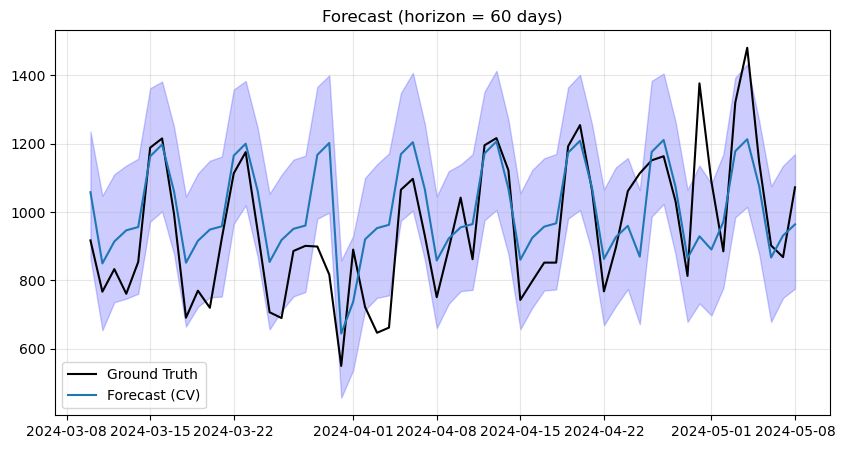


Test set metrics:
RMSE = 149.22
MAE  = 117.00


C:\Users\andre\AppData\Local\Temp\ipykernel_22864\3117658327.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_final["pre_covid"] = (train_final["ds"] < cutoff_date).astype(int)
C:\Users\andre\AppData\Local\Temp\ipykernel_22864\3117658327.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_final["post_covid"] = (train_final["ds"] >= cutoff_date).astype(int)
16:36:37 - cmdstanpy - INFO - Chain [1] start processing
16:36:37 - cmdstanpy - INFO - Chain [1] done processing



Model components:


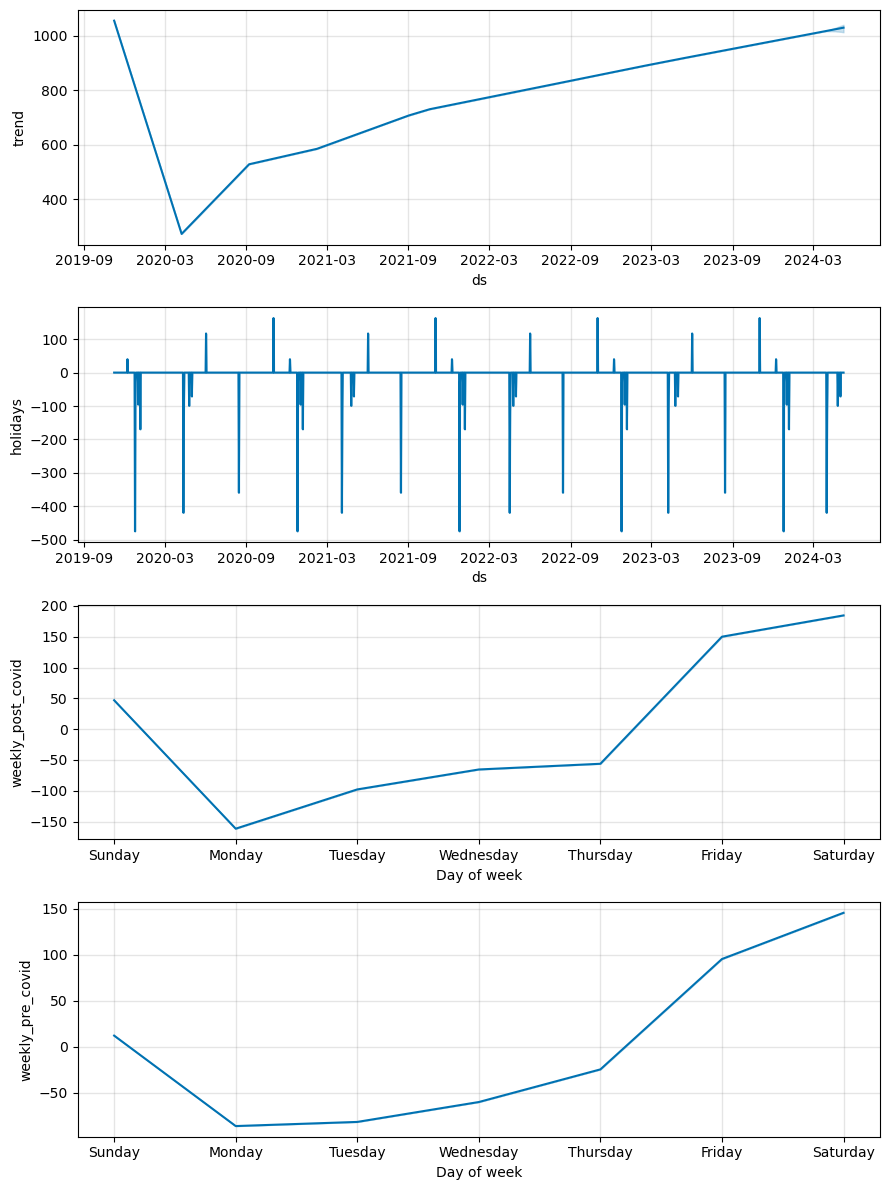

In [16]:
results = fit_prophet_model(
    df=df,
    y_col='scontrini',
    ds_col='data',
    regressors= None,
    n_test=60,
    weekly=False,
    monthly=False,
    yearly=False,
    weekly_prepost=True,
    holidays=True,
    verbose = True,
    return_results = True)

In [17]:
with open("models/prophet_model_scontrini_restaurant_6.json", "w") as f:
    f.write(model_to_json(results["model"]))